# Backpropagation

### Notations

- Let's discuss an $M$-layer network, $m=1,2,\ldots,M$ and we use $V_i^m$ as the output of the $i$-th unit in the $m$-th layer.
- $V_j^0$ will be synonymous with $\xi_i$, the $i$-th input.
- Note that the upper index denotes the $m$-th layer, not the pattern.
- The quantity $w_{ij}^{m}$ is the connection from $V_j^{m-1}$ to $V_j^m$.

### Algorithm Steps
1. Choose initial weight values as small random numbers.
2. Select pattern $\xi_{k}^{\mu}$ and input it to the network (layer $m=0$) so that 
   $$V_{k}^{0} = \xi_{k}^{\mu} \text{ for each $k$}$$
3. Pass the signal through the network forward using
   $$V_{i}^{m} = g(h_i^m) = g(\sum_{j} w_{ij}^m V_{j}^{m-1})$$
   for each $i$ and $m$, until you compute all outputs $V_i^M$.
4. Compute errors $\delta$ in the output layer
   $$\delta_i^M = g'(h_i^M)\left[ \zeta_i^\mu - V_i^M \right]$$
   by comparing the obtained outputs $V_i^M$ with the desired $\zeta_i^\mu$ for the $\mu$-th pattern that was provided.
5. Compute errors $\delta$ in previous layers using backpropagation of error
   $$\delta_{i}^{m-1} = g'(h_{i}^{m-1})\sum_j w_{ji}^{m}\delta_j^m$$
   for $m=M,M-1,\ldots,2$, until you compute the errors for all units.
6. Apply
   $$\Delta w_{ij}^m = \eta \delta_i^m V_j^{m-1}$$
   to modify all connections according to the relation $w_{ij}^{new} = w_{ij}^{old} + \Delta w_{ij}$.
7. Return to step 2 and repeat the procedure for the next pattern.

## Task 1
Implement the backpropagation algorithm presented in the lecture for a 3-8-1 neural network (3 inputs, 8 hidden layer, 1 output) and a 3-8-4-1 network (3 inputs, 8 first hidden layer, 4 second hidden layer, 1 output). Solve the XOR problem. Then:

- Instead of the sigmoid function $$\sigma(x)=\frac{1}{1+e^{-x}}$$ use the ReLU activation function $$ \mathrm{ReLU}(x) = \mathrm{max}(0, x).$$
- Use combinations of the sigmoid function $\sigma$ with $\mathrm{ReLU}$, e.g., hidden layers have $\sigma$ while the output layer is $\mathrm{ReLU}$ or other combinations. Experiment!

Which solution provides better accuracy and/or faster learning? Answer this question by writing a test program that demonstrates this (e.g., running it in the terminal provides results for different combinations with descriptions). Solve this problem also for the logical functions AND and OR. Why do the input data in the lecture example have the last column with all ones (see if anything changes if this column is removed)? Answer this question in the comments of the source code.

**Additional note:** When solving the task, we can get different results, e.g., in the lecture implementation changing 'sigmoid' to 'relu' and running the program each time, we may get convergence to a vector, e.g., [0.5, 0.5, 0.5, 0.5] or [0, 0, 0, 0] or what we expect, which is values close to the XOR function. This effect is a standard problem of the learning algorithms (gradient descent) used in neural networks. The same results will be obtained in Keras/Torch (see the lecture) after changing from 'sigmoid' to 'relu' (even for other learning algorithms). It simply depends on the initial weights, which in our case (keras/torch does the same) are random. But see, for example:

```python
def relu(x):
    return x * (x > 0)

def relu_derivative(x):
    return 1. * (x > 0)

np.random.seed(17)  # initial choice of weights IMPORTANT
                    # it might be necessary to choose a different seed
                    # different implementations in different versions
class NeuralNetwork:
    ...
    self.eta = 0.01  # important to reduce the step
    ...

Before the print statements, add a line setting the precision:
    np.set_printoptions(precision=3, suppress=True)
    print(nn.output)
    print(nn.weights1)
    print(nn.weights2)
```

<p style="margin: 10px 20px">
Then it "should" converge nicely to what we expect. It all depends on the initial weights and for np.random.seed(17) it "works". In other cases (different seed) it often falls into a local minimum and doesn't get out (keras/torch has the same issue, please check this!). This is not just a case for 'relu' for the lecture example, just change eta to $0.001$ and we already fall into [0.5, 0.5, 0.5, 0.5]. In summary, it is worth doing results not only for the choices of activation functions but also for the choice of weights and eta step! But for this task and the next, it is enough to submit only the "good" cases, i.e., for appropriate choices of <b>np.random.seed</b> and eta step with fixed activation functions.
<a href="https://www.google.pl/search?q=backpropagation+local+minima">More information on this topic.</a>
</p>

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
plt.rcParams['animation.html'] = 'jshtml'

Activation functions

In [3]:
identity = lambda x: x
identity_derivative = lambda x: 1

sigmoid = lambda x: 1.0 / (1 + np.exp(-x))
sigmoid_derivative = lambda x: sigmoid(x) * (1.0 - sigmoid(x))

relu = lambda x: np.maximum(0, x)
relu_derivative = lambda x: (x > 0).astype(float)

tanh = lambda x: np.tanh(x)
tanh_derivative = lambda x: 1.0 - np.tanh(x) ** 2

act_derivatives = {
    identity: identity_derivative,
    sigmoid: sigmoid_derivative,
    relu: relu_derivative,
    tanh: tanh_derivative,
}

Network

In [4]:
class DenseNeuralNetwork:
    def __init__(self, layer_size_list, activations_list, lr, seed=42):
        np.random.seed(seed)
        self.activated_neurons = [np.zeros(i) for i in layer_size_list]
        self.pre_activated_neurons = [np.zeros(i) for i in layer_size_list]
        self.weights = [
            np.random.rand(layer_size_list[i], layer_size_list[i + 1]) for i in range(len(layer_size_list) - 1)
        ]
        self.derivatives = [np.zeros(i) for i in layer_size_list]
        self.activations = activations_list
        self.activations_derivatives = [act_derivatives[act] for act in activations_list]
        self.lr = lr

    def feed_data(self, X, y):
        self.X = X
        self.y = y

    def forward_pass(self):
        self.pre_activated_neurons[0] = self.X
        self.activated_neurons[0] = self.pre_activated_neurons[0]
        for i in range(1, len(self.activated_neurons)):
            self.pre_activated_neurons[i] = np.dot(self.activated_neurons[i - 1], self.weights[i - 1])
            self.activated_neurons[i] = self.activations[i - 1](self.pre_activated_neurons[i])
        return self.activated_neurons[-1]

    def backpropagation(self):
        dL_dy = self.activated_neurons[-1] - self.y
        self.derivatives[-1] = self.activations_derivatives[-1](self.pre_activated_neurons[-1]) * dL_dy
        for i in range(2, len(self.derivatives)):
            dL_dy = np.dot(self.derivatives[-i + 1], self.weights[-i + 1].T)
            self.derivatives[-i] = self.activations_derivatives[-i](self.pre_activated_neurons[-i]) * dL_dy

    def optimization_step(self):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * np.dot(self.activated_neurons[i].T, self.derivatives[i + 1])

    def calc_loss(self):
        return np.mean(np.sum((self.y - self.activated_neurons[-1]) ** 2, axis=1))

Training

In [5]:
def train_model(model, epochs):
    loss_history = []
    for _ in tqdm(range(epochs)):
        result = model.forward_pass()
        loss = model.calc_loss()
        loss_history.append(loss)
        model.backpropagation()
        model.optimization_step()
    return loss_history, result

XOR

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 15821.97it/s]


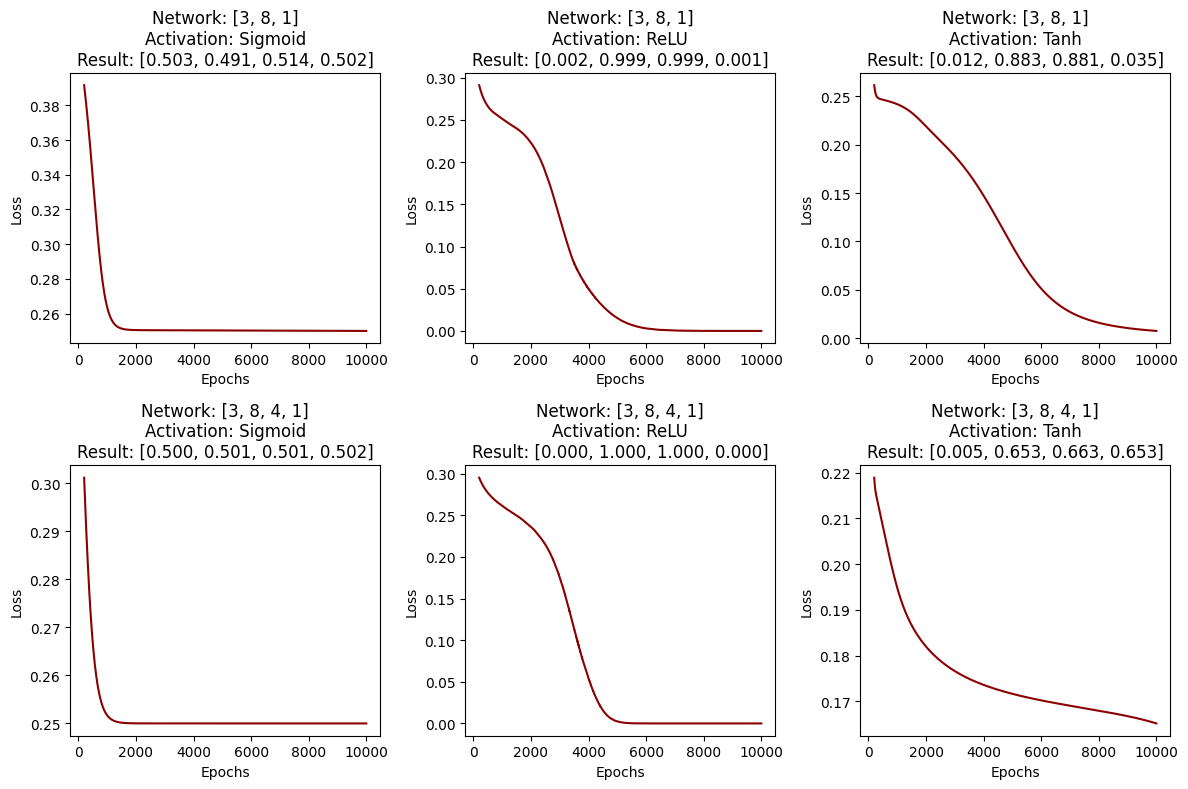

In [14]:
epochs = 10000
lr = 0.003
seed = 15
plot_from = 200

X = np.array(
    [
        [0, 0, 1],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 1],
    ]
)
y = np.array([[0], [1], [1], [0]])

configurations = [
    ([3, 8, 1], [sigmoid, sigmoid]),
    ([3, 8, 1], [relu, relu]),
    ([3, 8, 1], [tanh, tanh]),
    ([3, 8, 4, 1], [sigmoid, sigmoid, sigmoid]),
    ([3, 8, 4, 1], [relu, relu, relu]),
    ([3, 8, 4, 1], [tanh, tanh, tanh]),
]

activation_names = {relu: "ReLU", sigmoid: "Sigmoid", tanh: "Tanh"}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, (layer_config, activations_list) in enumerate(configurations):
    net = DenseNeuralNetwork(layer_config, activations_list, lr, seed)
    net.feed_data(X, y)
    losses, results = train_model(net, epochs)
    final_loss = losses[-1]

    axes[i].plot(range(plot_from + 1, epochs + 1), losses[plot_from:], color="darkred")
    axes[i].set_title(
        f"Network: {layer_config}\nActivation: {activation_names[activations_list[0]]}\n"
        f"Result: [{results[0][0]:.3f}, {results[1][0]:.3f}, {results[2][0]:.3f}, {results[3][0]:.3f}]"
    )
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss")

plt.tight_layout()
plt.show()

AND/OR

 28%|██▊       | 2784/10000 [00:00<00:00, 13997.85it/s]

100%|██████████| 10000/10000 [00:00<00:00, 18819.19it/s]


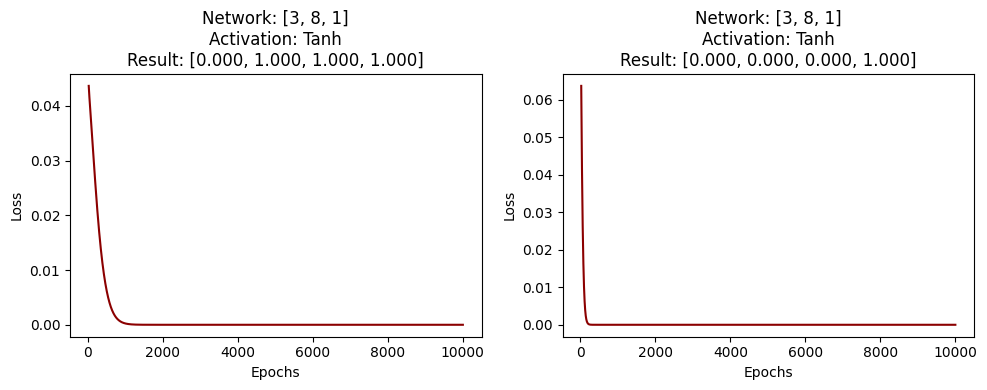

In [7]:
epochs = 10000
lr = 0.03
seed = 15
plot_from = 20

y = [np.array([[0], [1], [1], [1]]), np.array([[0], [0], [0], [1]])]

layer_config = [3, 8, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    net = DenseNeuralNetwork(layer_config, [tanh, relu], lr, seed)
    net.feed_data(X, y[i])
    losses, results = train_model(net, epochs)

    axes[i].plot(range(plot_from + 1, epochs + 1), losses[plot_from:], color="darkred")
    axes[i].set_title(
        f"Network: {layer_config}\nActivation: Tanh\n"
        f"Result: [{results[0][0]:.3f}, {results[1][0]:.3f}, {results[2][0]:.3f}, {results[3][0]:.3f}]"
    )
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss")

plt.tight_layout()
plt.show()

## Task 2

Design a neural network for function approximation. Specifically, implement the networks 1-5-1, 1-10-5-1, and 1-10-10-5-1, train them on the function, and compare the results.

- Use input data as a sampled parabolic function

```python
x = np.linspace(-50, 50, 26)
```

Test the network for the input vector

```python
x = np.linspace(-50, 50, 101)
y = network_output_for_input_x  # output of the network for input x
plt.scatter(x, y)
```

- Use input data as a sampled sine function

```python
x = np.linspace(0, 2, 21)
```

Test the network for the input vector

```python
x = np.linspace(0, 2, 161)
y = network_output_for_input_x  # output of the network for input x
plt.scatter(x, y)
```

Also, choose the appropriate activation functions for the problem! Specifically, $\sigma$, $\mathrm{ReLU}$, or $\tanh$. During training, show the function approximation at, e.g., every 100th step. For example, for the parabolic function, for the vector x = np.linspace(-50, 50, 101), show the network's output using matplotlib. This will create an animation of the network's learning process. Also, display the current learning step and the mean squared error. Perform the learning process animation for both data sets (parabola and sine).

<p>Example animation of the learning process for the parabola (what the program should produce):</p>

<img src="data:image/gif;base64, R0lGODlhgALgAfcFMQAAAAAAAAAAAwABAAADAAD/AAEBAQICAgICAwMAAAUFBQcAAggACggICAwMDA8PDxMTExcXFxwcHCEhISUlJSgoKC0tLTAwMDQ0NDk5OT4+PkJCQkVFRUpKSk9PT1RUVFpaWl5eXmFhYWJiYmZmZmpqam1tbXFxcXV1dXl5eX5+foSEhIa47YbD/ofK/omJiYnG/ozC/IzD/ozH/I2NjY3H8I3I/o655Y7B947D/o/E/o/G+I/G/I/J95C675HD/pHF/JHG/pO975PC+JPG/pSUlJTD/5TE/JTH75XF/pXG/ZXI/5bH/JbK/pfA/JfB/pfD/JjD9pmZmZnF55q/75q/95rG95rK9prL/JvG75vP/py8552dnaGhoaO++KPC+aPE9qTI/KTN/aXI9KXM9KXT/KampqbQ/qbR9qfU+6fX+qjG6aqqqqvE96vK+azO+qzQ+qzR6q6urrDH+rDI6bDO+bHI2LHT+LOzs7PV+LXM+bXR97bS67bZ+be3t7nJ6brO97vH97y8vL+/v8HBwcHT6cPExMTFxcXX98fHx8rKysvk+s3Nzc/p+9Dr/dDu/tLS0tP4/tXV1dfl/Nfu/djq/dvb29zr/N3p+93t9935/d/f39/t/uDo+ODw/OHh4eHl++Hz/eLr+eL5/OX5/eX//ubm5ubp+uft/ujw+ujz/Ont9en4/erq6uvy8Ozs7Ozw7+z0/u3u7e3w8e3z8+3//u7s7O75++75/+/u8O/v7O/v7+///vDu9fDw8PD19fHx8fHx8fLw9vLx7vLx9/Ly8vLz8/L0+/Py9fP4+PP7/vP7//P//vTx9vT09PT1/Pb0+Pb29vb//vf39/f6/vf9/vj9/vj//Pn5+Pn6/fn///r1/fr6+vr/+fr//vr///v8+fv8/vv//vz7+fz8/Pz+//z/+Pz/+/z//fz//fz///37/P38/v39/f3/+/3///78//7+/P7+/v7/9P7/+f7/+/7//v/89f/8/f/9+P/9+v/++v/+////+////f///yH/C05FVFNDQVBFMi4wAwEAAAAh+QQFBAAFACwAAAAAgALgAYcAAAAAAAAAAAMAAQAAAwAA/wABAQECAgICAgMDAAAFBQUHAAIIAAoICAgMDAwPDw8TExMXFxccHBwhISElJSUoKCgtLS0wMDA0NDQ5OTk+Pj5CQkJFRUVKSkpPT09UVFRaWlpeXl5hYWFiYmJmZmZqamptbW1xcXF1dXV5eXl+fn6EhISGuO2Gw/6Hyv6JiYmJxv6MwvyMw/6Mx/yNjY2Nx/CNyP6OueWOwfeOw/6PxP6PxviPxvyPyfeQuu+Rw/6RxfyRxv6Tve+TwviTxv6UlJSUw/+UxPyUx++Vxf6Vxv2VyP+Wx/yWyv6XwPyXwf6Xw/yYw/aZmZmZxeeav++av/eaxveayvaay/ybxu+bz/6cvOednZ2hoaGjvvijwvmjxPakyPykzf2lyPSlzPSl0/ympqam0P6m0fan1Pun1/qoxumqqqqrxPeryvmszvqs0Pqs0equrq6wx/qwyOmwzvmxyNix0/izs7Oz1fi1zPm10fe20uu22fm3t7e5yem6zve7x/e8vLy/v7/BwcHB0+nDxMTExcXF1/fHx8fKysrL5PrNzc3P6fvQ6/3Q7v7S0tLT+P7V1dXX5fzX7v3Y6v3b29vc6/zd6fvd7ffd+f3f39/f7f7g6Pjg8Pzh4eHh5fvh8/3i6/ni+fzl+f3l//7m5ubm6frn7f7o8Pro8/zp7fXp+P3q6urr8vDs7Ozs8O/s9P7t7u3t8PHt8/Pt//7u7Ozu+fvu+f/v7vDv7+zv7+/v//7w7vXw8PDw9fXx8fHx8fHy8Pby8e7y8ffy8vLy8/Py9Pvz8vXz+Pjz+/7z+//z//708fb09PT09fz29Pj29vb2//739/f3+v73/f74/f74//z5+fj5+v35///69f36+vr6//n6//76///7/Pn7/P77//78+/n8/Pz8/v/8//j8//v8//38//38///9+/z9/P79/f39//v9///+/P/+/vz+/v7+//T+//n+//v+//7//PX//P3//fj//fr//vr//v////v///3///8I/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59Cjb5ZHkbpP69b/ZRe4XWN36Zm/H/8W39R6O+7dz3dUD54xdnnyyJ3n9m8+ffTkF8KX164duYH5KQSfVef1t59D7P3DzX/YEEQdNtSZN9B/JcnDTTsNGjhgfAn+Ew1/GHCgnUP38ddge5AZEkIEAEjwQSInardfgAuRY0kDbExDo0IiSDAUACZ0WOMnB3Th0ID/+fKAkf/gEcIEDbhoCXX/cQOMChU0EIEGktw3UjsqKGBMOwcK1EUR2/H3TwkYeMndQoI08ImQKCIGIQ0AZNCFIFxk0EAR0QjEzYwVcTMNIa3QCSB51JEwwZsYMeqdQACQsGNBmzRgxogHZTdgO9yccMF9GHjQxSBmTOAAJNH8B0wGEhT/QYgcKjAS0aUIqQCALBQS1MGjkJKDhwSfjMjfgA6W+c8GIihaZ2HkGHJABwViU4wHABAyjYKEYuSsdnQOOMIEDeKqH0LmnssNACVERA6RRkpakDzGNCCFeqZg0+A0pjgwwkAnNLCJggJ922lFur5yUAcR4EfmQw//M815cgBQbLrP3kWdfxwoIEmgA5nSgAfUpYAAIyA8IEEXBiTyD4UrKNCKhSqoioEfGWwgkCUGdEHdCgBIAoIDEYwADITtFJFBBAhY8AJ91I3LHZBmUPDABX4M9MmTUXrASILYGVCCFFlewMag8phSggUNQLCBIep9AsAKK0RwgB/cpGABBBFg/yAHfNysO/YECFSw6UCMMNzABV3Q926R9VkiggUOSNABJPUZ1A4NB5jiJkESaNCgMQ/8W3BClgBAQ90OXCAIdyH4OJCuESJQAhcUNEBB1trp2opAklSQQSsbAGA8AAZQ14oJFSggQQq+CPTBBQNhy4Z2jBggx74PqHAsshkTho0DGUTI33kZOEDdCwhQgIIgcnAjAQgluvhyCgeEgIcUE0Qg4j88Y9IKDDABFQiCBg0IQX3IcYIi+GEQNICAAl82AtnJAwAT0AAbBKEBi52HECnYoBw+4ABLbAtS7TCABCrABjxsQAHXm4YkSmAGQeBhBAYYhEDklsEamgIYIjgVIf9OoAApDAQBEmCcHDyAo/NIIgIT6IIfPmCAFbwMXvEZIh4GwQYSTklzGygfQniGAoEYogErKAEEDoABPEDIIKmLwAbMwAY/JUI+sSOIrs5zQQlggA1y0IABivWPhP2DEA/wQKsgoYEIHCIRhFDQBRywAkGo4AAeeJkUDGCK+ijAdvyhgQKAUbAOXEBH4RvPKwDwgffIYxohGGQhDZCCf2DjQ2Hy3D/MAIBD/KMVDQBBhAhhAA3srGcCAdoLKEQCBzToROTgDxdkVp8KFswAEfjdPz5hABUUDBvniQY3KlBLAF3TAZ182QUswKEFbmsDHaCOKQ4wAQrpy57YCEEFRqT/AHRapwIUEAgIGmAJ7WCDAxDwxeOMdCGQkQMbFDjBd+TRgBKQJ33pZBn5/OAHDhxADgdJnQSMAZ9o+K8/eZwdAPiIwWJcSG5WLOSuzKCAEshHIAy7Tzu6oKnzcY4Q8pAEAK53CACkwEfR2AAHzIMCAIAslYWRRysAMEEASeIDnZOHChqgCC+1wgA0iM8GLCAfPBwAD9zhxgT+F8BkHqCgmgTAwLCROAgA4JMAMMSgrKkdA3wAQBEgQX3asQIKfNIAAOiAg66ZyQWqQJb/kMIFGoA8AFSAP3KTKEHYoIEHINYACqBQYrGjghL+AwIdAKdA2AAAQSxUINMoLF5H2yuB/wBDAd48yAgUANLVIuABu9hX6ISUOhMga7f8SalA9tjXD7zxHxFol0xPAABA+QpY0mvAf87TigOU8R8TUGAKLgAJA3yMloL6BwK/CFXB7KcdDTDmiE6EAQMMCmim2JhAniSPRFR3tQeI5MvacYENUKet/8DvQLhwgGK1onVdIAQjipDXvcruH+wiE3UkMMEQICAFg3ikBTKw2PoYgAQP5Q+FMUeDE+MhEYzYwGXbIbcX8Oc/vPwAGxjBiBE0IEMAGAF9ArVJW52YPYQAQBdoXKTzUDcFgmCEIUacOYJMNaYOiiWTBIIHBXhgQfttQEjnFiMUIGBMIgjoQIDGR7Hxsf8dEhDBclskAVlA7TwdoECvNAAsUP3jAKazpgYsGoEumNVlBCuCASBhsPbuBVuf+I+aUkcycugqvwRhBALYMIIHgEwQQ1UTOUJ3TAECIJ3/YHCxNglXbChar/Lg6z/cbB0JmO4BKM6cBEhsThMvNUIDLFaBDfoPDcy4xgtshwcocCHpASBzACBZ5lJggJlFQLEDoSkeFooN+YUAG+SgjwREVFsPAeAEBglBEbNDjqlm0joheABxz/0f+YgAAQ0qQcO4Q902WxQ+cJazTBNxAQqYgkHKpsDGyOEBBQikQbswaoPYgABIACBrIgBBCpyZXjxh2tGEOQQCOlAlW3oAAS7/w8ZjMU0lbmQgAw9At0B2oYC//kcRBtAZAJGZ4FMvuMGRrbaaOghrWYsNWbYWSOnAjQ0/AEDnKDRAA/JLn4Kr83//gEQDjg2AFyR72SF7wLMphU5BVWCf8vhAA1rBjUB1oAHGWOiCIIDiBuHBABmI2EDU+lcAlQAARpRYejUgAZfKIxqWG7METgQMtyWTmvLARgUMwMcDtGs/cZ5zK0xBgQnYSjsfgAB/AicFHElMHnh6XbsVsAEDBKoLfYtnekcQgUaDPC+oz5MZDMEFDSiABgIhB36xcx7WeoyP/6B2CfzAv9AdmOcKFoiquaH1DchBDhywQIVjfWFaC4TD+zVA/xEOCIEJQJ1TKVxhCztgADb8h9oqGEQRIkABrnvdP7sMMvMroH2BRAOJFmBo2BIvkgABhoMHVLRMTMYkIeAANOAHNBABEqAz3UEOIgABBFECChACisAIj6QI6sEIDZAB15cBCmAIipcBeIAHfnIIkcdNG4AHgTQBAGAdlgcgmSdTM9MKGCABjPAfMSMFjJByk/QCfhAmJNds2rcB4SY3qqMeVfcBend7gqEIH2A3EfABn9c7MqMs3NAAsjci5PACTNNGFyBtlqAAZgAfjzUz9cEFAGAJ5+EHF+A8KeB0OiQPIoBdJ2Yi/5CDskB7rJcIGyBfUTc2uWM4gyIQKRABCv+QAWzwJLYkN8CXHTQgAQ5QAVKgK9xxYvyDABPABnwkD5DAAQ9wABdgROexCQjABbbkCxfoABvAQbxWEO3gBwrgMhtGWQqgAAAQJTIiD4TQWQ3AAQIGR6pTMwqAAa/DHXIwSRNQBGEyEGLTK+AnU8DQH8CgARCQCFL1AWKnANTxCiYgARiUAvRhICmgAC+gHhQAAD9oS/KQOnIwhVQIGNuFHeQgaWoSH9mBBxcnHufBMyswei9jPtnxOeAjIW8yKP1xHjHSKZ5yTTI3Io5TZa5kkAoiJORRIuBzOgRjS+ASTdaxj/b4Mv9wASWANgnxkf5BHYtIEKkDfCEphmQSMTH/oiYDMYUn0iAUUlv2VGUAApHcMR8AYgkpQC4Yc49zgR3GUjARsneQ4AcTYAExCTwpsEVFMAEP8Dvx0Wu2+JWfA5UyUm+QQhDlxilRFyS9UiBqqR/f0pP10S0DpiARySk6OZd5mR24SEgT8kaEkh1vhoxhhS4HGXlv+SYfeRAMQiHmAy4atkDHMhB36QsRYAZjyZR/cXjIwpARmQEGgAFwRRCSgFBt8wGWQCERQybk8FQyQhA4+ZTb0Ss5+S1h0y7qsSEFcZUEAU3zApb4sZjgIpIJ6Y/KsijqUQQoeDAHYiHHWRAz6ZcPJ2nlgpJfGXn/ATLfoR5IcyFuWVvX2Y/W/3GXCsIIL0CemulepzOZwHmW56Jf7rlYtvebbymc8fmaiWmf8NkQC5kmE2ksJ4kfiTmg6BGgEZGb9Smf7+kso4ig6TkZTkmg1dGeLVkRuDJR8mKYR5IfC5ksAoIxURkpilliJGqY9qmYnfmgOMEPBPEOLqqi0eGi78ARz3kZ/HCjOMoPMvqiMNoc/iCj/zCjGVGjgAE+ackQNyoQN/oO5SCkPcocQvoO1FAQ8MAOVnqlWIql8AAPwbeRGraUcjEg3PAJvhANu3CmaJqmu+ALvgAMwFAMxWAM0ZAMxCAMvXCnvQCnerqnfNqnfvqngBqogjqohFqohnqoiJqoirqojP/aqI76qJAaqZI6qZSqp8ZgDLRgDMMwDMbgDMXQDHjaC2wqqr5Aqqb6pnBKSCQpoXwxIKYAAAcQq7I6q7JqAIhlPLZqPAJAALd6PL76q8AarMI6rMRarMZ6rMiarMq6rMzarM76rNAardI6rdRardZ6rcI6AAAgAALAAAjAAAygq9w6ruTKrcFKSHQ5GPIQcabgDLLwrvAar/Capn0wBjewBT4ABoVgC2rar/76rwAbsAI7sARbsAZ7sAibsAq7sAzbsA77sBAbsRI7sRQrsLqgC7IAC61AC4gQCD7wsT5gCqtwp5dasiZrDHBaqrmQCwiADMF5GMAAALsAEegwo9b/4AqvUA3oYA/qgA7oMCNAG7RCO7REW7RGe7RIm7RKu7RM27RO+7RQG7VSO7VUW7VWe7VYux/xsLXxgA7n0A3vwA7bsAqrMAvPkKQQYQwt+7KGEbMz+xAyKg7aoA3X4A3i0LM/m7V6u7d827d++7eAG7iCO7iEC7Rc27U+Kw7eoA3eYA3a4KRpu7bBCKZ0AQwG8LYOsaMyirc+W7ie+7mgG7qiO7qkW7pNe7g+m7jqsLrqMKUSobYuO7kwe7kQsaPiYA24m7p5a7q827u++7vAG7y8i7qpe7dCGg4TUQySm66DYbmYC7eaW7NPuhz+UL0/qrlMyqMPobyxy7yC4bwU/7Gj0ysd2Ju8y0ukgAG+47u+FQEM53uif6G+7Du/EOG+3Yu+8Uu79Lu/DWG/bFsY8su/AnwQ/iu7bau/A5zABFHA3hsYAazACczA+OsXDwzBAizB8EvBCGzBA4zBlDsXFdwRLMrBoeEP/2DCK+HBs/u8HvEOaFuiJHwZ/ZAQL+wRKnzALLwe/8APzBAKmRAKyyAN5TCfMZwY/sAP/ZAP/GANnkAJl7AM+YAP1RsSNwzAG/wR/JAJY3AGU1AGZOAI1fAP5VDElYEO/EAP6uAIY5AGQnAFYTAJ8zASVUwYIbwRWWwFQUAERAAETZAFlKAO2UDGlPEN8LAMjTAEQBAEQf/gAjpQBZQAuTb8vh8sF3WsEcwwBjwABD3ABEBwBEAgBrWgDoI8GS4sDWvQyXqMA0AABW4gx5K8wiKhCl7AA0fgyZysBH48ypLhD9/AD6HQBEmQBHrMBEoABUzwCpmpEXPcvFfcEZlABUAQzZ6MyH78DboMGT+axTgQzMFMzMacLwZ6Ecv8vc3MEagwy9EczTsABFcQCtZ8zY7hD+rgy0zAzUSgBEyQz74AZh8xzg5czhtRDW4QBDjAAwbNA0uQBrUAyfBsxDPKC2Vgz0uQz0wAkpF8vxncF5WcEdqACWAwBJmsx34sDY/b0I0hyj0cBTBgA3l8BFXACfAApBf9v3T/DNAaMcaYMAZXgARIcAWUoA3/oA4MbdKGMaNCTQlrcAU4EAVjwAk6KtMd4c/pa9Mb8Q7MQAmVEAq8ANQCMdRETRgz6qLqIA2i8AiPwAvcENNQzRFSnb857BEN4qL8sKVe/dWLIc/MMA/1EKRrvRFtrcFvbdezob3/4LPu4LN9rcyvjMOCnRuErbviO9MGbMWB3diw8dipG9lRvdiUbdm3gdmIndgZ8dcaTdWezRqgXbOijRGkzRcbfdqrkdqazdacXdOVDduxDbmQvdriXNvMfNu4nRqyzdsW0dp78drB3R7GrRfIndzSsdx50dzOLRkjTJ8zAd14Id0jwaL8gMLT/20WLnwwNIHdd6HdJEEd96CjqFAJnCDK6PndWDHXzOAJnZAKy0AN5YAO4+3b5AzcJzGj4VANnEAGWIAFWfAHohDG8L0VLNoPlfAGVLAFVEAGmIC8E3wS5G0X5i0SolwNj2ADOSADSzADTE0JY3zCCx7flXAFK73SNpAFnFAO4ZDRJpHhdbHhIaEN/VANaQAETEAECA0EOoAF1uHdKU4VzOAGMFADM9ADPTADRDAGzLDfGD3JcYHjIKEO+YAKQ+DJnqwEekwEqVC98WC9Rz4VqFAFNsDSQWADUF4FoVDdMGHjlWvaFSIP0nAPXP7lQADmRJAEp7AP/tAPZn7mUdEJVf8AA4rc5jMABFXgCedw3fz9z/593vJQDfcQC1BgzExwBGGuBGPuD/RQ6Ib+FGnO5owOBF8QCvotE3QOwnZuEtqAD9QgBrXc6Uugx0kQDtULDqRe6k2xDGGw5mseBFAeBrhA5TT92zLxDvKMClZgBGtOBE8wBpUgpEYO7E5BDZUABjmgAzqgx1RwCeoQD5Je5bAcE2FtDZdAB2BwBF/wB5xQDdiu7VFRDtbACWEABlRABWNA7ijp6pM+1ZX+3wLxDaIwCRXOD8ls705hDczACZegCswgyjXx6pQc6yuho0H9D8jr8FPBDicepOVQpRc/8G4N8pLBpTuB8Veu8Sqvrjz/4fJwgeUxrxs0/xY2f/O4kfNusfM8bxs+3xZAH/S0MfRsUfRGXxbyIOdHgfRrofQtwaJCmh11vfTbXcNGAfVqIfUtQQ/8UA7V4A3fsLp8jfUmkaQsz6JHChRcnxZev/HagQ/zMA/5cA/5gLhoXxJzvaX/MA79QA9xvPUoD9hGgQ3hIA3LwAmYAMTW0Ll7PxLvoAzSQAmPgArh0A/zYMJW3hJvjxZxzxLv0Aho0AQ4wARaEArh8LOR38IEQQltcAU/8ARzgAr2cJ8+8flnEfoqMQ+PYAU/YARh7gSX0A272/oZEdYzSgkGrchNYART8AgzSsQnj+6MXRTMYAVJIPxh/w4EbSANrY78HIEO0jAGiswDivwDR5AF5h6ibl/4pV3wOKEJTIDQYU4EPWAFqjDy4p8RAOHvHackRIIQQRhjiZNi/+Q5/BdR4kSKFS1exJhRIzAEyCLKA/lQ40iSJU2eRJkyJTADu1S+hJkxEg4eCG3WIPLIX0yePX3+BBpU6FCiRYm+U4fpiU0iQJIE0eHyo1GjHD06DElV69ahLKVyJZoJi5EeBYnsCFIFFTqwbd2+hRtX7lt16FDZIBKjSVMrT75Mm+vT6sesgQ2/9Xo4ZrU2RvYi7PFkjjW2ii1fxpxZc8p33ZaRKRijqcEn+DabHIwV5GnWMRO3HsnJyhKETP+YhOHE7x1s3r19/+bJDx08T2iY0D4CQwwl4BZThxTZXHrE19P/9fu2CEkTJj3KOKpsXfx48pfF/ftWicyQHD+wVFqH1frzwuV7V2/uL17Enb1AoYIHnnLkgcc+Aw9EMCh//OFnonaKeQUbch6Kbjr6VkuQNfzG4weeBgUkMEMRRyQRpgot7IgwDEu8bEPy4okHxAJZpLHGEjE8UboLc7QxLhfFY6fAAAPssUgjj9QwRdV4RJKrH5sjcMYmp6SySrh2tLKtJ7PksksvkcTyy6paErNMM5tc8MgwzwxqSxIbnGg3NucsEc6IGuRnQTttXJPOntzM8J13yvnHHEG1iWf/Hj8XTbAdeujBk55+Ftypxz4ZfQnQBEGa0cMG2cE0VPL6+accUwm9Lk1LlYROVJg0PZAfeTosB5VKQtFGTld3Be4afTz0pJNUpPlmpz1ZvJRXkmC17x04Hxnjhx1mIOMSVJXFljV16LkkjCSSaAKLUHartMZks8WI2fJ26+YRhJaAl4kpKomoHXTvtawc2XRgygpOyimXxnPxpUhd8pzVRgymYlDCCjLI+cdegieOi502jmAKoTa+IZVPVuujuCKDx2OLFLOMaAqHJXZoiMIVQ4aZKFWyCEI0hIKwwYpU6Fn1qlZjLpjMGtFR5xF+iUAZhx+WAMIl6JgEOuqXHtHC/waUb8bJEXd6VhFqikeeDh2xreEkCxmC+JaIKojAApolvZY67pJCoSKHx4iwwQYv1uJ6Sbn/Ads6pLShYwgdfjACCIOwWOdpuP+G3CLGnPgBobwlq2Zrj30GOerABfeGkzKWyIFfG8Tg5B3HI2e9pHMw+eJoG3b4InVudEX245c9F5pGbiLKrowjZIhBC07WkfXp1pfPKJ5vHinDoBmWM6fjzbv++3Px1HnnwQgn9Jt58StacL9/1FElk1CI5b7IgUPWXvCKVh+//onMFxR3XR8v7/2ve7eRnHCkPPsVcD95kkg72hGOcEiEf+Tx38TiZyACWiR/uCugsjCIEUKBqv9JESTYBO1TwYrkiR7ZyCCv5FEOQf2jhSNhIQvz5z7dPRBdIiwPCS8Cp4Cl0E/yQIeq/ARCfOGQPDqM0zvQ4Q5K8eNYPpzTDIdYw+wBsEk6rNQ7UAGKVHSDe856IhS7tBMyUsMTl2DFMjYoJiLey4gjosc7HuGtJBhBB5VQxz/wEUYxcgke9NCHI8hABSNg4QuYWKOX2nhDK37JHJXIQh11wIMZ7MARu+FjH6sEsX504gpHsEEOekCENzhiTovM1htFpAwx2AAGQQgCD3ZggzAwo4ea5NI71lENMjSBB0BYQg1soAMxLINCZUIltlSZIU9owQU24EEse9CEKFDCNLj//NI72JEJaDrlCU3QQQ5w4IgC2ZCGnNsd0JaZIEqMjgg8gCcwm0AJfWBTTO+gRAsUl4QlxKBmP+jE7yT2pWQqa50I8sQQ9gJLeAahB57Axy3tOaV3fOMSSlAcEZZQMyI0YRX2GqgiqSi3gx4oHGPAgkFgCUs0BFGiE0XSocZwtLMYQV7eYIs5+/azuJXUQPh4BBRssNJYPgJ5mYRpkXaDDUdUTqNN+EEPIiGNRGapoLzyqX3quQo6NGEHQNDCI7RhGp0mVUQPaRAmCrcEKqyBEsy4IDJH2tNGeikegqLGKjIRC2L946VmrZIqHHEJbRAqrmycq9SyWp79yON2FPnr/z/sVFXAnkY4lL0IW8oRjhYelqCJ5d1XFiWPkO5QIpitbGYahNqR3E6Kn0VnWbFa1zJJMZ0SUQc/8CEosaXWN7qZR/X84Y4gfg206qStsvaxoHZUKjy+Zc04iKYOcaiDe18M4XFjtlgkzUManOAEKqTxXOieBh0NysYsTDGsb2DXjdqFGXePRAmFPYUMiCxva9TRj0qEYQlKCFcovvHCG8IXfsl1lTkc4ZRv/QAIcJjETkqbX8VowxFZQJwRNAyFSvSDtYu66q7kayN2iGMMGU1C5Y6AhvhMmMKGkcYYcIA0DRvhB2PQTREN/D/RZgsVGCNC5RRnhCS07MWYCQUUXv/JFCAwQRXkNeiOJYhgTLHjG5ToAW2EDATESeW2R4bLI3IwVKYIEzw6jm0Ve6wsfoQCL8A0QhZs/ATAfBnMb/HETA9ikxxYwRP2QDP2SEplRpGDH9IgA15yQJtXaqFxdr5zW6rR1Yz9YGPFLXCaB73mXUGKHJegQhOWkAQd2CALj1AdpCPNlXeIYgx7booTcgOOQIePrpwWFT/6oet3VGIMxIMCFh7BDPms2jDWcERKbfKIbkhQyiEk9KImFZHuQQgbjYOIsQ0jD0z6B0DwQEc8ZGumELtqxDSK7Li1LRQ5dehDA1I3YjV963vdEkcYQeq6g4I7GK1Q1Zgqt6jOXdv/fOt7IngqeEaC5BB4/JtRAQ/VwMvUIWaEAhOeWIY0yoGOzukbYvXURiYaoQo1aiRK6nx2EaMNNP664Qw4EEMYKJFHbDj8xerAhzXwSYYriAEMc+DEPOKdypS7ceUw40clrgCDIBMZDJSwBjtcrG1r6GMZj1iCDJi+gyeEwRF5Sjj8is5IXMuNGW6AQQ0OgrIlhIEXBq9I1ZmBBnAdpAnAfMI7hBg5iAP86CHzxBF+AOvDHUEVYT/yN/SRCoRcjSmr6EdEW9f3h/+dYpnAgeOJcDgciALuFPGGPjBfY813gh6SZx3lQWz5iXkCCprnwQ+OkAqvDb11lPWGPxhP+sdH/958fB97KllPsGVooSArjb0WqFF7JzZ/opRFxztwUYYMa94ay/095FQ/xOHjaxmQtCO/gpAFTnyDSQW6ZkQgpslyWIMyYuOROPwhjVAwodQuCIITvjDzePjD9uYOPmXqPnSRB3XQBkoIgyuoASG4Ak7gnnbIkeYrkHHoB3qYBwIrIFnxq37gwHM4h96iiN1Qh3K4BDcIgxiogjbghG6Qv8hCuXlTrAFEF0KxBl7YIr4SIIpwIn/gBngQhUvghPGah+gTo3KoBmkQBWFZhsKqiN0QFHFghkygBE6oBn5QlL3TvgA0KBlEl3a4lneAB6mzCCf6h0foJRgwAjcIhfb5P/+CIZVHQIMm8CctCAVrkJIm/Ad3OI+6IELm2T46kbgy4ZETaZBtcASz0Kgk2ALmiBgf6gdHQALasAkmmIQ1kpMLeq3l+cNT4kICJIkOiQUwQER+MYIxECgfkgYr2IG7IQIZaANpeCJMxMTx2UQ2CUQx4Z8OQQUoyBjRGAJjKLYCkg20sYkgcIEwyIR6CkFZzMTJ08LZKjsogodKaA+moI2oqJeL8Cx0waxKGAIlGIJidAEeaIRzaEJmxEBnhMHQsicynIdQSDEdWKm++AK36bh/gAd/OKFsASKkcKGqCgX/kkS8mYEq4ITzWEZ0pMVnFLFO/Bt6YIYxUAIdoEgggIr/MMgGnhpDfoy+nUjHicCFNmCCq8mbH5iDatAGjksihRSfWjyTW+SVK6O7UnMCGDiCSki1dBIIJWIiF/STWbwIbegvm8ibL5gEcNi4CkHHjwS+dUSuaEyh31EHZmgENCCCHHACLagEfUie3RGULVoFL2JKNiEjvzIjNFqGjDAHZniEK9goG9CCt5qHW1rKD9suhjQ3h/ybd8gVawgFSiAFZaCHl6KHosGCJ6gjI3gEafiHcQiVbRgHfoDDKsACQ8IvC/pHVOiEWUhJKMMmlyQ3vZSbSzSV/vsreqgEMMiwJDiCJIC6O6QTBpkGUbCCq3QlIwCDRrAebXwHd3gUGMm+/8/ES4ETzbjBnWnTiJn6geUEAiAwgjCQBmW8iDbsjUvMCHVgB20gg43SASDImx3IgmogFK/xyT4CTWQqTtZpt4vYRaZrzubEgijQiYyYleZDvOmQE8/ELX6gBB7ogR6AgqUIgiZogka4hmybH4dAoco6TzZKz9EsCUqgyM3rTmCyAUqID4tAv4lYvxEJh2rQOSXCCHWgBBgYtc1bzh9wgk9gzKnbxqRqUIJ60BS6BPaACooMpyG4hB1yogl8lDgaSyC5Dg7sB+KKPtxZoWrwBI2yiX5KgidYhW9oxFWLUUWa0QziBzLAmxulSDLYoB3swR/khGVwh3nII/3cjAcKh/9lqIYkTIVlkKE4OZ+IHEguO4IraIecMrYq7RKYlJtHNIIWwFGKdITm2pNnOcM0xJXd4B+7pIr6dD6LEAhHiMM5DIWNI0Nq+wdqcATaaE6oGgKx0jc+5RI/Nc54aIU1aIJwjEs1ylTJ+gemQsRRW8RsjLsjbK88CtKt+BAOvQh/gERYIwJK1MZ/UKshYCs6qASqasYjI1WrutIMeodwoAZRUB9esAbJOlR88IYxYApSNMVGFAl+4CQO1IcFASI0pQr7nMAKvMB01AZVZEVXhEU8bAd1QAVHGNN/bNYXe1YrMdW4kYdwYKERFBBtPTh4UAVeXJgl+EXVmIg1jUL1WcL/PiwKHmm+bcAHMRVCtiCvgLQBRCSCY8yEesDDfqQGnaO2fqWwf62SgJWa1aAQ+zyWaazGzdMo0vGy6PAwSoUqI6BDTJUIhEMJMErQoeWhMkxUNWwf8qIEXgxHm3ABHWgEzbEIl1G/F3XW4Yy4aC0gkNAtPdnId4xHioyCH8iBJKgzrAVWJLiab6HEDfq4fwi5RhiWkeAHZvCETPAEXlCj5yJDbKAEa1RERiytULCCtCHKMAgFPjom6hROp9wur7Ufmc2IBukHbZBIiiwdGMgBMQgHkEnFVUREesUddfAHnaMEnssCMGgDUVCUHVIPKhCCLAiDStCGf+C41YAHvpTI/6YAAoqEgnC1l4cQlGUQSZG1tGpALcjFJZelEpi1Hzgh0ZnMgRwggixgjt3RhMf4lm+BASzIBJ6RCGvoh6sjnaXZgSqQOdnFAjREnOwlrPfjFGsQBSwAsoRwWGT4oiN9h++yAlGziScABXvgrLpE4JLY1SRS4A9b4NNy4Ahu4AkmiQcGHK71O6j8PMmSSqq0yhx4guUAtN2JhCGQJSb43iAYgnJ8oWXIh2owjiYoiFX9ATH4orhiBjLYgRlDCMRxO0wskEzAXoTIqCXggVkYlI1DB3EQh25ghkUog5pACErghXkwRwTG4izW4i3m4i724i8G4zDe4n+E3imJBgAAhv9/mBDHYeM2duM3huM4luM5puM6tuM7xmM6HpJyyBVyAIZXmAYJgUA2RoUrsAEkOIIhYAIlgAIy0IRuCK55oAdpuAdUMAIogIJvwWRMhoUGkiFBUYUycAEZ5ifaqKZr8EB36Ad1ED0kgKdXfmVayNZ3YGJx8AZvkIZcpgVXcAVmuIZrWOJaxqlgruViLuZhNuZkZmJvUOZmZuZmTuZnhuZjnmZjluZqtmVsFmZtXmZuzmZuvuZkvmFy4AYAAEZbixmJ4YhPeIVWcOdWeIV4lud5pud6tud7xud81ud95ud+9ud/BuiADmhZeAVY2AVgAAZf2AVfKAZjMIZogOiIhuj/SUACFpgCHxCCjPaBLQiFVeiFVRAGYkCFXJiEKsDojEZpIfiEXiCGXOiFXIDpRRACFrgBFrBpm74BRMiEVeDpVUiFYViFKaDdoRYC2n2FX0iGpP6FpeblpublX2jqXXCFWaDqqrbqq8Zqp9ZqrZ6FrfZqXu7qr97qsBZrpybrsgZrtDZrtW7qs0Zrty5ruBZruW5qWrBrWHgFBMgFRr1HmPkEA0AAABBswTaAwjbsw0bsxFbsxWbsxnbsx4bsyJbsyabsyrZsAyAAAwCAAzgABEAAzR7s0BbsBCAABRCAARCA1AYABQDtwR4AwRYA0Rbt1KZtAlgAAqBtBhAA3cbs/9smANQWAM02bdqmbdNGAAVAbgVAgMwegAEggOd+bgB4bdmm7uq27uvG7uzW7u3m7u727u8G7+6GbgIYbFMQtLghh0+QhWhg6GJw7/eG7/iW7/mm7/q27/vG7/zW7/3m7/727/9+74eWaIfehV2QhQNH8F3IBWBwb2dw8GFwhmGwBVtgaWEwBmdwb2PYhmng8A6PBmiABmRw6F9whmQ4BmFABmiIBmRw8Gb4cGMghmOI8WYghmYQBmFohl7I8WbI8V5AhnhGBpf2hSEn8mkgh2mQBSJX8iVn8iZ38ieH8iiX8imn8iq38ivH8ixvcgZ3b4L+hIno6w0GLDlZEA6kFP8GORaaPUdmRFj+uBMwIkOalfNXFfOLDfM6T60zjwlZxPPf0Mg+Ly89hwk+B3Te+PNCR/REB45DV/RGd3TNYPRHl/RJl4tIp3SYMifnHZETEYkKeVyTsznFGDfItXRED/UUmrrp/CGKkBhPTyBQ13SjGPWgKHUowoZYVeOukeORqPU+6lCSSHUvqRBuaPUpfQiQmh8FIgdyUKBYJwnAkIiag5txC/aU6PUUGkQ6Nrhqp4hrnxLSwvVsg5jfEQmIgUCL6NBTBwp1d4hbt3Zav3MxgsBlH+Q5RlAwn4jfMTmT4B9O3wrbO6aT6PRgvFiNEAQA8AMTcfajJQkmyRGsZfj/iNB3Zgdzcs51nuL2mOj3kHJ4kQAGCgiBklh4dJ6odngBBaiAjFf1qaAICeAAjLAhqJFZf793oVD5bsf36NB5mD9vnrAXEpgAV8f3j/iECJCCCXuZ2+qcnR96lRh4UL/aBP0ye9mAEpCYE/CACEAAEpCEiCGtaNiED3AAB+gARpgIM/iACTCACBD5ttcIEWgAiv+I3ykCLgBzkfAADtB3Xo8IKZiAaCD1eBcjDAhsQnCIc3d3VYf4KXUgl5eHW48OiIn5YiP3iAGpE5GYdth7bHD3W+eGmoP8ez/2oTdy8JH7XOd5e+GG0a+X1Uj1TictcEd9wkgJSzB7Xw2J1U+g/w1IgenkhmhwIIkZ92WXB4oHjFvP/IBnfFuFWM53IIiNjsTHkXOPCGinCH0/diZpBzwwAFkoBoh5gAwoga1H/odoBQmwADzAAw14AEuolw2oABCgAAmoeYkwhuK1eAR9iHSn/YoHCGz/RDTg1u4fwoP/KmTg9k+evHbk/r24AOyfwn8OEXLcqLBdhRXyOJIsafIkypQqV7Js6fIlzJgyZ5pkBODDARIKBWLDlrHkSITRghp8yFGeBA4cfxrNGDSaSYjtJCY8SI5cu40IscmbSJXbSIgnIx5s51Oe1owCt2LU2hLi2q7txIJFyK3Yw6BH/02M2PEoxLATSwrUihWlw/9pYoPKPbmW61G3kcmJtbuXrduDDovqPYq1a1GERP1OnatwMF+SAkcy5TgxQ4hpg9c2ICFwIrcUDSwhBAbBg2i/HShwQ33y6lqOAltznaqaJMHQESFS0IDwKjludQ0a5zgtK0a+UP+tgCCZJvr06tezb68+KLkSCBhpaBDN+ScFNF5IUICBUEIqHMDIBw5IIE8xKUjQgAQl+JLQBByYZYkUCKyAkRQZKOBABSpw8wkCL6BmCABdkAcAJCA4AMEJ3DDCAYMvkPQJCA80UIGIGGHQgTw9WWAAIwjJYYAi7VgywgQKTNABJP9gw40hCMiRQgQOaMAbQoZ4sOAEIrxyEjf/gijAhQlVbpAIRyI8AAkHD2gwyAFxHgCAAgeaxcYGDjywASMHWWIAAIEGakBUppQggQEPZODHSCFIIJokUljQQAQefHIUHhsgoIAFF+ZlVBcAEEJCBA14sIlR8rCRgZ5nirXBBh456hCINKgwgQF+kCMHBgo0kAGaGq2gACQFQjCCLMqlMIEDEZxgDEInOJDsPycAQANCu+gnTzQpVNBsBnhAFRZJjBwgx0m13TZShAnFd8A0/4xHznB9VcaRIACYYYIEDnAgiWgbaJAVRI4iVCsNzGoQLDnRHTRIpdEsKOgEDlkCQqkW0AAwOTtmh00FAByCFhsKBEmOKQqY6B7L/y27/DLMKwVlDAQNFQGAFKV9csAEGrCxqqgIpWAABSn4gQc2HDigAh40GHBBcxEqdkIDUggJQAl4+EGDCQh9EEFyHkTgkAoNUKACISgYUAIFNAhCggF4YNRKBA9IgYd8JWiUAgTOyGOKAQ1g2w6p8kyTyAlsEIJHgZIcRAgAE4SABxsSTHCQPFzQgMcgZlxAQXcY5SuBB36YMQEElggEQuQrDILHK4fIfogZBnQg7woGhHA0Bg/wNo0iiQifyAMUmMQNBxIUMYgcKqD7j8EYiaBACaZXEIEpE0mhQAZmCCKF3nn5xcUBFJzghxQRbID5CgeEIMiqD0iSHaxBYRPCBP/kYLMJABBwwMYgJGEGAHSAchdwgCAmsoIbrWBrDxABRzhwAKPRwAEWOIggGmAIJ31LKf8omSXaEY0SdGFxJzAAG+5jFI4sMF4mcYBtUsMNrNnvZlgSDQdAN5d7IQRyE/iA6VCHKnlkwDpGQdJIPhG5DbDBDxSIQCsQMoKCtMMMDijBkxgxAQsoInj/aIUEIHC3vI1EN1MBXANWIBESSAAy//hhzOIoxznS0SUKYcMBivCPYljJIO3YmQTGU4wIcKArKjBACiBCDkEcgAZlKRkXJBKhaHjAAYOgzD9K4ABs4IYjkGPDwSwkkLLJ6B/TuIABnveP3zgpBQdgWAkO8In/RYrsH11wgAmMOIERcJIsWzFfDwGggaCwwQDBckhEyPEnPHRGdADAQF0sgYARxOsDBuhCYLqCEVNM4AJR3EQDuuakV7CyNO0oxgUqAInkiAYBJ2gMR6JHCP1cxxQOOIEIrTQWqfyDCwAQwXiKoIBPtMMUADABdsghgQ9MpH5bwd9I/jSBeM0lAhdwSDt2ob6IqAABNFhLCRqAED8YQI1XYQPO5AWAC7UCALqZSAkigJGMkGMaIbgARgITQdCd5AExnIhBX2C/AQZrp5/h4T/8AIAMKOQTDShBRDhgxJEg8R9KhOZEFKEvjIzgAfKgAQBeIJGDXGADR0mByKLBFRIA/wBgg2gAgLrwgBOYVR4VAIFeQiDTOvK1r351mVgy8AC8tCMEAPhERHYWPoSEwAEjEdA6p4ICBciCXA74AFomsIELSGB+WyEfCPCQPZ4sREL/0I0pyNYASWjzA/bRJgYwgJAMVIAvXSEEAqTQoweo4B8j6IAc7KNELmjzBRVogAICxaN2EOIAUriNJFD4EF8gKbkASCNT2pEvGWEDKhqYgEBGoIChSGUkxrgA9sDChflgpSchgECqsOGBBjTpJG16gSIeFE8JTAQFh/UKNjCQgX/ka2VA4ac/BREUpRKCHFIwZkI/IAGHONRJ+EMI/0wQlD/R4DsXYesoAXBDKRz2H/8mAEBlxXJZh2hAA9yQggNaoQAFTwCvBzEDq+akgAc4pyQXGFhPf2rVsNoPpQAiSQ6P2sx8rWA1SavtP1osGt9OACKWOEBvt3IAGXFjBA4IQQNAyReymlU0F7AAWxiBgCLIAxgN6O0IPlAyY4BICsUZCdX+quc98/klEb3JLoBhDKUm8o8HUCNasGGt+xyyFYNh618qYFZsUEACAIjhd3qUoUBpgFEY6cJuJPYBjfxDBQpoxVx8K9LUbBYhFLhdRKLRUpGQgwMZkEcEaCALBQyCCwbIXrVcigfhXcCD+QLlRPJjIm5YQHmH6KJLJaNdALAhrw9grHmmM5VaQ6C+7VD/gaAMcAAEXLcs0FOAH9hJEl+QYAIAcMAIvgS9R2USUPYOVJUHSIhp8PtJmGNNP+eTl3wd4h9gJbegAGCA4lT4fhPA8LW2QiJQFmUFJUbBAXzRjnjd7FLi5ctgKMABh+TOFyH4ADcycIIrdwEreLjJsBVRAgD0mCQiRwkM1xUNl9oPrDdESJJ3aJKJa+chH1DASAQ2ZSRGQ4mecohLubohC+Alp/8o61I06xolCvUfG8iAQmkQDXT7sxUAd2Wf0672tE+EHGgN1AEaACgJTEWx4gMzX8CNaoGgdRfmVkAIECKBDnChASMIDkeMIYgMNOATDsEGi7pgzNSYWhapfi9a/yizAeNxAwMWGAlXEmGASJIHAYrYTcpRcGG+PCAEayFHzyAyCOnKyxIlaoe5dEuZK2eZJNPGlkaISBzoOTY8EPEyIQDehQOwIRGMIAQjgjeYFCAAm1OOyt+K0AAPRq+jgnh29BXRJDiJ+cDh8bUiODJ7RhUhlYx4//sTIcKGr55/H9WIJMJqF3mYYLylRgC0IISvWQI5+JfZiUYDgMBBHAIA+IHyyAMKXACJXco/fACUNQoChEdJZIBsnQS8OYT+vFEH7AQJOIBiIJkOIdU/RMmFjAQ5fNdIcMAGkAuSIIQlKICMgN5KMVYDMEIEYEAUcQTWXUcGoBlHRIkenYgiGP8Ab2QACnzA531Knq0dFVYhHcnGP0QABRACF/oB4igAHrTDJhhAxTxEK0BAXekdWvweRxQTFwgej7DBl/nERLgRG0iJT5SaouAUqZkaMHyGigSHBkShK0FCUJyAAqgONjCCAXDA5ZAHZ5kAv3FDBECVkCgAkBEC7X2RyvxDdLGBQqBVCpjEtF3UwSjA4UHPqg1G+3TBT3yCAciICz3ERHABDuah1ZGEVsiD2EiRnUwc6HVEMezJZZDESPjakZEDbhHCh1iIWZhECTzAeERDBNCbjHUdX0gAH/4DMPwgQrSPKRhF+10KSdnZRKCUncmLvxwWczVAB0DZP7wjCLbCAyz/XGosBQjAV0mYRQOEwGEgBAoggCkcRDRAwKgJ3T9wgBHeI0mQyIA9hCUYHkJo0lrQ48P9A4cZBTas1EEQhCdKgAVQYMrdmiKlgMlwg0CcwAHUFyQogCMKDQZMAD4ZBTdowDZaIU7mZHsIxJCIxHWQQyuYCkbyTAawAR6wSsGdlgFEUV3kCdrQwK+40ODxBR40AMpFwwiggBksDnoNJFABSjqSDQAAw+UpgGsUoUHIggREgBT4QSzpzUFggwMAAC+tYKDIwVyQg3jRgCHQAARMwIDRkphhw59gUztQwAQ00bJgWTNNG+lQDgU4wCY4BN6RGh59QPAQgiIECUVcGh7A/88JrACUcE/wJEIXaSBC+MIF0IAfbE0CjgTb2EVXGY0gmAEJJKEUbJ8Z+EERiJMx+lP6IYRWGYICHZTisMEJqMBIQA4QsQFnPQphxuJ1/EPtcIAcdAEGNIAg5B0CRJFAdIFAUoYHKIAKCEIFQc24dAAAGA9fIFcJDIY/lYAgcAEFWIACnMcHDQhJCAIeBNf/4EExjAQYVYAcCMIGrJaTkIMk/Ax6/czP4QsAPGYXTID8OIkgIMAHDEIXXMAEXKRBtaCTvNlITI9GWAJIhhD0HEAXJAIkcAM5SQAX+MGJLVYWAgAIPASJAIDcYMREQAAK6CSQBml6jGcQZgdfgFkrgP/TC6hAqVTAIPAFNlDflyiEMSgIAFTig7CLB4iFIbhjMXBB8hxABHxAkOjFBgxWVeQOMARFY9GFBrCnVWGMAuCIM/iEQFiTGaTGA5xaWPhCTD0ABhhCi6FkBrHBWijRykhCm1wWLKaAuk1bF5xAqWSAIuRhY1HGKFkX3E2ACrGBBuzpQg2CPIRKuCUXqR1FCVTAA3CIClQdCFQZR0hBdjoABZCAIviFH3zqjZSSMZqBAiQCa4gJITyjHORJA/zQjtqSBXCIGdTgkLGZcuCBBhyAA3TABnGU/yFEqGBJt1iaBJyALKDGzXRNdnAAujnJN1qaBB4SaibeA9CAmQIAAsz/SQMcgIIhhCR0AHJxQJ8kxLAowAEYQOD4ZEng1r5EACYWVT9dwANYABtEz5UJFegZgHL+QyAihClUwATwRr6CamJhDALgiFscHXG1JwAE4eMAAGcKKcu2bEoohF+gZlNFHLlsxCx+ylUkxHig60lMxXlABD3ik1u0Wej8xXTaVrxARADybElsBCdhUo/8REZsBua0xj4KgnQ9rbmJhmYURkqAnpGORdEGh3F8R0y4oDHuE2M4BWgYBWpcxdSKxuuRRAiCR3L84z5e31aYRTMFRUZEAwYwgrpxxAnA49HuBcAdRnOgxGB0R3PlaSf5njZ1hTbd40hsBNyCB6llRc2h/+2n8Ojh+p4GtsMHPKTLni7qokRr/ImncEU2vS7s6hRNtIIgzBeKpu5LfJJXoEQztUzv4uTvjsXZskxnsMHl4KLv0aMq8e4KIW7wFuM/aGK1CS9gqODoxkRrWG1K5AchDC7ufq+QNuYmKEASMkbsnu/zsgS4SYC4gK9LJIKOpq/7zq96zEXGIoACnsQuyEH5wURYyG/BMh8AZxP1AjBQRAVMEAIX6Bf9NnDLgh5+ypH+9IgDvyz0VjAGz4Rf6E+qHYdfjW3qGnAGj3AdbcZE7GwdaRsJp+00uNEKvzBLsAZYaK/1xowIhy8M53DaprAO97AP4/AP89UNr0RxBHEVDv+xESexEi8xEzdxENtPK0SxFE8xFbfCK1wxFmexFm8xF3exF38xGIexGI8xGZexGZ8xGqexGq8xG7exG78xHMexHM8xGW8C5SKxE7cHRBiUwPaxH/+xuMmJIA8yIReyIR8yIieyIi8yIzeyIz8yJEeyJE8yJVeyJV8yJmeyJm8yJz/yr8luHv9VMQCAKQBDNJwyKqeyKq8yK7eyK78yLMeyLM8yLdeyLd8yLueyLu8yL/eyL/8yMAezMA9zLxuDoBnULogPHoeyehTDAcjC0yaUNGeuOVWzNV8zNmezNm8zN3ezN38zOIezOI8zOZezOZ8zOqezOq8zO7ezO3czdhj/hC8AQDLXMDPHUTEogC9QBvr6bT/L7g79c0L8c2UEdD8PNEEjtEDnVEIz9EIbNPoq9EE79ERD9PlKdERTdEZbdOxi9EVr9EdzNOx6dEeDdEmL9OuS9Eib9EqjNAGzdErD9Eu7NEATtD83tAhPAz1/7j3zlTPvgr1IxTXbNFEXtVEfNVIntVIvNVM3tVM/NVRHtVRPNVVXtVU7dUnsXDI3b0/TUTEYQLjOFDaX11WXtVmfNVqntVqvNVu3tVu/9UILxU5zdVfL0Vf7nTJbM1zvNV/3tV//NWAHtmCbdVbP9TLX9Uzc9b8JtTkNtmM/NmRHtmRPNmUbdWFv9WEjdkzc/3XflrRmfzZohzbqarXeinbLcPaBrbRprzZrt7aekTZdu3Z6oLYxerZs3zZu53Z6wHZm6/YeGcAudLZq+zZxF7dxyzVmH/dmA7dwx7RyPzd0r7YxGHZ0twRtV69zV7d2b3cTzwx1czdKXHdwDDd4l7d5v7B3J/d5k4R4K/NLrzd8x/f8isUoq3d8t/dHy7d+7/cDj0R9l/Z647dt8zeBF/ja0fd33zdzp3Z2G7iDP3hfIbh9w7eAkzeEXziGA5Z/JziFL3htW3iGh7iI04SEA/h5V3iDj7iKr3gMb/iEB7iHY/d7sziN17j5/XdsmzeKz7iN9ziLl3iOl/eOg7KPF//5iAN5b+v2kNuzkTd5gSO5fi95kjs5lUM3lMu3lFe5lhv4lSt4cDM4j2+5mK93l3f4l394io+5mnN3mcP4mcs4ka+5nGt3m594jI93ms+5nht3nev4nbt3nO+5oBN3nwv5n+f3oCe6bhc6eGe5oj86bjM6dzs6pFc6a0v6dlO6pW86aGO6dms6p4d6V3t6dYO6qJ96HpN6dJs6qre6Eqs6dLO6q8+6D8P6c8s6rec6eru4ifv5m+N5mOu6sJOwrSs3rg87stNvsR/3sSe7s+Pusht3sz87tff3HnG4mzd3sFc7t1s7jk85bk97t4/7EfN6kDf6oQ84ua97TkZ7cYv/O7vH+1+5O3HDu7zfOx3Ru2/bO773O8zou5KnO4j7O8HPEcDnNr8XvMK/h7mD+20n/MJHvEwcfLgLfJ5LPMYz/LW/uJ3/OqAzecaH/Nk2fJRb/LaLPMr7GcljuckHesq//FusvJdru8vDvM3zrsybOc2D/M33PMU/fMvzfM/b/M/LNsQPfcYXvWsfPdJLvNK3NtM3/cI/PWtHvdQXPNWvttVfvb9nvWlvPdfju9eLNtiHvbyPfWiXvdmzO9qDttqvPbm3/We/Pdx3u9xrNt3XfbXfPWLnvd4/O9/Xtd//fbIHflcPPuEPu+H3NOInvq4v/j03vuPTOuQzs+RPvqtX/34oXz7mo7rm5zHnd76of74Th77oczrpN7Hpn76lpz4Trz7rQ7rrLzHsx76iz74S177tDzruJ7Hu7/6e974R/z7wz7nwBzHxF/+aH/8PJ7/yjznz+7DzP/+WR38PTz/1V7n16zD2Z7+Tb38Od7/3Gzn4w7D4j7+Pl/8Lnz/627j6rzD7tz+Nvz8Jx7/8rzj9j7D93/+R5zxA/BM4kGBBgwcRJlS4kGFDhw8dFjOwS15BeRcxXoS4kWNHjx9BhhQ5kmRJkydRplS5kuU/jcUA7BJYsWVNmyclUrSYEeNNnz+BBhU6lGhRo0cHvow5E2lTnzlpJuWp0WlVq1exZtW61f+nUpkuuYbtCHXnVLFn0aZVu5atSa9M28YlS3Aq1bh38ebVu5foW7B8z86VahZwYcOHESemWxHm16iKrQqeWRdyZcuXMTv1+zhzUckuKXcWPZp0aY+bTQ/9XJdzatevYVtGHfvm6tC0cefW3Xb2bpW2CfsWPpz40d7FSQLniZx5c+cojz/3qDyjdOvXsSuMnj3iRM6suYcX73z7+ITUe5pXv552efYE0dt9P5/+Zff047euv5//3vvz8+tPwAHx+u+9AAlMUEGxDGQPwQUhjFAzxpb6a8AHJcxQQ6AaXA/DDUEMMaUO1ftQxBNR/IhE80xM0cUXF1pxvBZhrNFG0P7/aQyuC70ra7kbgbxRRvFoDNJIEIcMr8gjmYwwSe6WbFJKAp/MLsopsdyvSuyuzNJL9ra8rssvyRQvTOvGLFPN686ULs014WyuzefejNPO4eZ0rs47+cwtz+b27FPQ1/5kLtBBESWtUOQOTdRRzBYtrtFHKVUsUuImrVTTwi4dLtNNQc2rU+E+DdVUtkb1rdRTWT0r1d1WbVVWrV7VLdZZca2q1txuzdVXo3bFrddfiQ0qWNqGLVZZm46NLdlloVWpWdiejdbakqZ9rdpruQUpW9e27Vbcjb5NLdxx0WWoXNPOTdfdg9Ytrd136Z0sxwr1q2/eet+Nl7R9+U3X39Hy/2PN4IMRPjjgZQcWreCEIY4YvIWLbbizhyXOWGKKK6bQsQQx1lhkhTn+1eLMQh5Z5R9LzvVkzFJeWeaWfX35MrJ6kllnhGl22eMdBcRZo52Jvq3nVm221CVfEIimnaKhjlrqqamu2uqrsc5a6625xrqdez8WsKJoAPDl6fSOTjukiozBd8CvdwHAFF+iKcbuu/HOW++9+e7b778BD1zwwQkv3PDDEU9c8cUZb9zxxyGPXHLGgYnGFLf708iUBgAAAIHOQQ9d9NFJL93001FPXfXVWW/d9ddhj1322Wmv3fbbcc9d991vP6DzrxacXPi7fbm8lWKiSV755Zlv3vnnof+PXvrpn7/cFOqxz1777aXHphUAWqmc+/HJL7/5aYwvxpj12W/f/ffhj1/++emv/33kvz/e/P3LnybCdsgRQAEOkIAFNOABEZjABGKDabvABgAVGEEJTpCCFQxgO1oxkXZskIMd9ODZuiYzD5JDHsVAgC+wIY8OhlBnH3QhB+XxigP4ghs1tOENa2hBHe4wgTi84QN9oQAUvpCILMxIB601jQYUgxygCc5edqGAYsjmH9FogDG4cZkgGoOIHEyLwb5mjCs2UW1CwQYCdkHCifElg8BriBFXZpF/TOOE3HgMHFW2ERn6ImE89OMf1ViXrwXRF+T42kPwiLZoyWMFTjT/ml7IoYJoZCwuFSHHC/7BjUDmSy/GSMEkeYYWkr3gExukZBnd4sjqGMaOG+MNVbK4SkuF0lUGI0gsXYnKtT2NKYoEjDxweREQamSYd5EHOWr4j03qhZPVqcgTw5KzXrokmcNMmC5VBBaaDE0+ojIIVXjZk2Ia82vWZOZB/OdMVXLyiwLZZC6xyRGa+M9CSQFMFrNozyZipJyyVIslBZJFbDjxnP8Y6EAG+rRDLqab7fyaCjMpkHD6M54jOag86EkQMvLla+Q4KEG8uEFVtmWjZREVMAfzTBz9haKiVCY2UijHbTa0oqfhxkCjcQEEMKKjpvDAAx5wAme0EyHk+IQI/yrgAAqogJ7tMEUHIPCAEhjDkW3JYhEkAIALJKKqeGkiDTLQgAh8wBIZUYEEGqABSTQxhb5MCxlXYIATHHIFaOWAJEBY05JsMAUcAAAjSIgNC2wAEn6IwAnYaRVOkkMQI/DDJuQggRN49B8X0AAjCBEBE4xzLfJggwKkIAkTPOATBC3QPzjQBUgoogMSKEYWX/AANkACBBGIxmDa0o6BMoICFUjBRWjwADlIIgQRAIZeUTIICljCAIwQCB7kJg9ssGGJ9aQVNko6kADKY5L/oMEEboqHBrRCINR9RUvRooHNusS36P0nSL9HCING4AVPI8cDijDS97rEGBPwg3oNKv8BTM4RAlJALrkIc5FPREARzIVERU5wgYNubhAL5Uq+jkkXFWCgiSq4wBz/8QoECMK9YTGGAuTQRG6UIAMldqk7/7EJA0hCHpYAACSU+Q8PhAC3cQnBCf6RgRNg4xMHgAQJ//EBERz4NCrUpDI5oIIaGwDH/xgBB6KCADOoRbcwhalBw9kOS+D3a1f+By8dwAbTruV7hpAoDSjgYlfZywMZEIgionvmEGhgMjQVyzTMcAFnyGMDJSAHIQ5QSpeYmckNIUcKFIAABBzgAAYAQAMOUYQMPM3ByhzBBghigC5INCzcSIEBJD1pSwNAEYdshQRGMJAScODMLlEAG+SsFVP/IOAQEl3Bh916F3KQYAKlxUYiFGAKDoqgA9LNdVZMIQHn/kMDQFYEAshbZlo3eiEAnAYkJBHucFsCEtHoQAMc8ADOAUAE8lCBBSrSDrINgtRcaccrLCHucUNiwhYIQUXs+OtavwIAg3h2VhCAB1lvIK97wUYJJrAJsFiiAdP+Rwd43NW1sAEAB+CcpRtgCQU49yIeAAG339iT207ja6aABCMsIYgDsKG0fmiAsskhhwbswsJcMSRCsGGKCpycIH4wAHn/YYadHxwrFzBBQCmAAqbbuwQSkARdBAxTbjiAC/pdCzAkwYhwZ+ADV38ADTDSACkkFuULua1RjTwQCmwg/xGGneteTDEBDljiE30fCAY2wAg/SJZlG0dAFyRxggdYYs14MUEEBvEJU7Titv9YQZolAQIJRCOmBXoadoXcxNjKwRKan2LbFbJC7cL4H63Y6SEt4QEHQOAEGRXLRw2CjS4AwNIK8F1An6qAoN526orFagMy0Ovia+Vzn+v4qCuigggoYANX30s+BVJtsNRVARmoMuqhtXzwjz874if/+Z9jfvSvvzjqZ//7d+N++M8/NvKn//1/wvZpIhJevexmelojsXqO//CvAAlQXaxLO/Rjmxrvmxww9U7DACXQINIpw3iJjLjhbGTKyjyAIHBvowAILmLqIjLwImzvjgZqnv94ySU2QQG4aiAEKvVq6GmmoQsgILsm0AArIgQ+4LbagbrQTqI0UAgzkAP7jy4SgpvA4pBoApcKQqSyiBxa4WuIL5+oAuCwwRI4wAEkwARo6B9sEAdzsADlAQQ8QIWKoAGKgCb2CaK6i63+QQTOEMns6cxE6oEYigHpwpDwEPuG5iB6LhoMqSfyaQIyIBEEIQJIABuiwQweAPvGUAexIQQ6kAZuLcdGAARWIAIk4B8YYQMgIAJE4PQo8SIYQQJUoCAMQQFeQZkUQQGMLRE4AAIggANawRQMYNUAgM/+IREyAAEm4ASAoYkmYAVCQKny6x9sjKfaIQQmwAEsAJP4qYn/CAF8KsIPHAAbjMEMIOCgOKDZIvH+bovZTsABBiEKrawBQiDcikECyo4QJiDjKBEbBOEB1k4VWdEVFYDxJMEBSKDBigCFPuEVTEERIiAFyIERHOAFIIEQLmDJ/kECzm4TXiDklPEAeGoaUgDczCDNAEiFKiIFNCCLMMgA/CDpGuAfIAEDSgD3wnH+QsB3BAEPm2gEXMt/pMC4XAIPYFEeQqAD8MABtswgVrEVyeEVGQ8EMqCVTKmjLgAcQ4AEBiIRAGCg4nGgPgECiqAdPmHGKu+gTgAEKKsisIEERvLMyCHNki4CLGECTODtXnL+migEMCACNOArapID8gkF9FIg/2QBAejNJgGADVxSIIpSHyXOAlKg1tBSID7AAr7CAhQA3RyAcxhvAl4gA9shGmsMIzOpCOpS3TjgoQSiLM8SgNSyC4BxBeRtBePy/biBBDzgEyogA6aoJj9gIE6AzyoCGADTyjLAAjpAgPDRKF9xE7ABA1agNVbgAdYqiyrABCQh3yzBEnwhImlgEC9ABbjhE1htGtjgAIoA5krAAkhTIESSJDPoJM0gAkaALW3vNd+PElvPEJnoHyjxoaQAAk5PvD6BG3hQ6DwADwlCEg6Axv6hCBDgP0eANwmC4+itCD9g22jiayiABs5MHrbzHz4BAa7uBDYgBTUA3gpiEJKthP+UbgrZIAJ8kgKuDhLlE/1KkcgoIANaEQQ+gCaMIQJAgBEGQQL+bRLPsBUo4AOyCxvc0RLwoAIS7R8kQQFOQOy4oBX6MQUm7xVaERIcwATAzQ+e7h8mAEMr4gIWU+QUwbscAA8gYQUgAAN67hOeEhIEwS1boRWoaxrK8AJaQf9ilMlGoANdQugyoBXoE6baARI44AEUkariEFBpM9YKIhEqQAE0QA42wBQEQhA0wABqsRW4gPcqbRcFIhE2oAGQr5Eicg0rYgRUgCv/St5I4AEgwARSIANIyMI+QQMO4LBuUwqyUSA0r7T69Pxc8ssUagjlqPPizdHmyAoDyiXaARJzAc4OgUa6SnOlLgiUKo8E+9CgZkK3rpMcTm9YydXPmMUsWMOaDsacyLVd+XREqIZd23VY3xU64rXw5jVfu0Jr9LVf9zVr/DVgW2JrBLZg4RVgDTZhSYJgFbZhvYVfHTZi5QliJbZiUw5hLTZjk5Bi0S8gAAAh+QQFBAAFACxiACgAzAGvAQAI/wALCBxIsKDBgwgTKlzIsCFBeQUUOJxIsaLFixgzatzIsaPHjyBDihxJ8uK/fwUuFEBZsqXLlzBjypxJs6ZNlyf/gThws6fPn0CDCh1KdGM7btFAACjKtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq1bkSg/vZ1Lt65dgf+iqbjLt69fsa0g/B1MuHDUf5JoGF7MuLFNiI4jS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iz92amvTtfK1mmeP8fT5dHASA8iJBfz7aHEiJEhuhgTx+tevhErNTfPxY/EP4AhuWfQKRYE+CBWQWhIIIMapXDfAWIp02DFFalxUDoVKghVLUM5M+GIBYFDz/yuNNPPyGmqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwKP+Iw9LBOOUMEzytLMwSSFgsxLCD1eGgSwHVzxSThqHpEAFBRjTMUh+nLAUxSOnrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+3334AHLvjgJb3zDkGHC6SOOgUYfpDh75TDTz4FfPONxoark/hAib/DeEH8hC6Q4SPew482E2rMT+PXXIM6OvAIJE3jmhfATjm4vwPP59QUcI8rpZCC+Tvo9EPPPPrkMw021FBTiya8WC4NKctoE8s31nyTDC+ooDPPGlrAUQ2+/ax+kOXfHG655tZUU4021+ASSyy19FFFFsssk0UWdzyChh1/uAYv4hCGNjTiBi1wwjM2d67Qme8g/CgfQqRBwQLwQxrMYEYp+DCGPpQiEnXwgh0i4QQnHAEXy4CCD7QQCSakgQy8qEUPfkAFSvSBCWtgRobQ9cDRGWQe9NhGKv/ecQ924CIUy7gHIL6gh35kgw5U+AMntPADLxADFUKQQRIesQYAJmMZhQBgLf5gB0uoghl6wIEaSnGLX9yiG+hgoLj8YTxzJOMX9sifKGqnDgryAhBz2IM0yjEGLfQBFV8ggg9igYotPMEL27BfG7bxjDWAIQ64uMU07gEOcnCDGM/gBz62sY2BLKMa/sigNBYnx2VBBDKJ+1BBHDYQh6EoH9coRSlqgYs9rGEM2cjGGKjghkhsoQdUeMYvEBiFULxhCGPwBz/mkAU+bAMXmtgGPKhhDW6GAx3uiMc4aMmP2BHEH+NgBzWkgTrPtVJZEHGY5wTSD3/Y8560FAhkpIH/j1ikYQl6iEQSYIAEamwjC094QiTUgIQ1uGIYfdACGpihjVF44x7DsEYocMGOcBQAHftgx/HuoY+B5KOkooOGQODBjmT0YnWaeyezIEKOxFEQReroRzdGoY576OIenKAGNuLQBDTcAxU9qMEVHhEHPvyhFhu0QyFIIQ1yoAMd4tAhBbXBTnjA4xuDZIdX4fGOeIx1HBYUJT7SOlaWhkMdkmOH4xoXLYd1s6T3uMc6WMGdOGDhDcnoxxiE8IZIsMAFVxhGNfKwBT6UQhXScF81lPELVyzjHfyAHONYubjQudOcBoFMAeQhWoJ41XCZHd1ch6U7Dx2EHAIJBTPycQ86/1hBD6fQQhN4UApW4MAGWOAEGiRKD3lI4xoUVAc7lsuO1YWjHPYiXjmuWgBZDoQZ2OBqIWoAQ2MkIQyQXAMW8lANQkahDsNAhydYEY54VK4c1kjccguADbHWi3josAYFvcoMTUhjHslAAxL0kAo6eKENpRhFHNaACFR8I4OlRZw8DFcO0JJWn9G9ajVwwQtebOMOhiyFJnbQgiowAw5e+IM95sELUqxOdAl5B2QurM8Zt2uu5oPI4c7BjDVYIQ+oEMMPhKCJUvThCoF4BysM2o17YENiFaGxvN6hjcM9ELaHm0ctspCDL3BCDESIAzPmcY1QbGMY96AcPuCx5sbJtP9fLP4GPe7xjVjolQ4w0AI7ahEHK9yhFtLABTPcgY7FnUhyBWgr5N6cL3V4wxvBg4c2yDCFOJQCBi6wwTGqAVVWXI6ui47c4SpMVsiRJdSLLoepBWJdxOmGH+r4RoYi97nDrRYi97Qnq+m46+pi9apxZLRkGNePzwlEet+gAxj48I1SIMEFPWAFHLAAQ8UluoeLrh2qhY2VzGnWc3BFNUEeyO3XgBW6BdBGTGNqatHVc9d0PBGKUPTR1l11tZn5Bj/o4Q2CUHCQiVzDLQrAB8S6Qx2hWKVHLRi7dfRwLvj+aDa0YY3FycO90aC3m8VtGwxuVt1zfUd7xxG6tdJT3vT/kPeJqusPrnbDG+IgXmagnOh+LEMU2SAlH8Kwh3eIYQt0uAU2whHqyqXVgQ6siz1NbsF5zOMd16juPNZxj2lU9x3ewPpV2R3x1/gDHxgEh0CibryhF4Qe5BArMthxVWugKI7oCEfFiRd1f5yDupjJRgGOMYpnDMO2dWgeFbRAhVAUeeAxVW0BjI10GM/lnvqIYYeZEQtU+iMcsSilOm6RDGZ0Q5WaW1ysN/s5xsljs5uTsvk4OxDSL27xrzf24jfn1dbLniH5TEjtITiQCCMkn77HsEH0bTlvyGMd16jFPOKh0znzQxnPgEYqa8GLAsxjl6uARy1q0QkUdZoXlxUI/z3ET49W/yVzsC9I4rYRiDUEghRfyAEVSEEKwMdjleNTv60h+PC5sEINNZAHmhAHdBAIXBUIdNAGA7gGhcALWsYLzKA564M66ZY6E9IOE6JuvSda5vM6VSYQGbg4ITghlwMZH7hSoBVrFEEOwWdaoHVOD9EQsGUQu1cAwDcQ0nA6+7UNrNAIydAO3uAKt7AN2hAHelAIsRAHQZAG2nALU3AFiFALU0AGdvANtSBga6AK2ycN/eB0xpNyhrE41nA6t1c77OcDXvBlYTAHtzAPnMYPVZcMFuF4b5E4vJAFLuACkUAGMHAFKHQFQrBUPeACWVAL9xAHWrAG3xAIgVQAzP/AB0ggZnFQA3FwD9vgBi2gB8twBmpESmowBGKAC3BABXpgIHMABW4QC3rQBHUQWauoB7gwB0zgBvdgDWnQAnQgDmLwBGogVmVABmXADLhQCtYwD/egDtQ3D+BQCvwwD8MwD5rADGkWC/FlOKhQDffADLygDV5lDdvnjLyAWfCwDarQU7zAU04XD1Q1DOcQjetAcsegDsOgDNRDStKgCdQwD9OwUbQFCEkABs+ACHOQZMwwWIhACnzQWDyIBgW0CFHQAjagCZpwAzUwBpQwBTUwBbegCVdQA1lQCfvDB6sTC7jgQ+fnOeWgDtZAC5dDC5ngd4GABWvwDNvwB2GACHb/dg/GeDxzdg/mVxnLwAdakAWloAdhEAfuEwdK+QhHRgfSKAQ2oAWPgAVhsAXLoApR0ARgEApZmQXHgAtWAANCwAlBYANNkAzQ0AQ2sAShIB9VcAuuEAZNMASUYAVNYAWawJU2EAWU4AMwsEi1oAUuAAWg8ARiYAO3wAo2AJGkcAdTcAfJlwU1cAfKEAcNlXKTGAdDZQVToI19QAZrwA53gAR1gDpwcAV5AA5oMAZ64Ih/MAV7EA9xkAVx0DhxMAV0UA95cAV2oA5B2UHwkAZMAAcdBgctMAa3QAZacAfnSAQt8AOnQAUtQAXHoAlaoAVTQAlogAY3sA2xsAZ6gAis/5AHOnAGtTAKU5AFiDCAU1AI9BgHVBAHkYADLdAEgAYHWfAH0vBpLEcXicMPXwcP5BBzlcMHa7AGq1AFNpAFxLANyxAJpOB0TkcPjZdamsFh2MANtRB+yxALrIALIFoN3NAOdLAFe4ALbSAGcVA9b4AEZMAMZCAEayBoe5AFY/AMcDAEeyAQe4AEaiANcVAFc6AO4eCYccALfFBNh8MHU/AHyTYFdtBheZAFbcAPY4AEd2A5dzBerIAFLnADo1AKP9AEWlAJYWADQsAKoXBYNVAJTqAFPkAJtcAELoAEscAETRAEtKAKQdAES4AKTiCWz8AMX5AEVYAKVmADTIAKsf+QlVYACkygBTgQplTwBExQCTKgBUSgCZEQBVrQA5HgAy0gBKUgDlNgSO8QB2XQB8dQCsrpWHbQpNKADtKwDNbAVaqUfLWgDDH0oRjECh86QC5QBqekBTBQBT30df5pQW5WAMoQjwWwDFEAA1BQC3OwnM1QANZgDivmdInWVmOVdJUhMfTQDfMAD543fttqDnmlV9kAD+VQC+EwDDz4Dk53DdAzD/01cPjgD6igDPeQP+WUbjE0D7egCiMyDOsgW/PwDKpARMOwD6oADT4ZCyMCXaqgDdenCdcQOoFGDfBQBj3wBtKwDXWQiPywB09QB+tQDWtABHewDXTwBHpQi3D/AAN5kA13EAVlQEplQAVvQA15MAR6wA/bMAdMRA1vgAV1UA3LUAdPMKRikAR1MA/aoAdfcAfw0AdE8AbMIA1n4AJ98A1j0AJ9UAD08DyjMA/dUAqu4HTJUAq0MA+/UAus8EYfUg7UcA5fJ0rYcA/lkA/jcA+Ho7H0YA7SkAyaQAmJtgcF1A7mxA/6oA/lFhZY9w3SFDvSYGRTgAYFQA13IAZzUA/w4Am80ArboAwoEjqxA67hSoeSYT7oIE3o4F6jVWPygA8DKxAP9G4CYbvCR4erU1bAixB09JMFcSIYxLu8m1nvsEr2lYOxo7uiMyIjslYXVACrhEH2sA7kYA9f/9tH2otZYLW92is9W9UO7QAZR9E45WB1BqFr5uMP9FAPhlMPQOQPZVUPsrRto0Va6vu/G4cQ8qCN2sB+btAGHyJNA3wWhqNl0uAPMusEbcALZNBl/KBfXzsQ2hA66kCHrutVsBu7o+NZOeZ44qoQLQg63YYQm9NaJjl7nFMQUpZ7HdFKUjaH29AGMeAEpIBuDWwWxCMOwcMPy+AEZvkLewAGewBr/JdWpmE+IxyDH9F/1SXElTsVzGBbeSA8x4Z6RWcV4MRA7UAOlqNuysZsBRAHO3AH/vA8zNB145YmNoYVq7MMrDA7BUAM2cAMl1ONi3YVY0wQ5DAO/8YPAVcN8/8wDqOgDZRbC+bAK8paAL0wVn+wBnEAXdKwalUxg+EwD8XoCq7wDOCADUkaB++wmovADYTmDeiQD6hze7fCXOzwDPCwYV5QBVNAC+nGcVPBDeEAD/PADcqABgy4DdwABk1Aqv5VDcf1aMXDSrwSDu1QDtkwDbfMC3pABX3QhhPyDpcjxzahao4jWsDLDe/QDs+wDLwAA0+wBr1ADXEgBFPwDqpgXM/syuJsK1iVDNHgdPcQrcqgCe9ADzH1zVlcOKJWSwOBDwDsOoxABXxwYjGQB6UwD5BWDveAzt9AZqO3z7USd+ewyA5dTvCljbyAC2AFe6/XE/IAr8Asfk7HD+P/AIBaUAu/gIdEoAqxoAzwUGhyZw2wgzresD6J1ytXJQ7dgA8OTVoQIQ13wAcNODus1xN4NxBWqAm4kAxHoAVigArSwAd+FkcfLA/WYA2uszjfgDra8A2slNCw4tQAzA7Z4LBj0ARTEI7qFnov4Q7uYDj4IGMDcQ7dcA3YoAzU0A+4IAZMUAbPAAheAIuBxgvUQA7f1A7ncNZprQ6ogz5vDSxyLQ+40z64QFRaUArauD6I1hL9cHDvQDnyIEvqoEGFsAZzUAuhQAVB4AKwwAx8xVWujA7ncA7gUNzkUA3XUHFs7dlH7Suh7dRcVQuM63CjwAvT0A/3QL1WnBGk9cDz/4ANr60O43i0SyAGt3AFOeAEpRAKfRAGi3AJy7Cfz3xVw03c4HAO4ZDfbyV6bw3Xcf3coq2S1MAP6/AMfbAEfWBlU8wREeStAgGB2xAKTZBpxsAHTzAGa00KnLBksQbO1yAOwCbc9a3f+83fnOzcAA6v0CU5xEAFMlAGsZAM66C7HrJDrmZB8mDjCUFLZEUNz1ANe0AFzFkAd0CbujMKesw47/AhId7kIt7kuJM7gQzaAE5asYNufwAGdaAMHqtuq9MPGVJajrM6QKx4BDENDlMOerBskUAFP3ADrPB0rGAN0MUN8xDJsWRPTr7nwBbl5HziyTIiF2QPi5dsHZTf9P8QDzZeexmiTWQFEcaDD9DFD68AsmgQtaXQCn2aBc9QBmEQCM9Aca+DDsWd5/e0cXNV5b7cLII+w46KCu9QPTlVXfkwfmJHD/mQ6+HAD9RQefkF2W8wYi3wBdsHB1EACNlQZEIVWe+j3zZ+6jyEON7AB1r+DG/Ac4ndYp/MDKPACtY3DJqQP/B5B8nwDGEABFaACkWOSczAg+2ufFAn6tqQ31e1wutyOlQ1Dk+QA1nACUUYBcw5iWRQC4+YBSNUAy4QBkN0BkKeD83GC6J0D/BqQe/wCxR3q6jzTehg7+0iSnsQBXEgDZyQBTIABaFwBXf5CHw2A0kQCXwwkNXgDdf/kAxsew0wB1eqZkHlsNZsvTi4c9X39VUf2g/UsHNvsAxFDgekUA2FcAV9wAzL8K8F0A1UX9iP5g39zQ8pydZ7/fM6Ti99+yH9QGXLUAAgzle2ow64UGUdrg6t0zpF/Wj9XQApmZL87ef5kmMfFQ/uQEuRzILE8w5zlwxZhz5nvNep5ud2j/d5jyES5EP9C27vIA57zd8mvm2Y7y+zizgvDG7qIA6WH/qYn/nDYzigH/qXP/phXDHZhvqpr/qAXvqwP/sgTTC0f/v+zS+4T/srs/uzTzjAH/zCP/zEX/zGf/zIn/zKv/zM3/zO//zQH/3SP/3UX/3Wf/3Yn/3av/3c/9/93v/94B/+4j/+5F/+5n/+6J/+6r/+7H8nEfZKPhNhDsPxMON70/AP5IAS0bAzKEFaAFEiAwAL7f79K5BQ4UKGDR0+hBhR4kSKFS1exJhR40aOHT1+BBlS5EiSFNvJQ1jgRBEQGP5FO1hS5kyaNW3exJlT506eHP+hLIDtH7YUFoodTNlT6VKmTZ0+hRp1YhFLBQBUbHfyJzlu/1Zc6JpU6liyZc2eRft0q4SL7QrII0fuHw2XQNPexZtX716+b39euCjvLbauNC4MFdtX8WLGjR1vtKuRG0oUFuRic/tY82bOnUvGtUoypkZjQ1VoQMrN82rWrV079GPh6kiEFmACFyAn6xWkEhYkCRr9Wvhw4n0zsGlAMloBDVjfFmhHzsIDAA0AALCUuPh27t2ZTksoeCS3dqrbHpQXjVyBnym1e4cfXz7rfwYfIsw8X/9+/orrQ8SvPwEHJLCv/Ar0LCAAIfkEBQQABQAsZABAAMoBlgEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA4qhRQKDyAjpVNoow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8KnvvFMOP/r4o8433vLDJ0HvwMPPPfh8o807gm77TgEnF2BNAfMYU8ooBCH6askF0CxRyg5FnFA136jDDDOxPFNAIVicUeixEaPTZz75TIMNNdTUogkv6qgjDSnLaBMLH4Woo8waToCRiQ8teHEMrifzozbN37R9cs/vzHNNLMxocw0uscRSSx9VZP+xzDJZZHHHI2iIQQYvy1iRwxeR1EHEGMzg7CrNgkasc0HSZF6zNMzwUkseX9RRSuNe2BGJE04cgcsyUPigRSRMrFHIMvwscscitZSiuzlKT25zQf30o/YyWN/DSyRUZ0MHFX9wooUTXhCDihAyJPHIGnb8kcwyhWRfyx/HPLO2Nd/Yg8457lieqj/+CKp2Qu4UAA81BegDzxpa9IHKHT2QUUAsPoDeNvJQhTVs4xlrAEMccHGLadwDHOTgBjHEp7aD8AMf8AhH1U4muVCtDSH+kJ86rKGOApRDGurQBi8QoQdE1KIWN2jBEELhhSfcgBjwmEMW+JANXGhiG/OzBjX/rBEOdLgjHuNoh0D4AY+SwCMb2OBHSfDkwYXQowD54IQjKvEOXACiDXvQhOK+gLc7aAENzAjEHAKxjmFYIxS4YEc4/nE+dtBjHvfQB0nyoccKQkNt8IBHxCpYklH5gx7uwMYvxPEOaXgDF6jYRhue8IVsxAJ1XhgFHJCwhmNUgxnokIY2wkGNcATyG9IoBzsCKch4sHIc/1AbPvARSyY2cYqxnKKlUhbChPDJT/2gh+5q0Y1SrCEMi4iFG3JQBWZIww1TKEQscKGKYzwxYhusmtreoY6O4VIg8iCJPML5zXKSRFJ84iZB+sG+XhZAHu3TRgGygYgmjKEUj3BBDugQ/w7bLWJiuOCEKrLBDpLc0pwITehNzAmpgbDjTpnrRwHU0Y91hGIZ/9hGHVzAB2qUgQVIKEUo+iAERMCjGrhQBxP50U12SFGhMNWlQaiIUEZtzCAF0KAe73GPdbCCGf9ABA7eoIlM1MAFVKDHIrZgh1g0sharoMY/ylHLf5iyiS+N6UC+WZCDePVOhTynTcfZp3+0g4ShYEY+7kEHK+jhFGGAgRY4wQs1xOAPPpNGNawhkHdQI6u5DKxWEzpTr8L0To1qhz8eyg5yvCMQQkADL2iRhDB4YR2AsEIdsAGPWHjCbv/gZjlItkStFracDLHTTUYiU7HGKWXhfAc6ynGPAv/wghPSSIUXvNCGl8VhDYhAhRS/Qch3xDZiJCEHV1crq42B06zTsMY8asGEHgCiHGvwwh/8MQ9ekMJjKEEJSYw73q2K1bBUnBVKecGLbZjxEaXQBA544AVelKIc8OBGPrCxDsCmF6yFBCtiYSUo556DGWuwQh5QIYYfXMG2i4ADIO4RDv+a1yEpWahJ/psqKRKEHAWZbhYWx4kCHAEMscgHPnCxDZ56LLAWYe6s7vGNWPSUDnJ9aByscIdaSOMWk6CGOMpRjnZUeLRh5XCwtEGGKcShFDBwgQ08mTtWfOMfgbxcObqJXK6+pYNAAnNCSoEEF/SAFXDAwuEEog4s+yn/tP8oIcfMK1MCJXnDM+3qaTecYTrXGTAXxqacE/IPPhTgCu5QRyhQGA6DvHkdHqMZSvYsYz2hjIPqm8jlFHNehhoWwGEFtWv/It7QlvAdGFsIN8JhOeReuSAf3Gar74KOWg8aZZretEvE3JVzthaXXfU0aveivqp1Mxv+eEcs8FEQMQBCHAjhq0DgEU5cM4QfJPvdXH4mDYIYu2cTlXMJ5VHCbl76YuX+hq4/Uo6xtPa0hBb2ckddF0yro909+wcz1JGMQsABEdmQWWr1nDJBBXgv7GUGQdpWAG3I0+EEkWc7Hn7qqkHc4fIUSQjRoe6J2oTDqo1IyBfy38GGt9SU//b1uws7F5UXpGrMSEbDb/GIULCCCj8owAsZoo7e5bnkSqZLHLSwhm+ocQ/65gMS4sCMONQgDvfYhhtaoIdlnAEHSGeG0uMgjVLweiOsEOXC39kRl5Jc2xgm+chxKupyWo7LlhtsTeUCbPmxQ4ko0/oUCoALLDyhDbjoSKXtIgQbaOERWAjDFpahiig0AQyhcHwWjoELK8BACJwIgg22QI3GP54V/lNJE86AizkwwQ33WJlG9v1QC/ujJORMqBKf+83YI/Sg5RWvxORBjnHK/cJsd0tJZPsOf2BVINNgBzu2EYsr+EAPz9gGMYQBjmDOIx+UocMW9oCLNoghDg1/A/8SyMAMMghhDbhgxh6yMIZnwGEIfKjFN8RPhsrnXCQ9mAIlhNACIcSCI1OACEBUDew1D7/AC+jARNugCupgPKOgDvMwD/FACtIwRcqFS4FEErO3JyWRVUyES+xDD9gwR1Pke7/nWoMHFnx2TurQPtykDaXQB3FQCNGwDHAwg8MQYpexDuVQC+EwDNvACnEjN1MzD8ygCbfwD/jgD6igDPfwNxBIhLxwD38ABgWQah9hB3YAD3QwBXbAXhQRCQthNtTQB1eQB+CwY4BwMn8wBXsQD3GQBXEQWnEwBXQwDN2gCcywDuPAD8egDsOgDFizDdsgDZpADfMwDXC0Vv1gQSv/BQ+s0AjJwA7f4ArJcA/8oAzPAA3+wAy18FMRY4IJxQ+vl0vulIJfsVUzFTe84A0FsA104ASTEApYEANt8EfsdQ4FQQ+xlBCj9XWGQRJZxU4kEQ/nRE6E9A/EKBDr8A/CZRMFsAwecw/+EAse024SMQcIsQcrUwUFwAy30AJNsASo8ASX9wzM8AVJUAWoYAU2wASoEAuOZwX9kAdXYAfqsAx8MAZ9UABpwARwwF5w0AJjcAtkoAV3wAujMAc/AAjPAAhugAj8wAtjUFKkwAdbwAfb4A1xoAfSFAdBsAiPkH5JM04meZLC2IimCGplAWx0dA0iFY1OYAN5oA13gANz//BXB+EOr+doarcX/xBCK1dVCxVsenaUq0VnH+EP9jBgqHVOwRQ88wBL7OAM/XVrnRMJU4kFVFAH1LAHQ6AH/LANc/AFekANb4AFdVANy1AHTzAHp8AEWoADo1AKVPAETFAJMqAFRKAJkRAFLhAFkSAELiAEpcAMSdACP7AKVBADVfAMmqAFWqB/aEAGN9AMtUAGYdAGjRAFLaAF2nALU3AFLjQFaGAH2lALaMBJquBMFDUPwzAP/8CLLkdvWvFN2sBw6wd+/FAHTMAH47ANtVAO0ZANW4aNALY2hMQXK9hnqoWKA/YQQbcT7YN2BaEP7fByBNFt/IBKKNRt0tA2mf+DQmKQBHUwD9qgB19wB/DQB0TwBs4EBy4QkFTQAnBwMlOQPwUQB2WQB9HACmigBXxQCnYwBRqpCmvQQqSQBzrQBJqgCTdQA2NACVNQA1NwC5pwBTiQBZWQB3mwCGvlWCDYS7a5FejQZgKhCpxACtYQBj/wBQWQesPpJ12GMtMJaALWEDdKESWnE+4UEfFwUzjTMQWBM7emDe3QDhvTDtyAMuUwDQhxUfyQCpxAO/3AC5owCvNQTK4QgcmgCbRggLcQdlazDNagDZxzBrUwClOQBYigCXVYCIJYh3EQCTXQAlcQeA/KCmZKEuzzc3XHFKMGTv3QDvsVC8uwDmQZBnD/UA13MAaIEA6/WHwFF50OsmkpYxJkRRDZmRC/c0j1EDH1MA/0EELxUA+9dAvdoDTlQA3n0InScA0vpAyewwq4wDmsYKuA4wJagAvhAAU2UAfdFEgF0D4q92dNITnt8A7mEI2IAAiF0AzHIAQ/kAX2RYFwozPAKCIyQ6wWsUGzhg8XhA33UA75MA73cDLaQKrmoA2Z8AiNoA7HsAUt0AYvFksVA2fw1hQmYURdhg6OpQ7VoFdbgANTsArXUAhkgAj9sAy8EGez1iEbc1MtAWYmmaTvlE669g6jxA+50D2FsA2TAAiIIIzodXBIcYGNZg33MArRgA3dYA2FkJHVUAda/0AH/nAP13AL4EBhE2UOmdYkmxoREdM+yTAM2SBJjokL5MSxocUxeeYToWappjQP3JAMdXgHy5AMWWADQ0AKpHBR7AM3HBO0YkIO0dCHvLAGQgAHrGAQ3EQNXXYy0AkTKaEzN2WMAsEN79AOz+CwMJB4qFAOfBAFcVAO2jBeNaom5ECKApEK4RBwfzC5fxhaOoOyNKE+k1YAG4gP49QO16ANjEAFfMAMcFAFekBM0sAK2jAOyoCcyMUmSboOcvQM34BSXlAFW8C61LBl31CKdcsS4wQP5bBqBHFH88AP46AGNaAFtfALWeACRKAKq7MM6OAN4lBr4aANVZNo3VSiZP8SDu1QDtkwDSfFC3pABX3ACu2VDfrARxVknR8nU7WGDlP0DVKDC8lwBFogBqhQAHzAYyeKbtdQALUmD7NlbNkrXmuCDuKQDNEQgffwD3+jCt8ACF7QB9uwRMvZEiUIt+fTDdeADcpADf2AC2LABGXwkF6gB4GHC7wwRNkrDjRcRPUrDsbGZcHrJegQDucwlcyGbaimDFuQA3NFDdwgrsm4oxMxiqbGDKVQCGswB7VQAFQQBC4AC8zwU2haEEpTv41mwBJDZJnGxDzswN0wS7A2D9nAkF/ACS/GvQelEgc3e2S5BGJwC1eQA04gUn2ATJewDOHZba5IEOdQv4g8xpP/aqloUr+6WDLxIEfd9g9XRgcuEAfVEA/nUKpxl16aehO81pzIp0SkQARS9gt88ARjgKakwAl8irjq4A0FjBAneZJFOhJuInDyg1/4lTYEAZg1oAkTJcjGVayqaHCxhCgd5GHFKmBSJAvUAA9o8JalwA93IIcdMwoV6HG6t24Za3uWu2k7XCY6Uw7owCdUVQB0AAZe6TGZs2XiQLEJkcQvZULaUA4SxYGjbDV/sAZEtQMt8AXDiVrGilP+oDSdplCMcs7BlnFVQwf8uGUEQVUnc0VKYw/9cA/9QG3SYHOpMA/R8AutYErTrI2t4KJWsD9ymFJehnJlOyqIQjP/MI+o/1AHE8EKVWyH0sALfODPmgDQX6A7bkAFe5AP31AKy0CpXsYqkuYNfMDOz4AFE9EHo8AEMnAFpDAKa6ADKX3NC8QM19ANYt0N2jBkXYasM6MNFHgPejARbVALZ4AFefBCd0DU+QCDvMAP7mAOY/0N2PuLgVorqvQ/vBARheANzEAKQvgOzhTWZC0O3hDZku3XZl1q4AsrWBZ8DfEOlDda3VAA3IAO7+AO6PDZBOGKbZPa3AvYaC0rfvI+D6E2iOwP5FC/kV0Akh1uOQx3gV0r8nsSYjzGodU7bYNxup3DwYa5w3IyB2yStSZmu101yX3ZwVLLCCzaCxHdg9bbxWLdz//dxEt9LN6tNNqdWuFtLNY9tCJ33t2d3jzK3sii3G03dw9T3/Z93/id3/q93/zd3/793wAe4AI+4ARe4AZ+4Aie4Aq+4Aze4A7+4KBygoeVLOld4RZe4RCe4Rq+4Rze4R7+4SAe4iI+4iRe4iZ+4iie4vatiuCipJxKDhHUqfJsLXbSe5yLU+P8LKYA2pLQAQ9gABFAA9HQpN4yELIwCFIACYzgBxHwAgUADNzSDuQg5Tg+Df9wAh0ALiCGWMDwDx4AAuKyJ/KgRITgAIdAdi2OtpIwASgApdNgBgeAEESeLf8gCRGQAv9g5SZBAtkyTtzAJ9ygCBZwAv8A45qtLdE8wLl+QAEk0Aqm8AmfcOPdQuSDAAAAoAAFoAAUgA1z7iww3qk6yie7IBDYUOoNEQ1TTuEPod7kMuPHERAAACH5BAUEAAUALGIAQADNAZcBAAj/AAsUePdOoEB0BQ0qXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHGnQn0l/BBeWS0mypcuXMGPKnEmzps2bJFni3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnabJo1BCeLYlDzoC/dPnoM8JKhA1nhTASgGGEmrWNo5GKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEG9IEEHl8KPPtinJ8w5CfArEj54DvQMPP/cU8M030hLkj0AEofOnOtYUoE45BvHDDzwDCZRNAffwo4020E6szsrqvFNOOxqj/I466hQADzw0D6RON9/EUsA4tJRCSsfL2vxONkUTRA414agjDdPLHEONNeXMQzY76FzzhxeA8LKGFnDE7GzLHuv/TI020tQSiSb8LFPIGnyUogcZe6CTjBA+UBGJDy048QzXw578TUHfFD3PNbEwo80oiHhRCClvYKHFO9XgIAYOj/yAxRis8BNGDmmQ0gcWa0jzTqOzgqzQyg5JY3wB/EjDDC+15PFFHbyQEsYXWURChRdb4EJNHVuMUUobVuxB8jas8CINL8kk003Twctjs9Mg+9MPPwKVE84ypCxzDy+R8KJONnSgwh84oQUneAEU2XCDEOJAiULYwRKxwMc1OnGKcBRgG+H4hzz+wcEO/qMgOnnVyOi3kHnQYxupeEc+2HG3PqDiDj0gwz9i4QMDbiMPVaDDNqyBClXU4hrP2MY2//jxjnCQAx/8+Ac7PMjEDwKvVSahHz7CEQ1tmC0W2lgeIOawB2mE4wYtiEIovPCEGxADHnPIAh+ygQtNUKMd8PgHPfqBDpslsYNJjGMTm8gqOw6vH+PgRSlqIQ1O8IEKbojEFnpAhWf84g5aQAMzAjGHQKxjGNYIBS7YkUGEyIMdI8OHKJGYRJv9Yx3w2OAePagqEhqEg/S4WiCOMId3kMIITnhCJNSAhDW4Yh68QIc0tBEOsj3tG9IoByifVsqbIc0fquwgzhq1R0apyh/0cAc2fiGOd0jDG7goxzrc0IIklKIUd7DD6aRBjmu4kyBMW5o6vFY0PTIxlUwMFPBYyf8qPdGvH/Q4Zy26UYo1fOEP8KBDFuKwjH8ogxapqEYdJ7ZKPlZTn4wSVEVFlRDiKUQe/vDZP7KBiCZ47xEuyMEfCrAMT0jjH3ckRzkqStNVZpSDN31ioD6lp6UJpB8nWUcoGrqNOriAD9QoAwuQUIpQ9EEIhYDGP7jxj5H9AxugrOlFGUJNnZqKHRk93j/U0Q9E4OANmshEDVxABXosYgt2iIU3a3GMmcpDHtPUIE53CizhCaRsF7vHPdbBCma8Iwww0AIneKGGGPxBHcyQRjWswUoPqlKVyKJfO2IWCmbkowB0sIIeTlGAIdQBG+vABSe0cY0Pzgx5/4iGnjS4wZv/WnNY7fDHEtlBjncEQgho4AUtkhAGL2yDg98w5Qc3OLFAQbMAIDOUV4FVjnv8gxeckEYqvOCFNpRiFHFYAyJQkcTfdfAds3Wiofy6LGvMoxZM6AEgyrGGAvzBH8AkhVVtm1H+3tZZkSiFJlhggzbUQhPL2AY37oHaDv63v3wV1l0n/CeBxAwXtShAHQpQBk3U4g5XaEM2mMHBkOo1L5hzEoWR5rJu8KIAWbiDQaiAi3xwIxTbGMY9kIg8vqRYSXudMDf+JDwZCOQKT0DEM9BRjnLEAyUreTBYJkZlijVXIB7dE5Q+KBB6eEMg41hDDgqwM4ZYw2jqEEc8zwJPoclz/yVVZkiVQ4ikd2jDvFqbh0FcwFKBkAKjBmEfWuiMjmxowxpMk0c8ChCNfhgEHZAO25WD9EQOAvMb9JBGHK4whVqcoQBjqAXFCrAO5PlxLSbBBx7noefW4ncd95jGP1DijXcwI7JFY5o6Oiezzp2MzhFJsdFS8mMKmde16kCHN7TGD1xkoQAuwAbQBALWhSSxLSfRB/N4wQtmxKIaJglHLI6rjlskgxku7nbTTqaOnxXgZ4A7m0/DZk0+uZJrUIOayKJmoa6CMIsyW8MY+PCNZ/xhDGPoXJTf8b65cJAVaqhBHjQRBzoEAnCBoEMbKL6GQvBiHnHQwhq+Qck9/IMZfP9AQhykUYpIuOIa7QCaFQPV8Jy9+xvouPM7xIGOfnTDGtQ4hz/QsTmZKaRoBnlaoJgGkacp3T0O5uCxZfbBb/yBi+pgAXdXUY2HVDqfg+YgL7LgAhdEggwwuAIulnEFIVzhET1wQRZqcQ8h2EALj8BCGLawDFVEoQlgYAUZrhCHe2yDnHpYxhlwoIZ1bEMNQxADLuBABT1YcA5QcEMs/sCHRUxDUawYJspQBrI7J32avYbIyvjBDayOgxzQNY9GQ2b0omUDJREUYgHEIARVtMELgXAlXzq4DD5oIQuKC0McqlGNODj/EX24Ah14Roct7AEXbRADQwvwBiSQARdWGIL/F3pRCyvYQAicCIINmpAMaDTBBksIxRB0UIVbuCIMTRgCJaIAgy+UAhdi0ARngAtzwARucA/WkAYtQAfiIAZPoAZgVQZkUAbMgAul4F73oA618HHgUAr8MA/5EA69wA6lFhHsIHwKIXzspREreBEaNV2TURAz1Tknpw7JUAhwgAjZgDMGoQzHwA/lACiAwUG4wAvYwA21sAy/swyxwAq48ITVwA3rUA61EA7DQD7vwGrXoAm8cA9/sAWB8AzMsAdZMAbPAAdDECh7UABqUABxUAVzoA7hcAdTEAe8kAZaQAbclgU9MAWUIAQtIASxUAta4AJQAApPIAY2cAusYAMt/2ADpECHd3ANtZAFNXAHyhAHvdQP24AIVYAI6xALkxAKE4MK1XAPt9Y0I8MQ/kBNLWgQBfGKH6URG1UZQgNZyfAP2nALjxAKrEAFP0AFtVBYuCAo2dAN/VBsdmEo2CBH3TAP8IBu9PAP1mAO5iBYg7WDeNRBQNVB68AP+NCK4YgKynAPy7AMN6OLzDMPt6AKIzMMQsUM82ANmlCM9+BAdoAPdDAFdsBteZAFbcAPY4AEd3Ayd4AFecAKWOACNzAKpfADTaAFlRAG58cKy4B/WLANa4AFbsBtfUAGa8AOdIgIkFIN3DYPvxBMN7MNqqAO99AODoENBhEO/LYQ8tB6FP+hU7OXU3vVGGAHD+zQDh9ka3wwBV6AC1jwBG2AC3pmEHREGHeEDiGFDvHAQZd1V0hkTxUllDDlQcrFQeUVD1XZRPGAD+uADSQzDP6ARPfgD7EwMjOlCtowDwJ2DTYjDdoDD2XQA28gDUUlcvywB09QB/jADGrQAmiACkLABF8QCfDlAkgQC0zQBF6gNtGXB+AQB1YACLb2B1OwB4vWECjxCwXQDz2Dgj2pNw/WVVx1RzoJg7EnGKs0DezADtsQC1fgA3oQRMQgDOAAVK8EZ4JBPx/kNdfmPq5pR1oVTTzplTU1YeSADfFQDjJFRHvUD/2gPGAJlkTkTeqQVdKQjqr/Zg618AiaYA+A0AaIoA/WAAcwkAfZcAdVQIG30AJNsASo8AQw0EgF4AVJUAWokHIMcY9TAAnSAA+dsAiwtxDLUA3ZoAwd5D6G4pr6xEStCJY5xZwr6Fd7tZNwITwfhBD+EEc+Uwp9EAeFEA3LAAcoOgwCwWqmZkf2FBhdCVMU2kSYFWE9uU+Axiiu9IIXukcrFk0vWFla1UHYVA/mMA/jcErRsA7yYDb/cDbLEwlMigVUUAfUsAdDoAdPEwheoAfUEAUCoQoCsQRRcAxT0IfntAVQUADVphB0gAi8QFnJdGwiU1VOs0eqRhCzJnX/EA8FwUHoUGImEQ/k8KMJ4aFu/zFh+qRmIbU0k0AKWBADbQANBcBt58BqJuSjdkSchAGbPYoTEXpXDsFPFmGhzckox6YPXDlW/xAOdwYP2gBK6gAHCjEHAvEMULAEYcCOSOACPOAQa8AKa2ADa1CBgJAEYPAMiOAGgTCirNAIycAO3+AKybBjyeCD+LBEH0QPx6YNHPRk/oCoqkaoPAdpwLYW8tAOGfRBwPRl20AHTlAH6rAHPjAH1GBP7pBlPEkcjtoSxONgXGUQ8SA8CVEQ8GBexaYKqHAM7TANDtSGC/EGBYAFpOADpfViSVA5q0AFLdBIuDAGQoAIpMAHW8Az+GAHfyAJ5RAK/fMP5nALzNALtv9mqNBEDmP5D+WQbELIJziljFvBSu3QDuRQa3HTVCzlBDogBtDADJoQCl0nZe8hqguxo69ETQ4xUziFDuh2DQ2hBo3wDoBABo7wD/kwBVrQB/8QB2WQB85QClqgBX6IBmRwA+OgDFkABnpACQqYBtrQDQWwBn9wDY9ACsmgaoDDNkzzD0RHUULYX0KLFerquHBUAOjgCqxwC+VAB2AQBwxHBjVQCPdwDNLQD1Y7IYZCEN7gDeIQDpF7tUlXDrygCaMwDwTlCgXgCmWgBYljB/y4DbwAB2+gB5wgBik1CqNwAz3gBppQh3bQM7VwTvxQDerwD+4gDhzkDpCGU0FLZVb/gaqE6g6/kz7Z0KQoWwjk4AVEsAXqMAz0QApHJDP2QCLgaxFJShD1UA/zkAya8Avz4Aq8oAzUIA2+GAu8cDhnwDxTgAR/QHEsYAfKUAtqwARkoAqxgAu5iLoAhboVSrVUwU/kwEHhMI/zcJvlsA3OsAZNkAXagAZjsAjrQEfX0HNNU5McIl0hM7kRgZ0FYA/n4A4FIA6HhjIC4Q3ItAy3Ngr5EwqFUAbJGgpXwAJ+aAfqNAwmxEGoi7VXIV1NxA3hAA/zUA23MAdhwAfbUA5ucAVooAmaIA3LIA3udA3f4A+CViQFgXQKAQ4EYQ2tpw3KcAtR+w2swAeI8wh3uwWv//AOl8AJsaBe/wCctGdeTgFnvxNNO8sN79AOz8A8T9ACNUAL/cA/iJYK5WAN7hRpKMHDRQKO41CCNicNt2A+0pAGLqAFyiMGUTBy6sBMc+RagjKoRVFZIRNljPKq+HBX7XAN2sAIVMAHzAC8duAP3dBkPKPJ6vA5OzdpS5JKBtGuRQtdijYQ4pAP+eAOZlMKckUKWpADYfAMsXA5/8Bq/dA5S9OzqTsTYGdNeFUOYAxLrMYP4xBxWlAAv0B2RKAK1+AO/4AP4kAOf9KKO6dm3CwlAcsyRpcz8/Ru2uBAfAAPgeAGelAO9BANv+A71Jhr+RwTfJRR3etB33BgGnwEWv8gBqggDXxgBXeADmnGDvFgDdYgDpY8Z2ZCEN8AdNYAD20QA04wCv5ADbGQwUqo0t7bE+5Avu+AD+h1oefwc9hAwP0AgExQBs8ACGGKC3jJC9RADt0ADm5NDtVwDUEYu2rCD8awQUn0B4RrD+UQCIGwB6RQgfBGoTfhvf2AziqkQdM4VsxQCoczB7UQClQQBC4AC8xQWIDzZQVwDpzt1uHw2eVgqm6ylg2ti8vwDdRwCoFQBV8QCtqAQf2QD/oAqjdxVwTBatigQuUAD0MkDaRQCtGwAy7wA6RACnkQBotwCXGMTNfgDYByDujA2Zz92S4ji2eyQX1KDJ8dC4BgBYX/cAul0wfZ0EzXZhOCwg/9wGodxAvL0Mlq0ARoEA15sAMJpw2kwAmsQA279g5GfBCQ9t//PSfysA61uQ0/Iw2jEAreUA1eEAOKRQ3cQEquiUf004KVJpoPIZRO8w7U8AzVsAfPzN5RYANZQA2pxQxF8w1jtcMbA+C0RWHWnSZ3xQ7YAA7kEA2/k97ZMAc/EAacYFVWpJXn/T619c0aRUKzFXuNAqoeNA1CWQ56AAZ8YD0/cAPKsA17sJnVwA/bMA+oa14S3TIuDuOijSc41a3MwCi7Bm3Lpw/nQA+F+g7+oA/wMHRcmTOm5DFQU1vygA+AQtI0yXCvsK9o8ARzUAqt/xAELfwMZRAGgVAASARTZIUPI7zSlSKjg1oQUeACNaAJ8KAOcVw0qOvl6KDJgIpE+DDb/tCzXCsP+dBkUF0NTWbWaLUDLfAFtVALcBAFgJANmlAK2bDbhlIOI5qjqPJB3lCUcUAKuKAHYbAH1JAKgU0P5xAKmqAK/aAO1RDJ+TAOYDMPvpgKrEYLmrAKuBAHVHAHyfAMYQAEVvBCC4ULzEA+8z5Q9VsrH1QNrHC9sHA7WcAJfxAFaXA+aDAEdPBeo8AM6e0KpMAKtRAHU0AH13ALfJAFdhAJaxUGKXQG6Z4P31AKvACO9wA1PfYLeowr7bAHUbByS/0Dbvx+VUAKWf+ABH3ADLqbBXlACkwgA1dACqOwBjCQBJHAB5VUDd5wDcnQagIxM1EGhKzOyqpCEPBAyLjQD2AKB7muBnDoCJMpBm6cBTlgYGeAkLm+B1dQ88tAjv/QDWzfDc1dAN7AdATh9DMD9amSavywMh8UTsnGDKRICmOQBX3AhHwABoXgDczQ8L9TDbhwZvutDnP89q0r9zK4EsaMKySETdZYVY5rDtOpDazAcPBgDc/wDB/UDe9g6gOBaO+QDAOhOSfzM5RvNE22rrRCQjILTTNamkIMe/IQ2o4rlTqrMfK0cw8x+xXNK+cgEHHENbMmubRPWzY3xMffNESdLIRmk8w1MeL/UP0sbvvPcldDqRO6Vv7xdP3VIv4elPwsM2d2nyz77BDu//7IEv8NMf/RQubqT7DfP/8A8U5gAYIFDR5EmFDhQoYNHT6EGFHiRIoVLV7EmFHjRo4dPX4EGVLkSJIlTZ5EmVLlSpYtXb6EGVPmTJo1bd7EmVPnTp49ff4EGlToUKJFjR5FmlTpUqZNnT6FGlXqVKpVrV7FmlXrVq5dvX4FG1bsWLJlzZ5Fm1btWrZt3b6FG1fuXLp17d7Fm1fvXr59/f4FHFjwYMKFDR9GnFjxYsaNHT+GHFnyZMqVLV/GnFnzZs6dPX8GHVr0aNKlTZ9GnVr1atatIcqDHVv2bNq1+WW7xm31327evX3/Bt4793DixY0fR55c+XLmzZ0/hx5d+nTq1a1fx55d+3bu3b1/Bx9e/Hjy5c2fR59e/Xr27d2/hx9f/nz69c/Ls5/fIH6C/8gdLEY/+f4pADaDTpCFQAHhw283gyj4IBoFF1xPnn8sLAAbg2iYgJwAKWyPvwLIsdCUDEIQEcQQySEnBAQO8EDDCVVkD5t/TLFEDgpGmKadAgwwyEcaz7Pxn2IGgcCUD4dkr5h2yMFmEAA2kceMAmZk0jwpEpHFjwo6wEbDLNfLAIIGKkihlQvH1M7GFBm6kBsMFyrGQTahwzIiBd+8E709+3yPz+ECAgAh+QQFBAAFACxhAEAAzgGWAQAI/wALCPz3T+DAggYTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDijRIsCRCg+8IjlzJsqXLlzBjypxJsyZLlTZz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNYJ40kF4GmnWv/IIxA/ewb6HKAChaNKAYfCI+hZ2Szq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8LzvvOOPPwW8A6486KADj58SN/wOOgI13DE6GqOjzsgSS1tOOe/Ao6jE5ahTTjgaa1wAyA3Lo83NJT+LTjjwvBwOOwVoU4A6GxdAaMT/qHMNLqBQIw0dYeRhTbT44MMPOskks4w2/6RUgDvHpKIML4is0Uc21vzhRSC83OCDE9vk/KvH8tSt0DsjI9TPMbEs/8MMJYuUIk0pb3iBCClrLHGFMu8IEUMVpPTRxBrSyO2rxP7EEw8+Cf3zzefqfFOLJojMUcgoYiRRhyqUyPAEHaeUDUg77AAiRh+l8HJLMt2oIyze6MjTTjsFwDNPOLioo00hdAByTChP/GBFI1tsUQUq76TRRiHwZJNN3Co/s4w0FXcdseW6viOONN+cfHMBrMxhOC90OPHENseAYcUYnFgCCRqo+EctWAEPdpQDHgSxGkH8URKv2Qp9HXvH6JhRAD0IYQ3LmEQTnDCHbfxhC3XYRjZiEQtWLOMWtFBGA092MZWUhIEEcWCs6tanzp2EaHHYASLe4YUW1CAUz3CDEP8CsQ52sCMlJkli10rCDyU68VUPayI/yhGNkUkjFtpgBi8AMYc9WMMaMWgBEnhRiC2IgRnsYAUp4AEzJP6DH3CMoT/cWBJ5FERPA8kTHlHVD3/0Ix+8KEUtpMEJPlDBDZHYQg+o8AxazOELiNAGNi4hDWpkQx3/EIfK4NFEJWosiXl6yB5TRRB6FGAcgTjCHN5BCiPYLxJqQMIaXDEPXkjjgNwIh0oaVo5OlkSPJulcKG1VDm78QhzvkIY3cFGOdbihBUkoRSnuYIdCkEIa5LiGNsVxQH4g8I1KBKYTXXhHnMTKj+aQZi26UYo1fOEP8KBDFuKwjH8ogxapqAY6+PH/yTd2UlHjLCcobSgrPzWxH9lARBPGUIpHuCAHf9jGMjwhDXD+gxzlACVB4vjEhZizVn4yCMS4Ro0ysAAJpQhFH4RQCGj8gxv/4OQ/sMGOb/6SWCEViB0LII8CkqKe26iDC/hgjkVswQ6xSGYtjpHRuilKp6MklvnkAUN+IAIHb9BEJmpQACq4gxnSqIY1TALQPPmpT1EN1lML0D5wUIMavQgDDLTACV6oIQZ/qCjeymG0f0TjrDxFSFp9FVKUJaRse2BFH6pQB2zAIxaeKIfIZCYQf/gppIIdlt1yupBhfKEFWfAEQb7B0X9wLIYuJMlgeVUQuzGEGcgoQwU9hsSB/0jspnocZrA8xtOIvawbC+HBFXgxD1Y8A4F9JWgeSYLTigVvauHARqMWEgU6SEwZ1PjT0S4DQRgtgxfV2AYcwiCQSOCgAF7gRQF4QY2qSZEf6+BsVmJGX5TxtgAQW0h3RXLf/abIbwU4QxNwp4k3WAEQ/5AGxKrGQJ16hb4bQ8fJTha8eBQgHg+bo3PPJ7Oc+rdHePpH5grAjDiAoQ/P6IMY6lCNAizjUPcYh4MTIt/5Wg4d2dCGNUYmDwtHox8GcS7RYla8oUXMSE3s3MMMEoMwoKIPfZjEMkpGDuLpFiwZxgcT5zGPAlxDxPNYxz2mIeJ3eOMdzAAr0UYWOoNoQ/8cobuvRD5sooLM4xunLAAdmiBbgTgBDgI5Rjh8Z+SSrfYqGfaHPnhRC17wghmxqMbDwhGLbSRtd8zohqOZ4TvQfYMVqrhFmsF6DW/4bsgRNMjR6PyQzbqWQkCGn0BiIJBIl0ITo5CG77Z75CuHhSCsUEMN8qCJONAhENqQRiDo0IZir6EQxI2DFtbwjUB08R+4iEMP1pCJPsQBEsxoh9C0QWijrVog2vgGOrSBNza7e2gjMzKN26Eou8GDshHKAxrigLomFAAXBCl3Q3gNloYRhBdZcIELIkEGGFwBF8u4ghCu8IgeuCALtbiHEGyghUdgIQxbWEYsvHAEMNyCDFf/IMM9tvFMPSzjDDhQwzq2oYYhiAEXcKCCHsJRgDlAwQ2x8B25lRc0ouOZs7Fea9EJ/p+C8PYbcrvFFArQgm4wgxO4cAivD52VkiyDD1rIQin0EIY4VKMacUj7I/pwBToU4B502MIecNEGMdDTHoiAAyKu0YYt0AEVvLCCDYTAiSDYoAnJgEYTbLCEUAxBB1W4hSvC0IQhUKIOWKhDWPXQBD3gYg5McMM9rJGGFliCGalIPefI2IcsUnAe+WB6QqzsEI4V2TwlUR67DcLXAmQhDETLE6EHy/WtEAQXvMAGN2ox5X+InBW4iH41uLGOctQiHMPYBiveMY9140wb1Xgr/zP2kIUxPAMOQ9gDQfaABDVIIw5VmIM6wnGHKcQh8E1gwihCEQUbRIESPgADPhALtaAFLmAHnBAGUEAGzhAOkmMDpIAIcYAI6MBpjTYP4FAK/AB7CEEO8kBkAsEx/CQxcCR719E1HoMybHYz5bAGVbAFqEAN7OA9eoEQ2PAP9NAN8wAPmUYP/2AN5mAO9zCE65ANNuVLXcNm7bZR/oAKynAPy7AM3vQP2sBo83ALqsBJw7AOocAM88AHWcAHEsMHU/AH30AHU2AHjpYHWQAGqPAESYAFylAKWsACV0AJN1ADQiBNWVADd6AMcSBL/TAP3aAJzHAP+RAL0qBjBRALBf+QD0QjDQIBD+ugdEZDY87xS79UMd8gDzumDrhQQtUwBmBAB1NTfHDRSejgD1cTDwRhR31SN1ZjUwE1TqUFTu+gOU7EDjOnCv9wD8OwD6oADffgD7HASRmFCpTAD2hABlKDC2pQTfzQBy6ABcywDT/QBFpQCWEweKrQD2tQA3HADXGQBWtACrUggYDQD7i2COtQADCjDfQAZA+DihNhj6Ohic51Dv2gDlSlEmHgBtWgCY2QCaYEGIDSNXD0DkkmD6VVgrUYkcGEhOMEi34EQ+P0DtiQD4JUUc+wCtnQMKWgCqygDvBQB9PGD3vwBHWAD5rAAi6ABJPgBFpwA5RQC0z/AANCEAtZMAVvEECZMIEVyGnetA2qoA73QHsJwWrCBBueJE7/wAqiwDPwsAVhIATINwzDAGRMGRcWVVpQiVYnMZZkSU5ORJELNE5h6UTvMHRdgzIWVRIIJA1TiA/wYA1roDrv6AV6sIhn0AJooAxn8ARhUAv6kAU/gAWogAhXoAf/wAx/MAV7EA+8MArqwGXxwArqxg10JpayEUziVA7jBwd9UA7L8AdfAAjPwAzahF+AIVigCZugKUrLdRDChFs2JJEu9IGehES0aIv/MItI9A7LAH3VgAiB8AilcA9WEANigApeEANUkAzolQTXwwdIEAddEwdpmDQVgY/MlRHg/2kXZvYN/nCXz4BFYPA41BCF9TQM2qAMvsYXsokTuIWbDXFoxFeLDPGBvOV0SASLZhlK4ASRTWRw80eFtXAN+3AJlYAL1VAIQqAH3hQIX6AH1BAFS2AFqHAMVdAEYBANEyEN7BBvEeQxCFFbKFGbH6UQ4+kWIfaKGNMw81ALzNAP8QQHgPANebej6GAOhNgPONGVcgGbtAkSexRV4aQQNUYR4fSk9sUP8fCPb/QOBlQQ2lBT70B2elAO1KAHa+OI96hjdyQxIGM0EKOiHZNHKkEorWWfZ1VHIUYXuCmjMXRmKcUP1eAELeAF1IALpKAM4pA59cBADWaCuIGfI7FHZf91WwghRa/oRm2JM+ogDVGIC2EQBG9nEE1wCQXQBEtQAJrABDtAB8oACGqACNLADMnwDMdQD+xAEOgQD26ESf/gipkzpQghPGPJU3XzqznVUW1xUyZRN+XwPoUwBoXQMFlQTfo0NKsoUsWhqB/BdY4anriphC1zM3hWWQahBc9QBjZQmLVAXlXACjdQAD7ADN9gB38gCeUQCpHAC+rgDeNzDN+ga+9ADklYDgKKDuMgqTOjOQQbrMTqUWhRN2daANbwMwHrCmpEDV7wBGsQDsUVCq7QDfYArYmWXwmCExnFEL4YC50gprGgBar6BjuwCJi0BmAwB56ABi5wBllUjn//cAuRcAzJAFNtqWtEU0pjFUPhMKuaQw7kwA92o1EICxaa+IrtoEvToA67kw0yBgheQAbvQAZQgAjVcA9eFg/nQCHmBEH9IDFABkcFoAxC86cZxQ5w8AZ6wAli4AIycGs1UANtQAlpWABaVgulMAoJ9g3V8A/9MLgBJw7oQA5FSw74kLSy6VGzqRVN+w/D003zsA2xUA7bEA1fsARiZ4iK6A3ocA3qYHsfYol51EkFUA7VEAuhWAuFsAZiwGhrMAV8QAlxUAN2EH1pgAV7wAlxcAOI4EeZUAqn4A+8kECaMzxTulMCZRb1KTyUiA4QG6htEAZ8sA3qwJ2FUAv5ejNw/7awKPJUKuOtAuEN+To+zMAKJlQLfNAEZFAApBAFLDAGl1C7VuBoU4AGf6AMkRAKx6APCSYN1uCvAppZ0FusUzsO/2C1ZLAMT+BDsXAPvBAJ13APPFcO8wCCNQIODaMN4TAO4lANzKAJoVCFscsHnvAHa1AGfjsFLbAGnqAGcWAI1MAPfquBBueKC6RbDTYVwdSrB1ESl5u5m9u5WTB+UcAHRNMN8SAO+ZBR5eAOcnYjSFs1K5pMysAMWacMuPAIWdQHWVAImrAGLLAF3VALatADZJAKnSTAbySkS/qiOjGbYylFlkUQ4XALc4C92su9zODF1fANpfuKAFrFMXIxBv8BrL5qYe9gDfuwD+CgDstACqB4DdKQPLhgB/umDJqQBSwwBY5gB3YACccwDz4ISn2EWtRKFAN1llZTN9bACxFcAxPMC5rAC6Q7NNeAuBUzJL+6lL1mEOV7U/Zgwp/GB2vAB49ABjewBavgD5fACUn1Dm1UAD7oO3hTm0Xxyw1jYf9oRxvTD9HAQNQgbHCgxHygDfZwDueQSYTGMejQolZSMtJwC48mDWrgAlqwqmIQBWuQns+QElzWD4S8V5gEFOMkz3gjwHHqObyQCaRACv9ACjqQBGGgRRBnDTsTDpclJo4MxfmADutTC75IClqQA2GwDVykB99AD9HwC5Xzg2v/RsdIGsTv4A45SA7vMIv6wA+UzAvccAU/EAa8sAx1QAWBAFYV487u3KReIjGEhjceczOFYAd8UABtEANOMAr+QA0kBHFUbat3VBO12ET0wGUM1A/klg280Adp0AfYcAU58ASe0A78QAw7ew2/XABP3SYa8w3WQA1Tw8J/YA/lEAiBsAekwMU3ow2+VMf3mUTq4A6YgAiPwMVAAAMZPQlbAAgpVQ3s4w39CdgNYwyblDTL8A3MsAqBUAVfcMLbEA5/9NN6dDIi1WAvGlWsCJUmmRL8UAmL0Ai48AU7MAW8AA9ucAR1YDQQR2JD58vO1ddvUoKdhK/WEAuAMMa3gAhe/3A279VEBZQQMBRKHivEQhyeSJeQJqEN7dm6WpAEY6AKV/AEc4AL8JCeuABHfIWCHjPdzmXTWgIx3gQP2qs8txAL/RAOPfQDlcBJoRAK1PAP1aAM/Y1f87xTKJFT80ysJdgzFmla/yDFKMMPvUAN8MAHTqAHtZAKRBAEWbAMkdAI7PUnLgMP+YXIgeJNRmTNCX25k4AIk+CIoEAGYkAJAuQJjGMOveOonOTXBcANVtO4drRT8mBE8kAPyaYNq+g5OhYOx2AN2lAOVnsHmhAFMQAGrMAMd1Bdz8B8W8N7vZdqmMLfJKEOVAADTeAIzBB2iFAL6LA16iCk/pAPPggO2P/8iPuAtPzQDgTRDtkQDhocCqyQClz2C6kQC9QAf2+wDL/wBTZgBapwB1CgB8zg3lM2qe5guqECKMaK21mQBV8wCZqgBfAbCWS3B9TQD7xACjxHQaxQEMMwCjXFD9PQDu9QDbjAvrzAnXQgDbXwB1lAB5pQAy4QBqrADGcQBXuAD4E0ZfxglwzpKsmECaRwKKFABmGwCKzwBTmQBZygDXEQBXfQ7DVABjaa1X2wDmvAQaXQCmTYB6TABDJwBaQwCmOgA0wQCXvgBYCgttfAC95wDtJwDfCGMnwFKLi9Kg0jDpLOxZa63WbHCVkgA1AQCldQAFbwCLUQBzNgeT3QAmH/wAoFsAYw0Aa1cAZYkAe1UAvktwfocEWMcw7zEDpJow7VAGcyw0tzjioZEzzl4A2mNrSu2w/UwAdh0Ol3UABwQAoRegV9gHPzhHx8oKxZRAqs8Gb2Gnzs9g2lZmp4czMkk4IT1iqzig8QQ+BLVrbaUE+IS2L/UKKhaEo9zw/u/QzJ0DXd8A7ARdWfeA1T424jM3T1peOp4ooQeUez6g7E8w/m4GAlY3DEWjG5St0FIA5Cw2bwpoQQZiuChQ79YIJ0pEczSmEUw+riIBCS724QRqSmkjPRmkdyQ0d1BKy/WjExk/urz/u97/ul0pUVafwKSzP3tftD1vvGEv3Sb/oP/9H8zk8r2m/83O8Q3p/9TiT9wBq5+tX85q9E6P+r6n837L8w9F//9n//+J//+r///N//AFFA4ECCBQ0eRJhQ4UKGDR0+hBhR4kSKFS1exJhR40aOHT1+BBlS5EiSJU2eRJlS5UqWLV2+hBlT5kyaNW3exJlT506ePX3+BBpU6FCiRY0eRZpU6VKmTZ0+hRpV6lSqVa1exZpV61auXb1+BRtW7FiyZc2eRZtW7Vq2bd2+hRtX7ly6de3exZtX716+ff3+BRxY8GDChQ0fLvxP8WLGjR0/ZoxY8uSJ8ixfxpxZ82bMlD1/Bh1a9GjSpU2fRp1a9WrWrV2/hh1b9mzatf9t38adW/du3r19/wYeXPhw4sWNH0eeXPly5s2dP4ceXfp06tWtX8dO8R9CeQW6ZwcvU7HAxt/Dn2e5fSCwVt2LFQBmHv18k927c/snr1irAgby0wfwpO+6U8yDDQ7Y5R9uAmRQpO7aKcCXAorYgA0AWsFmmgY37Igc/Ar4pxhLMoCEkAeieYVDFTuK5p8Ru/iHEAQkWXBFGy1SsEUUPvjHGEIaaGW8gmq8sciE/nmlnV0sAKABJ5tM4bsRjKRSociMOaQVRrgAQBBZZKkyzIQsU0+WabDBRpELi1FPTDcLIpAcef4xxQ8FgAHxTRs9hFChdtTL7x9s+jwoGnII1fMSPPkOagfCfxBNNFKBGs3zuYAAACH5BAUEAAUALGEAzwDOAQgBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLELMVqMSK2juMIEOKHEmypMmTKFOqXMkS5LaWMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeRB/Cw5GT9NOinllFRK9Y4//hTwUZWI8fPOO+gI9KWY6HwJpjpobsllXPKY+ZGZBZQTjpnqjFnml/Joo6eaa8LlppZfuoPOP03+o2UB6lyDCyjUSENHGHlY0+db6LQz5z//RPPOP99g6s4xqSjDCyJr9JGNNX94EQgvN/jgxDZ8Tv+aFj74jDOONdJI8442t9SiTSlveIEIKWsscYUy7wgRQxWk9NHEGrrK6tWY8lRb0DtoYoqpJqXgMg0iW8zBCiUyPEHHKaQC0g47gIjRRym83JJMN+pI29VH/sQTDz4FfeOvOt8sw4oaTSCyzR9PQBELPGm0UQg82WQDKzzwPLOMNOgMuumY9mqlTpjttFMAPPOEg4s62hRCByC1hPIEDls0gwgYcKDyTy2swMNOOfBgig8/mPqj7aYda/WOONJ8U045ehbAyhzC8kKHE0+QcowXXkCyzT+h1KLtP+HwLA+mQAc9tKFFOxXrQF/Wogkz/+ghxBrLTNKEE3McvEUdvET/vE02QO+6cdllf/11AYZimjZS1sqTUL1x7IDIO160UEMoz7ghRCDrsMMOthsTyk6am37tOOJoo4344krhU040aEoTizbM8ALIHHtYY00MLSDBSyFbiMFMOKyQws/noWtbLTpLh2m4QKpHz7pQUQqUZT68lOIrJ3xQ4UYkW/RAxTK0zPFFAdpgc4k01Oz8jzgU93wQx9JP31S+g/7jDz6hRKIJP56owhPmUIo8oIEPt5gHM6TBM26EQ3FfKkfZBqIt6CmuIKqzH1L6wUF11KIUx8CGHpLwBm2w4gxk4IMqpFGNakhDG+rgGT96RiigaelwBqmgBqHij330oxphwAIi/6BBBx+MgRXSoMQiJpGMa5TjHU8kW9ko9rwdYsUf/XiHNZaxDH7EIgZG+MM2EMGHRWwNTO4oh+FKV4AoZdCKUqme42yojkVQoQ3CYEcdyFCIbbSDFtWgGNCgVMULXhCOUrHWQLKkjX9EQgst+MLWaqGKVByOYqjDoAUR6ZTTfeR0iGMHKZbxj23UwQV8qAUihkCHathDi0RLnCzfyMkrIo4fiMDBGzSRiRoUgArokEYtlrE0NVZLHiIzZC2vAg/oKQ0c1KBGL8IAAy1wghdqiMEfvmENamCqHCBrhzzIkUzoLRMqpzvdE/VRgHvcg1R7YEUfqlAHbMAjFp54Ijz4wf8NbIxtddai5Tmh0qR2WEMdoWBGPobxhRZkwROY+gYhhwa0Y2ZSoANtSjv8wY5/sIMc7wiEENDADGSUIQx6GBMb2SYQi64uo1P5Rznu8Q9ecEIaqfACD67Ai3mw4hn7JKQmYcoVa8yjFkzoASDKsYYo0OEj1WDGyLiiprUZBEzzqypL36QkkUWiFJpggQ3a4DZeUGMd+sAHprZBDlBepV4CgetUD/KxrLJUTBfBKIukUYA6aCENmqjFHa7QhmwwA0pCyxKm/nkVTMVCDUhAhDQ0EYmw7ewZ1OCHOuR1DXTwghfMqNO/AIa+b2gjV1+qV53epFKCcOyuT9yYirRhjXb/SIMUTYABFXCRD26EYhvDuMfPCFWAjA0qK5jiRRZcAAVVLMEGaljHNtSwBjpoYg1rKAQvuhEHLazhG4HA3T+YwQckxOFXkXDFNcKhDfSttk7q4IdE6VRXO8mDeWBqB5ysaiFQLk8e56gGLnCR2TO4ABHPYF454uEPKJYOS1jSK1QwtQw+aGEMzxADDpaQDGgwQQhXeEQPXJAFXtxDCDbQwiOwEIYtLEMVUWgCGFhBhivE4R7bcEML9LCMM+BADyzUQxjiUA40+Qsd2kgtOvrRjW6ewx/o+MZH1OHSC/0DlOJEhzy6wYs1ZAEQ8+CFKqoRQ3WIA0147QoOP4uPQngB/xCIy0Mc7vCIPlyBDsm4Bx22sAdctEEMcViGNt6ABDLgwgpD8EIvamEFGwiBE0GwgRVIEYoo2CALuJgDFfTwjQLMAQpuiMUfyjgNpyFRG53uNKBei8m4yvVAhqpotbhxX3nMowBZkIEWXFGL+aqpXq/dytew0Y980CMf8OgFFatxC1bUYsDW4MY6ylGLcAxjG6x4xzzmcQ1NmPgPWwjEM5ixhyxgGA5D4APi+DCFP1ACxVW4hSvC0IQhUCIKMPhCt8TQhDNkmgljWAc8eOEJZnQKca1GlKphXbp7aCMW9xjHGnKghWzUIg5WuEMppPGMNjaJfmMhpNAm+g90uKMb7v+8xzqyQUNCaasfQsPUOviBD6HVHBXKuMfF3nGPYexDFdD4Bh2qMAd1hOMOU4gDL9KgBTJ8Ngs9mMK7cXADXAhWC3QQhxieoAZ2wKMMZCgDM3BRCqMiu3oHEdl9BNePf5SCFPMoBQxc4IJjLOODpPiGOlSn1a9ckOSGW+wxf9bywGurHWT72kSxGPN/3MMfC+PHMNaR0HlYQxO4cHwh7GAHfOzZDqAlww6gAIoniMEGzbZBC2xACqTfoRulQMQc/jCOd5SCH/PIx0DaylqDlAkhisxO4MP8DXpIIw5XmEItzoCFMdQigv+YOdrvKhblySMeijcclApn+MV2//s1bPz/P+KxjnVggx893x/663GMmadsC2OAxxiQcAd/3QELeWAFFlxwA1KMwgs/EAYVJgRxoA/z0A1vcw/58AtkJldh4iUfsX0EgUzbQSed5g1vxw+4sFwugA3aEAp81VEC0TPrgDo4VBaGZ4LKA34sGHgW9DXid0zkgA3xUA7kIEGl8025og5xpwnXACXSQGBf1wNvIA3bMAXQxQlYsAQ+wAr6sAY1EAfcEAdZYAcXUwCxUAD5UCcvJXATGDLB9xzdx1JjwAfl8Ax/MAZjoHdPJGXTxxazdDjfR0EEkYIq+DyBF2Hdd0zINDaYYibuQA/XADcuV0NfIg0xBFal8A578AR1/4APYeUCSDAJToAFPkAKqhQHgNAP3MIK3ZQN19AN7tBGIbMuYfgcZvJEcaUnTFUFW4AK1DAQ8OBWBAElcPiCynSHEqYQh7Q6OoRBFSR4fiiHLfg1+KAOh9Uz+AAPkpIEdbAOa+AFc0AJBWAFMCAEsZAFSFAHyxAPhcAHfdAP7GMN4RAOFEOLrmUcf5gxnXZQ6oALscAKBTAGYEAHB9V3WyKBbZE6OPSLv5hXDMGPV3aKuKg4LAg62jJI/0B4XvIN0nAGLYAGyrB1WBAKw7AFPIAFqIAIdlAIuYA2/PVSifMbhvIl6HAO/UBlMUcHBeAG1aAJjZAJ9ABOe8GPvDgSAv+1iwtBjCNZhyZ4h9s3NAKDC9WACIGwCKWQD1cQA2JQAFtABXRQZALBB294Q4aUOjmUG5jCCqJgjvCwBWEgBLjAC8MwDFkUkrzRi5v0Ujd5gptidPLlK/twCZWAC9ZQCC3gBe1QCgXwBU5wEFtQAHNSaid4VWhpGn/4NeVAbnDQB+VQAH/wBYAwbtdwDchRmLnYlgZpTg72DvyADgxGNuwQCYsgmAXgBQJhBQWBBQUwRk4ACM20DLhASl9zjvg1Jv9ISzq5izopFwapMf4CJe/wDLMDBstCDVxESsOgDcrgPIepG72ZV3EIPdkSJ8X0DXB2EDeABAUwCrUgBnAgCff/wAurEF90BENodlE96ZNZSYfs6Z58cUGDEmZ8BQ+IAAeA8A33mZ/oYA4H2HbmlB6gREtj4w9jEyYCkWp712m4IA3LMAVXsAa31gMFYAfCkAdRgAjd8A2hkAqkUA2oBkNLk4MvyDYfMZ1rWYcu6Bdjo0a2xwr8kA1VkJcWQwrK4A0FEA/1kFgCUZXnsYvHhSjp+ETqkAqrUAzxkAwCgQaaYANNoAa8oAlaMAWFsAyjEAqhgCZLc5BshEONR4d26JuGUy3wIDK0ZQ3lUAhjUAiEUoWFQA0IWqIJIg/wUCb2IBDcwAvJ8AjSoAVN0AfMQAlN4AI+oAxrYAN1UA3WsArP/3AM8UANzGCST6RGdWKQhqNY0QN+YipLyAQP6/AOrlA82eAFRrAGRsUKnjAM3TBl6ABhWMIguGkNekJhohALm9IILhAGvNBoGnkNdvAHkgAP/cML6uANF3MMDrl3ifNPQVMAjGWCfFgtarmPX4MOzJAM2TAO/AAIXkAG70AGUIAI1ZAPYHKSFJJOaKY45TBHzRQJs6MyiJBZ0agHl5AGLnAGtEOFf3ALkXAMyRA2I/olCVlF0lpFbZE/hjMP2xALjxkNX7AEWQBWzBAL0uANlpkx59pSWIU27UAOXlcoPeoM+lAOtxAHc6AHlACROQBWNVADbUAJU2AHjCAKp6UNsf+VkGoUNGODTCuqFmZCQwaKKeFwC3MQBnywDeUQB1Taay+kDWcWpxOSTmHYTATBDk0yQwXgkLIZC7hQCGtwBrxQC2swBXxACXHAAlvQDcyQB0hAB6oQC8vwDO1AD8MosCETjOtJiwI5rVMhrX74M9ViDcrwBJYDcbwQCddwD+EgEPMwisEWIdFKkAkBJlviDd/ADBfDDKzACndnYXGAC6FwBSwgdZxXCA8UCqVwCv/QSJgSDw+0UqmDjgHKt0wxS8U1KPTgDEJDDWpQA3BQAHuABHtwDvZwDvFgD+wkEBh7IZEruZObSeDwJdoQDuMgDlGlCaQgDazAB2vAB49ABjf/kAXKgAtXIAb2qAmx8AyYYg05aDp8SEFYaSVuciWYcg7ngIwZSAo6kARzELZEeVCo40lw0l/NexFNQits8w+7Iiq5kgbV5EFC0AJtgAp8wAeFsA7/MAqloAoypUb+wH0wiKmFCRQu+Js35Dj0gCn4SwZPoKvLUAdUAAgvJBDnECZa5iHNK7vA56yzOBDvWy1vgg75kA/uoA7ClFDSgAhxUAixQAcwUztocGexoC0fnIJzOBTTKZ8ZQyieig+3VQrRoCxP4AntwA/CkAy6Y5IZo8PMW8AXUWW9dyhaog7V4A3eUA3vQA1/AAVgOwpIwAJrwAmzqRFBU8UvJzSx9I8+/4EpJrcl7yAPMXdyastFz4BNTYAG0fAHVNAHlOZC3yAOz5khOXwSfTeC7CAQ54cLmkAJ38ALebAGeUAJfPCrwzAPxhAN2JANcvIl9NB27Uu7OWEo/uAORfwO+XBl9DAo6tANyQAJU3AHoGVpWUAN1cAKuPAO1aB3lFsiozwT1cMPkiKrzKAMwhQHN3ADnZANf/AHkBAL6bsp25ZF4gfMOPEl24YNxswz24APy1AKpeAMWfADN3AL8LAHVQAIIJqzpMPGHdLNN/GYaGIt4uAsZWANlcYCPrANt8Np9BAN/5otCtyPAxqdEnE6ulmSgTgP2sILy7ANtaAGV4AGSxcGgf8gQwoMV/MbyrKiJuXgoLgQD7hwBs7ID20QA04wCv5ADc8gq6tFNIo1QR5ni/BJEWjTJlmSQyENRdRAYIBABXdwC9VgaVjwDTiDx4X3yyRtLzc8JrmSK//wB2vwB/ZQDoHwB29aDbGgCu3bTDpzOttXUfArkgfRs4jTDsVgDMlQOD2jDdSApuWgB17AB5owBDkwBXa5B1YACLzwme9AtT48EPHgvBrkOGNyDN4QQ/+gDstwuasQCFVABZ2ACFRwBvLIDFgai9WgDNbwDxykD/wAZfpVkh5XsCL5fehQjjmb2lrSC9QAD3zgBIFQC7CQBEsABo8VBnMQJ+wQzsaVSUT/pRB/LRDIag2xEAhjQAfLgAhg9AjL0AdkIAaUcDOegCwc9A+3hg7cQDQf8TM090QjJ7B7ByWIh0zkkAzehAucQAoyxa13oAlREAMzxgxwEAV7sA6lwAp4THNy/N0QkSUzBA/bgCa8MpvV4GZfEAq44AVO6ghSlQWIwAupwLn0cA6hoAmqkJLVwNv5oA83yNv04DqE0khQMg3toA7UAAkdqQo90G/S8AtfEARWgAp3YAV7cAvswwvSsA7bNcAcThEz5DnvEA5yxQ/lQA21wAzHMAdZ8AWTIKVNQAaR8AdRkAbSwAtowEpHNQrM0A/zEKqp/Q4E5g3WAAh2AAjhsAZ4/1MKrQAGP5AFj4AEOuAGFzPhe4APYYvH+HAPQootycCFXV4S74CjYiKbHBwKZBAGi8AKRf0DmqAJTWADzKKNgOoKBTAFkkBuWXAH2HALfmlvPdACYSCPcNAEYhAKhVDXySANtaMN57CDZnZmAlFkwPbpIxEl52A9Jhcmizt20qAMgeAFGvfSREcJTEDsrZ4FOWAHkdAELQAFq/APZ/AFeYALcJAFn8sLuHAJ8mgNx8AM1NAN3SAOB1cv1YAo6YlmOk3tD7G8BfCqzloOdhxD72Cr9WLb70AKY5AFfbAMscAHYFAGmhAHqkIODokKsUAPBVALvpKYpYOjlYmjIfmYcf+S8Apf0qC5L1nyqqHZM/1ZgybkmfAQDtTQ07b4yZkksEMTZR8h6gMhV+1FEMX0uDV/EvHQRtUS2nSqQ/0wiuQwgkIqJieago5cAN7w9GmmEFI/9SqBoD0TK/oz1fDrgjqdntdC82qPERiV9lgt9w5B93fvFGO4Nmgy+IT/an9fu2J/+H5neHfC5YrfWFb8+JI/+ZRf+ZZ/+Zif+Zq/+Zzf+Z7/+aAf+qI/+qRf+qZ/+qif+qq/+qzf+q7/+rAf+7I/+7TPEDnM0LWf+7ofGMXY+wa7+8Af/MI//MRf/MZ//Mif/Mq//Mzf/M7//NAf/dI//dRf/daPgmx5/RGBjib/rf0P4Vbagg1XVgBq5/0NMZLVEgENAAAA0ABFUP7m3xBqZygQsAKm4AuSAAzTgA3x7xAA8a+AQGwK8PyL1u7fwgINHT6EGFHiRIoVLV7EmFHjRo4dPX4EGVLkSJIlTZ5EibFdO3kF5JFDUEGChS4Lo6XEmVPnTp49ff4EGlQoyX8vU+CBhCLCCXK7hj6FGlXqVKpVrfKUJ68otlbyLP17AaGdsS4Irp5Fm1btWrZtLWpdyA3bwn94AGwS6FbvXr59/f7FmJVbS24JyWFLQYGbMTYuAT+GHFny5J02G/rpIqkVjQkp/vmiHFr0aNKlHXIr0G5QhQcPMkiZVgCYadq1Mm3f9imPpcWiDduh/oeNYjGGuI0fR55cY1aXLR22zKtc+nTq05k7f15d+3bu09t1Px4QACH5BAUEAAUALGEAQADOAZcBAAj/AAsIfPdOoEB0BQ0qXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHGnQn0l/BBeWS0mypcuXMGPKnEmzps2bLVni3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnTHKo1BCeLolDzoC/dPnoNEJKhA1nlxSwDKGEuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBfcoD8F6JQuwgpv+45JCSdcEEHl8INPAeqo0y0/BAEqMUIGhVNAPvxoo43H0spDUEorF1BOOCllnLFA7BQwDi2lkGLtyhMT5A46//BTwD//FKRON7iAskw1a2gBhzUpy9PO0P9E884/3wjqzjGpKMMLImv0Yc01f3gRCC8+tODEM3w6Kw8+44xjjTTSvKPNLbVoU8obXiD/QsoaS1yhTDlCxFDFKH0wsUbdw6Ykz+MLvZMx0URrUgou0yCyxRysUCLDE3ScIhAg7bADiBh9lMLLLcl0o7GwBfkTTzwXK/TN7ep8swwrajSByDZ/PAFFLPCk0UYh8GSTzTbvwAPPM8tIgw7QVzesa8yAtjM1PPOEg4s62hRCByC1hPIEDls0UwAYcKDyTy2swMNOOfAQjQ8/RPtD+dW8Cm2Q5NqQxjfKUQ6TFYAVc+gbL+jghCeQ4hhe8AIkhhaKWlDuH+Gg39WCdkGiDY1qtJKH/yI2M3UUsBaaYMY/9CCENSxjEk1wwhyAt4U68EJ528gG/uw2MfwFTU8g/GCg/0IoQqHBA4jyUIc1nqGObFgjDjtAxDu80IIahOIZbhBCINbBjnB8Qx3VCxo7MsaSCw7xjEKUFTwK4L+ivQNq0jjDGgqxjW20oAVI4EUhtiAGZrCDFaSAB8w6SDTnEdB5Hkyjr9oRjmhoQx3SYAUuYlGLKgzBC9Rgxhy+sIhqYOMS0qBGNtTxD3E4Dx4+/CDRCJJIgzQKVygxST/GwYtS1EIanOADEeZQADJcIQ63mAczpBEOeHAjHIWkWCpfSUhgyQ5QghpHII4wh3eQwggu+EImeMEKVhTgGiZEZf04KCgzNqSVvuqHOtVRi1JoYx1uaEESSlGKOyChEK7oBjPKYf+NchCNHz5EpDmR5T9/7KMA1QgDFv6wjT1MIQ6MooY1vHENcRAEjBtkY6AM9cphyWON/kCHEpexDH7EIgY/YKgyPCGNDm6QchuN6bEKwg9yoBId9FDHIqjQBmGwow5kKAQ0/pGNf6ByoGdE57GE9o5s0C8b2IiEFlrwhW28TxW3QCbkPKjUrLQNTvOo2zy2gYgrFKIWiBgCHaphD3sgsxwK6epQeEbXlRAEcg756puooQlVJOMXSGjBDf4hjVosg4D+jAYSgXiUlWFUcpIz4coIWADG7olOgPhCHarBizK0YA38pIYHoUk0eXS0sV9FRza0YQ2TsUNqBcAHY+lqPTX/4cAFMAiFPWpBCWY0jx/cwIZpqQbTpJykdmycxzzecQ2B0AO2BeiHQaYnUrq+CRBeAAQ1Xlq0oekJiEg1ykn8oQ9e1IIXvGBGLKrhj368FhzTMIg33sGMYYJRZl/E2BdvtxDLdikU8cAGONfoMmhihXc1yIMm4kCHQAQwEHYohDdqkQlXMOMc6GUGGHFnQJMFUBpg1KDKCByRI1b2Sf8YR0cTWVynsIQXWXCBCyJBBhhcARfLuMIWtqCJMUyBD7wwRxy0sIZvBGIOeygAM/iAhDhIoxSRcIU29NQPf9TsfwZ5nMoU4t8m1Q5hXVkGH7SQhVLoIQxxqIY16HCDMkQi/7BZuMU9hGADLTwCC2HYwjJUEYUmgIEVvozDPbKBCDEgQhuaiEQGRzgQMBIJZRSRB5jBggteYIMbhi0HOytYCj7coRDV0AcdtrAHXLRBDBDVxhuQQAZcWOGSzViGFVowvCXYQA3r2IYahiAGXMCBEYW4hj2WgQtqYOyxEdNrlivb5RHFtyL4Cws2CkAPc9ADHtLoRj8k109rWCOD3IBHOWoRjmFsgxXvUO41NMGLe/xhC3+AHhmiMAZqhAEHS0gGNJpggyWEIgZDmAMvkqEHLLxhGbf7BkH48Q1GP0whUztxiapRADhgwSKn5co/9KeOfvBDHaalXMgp58MOVrmc6//gh/NUfoxJSAMfhcgu0faABDVIA4pfYAYqwtCEIXii4ICQRjXOHIcCFuAb/iAwOd7BjQK0o9kxynhX9qe/dwCNkFg34wXb8U8OvsMc+4BHLxCpDfMOgxeaCMU8YJ4FPtzCCk2wAilCEQUbZAEXc2CCG+5hjTS0ABK3iAY2sHGPEUouU1lPvOIvOPL8bdwfAO36w6ptjn7M4x7TUIU0hsGHthOND1P4AyWE0AIhUFILLhAEJ9yQBTs0Ax2aMNo3FMJoLjMbT80k7uJ3/4/H9f6CJW+vM+jhj/u9A6DbUMU77jGMfagCGt+gwxTsgN48ZMENnHBCErAQjVDYIA5lYAb/LkphjcvDY9L/u9/8oN6mxOue97s/YjxIbvL5X63kGz850e6BD+Lxw5+ooAnWEAVDkAXJEApN0AI2QAp3MAV30A2lgAhz8Afj8A6lwA/zsAtCoz0AInV9wVVB9H4D1SitpHUip3gm8XvwB3y9QA+Wwwv/cAyIUAB3QApY4AI3QAqa4AU/IAbPEAdIsAaW9w6/sHz8MA21dx/h5Rdy5Uq5BxEcFVccVYK7J4JY1w8g1nDwoA3LYA3wUAY98AbSsA1TcGucEAY2IASsMA+FMAWFMA+ewFLgM11sJA4CcUTsNx50lYSA0WKKRFwS4YEP4Ycr2Hva03gkxzHvQDdPZjnq/7AHT1AH+DAKU+ACSOAJVlAGY0A3BRALI+NoBoFc5tFBx0ZKkyGIH8FMiieFvYdMvIcP9KVy/3A/vNADTaAFuFAFMXADOIYIcQAI/aAJo8ALCMMO5ABX5xQeRUNGpaAKfAgbTSiCTth7IZdUWacx/4Q/nlAJqhAOiFAIiMAJBTBrUaAKWTAFiPAM/0AN0sAMyiU/caUdG0c1KfENIEYHYMAH3wA1weGHGkGKWMcP4wAN4RBHLYAGyiAGTxAG7rMID/UPN2RsrrQQ0sVK0MEP7kBK3fUNAVQOX5AEa6AMs9eP0YhxJeh0XEc0+kAyEClJ1YAIgSAGtUAPQhAEBQAKc//gBwVACw9BDxLjHKsED+bQUkXzDXxQAIAgDmKwBXRwC5AWHipjdUSDDm9zQcj0DpFQAPNwBjhwBrGwBkjwByLjEPeQO//wlMbRKPOQD0p2DPBQR1QgBkgQCpoAP6goHnpSSP+wEgF0Dv2HC/+gDZYgEGPZEP7ADKSgkXcpUxnxjJvxSs9TAG+ACNkAD3QQBXUQDwJEcbU1ihvFQZU1iwmDjAVAYgUQBQUABaUZCraEf+Hlfg5hmgbhmJbBUQUBD+1QDdvADjxIBbWAC+JXAJiXDK+zmJ7JZfJAmmMJD++gBwVQB9KwDG4AB3rADv8wDVXoXaTYELIpEOj3mAnTXUT/8w3bAA9u8ARzgAvKRQ/3oA/14YFcJSiF+Q7bwI3aQA1D0AJPQFZOAAjOQ2yMckHy41T+9IQO4UFM1TZatqAMuqCXJRgFEVYPAw+F4ASBsFrndQ3mMA/0oA/ShSDvkDXqlA2A0AaBEAtbgARTMAp7AweScA+8sArqIFD/4IVGtYQL4UHfKRAN2qNaFhgix0j/kAxFowm4wA/bUAU44AXPwFQFgJYgahDs8Ay7iQtT0ANrMA+30AMuYAfEkAdRgAjd8A2hkAqs4Fv/kDuK6X6j1RA+6qNASjTaU0AmUwhjgAjowA+tVwiiZYUPUg7Kow6psArG0A/YUAh2gAaaYANN/6AGaKcFblg+oxAKQkdAq7SKHvNKkNOjhmGI8LAO6OAKgLQNPLgF3zAPrOAJw2AOFoIw/pCcTsgNA/cI0qAFTdAHzEAJTeACPqAMa2ADdYAO1JA1RANGpdVB40WKb7pYeGUXGScPrJMNKoZdZPAOZBAGgOAN9/AP1+AP57AhPFOjBrQoohALV9MILhAGvGAFNoAFqMANyiANxANijjdy+qN/xcWp3+WgdGFOLDZWsQBX0fAFS1BmKYQL0uAN6ABOUIohZGQQ5aAnKlcAkRAL4UMHiEAN/NCGdHAMkeAJt7ASBBSu8RB8+mOIJAinDGGcXWFX5aQnr0o04XALcxAGfP+wDeoQB5EaQCYjDurQsBbiQVbHJ+1ADuyASrTnDPpQDr8QByzQBpQQB3FgB6vgDdKgDXZFEOFWP/xAD/1QWuQAU9S4oE+XjGhBMSDED6Z1P49jDbzwBFUUCzAaCddwDyJTDsv1kxxChXe4EOwgNBO7iHxQA3QQtSywBfqUB0hAB6oQC8dADb8wDx4XDyf7D+3ADVj3OK/6dADVuZ1bklwRcuXADRpJD87wtdSgBjUAB8ywB1HAB9pgD+4QD/IQDxqFIsaJDtLAC6SwO4UQB27AC6GQBSyQBZRgBxF2DP9QCqzACR1ED9awP+GADrMTD+QwDvjAVcoWglyBDtozPRv/BUmkQAr/QAo6kARhwAy8gGNQEw7fNRAtMyPywA7ssA7UcAu3MKmRxAdrwAePQAY3sAW3EAtagAVuUA7HEAtF1Q/VQDnqIA7oQA6zc73rgDD9MD3ukMGdyRUIQzTdYA3YsAzIRAZGoK7LUAdUEAjDND3n0MLn0Kw38jj4gFwrIw1eQzdpMANacA+xUDhhQAyF8AeLgA/9kAmlcAr+AIOzODvtMA7kcK/oIA4Z/LV8AoJa8a0FAA7ncA3MoAl2AAaIUAuF8wSe0A78QAzJwA3XwMIuDMM2wq+Q8w7ikA/5kJGFpQrV8A2LEGHb0AZe4AToNQVo8AfKEAmhcAz6QFiV/zo56KBwrHR1YpsVRcOt9dANscAL0qAKLtACMvkHVLAHc0c336Cw1EVdbhzDkYMxA4ExBcFPx3e0c+AEZdBOU/BZnqAGcWAIGttOF0gNpCQ5qzQ98emPVCENAnEPcIAEWlAK1JAGQICn1cAKvPAOeZwxpVzKp8wj8TsxAxENcAUM/MAJlBAJ1cAMfZAFhaAJa3C43VALatADZJAKsRALJUV/+1NaqQRQyDlctidxy7YR5TSI7dUQz8ALBdADasBnTNAEkYCktcAMrVWgM/Ok1wy+JaKyLmF4uFAAuDA334MLiRoHyqAJxDsFjkAHdEBHR5V1T/dPkLdRDppKGuVfef8YiIL4Ss9QDUkGZMtQADFQAKFQCDfwBoD5DuswD/pzeyuDzTz6JCfBMbO5EPaQdt/ACvzrv1jAAjjgjHvAB4XAMdVQDRp5D92wEv+QD+cHvrN4jDABXvXDP0JTMdfJdQIBBhRLBT9wA8qwDQXwBXugDNdpnXk6O3/YJdu7ygUgDbeAydqwCGqQBwWgCglIBdSACGFAB6ygDrigCof1Dl+L1P9wDnmKD12UlwijdA2hzxWhZXvpMv/0CgKBBuhZCq0QBE2QBc9QBgUQCLOotkLztYZCm2diu3JMx+5wDdVADcQwDsxwBkIAB9igBzlQBaGACWKABUeZCqTADOZAppT/MArGVg24UKA7yhFGFQ7UwA3foAqsoAovIxBvUAA7QFW1UAujkw2W41T1410F8Ko1nSZG8z/i9g5wpQqfQAr8gAhWMAbegAlhIANZwAl/EAVpsLtooAViQAnv4wnKMA/EoDMh0VS4UKbKEAdUcAfJ8AxhAAQGkQVxAJznxgzbYN/2oFT/PSeSkwyshDW4gG6L4AVoVg1tgFKaoAm72gSOwAwFkAVhTAdZQBKdZweRUAPpmgrvcAYnng/foDr+I25s9A+/kCkEPg3toA/6gA9gZjHKED37EAheAAf1rQZZ8AWToAm2Sgah4BJrAANKEAl8MAeBUA0UlQzz0A3X4A12/ziyQeMynXI/netc50APhvIO4w1J3KQK/xAK17oIntgSfDAGfcALy4AKgC0Q3WDo3pDqGrMyce0pb2NZot3f52AOrFo/6PDBIiN+1lAzx/A6H/Fx1IALFJc7h/dNhz7K3pCjoCJCzWrRBWAOrzpODzN/GTy7BVAPLvFGYJQM85Vwt2Myvt4q6IDFazS0f/IO8kAO5HAOtjsSemI0crwQ4X6gLOvqQESVhN3uIgFEMpMRoCsqGO3uC2GHwBLw+y7v874rBh8SiCgsCw8SDR8sD28w//w/tHXx1kXxGr/xHN/xHv/xIB/yIj/yJF/yJn/yKJ/yKr/yLN/yLv/yMB/zMv8/8zQvJst68zg/8TW/8zzf8z7/80Af9EI/9ERf9EZ/9Eif9Eq/9Ezf9E5/FKdV79RyWthZANjw79byvpj7Dy8gAQ1QASVQLuleAORQAC8QAXjACJbABlUzLqY1Nb4AAXIwNOQweONCDm//D10AAEVgARXgAZJQtORiuf+wAg1AAYLACBwwAa0g9dJyrCsAAHggD9gQDQCQCGW/EBGnLY2y94F/9RBQBE0XLmZkDAAgCP/ADa3gAH7g+NDiewIhCxyQAYmgCB1wAdyQ+eICROQgCyCgAA8AAoPp+sTSdJvvEHTNdcVQANNgDJl/49Zy/AqB99Af/dIvEGULL9VvGwEBAQAh+QQFBAAFACxhAEAAzgGXAQAI/wALCPz3T+DAggYTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDijRIsCRCg+8IjlzJsqXLlzBjypxJsyZLlTZz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNYJ40kF4GmnWv/IIxA/ewb6HKAChaNKAYfCI+hZ2Szq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXDNk7Cb2DsMLbyqMwww8XUE44EBf0TjffxPLPOLSUQgrC0z68sMLuoPMPoASFww461/zhBSC8rKEFHNZEi0474eT5TzQpfVOQO8ekogwviMSxhzjJCOEDFZH40IITz4DsLD74jDOONdJI8442t9SiTSlveIEIKWssMYbGYeSQBil9YLGG1sIyLM/cCr2jjjomaVIKLtMg/7LFHKxQIsMTdJxSQBaAvHPPNqzwIg0vySTTjTpxF+BPPPHgo9A3nKvzzTKsqNEEItv88QQUscCTRhuFwBPOM+X0aVJJKTEMrDroFNBOOwXAM084uKijTSF0AFJLKE/gsEUzBYABByr/1MIKPOyUw87ss6ckrDjSfFNOOdpoUwArc4jNCx1OPEHKMV54AUmeodRiUjjlwIO9SXnqXOvciipUUC2aYMY/9CCENSxjEk1wwhxKt4U68CIb2dhGNvjxj60tjIInK4CfcHISPclqbrnLX8LisANEvMMLLahBKJ7hBiEEYh3sYIfdancydtzNdvgTIa8IIg+kFUQl/1DHO/9i0AIk8KIQWxADM9jBClK4TmHYgwc8vidFDnoQV/54Bzowtw9r1EIazOAFIOawh5rN4QuLqAY2LiENamQDb+KQov2AqDMoXrFX/kAHw/zxDDFQwQ2R2EIPqPAMWjCjGuGABzfCQRB4KKwcFGQI9ojVj38woxS8gEcsoPCEJ0RCDUhYgyuGgY768WOOGNRZSSR5x12VhB78WIQR3iDBO9ihEKyQBjmucQ09pgSD8pjjKpXlj5PhpBbVaEMLqtALdjDjFq5Yxjv4ITKVEKqVLBGZNsvxMLo1RGp1ixPCCuKPZbzhCXy4BiCEEIdnmCQlObTiTB4mRIUJ8W7cfGQ5NMj/EHAmLE0gC2YBameNZVDjH56QwQ/WcAtWNE4Z06DdJPWXE9sZBB3Z0IY1wscOefAOH34SiDYtOlCA8oMf5CgAP9BBj38sggprOIY04DAGO1zjHd/zn1D8wVPN/Wke83jHNQRCD48KpB8XRQc66mm7kY4pmPA46TuyUb9sYEMTTWjBFyjGiy9q45c4IQpPeaqPrvKCF8yIRTX80Y+OgmMaBvHGO5jBDGncs55KXarIxMS/eUijAPPYBiKuUIha9IEJfKBGnmaoPWwGJXQ1yIMm4kCHQGhDGoG4pTdqkQlXMOMcZ2WGEDs317relaQRIZSS5sZadmSDGppQRTJ+gYQW/9zgH6Bbhjq+x9ql2JEXWXCBCyJBBhhcARfLuMIWtqCJMUyBD7wwRxy0sIZvBIKMBQAtWkfruW9QznPdbYg/vMmR3q4IIT8MYQEA8YU6VIMXZSjAGlzLSItRNKxEMcky+KCFLJRCD2GIQzWsQYcblCEStc3CLe4hBBto4RFYCMMWliFd6lqXjFsTX/gua1ecOlIg/tAg78rr0RGrCL0S68YzshGOGrTABqGwRy0qIQ1tQJIc3MCvY4FCEIThghfY4EYtllEOdRyvFqXgwx0KUQ190GELe8BFG8QQh2Uw2MGPgIKE+cEMPiAhDtIoRSRcoQ0/9eNyAomHR7lhYoXAw/9PIV0I3eTBDWy0I84ngnMBuEEPJBZCjG0IxDLw90P8LsUk2CgAPcxBD3hIoxv9sJs1ymENa9CPG1OsRTiGwTjAjuPJUZ4yH5ahiig0AQysIMMV4nCPbCBCDIjQhiZigQ1rqHagwksInuUc0hLvukTw6EekpaGKNuQgC6RgxzSuoQ5FKSx3OzbK7Iqpjn7wQx3yMEm2SYJB7OGjHJrmNCsKwItvvAEJZMCFFYbghWYswwotQN0SztAHVBSAGbiohjqChgtuSmR3MbJGQ8GYBizUgSDjGKbCDd0U2hVTi/eLeElSOTugXkMTvLjHH7bwh2csgwxRGAM1whADHlziGWX/SMIZqnGGPxRiFO9QxjJqRk+DnLQd6+g1eT/Ew1/T2xr/KEUsnnFSn4b4KlaUuNJnp8rZnVln6zhlVOFxjElIAx+FCIMWQoEKIMAAC7Fowg/CcItk5EELeqiGNm4okLtZTh/xkNuIlGqNoSokBlUInkqkaDkdZmXpgA+8SdpBkEgO1Bz7KAcoOPGPbOzhCn24Rx/OUAdtqGIMNpgCJ/rwBkBobRGIiAQzFnL0DXEwT9RjiB3sUIutRRVQhudKoQVP+/tlO3stvVtJyLEMZtwjGaVABT2oUYgsxCEWYQiCFVixDDj0oQzL4MUtxPEPpf5aIDt3EEJ2qw5+fOOvCuFF/yRq8cV/7POk0Z7K7GvP/vbDox30wNw/+gGPbagiFuQARBbqUMzHjwEVcLAGiIAKiSRFEWMQ18cg5lcA1iA87HANrNAHHgMHWVAI4eAN1/A95JB+SNd0eKInVxRWgYd92cZat0cQ8bBFBEE1JvEN4uAN2kAK0+UGqOAERIAF0aAKTYAGZSANuFAK1jAP+1AA+NAOEXNrutYf2ONN1PBX26AHYNCD6kBsuLA4sLdKHFgVQJSFkjQQ+XM/HriE8vcP/kBBHmUy/nAPBbAOuFALniANQzAEWTANoZBVNkAKdzAFd9ANSIYN09CApcQP/tA/SSggmJMzy9B721AFLGAEsf9gDdRjDewwEIqSQ34Bgk3nhbR3ENV3MvhAQeXwDb1AD3rDC/9wDIhABndACljgAjcwCpqgBXrIC21YDvMwDFEXVgmYH36COefADHEABn3wDHcQYEHUJ/7md4hBRyRBEu0Xcf5gV99wStowc/BQBj3wBtKwDVjwYqyQh3uYJ9gQD8WEDeNwZ/vRJwYxYvRADwIRA0+AC5RAChl3DpxTUsqYGMOkjHT0gSI4O6wFT7MjVe+QNX+liqzoiqTgD5/wXPNwD/dwUv1EH2Y4N9wgD+HQDpNYAFUAB7VAiw6DNzaHhIuBTcxoEX1ygmHYY5IGidiojbxABjWABAVwCpyACrv/dVFlaB/3oA2xcA/jsAY5oAVqVQqaUAA1BjKEmI+ucYKCR5BZ8w1p4GDDAAhNkAZZUwCxUAD5UE9c2B334zHzUAow4AJBUAoEQTm9cxAJ8ZWgYYltSXuxgAmc0Alt4ANaQH5FAwj9UIpqyR4jM03SEAdXMAW1cAZXsAbakDMLQZK0wXANwXTTpgyT8AZ0EAm4wAQwIASxkAVToAnx0DsOkx49djd4gwvB5QLYoA2hADd+55iPmYXyxA+fuDjPUA0ZdQYFgAbKIAZPAAgCcQtdpTNt5oXUUWicaDcDVQqqwA/P8AdjMAbeJUT4iB0Oo0Uo02Ogk2+IEAh6cAz8gAhI/+AGxdkQmuOWvBFPQfQNBaAOdAAGfPANQCcQb7aL1SGCgqhK9dUH0jAOBQADBYAKeyAIf6IQ/GBmTJkcPCU17/ANl1UOX5AEa6AM38Cg/oQd8WR4isJNlHMN2AAHUdAHuCAQdLBPbZkS+qBSP3ShxfFL7qANPfYNfBAGgCAOYrAFdHALSkWazWgSmINc/GANhSAQxakKjlAK/XAP1VA7LLoS6PkYeeQP+EAPMHoy/EAFWkAFoaA3t0AfBRFSKYVRDJENZIBu3nAPnhAKuuVP+bkRISgaBMFWFVQKnfAM27ANdGAFddAPdrUMA9Wk7wGZAvEFS8AEsSAMgLAHdtCe9v9Vhu4YmRLxpp9xa/9AdQUQBntADexQDcpgD/dADVGjH9mXEJPwBwO4iDLgBYwUUWaYD/hQeh7IETq2ic3IF1ioRQgDKOFADcegDWCAdwNmYyzITU/aHuVADpMGD+qwDXNQBQuECE4ACFK0DMEzXiURYu8wVhETYvZpc6wkeILRJ7mTO37FnvBQCHcACOqACHAACN5DnRWEWgQCD6hwCscQC1uABFMwCmADB3BwDydYSdmKD3EHRdwqEY5Ze+GKkf+QDBWkCbjAD9vgBC3gBR5HCspQMwoSTHEmdeyAC1PQA2swD7fQAy6ABP/AC6PQbPajDlJasHEaD+QQew0BKCT/pbB+gUFFWGSXVQhjgAjowA9ZcEvUkDvUCasH4lEdpVKTqA6psArG0A/YUAh2cAepEAfGR4bMMArwMA74cA3XKrP4gBMm6oz5iLO26lHwsA7o4ApNtA1e8ANb8A3zwAqeMAzdgDBHuyDmhYCrxA1o1Q/ZYAVLAAWqkA+kcAN84Az9gEkoKLPxwJLE2owm862A5xfyUHbZkHCA4AVk8A5kQKPekA9ahA7nwCFaRGmVVg4AVgfdcA1x0AR0cA/rUApeU0HSMGk39A6Ry3SVy5YU5YwT9RbDVLkcFFixsE/RQKj+FUC4IA0YWAA7iiEoBjKPFAu4MFVe4ASF4Ax8MAb1/5aypVAK/KBv1UeOJjFWxaRKwCu8TOcWq/Qw9mM5txcOtzAHYcAH26AOcTAFhZU14SMOuPMh2rOO5DCJ5UANuKAMzmAHMeAEGpMHTEAG97fA82etcZrB+wiZ4BoW79tzGrSCByoP1sALT5BCP8kLGHcPjGSL7vCnGvJOYUWIIWQOzYAILkMNsTAGNzAFlLB6hTAM45VPUBQP3cZTZsuJw5ugXVESJoMTSvUP9OAMIUYNalADcFAAexAFfKAN9lAP9bC+sEm9YPhN9XcM4Jlka8AHj0AGN7AFr3BZNiYyM2s//HBmcbq+DyNxK1msStFjA4UOxfQP53AO6nBJpMAPpP+gA0kQBuSGXBWKDni2V6ZXxg4hkST7kXWVBi6gBXSVB0hAB/d3DNSQDPRgbeQ4yO9UwGA4SX78ExE3EFpUSf7QUkF0SWTwBGHAC8tQB1QQCNArEHnVrRkSy+I1UO1ADuCQkfTgDlModAUQClfAAj4MxMeQsqSWvnjsypJJaFrYzSpFQf3gDpW6DfwgDaRQCtEgBPDoCe3AD8TADdJAfZeDOSk4IsYcEXYTr+0JKD7JB2vcxjdgB6qwDH1w0PzwWuHAUrmHNxUUy0lHFYLXoNWwDM/AC6KDBtHwB1TQB6QQCmpXAOJAfSk5qh6SzxCBUzAMMsLDDMqwyTDQBOwQC1H/oANhsA2TYAnLQLdBpQ3eVUHZ9g7yEDt2RMnG+Y9x6UEo1pYtEWKWWEFF5kj/QA2TQAVxQFdRYANZkA3VwArZq3ZupzMmaNKVvMQYIdT0kA/OLA21oArlIA17QAd8IAyB4AV6YA3mcAuxoDXwpMpBDU9GHZecmNQ/NNiY2BFXdHSF907lUNFDxglLYAQ3oAzwoH9/gE+lqcRLDSR7pbcIUw7ewAqpkArbEAhO4AS8cA1TEAd/oAyRoArHQHhZM2nEulRO/MQI0W3hvEonhX5KzMQjHKk9in36s5MlYT/aQA3LoA24IAZWsAascAV/lDrLag0KM4h/Kq9GYr34+A7T/4Aw0BBLiKAGSDYFLLAGoaAGcWAIB4Vk5LvTC6N0c1N4ZYicvS2RZfylE/cQFtU/oUk5uaNP3FRkkNQL1AAPfOAEesALqXAERAAGtxAJqGAN32AyyqowIRXYUTKz4dzVj3ANzNAHWYAIobAGLLAFfKgGPUAGqRALsbAM3XY/ppuBeGNt8UqGZTi2BRC5seqtuz17Xyg3pzQ3VFpjgvwPDmppx7BR5dC5d6AJURADqMYMdxAFdPAMXkOdY3wlYyVS4oML3uCD5XALdoAGdMAL0kzNjkAHdFAI2xBVtFMN5tt4RFZt/zAPhlzj+TAOVHUO5mAydvTQuUqb+NAP+HDkdv80UA8tD/gQQ7YYCqINVL/Q4tQQB1XwBsvwC19gA1agCncABXrADMktTXajDZJsJtrNU5qgCeXACgDNxljAAjjQnHvgctqACGFAB6ygDrjQRAX1kd3gDaEwCszQD/PgCqTACnUFScIURI3NngWQgYrmM6dkErtVDd/gDtjQUG3Yv3TA1n+QBXSgCTXgAmGgCsxwBlGwB/jAC6UgTbTpSDY7J9OElMJZY4ugBnnwDzrYAlQwDXqQA1UQCpggBljwBtrwB1GAlbyABjXQB8zgClibB6RABzVwcN+ABiLLCwUgBAVQDcnAB1uwCMkQB0iA8Rq/BsAlBH0gcIUwBR59BDL/cAWkMApjoANMEAl78DLKoA3XwAvecA7SMFT4hFNSNSeh+Q7ikA9qfQ3VQA3EMA7pLgRw8A+IYAVj4A2YEAYyMAWrsAYxYASr3gRNIAarngU50Aa1AAYtoD6j0IpDUABNMPOjQApj0AJYMAprUABPoApvbwM7wAlNAANjUPdjIANqfwZYkAfktwdZsAfoIA2xoAzvcA7z4DlBpA7VIMAjBahqorcoMUUqrQqfwAoO2uvvsAheMAeFMA12QAV1gGRqkAV9sAyxwAdgUAjeAAhVkAfRdwdD4AapRgUCMaIFIKKAQAWhzgx7EPy4QAZUgAi8oAzfq/vMkOza8IJrWgBf//UN1+AN3nBP4bO7D6NHj2I3yQBFhkeb1GAN7sAP4ZC8wkOL3QcP1vAMUbNv9Y7O1s3/APGPH7tsy5iV+6dOm7dvBfh5+1dAW7lw1qgd+/eum8YC79S9s6ZO3TVrBUSeVCjy3UqW7wq8hBlT5kyaNW3exJlT506ePX3+BBpU6FCiRY0e5fmu3LR2+vDx4/eS3jl3Bfy5u5YPJtV/5P7JK4fOo8CX6My5PGeuQLuXCTt2VPnSZUeXc/+hQ+cvXjy8McVpMyky8MmWLJEeRpxY8WLGjR0/huzzKT94Mc+he+nOnD95lTvmLfAv4ztx6OS1dSm2LczTOyPSLRdWXl+Y4v9eosRdOPJu3r19/wYenLc8fu1aF6CN7txLeC1Fi0Yu73TllQVOv2bN86t07tLxtrQ9GGXh6sLNn0efXv16xFG1P38+0yW/4zHr49ze3btYw7dxfySPPQEHJLBAAwuE7zn3DOtuqPz0oy0n8uY6sEILL8QwQ6AShE6u6hoU6sHuIsRpQg1PRDFFFQfkELvEROSOxJtMXLFGG2/EUUUXY0qQRw5zBDJIIYdMsTwij0QySSWXZLJJJ5+EMkopp6SySiuvxDJLLbfksksvvwQzTDHHJLNMM89EM00112SzTTffhDNOOeeks04778QzTz335LNPP/8ENFBBByW0UEMPRTT/UUUXZbRRRx+FNFJJJ6W0UksvxTRTTTfltFNPPwU1VFFHJbVUU09FNVVVV2W1VVdfhTVWWWeltVZbb8U1V1135bVXX38FNlhhhyW2WGOPRTZZZZdltllnn4U2WmmnpbZaa6/FNlttt+W2W2+/BffO09ohhxtuyDEuXGilk0ker6xTF1nuCuAmGmOmAeaT0OJdNiJZCpCFDQMMAKAAByCAJBp+kzVOHnJf+cQSSTrYIJodFxYWuojik6WBIsjB+Nh22PoKXdFoaOAVbooJ+Vh5Imrnn3YsqYAEcqZpGdmIsPFKkQMO4eYrMw6IiRt4c/YVm13+CeECeaLBpjUS2kVaP9fjLG4lghfIZYumeau22pd/ugDgFYfZ9RrsXv/ZAIQH1S72n1b+8eXrmaJBF25cu273Yr2HbY3vv40V/NSAAAAh+QQFBAAFACxhAM8AzgEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixCzFajEito7jCBDihxJsqTJkyhTqlzJEuS2ljBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZJ3Tv+LOTPO+qo85GRhr2DpEBSUvkkP/5oo+WTUBZWTjkFSPmRlN18E0sB49ARRh7WdFmYOwLxM1A47KBzzR9eAMLLDT44sQ2XbvrFZSyrSFMKH27sgU4yQvhAhSZ9LLGGNIAGOpc8+IwzjjXSUKrNLbVoU8obXiBCyhpNjBHLP2HkkMYo/8T/+o+ldDGpzkD/aFIKLtMgssUcrFAiwxN0nIJIFoC8c882rNQijayz0npWlfJUW9A32KrzzTKsqNEEItv88QQUscCTRhuFwBPOM+X8Iw+08Epr1kf+xBMPPgLNEw4u6mhTCB2A1BLKEzhs0QwiYMCByj+1sAIPO+WwE2sB8EIrr1nqoFNAO+0UAA8rc5TKCx1OPEHKMV54Ack2/4RSC7ThlANPxTRfLBaT4kjzzZdaFjBJE07MEe4WdfCSTTbbZMPPP+9o8w7TS//DDzzyUHzQrBPbnJWcAzFZiybM/KOHEGss84wbQgSyDjvhfOMk01Kz06SUFSsUrdZUycN1mAU0/9l3OdrEsQMi73jRQg2hsMMKKeo+XTE88HwJuUCy4u1VtfzICY/V8qhjzTPqZGNNCy0gwUshW4jBTDbq/CMO5PBEbXGYWEdbueVabS5nrFK2Kc0ZaxSyzTZzhFGANthcIg018EhZjuwT1z47SGIWUE71uPvUTjjRaKOONKzgEkstVQzhBTXMMCONzNyEQ3PWBNUNEphMWvPl9dnr9I69/YzDSynO4gQfiDCHApDhCnG4xTyu8Y7YzUxq0budQeBXkcwNhB/96EY5rNGkcBCkakn6SOY+Yq38kQRLVfrHOAJxhDm8gxRGcMEXMsELVrBiGdeIVeZiBbl4qYRrsVAFP//mQQ++Jckg+IoTP6Q0OROSpB/vqEUptLEON7QgCaUoxR2QUAhXdIMZG7zexLh2t5bwgx68IAMMXDYKUMSiHPZ4Riz45TE54S8f/ZhGNrAhjydhz0pOhEjV3tGHJ/wBHnTIQhyW8Q9qWMMb1xCHlJxkNduVkSX8yIYmruCCM2hiDVbQAzWWEYgxxIEUzIjFMqzRplFSQyD4wMetwlSlrlXqIZnLZaDIWABrMCMVTmjBH7aBC088C1qOmx0FYxKrZfBBC2qIxBFaULZQXGELW9BEFrLAB15Ugw9TWEMtrDEKXuSjAFlMhjc0RksxVemWJvSHPD1HjWf84xhPSEIhjvH/Dm78I3a46snsavGIUgDiDYjoRyzycIMyRAIJLcjCLcCRhR0gIRRraIEaWKGKPsShEP1w5Zj49pEmUdKd8IxTkZj2DnKA6R/9UMciqECHP0UiEqywhrvkMbOA+iRW2LBHEdXFC2qAiRmkkCIf7lCIarCDDELgQyim4AIXjCIWVBjCH9qBCDe84RnM0AQp+OVIa2jDbX1zGyULUrUC7C1II3xHNmS2x0hooQVfOEU2mPG01i3zp7eT5z+ykQxsFLFp32BlzKhBjWOgghjw4EMN0MCLfgCiDYjAxR2M4ANOoAIIWugDNSYxiWVIo2da8h6l3hExqhVAniX80T/woY99/4ijAPPYBiKuUIhaIGIIdGDXO6YBjacVILY/ed8/ybGOB0pQh/y4x6xIIQ1zxIMTk+BENhYRhjuoIhZCkMEaUKEHMeyhAMzgAxLiYKhaMIOBBGGHQOTRMbf6aFbyoIYmVJGMX0D0Bv+QRi2W8aVkuuuSQqkYfZUrq3dQ6h/ziHABviGl5qLiWccIxBfWYIs/OGELy1BFFJoABlaQoQ+RmMc4UlGJVNy2APGgLzfqm6MIxgoQX6hDNXhRhgKsYYPUmFgyjZI1mr2LwdDqBz36UQB0QHdp7eiH1FBBjXVYYgt8uMU33oAEMuDCCjXYAjSyYcUwLEMTscCGNd46EI3J4/+IuPqrid4cpxq0wAahsEctKMHX2HGDjwg+CpIHzbt3oMPAOvwn7NaxDnRE+Bqa4MU9/uADLzQDF1FogQ9isYQz9AEV6F2lOsDU5AKQI0lkhK6KvlEAcDAWFb4KRDXg9ZGdtnUpWDuyrKpF6AYjGR/seGA/khSr5k4CFNuoxiIA4YhsiCEGPLjEM8oABTiogxm1qIY20ATn3cXKH4H2EDlMXYB73AMRa9jDLeAxDm+oY3PWOzR+kZsU6fX63vCKna6h1Q58rAMf/+THMwrQj0KEQQuh+CwMsKAJNYBBDeUw9zroZjt5yvND1qpak1TBjHwM4wstKIAn7DGOyilTzoL/ptj0rBY/hBAaetB6FzskpnJw9KMcoPDEYPdwhT5UwgY1aAI37nELTUQiagO5OJw3hA50hAMewF4GI4SABmYgowxh0MM7+JHEpVslghIJN75jfuR2yWrczLgHGZpQhnvwQws20II2BLaMj+hjHM21ONOd7rF3ZIIOSbgCL+bBimfMDB9YYjle4HfvavEaXl+yRjJooY978OIKQefEGbKwB8NrshTW8Mewa1mhcHADHN3oRgFY8Y1qkIwOEK4GM5QY7rzYrpLx2rXj9/2PcISDGkOXRh+2kAdU/CAIQs9GH2ywUUD549YTSnwy0JAqa+BiwOvQB8Bnq/i/IBjslLP1/+Nl5XQxvgMXqMDFO9DQXWwwQws4iML1c+o8gfiN4Gwm0JdGLRBtSIMepaADO1AAqlAKkYMl3kYZuUdrrAVT/zQNDMMv+LAMebAFd4AKZxAGgHAMsQMx2vIR9JB/BQImEzhW5sALb3ADgaAMT6dLepcYNlZGt0NBsdIu/SBl7RA1T5MN7BALsfAMRGAEXnAK26AFU5AHzHB95TAPU0MQrHVc/hEPAlENvcQNPvYG1+AN1TAKBSE17VQZMyg9FGOD4LZv4BZLS3MG0BQO8xAGd4YLcYAEe3ANwyBfXOMPHdNWGkN672FyGtMmA/EMXlAAVTAQ2kCFPiUaYkgzMKcO0f+wRNiwW33AClpQAz4wCuCGDfGQJNgwDvigh32TUuohK+3wD+hADoBYEHwwS7SBZO9yaO+QWPBQBi7wBs/yCVPAB/NgbvzwdAKhMejAiu4hg7OCDQURCapQGysXZ4zID/YQYNKQRjWABPdwCqhAXdLgJLciDRMmjKOocv/gD+MQDctCEKzAjXWijLXHjDTzDWkQd8MACE2QBrwwe7HwLJTCN+whev6gDrjADfhQCGsACBdGEM9zG+sIhfFTMbFQCaiQCW3gA1cAQIgQB2RgefggDW0iQSpnHrxwC6vHBAUAA7Ugis3BNPKgDJNQB3QQCbjABDBQA8xQCtugPnKyNFz/93jfQTPuNQy8IAZNUHXXgSnRtQ3PYA3hoA1n0AJ6AA19AAN2wAsv1XSOt4zX8U5Swg/aUAc9kAXxQAqasAz3Nx3vYmg7xDs19D9PEANb8EbSwAy8cA3XwEFPAw/tAH3XwTsm9Q/M8AU24ALOYFQJyRzyA47qwAt9MAbgwg7nVQe3YFra0C4FsA54eXvQwTS38g6lIETSoGFx4FfgoTdcVwDbYA21wAnwcAxBgFcFsAhTYAev9A/tE45jRDnJsXLa0jd0AAZ88A3SsCRbh3J5iSsWxA+lEA/HUAA3AAjMUAc4MAfHwA/q0Czz4A/88C5SRiWDqRtiSDFM4n/l8AVJ/7AGypCK7PEP7EANv8ApduAFgWBPcSAEdWBPsUJbJbSduFFozmMrfKCB4iAGW0AHt4AOL3ae1qMR4TAJzPIPyHBXXoAKyxAKzNAP+nBM8BNC+MkaWGMlTCINOZNYqUMFoaArIFlq7zE58iSdYXIGXxAI1rAHaJAH/5AP4fMPkokv4CacsXE7tfYO6nMN1/MHVFAH8ZCNiGiS5WEtOjRf/8Bq37MF8fcN+JBUvLA20SJljlMSGaoYcBMtzpMMc+AGgMAO71ANuPAP91BP9IGXlHMr6iAOgBAGdVAuegAHgAAPZ6YOXIctWWqbNbOhDLGlhRE9FJM5+AA41IAL5QAGTv9QBa8UmbFko/8hJdSACrGgEVXQAg96B1NwB5s4k0jnp3UDqAshqIRBqDiJD7XAB33QB+yACHa6M2v1R/shQboVCOBiBUsQBaqQD6RQCssAjksDjmGoo6LqGLbDa2b3Df8kDVMQA4OIC6RQnt0nINACD9vQDH+iB3J6DckQB3CACP/QDtjwT7pHQbzWchMUGTHXLhwkDZSwKv+QB3bQVOx0INbSDjM3NfejDXP0DtRQBTLwBbFDZbHTe18SWOlKrOv6GBA0W9vzPeqAMCoXC6EwDN1QUvSyIPKADgVGcP0QDosQCHVAPEFzRtfQOtYwM671D/FADjB3NYgRaO7SDvD/0GiusDjb4AU/sAbUcA+sIBDnICG7RznYSkzqIAQkRl2RkAqswFf/MDdNRw7bN4bEaKy2F4aUIw+3kAzZUHKA4AVk8A5kAAWIgJRwc68Q8i7hR0sLVAdOAAjjwA9lkAW9FQqjIKFIGQ7kEA+FJkY+ZapyQajECmHb8EbbEA1fsARZUApgc4/eo7YRAn1JIg8zhw7Z6lbP0AaahgtrYAN1gA7V0DT2Mzf7M6p3g7VtcTfXY1wH9nyxEg63UDykqQ5xMAW95Ztaclt8mCGGdkHbEAguEAa8YAU2gAWokD4AVKatgw6bCC852p1FprpigTX1JyvXOVvXKQ/WwAtPcDix/2B5kXAN9+BBS2gOIdK7LmkN/4II1OAPeZAFZPBduKAMMAW7SDZBgssVlcNT5WCFsUIPziBl1KAGNQAHzLAHUcAH2mAP7iCFUrhEtAoi52Bz4OZWzqAP2sAKa3ADU0AJdlCvw/B8rUtx4LiQ+8u/tcN7USsNpEAK/0AKOpAEYQCXuLAMFIYObMuhSLohulQA+PINzPAHdhAHj0AGN7AFr+B/kelOg9aR1YoW5IcO1oANy+A+ZGAExLsMdUAFgSAN69R0Tfcid2hf31OPp5UGLqAF6ZMHSEAH3/UM1BCZ7yNYdNORJmdJ1BsUtVeDE9Mk6LBtmmAHYIAItSAEMfAEnv+Qg8TADdogDmI8xi6Sf/JQDk0nJYZyJtbEAh8cwpBQdzRjcYSbulBslQXxwwfBNahMEmKnrnICbmbXpNJwDOqjCi7QAmJQC0K6B6QQCqeVMexUtDWSOaLXVrfCCnywBnxwxEmcDP9QCqzACbJyPTcYtY7jugsYZ3ZztabKkQ4BZ5ckgxTTPBu0DAMmCliABFpQCtSQBkCACKLLCrxQpmjVuzqyJFRSANKwY+qTBjOgBawQC1qABW6Qmvf4DedgDv3yNlMSK2VpXF+ov5TDZrzHpgmxjvBzax57EOxkyWECJtowStWgDGJgBWsQC1fABE1wdNvgXmZFavdnzz+CDvT/kA/u8D21oAr3AF4xEAbEUAh/EAjaYA63cI8UF70PrZ+3FC+p5lY3OV8XvTE6edErLBDxUA78x1L3w1q3wg+9wDx84AR6wAupcAREAAbKEAk34Aa4ECbrUJ3zNUgyDSR+1Dd6ag3fsAj1ug1t4AVPEJdTEAd/kNaqcAyl2Cn2I0bBmLq0GSdHhoCVk0u5BH7eKRD/dpaUvaEOXS30wMToAG7foA1IeQwvHbZ3oAlREAMlxgx3EAV0gAvMkAw6hQ78YC8FEWMWHSR1XSXlIEn8EGxz4ARlIEVTwAJrEApqEAeGEGRSVAr8gMNPk0yTHSti3CQwtTR0k6KfaIqF1jXj/0oO4G2zFHNEVdLV/FCKlgsxSxgKrJAKEfYLqRAL1BAHVfAGy/ALfmkFqnAHUKAHzBDSwcqHImg57wANmwMM/MAJlBAJstcHWYAIGMUCW9ANtaAGPUAG8a1KstMPETYP3VCu/yCX1aAOUjYP52Dd/ZAP45AN4SDGUwMto6Yt1sANyaRkhyo12iA1/DAN7fC/t4AL13e7dCBgf5AFdKAJNTC8HHcGUbAH+PA/dcd1zQPRuZ09ekMQy8APuOAN0qCot2AHaEAHvLDJU+AIdEAHwnOw/3AO1yDPcwPk0mDOvNAN3oC3EzoPrkAKT0sHSAAHTYoGPbAGvJAFQtAHo6sJmv/QKedHDd5gDYBgB4AQDmsQNKXQCqjTB6TABDJwBaQwCmOgA0wQCXuQJ8qgDdfAC95wDtKQsrcCJgkrmYFEEBYnwQchT4heDsiszI+ABSyAA0K0B39QCOUACFUQB7ygDYCwBW9gDX8QBWkQjWhQA+jlCnGQBXlACmDQAkagCqOABS4wBJTQBDkABlk0BjFQCNewB1lwB9hwC1/gBODeAy0QBqxQCmQQA21QC2eABXlQC7Wg7ooiDbGgDO9wDvOgLbOiDtVQoF0T6wkx12EiJ9JwC7xwWougBjKqCk3QAlQgDGtgBFSQ01XwBFuQCmsQA0aA6E3QBGKA6FmQA21gUF7/cAfLwAt3MARuYGJUYMisQAdbYAeRsPFQsAr/wKJ5gAtwoEi4cDrBow1IxQqP7A1iGYtO8w1Z6A18s20OLxJS+A7ikA82fQ3VQA3EMA7McAZCAAfs8AeJYg/MkAZ2mwx2MKRSpAZZ0AfLEAt8AAaF4A1m4oUubA0Opgo5/gySMAieFAfuSQ6+aan0EEWhovDUkAxhkrEZyyTvAIhzSRCzpPVbTz190zWR84SqYAqx8A7HoEoFcAujMArJ4HRv1C+8wC9T8zkDd2hcgw7m8DTnACd9I9pYbUHfwPB8iDVNVy9SaBCer48IAfGfHxFMkgx0w3XnRA/zYA7dACfXcE4U/9P7/zBulXxokNxW0bKHXeiEJulOX3KvJuWNBTGWgPT8GMFaPJ78SXcOT6L7zwdvhgZnAPHuHbp3BeAVKPDuX0KEDR0+hBhRIkJxEy1exJhR40aOHT1+BBlS5EiSJU2eRNkRHz5+Bfjx8+fPIbpzCOEJFPhQXsF/PRW2XKgzZQF1RY0eHZpU6VKmTZ0+hRq1aUuEMWeiQ7gTJ0SePnsWCOpQ3tByZctJRZtW7Vq2bd1CpRqS39i3de3exZtX716SdPk27BkWYWDBfw0fRpxY8WKnXxk/hhxZ8mTKlS1fxpxZ82bOnT1/Bh1a9GjSpU2fRp1a9WrWrV2/hh1b9mzatf9t38adW/du3r19/wYeXPhw4sWNH0eeXPly5s2dP4ceXfp06tWtX8eeXft27t29fwcfXvx48uXNn0efXv169u3dv4cfX/58+vXt38efX/9+/v39/wcwQAEHJLBAAw9EMEEFF2SwQQcfhDBCCSeksEILL8QwQw035LBDDz8EMUQRRySxRBNPRDFFFVdksUUXX4QxRhlnBG8hwgKjscWv5JGnnXbA8itHEnFshxtssJnmH2MQwkZIFKcpABtLLOlAggc4UOSfXZw0UZ6e5GnlAhAUMeSDC17hUkVCKjDFS0kisASYNEd07B9gHqCBm3ZQ4OAfcuYksZjBLMHggQYuIKSCMEA9lAebaAowBQMS/GDkgwyw+TMiRReVcCxsgGEjAmP+iUaWA/CAUlNOMWxHHl+4kKCAVv5pxQE/JOLGsVUpbPIfRiQYgRE/OriAm0wh2nRXB8cip6dEOlDgARAs0VVZB8k5diJZ5DFmVGz+mcaYbK0lkZwgyRXxxwLORTdEdvsLCAAh+QQFBAAFACxiAEAAzAGXAQAI/wALFHj3TqBAdAUNKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxp0J9JfwQXlktJsqXLlzBjypxJs6bNmyNZ4tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp550RyaNQQniyJQ86Av3T56DNCSoQNZ5cUsAyhhLq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbrr2vvmDTQufwQBOhABRlM0DvoqOMwn9cWVE44C6uTEkIEyaPNxhA/u7BA33zzjjuA8mMQQepcgwso1EhDRxh5WGMtxRsL5M4xqSjDSyFjIKKMNX94EQgvN/jgxDYdKyuPPO3oWYAzBTBTSynSlPKGF4iUkgUWV+BSgBAxVEFKH02sIU3SyOrJjz/9bKyNOoXYkYYqlMjwBB2rILIGIO3A/wOIGH2UQsoooSA0bSSRsHKMHS4wEQs/abRRyDbwZIM0P/A8s4w06qDTzzuNDmuyyQrJE403y4SiBRBrrJOHC3fE8k8tuMDDTzns8PMPPPC88zZB/4COLDbzWFNKLdIUMkXWpHjhhBe9UKPJN9b884861u9uve7/yBN6saQLxEodT/RRyxouQEE1IoEEss090qBTjvWgZ7+9/cb+008/8+OyTDWTaEILwpCNONTgDrVgxzGeQQ3ddQ4d9sPf94olqH9YAxBtAEQpniGGGuwhG7WoxTWwF7x/bGN+wovgBH/ltJOpoxykWAY13pADMGiCHawgxcTqVz/rwYMd3Wth9v+GtTR4DMRhBXihNtDggjhQQw1agAMzsoE9cfDOdsFbmPasVwAudtGLFBkd6UTGED3FgyD+MNk74LE0Sy3tYOVQhzWeoY5sWKMGLaDCO0KhiVqskSDl4N4QKxhBjfBjdAU4pEDO5hB9DCSNSSwH7yplPXmIIxnhKIA0zrCGyVEjD1EogD+wB8j5DZEhKjQkPbQRhyXcAR59MAIdmDGPbsSCFyazHTks5o95xCMZ7JhGIsNHKJSgIx7x2Ic1aBeLWlRhCF6gRjWqITv6/UOShDzlQsCYEX5I7wotqMEkYmADK2SiFnkgAx94gYtjLMMa2SiAO7mRSHzgQ2COWhvGRMn/wSTMgRdkuEIcbjEPd/wDgtkDnjZJIrBloOEKfdjGGZiQB15QIgsuQEIk+iAGNNTiGHyYwhpqYY1R8CIf31BHElP6MLStqSD768c/mFEKXsAjFkywwRcywQtWsGIZ3kAHQhYqE5Osgx+/8OM9mOG/ecwjDk1QQySwIIMdlCIZUbABEkKxhhaogRXe0EYB3LYxizHkY2gyZT/owY9FGOEN28jGHabAB1d0QxrlyGshu0gTf+AjH8iMhz70Yc98jGMd1uAFL2jxhyyoYRTzIIMQ+BCKKbjABaNgBh+QEIeqRcIV8ZPkGnu3kJMc8rSnvVILw5ENbVhjGbWoRhtaUIVe/7CDGd7wxjUwxhIvchMmJtmHPYdLXHzAAxhOXYUqeMEMc6iCE8SABx9qgAZeqCIKTQADKwIaB2/oqR/+aIdC/JGPk6QRtand0j9KUYcq8KEagBBCHJ5hvx6e8rcz+UdxiXtIedCDHv846j/A4Y/g3SN4pGBGN77xBiSQARdWgOY91oEIMSBCG5oYxTL4cY+YmiS1qJ1SCw/1DHio4xEuyMEabuFTXihjGglNZU/0u1979tcf13gHPiTISKc69Rqa4MU9/rCFP2wDwi1wQiyWYIM81G4dhEXHeRGZSBEHqgD32IQPRloKOFDBDt54R163aRQVRtBi/9CdSSK41ngAKv97R+WdO8mQhTBwEAdaGMc2tIAFLTBDE9rABzHhAY1sGJFJBeFH3/iBjn3EAgktyILvmPENbXyji9xTipnr68NNZw+h1mvH9m73jElIAx+F8AIWqMENLOhgB55Qww0KMQx5iiIWgEJHN4T6Dqf5WkiYUyk7wlE5bOBCDVhAhDXCEY4spnApg1Rh/bzn6RJmj9pppp859gGPXiAizYtYQx+WsQUcXIEb2RBDDKAQC2mMohZjVQdp9cQSRe5IHvzAxzy8UYB5bAMRVygEO2LBCWtYjI1NiwoXJVjthkewwB/Wne3UoY1TF+ILWsgGNcIQhCaEYg9ryJo0xisQlQqEmDj/orb0VJGMX0D6BuvIhkLx90Wo0Nwh0W740ryH7USmGXPh4AQrBLWIOPTBHU0gQhoWwQxVxEJm7DjiO0J8o53Lgx2W+4U0+sGLMhRgDdywXQ8VskKm4BeVC6/2F3cnj3hkT5D244fM1UFLQDShDMtYxh1aYAdqLOMZFCsAPtaBjwKMmEYHPfkcosqMd9SiEm/zbdkVXpFBBirta8d2tiOoaHawAx/o4EYsQkGJf6iCDC3Ywir6cIY6UKMAuBjGPNpYAEDpA58vKkc3npGNcDiPCo/zNFtubpBsOlyFvfz7TRFBBzeEIgw5cEI8SeGKHCcEUOPAfYrMWABu0KMQWygE/y/0MIcC0PFiaZ+82bepflRG5L6Navg7cgcPf1SDE+9YBBbqAKgxuEALmhRbYnUPAuEPLTIP/iANqtAGOZAFo8AP2FAQhgJ/7ecWRHV56ddF8gA6BWM90LBUzFUNp3dZmqAGYKAG5XAPKjgO9ad9HxI61uNT0sAMabB/aSZeokQYZUdIZMdwCVVp0sALfXAFZ1AJNlADTcAN93ALkUAK2sA2KFEQh/chrwc41VMKsfAMmLM2fCUZvkV2TCNq+zMM+HALInQPZHB398APZWADaqAK9VOAU+ghq/AHMuADy0BCBXBFFZgYxHd5zfZz1/QN05QMtKAP98ALV4ADUdBMrP8gMwUQDrSXIeggDtFgDgZhDcrwdXbAC75jRJl2GXtVfGaWV+HAavBTAFtwB6hwBmEACMcAD//ADu2AVhcyQexACkklDV6kO2MRMAMTFKOIgca3O+FASrWACllIBEbgBaewDaUwDtMgVhLYEJNYIEL1J/TjOQUgAzDwBbFQAN5ADuVADi7VFWqURudIFJa3cO9QDf8AYPrARVqgBuFwD1owBXfATrVQDvMgaHtSDnM4IPIgSeMQC9QwD7dQAD4gEJDoPYIkFgYIjL3mFDwIRgVmP+oQDQWDDVjQAjbACnN1B9cwDOtAdodGIN1TAOVADbxwDdtQB1ogBs0mDaTwDAX/wIK2g4FkQZFPcZFoV0HUJg+IQAZ3QApY4AI3QAoyhQ3xYIDYgA2idmVnFx/xZ3iRqA3XQA422QQukAQsWQDDJhA7yRuDpA7VYA3wUAY98Aa8+Al0NQ8qmF780Sh6oifhUA24gAsNdAZN1Ie5YXyHRBAjB1A1gAT3cAqcgAoG5x89V3vhcA28sAZZAAjzwAuxQEsHMxyHF23fkAY2oAXDYHdqECA7J2oDNg8FkAUyoAWu0I/2Bh3/EAuVgAqZ0AY+AID9gXzj4Az3AA21EAdWcAdUU2KAiRsVGDzyoAyT8AZx4BBvIxD4Bh8mQw/qgAvcgGprwIraUAqlwAraIDzU/yEPgnYP2/AM1RAKrABOPWAQkXdya9ceJsMLBMUKTOACMMALgjI/R2Uyx8mZwYMOp8UO5TByBUAH25AHNlAIzCAo/LA0OHgeEtRFtcAMw8ALYtAEWjB/hiKLJzkdxrcQpKAQD1YQvFAAMpVz5BE84dk2ddADWRAPpKAJ0vA2KLcdXLgQbkCWdyAQ1UBpZFQAU/mfsmk9l/kN9MAMX2ADLuAM1FAOAgExsYkdF4gJ+EAMOlAAYRALlEBx8wMP66A9xbcd76AOIuMNgmMygfAFcWBywUiX46EJ80AM7rkHU2AH8fQP3CAO/kAObteFgAqiAhGeazAGfFCgUXij6iF38v9UAN1QACwwB8fAD+rACrWgmsToizShqKhBcdpQDmtQBVvAmJtplXpaANNQCG0QCPQVB0JQB/R1bT9HZkRaEZzqGQclVN8gDwZ3nbHACtUwBmBAB9ZQqvLRPeTADduwDaxQAMSgBS3gBaiwY4KyY2wzgVUJEreKGQkTKDGlDvKQkS/jBtWgCY2QCfRgH9zEDyLzDmXwBYFARTG0DbwgDf8leYHqG9iqP/uzDJ5AbPCwBWEgBLjAC8MwDJ+jrgwxMZqgQ/9QB1YQB9bAVnIJdxEZHNvDNv1wDcqwB2TQB++wDH/wBYDwDMxwDdfwHwhxDeZwUD9gA1PwgBr3D/7QcyX/hLEnF0fzIA3S4AVh43d5VwDDoA2b+B8MsxLb4A9j8AR8kAzMAH5wcA/YBmDieWW2sXADkWb4wA7aEAmUgA6IAAeA8A3oYA611A8CsjTsgG8GKI4FUAthYARUYA+8MAryZmLfAJSXx361ihlppzv5VgvT9QbPUAusgAtSFg/1YIBtCyBtpJH/oA17QAWAgApxkAVxQLM0BXcZ2IN9OxkTuDTXZD15Cw/MMAVe0AarsGsMU2AFSJBO07YFAQ/SwArvkA1W0ARHoAr5QAqlwCgqinnxSRr2U5AWpA7SQAnVtAdeMDnOsGtSZl4MYmLVgDR6EAZ1cA3JEAdw8G3tgA1b/xRExchNn7sYm4cP7XCMnIMIYAAI1hML3CAPEUghhwYPeRULuPAO1FAFMvAFtoMK1GBE/xAOerVpxIirTAOm6OAKObQNXvADa0AN98AKIwQOFUI6wSMQ+xMOixAIdbANc+AE5UcPI2RBsiiLnraOiKFNPKiBt5AM2TAO/wAIXkAG70AGUKBsMhxUxpoh8LCsuKAOQpBdpCANkZAKrNB415NS0gY8ZLbC5FuM/hYL5bAN0fAFS5AFpaAJzNBub2M4H0IQ83ANdeAEgDAObJgFhVALoUA40lANBZxQTtwYXNRb3lOz1hMOtzAHYVAA26AOcTAFa/wNNaoN4oAwHmKAV//HDuiwDc2QSM8wWz6AC2tgA/xHDXnbxPblhwMBpYHyoPr1oLzKC08QTrGQiJFwDfeQSf7oDiXCMAbBD9sQCC4QBrxgBTaABajADcogDccARPa7EvaVrYCxO+XADdhTAPTgDDL1RDUgRXsQBXygDfbgDvFQANdcMLYoIjrRRZGAC9ZQCHSACA2kPHQQC0D0D9nAuX9IijUnF/Envhppk6TwD6SgA0kQBszATssQpI2yMCrsIecADuB1cs6gD+XwC3HAAm1ACaxQDqggdpp3gcNbvhSxcw9xeAPJUFQJqPaDDtaADcvQbGRgBLa8DHVABYEgDTwsVIByjS2SXoX3Dsz/EAc9oAel0Ac48Af3UKbCXEJ6kj1tK741Z3VWV3kkZ40bTXYvYSjoQDIEwc5BhA7a8Gd2AAZvCzZP4AntwA/EwA3ScMj+EFg97CL1a0TI626hoApX4AJREArvUKNxtDDYtjYZKbrFa9SGJ3nEvLdjytQkYcAG7A7nAEHqaD+2ww+3pIAu0AJiUAt/QAV7QAqhUKPqIA6HbHgYvSMJUQ1xgAZxwAvLkAdIQAdOx5fckEZptmbdg5pDpNfUdsDvB4P3lSd93RDhm37yXLYtS7N5tRKxsAqMiQZIoAWlQA1pAASIgA7VwAqeWA0phcg/Ig9s5DTSEMT+EApXwAJTQAl2/2AHkBAL9NAP/PCU2dMO3GBmS1OzeP3OgG21pyREBjGQXPSYFCGLuUOzmXZtd7xW85A9op1XNPwGmtADStAEkSDLFWoNn1pyFhPQNrI0UzoQscAHa8AHj0AGN7AFyfAO38kJEUQP1UM/4XBMyEQO5KDZFUSK8ReRlXR1+DZqD+rXfFVJtd2OXgQP3wvM1nZIO6aC4HVN1ICek3sHyfAMYQAEVoAKd3ADc5C/77AOCCid9NbNQNJGfOI7OsOzaTADWsAKscBnblAOxxAL2aA/8Gg9l40OfhoPKI4P7U2MvuXiTLO23CNocEd2wEN1DLd2n+YPAw0Oo5tmryDBtRALf/9cDnoABnwQCVTwA2GwCu9wBlRwB/mADtEgagKKTAsRDzB95fQWpZ1DD/ngDshbC6pwD7EANmFADIXwB4uAD/2QCaVwCv6gn/qFTO3QDvGQO4f04t1Ds2+nO/0Ake2QDZZjP/vgD1KWRTHGgafVQxUT1Yq2O/Aw5MnwD0isChMz4LGgBk+A063QcVnwDO+60rqVDLUEQbFcJQA9MA7DD9bwDYtgB5PTBs6jWFOABn+gDJEQCscwjzxrDZKU2DQruoJmP9/qWu/QDnoZC+dAD7jAi/SQt5ijkeUA3f0wD9zgDfKm5g3zO4c0DbWYDYjQvLjwB1PgeseQ5FbACWIQBFr/XAtwEAWAkA2a8Lv/0A08z/O5ttRPkhAJIzHiMHXsAA8hXAZTMwUtsAaxFgeG0EBTUwpyxzu6ww3dcA7zIHvmAL7/YA4Ms8WlwAz0YEvs4FR/MAaLsL1IUAf/8A1o0ANrwAtZIAR9UA3JwAcFYAm8sAdZsAfW8A5zYAd7sA5r8ARzUAqtUAVOsAWLUAO1nAqTXunP0Ad/X6HMygzbcKkqhbIo2zBlzSXvAA1GBAz8wAmUEAk/avmFoAlrwAJb0A21oAY9QAapcAwF0EDBM03dcA1J7DD/8AzMRQY8MAWl4A00rEHMQAUtYAWjAAYt8ASDk5RDQAlNIANXMAqkMAZ8/xcJAoQDsZAMYeAEOEAJPTBAlgoITwAHmsAHcxAI1aBbPj8Nx5DeiFh4aZb7ORYyLFUmACGPXwGC73AVwGVNGi51uOygiaNMUxYWUxyl6XGlFLM8U+poA1QlDi+QWwJRGiKjR6RSTlyy8tfGSR5SIe8sY3ZniBtWZKj0WYaLD5gzmuJ4CYRPGyMreXDdyRIHlzRqqI7pq4ZK2b9uXedNu6cvHzlw59D98wevgDiC6tyqIxhX7ly6de3exZtX716+ff3+BRxY8GDChQ0fBuxPMb93cQfKtacp1DdWfNbwedTERY9So3q4GIJsjREqtVRVebIGF6AwX3jVEkMF0Lt52/9OxZL2Lda/gdJIWXvn21oBfuGeqdMGD59SWlmP1XtXq9Y7fvT+wfv379s7dde8ny2QrJw4dOjevUs7vu1bxO3dv4cfX/58+vXtz218N7+0W7ykMdMji0KY4QWNJepg5w839rCHmTSQKOSZf1JhiJlF2PmmH3wIyq4Afx5Dx5x3/jnHnALaIUiecsqJ6zy5XGzxH2vUeScZb975JsdvrLFGG2vIO8+f8sQR5y23CoDxPiWXZLJJJ5+E0r14kBQnn3zQkWaZWqxJ5p2gtingmFiW+ecWTUbhZsR3tEEOl3LUiYcfcvyhEh151PpnRPPyS7EAeVpMkq7z3HpnRiPZI/L/vPPQGe9QuAKNMlJJJ6W0Ukv7agyuF9XBphviCPInn3/omcecbt4pJ5x2zCvgHzv//LNVdAhSC8mC5lIr1r0UXXTFcvhEktBLhyW2WGOPvTSZa2gM1J9zGpsmrlkJelWuDlskTte44JFH27x4fYfRFYFFtlxzz0U3XcFcpLNV4hQLbCBF/exWW28BAzdfctXlt19//5203bjgBbhggw9GOGGFF2a4YYcfhjhiiSemuGKLL8Y4Y4035rhjjz8GOWSRRya5ZJNPRjlllVdmuWWXX4Y5Zplnprlmm2/GOWedd+a5Z59/BjpooYcmumijj0Y6aaWXZrppp5+GOmqpp6a6/2qrr8Y6a6235rprr78GO2yxxya7bLPPRjtttddmu22334Y7brnnprtuu+/GO2+99+a7b7//BjxwwQcnvHDDD0c8ccUXZ7xxxx+HPHLJJ6e8cssvxzxzzTfnvHPPPwc9dNFHJ710009f3Nt2yCGnHRRRx5ycAqYBhsM+Yaf8n1b/OcSCAiJQ4R9ydMe98n8kUUAFSQax4IRojCk+8m7pXSEDeXRn4wFsiI/e8Xb+bD2FDLL7ZxAF/OC+e+8JEgQALuSBBAMHzJBdfcf/ub4Acl6AAAAHaDCAH7hBl9fZr3C6m8Y/sIGNaMiiAJIogCGwYcDGke8fxojG6rCRgggIj0SCFfSTLLogiVbQAAJmyN8HFYeif6yuAg94QAbYkD4V8o0bBbxLO8gnD9mRb4I4LEAxrlXDw7VwiES8XwqRODkgui0gAAAh+QQFBAAFACxhAEAAzQGgAQAI/wALCPz3T+DAggYTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDijRIsCRCg+8IjlzJsqXLlzBjypxJs+ZKlTZz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZZ2kkF4GlnWv/IIxA/ewbaHKAChaNKAYfCI6hZ2Szq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+957/jjTwHvOPTOO+oEXK2fAQ/8DjoCJawwSup8o43B1j5cTjgKFwxwN9/EUsA4dISRhzXWhlPAN7+o4w46/wBa0DvhoHPNH14AwssNPjixDcXO+ilQNQVIow1B7hyTijK8FFLHHugkI4QPVGjSxxJrSMNzs4AOLE0BpWhSijSlvOEFIqVkgcUYsfwTRg5pjFJKKKOgc/WxFLvsNS7U8IEEHLE8/5LDE3SsgggVe/xzzzas8PKNNN70Mzez3+CihhaAHLOGC0nEwk8abRSyDTvPlNOnSSn9k1Ky/gCKDzvcRFMNL5p44YQXpxQyxR5p14ILPPyUI7pJwON07D34FKDNMoXYUUgtvATSRiDbDNONNNYQpE7w2JeELD/8bIMKLrVMAcMXtbwTyynbwMNNNej8Xvro2Qv/EM+EwsqzOmqwcAczdNRwhTrc4x472AEPdDAMe3kKXp4Swr0CcG8VAlHGwBrCj8dxaoIJM4g2ANEGQJQiFleQwReooYlHsIIg/DDdwLS3wIEoRE8MpIc24gAFzzEjE96wID4GljqBwENRm5pgw//KQYplUOMNOQCDJvjBhzYgYhvxM4kLL8IPEl7BBXw4Rh2qQAdmzCMZqcBFwBS1jovJo3jW8F0QJ6gO36HBBXGgxuTgwIx2vGMb2YAHAVMIvATCcCL++tcy0HCFMuDiBy2IAiVqAYg1LG8Zx3iGNdgBqH7EYxrqC+Ck5MFJgUTMGs9QBzuyUYMWUOEdodBE+cJxPXT8kHcIKYhK/ghIf60DHr8oRST4AYYo5KEWkcjCDLIQCT2AgQ61yEY1OuEJahgkkI/ipDTloSh2BO0MjtwGNfIQBUT443oDK4fGUjjFgyQwI4Hshz/swQ9r3CMZqsDFPOYRBy2gIRJh+AEWSkH/jThMYQqsUIUjNKGPb6ijABFTh0KFKCd5tIOaAtEGNZ6BC15UYQheoEY1qpE2gqTEd+Xw4yy1R0uL8CMe8vBHPPwlkH64QxzWqAYzXMGHMfSBF9AQJhJCsYYWqIEV3tCG8bRBVG1obE7xMKA84tEObfCiFK+DQw/icIt5uOMfLCtJ76Tokn/8C34D8Vkx5kkMXAitHGTYwh5CMQUXuEATzNBbHMAWCVdIo33weMcP6fQPavSBcryoRS1YsQxrGLB0CTxdTKLoVX/0ox//gGU8zIcKZMCDDzVAQy1UEYUmgIEVZLhCHLzhJ3W2YyEBrN+WpCkQleoDsswoBS/gEQss/7gADJngBSsI+w3hybKkI2FsSt5xDX7AQ4r8uIfpSMEMjr0BCWTAhRUweo91IEIMiNCGJkbBCkX1Yx/baODDsiRNeIRUbvTgxyKM8AY81gEJhXBFN5gBUlkmRH5d/W38SsfHkrzDav+Y5zyvoQle3OMPW/jDNqTbAifEYgk2uGkB5tGNfjRMISytkp98d9BpLKMW1WhDC6rQC3ZI4xooFofC3qcTxvqXsf2gRzzEAdk8rcO48DjGMsiQhTA8Qww4oAInsCoNaXTDZK3NBzSvFDBp1IIOW+BDNQAhhDg8g3R95ImLt+zf9/2jHSjs3TMmIQ18FMILdNDGPPSwBj6QQv8bRSzAPR6rTipNsBzs+Ic6IhGEGKzhF6S4BS+UMY0Xc3UnXE408OSh1ZeZYx/wIEY1tAGPGrjAC6HAhg3ysLt16AMfDJsSP/DhD3iMosgFKEMY7PCNd/gOT8Bt8ZbPOVKRRtEfja1gOYgaByR4kA440MI41qEFLIiBF/9CyZLwJI035oFxpGCFNlqtV4bGOieKXshIoyhN+O1aGrxYxj8yEYY2QEEZ2MBCDnbgiZAqG1DG1eSPgHjhApDC0khQBjWGG7A+WWWW57wvCw8SRQ77Dh3ngMc6sEG8QiBBDKo4AxjWWgt3F4Ab1hSSPOTGjnLAIxvY4IUasAAIdYTjdwD/r0osIQJrgm85tfyYmDS+YQfZLcIZx9gdPNrBjnCQg6E68oeMAzaPbSDiCoVgRyzarTA/pZwqK39Iy6eowJdDgg5P0EQ13EAEOoi7yHpWBzw6maPikVAVyfgFElpwg3VkY4VZjot+5x4/A0bjGdRgRiWM4AIhhIISiKCENDRWkHL4zEaK2kYypNEPXpShAGvgBu/yQtL72nru/TLcPeCRhyfoARdhoEIeSqGOZDjjHicHFMNOengYbUMPTVDDMt5Ri0oYdeB4GfgfgYdrfqwDeLpwQgt8MAp1IAINduCFOtpRvI9lGEYpaYMTqKC5Q/Nl6gI3Se8fWhJ/6AIRbygc/y7I0IIWeEIaZhXqOCwsI2pQQw9zCEQoJxhqyBCEk/fHRz66MVF4nIIPPqAF0qAGYKAG5XAP95APNLIM/IAN4lR5khE/1pBHz6AKjVANq9AENdAE7nQL4zAO8KBOz7ciofBlBJFslFFrflQ6pXMN4yAGTVAG98APWvAFc0AN46AP8TBZH9J6D8E7X+UZ/5ISFWRA6MANyUAL+nAPvHAFiSQKHrVA1xYix+UZJ2hr8gBS1MANQdMHSFAA1VALpDB4AGNBzBJLv8VJ8MBKpgNMpVAAaRAGlZNCVYgh8kAO4NANEZFCqmUa/lUN/0AP/4AKqvAMRGAEtJM+y6AM81Bjj//ydFFhOkIFWR33DmegBWqQR3NABmpQCvaAUOiAggLhdAVSawHjDQKhAzMABgJxYuIQDlNIGijUMg2kDtHQO/oQA1mQBWOoDtqADoCCgpFlIAQBjMUYDswgEHBwAwWQDUIVi1nxWwE3FfilPdqACH3QB9LQB1kACAUwDc0nENwHjfSBEEYID+OAC5owD9fADLigDAUQXnx0FpBIjdo2EKiwCI7gTAXgA8ngD9qQCcZADwVwSy8zIO2TDcugDttQB1qQBvYgSkhWTrNBSy3zDqO0DWpwBXUgEIVQAHFQkOuQWFJIjuqBEPFgPNdADtJACk0AebGgKKYTUn34GyphDcz/sDhvVAMgGAm/gA6tVpL2cRJ+cofhUA24gDf8cAYu8Afm9Q5C9Wq+EWvv0AdikAawIBBx8IwkATAmGR6shRPoEA7XwAtr0I3zwAux4G4H1ZXKoQ6xgAuxsAZP8AQEkyeuVo/wIU1g9g/gMA8FkAUyoAWuwAuU1DvSQRDR4DyBsAracAyoUFi9pVj4lR4FEQ/dNw6nBw21EAdWcAdf8wwkgXvJYVz6F4/GtQxncAOFEA7a4A+nY33p4VjxoA64wA1mtgZ3gAraUAqlIG2IJR3D5VHW4AnLEAUwUANhuA3VQDKz6FFm+B0FkTq8UFWswAQuAAO8UHj/cEvklB1QeQYt/6AHz9AHMJAJqfAM2bBUCAN04cFGvfUPtcAMw8ALMKgFGKkSx3Vj2MFH76BbT/UEMWAHzdRbuPYP5WAwlekdvjgx2lAHPZAF8UAKmiA0AOQd8tBA1sMLfQAGa3AM8FALlDAK/SWNX4kcQpSgCtWg38AMX2ADLuAM1OBu9FOT1sE9+PAP22ANtfBE4eAGMeAGz7AMt/dVsjkdCwOUIXVQchkL31AAgfAFcdCWAPMnDQQe3PMO/BAK9EAMSdACX4ALk1BYXnWkLSQTJxqB2mc6cpNCIeMG1nANsKml7lEKXYoIa4AI6kAHXvAGDBh2FieUM5GmkfE+iKVQ2lAObbUFnf+QQ/EBKL7DDf9QDXYgoLHQDsrXRichjYP6GfYlEEbYMOpgDcqgCqwgDVeABHRgWPUHHw/TT14gf/8QB0KwBzvDaCYBKNPEWsJBKEb4DfJgDQpFBwVABtVQCplgCkMTnexBkNmAOP+ADFogA16ACikEjBUEWf6yqz44lQWAa4+lDilFEFvwBNRHD/MwDBbGrOyhV+WgYqn2BYGQDepQRNvAC9JAD9rKrcJxgv9AZ8vgCeFgXn/QBntwDLyAYvkxMIriO+GgCaQgOnVgBXFgDelFD/egD/4gTfxAdt7aMo7VD9egDHtABn3wDsuwDLjAD8NgDclwVPYhRId1DeaAVT//YANTQKLZQA3/MEDShA/UxK4VCW8EIbLS4AUxUAUa1Q3dYA76QKjpIQ8D0z535A9j8AR8kAzMUAhbAAfVJU35MFnuSRspR4vVcAuRkAnogAhwAAjfgA7uUA8piVIQtR+dxA4ZahCoWAthYK72sAya8A0/tFCWR7Z9Ijr1wLDfwActUAfPMFi4AKwGEQ+vRG9264MHpQ17sAV6gApxkAVx8K/MwApwd6YLeidhxWgJKp/LoEdZ4AVtsArdIDehuIM7OE3+QXbJZjAtqaNWQARDEAv3EAqk52X6xRomkYXvEFPJ8wf4wA994AWe4wzmYEAFQLe7eiDwoA7VsA3loAdh/6AH75APquBUJUpSn9oQUHsYJoEP7eCLbys7W7AN/bAM2BAP2MAz3OqxBKIoP1QO1hALz6AocMADi8AO7YAN2eNH2na6ldEn7aBw6OAKrOAI5RAGctgvEnMN4KAQ+9utAVI/5cA9+soKaNADYcA7qEANinK+cUdwj6F7CRRA6HALyZAN48APgFAFYyANkaAJqmA6BSAO1psQH7wgPgMP1lAKcVADabANc+AEcxALVjUwLswQpIkY8rNtBFF0a7kN0fAFVFMKyehR6iA3C3HESAxE5SAN2RC5QuBZYxgJpYCOAIlAL6wYXEVSvvgPtzAHYRCP6uBPN1c9/2phaOzB+/8bIa7GjnXgBICQw2UwBXzgDPEgW6WDq2jYGNWoPfQQC6jwDLzwBC1QA7RQD7DzC/fQKAVAD0Y4N2rcIP8iDwOEDtvQDA70DF6ABXQQDb8wCrVgyGDGPRtnpj6RxW6ZzC9xbU5HixcpDQThomFAB7ywB1EQB+t0DvFwpeVgQOHAvx2yMAbRPYEgvfPAB2DQB6hAENRwmHTolQCHfZ2sQBhhkSehST4IwhYRa/66oPvVkqTwD6QQBEQwB4Klb9aQEhlKo92MDvq8IUAHD0mJDHYQAz+gOaygCbiAoASRDfdHzww8jS5nzFhxWCxGElP7Dd9gDdiwDKxEBkYQBuFWB1v/AAjMcFfiNEFkl6QOfSLnAA4WZg7NgAgFSw2x0AdDsAXhpqOUBD+Nhb6b/EIgvRTpi8UnsTJWjD0pgQ7SwAyaYAesWAtCEANP4AntwA/GUA3XYDIqtYOt6iJZAw/bcAwxWQpbgARbwAmLcAaFsENtVDrbGnf+nMdSp760hswdwakwNEtwew4MkzpeZl5wedOq4AItIAa18AeEQwqhUGTicFS4WyPc4w/z8AuFsAeBhwUtkAWxAHcmoa8oJNWjGT8SsdjIJdIQoasPPdJSOIpc7A7mULNeBVLmswqoYA1ogARawE9pAASIgA7VkDjvUA0GVYZBBzDtcJTawAzWAG5r/3AFmiUNi3AHhVASOco9IHug/vIyro1AaVwAracnfYTe/mbV8K0Su81QY7dU4lQADBNOvhNOgTgPJRFu1rBBfRoKPUAETbBL2zCfB86WBSO0NpIS6qAMuOAJrCAPpHAFLJAF/oAKoaA7I8wPgRQ8KzTSWRbPo3nYA1ei0yjEClE/Wh0wGbrfMiQ0ofgPEmMN4TB/vkMNeAMIVHAHynALYQAEVoAKd3ADb4ALALMO85BsnTReQxINb5dAqhAHW0AHpHAHNqAFJzRz4tZ96oTHaC5LHkvfTg08qufYKoQSpkOLpIYPSYVrrj2cZzRA5TAPocAKqTBPv5AKsdBPVaAH1/9QDoDgBXygCVHQAmBwC8pwB1FAB2aVDEMDjDuoEHRLJA3EhQ1jDamQCawwCk7YBLigDX1wB4gQWb4jdIKoUB4VRZeHE1pVas/pUbCp0lp6XCXRRtTdD+yYoEDZMr5uPeVA3e6ADbfACuDjT3TgZH+QBXSgCZYWBrhAC2EQBFnA5FagB8ogUbOnMAhho0pyWgAz4QGjCoXAB3aQDbHgAy2ABazQCIvQDeowT1BpUKbDaMbLxYyGfwtDEHYsYPOwVP8gDtcgDtJAB3vD4ye8BryQBULQB9WQDHywBYuQDL1WBxDfAxJP8X1gDbdgO31ACkcgA1dACqMwBjrABJGwB8//09lnUAV7gA9PNXujllf0t9tM0nQK0c7WsAdjcAVbfgV68A3mcAuxYDWAzWUBb8Zixzv9YA6uHAuJWgB6IAR8UABg0AJGoAqjYFtDQAlNoPKjQApjMO+j0FNPIPZYYAM7wAlNAANjkPZjIANtUAtngAW/VAt7kAVMIw2xEG43zQvacA4n1pYJ6jsymSU2LrUGk2ctugrU0AY+8AQJOwVx8AfKEAmqcAxgVmRGBYQphH/Zs505Vgt54gUFgAjXEAttgANTQAk7nAfLwAt3MARuAFpU0Acqi859gAtErgfMwAx7wPvjRwWIMGg1VQjewAzRpg3i4A0L+Q6Lcz3dMA8R/xN21SAOZTi2WoLuBQBEAxMOiGAHafBUU8ACaxAKahAHhsCzteCb/IAxLQM87RANkkpNAJGN179AYbSUevbFCRhmrOiQ4VPrW6x//ApII2XtHUZrFdlRW2ZNXQF12rx9K8DP278C2sqFs0bt2L933WoWeKfunUhv3q5dI6nunzqiI98dfVdA6VKmTZ0+hRpV6lSqVa1exZpV61auXb1+BRu2qryl8Ji2K9bq0TVmfbIgCrWGxZZutdT0IJOqECJJnfDh8oRKmx4qdGpVA7Ql2q8zLrSMetfGS5trvHhFqqXtqMUC6My9+3fOXIF2ONGVK5c050ilSXGqVvoPHTp/8f/izV4qTpxSoq2JIkUqVvhw4sWNH0eeXDlyskqbK0XXrjQua9JwlbtlBw0daaGusJhSCY2LHqVqocHhxtgaI1RYxaripM6yODD2MPvHjJc0cdW0wYNHp6Qsmq1AdJZ6p0DVgsOpNdiWQucf23CDDh1xDqzqqOU25LBDDz8EMcTk3imnM3Q0CaUcXPhY449IxrCBDIx6cMGJbf4Ygw9+qkFjCjF4qYYYs3BK7TTXOlNqSNBo+uofJ/+RJ0p5KDSRSpaYetLJI0XksksvvwQzTK348aeAMsscaZlqrqlGP1JIKYcXRP4opJ1lsqnmnWVq2a+aqJ4rgKUnAxUUS62kJCv/S0ULFbNRRx+FNNIwj9LGHzR/+8aeao6hhh148JHtnM5K+rPRLSVFNVVVV2XVqi0LJOfUpcpstVZbb8U110Y54wadUznTNVhhhyW22K2kNDZZZZdlVtgopWsH0GanpbZaaz9ENMprt+W2W2+/BTdccccdDllyz0U3XXXXZbddd9+FN15556W3XnvvxTdfffflt19//wU4YIEHJrhggw9GOGGFF2a4YYcfhjhiiSemuGKLL8Y4Y4035rhjjz8GOWSRRya5ZJNPRjlllVdmuWWXX4Y5Zplnprlmm2/GOWedd+a5Z59/BjpooYcmumijj0Y6aaWXZrppp5+GOmqpp6a6/2qrr8Y6a6235rprr78GO2yxxya7bLPPRrtqQK98iqzmGC11qSubk9YqltZ2qjS5udI7bYPxhsrt2AKVStvY5nZuq7sNbapvwgt4jm1Cn3T7H3L8DngayOUh55/SrvyHm2gTpRzyAkbwgPB/sGHqcqX6lsdJbGKPUnSypslSWtYTnQb2TRRIZHJuCmBddacUXQqbJ7mJpogJHMccX7JC+CAaz9logIbYPS+NdOlEP90DJwlNXG7AnXM79tfZDj1xQbkvYHhyWmnnH+vlGR7Kx8c/AYMGLpjcPxSxAQBI4AT6cx7sohU9e8kDBB6QRzuK0IAiEKpzkKtfNAJ1OeWJAP+C5Nje+F4nHeKRD0rIel9sONcObNSPG5QT3Piu5Dj7kWN0IfyHCYpAggvUz0mtqEAICCEHCbwASkWQAPQYWC95YCMEqaOBAthguX+MAAQriIAE/sGIDUAgAiIohpOeGCVGSEAFijKEAl5RAHIoogCfIF4iOAABCHCgFaYwgAEAsEcNOCkRGUDABE4AjAuuIAQOoEARnGQJADBCOiGYgAMsYMQoydBJ5EiBBQZFiAnIoxXySMEEyDEN573QEhUgAWmWOC8NiqADJ3DAIF7YuRE0IASSkEQxJPCBAnAyBGL0ADYE8QAp4PAfaVxjGwtgiQJIwgEkUIQliuALbHziFab/UEQEUkAORjjgBZAgxAVE4CQJPKAIlngBACzBkgM4chopgIQlsGcG6dDuSe1QQQ+xobkQdMBJ7VCEAdaJRHmUUQXmWqW8QnAAAAiihVQcgQSKoTkpRAAYUMKDAj4hj37iwQFmQF4BkMlGNzITBBngxrOiVT9yXKAD0yPB+BIBANZN4Jeck0AR2vEJA0jCequzXAk+wI3djS5QK7jAk7DxgRH8lBAPSMQ/aFABSEyABgmt1+VCgIEIaGAXl6wiB15YABQwRRYIGMTpJAAANigvS0oZqTI3UQALpMBzgWrHBT9ggV0oxQIKaIADHNAAdf5jAi+gHQCX2c7QFYGrDgBA/wZ8WM/PpSCpTjKGB05gjBb6wgGM+McEIaA9NmJ1XtwggQc+UYEMhJGWvGTJCTRgOmCgtYoZsEAHyLFbNKqRpAXYBDYwsAJjFmAFD5AEOV5YARNIwhLOtYQv/iEB7UHpAirgxicAoIhpsOEARYgnCSoQQuU1J5//+CQ3PtCBaLziH5IAwCdCKwEPSAAYJDStQlPXigm0tnNPrJ88pACBYgQKDw34BDeoZ4oKBNOHT5LEAZJLjiLElxsj6GMIC8AGAKRVdP/4AAectL3SUOCqLLnuGxEgiX+cYAPl1YAF6MbCpaxAxvb7BxcmYInYpWCDK6hAATiQgWgoMb/sGmM1Kf+QAfeC4APqM0YEQMCIQUggBE0cYyso8IHOZQkbu7SEHywQ3/cq4ASMkAQXWuHMFJiiAK9wLyQcYAJISMIPJnCSVa9U12UqQBFSdQAeILECCGDghhBmxAioKgjrfSICIWBEFyDQBSfRQALR2IUGNKDBuh05XahzDoMz0Ionrq6FkODAAyJAAmM4yYMsWe0IDseSRFRAARnAnimcJAgNGKCOreACAAxwAD328R+J2EADGpCBFZCzCPLQoAZUsNNGtiMaJHgABEyQggzYMFp3JaAeARABQTgJEhmQpBzG5zzl+SIDGXBGpz09ruLFBhusW+noQkqW2QUqdnqDWwE0B7mKzk3jhVBy0vBIM9YRx480n9ue6IgaKNEt0HI2jEaUfto53pqPgxf8J+ico/B5F8xw5OtQtqbyOdKkb3uq3FwlUY64kh/sfBtSOVVYojcpSc50iVLf4ExX878xjkM5J47hjEx0mSGd6Vlz+tOvFnWpqw1RVYf61bE+da1v3eoI9frUqB72p42dagEBACH5BAUEAAUALGEAQADNAaABAAj/AAsIfPdOoEB0BQ0qXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHGnQn0l/BBeWS0mypcuXMGPKnEmzps2bJFni3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnabJo1BCeLYlDzoC/dPnoM8JKhA1nhTASgGGEmrWNo5GKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+OY7IZ98MkSQOv1myw9B/gxUEEH8qvONNgFTqyfCBagTDr8FvNPNN7EUMA4dYeRhzbYpvYMOPwuFg841f3gBCC83+ODENg1LG04B3/yiTQHo/APLL7UgEsce6CQjhA9UaNLHEmtIE3OzegpUTQHSaMOMOrzQ0UYhpGyBxRix/BNGDmmMUkoooyAUUdPGkkyQNAWUookmzETChBd0nPKHFXvwc882rPD/8o003vSztEB6kjMsnyQXoEkpuFDDBxJpeCMNGl78gc8zz5Tzjzz/dP7PO52DDlE02LSD9rDf4KKGFoAcs4YLYcQiDy+UPMMPP5p7rrvuEYUjz+m58uMPyfiww0001fCiiRdOeHFKIVMo0rXCn/O+O+8C3V7A7asIpMxKDslTTqwk641PAdosU4gdhdTCSyBtBLLNMN0oDQ05oHfOOaPXd64QP/TQRhygUIhtMCMT3kCcQsixkuEJBB7wKADwSoUNfmwDFbioxRRg8IVavCMWp9gGPLJRjWS8gxv9Y5RCDNWo7VFDE1dwAR+OUYcq0IEZ80jGM7AxPpJxIxy+O581/8oxvlMlTiDqUAML7sAMOtTgCuq43e2ACI93wCMc15vISQqwDDRcoQy4+EELokCJWgDiD5bIGKSykZB+xGMa8ODGEUXlj36MDxfLqEYsriCDL7zwEazIH0HYwY7q6amFWjTJOuDxi1JEgh9giEIeahEJKiBhCo5AhB3+QI0CVKMTnuikQApmMIhVKmQVM4g1ANEGQJSiAHxoAyK2sTvQgQ4enguUQRDpkJP0wx/24Ic17pEMVeBiHvOIQwuQ8AgmPIEMpbBGHKYwBVaowhGa0AfFMKWTd5SDFMugxhtyAAZNsOMd28gGPNgBD374L4UciYc8/BEPkzCqH+4QhzWWwf+LTNAhC31gRiqoMAMkhGINLVADK9Ahjoip46EAG1yZfkdRij6ET+ogIhpcEAdqrA4OzAiHOv6BDgi2U5e5jAgvGfIPf+hvd00bBjJR0TdrVIMMW9hDKKbgAhdoQhs3A6o2pHENdACqTRWtqEIsGrFvWOMZ6mBHNmrQAiq8IxSa8GA5AFaOOWJkpQvpn+5M8st/nFSksUAFMuDBhxqgoRbMeFwcpOFIV0jjqGxKql4pGsFCSuMMayggNfIQBUT4Y6QEIWIWR5JLsVbPqPzApe709jlSMKMbqohCE8DACjJcIQ7u4IcyYoGLIqJpr78zHS7RR41n4IIXVRiCF6hRDT3/eg505Vjt7kji2Ovlz50uDZ3SCoDMeWjjDUggAy6sINu97aEJgJCGNfpxjGTMjEx6bUc74mHUAsSjHdrgRSmSB4cexOEW83AHSd9ZMey1pLe1hG8/6MHdeVxDE7y4xx+28IdtLLcFWVBGJDTBNjPpNVCNpUYfWFeAWtSCFcuwhlETIqiUygSeussf5xxLEHcU5B/riCw8nrGMPrhhDwXIgnlvUdIHenVLFtWTPOLxuWWUwoqxeAIMtuCKZEhDHIpV4S7B6hIWhhXB8L2t59rRuduVIxyoWMY25vAEJESiANwoiPb+J0UpUomp9MyHPuSBCCPMsgBn8AIibvGOgRHE/8K6DIr1Kpzk3UX2GbF4xzEQMYcyLEMaZRhDGKxBO1ZEsB/72EaXXxwleGgOId8whhdk8ARhsIMU/3DqbpVCZ/+tsNNidSfn0JGPyKJCGvdYhhaaoIVa3CEKfeDFP+bRjX4UYHhbntI/iKiOAkzDxvbQgxDWcAx3fm6k7uV0nIcM6v5V9B/Cwwc+1qEKNSBBDaWogQ2owAmcSUMa3SiqPBIXQUYjSVCgk0Yt6LAFOoijFmOLsGObQmQke5p/+pOHan9nUm94gxS31oIN+IBDPayBD6S4WQHwsQ125lpJKSkHOyIWiSDkwA60YJhOhOyVewt5c/xmB0UfSkRePzRq8P+ogQu8EApsRIMb2cDyx5zED3z4Ax6j+HYpygAGOyTjHxW8d7250ijUlvzoRBRqHJDgSjqsARHPQB9RvyGOc0rw3P+YnAvyUIB/36IaoJMjXFBbAKQffai8WMY/MhGGGMggFswYRSh4UWBAmVtHvzNIQkhRgwIgQRnUsGXnTJd3PxlExnoye8nDAY9xTGMe61gDEuAgjUjkYQ108JvnJsgjdpSPZgLRRh6mQIdraI6e3DgkXuB7u8754xr/YMY3WOEEJwhhGK5tp5d7JA99kAOL/JCGHrAQiEXywxvfeEfB5hmPwCQ5in9wwhmo4QYi0CF/P4KgOaRbAGdAoarhcKf/6Foq48ToDh3noEYseFEJI7hACP34XejKwfkZkewfcEUHNtBQgzUkezG7gw4udQ/3sA558AR6cA7kQFE3QzJ2J080Am0FQAql0DnS4ArMkDtDVxj+YxJmxQ34oDv3QAx0EAeZhw7tEIIaY080kg1zAAVpIA1Zl2cb5xh0VjD8YDoimApE0AItoArMgAtRIxC2FoEFoAU/kAWaIFGNcYOEs2H/0A/68Ax9kAVaIA1qAAZqUA4EmA81kg3sgAZUwAe1IA29xnGQwUJq2GSudwxp1wtNUANN8DG3MA7jAA+/xIIk4kAO0Q3OgBKj0Tm/NGPdMA5i0ARlcA/8oAVfMAfU/zAO+hAP8cCEG0IPBMgQo8APE0caLeVSRGQN1pAMtKAPBcALVzBGohA6ovMhuxN+T8ManuOBnVNy1MANUNMH11YNtUAKZlgxlCghnoMP+lANRtMavOQ5V4RYlFQKsZAGYdA67hRBHSJ/iVMKVgADVYALsnFbT0MP/4AKqvAMRGAEziNCy6AM81CEF9I/VAM/fIALeBUbu1YAtoYP7XQGWqAG2bAOekAG2GYPv8ggBdMP3lAKo8AM4rAMrKCNaqF8qWQVbGhs/6AO0TAw+hAD1JRzyOZVG/gfjeI58+AKfdADZMALvIBM2oA/t/GRuFQQamAFakAPrFAL5TAP59Mo3v/UkfqRd1r2J9RwDaWABTYQBqpQC8hkDmhRMA75DvWHFfrGDsuwOP4QBzUwBrxwh0f0OU1pH0aHDjPTOdiwCt9QinUgBHqQDedwDjiYFks5FvIwDrhwDNugBS0gBKxQgLnUDiKHhvlxYOIjENlwM4AwBmUwUtrACtRQgKYFHJ5DMougBoiwPdaQCcbAKPdwPnyJH34pENZADdbACksAA0+QSo62P8fxYergDf8APXEAeSHmcTsZY9pFDk6VfIbCBw+1OePTZsShE9KodTVwh5HwC+iQmx9ZH55WUeFQDtyQPnD3D27DDPfQDUCVUYuZHO/QB2KQBrAACE0wV2zzDiP/tZMLQQ7jgA3SsAdUUAbJwAyGMp7Z4xzlQFqxsAZP8ASC8g2Zdno6iR5JhUXogEKlMAUAFgpRNBC+GJDB4TnRAD+BIAoj8w43E4UPBx/6o1rW4FLrQA28EAdaYAfSUA7qRB3QBg/4kA/boGj48A16sAWIoA/80A8yuktDxh7ylD/LwAdZIAa48A3qwDDZcHfNIQ8HYxAMFwsuUAN2QA3esA++Zzr8g2DnAVPYoH74EAtZ4INskzghxh2GUgl6cDXkgAuvhX2fU4PmsXn8wAvqYFxn0ARk8A25ZVYRJI3ZUXPQwEUhxA974ARkoApR46MRhabb4Vv/YpulQArR4A/L/4AL28BAkfUdkTUOhIYK2TAOZ9ACTwAKzMAMt2Azn4MQ/RkdYvWjDKMNdcBqcBlIRGSnFYod5TNe2IAIPlAH4VALaDAFdrBr40cUQhoaEDM+EAVU35AMXtACLhAN2TA+JiVFhdcdbaaJ1HAMnNMJMbQG08APG1YwcMYTv8oZLWRUcqoNAIMLscAKxfoHdMAH8UBEErRX5GE6HzQHLMAH/rANpdNS/7cT37oZ0BaLodpm/8AxblAx0TAMJJN3ZDceD8N4ozAP3MCIc8AM4pc/iDSqunEwhmKx2PdQ2lAOPLUFnSBkibOV5UEQ84AO22AEPxADrLAOsvavUOg/z5ocnf8jgEclntagDKrACtJwBUhAB9agoOaBMATxDHxABlwjDZVgTV1FDtdTs8ghKEaFDt8gD9bwUBxDBtVQCplgCjdDtOhBDwUwrSKkDWtwA4VADf+Qev8gifEgaod3HGcahf2gDvPUOVvwBFQQC/QwD8Nga2I7pV5pPP/QCjfAAmgQCmuKQ425OXNrmozpegVTD/2wDJ7AeOXwB22wB254DdewH0xpopxDC4UwBn2QCohABohQDTB1ePKHsa+hsS3VD9egDHtABn3wDsvQqPwwDKEIMPqREuuUDdjgWqwwDHTpBccQpKEDcuMmf77hP7xpbPYlDV4QA1VAW93QDeagD/v/ypU1WhBa8ASBUGzMoA3wsA74QFHtG0GymxrshRC8mQ2RQAnugAhwAAjfgA7uUA+31nwFYKf94XojUw6aoAqu+2p0UIAUlQ+TOLiq4Tk5Mw/S8A2RVQgxMAfP8GA9Ok8mEQ8mRcD/URDqcA3dIDJDYANrcA5R+Q0Q9FCriBubkzM/9w6agAsWVAVe0Aar0A3iIDL0BLcH8jvosBLb4A9jYAR8gApxkAVxEIXMEEjYRxu6s1USKg2niwgjQwVeUAjQkAzm0F0CjCBJJTwC8Q3UEAVLMASxcA+hUAoAs1irMVklWg7fRgrb4AU/sAXfMA+xwA3tgA328CBKpRAZpQdh/6AH75APqhBeEknHE8yg5UAHY+AG6kAGz+gN9eAN4oAO4CAhaENK3mQNsfAMEAQHPLAI7DDI83Ya7/Sj/8AO2OAFSZAF0SmEROUN3ZUhXQVA/cAKaNADYdBOqEAN5YZhoqE79JBWz0AN4aAHXkCG3wZUoTuND2QNpUCVaTBlTjAHsZBeBBHJKNWtjPGRFYaCgSKDsfcFYUAH0uAPv+AK+TVz4oymC8sg8iCNeJwNPSoEm8WLkVAKjecP2uBpu1VhSMFUuyS5SkFK3aUN8zBx8LCL67AMT9ACNRAL+8ALkXANBVh24hy/D+JN9lUHTgAI48APZTAFfOAM8VAKMdtYgf/yYVlB0hbherDJbLJoVAlJCpjGCmIQBoFgDXuABHdAY+7QD/jQDgUBPjPcIctHSCrbDNvzDF6ABXQQDb8wCrXAKBZLZ29Wo1OB0xWh0zutQtDWD58jDcxQCmTwBGHAC7jwBU4QBg6GC9XAMOhQfgkqwRIiMgZhQYHwxfPAB2DQB6iQaSk01vhW1jRBv8b2aW0GD4omDRQYDUIQA0/gCbywX3dAd1XbXVJ7IhsHD2SKDHYQAz8QC6IlDcdQSI52nWRt1h+B0CpVzhyxUv57Dkc1MLrjaAqzDM/AC2rQBGgQDX9ABX1ACqfGDN/WUEPMXTJyDuBga+bQDIjAueoHPXT/EAuF9A/OK3RRmlIIndYQodBnbWTpHSjaWn/3pieS1Vj94w7mgJS3VnIftAqoYA1iyAe8wAxRYANZQEIL+Q57rQ3f4A1neMgyojaWfQyxAA/bzAJt0LTfgArtxJRJxlK2TRHfSrPm7BD+s07ARd/X87eek3bWoA2A4AVvEAo98AM3cAvwAAhZ8AckFzoP5Ys+cjv+MA+3EAc9oAel0Ac48Af3IJ4rIXiH5HEjvt5knZnbg2RRilJSKpFXDtaDPciy/TmRjNa4Qw2NAwhUcAfKcAthAARWgAp3IARugAvwoA7bMLTKF0FG6yNK2Q7kAA7hIA2aEAqqEENREArvEDXl/6AP+XAP8wC+TSaLt4ZuKdGffv1p7O3enUNjUE6neRuF/iCAZ6p31fMO2/UP1g0O1eM5XfUP01ByL84HmhAFLQAGt6AMDFzcqtDiOTPnBNE0eS4k4pkQ1RAHaBAHaZcHQQsM0PAM0+B57iQ8wZVh46fe7f1O0GZsM/tO7uQOvl23z6tkoaOfkaU7GVUNC/5Uz/BzqcAKsQB8r4DMaPDNuPALYRAEWeDmVqAHyqAN1LAMSESuWuYk3lR40oAL6uAPoXAFLDAFomAHa5AHx0AP9ADtwVVH0X7pKoU2tzMywiNZkax87/A3la072pAKmXAL/PALiBAIi5AMdDB5mTbMa//AC1kgBH1gDbeACG3wB8tAB1NQB5754m+gCTvQAl+gCmhWBXuAD+K1DG1mjwijDn0tJRX6QXxwcJRABj64KMxQAF0zi/4g8ROJbNOeRWmtNgIxDkFeXDP2D+JwDeIgDS8PBzHfA2tQCkiAA3Xw1V7gA14wCmCgqawwCkK5A5zQBDAwBqPAClXgBFvwCCoXBqnwDGve5neQBe/4bbygDedAVD0+PkR0f1PCk3qnDcpAd9qQBi7QBBCWB2rQB/xADZ7ZpvMgoT6qle1lPQvBOfL3O9cAQTFqDvSADrHwsf4gbBMY+EagCoTvAkNACUOAA1RACqzgBj/QB7hQCFWgB53/ugdDEOdkQAWIQNeA8AR1oAl8MAeB8DRncOb58A21gAuCMg+g5zQNpSWkXzEZZTIAEwsAUSrWtlhCYjQhhYhPHnXmbsWS9u7dv3/+KF7EmFHev40c+fHiB+9YLV7/vFBBVCBWGxxTKAGqkmcZrztD3ODaQwcRL2ukWKlaFgsVq2/iVKGKZS0V0m/hqCGlVw2VMn7fXLVyZe6bNG3qCqAroO6f17BkC5xFm1btWrZt3b6FG1fuXLp17d7Fm1fvXr59/bqV+O7sRHWC4UkDtCbOqDhBoDBjZufKH2aRVB1r908aV3XlMn7GWDJQGC2lnn1xAoYZKzpk+NSSFqsAvALS/1R986btluACFMOZhesv5L8C5cKK65ZsHjp1zcuadb4W7F/q1a1fx55d+3buf3kLljj7HTNiuOC1caKFV6kaNdZ4UhPHELV/tUqV4geaYrto3Dj+m6abX95wQQtNCmjDizau4YWXSGrR5h2v+PkKnXfQAScbe84iJ5t2ygEvsMFGLIAfCsORiJprxLnmnHOYa04cs3gjK7DweOsuRx135LFHH3+krh1sIqmGGT6uKCSUNVjYopta1OiBjFSOoYaa/N6pphpr9KCCjlqqAWSLOniJA4Y9mCmAGV6k8aYacdopQMJ3TDzLH3Ti8SfPtOSpiyIbbbQwsEBvtFGt8IBENP9RRRdltNG62OEHl61wKQcXO9Cgg5dQrmBhCkfumOGKUpjJY4o6jFnDCCFYiaUKJ7DARRpiaEPrQhBrxXEwefxZi8+8RIzTRuLmOtRRY49FNlllsbNHE03KYYWPNfh4pAkXeihllB5cGGKbP8bYo4Bl0kCCDnXc2WcfCi8sQB5fl4U3XnnnpVfZd9eas7Zb1tRGjywKURONJerg55hYlimAFmel0QcddPCxM9h6J6a4Yosv3i6eOMXJJx93rFmmFmuSeWcZ8+CJ554C6JnHHGw2xJNPcTCmuWabb8Z5RLL+mUhCbLqZjUK04unGuDp5lThnpZdmumlGK6IomWsKEwz/HXn4iSced+91umuvvwZbu/CQ3jrrrcNGO22116bLIo62hpttueemO2244647b733pvnus/kGPHDBkfXb3cEPRzzxHQvnWnHHH4f8LsYjp7xyy9ma/HLNN3c8c84/Bz100UcnvXTTT0c9ddVXZ71111+HPXbZZ6e9dttvxz133XfnvXfffwc+eOGHJ754449HPnnll2e+eeefhz566aenvnrrr8c+e+235757778HP3zxxye/fPPPRz999ddnv33334c/fvnnp79+++/HP3/99+e/f///B2AABThAAhbQgAe82LAQuEC2XKQ3DISgWsiBFoqswALtiuABO3CBB3SA9k/EsWAGD/gPE9BgAx2gSG9UYIEJYlCEAfxHNP4RggxgZIUtfOH/UsiRAojgAw5MgQX+kYgcwvA/PgQiBhRRxABuZCNITOEKHgCAIiiQifmjiBP/AUUQTiADFPDFFflHHIrIggQ/HFYKKBCNDohxf4TARm8sYQkOdMAUjDgLCi7QClm4UX8QsIQv5BGBBgDAkA2YRgEsGA0/5m+CmTnLP+LIjUQOy4qNpN8H/0GOjPRGk+1qHCbd1xEyYuSBDnShKOWnH/2osn6sBI0r6QfLz8hyfrTspC3jh0tT6hJ+vESlL90HzBQKc5jENOYxgZnM9hHzktILCAAh+QQFBAAFACxhAEAA3wGVAQAI/wALCPz3T+DAggYTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDijRIsCRCg+8IjlzJsqXLlzBjypxJs6ZNhipv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnyidlIBf/ZJ1z/yCMSPoIiOd6hA4ahSgKPwJBpXNpJWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+67yqkEDLwRyUsvRPbe61C++uJU0Lz9+lsAwAErxG/BJP2LsMEKL5zwwA4/TLDDB5P7zjvqvFNRxdxerLFAGH+jzccTcZztx+90800sBYxDRxh5WLNxwxUtymw46FzzhxeA8HKDD05sQ3K9NE/7jsyAFnAoO33MwYc6yQjhAxWa9LHEGtIMfVGhBXC9bDkFqMMMM/+o8wwuyvyiBRZjxGJPGDmkMUopoYyCjtbeorOoOgWM/83LN7zc8UQd2bxhxR783LMNK39L400/eFvktUPwVN6rP/xUfg8/iDBRBymUyPDEGos/Uw6hJqX0T0obFdpONA5lDo/NtJK8aCSo4EIMGDY8Ecs7aXjxxzbWnG7S8TlhxA892sQBRSHbMJOJNxdnzk7l2EeK6zaxhDGEHdYAYsMdsfxTCyv4vEMNPyohX5JG/FCjyRUu8HFMHVXQwcw8yWyTTTiVIwc7yvEOzAnEcqjihwHxwQ5uRKMa2ziGF5zgg2PMYxTnsMbqfpGSdsjDfSbJiD9GWIBloOEKZcDFD1oQBUrUAhCBQAQxFkUNdYRDHvgoQPHAZqpDJS6H2lhGIf/sUIhSVAMRgQjENuYhDXQYjxwjfN+fEBIoiozQH+uAxy9KEQl+gCEKeahFJKjghDmgQhqI6IUyPtaPeEwDHtygXac+ZjNs8GMbuavFFGDwhVKw4xnPqAZB1IEOdBDEkO8byRX74Q978MMa90iGKnAxj3nQoQViiMQa2sAHbWijGp3wBDUMwg9yTG5TdCSJOtTAgjswgw41uILqUrKN07GufTCJhzz8EQ8S/qMf7vCGNCIRCU2IwQdTIEU14jCFKbBCFY7QhD54WAB/eAoe2yjAM5YhjVhcQQZfkN8jWKE6gsCDHYT6YPKqCJJ/+IMg6ixJoS42D1MUYg18oAUzsjD/AySEYg0tUAMrwvEpf1xDHvxQRyDaAIhavIMPbUDENkLosX/AI4QyAWFJoljJbQijHtpgBhm2sIdQTMEFLtCEN+pWzYsVIHKCooc6+uEMOOgADJpgxzv8d87ZaTR5LpEiCFXnj35ctB/q6CYqkAEPPtQADbW4BhpmUIhraKOQHhPH3RK1DU+Egh5q0AIcmBEOdfwDHdhj30Fwyc6R/BR5/bBoSVKSuNWRghnd4MQMWjCFZPDCGujwpDq0IY6hwZRNGFOIFlyQB36EQhMODcfF9GawpLW1JQRh3z80675yIi9r/6ikOXDRgxbYoRuNsIMdInGOUpSiG9xIyGHVJI/E/xpEHaXNQijMejGwIW8gPXHfWlc3VIL0gx79MCQpRsGLWayBBU0oBSve4IUq5DAcBOTbmuTB3a4VAB6nk8YZ1gC9ZQBiC4VQR8ZWZ7njBYWKlQXUW49XyXnEYxJn6MM/mPEEJ3gBFwWgBAHfQc0z6VIe7SCHE62xDLRVYQheoIY1rHEMz8o3kUwJYft+WtS4/oMUtVjdH8j7jD9Q4Q3l0EdC5BimeBzwH+UohzZqsQxewKEHcbjFPM6x3oJsFqhN8TGGD3JhzhLkHfj4RztWl+JR1MAFWHhGP9hBi5ca+G78WMc/jlGIKzS0FudbRjkKSRL5UgW+JxFq6tDxTnh8sP8cs9PGHrLwBn1sIxBk0EPGCvCLZBD0S6kjiD+eEQYXbMEVyZCGOAh4qCledimPvvDx3uk+Q/KCF/OIhRd+4ARWMEMT0lgIP0bN4if52CBBLAUv+uGKMnyhANXQW0WBXBX47iuR7mMfNn5s1DmEwQ2fvkIcamHUURcgxjE29pTcGQ9yFCAbgPhBHQClibJpEKNrSfNwN5s5gsQYF6lghjTQ8AQkaOId3PAtssuh7CiBt2zv+IYrtvCDKhSAHSJTr3sHZRLuelvGMsYFINxQhlKogxWAfAd4Y+yx2RbJieXg2zSWUW0T6wG7Fc3LqdOpzhi7o5LJuMUiFjEyNYRBCzv/ZLjHnFSQlEijFnTYgh2qwQtmsMIaN/S3XvrNXTdzd8n/SLcyypEPXCy2CXcdhTTGUdb1OumcYYtEEGJgh1jcba596fdBuPtBN48aH/hQBSLQUABN8GEKcaiGNdTLOiWpBB5Kl0Yp0jCGRdziH3aMNL/hORCuy8Pn8mAHO7KhdlqA2QpEyAIqqnGLlzpcSONmbAG8wYpbMANslAKMRv3u93JYIxvJSMYxovGGH+hBGbFAxB82sQztCuSUQiJFDQqABGXUsGwF+WB3sw5CzpcE4tnIBje4kQ1reMMaoPCC8rfxjcl3bXKwlxF345F7rg02D1OggzS0oV10dE3ve5/v/5F7u+6IlwMfW/CBF5bBDCt71yDRjxFC6YHQ74bNG+t4pze+cTGCuLgyHMddd5Myz3AMuPANZNACa4AOXAd/OEIP+VAA6KAO87ANiHAFhaBi/6ANIBNF1lQZnHc3hZQ49xAKWtACS3AOMUYOa/cOHuR98qBL8tcOj6QJscANv9ADBbAF1MQ3qpM0mnFFFkUN0kAKe0Be63AMdEAHlsAK6oAP7cBuMRh/KlI525Bo/cALatAC9mca78QPgscOx4AKz3APqMAELnADVeZOGvMPziYjmaMHTaAGy/AOtVAJ3Pd4mUFFP0dq+vAMfZAFZfByypQxlNYik8NgbeAEVBALRv92GkJGKEoDKP5ggKUgDWkgBmkADfeAD/vQDzLyDvygB3MQCM+QMXrIGVSUZowEXu+ACjbQAlqQDAXgDPoAfh7ygQlBDeEQP+1gVrSmGu70TjHWD8eQBVGgBdOAD5yADeBQYCQCT1W0PuEgaLMRRd7GDdjgCv+wDsyABk6wEKszIiNED+TwD9EABT8ABQWADwoEhLGxYcimDQSBC2QQAyryD7cIOQUgDWTQA2jAC+sAj7KxTt6nDeHgD8OwCFOgEM33ThzieymhCtogDczAC6WgCfgAkbtxMepgDf5wD9agCZqwEC61IYUEQAy0DIyABXqwDBalNKOGi7DxDwS1D/z/EAssowQrdlHBKCEp+V3vsAp0kANC0HolwQ9UmBv6gEAJAXbLoAzzEFcWIg/kAA7d0A28cHPLQAdewAd1aA1O+Rtshg8IRTvnRwdioAalsFVUGV8KUig5lAxo0ARjYA2sAGLSAGPvFxzaZhBwFgNZMAWaYFb+QA9y9JP+gVGrYw/zUAA6wEesUADdcA2uxxxlIw1iQAVoMDZ7iZjuVE1Exh+9Jw9bxVnxUAulV0JNBIrs8BznRAqPEAn/0AdogAjJwID7IIOoUyCFVEgEgQ2rUG3vwAykUAD5kDl3s5TFMWrwwAvLUABYwAI4UAviEA/5kJyyYyAxFnzasA2AQAZq/4CQ80AQ7jiWzUFq7BAO29AHWnAH0qAOypAMZ9V/wAUg3BUOHChhrLAEMOAFjugP+AAPlykdKvEO1YALYXlPhZAMPaaY+NEOCfYN1sB/BXAGLlAI68AN17BoMkkdkZMKT9ACXxALeDUP5gCaNOke+VkO3BBEJvoPpUAKy0ANE7iizFE5h3IMZ9ACEcYLtcAM3iAOQkaQ8fEn7VAA5DAO2CANe0AFZZBo3uZ9pLQdH6MKocAL0kAHOpAH4iZk5VQfhSIP1YgO3CCjU9ACumVWION4qQgdFTUKW2AET1ALWfMOI4Nt8FF98ACS3UgNvBAHWmAH0mAN1wMPbzod7aMza//wB6wgDayACqrAPpSGYTi6HYSiOsvAB1kgBgc4WO+QDRdVHpPDD9BwMbiQB1aACMrQYwmxb+chD/pADtQQC/gQC1nQAi0gDezgQwN5b9rzHX6XEOJADvAQC0nAAmvACwpEakY2ZOExafzADN8wD9pwBk1ABs13UQjkZuNxSpkVC30AB4XgD/QoaBoGod2xUTJKCtHgDw22Dc6WOe+BUOeUDbEwqn2wCDBpn+pqHRrVf9pQB02gBeOAC+QUYytWauRhrzH2DP/wNjHgO/DwDdJQDd+QE5eKmUd2ZI5noV7QAi4ADWp3bNDYHjaTNdngBj4QTtpACZSACtQgRZhaZhf/9lJJpQ7V8Ad0wAf9oLD4MTIFgAsy+0lrMAV/oAz/gE7/cGC75y+w2hundp9ASGAeo5Z0QA3Z8AzEcKaRsrHlkTGIKhDqcAtTUANg8AzvkAyMRmAMaKSSpqfD4X0oo16D5Q1nuwWiYEgOqB/vwF2N1g+IsAd9IA2c4AV9MJMx5pPiKFzI4YM6pAyq8KhX0AN0YA0E9h8fA3UCcQy80A1YkANhsAzZQDabxbjpGrXAcUiF1Hxrpw4vQwbVUAqZYAocSCBesz788ARgsAfLsAyVwAqx4FvrFLf/ehuPqA67RBBb8ASNSA/zMAygiCAfxA+fEAvbwA/asAY3UAgzSw5t/5cwqrsbU1sQ/dAPy+AJAFQOf9AGe3AMzHAN1wC29rG0o3amrXADLIAGocAP3PBB8fB/kQit5LtZ1XS+BaAMe0AGffAOv4sL/DAM1uCgcdk13loAtFAIY9AHqeAPNVee8+UbSXls7zAP1yANXhADVUAN1ZCV5nCLBFwg9jp42HA2rGAMhXCb2wZCvLE6ogiGBcALkUAJ7oAIcAAIEugO9dBLB0YhhYIFPnoM2RDCuYFL7ANemhAHLVAHz3A+B7hLJJQ9EuIPeqMFTxAIxzCt2uCTGxbDBdmxG6UJSNACPUAL41BbohnA/1chhlQOmqAKgnQHUUAHlepZ9AsakQhxZf/rQu/ACmQQBQ0KDfrwDt63xxeSEuqQlZQ8BDawBvQ5DUmKjYf8GWRmmrz1DIEABmpQAPSQDNfQMgyLIaZJQNk0BkbAB6gQB1kQBwTBDLfAfcdbGqbZi/GADtu3DKfgBE/wA7hwD+OwDtAcrB1imncTrN+wDVaQBEMQC+MQCnZqyKN8Ge9wDdOQDVqGxGTAD2MQBoAgDZvDD2AXy7J8SgSmB1+gB6MWd+70rMEMFG4MhP+MFMXLDxU4vOvwC1+wBFmQkcyAC/FpZgzzWxrSW9mgCs+QOXkQBYhgUbvGw+4njkBBaq+aE4si0oESziWT0sbrD9XLD7fga3xQS8xUCLX/YLHcR6Uq0lsXg1y4gAZY0AazI7MqdzwrB9I/IdLw97R9y5zBpRC/CYrlwF3WoAwjWgOxcA9CfA338Gco6iJc06elEAc1kAbbMAdlFAvm0A+FRdQN0c8ugdSvp9SvN9dHEZpn9ZvRQBDUoAY1MFZ7gAR7cA324A665GLyjCJ/JxDlIA3ZcIBC0ARgQArDBIypc5IMcxVMXS8JoYsJU6ltPYyHpF42RwofpgNJEAbMUAu4oHYfcxINNyMEZsJ14ASAMA78UAZnwAfCYD0DpmZwCxecfRAQOWQmwQ9x9Q4WWQpk8ARhAJ11QAWBMHm/WUgNaCPWFHjsgA7b0AxK8wyb/7YGqWAO75S9+zaOWOE1AS2+DBHcSTyA/HxkmZO9RVgK0SAEE+sJNNi1ilZNeozTOkLJpHRnwpMKWloAE/W3gaYxiVoTbk21AjNcgIJg6OAO7g0yE34O3oc5ngVe6vANy/AMWtgEaBANJtYHpBAK1cB94iAOcS3XOWLZSmqA79AHNfAH96AP39Db/YdIbPVeuMg17OPiROZePtYOF57hm/UO7mAO5iBoyPYOsbAKqGANaEAFfFBzUWADWUB4rIALCPoNPrjgN3IOJ7wMsUAKSOACUBAKj6kNKZYP9zAP+GA8En2zEJ3eIL2iNnNZVhxPEA0ord3GSsoN4GAOIPxdr/95mCD8D9BpDdoACF7wBqHQAz9wA7cAD4CQBX/wDeBFtgW6JMgtqHdQc3mABHQADNDwDNhwPf4mXATc4J/t4FV6s+vkUs6qWX8O6KrDWQXQD9jgDM8MvSXBDLxVDtSAC9QACFRwBwVwC2EABFaACncgBG6ACwS6DTr1Ut1V1EkyQgjcTSU8ClnAAlMgCnawBnlQYeqg46hT3rA+0jtsawOhWdSXPPyQEqzzde7EZj48V8SlcLNzi/dgC8Nwusee7FRQCORQDpDOB5oQBS0ABregDIJMByCuCo7ufZUzNE3cJPEAvdP7DrfAB/hECQnYAqxQkW4+MheTkP6A720oVLL/ThEF0Wg8/GPogOGrw1kEhrH9MA/c4A2rk7HdVhLrjrHfIFmwQA33UAiB8Ae9wPBf+fAtsAXLQAthEASKdwdWcHraQA11iDF5OIlX8vHzQA8G0Q1+tX1p4AJNwArLUOp0oAqxgOzhcL4v/1ZmpndFWtxy9WNz9fKedDEXNQlJtA1ZIAR9UA3JwAdbsAjJEAdIUAf/8A1o0APLmvh9IDM7Awe4cAPhuApYr/XSDgZtEAriVQV7gA8YWYfwHKyElNlOckUv5Q5mtu6/8FK4gAVLEAYgBvfakKIY86ASjYtTS8kqoWX5MA/3YA4x+A/i0KFbigRw8A/G8AVOUAWUwAQ2/4BTpDAGLYAFowBQT6AKo4AFNrADnNAEMDAGo0AKYUAEVsAJV6ADZ9A3Z6D6+ABmrBCkACGNl7Zz0q4VQFiuQLly/Ar8QxhR4kSKFS1exJhR40aOHT1+BBlS5EiSJU2exOhPZYF36CS2bKlu2RghPXj1mTKHWbdbsaSp+/dOnbx3//6pK2oUolKjG9Wh+8YPHrx+3ebZi6VNmz89QgqQWtPiCSteaHrEKTWGSp9luPiA6XMLEBU90pjtGeIGFxkqiHgtq0Nlzy1NkTQx+8ZsID9pdt9JO6ft2z9v4qyhU6eQYVCIKD1/Bh1a9GjSpU2fjvgO4TtrnnAxO/aFCBZezP/sXPnDLBKrcPiUfkvalOlFpQ/fPZYarnEBQAUKSYvVBseUS4WoAKp2rXCpa924HX/HTry8ddk6/4vFzp41XNTUeet+7Zw1bte0Pf0GNHUBlw8TMkQtQAEHJLBAAw8MDR2GwkHHoT/oSIKXUmqoYQ1P1IjDkIdqKYUVzuSJRx4R5YEHHXmEY4opdRL7Bx5UauEltifaYCYWOsiIo5ZqysmvG236cUebiPhx6KEiMVItIhPlYZC/o5oqQByPOkOwSiuvxDJLLS+SZ8ki/dmHF2+Y4eOKQkJZg4UtuqlFjR7ISCUWaqgh5yhtpCknHG0aCkqdzMphSitm2AGECJvemcP/izauWYaXSGrRys9yMENISoqopChJljRdskv+NF0NPNVEBRUhTLdENVVVV2UVJHkmUgiXb6TBpRxc7ECDDl5CuYKFKSpRAxFGqOGHl1pq+eeZOfnp8xuGomnnnn4K2aIQXL5ooYdQCgilFma8qUacdl4ttdVyW0U3XXXX1RIeiuzRRJNyWOFjDT4eaeIGO45hpg81+sAFjh6uKIWZPKYowBo9qKCjmme8iMEJVND4IhBl5vFGG3EUPJddjz8GOWSRS3rVonf4Ye2W2qTRA4ctmNGk11+bcKGHUkbpwYUhkFnDCCqSyeYNJ8JAbBt4+KEHHHP8EXFkp5+GOmqpKYqn/wB1IirHmlFC0YbeLe6tw95rylqijm3+aIOPf8LhsJR5zBmHn2j8AQed/qbGO2+9985y1NREXeYWZpixCxdtknmnraOL4scddvI7+WR8+Lubb8svxzzz0USMRyhr8snnHD/9xKabzpg1Ch14yjnObn8Qsltz2WenvXaNiBJqKomSuQYp1VIsznbhhyee9hGP5+f14wpYCXgoi4c+eumfPv74iZp3fnrtt+ee1epHtMj5U7snv3zzT/u+6YrEP799998nkH3456e/fpPktz9//fdfP3v+/wdgAAU4QAIW0IAHRGACFbhABjbQgQ+EYAQlOEEKVtCCF8RgBjW4QQ520P+DHwRhCEU4QhKW0IQnRGEKVbhCFrbQhS+EYQwjKD4a1tCGN8Th+GS4w8ylz4c/BGIQwcdDIhbRiEdEYhKVuEQmNtGJT4RiFKU4RSpW0YpXxGIWtbhFLnbRi18EYxjFOEYyltGMZ0RjGtW4Rja20Y1vhGMc5ThHOtbRjnccXjssQg489hEkeqwINvw4SI5wowC+IEc7qISNaEREh4T0YysEyQgOPEABFnhBAbDBR0h2MpBy4AIkLIEHA9BAkBN5pCfrCAyEkGMawNjFBzygSVXWUiIQmcY/MFAEeZzSlrWUxUP88ABF0PKXnvzHiQpAiANwASHGOCYy60QIB9CgAKZAKEArVBDNQRajAL3EQzUbGZFtcrOPh5BHOwQhgRBgoxUI0WMKzNlHALTiHyJAAADmqUo+/iOYIuLkPgkJyDAGBAAh+QQFBAAFACxhAEAAzQGgAQAI/wALCHz3TqBAdAUNKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxp0J9JfwQXlktJsqXLlzBjypxJs6bNmyRZ4tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp552myaNQQni2JQ86Av3T56DPCSoQNZ4UwEoBhhJq1jaORirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MZbJEHq8IkuQe98o4292fJTAJ8J4WvQO3SEkYc13fpbUEoMd/NNLAWMc4MPTmxjr54FYEztN9Yww8w91cCDDjrX/OEFIMr00cQa0vBb7TsIG+QvO33MwYc6yQjhAxWa9DwKORdLBM/QxJZTgDoeH/0MLsr8ogUWY8RiTxg5pDGKNN7wI07Q7UTzED9D++srOmKrU4DHvHzDyx1P1JHNG1bswc8927DCS77v/JO3zPRo/xMHFIVsw0wm3hAENjtDJw6Py7MS5A/Y8NzDDyJM1EEKJTI8sUbdz5Tzjzz/hK536HsLxA81mlzhAh/H1FEFHczMk8w22YQzNDnsrFSA2K8yzFAkqOBCDBg2PBHLO2l48cc21qwkuuh5j17ASQUsg8YVZeDyQwtRUFILIIEgQozY1KhTjjwKyyowPNvEEsYQdlgDiA13xPJPLazg8w41/Dzvf+gCOck64PGLUkSCH2CIQh5qEQkqOGEOqJAGInqhjHcYrR8FCAc/eAergmzjGF5wgg+OMY9RnMMaevtF3trRDj01ilGBCqBJ+uEPe/DDGvdIhipwMY950KEFYojEGv/awAdtaKMA1MiGPGyHvlXx43EFaEc5AuEFNJSiGogIRCC2MQ9poMNz/yCHST5nkXjIwx/xGOM/+uEOb0gjEpHQhBh8MAVSVKMQgkDEMfYXDhZqjFT+mhs+CqCNWMzBCWuoRTie8YxqhE4dI2MUOkT3x4j8wx+hA93zQEeQeZiiEGvgAy2YsYYaUCEUpHiEJgpgtAB+KiG8wwY/thE8XNCBCoEIB+n+sQ3P7U10jHrhQ4D5P9GNsYfbEEY9tMGMLfhADLUggwvUUItWhgqWMPyHOtTAgju8AxekIMjz4MGOz2EMmBQp5v+i549+wGON6pDG5UKxjCm4wAWj8EYoRjH/Pd9pSlDsK8AzliGNWFxBBl/IRigiwQp+4Ksg7wQgDC2iTnX24x8RHV3otrEINPSBF9pAwwwKcQ1tjAxf4kAIpdChjmu0gx/qCEQbAFGLd/ChDYjYxvNiCEBhYqSYgYJeMXX5D3y4oxtI5cQMWjCFZPDCGugwojq0sTVH+e4d9FBHP5wBBx2AQRPseAftyAmP/imkpz69iKGEKai2/i+j8ehhN3DRgxbYoRuNsIMdInGOUpSiG9xgCAfjpBOxeiIU9FCDFuDAjHCo4x/oSJy/dprWkaBVk5lc5z8o8YhatGINLLhCJJhRi+BVowCyeAc8CkCPOgnMfOXQggvywI9Q/2iipuWoVzn6J9GbrBWtFf1HD+fRDUQM4QylYMUbvFCFQYZjJd+wkzo49gx1sMMadc1CKB5LkHIYzX8+aatB3BpM0dGDHvPQWyRG8Q9mPMEJXsBFASihO2u6SU/vYEcBpHGGNQSOGnvYQiGYgZB/lCOjlQ3JWoc5TLf+g7ei0wfp/uDfZ/yBCm8ohz5ktiZ56ElP5XhGLHhRhSF4gRrW6MYwutHTfyUYJ5X9LVrfgQ5MyqMdetPwKGrgAiw8ox/soAUrGRcmjLGDHPAoh760oQ4xNGEMy0Bq4TDpYKoYk5IGLqs29pCFN+hjG4Eggx7MliZAvdNo31jlO0rRM22kt/90MawKOoEL2X/wghfziIUXfuAEVjBDHcdIhn3B5A+E8GMd//hFIVwAO49p4xt5g/NEpcJW8T74H9i4NDrCMYcwuIEZPZOGYDc4WCuRLpj+KMAXdLCGVJTUfMH0CjHJC7ZHfgMXqQApGnoQh1tEdoNJ9u5uSU1sUktJHssoBS/6QYsy0KEQx3Co0TwHlsp6OHSLy502VOEFIyAhEgXgxrCFPexiE/tJ8RhkNgDxgzq8UxPYqAYKXxwWc8qjrPxgR+6+CYg5lIGgZRhDGGI2EHyZu9RHIog4wvGNWWyhAFXYBjuukYxrENksHr53xtrZw2TcIhXSuMcytNAELShyYAb/N/eTvFEATfzjwnpg+DXIQY5KpkVjGcfxP6qBDnzgYx2qUAMS1FAKZlxtHML+V8oRPiRBsYMasdgDFtZwDV4wgxUIawfNWwiXD18bHuGI7NC84Q1SSEMacZhCHKqhjrbXa+lNsnMVflAAWtSLdAmxOVrAmzF4ZFwebSf3O5RggyygwoiEhPTbN5jwgrTyH6U4AxUK0Y13yDLOb0GnQTycMXmQW9hv+IEelFEOUZ8db+9gvJH4gY9UB4oXpbiFNOxRgGzUhZib3/znyS2NePLBC3Ogxjcgbbgj9bYA3TCINgQFOs7bBais3H05tFEOUqwhB15ARYGLD6Q/uowa/ypA/zxqTt7n7zSoFdUGH0LJC1wso16q95Hf9dS/6L7wGrpLYzzK35fgClcbpMBMffAEcBA9CtEOOyIP8YBj+6UHWBAIBVBWDHF8guF//1AJRgADQpAQZBRFOiIP+mAO8lYAzgAFLUAFGuRicUZve2GB8JAHT6AH7kAO8cAP2dAo58SCJ4JR71QLBIYNaFADa0BnjzFr/nMPxFAAcVAAuDBoNiI2pFAKoSMNrsAMThgZDrZTqUAELTAQO/JgcwAFaSAN/1BQOkEZMhY6GMQjL8QO2aAFP5AFmmAvOugYdXgjoRMHWcAHtdB74JJql8QQ1VANv4AS4vI4HbgQLJcaNIZEM//iD4NUANhgEDGALmd0D/lwDQyBD6u1Gnf4If4TDvs1igoxQJ2oGp/oIaKDD/pQDZrQBwLBDAqxWkx3LZokNqVgBTBQBfIlEKuVis0SOlT2SLwgU0zIYbHxYE90fKrVENbWIILyDv3wDaUwCswgDsvACr3YVrUoGwkxBQUwCtFVXgyhdwXSVgVxC2rQA2Qgiz2kDUDjG/8QD0gwBgXACwVQOMznQrnXIASBDqQQBjDwBX7WQ+fwYPIIeT0zD6ygSPMgYZjkeonIH+pUjpM0D7zwBjEQfN6QfKHTjbShN8QlDkoohLxQDu2ERpkEIOo0MmEXOtiwCpqAScxQCtSQD7T/uDu/8Q/tgA/MYAwFgAUtIAQ1FQ/5kA/ANn/+oU7elQ3ZoA3bAAhkoAbaEA7pVVSQIxysZ0HbsH598GfKkAyQdXH58T8e9kVIZA2ssAQw4AWx8EScWC/F4VAFwQ3YYETWAEqFkAx3p3n6YZbtIIrWAGkFcAYuUAjrwA3XIA7epZPDIQ8EIQ80VxCp8ASqFgvM0A095HoUuVPocA7kUA3LgJmQRwrUEFiPtRwZJyjHcAYtcGKwxwtI5XzReB+bJH7kgA3SsAdUUAbJIGr80A6AgozF8WHjpQqhwAvSQAc6oAaPBUxnSB/Pg2OfCXlT0ALapQ4bNJwCkxwaIzCjsAVB//AEVdgN5iAObded0mlOOpcN1MALcaAFdiAN5WB74RcdjVIyW8AHlCANzHALv7B8K0GW6vE//jAOzhAN1TVV72B7vCUdCLgQ24AQtVAGUVAI3BAO4RA9wBge/0AP7/AM64APoHQH18AOgbQOBbAOZgWh9iIOQNMJTOACM1AKDDpp8fFgvHALDDmjLnBE70Q0pygdlSQ6hsQCcTAPkbNBVDYf8FALyTAMvCAGNlAGDjqk3fEPtjMKk6QJygA0KOE86PFbXqgNd9ADWRAPpBAK0gCkxcYd0egP3eAP5oAFX/AGy6A/YmqO1MGCLFEvzPAFNuACzgB+rBQ258YdKWEO9v+wDj/wA0nAC/ggDdYgl+ckHnTodvHUBk9wBeTgmKYTf93BJ89ABmBwBn3ICgRlDeyAWRmXHf/zL87zD7gQC7GgDdkgYreAo+eBSaoACp2jflNQCPzjqq96HcVkQdFTMG6gDChkOuxhKP3TDsZwnWtgPzpnRqt5HRxqgG1Hffa0BZ1gQUTDHu/gYWblDnzwBe3ICtSgQfEwNNfWpwcRSf+iDtagDKrACtJwBUhABwhDoORREPemb0iECqTQDWfgBbDYP971ix0qHCODDt8gD5WqDgVDBtVQCplgCkcksOORd58qEMnwDueQAzkQBsuQDczwkREVa82Rhf2gDmcUOlv/8ARUEAvoNQxreB8IyA+FMAaAsAy8UAmsEAu75ZfM8Tz90LTL4Am2Uw5/0AZ7cAy8cA0Elx9DcwzbwA/asAY3QKxhJGnJAUxP1LTXoAx7QAZ98A7LsAy4wA/DYA18CbLs8WF+F1itcAMsgAahwA/cADrxEA9Luzv8sBLzcA3S4AUxUAXUUA1IZQ4SprT2gT4YQwtB2wep4A9Wd5UUOBx6k3r5Bg+8EAmU4A6IAAeA8A3o4A71MD2EG4H9QU7ZgA1LwwrGUAhogAjo1ygR2xrP0z9Jpglx0AJ18Az4gwsVexLxmjgDoidC6QXHcING+LkhWWXldUmagAQt0AO0MA6Q/1ljgzu4BlJo/KAFTxAI0cYM2oBgvWsb//NFuXUL3vMOrEAGF5oM0KAPjRi7CDJJ5aAJqnBadxAFdDCMHGq9rwFZk/Qn3PUMgQAGauAN9FBx6DAOEFIQ6oBUNDYENrAGYjkN7fAOwwizVWFsDiE2KIwVn2MN8IoObboMp+AET/ADuHAP47AOOjykf/d3BPInK7EN/jAGRsAHqKCHcRA6V1cQCjxeS0G5TkyOcuZg3ZAM2YBogOAFZMAPAgcIIcekotogGfdEjPIN22AFRDAEsXAPoWCjFXlWTRwUfkm5C7YTdZiGdDYP7VMO6/ALX7AEWcBmzIALflghzmcQ5qMHYf+gB++QD6qgDbzQP813fuP1uzMxxxRobJbMEXfcu4LiD5qEDrfQaXzQS2lXCLXwDW1KZoZcEgNRDtYQC88wNHDAA4vADu2QaRDmjD61yTuBMUVqWZysEJO0ivzgYfn6BC1QA2tcutdwD6JYDvPgDh4ybPTQD6ywa2FQVqdgQRXFq5iHFXyqEZZsEpI0MufgDJhEDWpQA4y1B0iwB9dgD+5AuIRLl9GJIRgDD9ZQCnFQA2mwDYekB9LQQxdFTPkMznImzAshjFAcTPxwUe/gn0VXCqTAD6SgA0kQBqSFC/JGY8apdAl9IRrHStKQDcorBE2AA5rgCslgD+t0nyvoy1r/MYx8ZygIkXqV9mDsww/yVArQQAZGEAa8sAx1gEtYM7GRdMgmYkGJWwdPUAbu0A99eAzlFGzihFYyvRX8p1aUFUytew7D6VAbJDr1twzPwAtq0ARoEA1CEANP4AkvRQzcIA0kiUaDO5wnkmryoG/o8AzEgA3+8Axe4AV0MAvzkDddq0522xNx7BDmBNk4KLueLBDX9g/uYA7mYBDlQA2zekN2QAV8oJxRUHjZcGF7sKarLA4k2XlMnSI0FjDr8Acx0AbeU0g6da7PE2kjLcf0BkCalDHptFooekkQZijz+qGemzb/QA3HoAqyfAVGcAO7CghZ8AfqUA128w7V8A1m/9PbK8IS+SYJolcKfVADf4DD5iNO4lTMLUbTChbOQcUvZa3VgZJ3wYkN+vVOTLxB+PAP93APmHS41IAL1AAIk0cN1DAHX4CqWkAFboAL8KAO2+BYjXk0b7cj1qCWqkAKWeACThAKXUR9+pAP9zAP+ABG3/zYw2xJjLJ/JswoeUNqg1RomFRYo/MOwukP5wAO4GBgH/kK1HAPtRAL22A+WcwHmhAFLbAFy1ANVUAEVoAKpdWmk7Q4C8N56okjafRg1RCfd2B1efCvwAANz6Df8xdclzxRL3TZIxO60FMO3d0P88AN3qA338DTz2M+3e0N1kANzyCWqcAKqlAO4ZDFb/8QC2oQg7jwC2EQBIZ3B1bgBm0KCAJ2DKpMmAinrTyCRudVhhBTQlnAAlMgCnawBnmwR+sdaZ8TqyQhUXQG3DrXMrUmOsuQBULQB9WQDHywBYuQDHGABHXwD9+wa2vAC7jeB9ZwC4jQBn+wDHQwBXXg3GEABFbACWIA6apQmFWwB/gAe6zwDzD9DOFgDVmeJPwQD+iFQXpzC+vHn2TQAi3ACtrQptOHL+FgErx9fixuSc9zEuoknHSABHBA7AKxBpHABDJwBaNACmPQAlgwCmvQAk+gCqOABTawA5zQBDAwBqPAClXgBFvwCDwWBqnwDpJ3B8/QB1mwByAlDSB1Dm3/WpU8nQ3ixCTxQOetJRBVrJzakAYu0ASqOuZ0AN0GHg5NixIa5bubHLytB4jTGQ3tkAxg0AJGYPFY4AJDgAtkQAV9ALd8AAZ9cAsIrgceswdDEOFdjwjtBwhtowl8MAeBkA3icA1IhQ7TYMX2IA7zMF0C0Xa6JJaXptBFUmOp9g7UjMjloELfhAVLEAakgD/LoA3mAKLpCZ2/ZNkKEdwRQRDTUAD4sA/xIGEi5l3+oAdCwAesAAhVkAdEewdVMAfSgA01JxD6pl/rYHsJEQvsYA/WYOCsxA/T8A7dUA5WzHI3X16cf1YM0diNF0zLMAZC0AO80AdTMAeZeQux0Hvi/8RJWW1vf0dZlFwAE/vf86BSvFsIBdUGODAFlVBQGFWGqvBFJMyZm88QB+ZivJPjCfzGAPFPoMACBQuie2dQ4UKGDR0+hBhR4kSKFS1exJhR40aOHT1+XJjwnTprnnAxO/aFCBZezOxc+cMskqpj7f5JYybt3bt/8nz+lDfwXwGhRXdK+wcPVS1ex7w4AcOMFR0yfGoVUFeAXwF0XTcmLCAvrEKwHcuCRJtW7Vq2bd2+hatRbIFw4dBt/UMnCa9SNWqs8aQmjiFq/2qVKsWP5794QOGhC1pUsjZtvOABItKj1rs5X9pc47UsUi2d7/htLejvrFyDPj/ujBtb9mzatf9t367Y7nTqfby8MeNzpVCoNSy2dKulpgeZVLGoUVv3T5s1beXgRS7aLlq7e/0KbSmE60uLHqH+harFzFs1ce3k7VxdID7ukPPp38efX//+2XMNlisAl2+kwaUcXOxAgw5eQrmChSkqUQMRRqjhh5daavnnmef4+eedaqqxRg8q6KjmGS9icAIVNL4IRJl5vNFGHHTKsY8/G2/EMUcdd9wIHobs0USTcljhYw0+HmniBjuOYaYPNfrABY4eriiFmTymqOOXNYygIpls3nAiDGa+2QYefugBxxx/XOOxTTffhDNO2/xjyLR3rLmlJWn0wGELZjRp8MEmXOihlFF6cGH/iG3+aIOPf8I5rJR5zBmHn2j8AccrOTfltFNPP80oHqz+s2aUULQhcosj6zCyAF7QWKIOfrLixx12vlHHTn7w4QodUH8FNlhh3xTJIPh2WuYWZnJiBhdtknlnGVzMBAsdeGh8pyt/DvJ1WG+/BTfc2nyKZyRr8snnHHXWVQebbv5BTVx556W3Xrh2UgceeAgqIJlrcq3RXoEHJrjgh/jZFjZ/tjW4YYcfDhcooBZaGGKLL8ZYTol/yrhjjz/OcWM2QSa5ZJNPRjlllVdmuWWXX4Y5Zplnprlmm2/GOWedd+a5Z59/BjpooYcmumijj0Y6aaWXZrppp5+GOmqpp6Y6/9x2rsY6a6235rprr7/2umqxxya7bLPPRrthydZmu2232U47brnnprtuu+/GO2+99+a7b7//BjxwwQcnvHDDD0c8ccUXZ7xxxx+HPHLJJ6e8cssvxzxzzTfnvHPPPwc9dNFHJ730modqiE7TV8cIdYZUZz32iXpqZ6FXbGpNdt0dIsj1AoqIhhzfdyeeIX4LiiCF1Isvvic6T9igAFmYpz51bjapQIUCdqm++4LIyQAAAEIghyjvqQ+qAEYk4UKCFwrg5nzma5+mmH+iMcMAbKJZQX7dsSHKQMpnhgaQIxrKMwYH/Lc6RmADGGzAgyUgwQYJhMAYBUBBQV6xQNMZ4GUT02CDBRwAgQq8oBjxK8gFOWi6aYRlKP/AhkBQuMLVuWaGBiFH7cICOxp2zjU6VAibRtbDz7mGh0EkYuiG+JAjJhFzHHOi7qAYxdhNkYo1XOIVSTcxLZqOi13cohXBqEQxFi4gAAAh+QQFBAAFACxfAEAAzwGYAQAI/wALCBT479/AAgUPKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDimRYsKTBg+8SjlzJsqXLlzBjypxJsyZLlTZz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZpp1QnEXSnW//IIxA/ewb6HKAChaNKAYfCI+hZ2Szq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rmL5onuQOqu6+67KL2jzjvnqqPON9+884029C7kZwH/PvtOvwX0O/A72mjzjTR0hJGHNdwOXDC9En/DzBpe5FHKDT548QzBAwUMrbzfWMMMM/dUAw8619yyhRdhUNIHFmswA7JAfrYTjUP0igysQQYByk4fc/ChTjJ/bPHHMqSEMgo6N/NDjzZxQFHINsxk4s3AhMrTjrDvVCONNsmog4syv2iBxRisvMOPKtWk/M0/4izEDzWaXOECH8fU/1EFHczMk0zB4bTTjjw+41pOAerwYjMvd0BRRzZvWLEHP/dsc7Y3+f6T0kD+hF7AMmhcUQYuP7QQBSW1AIILPuGgg3jis8pDqDoFMMNLKbVoMsMTa2zDCiex8OMPPNaoA3VBnwsUuj/rwPNLKZHwA0YUedQSCRV2MJJKuwX4Qw+t/vADDzz38IMIE1dII00fVPyxTTjhmGR/SaCH3o8/9vBjzT3JUAUu5jGPNcRAD8RgRiNE8Y0C8IMf/cjHQAjlQAqiCh7/CMUpqCEMMNhgDcsoRy1uwY93UAOD90tIuwDVj3/wAx/tuAc5nnGNeZgDES2oAzXe4AQw3GIe56BGOP/kwQ540C5UFiQIPLbxjDA4wQ7WAIQNGMGMf0zjF/XDn7pOAr4CxOMf/pCHP9pRkDGiAx3UKwcOVKeJWxRCEIg4hgnDUQ7ZkcofCDmJoraBj21swwkt8MEx5jGKbnijjmc0yUK4eJCS+COFJnlHKeBRhzcsohSeWIMQqBAKUjxCEwVYnPNC5Y99YAOP2pBGIexQCGVYow9XCEQ26IEOz9XSfhSBJCTLcY9j4KIa8+DFFm5whlqQwQVqqMXiHoiSP2UKUIDaBipwUYspxOALy9BXMtz2xTMi5HP4k4gu7/fCdfDDc95oGSVGsYwpuMAFo7BGLHjREGZC6mD0oiA3yqH/BhbcgRl0qMEYcJHFMnquX1q0SAoJYpIXQnIbi0BDH3ihjDhcoRDgqIY43lEO2+1PdI7CpwMRgpBYXEEGX8BbJAiKwn+FM09dhAgjG5nHFGYRH+7ohk45MYMWrKEbNruZpPq1xAI8YxnS+Acf2oCIbZRQJUADGkxUaD95mCQeBOzGN7Swt37wghKUkEY5svEOeNTxUeg4xzniwQ91BKINrmOGOraRDXgU8ZyNjOpLuEhVq95vYI3ogyZo8YcprIEU5qCUP/qBj2/0wxlw0AEYSMELbfwDHeeDxzkVGdOWSFVPDC3JO8wxD3RUAxA+cAMz6MHEf/BLIUl0k8TeIY9y/2wjFKGghxq0AAdmlGNe5YitTrrIV5P0gx70cEYn4sCHf9BjDlEQgzJwN5Dx2ekf9yqDC/SQQU3UYl41DedOiMuukmz2H/FoRzJcyIol2CAHqRgYPO5F0jjJSyDq0AYzkNCCLIRCHQe1ang7W5MtLvK8YCwIPJZxByuoQRnV0Ia9OOqm2eG3ZM8oADWYUYgtFIIZUKPwLQl8FEf2yazWUAY1alENMczADeXQxwTPNDsLAyqVZ0hCHrbBDm4M4xw4KRhVTCyPlZXjyNIogBdaEAZc9IMdtAilUME0O0UVQBvU+MYyXCEEF2QhHGuto2jfAbWptMuF4bVGIQoQBn1sI/8QZNADdc3kTXmEwxq700YB4KAFNzxjHuLN41W02KdH/uPI5eDFPGLhhR84gRUStka/7NklfwzMr8uYGSB0x4tj1FWRXIFpTdlRknKEYw5hUK0mIjEJVOST0lpiXkrIoQ1cZMEFW3DFNaQxL3qRuCuAKsi9cJGKyqJBDX2onvk0+0BYV4l59sKdNNTwhD/gohvlkFh9ySLVoL2DHeXQhiq8cIUsPEIazeYHooOb7nY76STS2B0vuNGNWkzTGrhEC/7Mxw5wvwMXgEBEH0ZRa1xQw4FWfsivfQQ0ecSjAKmYgxH0cE7NYjff+ubiYgmYjFtgghP8WIYayNAHhYhUIQv/Z3gY2/EORjfBC9uAB7+gGuSymGR2ZPzHPqnxwlBggQhnwMVEUs4js3pOHSyegxMAgQ94pKTmaQE14v5xPqs+UBVwwAIicscKZowD0RPTNtFzhI4j404ZvBhFMpjBClxk++lj90pCAWbEqbvwH9RouzT4MIU4VCPac2bXkQySEmnUIml/YMY1CopxtYAaZ7M7aEkamAUiZAEVCbtyA3HnayTZlXGRCEIMtmAKdJQ30HIJmEkUhcE3/EAPyihHkt1XgAaCdkgJgccoaF+GMRQgyv3Oyzjthzxe790Lc8jyQLRdJGmgwQV5kIY3WJE73N0VL8NXZH7LQYo15MALqFie/0CmDCRS1KAASFAxgKmr175kXxt8WAMfeIGLZeAOr0bSRh6mQIdriBKPj5EP2kAK+tUHTwAHgiZ4N1IQ8ZBt/aAo6iAO1vBI3qA8zhMPR2QYhvYPoGAELiAE9oCBI7VtNVIQ3aAo9MAOBXAFfxAO59Q84QMZ7yA60pAHT6AH7tAOeDRTN4IP/fBb+TA4AqGCmwFgBdFLdEAHTbU/nkOCMKIu/sANZFAAdOAN43cwMYgZqZAELUAHx5APbAV3cQciBZFE1VAAvJCBltEP+vAMfZAFgXBkmlVeMhIOjRIGpbFZ/uBLkRBMqVBFtYQPD9ci+HMvToQEACMaBtEPBSAO2v9QC7xQBldwB/iADy8EgCxSY9awDAVABQKhZ6IROocGMKEgEFgAQQlBZicyU5dVEPaADtEAdaHRJ/+AC2KQBHTwDvHGD98wL6j3IQmxg+XQDc9ADckjSqRBVedgDb/FC22lB1PwYfTgD940hhFyTlbFDfTAd3xwQqzhD71GL8qwBi5wA64wD/1wRuS3IeXjXNjwD9HQAy2ABaPwGp5TEN7ABzbgRf3QQvcoImB0D/lwDQUgDWRgBWhQC4PIGlQHDy20DKhACvzACpSAC/gmixhShp6jCu7DDPKAC6NQibABNEdmWWgQBnpwDAahhhJiEPFQidzXB1ZQB8tAdSMlXKn/8UBlyA+/YAMyUAXHAA8YyDwZ8i+A8g6agAQ/yTj4w5KmIVXqVgZk0I0F0HTwMDcnUWN+MnUNoihP9w21MAdewAecmG04QxsupA7ekAyLQw5o0ANqwAshBjA1RpfWqB//0A8mczLXsAyxwIkqgZOtAWvvcA0uMAVTQHDU9S9auSAnAUHJ0Ac90AbX0A0F0A2mlxtJpJZrsAYJyQzeUEuGczh1mSAg8w/HEAY/4AXLcA380nm9UQ7sUA0gOQ+sUAvUMA/rYDh16ZT7kZkAU0vzQA1Kl3wDg2a/0Q/7MA9aVQBxUANrwAtGhIFfhDhO+B9nFDsFgQ2rUAoPWQrUcA+3/+cbhIINv1AAWNACQqBM6JAP5GCJXkMgBbE42ZAN2rANgDAGalAO7QBoVCeYu0EothV/fcAM2nAN5sBYdsUO1ikg8lB2GmYN7QUDT1A8/mCVxRFsCMEN2IAvyxAIYVAH11CBT+eg7RAO2mAN+VIAZ7A34dAN0oBZigKguiEPEkMO5DAvqfAFTkAFvOANefl41zkfBpFW5FANfllFpUAK1sANTKkcfZKIBRAOcBAFgBBz9HAP84CJv0gffhIP5IAN0rAHVFAGyZBUBdAOwDmCxNGg7MILobBEscAJx6BTdqdC9qESafUPpTAF/fVfgJKZWJgcIoMLuKANy+B9aCANcP93MBjZHjhXENlADbwQB1pgB2KVDUcJHYr0DqhABU7gBKPADN0wD70IXuu4HibhD+PgDNHwDPbCL42Cf9HhdIRHDYgwB4HgCfF2C79gWYuTquixWFDzDOuAD4WwBndwDewATetQAOZ0HfyADX4Uc7VQBlFQCNxAPyUqH/zACz/ECkzwTnqGQQWAQQknHQETD+cTDgXQCVdQAy5QCgjja11aHlwkD7WQDMNwDWJgA2Uwq+nqHcfQBjUQB/OAPuc0YuMJHsV1nHxaC8PgD7WwDNtADsE1sNzxD+ywDaNQP5qgDBhradn2WeG1sYKmbe8gDnXQBFqgD7jQNnIYMr4JHf3/Ig3+YA5Y8AVvQA34oA5vZ2DgYXoDM2FH4wUy4ALRkA2Lk1nN5qba0S/mYA/r8AM/kAS8gA/SkDwpkXB3uRz9Em3SsAzL8A1IQwd80ICLo5UW9h3z8gxkAAbFJA2sgFTWUEQMlR2iVjBvpw6IsAeIwInRMAyAYp1sC7Xd8UiqAArPEG4FEI08V1XYEUkGEavSUA1TEARbcAr11TXpATTn1A7G4KdrEAu0iF6lSR0pYWkJsTDx9g1TAJ2wGh+Ig1fuwAdfQAZs9wzJ40IrI2DRcRJnhA4NJA7SwAyh8AiU8A+RQAmhQHjv0TMLqmER2Q1n4AV6QA1lWA7mGh2EUhIA//ZF/+AFWJAFNTmN4xe9OEMOA7FN55ADVaAHy/BAHKUoj2oc99MP6iBGYLQFT0AFsZAP80APTXgfX4MOheAEYcAM1VAN8gJ3CbgcBdGP/bgMnhAOZvUHbbAHx1BZkrYf4UANpaAJ0qAKtxALzBBs9xsc+/ZI/cAMyrAHJPcOZIsL/DAM7GBZX0sefmJWRfQP1pAHSPAH+EYOMIgcXGM+dOMOzGANXhADVUAN1aBT5qAP/6Cd+2E7RlQArzAELQDA/MANtRQPZHwcQXOu5VAKfEcHzwAIcAAI34AO7lAP4cNR5bDD5/Gg70ALgYC91PAOvKBoQgockJSUMuAFp8ALbf+nDWIUOuyaWf5RtA8kYXrwBYFARyXRoHg8GjhRdnd8C6zzDrdABjWgBtcAD+tADeLQyP6wkP8xqBvlBDAwB8dwx77rVysMFfc6pINmEr/lOW0MBmqgDvNwC5EwCvNwrg/qRQpiPovAB4UAC98ACHRQCOMgO4iDD0V2G7UEKLInDaRADV7wBFugDbZZD/TAWDRKIDCkU9rrxVNwD9QgD+rwQuE4Gy94x9BQDnQwBm7wDmMQBoCgDWc0L+VTswKyslNaAGMQBGm7DJrwDeczYd0mFru8FDSHMByLDV6QBFkwwsyAC2MjDmUGIV7TDuyADaRGDbjAC6gQB1kQB3nJdhD/y8s2rcsNOxMpx1cHEUYFgQ/0EAuoUIzhoAdjWQuplDAkzXwQYjgFQIQCQQ1RsARDEAv3EAql4Iu7vMk+4WwoJxMLR3MmAZ/yADFfEAZ0gLO/4ArLcA/4Vg42ZCGGe65OVw56gJLvkA+qoA3OuFAox9Xut4PqSA+xiHdqUAMI+AQtUAOxsA+8EAnXcA/PCtfJ3CHlIE/PcD5wwAOLwA7t8I6DXFOLlBWbTGIGhaeLJIqXZS/VQAqk8A+koANJgId7gAR38EXuwFgsJ2VMnSHsls6s8JZhoFmocEI6SVVdCtg+AbwbgYkNYVADJngu1EK6KA2lQAZPEAa8sAx1QAWB/8ALtfBL/GJH/3JyG/IvyFMKz5kG21CcsTAP7sA1VPXcpK0nuUxSBKan7hBiCMZQbrNE8ADOpTANQhADT+AJ7cAPtFANije8dYbQFbLNoSQN2YAL3yAETTBZ0hAJkzQOO9h+9n3fSaF6fXJEOIE45gp1+n0Oplc+9kp1v6Vlz8ALatAEaBANf0AFfdA0YvMNFRg+ZBwPa3oiHDUP11AHSzcO/FAGU8AHzhAPpcAL9yNoyj1eUVUQvqlgM5pgoSXa7mAO5lBGiNZyq4AK1oAGBTB/zBAFNpAF2VANbRc2+BKB/ZK6JoJHRMQO6LANzeBAz0C+dBANvzAKuHmPfo3RJP9hneaFyxFcwLbTDuRAal6pwg2Vl/Tgn/+w3dagDYDgBW8QCj3wAzdwC/AACFnwBxJty9E2MTOiin/yZl5QCPPAB2DQB6jwD1gJSSXG0yd+c2hGjY/EfCkx7A+aVuAADoY+n+eEDbV0ZCxNDYBABXegDLcQBkBgBahwB0LgBrgwXzxGMVM3qDTCfFRnqMhgBzHwA8WjDNJwDJJuVneK3z9hd6FVwHmEy+A7N0oMvuVQDftSDdTwDOuVCqwQC/XDD69wQmjgBHOQX53OB5oQBS0ABsqQDXcQBWxcC6pgDRBTVk53EBgI4UR+MKZ2Wd1QDIigwdsQC4XAf7FAajr3oOP/FMGepRI58zXftOoDI2HaQA7RgA0SJg/TsAjJQAdIAAe4/pbRmQVC0Ad4hghtsDR0MAU6FEWergk7wGS48AthEARZEAsNBgjUcA3UkE0Tbi8FY0QgE/I9YjxltQ3HEJSVygJtQAmsUA6ogEKyBrFzV/NBZjilljCW9Q59cANvUAtMj4YCsQX0OAYt8ASqMApYYAM7wAlNAANjMAqs0Ghb8AjyGgap0ETXnu1ZwAeoIA1nUAV7sA7gbaBuM2lCtiRlqILewAt8wAR7UAp5sAN/cA+/VbJg5NONF2SHLlNRGvx4dMfc4NnR4AzYcAx/EAXcBQphsARnwAlMMAOTxQpj/yADeeBG8bsMzLAHQ8DtZEAFiEB/gPAFcBAJfKCr7noG0p4P30BNSBVv2oCiqQRe/KDJAFFA4ECCBQ0eRJhQ4UKGDR0+hBhR4kSKFS1exFjxXQF10rSR8qTqiosoocJ5LMevX7577f69/OfP378CNF8WeLcR5k6H/97J+8dP5sxyL8uRA7Sm0C0wMZ7EelfGhppaY6j0WXaLzxhq5dZlwykwFjt71nBRU1cu3LMC58olw+btm6tWrsx906atALp56r4JfPdN3UaC72hmRJxY8WLGjR0/hryYcLU4aOLwWpYHCR1g0J5NqxY0aLuZN1/qrLnzpkN14WruK61qEqp/1P+8+JgSC1CVPMvmRYpUi5c0cvL48WMHT57A5QXLwRvIz2bYjei6dZvnTd3gnIBx5iRMcHVk8uXNn0efXv1DeYSl4VLnL9QVFlNE2VmThxo9ekLJlfann9JuMky18RJCJ0Gg5kEnMEDC2OMdXNYg4zJpYvkHOm1usaecd2SKqLvlmvPpHXHQueYcdLYDzzuFDlwvRhlnpLHGGvkx6J1Y+FiDD0rIaKEFXN4pRJECsjHKH/7+2e605QqE6SDVcpImQ1SEO+YLJ7awhhlSItFEHY4KwBEdcNA5rKLmmHsypwZbfAhGG+eks04771youfDe0UaZ4bRJAwYsWHnGii2p0cb/Gmu0mWcePrmLiSc0TTPwpW+k4QUeQIjooZZ35kBkkmm8KUCwwcjEsYB2GmyMMPC6wzNWWWelVVY9AUsrnBV1LCWWbZY5Qw01eCmEjzu+MeeWWKQZTJVk1vlHGpTKKcrAdqJp555+CtmiEFyeaKGHUP4JxRVWrvHGVVYLCq9Wd9+FN155FYJzo1O3eaeUUiLhZYoYoGCGGTuu+IOZSOIwhJp/atGXn2eooUa6d6qpxho9qKCjmme8iMEJVN4IIxBlurmmGnLQ8XBelVdmueV3Xf2ugHDUWeYYVsKZA4cyGK6hhjU8UYOFLbqpRY0eyEgljR6uKIWZPKYo4Jc1jKAi/5ls3nAiDGa+2QYelehJEGWXxya7bLNnZIew1tbB5hFtmOHjikJCWQONNXiZr75KsHChh1JG6cGFIbb5ow0+/gmHlVJqmceccfiJZjldEzy7cssvx1wxewrA5VJcymHFjlE0AZ3HOB6xm49reEFjiTr4EZMfdzw89R1+8BEInTUz571333+nF6eXpLmFGWkx/SaZd5bBxWvC0IHHQzf9GQgd4K/HPnuXdydInplMzCefc8SR65trrHkJx+eVC0t799+H32WfmDyNsGkalDN+/ffnv9YSC+zOOxIEq/4V0IAHtFGlDiNABDbQgQ+cUbsgOEEKVrBVErRgBjW4QQ520P+DHwRhCEU4QhKW0IQnRGEKVbhCFrbQhS+EYQxlOEMa1tCGN8RhDnW4Qx720Ic/BGIQhThEIhbRiEdEYhKVuEQmNtGJT4RiFKU4RSpW0YpXxGIWtbhFLnbRi18EYxjFOEYyltGMZ0RjGtW4Rja20Y1vhGMc5ThHOtbRjnfEYx71uEc+9tGPfwRkIAXJR+4N0pAWuUk0UqNIgaTpkI9MyEskAYAJyMMYrVDBBSC5yReZ4gIeeMA/XmEQR3LykeSoCQ1EwIYIOKMmpoQlQbhRADxYoBWstAQwShnLTcqDERdQxCu6EIFZMpKXm2yHSzyAAqAMExvT2OUxBzkNbPyjAQpoUMADAGCAArABldKEJDAEYopEmOITKogAI9ohC3BCEhI1McZLPtEFBfwDGLNs5yERUJNoROMlcohAO8jBznwO8h/yaAc3PpHMAvhCVQX4REF5KQ98ShSWCB3ISwpp0UcelKOw9KgVAwIAIfkEBQQABQAsXwBAAM8BmAEACP8ACwgU+O7dwALoDB5cyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocydCfSX8FF5ZLSbKly5cwY8qcSbOmzZsuWeLcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeFIlz0EK5emWPOgI9I+fhEY3qEDUeFIAKwUcWuhZ2zwq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656I65Z7oNtSPPugfBey688rTDDTfusltAvdxgww05+YZbkDp9ClRvwOIW9M432vQpL7Y6KaTwQO/QEUYe1gjUzsYLweNxAfAUzGxKJBv0TjffxFLAODf44MQ2CmHTzkDU9JLLO+UIpI44gRb0LrLvqPONNcwwc0818KCDzjV/eAGIMn00sYY0CuErED20FGJHLPywEkoo17hTQEEcI/vPoPwUwE4fc/ChTjJC+ECFJnSPQo5CAdMjTRxPrP8RyxtP0HHLPPYgFM7GPwv7TjXSaJOMOrgo84sWWIwRiz1h5JDGKNJ4w484A8kTjz8FZBPKFTCIgUoMS4xRCj+PoFMOOeK8+zCvOavDCzPv8HIHFHVk84YVe/Bzzzas8LLwO/8wP9BJ/5SDiBqRwNNHGIhIU4sYdkhCDT/hLEQPPbe+I0/aBahTADO8lFKLJjP0jfwz5fwjz9lnM9+8oyetw881zPjHPcKBC1zMQxd2iEEhslGLRaiiHOjghz/okQ9c+YMfHrsHPxDBhCtIQxp9oMIfthGOleAPf85znkBMgg964EMf+cBGPP5xkl18ogV1oMYbcDCGwXWjHPOYxz3/xFYreBQgFKeghjDAYIM1LKMctbgFP97xvRNasVEH+Qc/+IGPF45jHPg4ITl+oYlIqGMILaiCJkiBi1go4xr9CFSs9rSnbRzDDU6wgzUAYQNGBHAav2Ae4qx4NkFl8Wxd7OIX9cEPfWBjHP/4RingUQc3LKIWoZhDGxCBCmmozyC3G9UWGcKPbWzjCS3wwTHmMYpueAOCSmNeKB2CvwumbYtn40c0sHE2dtzjGLioxjy64QUvBIIUzFAHP9Q3y1CNUiBGnAY/cGGNPlwhENmgBzqat80TNrMh+GsUITe2RX/472z0gAcdWiAGTayhDXxAhzzKAY9vWsp2tsPgPWam/w1paK0Q1lhYMt7BjxkqrVEqxEghTyiod+EvjGdDiTUiEQlNiMEHUxhFNagIj3YclFPylIcRz7cOeWwDFbioxRRi8IVnsOOE/mie/gqpEUfRkpAynYcpCrEGPriiFpR4RC2CJsdNydNjafvHOsqhBhbcgRl0qMEVvBlOmsYEpzEN4jaA0Q9tlOIKLuiDNsqxJ9Jh0VLvMCIG+TEodsTiCjL4AjU08QhW4FSchnwJQ63oj37A4x/9UAcrsNCCGtyiGsn7hkGsSqmzmXIbxHhGNf7Bh01u44oDGRRjYbLZAvSjH//4q2P5UAM+dAMRV7DCPwjG0EnxTLOF+AMiniGNf/9sIxvwYAc82Hoom/qkt7nkBzvOoYtktMIOLmgBLbShjWt8g2AJUQj67tRXfaijH78AAw68gItlfOMf6PDYbo1iU0LOgx7VKEQL1JAJ9l3DkwqT7nTr9K5t4IIV+SDDENBwjZzhjLe+DYpN14W/z/7jGpTQhDhYoTU7JEMb4ZBuP0wyJ5I1Dx6kmGwjKnqNEooznE6h4YTPFkRpXCJudqjFMo4RsrzaSYvviIMP+LCMbnQDHd6YIYijYsXxiQMXZ7DCIjRxhjD8gXTZSGvO4hQ0nZWjHDFgwRpCQTB1wLIqjtKiZs9BCkqoghlMcIEQYlFBONlOZ0N7htqyUQAqFCL/wjnjx5KpUl5B/aMdZ1PHItagh2/QYxtq1sbYRBYmfAoqbf08QxLysA0JVuMbEXyXaLOiWSvK4x24QEU2JjiHKIhBGQQ508z+WgBtUOMby3CFEFyQhXCYY5nqCKlDAzyVSlN1f/hgxRJskINU9GNsBUibPa8E3pCGwxrt0wYv4KAFNzxjHoOCID47axXfNs8d71rGHaygBmVQI6DB3peYULLYfyyjD1gABPt4cQzcggyfifMKTU9YDm14uxbVEMMM+PCM3ZIaTL0lhzZwkQUXbMEV7yUYWdfiKHiUQ7jaiAUYWoAEVWjxpQ5/8py1hA51ePwf0lDDE/6Aix8SGi2H/9rirKlRCCrAoRbrewb9NP7wLdr85lA6lLJLwQtudKMWKLUGZt3yDwrS4xzosAYxXkcNLVzhDOrjkqNSMQcj6IGtu10tXWyH53+UkBgCXIYNWtAEXDyZIBOb0qA29o5YeKEJXtgGPBp21q3fD1BbXAc8YsGHLPChFFyaaSmsMQcnAAIfY6P1Wwppu6M6/B3W+AUzpMEMUkhjHBqfkhFLeAtSjOIX0mCF2U8ul0OdeZ5P9rg6tMGHKcShGqqPupPyBw8CuuEHdmBYOFprF9MPJOMa/0csiGCDLKCCuaVGiNKofaR/8KIKP9iCKQjGF5wC/8kOf8MP9KCMckijAN+Po/9ml7Tkf5TiDG6mxTvYwY693DWzhSyHODwpDT54YQ5s9oaLi1QQszaqfbcQQIMyXohRDqtXDqSwBjngBcugDvq3f0nSDQMhdB+WGCfEej1lccDVJNQAbP9ADsNGGPOgDaTQT6HACYyieEoiDxT2GCfECnCQA2QgDifhIyLlUGwlTtyAeAWgWHamgofhKJwABTBQAONjEjTEI+8SD3vCD9+HBYHQfpkRTkY0EOQQD/OlI/izW/igCWFQAE6gMli0UJZhU8RQAHEQCPBAPnVXI/KgD+aQTPMQD3DgAncQdXvFGURQAH+wMj1yD7ygDfNQD8tQCskke6IBCOGzIx6zDaX/UAr0kFUQKC5aNAYFUAa19Q3PQHqdsVuAxyPskA0/8ARRQArqwHygwYYF0AQvBH8z8g918AV/AF+c2BnvgA7+oDI/EAfsoA3LEGyomCJsBg/HsFirsQzJ0Axc9A6hwEYzBYQnUg7sUFaqsScGyA3voA11MAV8wAsFUDht6CL+txp9ogxr4AI34ArzkA/LByM8+Br6w3o2oAafBVrN4yKhEG6w4TH90DuqQArwwAqUQE14xSJqFRvxV2//gAZhoAeNMl3Q6CFGFJGmgUvh9gs2IANVcAwFwIT5A39VRZEDElOHIjLqYA3jJZIVaURzVwZkwAffgw8e810LtVf2AyFa/wd+BUANjPJ9uzEoDpgMOdMOaNADasALCQERKokfvLdQ9wVHkTIP0riUqzFFBvMP0eACNZBR3hB1ZxaOBfIzztM8/DAPv9AHPdAG19AN82AOhZOFP2kPWbAGaLA73iAO9pM4VJkfYgmMaSV8YfADXxALzHAN+vMbe3I21IALozAPrFAL2TAP+lBP4sYgRQUo/zAP1FB4c0ANKfFMvzEowwQ6cVADa8ALHeUuPxNvBKI04dBN2LAKpQBahUgN9wAyxeEP+HANv1AAhCUEtVBPTDhDP7OX8nE2OZMN2aAN2wAIY6AG5dAO0GactbEnSrMNfLAGfcAMEJQP5IAP/FAvB/8CKDnzbboGA0/ANbqZHEnVKP2iDQyDDubQDzLJfqwJIPUSDtpgDT54Bi7AB+HQDdIQXgdZHJdmEORADgSzDIEQBnVwDV15mAEyKOhwDuRQDctAmOZHCtbADelDnbdxNnQkEKnwBU5ABbzgDYDFe2BZH3sSD+SADdKwB1RQBslQWwXgUQcBl8PxMOEAB1EACHJHD/cwD/63Y/YBYhVqflPQAllAZWkjR2mnHPLCC6EAD9sQC5xwDDY2a2RoH1x3NtlADbwQB1pgB9JQDtmQNrWYHGdTQL6ogGhANShUEMGoHoTkD+PgDNHwDB7XMGyWg9MhD7pFEKhABU7gBKPADGz/+VzU16brQQ/v8AzrgA88dQfXwA7o4z/+Yx0lSQ2IMAeB4AnSwAu38AvaED34wQ+m6phh5gKCRmp/VYWDemb8gA2PBQ+1UAZRUAjcEA4R1qLtgUG1kAwFcA1iYANlwGbigUGI1wlhNgOlsHrP6HvuYX61MAz+oGLbQA7BVoWgyR3CNwcsEAfzAA8aJEF5CJLeUWmhRjDiUAdNoAX6cF84s3Hh4XXwMArbpAnKoKD+YGUKUV53Oh2VpjAeZxBeIAMuEA3MKl42Jx7v4A/d4A/mgAVf8AbLgA/fsBIS+oPeUTCrVWXJ8Ad0wAfxcHbnkRJuuQ4/8ANGEAuL402HBKLH/zEoBWFC/9BGsdAw0TAMbOVQ8PaVIZs+k0oGYJAG0nALt4ALaTpSwkod7opQOmsxbqAMgoo+IbgdJtMosQAK/GAN4lAKkUAK0XM/g0K01jFT+qN6YzUFBtcJ43itD/kP0JANcLsHsaBlaau2hiIQShMol3aSyqAKrCANV4AEdHAN85Fy/NAOvwC3lvMOXceEfjsdgfsNBWANHmcxZFANtVALzIBQ8mE+6BMPfPAFYxB61BAOBeUx9/kcWlSB6sCCZ7MFT0AFZHZe9xgfoJRb7UcNqMAK3XAGXtAHuIR9NtsbIPZZy+AJ4eBwf9AGe3AM3ghupWsw3ioQA3UOOZADYf+wDNkggBhUsMJRVZ7VD9egDHtABn3wDsuwDLjAD8PQi8tbHjPDD4UwBoCwDLxwX8pAQzV5v7OBNnKWme/lBTFQBdRQDTZmDvrgdUW1Hx5zDI2mDXdwBX8wWXdDwLRREFvkMdIQCZTgDogAB4AAae5QD6Nzrx4cHnTkMdnwD6+ARrrLD9ywTfEQD3Z2vgyFdeVQCoXgAnXwDLUgepp7EOJFq/pxPvdTALQQCF6gB57JC7wAbSALFhHrEDwqb7aGP5EAVj3QC/ewEgVAOjvMwwQSNFukDeqgB1+gB5qKU0NXG7YmOwZ4C5QwVLdABr2aDNCgD7fYkUO7tfPBEuLwDk//AANtcAwvRccsipDKty8d1zzPEAhgoAbeQA/JwAz1MA51V8iGbB8GUQZPEAikswzagEv4A2C3IQ/W4LrxgA6Nswyn4ARP8AO4cA/jsA6+zMSiXCChlQ2awAsZcwdRQAf9gLZn/KWvMW//0A3JkA3r8A+AUABkwA9jEAaAIA3paksRojBreYtD0ET3oGNFF1OQuhXmyxRWNA9ZWg7r8AtfsARZUAqawAxOi4gU0nHq8Az+MAZGgLK8MArq4DFBk1BlSBHAFU7+gLbocAtzEAZ8sA3lEAdTUAi18A2NQ30Xkk9m5Q2xEAdZEAc0xAyskKrtfBk2VTvMQ1DTCMvKgEo1/xALgBgJ1zBAAjEPRGQht1MO1GAFS3AEqpAPpFAKikVIDPcRL0xhxRYO1+AMoHWJSAAHzLAHSLAH12AP7jCc+pgh8GJWBaEHDnoNxloHalhLdbzOelKZHTG3DBFRSHpI/ABa7/BBpTAHR+AG+gwGTtAGoRtM2Oso8fUhTxYLuEBFVRADW9BoIvp+bD0ViUmwEzHXERFdvHVIBIWl8CANRz0NQhADTxAKuMAHW9CN1RC4SnO5H6IQnxUOixAIgABJz7AME6nUOtEVdAQvQMh4tkNq0IgO7oB0AjFFJ+RwQrMMz8ALatAEaBANf0AFfUAKqPBekwc6/pDGE3wiocUOjv9YAG3gBHNghM9FSF3rxYeklKaXW8BIkuBUAO5gDuawQhrXdquACtaABlTQjcwQBcWXDYiV2NXAXN8AOgbD2iUiZwOnDkLQBFmwt07ryKH1ZLnNzpWpWWg7tWO4Lx2VDRhX3K44u/1AD9PpfMtgDdoACF7wBqHQAz9wA7dQAICQBX/gcfXTPB43aDFCOrIzTHXwBLPNDz/+B+rIPJFik5YtFMznKIl54D3MWCLlLvlToeAADvsjTg/3D9iwTU+2mNQACFRwBwVwC2EABFaACncgBG6AC/CgDtuQMRNrRIVNIwfj3c0wKG4XA2DgCaVQDirTPBmexUThrpM9wPiT4SL/mhAyVRDhVT/RUM3/QA3UkAz/kAqsEAu7xw+vQA3wgAbivXoqzgeaEAUtAAbKkA3ITAdGrArWkDEC4V8PPWgVjiO1EAdHsAel0Ac18Ae8LLAvzViR3BOM92Ff/IG7dHfTAF7f9V13jYLvUFndrAyI4AV/sAymfQfJEA4q/gaasAMtEAa48AthEAQPvm2A0LrUsAwDM1ZxJiQFoxCs8I9I4AJOEArz0DjlAENFClHQ/MIS0dBjKKJoSzXliz/LkAVC0AfWkAymvQglWwON8g1vYANaUAA70ARvQAqq4AXRtwg14AJikArPUOZnfgd+hwoFcAZVsAfrwAuiC3+jFNlA/7I3WnAHu5MHigsM0PAM2PBS1QrsAZbkFrFQanxWjy0P4kAHVR1JRbkGkcAEMnAFo0AKY9ACWDAKa9AC6ekKWrAEYcAKZzAEe8AMywAIT3AHmsAHohph6HcHFZRSy/BBgRgOXak+2w1sTDI+4CezrJQFLDAFomAHa5AHxSiwEbXMAR/0yxtOXHTGFXhn0dAOyTBxRqAKo4AFLjAEuEAG0i2/fAAGfXALYK4HRbMHdvAH58AMqvCLETYNJ1MOyYAN3vANrtAKrmAODJOq6DAPQhO1Mu8j8UDivzY2t5CdfEAJZNACLcAKdz1W+i6ZrXykm0WdZ5Ps/LAP8RDBzxALT//mD3ogBHzACoBQBXngv3dQBXMgDdgAglvEfpq6DmxmEOwADXLU5vQUTn2CDjY2Dw/oEADxrsBAggMFFkSYUOFChg0dPoQYUeJEihUtXsSYUeNGjfH6zaNHsFsyXtK0pXHRhNWyPEjoAIP2bBo7fvz+8fPnr8A/nv92+vy5s6K6fzTpbfPHTI2XQtpitcExpZK0WAXgFZCmqkC5dzkVykt4EJ48sGQH/nv3Thy6a+fQqVNXIK1Bh+g43sWbV+9evn39/t2Izus7d0ILqCv3S2CoKyymiLKzJs8xevRw5uyZuadhgkDromN2U5U2baywOAHDjBUdMnxqHQaKzq5niHP/t9oFS9Cs3Hd2LR4EHFz4cOLFjR+f6Fkgz1h81vChRKZFC1b/mDGL1VPdO7hp3/UEi47s5oSa0/IKFyiHllri3HhpI00Zr0i1pAmsSVAn34PebUcEDjkBBySwQAMPROggdbSZzySUVGJJjT74ocYaZhbU5ptvvgOPLHn+QWczzTL7hplalqnChR5CeUeVWpjxphpt2JHHu7AQTBBHHXfksUcfG8qtnHDeeieWUmLZJhYhYmiCFET4sOMfXlqiA5VYqOFmnnnM0QaxsUb8p51o2rmnn0K20IOXOGzYYxnr7PPGGnT0iUeuH+/EM0899zSuv8MEgkcaQNaIY5Q4gtgi/xlSsnCsEjUQKWSbfnippZZ/nqGGGpveqaYaa/Sggo5qnvEihjBwkYYYeP7xhyd1xNHGNzv5pLVWW2/FtSA/54LnHWaIwQWeNoYoxELn4ngEixi22IaZPiTEBY4eriiFmTymKOCXNYygIpls3nCCDnXc2WcffuTCLbdc12W3XXfzZIebrb4pgBmT5nBijVtGaUyqJlQsZZQeXBhimz/a4OOfcGopRRp9CkAHH39C/O9diy/GOOPg/pGnTuDeCWcUT0qLg1BH6hiDj254QWOJOviJix932NlOrnj8AUscjXfmuWefL+KOIBvfkeaWW6SRhplbvkmmgGWC5ecgdODpdf8gr3j7OWutt9YYLBsNSosnbegZ5xwNNbzGGp/OlXqsg66umGu556Y71xrfKWe3gaaZtW6//wYc4wAL8Ke3uQYPPHHFF+9x8MJDRItxySenvHLLL8c8c80357xzzz8HPXTRRye9dNNPRz111VdnvXXXX4c9dtlnp71222/HPXfdd+e9d99/Bz544Ycnvnjjj0c+eeWXZ75555+HPnrpp6e+euuvxz577bfnvnvvvwc/fPHHJ798889HP33112e/ffffhz9++eenv37778c/f/33579///8HYADxQpsCkEOAB9wLNoxRjAJw40O6QWAELwKAAxygAQCQwz+AsQILSNCwgxVRgBx8YYliYAMbCVHXB1WIELA4QBE9aUUKVzhDhfikARB4wAbMwI1o0NCHNfxHEQhxiBUcgA3yMMYPlciTn/jkHyfoAAOV+EOetIMc2PgHFv3wgGgQcIofPGETyRGNFEQAi1+kISMKAAw24MESkGDDA1bQDjTS0AAFmAYbLOAACFSgC/IAhhfreEBy/GMaHGMiNwpZABkO0of/MKAjv8gx3TxQklO05CV/mMnrBQQAIfkEBQQABQAsXwBoAM4BeAEACP8ACwgcSLCgwYMIExZExxCdQH4KI0qcSLGixYsYM2rcyLGjx48gQ4ocSbKkQCKdzqFT+dCky5cwY8qcSbOmzZs4F650mLOnz59AgwodSrQjEWk8eRZdyrSp06dQow5U9+6dUqlYs2rdyrWr169gw4odS7as2bNo0wblB1Gt27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWaitl8uR6a1C5yrPrTfK0M1A7ubKDza8uVfXON9q8U0A75AhbwD/ohMPOP+Vg0w46viI7UVUFKcuTs3SEkUc478gT7T/sfvNMLNX8I5A66PjjrUTgCuRsAVRJI04sBYxzgw9ObJNuruz+wwsdVUBCzDvUeFOOvVXpem+4zipbQDlV8fKHF4Ao00cTa0izb7f0sHJFC4F8UksouKjTTT/9oNOOtBfrq8431jDDzD3VwFMNOrxs4QMVmiQ9CjkH+2NvAcrkgQYgscDxBCDW9FNOAdXebPHF7BbAzz/s9LEFItW848YPZ5QijTf8iCPQP077A88/rJSiSS05xP8wRy3MlGKNNuSI0yuyDr1TjTTaJKMOLsr8IkYTWVBzzzasMLPsO/9wPq3T+OTDjz//SAOPG14gUk4pcdghyTL8hFMQPfTE2m0B1hSgDS+a83IHFHVkc8YaYuOjTzzsct65vOyyFQ8++MCDzz3UxJLMPKZsEUMh2dSyiCrloDM6PfnUyjQvtdSyTSxD2DAFL7hQo84/8iS8/PLT/gMR9Pr0zy7p77AFIloQB2rMAQdjuMU8ulGOeczjHu54mqvgAY97sAMQO7hCOODRByTQoRrroGC67Bc2ec3tf2zhBz7GljBs3EITkVAHDloQBU2UIhaxUMY1anaVVLFQFaigBjH/wMCDGvACH8zABTrgsQ3oTYsgJjRh/vQnNhWukB/j0NY/vlEKeNThDYt42RzagAhUSIMqBdiXqMClxgIw8Q1PsEM5AGEDO9SiH9uIBlughw+DRHEgJGwe89YRDXKwqxz3OAYuqrFAL3ghEKRgBlWUdbs1gouJ23iCC4TwDHO4ohbS4KM80EG/igQybAUIVv1Gtw4W0gMedGiBGDSxhjbwgVs4I5W83qGOtPVBC4FYhzu8wa4r8ksdaDTlKenHvH/gI2H+eIc1IhEJTYjBB1MYxdj01cZN+QMi7ShHILyABnSJAxrhKMc45DE2efAyY/miSCBPGMVAVgV7hVgDH1wh/5Bo/AOZnGrLPfqojVjMwQlr2Ma1gsWOK/KDl8lsi0dOSU+6/UMf++jHO7LxhxvEwRz0shQJx7bCbaACF7igAxUCUT929Yot/1THQyQ6USnadJn/UEYWWjAFZmjDV/GElPIgwi5ulEMNLLjDO3BBCuUJpFcI01hNlim8FgCCFdZgBS++0c1GKU9/UYzFFWTwhWyEIhKsgGJQmmk/eCwDE9tQByKuYIV/dlVRzpIXE//xjGVI4x98IOM2EtYUwjoTHugYRjJaYQcXtIAW2tDGNb4xSXgoiiHXiAc/1BGINgACF9d4xzayAQ92wIOmQykhIP8xD3pUoxAtUEMmmMGLa/+ckSro2BdqA8UueqijH86Agw7AoIl0UsuNWLEfzf5xDUpoQhysKIQd1rC4BRJkt3/i5TY8EQp6qEELcGBGOahSDhZKMSr+6AfpWDsPaVxCCD5wA+CicY6HqFeCfWIjtrTggjzwIxR7c1Y5CBuV8+ZvWrQrAC7OAIY48MIbqQCo/QBFt1RurActyEIo5leVu32FsOY9xygq8c849KAQ6yhANt4Bj635iXMQoSA89rCFQjAjt+/g2F27Yj9DXkMVbXiCEGKRjwn7aWfWwAUzKLiOYZiDhJ4Ti03ZSQ9qBCIMelAHPbbxDN2lccdvYt47mCaNM0ThDtcIB0PesV4Cn0X/XvRYVjmyYa85REEMynjinGyaRplagxYwcAEYcPHkr7o5LfH4sv5YsQQb5CAV/RgIRCrJJl+xgxzwUIdkq6ENMRSgDtyYxzPn6ZZoOkse5VjGHaygBmVQI3fDelO37oaOcnyDFOyYBztKkQz9wZSEcUmYpl1di2qIYQZ8SIZA+hgnfpCjAMcoxAzeIA19FLkccTY0KuXSYn6wo6BgeEIPjLHtcpjbxV9aZkHUcQuERBkvbEHYP6hRCCOcIRwQ2Rq6xURRfhFEGwS5xl96mw96qMQaozijZdFE6sX0qh3sSic/rMFEd0t1S8BuTNh8hTBktIUHAuEFO8jkZnM/huOU/x4IM0ghjXGc20uGHUixT55KeSx8IHyYQhyqoWlxcFVZ26ZS5zjHMVywQhPOYAZkFr6v8BHBBllAhTa+UQCqNyToVeqci4+g8WXeDVvlWMISyDB1aRTA7GC6+WTs+Y5SRKIU7wB4ASQpL5lmaeSfeeg7utGNdGOXM5x7B967hHXPPE3tOZtJxbJ0XgOjBhdvAORA8FskZjLvifCwVmpQwXWBRJpJl5/iP25O2dK8YxlksAEczJHezycpV/FYpTT0gIVgWnaSYN6MPVhBimWwaxmxMLKR8EEPa+TOGVBoARXwDk/SpHcekabGGXAQCHjQY71Fkoc+/gE4dGADDTVYQ//hRXM7efhDrC34wzHGkejKU5EU+ZOGK8S7GmW9gxl8EAIgvlGO03pu/DpCQXMABWkgENIAMEGVGv/ECrUQCfPAC6nADNQiL+23I4bFD1rwA1mgCbl3GsmjDuFQC7xQBldwBwWwQvhAeTgCVeyQDXGQBXwASnbXGrzEPK0VCjbQAk1gPId2I1FESp1jDc6QRrNRFd90fmLwA3HwbbCzTTYSNvaCLd3wDK+mDgNGG0bID+ewDMnQDCr0DqFACrhgaDZSP9xADznHB9RwWrkhD1aoDtwQd3UwBXzACwVgDzXyTf9AD9jwD9GAYVgwCr2hRsqwBi5wA64wD/nAEI7HInT/cw/5IHDSQAZWgAa1EA+IdxvKow18YANqQDP9kDwvkjBj8w6qIA3SwAzygAuhwGy8QUEaxQuqQArwwAqUgAuw5oj+8Dz4UA6k0AdWUAe+Z1kQ8Xe2ETbmpg3/gAZYpmcr0i1toQlIIANVgAsHZmG+sV5s8Qs2QI3HYFnS0oEdEoXJUwtz4AV8sAzqQHGZqBu+gg82d1ploAVosIYrBGzLlHIX8k8+Iw3XQA2s4FdSZIy3wRZtpg7J8FDSQ0HfYFgTBoANInzsEopGt0PbUADzUA7XYhwSZVnvgA9o0ANqwDUJiI0aYkL8MA+/0Ac90AbX0A3zYA54SJDAYULn4AI1/5BN3kAv9KOPFKIrzlKKdxMLYfADXxALzBBaEFkc9pAFa4AGvOMN4tCT3dKIEqIUo8RaBuQEc0AN4MIWzjFvuDAK88CA2TAP+gAPHIchDKFm7IINq1AKobgMpWA5yAUd8LBAchMH4ccL8OA1uvI1D3JIKpYN2rANgDAGalAO7TAPS6kc/oAP1/AL24AFLSAEtaCWsYc8umKVCjJKW/NqjAYDTxALo+OK1MEQ28AHa9AH4oUO+UAOK6RKEhIs4aAN1sBVBXAGLsAH4dANSEFBYiMdQPUP3IANU6cN6GAO/RA97MAOPokg8rIS5FANwCeBpUAK1sAN/OKZzeFO6UIO5P9AFctwZXVwDTs5Qg/iK/FADtggDXtABWWQDH/1LFdBk8uxlgWQCl/gBFTwYP/QDy3VeAVCYCvxD6UwBRm2YRAxLiUJHfpZAOEAB1EACNtgffcQe6vlnfzxcOySDdTAC3GgBXYgDXMGEeIIoVPEC6HARLHACcdgXg0HIPbjD+PgDNHwDMjULNkgNhyKHSilDcuwBjmABob0kI+JH3H2DOuAD/mEZuzQFq3USuFhWruEClTgBE4ADRCXME41IPzACwrECkzgAi4AcB52N+3IHUmRDH+wBX9ACal4C78wP4njR/NRT0M3erWgbNcgBjZQBj2KHsHybPawi83QDe9QC2X/EAWFwA1q9qU0Wgq1MAz+UAvLsA3Pxg8LB5bhoUpsKE3c2QllOgNw93XAFp3zIQ510ARaoA9Gl2P7Vh4+aVAsEAfzUEEGKXzx0Uxfxi/O4gUy4ALRMKgylkLrwU7eBg+jQEqaoAxME0065ozz4SzIxEtuSgd8EA8mRx900w3+YA5Y8AVvsAz4kGNkKHrr0U24gEPNEg3D0E71A1VQta4CIZPr8AM/kATLIA/SYA1U0Xg9CB58lkYcwy7l4gbK4IRtoarsQRXPQAZgcAZ+FZD/Cp0OCx5fpTzIpGnlMAUusAWdoILsQa+CWQCRVg7P8A/q6HakgC1V+bBEaA3KoAqs/yANV+BBAvcfLQVt3ACyexB85nWy32FCDUF1AKsO5UIG1ZA+Stc5/hEsYPkLIDsGsfAOXRp7hwMenho26mB+7LIFT0AFRNZaUAsgz1QA8cAHXzAG0sAK1IBvmKiW9UOwc4Oy/bAMnrBB5fAHbbAHx2CH1pCi9WFzoYkKrNANZ+AFfQBT5uZhRTuRkaYMe0AGfXB6y4AL/DAM3/aj+PFsAvEM2nAOOZADYbAM2SCB+vN12wFi5dAP82BbXhADVUAN1cB35rB9aoYg0lIIYwAIywA/rKAMFuWr2OFrp8ULkUAJ7oAIcAAIXOMO9RAP0nqFBuIrnHoM28AP2nAHV/AH8f/CNJ7rHGwBD9owCnHQAnrwDLXACrjwDebnNG4kYwliWfCQDf/wCkOgfKbJDaQUD9RLHclTo5owBC7QA72wTgJhLwBcgQ4SDrQwTnrglbzAC44ZHeDSObXGMbdACbXwDqxABo6aDNNwrg7hwBDCS2yhDeqgB1+gB1HKq+ObG9RCSr7CYc8QCGCgBt5AD8lwDegwDhqSL+LwDk8AA21wDNcikXc7HPJgDXKLDoyzDKfgBE/wA9Y4DuuwxWpnskTLIP9QBk8QCKSzDNrAQqt1jcHxD92QDD36D4DgBWTAD2MQBtA7DinkqRxyv5rAC9bwD3cQBXTQZrzKG6jEWutTDuv/8AtfsARZoDdJdEYioiwvaRXtswZAeD9nWxrjq6fM4w8thQ63MAdhwAfbUA5xMAWFUAvfwDjJJCLogEzP4A9jYAR8gA3vMA3twGYANMOrYT+z+cTK8AQtUAOxcA/Kew33EA7YMg/uUCK5IlHagAovGAfswgyssJOShxC+vBWh1xHdrBDyW8Mr4QykQw1qUAPhtQdIsAfXYA/usJnDaSIpJ1pWQARDcMyhUAoB28QHEc5ZAdAa8T8De0Lp1TmpWAqBQwr8QAo6kARhwAy1sEiD68/2NyK38zQ5pgdY9g75oAq7Q1QFrcZvRq3yVMgRgWNovFrvwKlNKg2kUArQQAZG/xAGvLAMdbBSBeANDcEQW/si5WANsfAMlgUHPLAI7NAOfYjSI50X88Sh6OAOLCE2htZiO7MMz8ALatAEaBANQhADT+AJ7cAPxMAN/lIAuwjAPeQi5cUP9NAPrBCSYXBaQXRa5iV6Ai0VBua5+EjSkucO5mAOC3xu7xALq4AK1oAGVFCHzBAFUMdRVLAHpBAKriwOclNzX8wis2YNrFMDabANBzUHseDMVYHGSeoVAhsRRkZC8pvGVNQP9OCY7HLTgxPHbxAKPfADN9BugJAFf9BLWqU4pfegM2JzAlEO0kANMSMETQAGLPd28DAO/qCMxisWlLbXJfTUUOuQ240tY/+DDaRkbspNDYBABSZ4C2EABFaACncgBG6AC5m2DelkhXVnd8R9I/d0DXXgBICAx2VAh84QD6XAC08d0KrtkGl0eUg6dLmCqsvDD6+whmjAlZoWx3ygCVHQAmCgDNkQyHTAvqowOPUDD/YHlPe9gjfDDtvQDBsTC17QAm2QCbVQUIM1Qhn3FPIib+wCLcLyD+QQDdgwr9PQOQ3JDwfbLuVQDd9wDcyACHPwB7jAB1twB88QDratCTvQAmGAC78QBkGQBbGwaoAQt9SwDFXhsRyDn0hSC3EABHtQCmqABH9wD/RgblVxPyadEwXdUtFAOuRgDdPgDNigU0LQB9aQDFL/vgjMQAdIAAdbFJJrwAtZUOg0WwVOsAWLUAMuIAar8AxFud53AIOosJtVsAfrgD5Kp0aeSrhC0kZoxAo2ewUuEAWh0F7aUA7Wdg+ittqnLRIorUrlUAtJ4w/WkIaU0AQycAWjQApjoOWjsAYt8ASsMApYYAM7wAlNAANjMAqsoAdPUAeawAdzEAjocgbmXT64gKmoyAvaEA47iUxrzepKwi7SMKJ3wDt54EHAAA3PgA3Xom2lRE8u8cnjHEjtoA0mpgXvQAoZ3gO4QAZU0AeZywdgkAe18Acv7DN7MATvDfGIwAvU4C57Vw7JgA3e8A2u0AquYA7MoozoMA87MxAn/34ltFM6VzsPo5AFLDAFojBdeXAMvHTk6dWzL6FaKSg+MqoFVkA1T5ADVnALzIAGP6AH0oAN5KCs7GAtwdKj+xIL7GAPSUYNjxs2aoQOfDcP3qAQOybvShIPsR1pnXMLrMkHlEAGLdACrPAOjIPr+aDrrTQ2aq4RvDQNJ7gPxsMP7Wpu/QADLYADqPAGX/BZ7yCLyzBerV0Q191/CT5pVVkV4oAO16ASAJUvHbjWVBIPsFs7AtHGvMA4aeACTRCQ+U4H+/4M05AMbz068ptXCWMxOd7rXMMQEDcPrSQNfVAAhVAAsRAHTEAGuLAMfuX5QCj4p0YQFlMVpp8m9UIxz/88FeXwC2kUClew8z2/BnmguT4TfM2jPHR7O77quVXxV/CAClXBaD8ABtg8D5rADN0wDgBxDx6/AvIKFPh3UOFChg0dLnx38N3EiQ8tXsSYUeNGjh09fgQZUuRIkiVNnhw5MWGBWHzW8KFEpkWLUcvyqOnDj1o1auX++SyHTl47efLgofuX9N1KhkmdfpPGCx4gIj1qvZvjpc01Xrwi1SpXLpw/hhFRojR7Vu1atm3dvoUbV67EAu/UaVPGS5q2NC6aFFA1JEYTUoj4FOIm7RsrXOqc9kP4T6XTyEnbRWt3r1+hLYUKfGnRI9S/ULWYeasmjug7dOjmvoYdW/Zs2rX/bXM0WEAsOnXvYpWKxa4aoDVxRsUJYucZLzR/ccVS1WvePHu4lvF7Ro0aP8nVqlnTQ4VOtWdeYjhBheZLIGXzvGkTh65c2rS37d/Hn1//ftpmI/YuAJ53mCEGF3jacOIPdFhJQwgyHlFDjz+2eacQO/jI5o4eriiAmTymqOOXNYygIpls3nAiDGa+2WYgesAxx5+i+KOxRhtvxDFHhfyrqz6FwsGGlAJYsZCPRwTb4plawojBC1CacKGHUkbpwYUhtvmjDT7+CaeWUkqZx5xx+InGH3Ba0zFNNddks825ctOmAGWkqSaQN+jgRZMxhOijFjde4gqNJeooQJ0C+HGH/52I3uGHUXwKQNNNSSeltFJLD0qIm38MfUcbdaRhBhdtWMlTE2Z4qeUgeZYxkB9Dd9zxn3ggde1SW2/FNVfacqtLoskK8I4ZZZjR5ht1rLmmLoLMQgceg3zUNVppp6W2pIiK4hUihVpTJxyEqgU3XHHHNWnRHWvFlFx112W3XXffhTdeeeelt15778U3X3335bdff/8FOGCBBya4YIMPRjhhhRdmuGGHH4Y4Yoknprhiiy/GOGONN+a4Y48/BjlkkUcmuWSTT0Y5ZZVXZrlll1+GOWaZZ6a5ZptvxjlnnXfmuWeffwY6aKGHJrpoo49GOmmll2a6aaefhjpqqaemuv9qq6/GOmutt+a6a6+/bpgbctppB2yzY0somqR8aeWfV1o5O+622iEHIRMkAAACGuRhSm6/TaK7gLvxYEQSSQqo+2/FSZKHnH8igIScaQrAJvDFLweJ7hUoKEKCCFDgO1vMR8doKHlWcMADORTRYANs+iY9dofIIUeeFCCwpIBpFAHAEtFlB/6gsW2HAJiEyAEAjwJUCL55TLkpwA8DfP+HEAUsKcZ55xUxPhoMOBhEEgpASCoFC7QHvgFf/sHmEw4OiOADX3ZBv/nXC5BF7G+xqb9///+/SFJ+B0Dg/WOABIydARHINKc0EHYLVJwDKQNBzEkwKRSsoAUxeDkLPnAPg2fr4AcjqEER+i2EXQsIACH5BAUEAAUALGAAHgHNAboAAAj/AAsIFPiv4MCDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePICO+G/lN2zuE8v61mxaypcuXMGPKnEmzps2bIkeiE3iSTpg84d7JG/iPF50qkIi9o+atnL8CI+UNxUm1qtWrWLNq3Zpw5ECv6t5JExfr37gbPpxsEzqVHqsrLQJ9qhUKl7pu/fqha9eOq9+/gAMLHozzZNiRI8sJ5PXHCyBlfZqskVZAnr+nBZTlQQMoFpwngKz1U4wuHF+phFOrXs269d+R6r5ZY8bsXjV41dDx2uKDiqbfo8gV+HfZH7x/rEppqpUjxpxazEpZ00ZOnNSprrNr3869+0N+AsEb/+T3j12fLYiqvXPz40wpad74iRt+GV8+fv7+SYPnxguicqXEYYcky/ATjncIJqjggoCBB5U66miTjDq4KPOLGE1kQc0927DCzDvfvPOPiAXxw088+OADDz73UBNLMvOYskUMhWRTyyKqlLNTAfTQw+CPQAYpJEb+9EOPO93QIo06vNwBRR3ZnLEGH/zgo088BZEo4nDkpajPlwXl944tiLQQBzVz4DDGLfOA4w89+Qwp55x0AondO3otE0ot28QyhA1T8IILNer8k1JBI/5zEKJPmYgPeYhic4smkaiDQwtRaFKKPOXMM8897mBW56ikljqYogQ9g0gbV1gDTx9I0P9RzTrwwCOUQcMRRNQ/JppYwKP8jINNO/98Uwo8dbyxCF2xxKLMNXrtaOq01FZrk4O1wnPMFk7UwAs+zOCCDjzbpJgrUbrqiiivBK0TDTkFlXPPMbhUM083c7SBCCpLnnSStQAHLPBEXv17ECmobANNATbYUUs/20TjaIq4OrQurvK0kxJ+60BKTzleeBEIKf0iht3AKKecMmIF1LqNG0/o8U8pkZTCzK/4yIOOoahCdPG6KQ33Dz6MwkNHC2JoskYbfKCTscpQR02tQai+U842BTzhghfUMIOOPe8A+w6EYVnUM6IEXcyPNZFEookYPkwxCqRQGSz13Xgv6A947ZT/E4gXaFTDTx9a/BEOOu+g4/TYiHmVEdrrpj1SjIWsUYArhkZTAIR5d+45d/fgU4A2sczhxBrZFCDOM9qEww48/MgztjpCk7dRz+cKHeY/+uzTzzvZ/HFDHOaoI+3nyCcP2KPboIILLnRQEQg07BjaDjvtgIcOhCKaWLFLPxekTBYtTMGMNicrr/76VqmjBgt3vIMLKSQOd11lQ42EKu4wKRr5GS0ABCuswQpehIh9CEwgSP4lngJwAxdw+QI7SKEJXjhId1TLoFXgsQxMbEMdiLiCFf5RNgWa8IQU2RJCRkQHKwQCHszghTUWFTm0XUVF6BhGMlphBxe0gBba0MY1/75xmPSh8IgnNBi5CvCMZUhDfqg4BjvIc0HCFGQe9KhGIVqghkzE8BpLCouokEhGBSruGvHghzoC0QZA4MIavOIHPF5XRcEgKi//uAYlNCEOVhTCDmuohjTatJM6lvGQnysIPdTRD2fAQQdg0AQ7yvGPckCKf4MpUn7+4SlpXEIIPnADdKIBDpboY4yITCXexrYNT4SCHmrQAhyYoRgMYvJU/utRAXBxBjDEgRfeoIXBiqPKYq7MX5XUggvywI9QLOcdsLNha9B2yXOMohIkjEMPLBGUbEjTmOCsFnEqI5AetCALoSjUSUakoHXB6xqqaMMTvLCNdUyyHLUMpz5Ldf8S8GRrD1sohNdOUg67deds8uAHPagRiDDMYRn0iNw+J1qn2FgDFzcrwDqGYY7wAUlR9ACRNjRxDnMwcXR1o6hKF5Q/cojlDFG4wzUOh7gx3hJBBYkHYgqljT1EgQzLyN1Kh+qa+z3oH9agBQxcAAZcdLR+dXpK4gpyCyLYIAep6MdAwIMaono1MFNhBzngEaFrVEMbYihAHbgxD6KVKnIcvIMV1KAMasxwIBr7ql7/orjjoKMc3yAFO+bBjlIkI46GlNPFIlTXWlRDDDPgQzLw8RQj7vWyOPHHSPgBr2MUYgZvkIY+8lHJkBq0VPCwJDtIB4Yn9MAY8ejH6zBL26r/7G9zt8iCC7bgCjAe5nulMpFUCkKNQvwADtpAkaISV9vm1mR7EPqHNtTwhD/gogAFFZgi80GPc6DDGqOYDj2YQYxqXMO56JWJNnhRCl5woxu1cB4cJVqt6xDrH+GgpDbuAQ4tWOEMlEmvgFtCDJjpgTzRpB3KDDIUeRxnRPe4RRBgoANWHGjAGOaIOmLhhSbQEx4mEWrKhlIrSOGCD1GIQy3ymeEWWyQb/HhDDgAhOhV2jhxv6oY6UsGM83rIxUCeCD/uIQ1BZfdz5OgLO9yxsxIm5JK+CrKUqfGPaAJXZeGLY0L/QY0jSPnLDjFCHJihjnLAA4EkdhyY18yQ8xbz/182ZnOL7XHhVE5RzlJGpSq/gec+kzEWp/WzoNkXLlZUY9CIZh8v+hCGPtDuyomOdNSgIBB3CE3SmI7aTTPN6U57+tOgDrWoR03qUpuajLE7tarlZNlVT6vVYNazq2e9nW9kgxvsCDSt6ZSfQatCFbEoaGJ3HSRI49kOmbkksXldJW7oWspTCIIVWAEPfTxt2UN6Cu+Yi2c+u6AMyiAPNoSDbSER5x77KJY1jvdlRbltHv1Qz4GMXW7XrIsfYlnGM54dZH+gwxvzoBkr1GiQONd7mvFAET7KQYo+QGEO7zApnvmxDXjA8gduIEhKDJ6QTR/cKlNxkCaQQIQrsMnPJv/6hQ1kUIVjFECO+H6Ixz9OFW1nqRZz8AIflvEOV52ZzSUugxbQQI3wkFDmNP8LCWkjjWtQ43nS6NmwW4wqdSTDn6kIxQDrl+WZJx180ixIP/6BC1ZAC2vzKEf1+nzBM4cNDT1QAy8Qd9qpeP3rMUEVP+bxiz70oA3X6MY8zGGPl0v6HC6ogdy8YTyG3B3vH0FNP0d0nFiE4QdfiEWPoRppe2RhDWjgBTO8IQ5DGfHxkP+ItHTGSTQ5YQ7U8EqUI81lXIxiHqyoRTbmoQ942D1dqZ+J4g5XEGysohRjX0YpNtSyTsPjXvOJQw3WwIsC8AV/wA/+S+JVgGxkQxvbAMT/GNRQjnbMg96J9gc+rvGLAmChBUKohe/jIQ8sVQb12r9IQf5aALuyYgkw8ASxgB+iI2qKsw18sAZ9QEsFkA/CETvEkn/9g1/aYA0HdAYuwAfh0A3SMC5nNnWI5j/cgA3aUBLoYA79oCLssHYSGBL+8w/kUA3LoHkzQwrWwA2bg399JjsnQQ7kEBbL0FB1cF5hoYMt6DNCgw3SsAdUUAbJEHXWdzwgmGiGQk4FkApf4ARUAEz/MHZGeIQKIVEFUQpTcE7ppD08oWaflj7hAAdRAAgtQw/3IGtgGBHAtS7UwAtxoAV2IA3lAGNQoWonwwuhQC6xwAnHMIV16HgvCDTt//AMRGQSqWM7s4Yoz6MNy7AGOYAG9ocuiyhzWVYaBXBno8gPHUNsP/cOqEAFTuAEU1RD6PeJAhFSz7AO+FA5fFANCtZ82LYzBYAOyfAHW/AH03BfWRKL+bc/WdI9vMAmrMAELuACdfZx8GIP/hAPzdANlCANzHALv1AodNdxsphS8FALyTAMvCAGNlAG01hvGgM7UGEN4FAAtVAGUVAI3HA4nDeOCaENd9ADWRAPpBAKAUZz6YMonQCNM1AK0ORRsJZ0L5hSYcEMX2ADLuAMRceLqZdQBVA6LBAH8wAP92Aim/SFB2cYYaEO0iBPVzBWEal9/PA6o7AzmqAMLqVZR/9mkq7mbwp2ErjQLLJxDLFwC7d1hP7QDf5gDljwBW/wK1ZDIrhCX8t2NjxRUAXhE26gDHAUHqnnUV5BeOvwAz+QBLwwD9LQDeZgDvQQD7uCjKYWPk8pIgC4BcdQZrUSfNeRlwcRFs9ABmBAV93ACk+Ill2Fd16xEyWRmNJXCKHDjwMxduXwDP/ADN1AM6TwD+bwe+WGK4oDZ+pgDcqgCqxQZKWwDNvwD+z2iVVIHM4wD1PgAnsQC/1wSYVZbooTG/JgDRDiE2RADc/nlhIoFNnDD+1gDFNQA2MwcPdFf0Y1lVmiDpZREFvwBFQQC/QAb455EP/iVvXAB1YwBtLACtT/EA4nUivDtWvrUiTosAyeEA6p9QdtsAfHwAzTwW9g+C8OVg72UA2owArdcAZe0Afeg0/HMWsOIiLvIA7XgAt7QAZ9IA/LoG/vMAyrZZ+yyA4DwTrlkAM5EAbLkA3MUCIPtmqKgm/XwAxmKQ1eEANVQCjdgJb6gF++mJ0NYTV1AAZ7sAyC4izEkUE6uWY9cxyjEAdRgAi4EAhg8Afq4YU4WaA0qhBdxQ7HsA384I9XoKQwyHGSFpVZpglQ0AJesArScAvKUFDFEQ/Z8nNPyhC14k2vMAQtUJ38wA07k3B0KGheMSJ5iguUIH+3MAY2EAfK8Ch1k3BrOhFuFw608Dd6/xB7vFCWP0p1ilOF6vQMSKoG3kAPyRAJo8Ah2LAO2XeoDJE+Y2Mi2qAOevAFevCKwPlluUme8YAO0oCJp+AET/ADuHAP41AP/nAP8NhgedmcoroQjiMO7/AEMNAGUiSVnshm/9ANyZA6/wAIXkAG/DAGYQCH4yBH60Arw+oR/1AGTxAI+bEM2iBcBIEZkTpUUTkPfVIO6/ALX7AEWaAc4bIkL9cr39oR8JANFQRHdxAFdLAP5OFv/fCQxnR3XHoQ/nAo6HALcxAGfLAN5RAHU1AItfANs+pk+9oRiBF4ifMna8Bf/GBJp8QyGbYujyIVoPkELVADsXAPvBAJ13AP4f9QSfNgaR0LEtD1DP4wBkbAB/GwDJrwDStCRBbqVdqmOOhwDs6QH9SgBjUABwWwB0iwB9dgD+5Af2ypiDuLEVJxQd6ACnGQBXHQhczACiG2T7tjbGEydmIRHdFBCvxACjqQBGHADLVQL9bwLz3TOF/rEUa0FFGwBEOgCvewJ0vSqihEd3SzK+/ArfggDaRQCtBABkYQBrywDHUgPQXgDUyrOMIauJE3EJhxEnoQBm8ArXFQB4FQPRdTTOjgDt4VHlBZZeUQG/rGC2rQBGgQDUIQA0/gCdlDDNwQYNeYcKlJui+Rn9bgPOrwDFXQAlvwcllWRoriDmkpEP6ATwUVC6v/gArWgAZUwAeiFwU2kAXBQwV7MJAbKw7zgT+1ybwysTP/QA/6kA2IEAiAMA7/0ESwG7s4JY4OoWsGw04d57f+Ax5Gcn4FsbnTQa1vEAo98AM3oAwFAAhZ8AcFUA0F9A5ntYv0C3KV0SvkUgro0AYFMAfPkA/1oD+IoqZQc1OJUknitjP49HTUAAhUcAcFcAthAARWgAp3QAWwR1bbkF/4lCVfkbQj7BInEyF2IQQZUha4EJ65Fg/Xc2kI4cRX8U02BIv5k1KJk1r/EA3rgCgNqca88gq+iQavFyHUygeaEAUtAAbKkA0BSwfPsGLScFdf0cRe/MQx8RR/dS91ABrb/5rIf7AKDhzAVCMQywsYiKEopUEORPMO5BAN2KAT04Ca31AsmyMNnMAK78AHbTSmiDAH1sUHW3AHzxAOEqwJO9ACYYALvxAGQZAFsSBXgDCe1MBzY7M5LBaIaTjIhBwTGXM929AM2MVhMQAGmQAdsXCaQgHD+6cahxIN+SEc0+AM2DA+QtAH1pAMrrwIwVgDMvMNTakFuLADTfAGpKAKK7oFi1ADLiAGq/AMlzfEd5AFfIAKBXAGVbAH68AL0GHMXLmuyYwVtRAHR7AHpdAHNfAH9/Ax5VCCeoqamMTQFPFNApExnFILv+EP1sAHU8AHlNAEMnAFo0AKY9ACWDAKa//QAgLoClqwBGHACmcwBHvADMuQqnCgCXwwB4EQFGfQw3GCC7XgREXWOowHIZPc0K1hN//CCqpACroFBaFgDvnyB8wgh/OApuepO22Zd0+xSTTUDtqgTVrwDqRgxz2AC2RABX2wDCcGBn1wCzysB7SxB3bwB+fADKrAc/n1DAVwDuWQDNjgDd/gCq3gCuZQEtqAmvMQG01M1eamH3t4B48KBTIwxNAQramFT/ojIodi1i44HpRVSOviX53xBDlgBbfADGjwA3ogDeOWUDG5gvGwDqlzEuwADfZLVmY2ogaDDi86D95Qo5o9JD2iH4A2D6NABzcACM8ASHlwDNIwqxn/jRjhcBkIuk648z06WBCHhQ/7YCX88JP41A8w0AI4gApv8AVuVAC8UNi5exlQ2hUC4XvAShAjIQ7ocA3exTmOg8zPnR3xcJ1aNSK/kAwDuA1k0AItwArLkAexAmyDEg55oVm7kjaMqxC0E6Pz0DHS0AdeUAjSEAtxwARkgAsR+kQJOtUM4Tg6kj5dpRMLTi2xhUUD0Q3KwAyzmgYu0AQFxARNEAakUAsYrg1qOTtQmSvhgx0K+w6VDQ+m/A7/9wNgkLb3UBYc4qshHaoee8xqiHQ9zh3owN/cJhBl1n4gPAZC0AOLNgVzQJm3EAslQzaH4TTXAQ87QW8XMxLMwA1//8AD9PgOOQd4vMAOmrAf7BDeXbzm+3TaBWANnoBRx/AFRIAFomcHV8oMkYDhEVKCRHRHXtg4x1jD6+INaXsLVOACVxAK/7Ano1cN8pAi/KA4lu5VBAVYOgIef0AHZFkKNTB9nqAGAlIUGk4HqNAsveAp/iDj+EYi6kAehdIO0dAO99APhVC9BXAHoKEM8zAdBJ67gPvrXoUaQ2E7/rAPwMQMfHAFhRAKa3ADW5AMWs0CU1AJsUQHHYjS5vsM1FANkxkHYvAG1qAHVCArz7CiXzCaKWJxBWAODYuw7L5XioELGosL5YALdoAGLE7vaxAHj6AFLXAD1VALYRADX3AJ//94BTRzBTCQBMawBkZABdH6Bk5gB/OwD9jAD08LDr6+8RjmLzxRAGCjCfYQRAVA5NowB2UQB/IQC3QwzrzQBC7QA6UgDr1LB8HDNOVRC9DRa8ThD95l40gvYHrKEzuhktKwDOSyYbGgDn8ABgKlD9KAC2rqINFluv7G9m2/V61mMJGLH9hhIIF8DuJwDpVeAA279CGt4IXfXCir0JVErNrJvVNh+Zcf+qI/+qRf+qZ/+qif+qq/+qzf+q7/+rAf+7I/+7Rf+7Z/+7if+7q/+7zf+77/+8Af/MI//MRf/MZ//Mif/Mq//Mzf/M7//NAf/dI//dRf/dZ//dif/dqffxr/v/3hZOU21P3ej0LCEQ3AcMaXVjEePf5Rs8n/UAQAEP8OAAASAAzYwP7ghA3/gA2f0AoA8UnShQ/FuBVAiPBfQoYNHT6EGFHiRIoVLV7EmFHjRo4dPX4EGVLkSJIlKZJbaOyfMUsOBP07aFLmTJo1bd7EmVPnTp4g//38eULCwXY9jR5FmlTpUqZNbf6TB5VctH8RVsgr6lTrVq5dvX4FWxFou3bR2Cig2m5hWLZt3b6FG9fizwJR/3n40A4lNrl9/f4FHDgn1QJ0AQiSx42uYMaNHT+GXAASuQK+/q2goHIhNhQXIn8GHVq00gOm5AGLJiHFNKmjXb+GHTvk5p98Lgtg+4etqDzZvX3/Bv4QG+XgxY0fB521Lm/kzZ0/hyuPN3Po1a1fRyq9Lna5AQEAIfkEBQQABQAsXwBAAN8BlgEACP8ACwgU+O/fwAIFDypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4pkWLCkwYPvEo5cybKly5cwY8qcSbOmzYUqb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap5558nnYSQX3i9Y88AvET6KHjGSpQNqpUUgA17yAq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuFflRK5G5p6LUbrqWsRuuxS9C69ECREqEKHtTNPtO/x+o02k8Rokj70F8EJHFZAQ8w413pTjD7T8voOOQJHSEUYe4QBMr8D20sPKFS0E8kktoeCiTjcFPOwsv9KIE8s/49zggxPbaByRSvwY+o8yeaABSCxwPAGINf2UY7Oy5QjEyx9eAKJMH02sIU1FCf3jz9Xw8GPPOqWoEkMSbSzzTS28lGONQeigQzCv76jzjTXMMHNPNfBUgw4vW/hAhSa88P+iTDl/TiRPQu/wk7U+18ADSBuF5FMLIEbUAY84BUwMrEn8/MNOH1sgUs07bvxwRin//pPSRSUVkPM//OCT8z3ziLOMF09EoQo60hREDr+7RqqNNsmog8syv4jRRBbU3LMNK8y0XdDpqBeU8/T8SKwOPN8AggUc/2ijiTUR4/pwP/6IQ4006vByBxR1ZHPGGny0rk88JqUePeuqT18QPNvoM8ox7IAHGahAB/QVQB2RgsfA1pYqeSgKIQUIxzJQUYttxGIINpgCL3BBDXUMqn4GCZy7QFiS1X2DHKFQRwtiEIXv4QIX1RjUwOLRqgW2oyTsQIQXrhAOePQBCXSoxjr/4AGPdwzuJEhEF0JMAqjM/WMezMCHGqjAh2Xwwg2Mm0c3XIePq63KcK4jIjyO4QUn1IAX+GAGLtDBP3zgA4IDSeJGQHiQgrijG/cYHj/ooY0gDMEOvKhGOdBBQ1blTCCkQAU1ssEHGNihFv7YRjRy5kYnroSEJWmbNrpRDXOE4x/9SIYYxlCIQKLCGuiQGANLZTj+vWEJcOAHLiLBjGu0Dh+mY50IWfKn1BkRl+iwmjqooQxzdCMOWSilOMJRqqolMIDbeIILoiCNYAZTf/ySV0tSZ5KJmS6bzkDCD9qgCsAZhHejOmIB3tHDPpDhD9oAXzmOmE041iRwaFtiSuLB/w002EAP2+CHPKJxQHWAyh+HlEc5AuEFNNCPHc3IHDYRyLrVCaUgRyzINzT3hxvEwRzqsByn/NGPe8CjANqIxRwK0IZpYDSADhRopFKyul32BIQpUUYWWjAFZmhjlZgyHD+2gYoX0kEIgcAlRgfmRCbacyghTN0ZWgAIVliDFbzw1D/UoQYW3OEdvCCFJTFZNZsaBR7L4MQ21IGIK1ghU4aDIy5A9gV2kIJvDyQrVP5Bj3mYgxZIgAETzrkp09HBCoGABzN4cbajWaUgJGVHHaiwh2QcMJUIdKyd0iYQ/hXgGcuYGi5QAUAnPhArkCXfPbqxDYMsYxnVaJ4HzTqnf/+g4xrx4Ic6AtEGQODibDmDRwDBwjpgIjAWfNjCH6ThjXnQI2nxUFmdCkIPdfTDGXDQARg0wQ7AlaOpX5GeE73BiSpUoQ1Z1Ze+9CFdOil0G54IBT3UoAU4MCNpSwyL/VKCjmWcIQxxkEZK/5E0g3jxTegsgDzCoQUX5IEfodBELd6RtbT0ox+2JUUKv5EHNRSCGd5YhyXhhL+cZaMHLchCCk2HEM3qN47k+IfLwAAFLywjG/Aoh47hxK+cDZEde9jCh1NZAKPRliyEyocyAvGFOYQjH5mMkwepYQ2B0GMY5qBjWyBbDlzEIhb6mMdni+ziM72jGnBQQhySlrZ3tDf/LjTEbPf2EAU4SENfaSLUEbVxCx64YAixyEYuj7wW6RrkFkSAQRCkcQ6Riolg8phYpKohjTLMYA/lmIc/CM0WJqL1DlZAwzcixekstaMA8LBtAWILD3rEghTAPeRe1KENZTyDF//QhDbKdBJCmY0XsWCmP9wRwgTnJWtE5Ic14AADND1PG28wghiYwY9vrNN+eclZpJ+ojC8UAAm/eKOCv2ToAsSiAEZAAivWSerBWKMTi3iEQIZ5Wi5FqhznaNsjFjEJarhDddq0Szz2EY/qSgMX3+AHOhyBCEfs2kv4rYU1vFGNZ1SDmYHptUCGmzRlNCEIWMjql8JQgDfEcZ2J/8naP/LBDDLk4Aq4wG+WdCzzz1av1HnRcgGWMQlENIIZXCrINgrgBhkUoLuIqV8BbiiPfFPZoFaKWNu8nI0CKAMXB0xM/Y6YOUIR+ErPKwAuQncMeOB4MvYLBxGyBI9YRMEFa2AF5ShjkHpTCWA1CxoiaKEOcmCc7nanEjysQQpX8IJ+7Qj8Y0ZsJWuE4xq86Ec37JGygM9LIJRLxj/IAdTLL6Qa1TCoPA48r84fRB0GxTZqcN6iQQ3kgeuoDetZ9EHVvcPa/zi7NqwNKM8reJfhMFSZT3MMxdMoHvLIGj40QXInxEJn+W2NGgpwD+PDCB/mQN884gEHF9wB6rKZAv8u8nENHOHjHvlIyT36sYxSFFQ2SMiDNYR7rwLEo5AvOgk7asEMemxazE/VGudGCqvWC8tgRPaHfy/CDtkwBlFwBinxDc/AbrJhDcuQD7wQCsygS/nnS+rwBDIQBbEwW7bBf2dwBXdQAG+EDwqYIgs0MOGgDMjEB7XgDcPXGvQQCjbQAk3AD+STWyvSS8FkOuGQDNB3G/4QC2JgBHHADt+QDdzADikxexiyaQhRDt3wDE8HOCmDG+dADckQUfjwDqqgCrFgNNbHISUxONxAD3wwBXxADVnzZrWhUOWgDtzwDtpQB3bAB8oAXiXSOnkYDSiGBaMgbruRYMowBUFgBaz/AA/6MDBUKCEP8w/6IDHSQAahVgvxcFKJmE0ExgcuUAZ/+A/YsDsjYjX3sA//8DbogAuh8EZpWBs5wwuRoAkp8zlGAzCTmCCY8w7SsAwT+A8nZRAK5BsK1A8K9g72MA+3wDen04u+KA/x4EblQAp9AAVz8A5ZlhCeCByZsw3wkA9oEAV18AxXk3wIpCHtlVVLcAW3AIDDMTiuwzq/YAMyQAXntnTYc4MPYjPdMDt+qA7z943gOD1ZUwZagAbUoIKAWIUL8UK583rEkTnzZoRiRESjFkckZCBOBXANMQ/lwA7SOBun5YnwgAY9oAa8kEqkxkSWByAVZXfX4FeUN4vD/6EKNdADU5AJ18A7SheT+jEwKDdiVTcQ3mCDQjkc7VAGVGQO2uAN4oA/DiJSkVYA9LAQRhMdhrJBtdAN0tAyrHOM0VcgaRMOQ4gNq1AKBSENpZA8qCYd/9cNQBcHNTAGvGAoehaAApI02ZAN2rANgDAGaiAO8DAPKmGQz+EP+HANv1AAWNACQlAL8NAO7bBA42aWSUNlrLAEMPAEz8eYA6GY0JE228AHa9AHzKBAyEc/rlcg4RBPG3kGLsAH4QCWbHRSOHkcSMQN2LB7g5QP5OA6RFkg5FANyxALG1gKsMYNB/Qnu3kc2dQOmKUN4mAO/YAPwkWaAIIN0rAHVFAGyf8wkdR5ENGJHCE0EMsQCGFQB9cgDiQ4IKlWC1MQA1ZAgJFyleGTHX+SCl/gBFSgDDaIYQNSENnADHFQBnZwDerADssYHv0QDnXgBIiACvwwD/1gevgRXQZxh96AWzrGDhqaHeTDC5lAD223CskQD45WH4Rzbf4wDtHwm7v4Ta8ZHpnDC7WgDcywBjEQBxt5cvSBDv3AL8+wDvhQCPDzkzoXHrb1DkWKCl4QA14AKTC5lN2BRCrBOrwQj6zABC4AA/bQkeORUe+wnlsQCM9gTh8JH7wDD7WQDMNwDcYjBqPWpOEBMJWJpNbgCdLADLfwCx5EZDjRHv9QCrUwDP5QC8v/EFBL1KblwS+ZVQtlEAWFwA1oqXrlEVUUiEDiUAdNoAX68ELVM4WQah7Z1AlgOgOlUDg5xg9sSh7fdHoIpA7J4AUy4ALRkA01Nx8qxQJxMA/4kA+wGlcoNx7+gA5QFyleFgvfkAx/QAd8EA87Vh+tNArBpAnPaA34oA3UoGNYih0GYTFuoAwDNQx6OaLjQaYp0w3+YA5Y4G3ScA/SwA3dcA5XozKnCh0k9A416plbcAw4gx8AYw5b8wM/sAVZhQu8cA3X4A4Htq/QMVOVUwD+crF2WQj3IIX+gUDPQAZgYAm40A2lEAmksE8cGa7S2TYoZw3KoAqsIA28UArLsA7l/+kfGFYOz/APyYAyWlAHsUBsBCGxzoFZ1mYNqGcxZCCH9nee8cFirGMNxjAFNVAArAA4pqqp0fE86jB6BbEFT6CPfUWgAZJA8sCNdtAEeqAM1lAO2qClJbkbJpESRXqmnhB87/AHbbAHxyANn3Ss/pGfx6gOMFsL81AKsVkSCqSyvxFV6HAOFrgHZNAHyrYMuMAPzYAO2tCrAJJ8A3EMvNANYeAFiPBdEZNqW3tt/yAN1UAFTuAF1lAN2pBvG4tK/pgf9pJ7u/cDMRAG1MAOn8Mv6pQcjqUNkVAKmeAPgSAGc+Av50AP4zCGOna7/lEOiAAGgGBFuMAKysCpWqsbW/+aniahCWjQBH2QDaRACarwU5v2D/RDRHErH0RpKNsADd1zB1fwB9XwkMABlOEDjKqwgaFABS2ABaugD7tof1fTiZ3li4XCDiT5CkPQAvrID9wQTPfXguCbNq6XEmeKCHXQByjzCTIQB88QDWM4MRrsIJEWDrTAUHoAKX2DmMEhD47HDyxqDdqgDqJQRj9wC9hADZlgWZmpYC+ImQiyNpKaMzusB1+gB+zQVDkRv6HxD92QDFX3D4DgBX1QDVbwBXUwWwYRewdxxEjMIPspDu/wBDDQBgAUlNwEG1s6DxZUDuvwC1+wBFnADJEQCaiQO8SonU77IP9QBk8QCJu2DNr/0FTtS7SOUWrhexD+cETocAtzEAZ8sA3lEAdwWAoCFpVWWCggYnZ8czZ3QAXLxUbsSnfrUhLEacPK8AQtUAOxcA+8oAmpUF3+Og8t+iERcw3dIDEYtAbHIDEvyWKXgXOVmDaP6wybRg1qUANwUAB7gAR7cA32UA805A+e+G8mEjGWNQZGwAfdoA3PIMZbRb2HgaccSVKm86elwAzMyQ+koANJEAbMUAswBD7SU3dSVyJSxzrbwA6xEAdJsE7zQGmbqzZn3BhXik/Sgw9IKg2kUArQQAZGEAa8sAyTFQgF4A3MnDYNvSKVyA/UAAVE8ASqcA+sQAoxR8VwEXD2Y0mp//Q8BUENt6YGTYAG0SAEMfAEnpB4xMANU5MyGYx86joi0lUOehAGetAN1xAH3iZcw2tsaWFW+NQQu/RNF5Y/5SBg4oALz8AKy4AIWXAHcRMFNpAF2fAHlKVhAqYO4jB3L1gjbksLuPAPsVAFMVAF4hgLa+pE7QXTT2FTEsUPlViWvVdWLIOc0lALEgZ6W1wHrNADP3ADyoAPgJAFf7BqWHVmO+wjwYSV4/AMQfYG2zAHTrBS3dANmaW4DkHYUFU13qQSBJqfCjFo32WKqeS2lksNfEBFy6AMbfADVqAKdyAEc0ANurUN4UBzCrGfOUIwsKoMsWAyQtAEV0AK/4AL0v/AChnjDp6r1UnBMQfB0PfymkZEKNmEO+wUKdRwCrEgDkj7DfBbEDrGD68gh2iw2m+zxXygCUgQA2uwDNZwB1FAB7jADGEJPoOcI7z4RNcwoWoweUFDB8QwDynhoFVTR+VtxKeDDuEwnKZDDjPKL+GQDeSgrCkhDrywB/DzDmvgBIHgN4gwB3+AC38wBXVADeGwxW+gCTvQAmGAC78QBkGQBbGwPoDwrdRwgCxbrQOhMdLNIzDIDeMAD0PEPwrTdlPaBpkQz7HQWkYUjemZFEcUDZtGDgUwDc6ADTolBH1gDcmQXIsArTWgB3wGplHgCRMMBqwQC1O6BYtQAy4QBqn/8AxhAARWgAp3kAV8gAoFcAZVsAfroKNAZzMP7iMIhQ+DU0e1EAdHsAel0Ac18AfVp4ceTFHfe0/sIg/tEA4yqwma4A/W8IZ8QAlNIANXMAqkMAYFPApr0AJPgAvJkAftKQ13AAaIIA3UAAhPUAeawAdzEAgZcwZUcAf5IHaMGpa8oA3h4A2oF1JYInwocXu4oAqkgAQuAAWh0A2cEApi1VfzIMXie08P07519A/toA1x0ANa8A6kEAUt0AO4MEB9YLl8MAZ5cAuAQAV18A3rIA2qIDYptQzqoGMT2A3lkAzY4A3f4Aqt4Arm4C9viw7z4DZT7ljq3CSsUw1xoAV3/6CjbxADbsAP0PAMOIZJGaXYIXE6rZOsAFcSWmAFgKAKT2Dct8AMaPADeiANpxhTwsUO67AOVfemEASrFJZqhCUQ6NDa8+AND+FivUwlV3NhqxsL7zAPo0AHaQoKdrAGefAM/mpkVsOC0eXBt0uFpuNS+LAP+KAPsnSG5dAPMNACQ4AKb/AFvlUwFX+HpFfG62QvBFNEClSc3yQOt9VoqEeBgGsm9EAPJ/EOtFAIhTAJoDDsMHAM6iBg5aAP+XAP6JcP5DOFCkGHF0FkpDYPIiYNfeAFhSANBc0EZEDWocUvmn8RVO5YxckvZS8RLc8k8eAO9KCMpgMOycAL7LANZf/QAjZA1nmQBHNgYtRQDVjJso8KWWWFURQhMQ6LEPCACvzSmT8ABszACmLGDN0wDiallwBRoMA/gQUNHkSY0OA7ge8cOlQYUeJEihUtXsSYUeNGjh09fgQZUuRIgf5MNiwg7tu7f6oyqZIW6kqMKrH+0OFT4NqtWNLU/fvnrx+9c/H8kePGrZ08eOgGAiU4UOC/d+gYoiNH61ctfICI9Kj1bo6XNtd48YpUq9xafwcZkoQbV+5cunXt3sWbd6TJtgXgwWNa4B0/flRj8fGixxOZFi1KXZsS54+ySKyW/eSH7h83qP36AYVYkKVglv2Ecitgp9CxJy16hPoXqhYzb9X/xC0tYFXvbt69ff8GHly4Rnnt2MkbyLActWU+0bjAUqvUFBZrCqiJA4gXvX+xmi87FmvePH+4lvFzSFAdepaxOJXDNo7OECeo3oQJpGyeN23i0JV7K7fhBiSwQAMPRHBAeRY8qBx00FFHnW/UeccbafrIApFQ1rghDFLCCWSHAnApRAs6mEGHjyn44OUZaqr5h5k4xHiDmjaeaIMXfvTAQoxqvtkGHn7MOeec3HQTyKkEl2SySSeffHJB5Ax60KoI1SngFgtxKYcXO9AoRB1c6iBjDUesaGELs8KI4QtO7ujhigIiuWKGJ6JZw4ct8PlHk0hKmQedv6Bxp6AHA1QS/0pFF2W0UUd9q5C/CJVZRDVr2ijDju7ooAIQaZpwoYdSxFGjCTq2YWQNQqihBj1tCgLqqAcfpbVWW2/FdSGDojLIn3IK+sYaffBBx6dvvinAGmm+kUaaP9YohBl8pMEFHnaysfadK7GcKqhEcwU3XHHHbXKtAq4USEJ0C5iQwiuNbKgdLNX5L8Be4yE3X3335TfBh5BEqQB/GLS3X4MPRjhhhRdmuGGHH4Y4Yoknprhiiy/GOGONN+a4Y48/BjlkkUcmuWSTT0Y5ZZVXZrlll1+GOWaZZ6Y54SkturlmnXeOWEqffwY66KB5Jrpoo49GOmmll2a6aaefhjpqqaemuv9qq6/GOmutt+a6a6+/Bjtssccmu2yzz0Y7bbXXZrttt9+GO26556a7brvvxjtvvffmu2+//wY8cMEHJ7xww4/OOSIGFUr8cMd9azyhBXlVaqnFH8e8yXaewobXAqa8IPLMRweOoH/8yECCAj745B9fCgiddNmHi6aATwA4IRFIJtAAmH9WiH124SEvoIgIBsKGDQBa+f3z4Z/fjSBJGuDiE2w+4ICcf1S4oABGoAe/Lt8LaEWQCQ5oQANL/pmGe0LCh18u3Aih4ARIDtFAA4FUaMAAGuIHIEmikYIJPEURETDFP1IgAQ5gIIAP9MjrsKECDXTuH5ZogCKwAUEOgmQ9F4lwQBEUYYkNTIB5KehgCjNigF0AZRAXcEAEQgAJz6kQgu3YHEVwQ5ApFYOHprNhEDmCQyEWkTg11FtAAAAh+QQFBAAFACxgAM8AzQEGAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixHDFbikahk8jCBDihxJsqTJkyhTqlzJEmO2ljBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOBZ7yT4zoHSJYiOOgkSJA+DzkVYUDsUMsePP/wMVIxA02TInD/9wMOLNAtGw408LIqoHCtp5ADJggVASKOLuyn4jTY0RmgOM1i04Ecs1qgDITr+4FibgugItCAdYeQRzjv/FDAhOtX0QUQg2UgTCiraqKOkaxYW9I404sTyzzg3+ODENlT+0yI//JDiyTdiPKFHNf+8Y807HxVQ5piiDSpQlbz84QUgyvTRxBrSFPBPlQXAA88/65SiSg5QtIGLOrXwUo41AqGDTouEFlrON9/IQ6c26PD/soUPVGhi6yjkSDrpO/zAw48+18ADiBeF5FMLIEbUAY84BTSZKmgWqqONNte0c8cWiFTzjhs/nFGKNN7ww6yu/3RYLj50zjOPPMt48UQUqqAjzaTk3PhsZ33+8ww1xkTRRBbU3LMNK8y88w2V9lbZIZ38/OOPOvB8UwAWcPyjjSZ/LmjvvZFNKFCSRkbKDCJf7PHLGWvwwQ8++sSzK6UHLawrPNvoM8ox7MBDBhV0SCMmzBx3bGoB/RxaQDmq4NDCDdLgsow1ck66K0JSV11uw9+QE4o6LcQQBcb/QFgpix4HnZirE1b5DzbLoPLIN9uggQUdzFzKzzvyTLqQ1ZSW/zvpPMzgo0YBfCzDCy64VGOlQPGYvZg843DzUcPDahF4LaRIw8826/gKdER6/+NON/c4zQ892rjRRiHzdIMuPv4k6bhhva6DLp3PeBGDHZqsIzU8+Niud0V9SttNNeaE808/yQQxhB28VFMOOi5/PrtgdP5DCirKtENHC4XQAig34bg6PEh44/MPOg6/I8YYhQiEijXovHPq9YX5us0bS6BxDTueuAav0NWnd4hjYxThW5P6RA1lmKMbcchCIXghDuXhLzALggc7BPKEFtSgFvRAR6sK0LBSGcoiUhvIrqjkDCT8oA2qKAelTnhBu+RNUvwohzr6kLICXKMb5chb3v+o5KqT9G1S8eAGGmygh23wQx7RqJGYamgXDnXoaIHwAhr88Q5sDAMe9rBH9oyEwyuaBGZRk9o3/sGOP9wgDuZoFhXpQqJ7fEQbsZhDAdqQDBLKgx2omlDCWAK0BSkjCy2YAjO0UbY5wqVXm0MF4ugghEA0TlKospquaFKlbJyhAIBghTVYwYuDOfItk1KHGlhwh3fwghQlLIj1cAKPZXBiG+pAxBWsUCMEnnIsdCIILq7Qgi+wgxSa4IUZyQaUcAwjGa2wgwta4IodXeMbNvqlWa74DjpYIRDwYIbPZvmTf9CDHtUoRAvUAKiwQQge6zCjNrlSJUttQxjPYIe0nrH/DRIGMyn/uAYlQiGNWvQhDH1ghjfoIagCxEN287SKg1xVjkL8ARHPgNqkrhjLoiTpb63TRBBaUKsC3AMcTXpoRK/SJH2Iox+/AAMOvFCpS5XrI+QMit7o0Q9z8OIMYdCDP9axDW6ESB8rvcqEtoELVuSDDEPwXzkWdD6loJEfuEDFNuARC1LAoxySKkDskjqVBMGDFHxqRCQ0cY4wSUVtK7vUM8Dwg0JcQxvxrCpZl6Kxf0gjDj7gQzW60Q1v9PKtVfIH7M5BCkR6ARfkYEc5JrtXpyQpb+zAAQvW4KQq3XAqdALeP0oRhym4IRz0kJovK0uU0H0EHlmgQgGmNNl//1ZFbehIxjBuoY95FOAZR1sta4Oijm9YAxfMEEg7tPENdDxRHoHCSjwSFDaL7SEKcJDGNGg4XJ0wM1fSOEMU7vC/r6rjVMzMyj9kGNZbEAEGQSjAOZzV3Z2Q7Uo0kgYtYFAAMOAijpNFL6qwUrVKLeMOVkDDwfTWoQHX1yaXKsC0tCENbYjBBXXgRgHwAY/7Ongr0lLGM3jxD03waCAYenBN1ne/clSjFqUwKTtKkYwFfXYsvrIUP6wBBxjwIRmwU7FNuEglQWnjDTCogzT0kY9KoaMfEBULdF02D2p84QlXoAVPNzg0IcMklfBwR5qyAIMt/OIakYLHO8Y6FiSeo/9o1kDED96gDXqoT0709fJK9HbebFQDDU74gzLOMRDhdkVO8YgHOehR3BO9gx7MIEY11AFWPbfEYtaYRzbQUQp+GLdSapnQJafaoXy8QwtW+CRBFGRoS1eERqPohjbcOT23sGhyBZjHLWwAAx2wQiNOUpCrT/IDMpCqb2zx2ITk0Y6P4EMbdIhCHGox7JWQqgBAeMIxilyXdvgDdepQBTOuwQyCjWOyla52SI4BjzDkYLbBpguL2GGqsL2DD1OIw6Tdyl11Q4QYw6AGK46W7rnATGbUOIINtqAKidmo1f5miFap8ZKG5mVCan7HEpYQB7FZPOIW2YIrqkGOSuNNL5T/gofT5vEOG00R5BTpwzGsgY1cAQZw1KBHxKSYZ5hDhBnuKEA3PAbxuODj6OvoR3KdMNui+/wgPGVoYP5hN01MoQBOUNyqn96QKE99QZ4eiCpyyvXHpLAABCs7Zx4mLYJ4I3ZeV/tlyC73uBeGRbyIQw0GVzS6y30x80hGKIBONL3+3TH+CNY/mNGPfyxDTWc/fGMcxo950OMe1DgDDtQAj3s0zO+SB0zaEhsLYk4BF/m4htEMH/rAlG1By+ADEvJgDQ3Ks/WNUUcsMDePavRiGSdPNO4Ro7c11zIfvBh8uQTSyOEfphzwqAUzznCFOxz9H/hwmfMPUzV6hMIGLWgC/z+gHI/bb78wG4qFGIwQB3Z8IxvcYEeczl+Yh56DGsloxsreoQpVxILU9GcY8jBZ6sAN76ANdWAHfKAMnwd6AcgXyjAFQWAFrAAP+sAiDviAdCFs68UHLlAGDLg2uZKBGmhwV8MLayVW2qJDKmQ2l1QbH9F48vAO9qBryRQnBXYvN3RFmoAERDAbDbNV+YAGUVAHzxA7E/Jyz+IPVfMOtaBHBQB8rpE3+IBDv2ADMkAFsaBcEeN0B9JyzCBO10ANQLgwvlIGWoAGZEhAOTgmifUPTXUN/dBPuKEOydArNdWFLpKDajMPv9AHPdAGP1Qb8hQo8IAGBaAGvNBze8gw//8QC2HwA18QC+PGG6pQAz0wBZkgQDZWNs3nHy0CdlKjaXPgBHNADYa1G//QDmVABXxgDtqQih9GIPQlD03CUMsAHL1yOLXQDdKAJnLCIKYSDuyzNqtQCpMiDaUQML3BhP3QDcwwDrhQC9kwD/rQYYdCgvIBVtmQDdqwDYAwBmogDvAwD6yHG5XniwWgd2vACwXQDhiSXgCCDmBFDaO0BDDwBLGwIVX4G4p1Db+wDUEiBLXQYfEgD9UjIOGgDdZgSmfgAnwQDr6IDpbyG7aIDtvAB2vQB8swPfmQK881i/lBDtXweMwwWqRgDRqmDtoYGxHCDdjAXNogDubQDxyWMyL/eR9rIw17QAVlkAzz8o4FYX65ESHtUD/qsAyBEAZ1cA3iwJLC1x+XUgtTEANWQAoA2CTCVhz/kApfUABUoAzesCBslh+hkw3MEAdlYAfXICZP5IWqGA514ASIgAqVVzR2Bx8p9FD/EA465A3XEA+TtUHMAWUFkAk6FwurkAzdYB9UopUOMw7REJNTpTEnpyH/wAu1oA3MwFlxIDH3QQ/v8Ay2UwgpI0DTsT7vUDSooDteQA0I1JLVcUR9ww+8cAvzwApM4AIwYA+yCRyf9Q5KuQWB8AwypFrnWB4REn19dA1i0ARiYErTQSPw0A62Yw2eIA3McAu/wJKCApffMVq1/zAM/lALy+BEn9ggLScotVAGUVAI5FM/kQcealMlEQIh4lAHTaAF+oA4dwOeyREhnbCbM1AK7cQ34TkoRrKeXiADLhANFecdjzgHLBAH89B5dMKE87kd/vAgTlIAuBALsfANyfAHdMAHgllw29Er8DAK7KMJylAvXFSZG8odVQIlbqAMUDQMDZOT15FY3eAP5oAFX/AGy4AP70CjyekcfNMnNIqPW3AMw0OU2kEj5mAP6/ADP5AEvDAP0tAN5sBThpkdC9IkO3KmelcI9yB/5wEhz0AGYKAGyoB2QHkN9BCV17GeC2INyqAKrCANvFAKyxBPAGodjVcOz7B43VAKkf9ACvZDD3n5HEgpMUWiDlBCBtSAU4X6o4IyKb/QDVPgAnsQC/VQP2H1HGTjMA+yI0PzD1vwBFqYD/PwUZtaHRNCJ+1gDFNQA2PACpWpQr+ZG8zWDo95gLXgCXVTDn/QBoAADczwJ+uxIO3wRPIVB0xQB8ogPTJ0kPKIHCxydNgADu5AboBQB4igESLmDcBQDm6lHjTCbGLlp7UwDzRGakl6KsEqG0DTIVTSD9JgDbpTBS/xQ93QD+hAP+9BmAKhLmXgBX2QPZMVYcZhPdoQCZGwiYgAB4DQXO5QDw+VpCraHn1iD79gBTkQBsuAlhuVr6sxPKFTYJqAiEZYC6yAC63/EmUVGR8egw2F0AZ7YDghqgz1SS45QlUaIyjSIG7/EApU4AI90Avj4DFJkmgvSB/kQFTb8Az8oA13cAV/UA0N2BssFowIswyIUAd9QDqfMASFkAz3kA3241BmOQ0YAg/Z8A+vMAQktY/cwD5UqxvyYA3hwA/xcLBhIgpe4AQ/cAvYQA0CtA39+B9XEg60kEV6AJu80KUsWxr/0A3J8BL/MCx9UA1W8AV1MEVV2DkS4mE++h4t9yrqoAdfoAfsELZG8xouOw/b8H/r8AtfsARZwAwWiwpBuSFU2h8WckBPAANtgDMIahouCzT+kDfrcwtzEAZ8sA3lUFp88C3T8nab/1sf/1AGTxAITLgM2tCAnxO+kyc16MIifNpBNRAL98ALmpAKjJak88CIDGK3yUQqdxAFdKChfVJo7HsYH2Uq6HAOzsCE1KAGNQAHBbAHSLAH12APHuswERZ0OBIhg4gOQ2ADa5AM/0C3YsWEOFijlOEwjXcmzFAKLwxLpKADSRAGzFALifMnK0tCrKYkCkLCY2AEfIAKERQHk1Ju3qCEkUGbRrMytiMNpFAK0EAGRhAGvLAMdUAFgVAA3qDAppKeY8Jq5TINm2MFRDAE9BsKpQAhVbWkfTG09Tk9cRIn1DBiatAEaBANQhADT+AJ00oM3BApYkW13Do7UaYHQfUO+f+gCtqgTJp0qm5Rn8i2EFZUJf3QeOWCbo53DE6DCFlwB2EYBTaQBdnwB1SwB6RAUGEiDuNyX3M0KrHwDJYCBzywCOzQDtjQpC1oFudDVQShV32DU7siDSVZUP+rDVlUB6TQAz9wA8qAD4CQBX9QANVASu9QDe26Us51Ov3ACmjQA2HgK6iQqXSiIFIDxkfBhyn0sk0YVlM1KQ9Dj/aDDuKAry1YDsYQkI+HCxU2EKWgBj0AB8qgDG2gA1agCndABacID+qwDX5JWavWbxfkMfBgDaRVA2mwDXo0B7Gwv/KpN9F1wF92dgXWpKm0RjmEg9/gYjsyLRBjNeVgCX5QCNv/oAVO0AYFQAsFoANjIApU4ARgkK0BTAfPUAvhUA1/crysZVPlIA3U8ClC0ARgkDmRoA2sIH/x0A4bpMJD4VkzWCXoEA7koD7vQA6T6SAhwgx0gAQV8w3f3I5ZIAR9YA23gAhz8Ae4wAdbcAfPQAxzUAVUQAla8ANioAoCEQV2sA0mGgjUUA7UAHzrSWlmUmgS/UsrNA/XMJeAMA78UAZQQAe9YA6Twg4l7cY8Qb3RwIS5Mg3OgA2HJNfWkAx6XRCqMApYYAM7wAlNAANjMAqsoDtbsAg14AJisAoFEAZGcAbZgAhrMEGVKA3lEA7WIA3SKRBKrWfDyg7b0AxHEwu6/9MGmQDDsbANfTKDKcwTNcps4QCotuIP1oBvfEAJTSADVzAKpDAGMkAQehCGezAEboALO4MIvPAMgPAEdaAJfDAHgTC4lLBWHZKLBCHINdJluFcLcQAEe1AKfVADf3AP9DBZzFVA5CTSCtE3SaKhv7yK2hAHPaAF70AKUdACPQDgVMCReT0Gjf3LBRAL7GAPx2WPSUoN/HAO5ZAM3OBxqaUNyTBpeWaZBlGre2UvSWoNjxcKV+ACURAK5jAHbfAHzHB581A90Uu9Q3tGCgM7TaK+qAYIqvAEP2AFt8AMaPADeiANNecqLDpgLgt9nWou9tksGkGw01WmD8G/T4fCf/+lBXeQuVAgA1aACtDwuWo2WXGiWInGRQUkSwdBglWiDiGCD/vAMlj1f+XQDzDQAkOACm/wBYCACwXACx2hQ2VZ4gaRXgVEjI3JPiVoEHDXeNIQC+8wD6NABzcACM9gB2uQB8egDhVWDkx2D/eQD/kAZfOn45AMOiyGDu3wD/MQT9LQB8Ty69ZKBqywDMuAIgZk6BbRIl6s6xEB5SoWD/QwD0UjEL+QDPu4DWTQAi1Q7nmQBHNAJ9lADYMlmmJCVSZ9znvzsgkyL/CACgnCCkvwA2BQbvOgCczQDeNgRw12uyTRI1u56wQRD+7AU4fSDQQP3WngAk3ACqNgBTFQBbH/YKJ84I63EAs+kyBisqD2c1/wsEBqc7vs/A/fAKjC8oO18A5z4AWCmLmRUAvo5nXwLvIVAXcDUT9UQmm/ICiswAdeoAeesO8tUAqqFweCFgnlLi3MhU1Sc8krFL160w7R0A730A+FsAWFgAtfIOOhsLTS5w3VIA7tMIMfR/U4YfUqhDBHWwDKcO4FgAYugAUwNgWblYhxYAeZmQdIQAeoIKK9oC7+YDoCIeR9Ug1IrQc8Uw25EwNOgApo8AWBoAzz4A0zeTSGDxSIfyiK/52UJSYS8w7e8O1ZgAihsAY3sAXRwApZwAJTQAl3oAVxALfwTW01gIi8kAdTUAfEUACw//q5b+AEYYDN/cQPcURot19WFlJjTSMPymAHZCAJYaiRfBAJQXID18ALYRADYVAJAuECAFFgVA8XTrL9acPnH7tapWrNy7eOX7QCFS1exJhR40aOHT1+BBlS5EiSJU2eRJlS5UqWLV2+BPnOm7132tR98/eLF69FPb+x4jMGEakwQ+LU+veoJ7xOkzDxCyeNF7OK/iyeQ4cO5lauXb1+BRtW7FiyYt9lPHuWH7p/1bRps1aAnTVly9RNmpSp2j9t0gqsLXCWXbl3/yzKs5i17GLGjR0/hhxZckt+lRFbLCdPcwF07RAb3mgYdAF5ZyefRp1a9WrWrSuatgg78EnZrv9t38adW/du3r19/wYeXPhw4sWNH0eeXPly5s2dP4ceXfp06tWtX8eeXft27t29fwcfXvx48uXNn0efXv169u3dN9YcX/78zSL/3cefX/9+/vnf/wcwQAEHJLBAAw9EMEEFF2SwQQcfhDBCCSeksEILL8QwQw035LBDDz8EMUQRRySxRBNPRDFFFVdksUUXX4QxRhlnpLFGG2/EMUcdd+SxRx9/BDJIIYckskgjh9vsso7ua4ejJo+EkjXElOToPnIqevKiLKPk0jduLPrHl3aAKYAcbLpEs7dpKNqliAsgoICGaKK5Mk07cTtTDgO6YASPAmj4h6I7B23NsA8+qGiMlxUoILRR1s4MwQNj7qOhAUkcxXQy0LhogJF/GMlAAUJ8ybRUx+4rAJsUHIgAAhUOGMRUWRvDr4BPsJGjgVdm5VWsM/0rYAQM2mlyAmd6RRYmS3bhxpIuPklEhQgSMQYbFJLF1iUHJJHHkgsMKIADQkbLtlyM6gOJnH+mIe0+echpUlBz54WJHCpxDAgAIfkEBQQABQAsYQDPAMwBBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsQsxWoxIraO4wgQ4ocSbKkyZMoU6pcyfLitpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgm6Bs6B32kIHL/RMhKGjlA8tE/72T4oG8ZvvONNh9l+I85zGDRgh+xWKOOOu+g48+GtnXIYAEf0RFGHuF8JE8B6FTTxxKBhCNNKKhoow6Mr2lo0DvSiBPLP+Pc4IMT27zzjzzy/MMPP6x48o0YT+hRDYbWvAOPQEoiSVqaDv5TAC9/eAGIMn00sYY0ArkJDzz/rFOKKjlA0QYuBdRCTQHWCIQOOliqWVo533zDTwH8aIMOL1v4QIUmnI5CTp7v8HOmPtfAA4gXheRTCyBG1FGAODy6/+koaEp+qM01+9yxBSLVvOPGD2eUIo03/MA60JaU4rPlPPPIs4wXT0ShCjrSREiOg7OChs8/+NBDixVNZEHNPduwwoyHVlqZJ6WUbvmPP2Z+UwAWcPyjjSZlhpitZi8W8E87BVwTyzK8dAPHGnzwg48+8URoJYay+utmhBSH+s83x7ADDxlU0CHNkftatqNAL66IJzOIfLHHL2csY82VFENsUMwRSsyPluSEok4LMUSBbwEsFgAPliOH3NiiBfRDo73lqIJDCzdIg8uW72Qp69UE0Xw1xfMwg48aBfBBMC64VFMAlvHE40+/Rh8mz6Q1/4PNMqg88s02aGBBBzN7nv8Zsb/rLuQwOu50cw8uy/BDjzZutFHIPN3gg88+a7edmDzjcHPmzadq4XUtpEjDzzbrbPt3RLJq00015oTzTz/JBDGEHbxUU048lLNtOWGilo7sM17EYIcm61AMj7I1Y1T1tui8+44YY7xZDSrVLMro7oa5SwoqyrRDRwuF0GImN+G8LQ62FWnNIIbUKGNON3FkUUgt2pSDvWFnbvPGEmhcw44n1wgV8jqEPotQbCAOs5IzkPCDNoRiaWhK0/3y8hF4aKwAT2hBDWpBD3R8Y0c3E4jVSrK1f8SDG2iwgR62wSd9TKpFBZxgXbLkL36UQx19QJg0rtEN+11paSMkScT/fkixb/wDHnVggh7+0Q0axVCGbvEHsgpQjkB4AQ3wwsYw4GEPe7hrRVZyF0tiZqVtJMEFPzjGpHgERbn4ox/3OJM2YjGHArQhGVqSBzsadTYJjjFr/kJDFNwQji3dY4ptdIuoRocKstFBCIGIh8SKRjOJzcRN95DGMaq0jND5MZFqiZA61MCCO7yDF6QIYUFOdxN3HYMc4iADEtygLlCmBZEFwMUVWvAFdpBCE7xYo1D+QY95mIMWSIABEyxpS7RsjlLloIMVAgEPZnxsiMnjSYTeyI46UGEPEHMY4JoZFnwUYBvEwEU21KGNZ7xkS8Icyhv9cY9ubOMfmVAGL67x/zF1vIucXlkfP9wQBj0soxwUgxtStMS8DLGiEHZYQzWkYcwZARQr/0AHPLTxj2SEQQduUIY64jlOoiT0Zv+QxiWE4AM31IIZ85jGNAqgj4teJULbwMUt/LGIPjxCGuVoUzaTYiVxEAoMceCFN1LxDx8WoHI2ncpHNPEkWpCiFkGDyuuUdo5RVOIf6ohDDwpxDW+sA6VRbUqaylGNPQgBENL4BgGf2JR/kOMf11BFG6DghWVkAx7lCGxamRKhSYmKGjtgwRpUISJmSuVKiqNGIMIwB3bkI2aDXUqGtrQOeIQjDlQoBEIDi0utUoweHgpHLPQxjwI8A02ZJao/qWENfP+sYx3vUAc6+IElPmElHgS01x6iAAdpcCMeRYvtUN5RDTgoIQ7221M5+JjcqrDNTbcgAgyCADR3WFS5QbHXLXjggiHEopBUrG5WJkbFZdzBCmiQK13Bu5OPTLQMM9hDOeaBDz5VsivsVMYzePEPTdBXKOqoBt/oEQtSvAylWvMKPETFp9bi6cA/sQYvzjsPf7iDYroDy82a5495SKMPLsBwUIwgBmbwQ14PY6VXTNiPeqwODF/owS8IUjUVwwReDwOZEZDACqCJaKjl9Ic+yCWQOlxYIEPzMUxySyNuLKMMT4ADNf47lh29bcksLIA3ZCxllqBjRTw6UmH7geSxXEn/HgubMNDKXBP71aIU5/jU0kJcFjLTuSZuMAIa2FXas/iZILzQxp9PIkqBNCEMsZAkjfRy4ScvOiSBzQY/3iADRIHs0G/5UCEGIq85Xxp1WuNHJgklV768QxlR4EEWUHGkGx7pyKdeiIZyi4uOHHGNoI6LOr6BBSJQEbYgyzVEyoGLX8WBGeoox5kcexctuZYXCEy2shniMHjEIgou8AIotGGOYM+FlR4ayHe3vaSPVAkOTwBELAowj3AEbjDsyGhJ2Y3Af7Aj3/CwBilcwQx4mUPOfqklQYLqjTyZu8z88Ac8RmGNcFyDF/3oBj36QQ/BsPIaww7RfE8tjUHnoRvi/2BFMvxBDvUKJnRPavOiZUyKGrgACdUw29mgephvMKPXvaL2qa+mjTxMgQ4gP5I8eH6YZfThRtpWtpb0tA52iBmQiYkQKqAAAyE87Kl/ltXIPBShvxZAG6UG+2KWQQYbwEFpD4+tm7LED2noAQtBiuAnD/MPe7CCFMuQ1WtnLo8J40MTYWiBE2JB0scoTWm5hjOJ1DGPeMDBBXfYt2RcXmY430Mc/7hHP5ZRCmhHvTFu2jUzLh0hC76UHv74xzwu1JlEKaoA5gTvnsYAhDNE6Buv3btk1GENXHRN3QKRtE0xq6UcwCAKsfBnZnK7TXqIiiBnXdvIoUg0esSDHdmIH/8fauGN7UMmQ1Ks6UCUfMCLDtEcG3+HNZxx7+m3yE1FFsg6tJE4VZIz9v5SDtbwDNbQDeiAUGrHGVkSDtlwDMjwVKKHDecAYnyGPRSTJdywD3tQBYBgNhE3GmeGKLEHOi7TD/3AdFCkMNzwDtMAAy2ABaOQe6UhK7hQBkvwBokTD4tiftnyIv+gD7klDWQAX7UQD9MmGsmzDqzQAzZABc9gb+0nQyZ0D/sAVtKADrgQCuZ0hDMoDXxgA2hQLf9wDujAgzBSWG4iDVLzDIUlNOxyGg6zDKGweuOAUH9jhgdiQmojELjAB1AwB+/AZjI3GmInD/EwD7cATK0GW5azRpr/EAVEcAW3cA/2sxrvglPwcA+CVAfPcIKTcnpqEnsVwwtz0AZ8gAvytyeqkSXmpCW/YAMyQAXzVgDtAA+LuC+5xQzWdA3LEAu4UC3HohrIskhloAVocCjIg1mO4iax12vX0A8vMQ/lkG+zoQ7JgCx9c4sJoowTMw+/0Ac90AY8ZEz28IatEU9nIn9xUABqwAsWpTWD6B9a4i6xEAY/8AWxwAzXsBujgARNgASZ0A2fxEcA0igfAWHzkA1z4ARzQA3eEFS58Q7iUAZbwAfmoA0NhxA/FCAWJQ8M0nHL8BvvUA5SUzBqCHoEmSechx+LEg7NIzerUAoRIg2lMC68EXtK/8MM44ALtZAN86APUSYxG+kf9pMN2aAN2wAIY6AG4gAP85A8XGgbbwQ5eBIHNbAG2NYOAEM0AnKABUBbrLAEMPAEjOcPMrgbW4IP3bBjJiIEtTA0yNUwcfMf4aAN1tBqZ+ACfBAO3XCFqth4tbEl0bYNfLAGfXBQ6JAPn8JbQdQf5FANvcgM/1AKDsYNQBN3tcEN2IB25SAO5tAP5xBYjbkfciMNe0AFZZAM1VIOn4KHs6Eh7VCG6rAMk1UH+zhd/rcffFILUxADVkAKQXUmDNIhIvkR7BBU6pAKbeAFc7BP0oeZ6xE32cAMcVAGdgBye7KSwaElevAEYKAM9gBi9/9xQGrzD+FwQ95wDfEQWNmpHG6iCY4gDRMWeygoH8P5LuMQDZsZVCJ3NsrxRv1QC5ngDP6gCp6gVKAIH6j1DKVTCAgTQNIxKbzADP3wDXQQBPXyN9CJHSWUJ/zAC7cwD6zABC4AA+E5Hf5gDwvqBU7gBRPGfPE4HhoCD7WQDAEjBk0gBtroHEXzDtRQCH9QCNswJhUTo+YxmbUwDP5QC8uwDbw1HRX0byxkDaKgDcxwC7/gT2XomtUxMan3ESwiDnXQBFqgD2TDD8L3HO1gQ2VYC2UQBYVAPmVopBwqQWB0JF4gAy4QDRqhHTsiIp1AojNQCmYCj9/hDyE4abgQC7H/8A3J8Ad0wAfrWYndQUcsEAfzkIlbEntc2qUFYCMhJQ/RMAw3k5LaQWGj0DyaoAzXAi/8GYXUAY8jKSJiuQXHkDyAuR3+0A3+YA5Y8AU4CA8fQQ12uKHI8REM8iHKapWFcA9WJ6MCYQ72sA4/8ANJsAz6YCQhAoDYQWUfYQ3KoAqsIA28UArLcFadGh3Y8g7bQAZg0DIFwAqq8IvvwK3QcUBugjTyoCLqYCNkQKymZqyx2lRsWD2lEAeFQGB0ahzMVwDdoFu79Q9b8AVCgAvoMA8zkq7U0Q/IBU20cANXiYoYonnuCWIZlSG8IArhMGFxsgfHIA1pOh5ruiPmEAdX/6AHymANn2JCXNkcGCIO6pCey7AHZNAHAbcMibNF62YeDiIPABMP4loLBVAKyWA/Rjg02ikcVNMN10APahg8VUAN6tAN3WAO+mCeS4sez+ovzFIGXtAH7sKeEEIQwjoKcRAFiIALgQAGf9ArguiqCPgeGGIPv2AFORAGBTCdaLidJVRJmgAFLeAFqyANt6AMQbU2L9I3UbkeOyI3hdAGezA2saAMAusaGjKyF4ILlPCWtzAGNhAHyjBAH6F89UEO27AN7lQpd3AFfWtJsGobGdU8O+JP7/AMe6sG3kAPyRAJo0Au2LAO9Vcf09AObpJvrzAELSCL/MANzZM2FTgb+/9aSDooDfx3Ck7wBD+AC/egD/VAT+yStfPhkeFAC1akBx7BC7zwlLzBRMmgEf9wKmTAD2MQBoCAe/5iW5vLH2C6JUaiB1+gB+yQq6+RPLK3DbFQDuvwC1+wBFlQAJrwcx9zLBKcH8T5Ku/wBDDQBhnzuwgUGhT8N/5gNehwC3MQBnywDeUQB1MwP99AvglaIFaCZYHwIsugDapkr6UrGekSKnu0r8qQQTUQC/fAC5FwDfdgb/vlDhtyRNkATC9zB1FAB2rjX3MZGj64KOkZDbF3ZUgABwWwB0iwB9dgD+4Ql7OiITzUIkNgA2twDDDkcAsrGe/CZkzCDKWwV27wc2D/4ARtsAy1UDZlcm8E9CAasiLU4A9jYAR80A3t5E8szBi6k3o0tC69gw/SQAqlMFMCEQp9WJHLIA3WYCktMspOFLMEkiF8wg/TAA+oEAdJ8Ab0ZjYgkhjTJkx/64NmIpS/twwDpgZNgAbRIBB9IBDVYA3lUIaAnMT/4XLUAAVE8ASqcA9/hwt2WG1YpxDvIkVPVUwUwwzl4Dr/gAqxQA1oQAV8MKFRYANZ0KeEskoDMTLw6yjloAcFxbVx8AWAcJyLUqzZpM2aRRDfhaxOJIoFEWPHaSXRxn+4QA2AsAWLgAz/gAjMqQk98AM3oAwFAAhZ8AfoTE7loA20gAv/EAtV/xADVSA0sfAM5QBh57wV/eCRkwzDusWfiyIO4mBRHxEOxrBjvbgM1aANp8IHmoAEMbAFv2ANbfADVoAKd0AFDQkP6rANxzlpmfWS9DAOz7AHW/AG27CQcxALZHs+MZPAC9VmnQti5FB+w2ZENhRj38BWtoILk6AK/IAIf4AID2kJfiCkBcDIuEALYRAEWRAL79UHAwgIVkAHuMALJFkmI2xTRWNDyuCL6iAETXAFpPAPv8gK7PAO8QAwUIEO4YANBREN49AO5OAM90AP09AHVLAIzEAHbXwxaNADWJkFQmDZNOwEHowEBYC4xDAHVUAFlKAFPxAGqiANZ1AFe7AOvP+wKjmLtBlyJNFGZ0I1D9dQB06gBt1gD/BGB8Qwe/6mzEohDy0iEKNQELeA3HkQU2LwgqOwBi0AzqOABTawA5zQBDAwBqPACl7AAmFQCmTwBXOAw2FgBGeQDYiwBglrTYlWl1aqDkAbjHSGJeHADeMAD50FD+hkJrEQPG2QCaUXC/dUNafr0ELESk4rD5RaEJ7QBDkABqSQDG4ABH1wC4BABXqgi3swBG6ACxyDCLzwDIWgCJMwDcdwCqtAKZQQCZrwYssgffMwbIADsfwmRfhAy/5SC3FwBHtQCn1QA3+w24GFdhiicP68ExESDszgBTpQEHXAChxTCMvgD7fwi9b/sA4a4SCxwA72UHwAOzq07aVjmzT2kgzacNQ8VsI8lmsvtOnfgAuqQApI4AJQEArmUIp/wAz0cA/z0A88PUn4iuMz8w99ig8+mA0xowVWAAiqUAdeUABhPhDWcA2FlCgW1A5eZhDS5qEFYIQFIQ772A3AdWsOsn1pK3WFVQ1xoAV3gL9QIANbDQ39K6yB9TBm6b1L3BAb6g0vUwD5IBDfsAi0Vg794IJDwAkGwSIfsTY9zhDCtyM81ML8VhFrY4IpFQvvMA+jQAc3AAjPEFF5cAzqQL7loA/5cA/3kA/5cIJfZxLl5y8u5iZNgCrSEAtxwARk0M8tYT2LknoQobEq/1ZMA/EOv5AMjNeuLdACwp4HSTAHW5IN1FANGkdlygyPEUJJDcFO9YMIcNCO1hAGTgAGzMAK9/Ak4wC9M2MS187pBU8R8eAOGzcQ3TD0QJUGLtAErDAKVmDTsQCp91wAtxALHzPeQMPvjEI08LA+I3sQNOMNzMALx0AFKZZKk/AF4sgL7KAJ8vnvjPj1SoHNQFMOWfoOrMAHXqAHnkAGO18K+xgHf6AMkcAKYa4NaPcNnrxVCQSjEdIO0dAOolcIW5AHzJDJbXALXvtS3lANcJbmtA75OSH5PHLf2kANr6wNaOACWFCuU6BY7BgHdvAPy5AHSEAH8hwLvcAsWJg4z/9ADdTAJ8xVzXrQMdXwDF8QA18g6qiQMR00LOJgKUTz+8APFIF1ZsPGIrfCB2RQCKywBgBxw84xXFNYTKF0R0ucbN74TOHD604NNAV45ZlSh1gbJ1SSZXvjZE2rf/wKsCtQwF0BefJSvoQZU+ZMmjVt3sSZU+dOnj19/gQaVOhQokWNHh36z1+Bd+/UvSugTZqnRamU0VlSSBouPmPiPMLSYks2ZnB4uPFUxkWPUpp62HjC7U8bPv/Y1apVyiQ/f+PixXO3FOlgwoUNH0acWPFixo1TNjVZ4N+7bNjKvaNWTZq6ZbEsOeIFqA+ia6zIZPQUBsYVXu8WpUFkL2XkAur/YP6DKdjxbt69ff8GHlx4T6gvnz77Jq0aM2WYRU3KhAsRokXdwkmT9o4f7uHdvX8HH178eJjwaHKPHK54VHLomqI7Fw8dTX8tyd/Hn1//fv47Xb4spyWX1uuvQAMPRDBBBRdksEEHH4RQJwEn/C9CCy/EMEPxKBRQQw8/BDFEEUcksUQTT0QxRRVXZLFFF1+EMUYZZ2zRGBtvxNFGGnfkscefKvTPRyGHJPIfI49EMknuiGSySSefhDJKKaekskorr8QySy235LJLL78EM0wxxySzTDPPRDNNNddks00334QzTjnnpLNOO+/EM0899+SzTz//BDRQQQcltFBDD0U0/1FFF2W0UUcfhTRSSSelVM0JK8U0wiVTaqmddiTLNFQGL+X005SMLEZUVftrR5EPJijAAhp8wY0cPzIwANZVd82PixMG+cQMB6TATRYIUpCkC16XvU8ebP5ppwQOyClADgkK4AZIZrcN7h+XXPqHGxA62KWAEz6Qhxx5DInAFG7f9e0/edrh5hAF5MCmHQ8+qHUQABLBBl6BG/u2HWwggWCFlKLxoAQjp/nEAEaAGbjixP55Vh5JIkhBHmMKKMaED8jBzRIALAnYYpWRQpIbSyI4AdxoyGHjgZSKSeGBcFfmGSluJIHgA1NMaWWTVowpxgIQLGEDABq4obZnqYP69EYfFQ4oAOsCJjBGlmgY2QCCCIqIZmqzhYK2gHbABTXlbH1hiRxPtT277pm8JYcbbrDhxtOUUoapnajtJpwmebytafDAGQ0IACH5BAUEAAUALGEAQADfAZYBAAj/AAsIfPdOoEB0BQ0qXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHGnQn0l/BBeWS0mypcuXMGPKnEmzps2bOBmyzMmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbpZ2ryKJTQn3jJg45A/xCqaHmJCkSNJ5cUsEyji1Zq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+23ZQZaDLgkiTsQQYOS69E76KiTrrrrvgsvR/z4w88//Qw0r0b//ONPP/DwIrA6BVC67TvqaCPvRMAg+g8raeTQhybVvGPwtQTREUYe4SwcUcMFmcMMFi0ssc0zoRQwzzz+SIvuoQLxc4MPTmzjMUTA/BMoOtX0wcQV1KBRQyDwRJOvsjshSrA04sTyzzh9NLGGNBk1XIA8//DDDy7MpGLDDl5QYzQ56sBzbrIFrVQAL394AUgtpIwSCswXNdwvPPD8c48+76T/UYAY3czjTTX/WHMQOvIEOmw533zDTwHwVHPoFj5QoYk03vwjTtUDPV6ASfDwc4w973QTCBR1wLN5wf3+ytI32mhzzT53bIFIxW78cEYpCv9jMUZWJ3qv1lqbwzI3XjgRRSzXaJMoOTfb2vo/+FBPDy1WNJEFNfdswwoz/7jr+8UML/T44/7+A488gGABxz/aaGINQb7z2nJB7RRwTSzL8NINHGvgAz/GoY94xKMA0ZOI1Ryivm3oYxTHYAc8yEAFOkhDfLliVwGOVrACaKMNUIADOrxhDXXorHUdTGHdIuK5ApAjFOpoQQyiIL/wFWR9iYsV1gzyD2wsAxW1GEYy/34QhCkwgxrWOJTBGkU+kfxjHszAhxqowIf+4QIX1bhaAQxoElfJAx/gwIbZHgcIL2RhZX2IAh0KgA/WNVEm7ujGPXCxDH7QQxtuaEMh5tENfOBjH7DqFzbspbVneCEGNuAFPJiBC2/AYxta40nCClANc4QDX8kIwhDswItqlOOAsNJa3kiBCmW0gw4t4EMt3rGNaJwvkjx5xxf/cSiUiGEMhRAIKiSHDsS1KmuPfMMS0HANeABRGvDwY+JQyJN+USpR1FCGOboRhywUohbaKMcbT/XIJ7SgBrXIBzr6hQ+toSuBOPGdxZyBhB+0IRQ7QZep0maNcKijDwGURjLOUf+OqyEMnTd55j/iwQ002EAP28ibPjxHt1Ht0Jk9HEbeslZOhLlLhUXBmjO/kag6MEEPBehGogC6KHsJpByB8AIauJE1ebBDHvwoZ/gw2MKiGKwg20iCC35wDPQ1lFN6a6M2YjEHJ6xhojrLYaBYwkylJOofaIiCG8JRAH7cA5ZALec2UHFFOlAhEOjTmcMgyrqn3EMax7DZMkghjaRlanjqUAML7vAOXJDid2PdZlO09jxxkAEJbsDoohLSQm7g4got+AI7SKEJXrTQmVfpFz3mYQ5aIAEGTNDrny72DjpYgWjMYIY24NFPN2bFX/1gRx2osAcEGoQgLfNTQtaxjQL/PGMZ0vgHLlARwZXo7KdZ+Zc/7tGNbfjrGwYhGAf59I5raE0dgWgDIHBhjaxFUrNW6VdMaWnCZSBiDojAxzvmgd049TK232iCDaxQCgkaBG9PBYt1+9UPVHzBB15QhTacQQ9CSeMa0VCDDe7Q1oQ0NSz9Kgg9liGGMNQBHddIBjf+ZDZe/KMWo6hFNqxR2rT0ox/9KoUm2KqJSJAUTuU4hiNU8Y57vKOt5f3K9MLxOFyA4QcC0cae5BEOn+3BGwQrQJDd8o54+IMctyhAFQoQC3LsiR/ZmIEPBEKwIb8lfc8ohB3asI3+6utO7CjAGgrQMR7K5R/hOMYwBHIPg3SY/07JbEY2CgLKu/DjzQKZhlvlhGe6/EObCzsHQuqUDfX5xWwLad3jcgin/BVGYQZxdJgk/Rh+WAMOMOBDMvAR231RhB+GSpQyvvAEJPxig2H2NEXoYY7JSgMROTgDwaqXqF6q2iE59GMB7sGMUVwDucwgBi+BmyViG6Z1iaMHOx530QKkohyGu7VE5FFnRBUADGWgmrS33ZNa9JnbFLmGQJgBbou4iw/JLfdE/kGNI9hgC6pArrojQpAlLEHI85ZISuiY74nUtN8AD4mhA65vghtc4CnRtrWjBNnR8EIgfaBSp0fDCirI4AkTn3i/qc2LONRADebY4Od6JFbaUHseyf8IBTO68a/lEtwfxfwHM0C8DKc1HOD+4sc86HEPapwBB2qAx1UPXO5Atc4fsUDsFHCRD3F3kOi3Vpxrl8EHJOTBGvBYthar3W91xAJuBbBGL5ZxYk+37oa4gKLKaUm9eMTY0/LAGzzOcIU74GMd9dK4uiGrj1DYoAVN8Ic+nFn2eRXEH6wQgxHisA5t1PGxbyeXPPwRDmocAxmPu0c/sHGOm2+8HOpQhzX8cWFSLMMaHzZJ5NVFv4LhogxLeEMd49HLwldo4tGO2b93U5B1sKIHBaDCM6g6vtd+SHgFWYZrxzicRkmDDzZAQ27/IehBrZ5BkOXHi5fxjIIxH9G/QfT/O5ah8gKMQ5sEg+j1E5RUNpaDFH2AwhzeYQ7PB6elJ79FY+lHVg0pznOagAREcAW3MA/HkT7/kFD3EFV18Az9EA8axSGkR3i1MAdeUEXvgHXgFxxY00ZZ8ws2IANUEAsC0Q7w8A22pyDhE1r/RQ1XlFsGsXu+EUn8EDploAVoQA1sdC/9ZyGJAmK4wArX0A+1NQ/lwA7rpxvqkAw1KHcnOCiJE4VRiCD99zvz8At90ANtcA2BYw72UFXJUVOIBg9o0ANqwAvGtiBkpU55Ewth8ANfEAvM4HTS8Q+qUAM9MAWZcA17FoVJOB+KI0u+9UTUUFRzQA0pgVXO8Q/tUAZU/2QO2uANDeGHB9IvidMOjkeC+aJ82FGDvIALtdAN0sA07acQO2QgligP5MAMiEAFaKAOlAaG1IEvBcAM4wCK2TAP+rA+DsN+lpgoUxAD3ZEoBkg1HrcGD9cO+SOFfwgfLqWMOsMO0hAHRxB23OEP+HANp0YyQlAL6wOBbteM8/EP0/APc6YNzHBq+pOCyGEo6LANfLAGfaB86JAP5EAOl8hoALIz6IAP4lANtKAMFhMoVAUe3IAN2vAN5YAO5tAP+JB1LyV1/7Ez5yApcbAGhZANJnQv7NiO/nI1G8WQ/dAO7FCS+jiRBYAOnVcLU9ACVsBifFUeyxAIDnYN3lAO1P/GdQCSDdTQcVpgB1TDUuLIHC6VCl/gBFTAC97wDv6gk/lxc84QDc+gDuLAh9kQk+PRL+EAB1EACAnFc/rQRgQSB+qgdfywbHhHHi1XAK4ADvAQC5lgDLTXHzJISepQg3hZl95xL7xQCt+wDGuAA2Q5lMM4VgunEDZQBtlQDnmpiOJBS++QL6hwSE6QlmYGIOxQDqGjNScpHg81foGwBYGQDJdEePaXH+WgmcTTmeKREGaTDfAQDp4gDcxwC79gQl+mHk81UgXRbAyBN1LImuWxE7VQBlFQCNwQDoO2HuqkEKGHMBARnBKZHinRCUzgAjNQCu+AVKZlHu+CC7EQC5D/1h//QFQsEAfzIHTXdZqMUgAa4wbKIIPTGR9NOArjpAnKAD0t41vhAVEWM1MEUw5T4AJb0Al6hx+J4g8sZw5Y8AVvwEbv0E/smR1pWABXgAR0cA2EiR5euA4/8ANJsEXSwGEFsaHHoQ7ythDVUAu1QG6u9R/u8gxkAAZnsAzXwAqnt5DzqR31M3mN8gQjmA8F0F94BSB/9gz/UA3XUAqRQAq0dIo8Wlbq4KOJ0gYCwQvakHsBckL94gzdMAU9cAexgDjxhR3O9C/osAyeQFX9hAsCwQ7OY6LpkTha0w7GMKBrwAr8QA7ItqPR0S5ViQt7QAZ9IA+cmCAFAVOBUg98/wAGY8AMrEANVBUPwOmnyxFJ18AM8zCKh1QF1KAO7lAPTjkgiUNa/kANqEAK3XAGXtAHfJWaGwgdZjMKcRAFiIALgQAGf5BFD5Jq//AM2ZQDORAGBZAN4JM1csoaKLSGzqQJUNACXrAK0nALytBhBgQhEVoHYLAHVhQLypCsrJES6lSiuEAJ3ngLY2ADcaAMMkUQo5ogy/QP7JBW/KANd3AFu1pWE5obtDROgWJC7/AMuaoG3kAPyRAJo1AA24AN6wCu+YE3hfYKQ9ACI8gP3DBOXMSB9cQPtCcNjncKTvAEP4AL90BA68BGpiidllogiBYOtJBSeoCIAkNezdcNyf+QDQVTRmTAD2MQBoBgfsSTIRKZKHdZr+qgB1+gB1rXG8s6D9sQC+WwDr/wBUuQBSLGSBckIiwhDu/wBDDQBhF0cw5LGbvpDxqFDrcwB2HAB9tQDnEwBdf0DR7rmyNiMWXwBIHQMsugDTz4kbKBEL5zloljDcrgTTUQC/fAC5FwDfdwSeUwD+5gIuqTDY1VXXegRkaWN7RxDc5Ac2WABHDADHuABHtwDfbgDuAoiyrChewyBDawBsfALunSkWPhMbN7EeQzPREBDXNwBG5AbmDgBFZaC1ikpS6SEMlQAGNgBHzQDdowlRBlZY3BREfXMswUY0IQA08QCrjAB1vAB9X/oA29hBC+tLIkwhL8MA3GFAdJ8AbjVQ0em5JSKBe2KygL0UWJxkxeVgD9tBKxsAqoYLwK8QesRQqq4LHlwLU50mnUAAVE8ASqcA+sQAq4oE37mhZluqwgqbsQ4Uz30g+T5Uy8cHra8LNvkDIOUQ04qg7hm347InV6EAZ60A3XEAdfAAhZp1Fj2xTql0J0c2f4kmCl+kz/yZg9hBDl4Hi4QA2AQAV3oAy3EAZA8BBsime0eyJmk8S0gAvlWQUxsGRv+QxG3FQ7bBPUe2AQJQ8pgTAo2DHvQA2nMKYFs53+mTWvQA1kWABzkDBlxAeaEAUtAAbKkA2Xa1u18CQwQw/j//AMe7AFb7ANhhgL3dANXAtRsSoV6FJr4UAO1VMQ0YANBIEO5dguFiMOvLAHAfQOa+AEgcALyvBdf4ALfzAFdSCpZfQGmrADLVAAuPALYRAEWRALd2AFBSCpOkhvr7VnOqI4WVMOyhALuKAOQtAEV+CkuCANrMAORRaLU9Ev0UB6TjYNzoANygBx1pAM3rsIyfAHNaAH2nAL1xkFnjCxYMAKJBgDW7AINeACYZAK3QcEVoAKd5AFfIAK0nAGVbAH68ALh4xAZTwj4+NM83ANdeAEatAN9gAHT0AHxDAPFhNmPUgU2FULmqAJ/mANfDAFfEAJBSADVzAKpDAGLYAFo/+wBi3wBLiQDHngYNJwB2BQANLAxE9QB5rAB3MQCB1zBk4spKCIW9KApeEAZPhmJTzGDeMAD+uAN9tADNsZC4fUBplQCswQC8YlS+L60BbxkRPIEJgYBz2gBe9ACoDcA25aABHXvWDQB7fQxHXwDesgDaqwDLDDP+qQmkjaDeWQDNjgDd/gCq3gCuYAOx00DygqWFdiL/gApQVTC9S4B6XQBzXwB/dAD6mZkOoEdWhtZgzlmAIRC0+QA1ZwC8yABj+gB9KADfioNWHGDvGwDjibEmajXSsBXyNlEOjQDSoj1Q5xxUbyOLP7Dt+AC6pACkjgAlAQCuYwB23wB8zAc/P/EI7LyqW72RL9krx/hA8LBZ5vhgOo8AY37Ka8ENigd5gGsVSKo8YCYTY4xMwEIQ4QVpGhh0AJwdxQ4sHVEAdacAcCAwUyENDQcLPwEKGD+C8ahTUnoRAtM53Xpw7SoA8qg3fSEHENsQy41d8VutzJzBA5JE/KjCYm8WH/IA2xMF6jQAc3AAjPYAdrkAfHwOHZpA/5cA/zMA6cyQ/9oHEZft+WHRH1oz6sQBCssAQ4thDdcw+IZr4kQeBXMlmv9QvJEAv8sA1k0AK7vAx5kARzoDXUQJr3YA/4QA7Y8A/5QA90fg5GRg7lSHg5VF4EwQzc8Ac8UACrZIENwQ7hcKCn/xIP7kAPHNQN1AC/5ZAGLtAErDAKVvDFsfAHO66hzOCx7EaPWTNOOKuZqYg1gzLgbtQv3gCpt0AFLnAFofAPKGw+tpYrhf0LBcEKfOAFeuAJY94CpUANcHAEgKAMhSCPuEAP5Ylb1rAK4SCklF3Y/HeX4cOI0dAOmlcIWxAGzHAHT1Ds82AN2uDfoPcyJ14qF26/aywQyoBbBYAGLqAF24ALWPADO0AJ+xwGpBAOgbADcYALhdAGiPAM/CANLPqrjy5zcSAGb2ANelBB1WBIMfAFrCANfgQP9AAO5oDowEIp33CX78AMWlYI5fAGQVAwrHAHBTAFlHDpCssLUVMHqv+gBj1wBQUQCVcAA0lgDGtgBFRws2/gBHRgCv3AydHgZLVeLLeLKNvgDNUThA+HC4tgB9f0BWfA3aOQBSwwBZPQBC7QA6UgDmrQBHSQDX/QBnyQKLUg1i53ENTiL4D0Of0AC8nASLXACgXACojAB4igCXSA9tfQRriQNwXBD+gQ4VbmL/5w7sPiUlNY3whhMYeCRAnnvKnp3+9wDqieLmXqT9Myvw+RPymhDeQwDprvLrJrv58TiNjy+AsxhbaGLpcMd52ZqDkU+wRhvup3wfO2+1B3cMAf/MIPLsUADMZ//Mhv/MVQDMbQb/f4/NAP/QLhZMNf/dZ//dif/dq//dz/3/3e//3gH/7iP/7kX/7mf/7on/7qv/7q0i/tgF0T+vvdwojwf727f3C7kCiygA0gWVYAUaDAP4EFDR5EmFDhQoYNHT6EGFHiRIoVLV7EmFHjRo4dPX4ESVAeNxAVHIj4l5LgQJAtXb6EGVPmTJo1bd6k+YJbAWwnaHTokJLlUJxFjR5FmlTpUqZKNxBMiU3EB5UCL/xr11TrVq5dvX4F2zFEtHbk/kmlKnSFQEhh3b6FG1fu3JDypp2dqpKgBUF0/f4FHFjwVnkDo+atquDAi8KDHT+GHFkyxLMq0aaU9+9EBA8aJn8GHVq0XGwqp50ICqxdYQrGRr+GHVt2TVOYShUx+mDBECNyWWf/Bh5cuEQKZ4FFUABAgQMA5FwPhx5deuCU5MhFxBbtH7lomQmarTpd/Hjyf623a7ez/Hr27enK812wcGP3vwMCACH5BAUEAAUALGEAQADfAaABAAj/AAsI/PdP4MCCBhMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKNEiwJEKD7wiOXMmypcuXMGPKnEmzpk2GKm/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefKJ2UgF/9knXP/IIxI+giI53qEDZqFJJAdS8k+iklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx2S2ZOAr0jrqTebgQuSQiRW65F4PLjDz//9LOuRuf60w88vDAjjTbzsntSSayk8UMhvBRADLWFFkDuuOpoo65EOYn7jznMYOECEqTwY0208hSasDqFllMAHWHkEc7DFRWKTjV9MLEEvqTgMk83Bfjjz7LttFMAPOWIy8wy/zTjhRNfPKNORh3/ww8/rDzyjRpRBPIMNvTUrOw75ZTDTjkEMRNHFojwEscOZNycUUHwwPNPPO/gYgMLTlDTjT8bb1wAOuh0DOy54ar/c0sNLoihSS2llMIPOme/w4/a+qS9BxV9nDMPK0/UUYA4dwfaa0Hk/sMJJ6T8w4wYMdTBjMP/vCOOuBktDajS+PRCEDZtPBFFLNdoQxA5KOua0uv/+CMGEXeosw481TDzjzqS/n52AUvD6w885szzTza1w/GPNppYw3rvtsoDT6HkwMMONc5kcXEs+awTDzrMh3RoQQTxww4+iDzDDjxkUEGHNEfbldkMIg1EzKEQBWhEFvhgjeDB63WA4ohJVPIPeGzjH7joRirUgYMWVCEU0igA88SVsFjhrQDyKsA3yuGOYzzhB1u4xTMayDV/TDCC5rphzWyojnkwIx5wKAAD/3nBi1hs7B0dK+GqXEdBbCwDFZqYxzOg0AQ62GNpqdNcSwjyjn7E4xrw6IY11NENXrhhC3TQxgiD5yp+cIMb8JgfILzQB23wQxOOCIXSXFcTzv0DHfx4Bzr+KI4WxAAJnhBHFvmGKn60Ax/0e0YgvjAEXsBDG9SoX0/qR5B3/UMMLYgDNbyXEkaaSh78wAc+cDgHIvChFu/YRjSiZ0qYTFAl/ngHM0ohDXxQ4xjsKIkSUYWPQ42CFdL4hyYiUQpmqBIfSatlTEoSQbyh4xzueAcccHAHaXiDa0uMYwHggIQCSGMerkBHP4oZSPDtpCD28gc9/vEMK8DgCsewW7hY5/+pASpsZ/gYRwGgUIAe8MIc18CbPN4RQAj6BJ42i4fC0BAGPlRDHddbFKD8uSmbeTGMyRiHPhDXBoFcAxz8WGhDqRkUeaAjHjbURiykcQ5+wAEKfYAHOpzXqejtjBd5qKj3uJGLAtjDHsVcnsI0SRR5pC4h73hGElpghFjQr5/+wEZBusEKLLRgDCGE3tJQWYCFqkuLRvnHG6LwBpEVAB/7kGin5tGPZTAjHHQoACKyQa5wIM6pwIOKPpgRiwsuAxfVwJqn+vGMY2zjHaWIxNbOWpNijARe9NQZGaLgBm8ozJ2UogYavKAHfjCjFg3ViWVHIg985GMftLDCDKwwQrf/aioW5awCN5jBjGqQIxw7We1ISgKPxwFihPvElMbUYAM9nIxQ7RgmTYQ73H/coxwXLMAypIELXMxPunbSYjW49o9vRFAe8UBrTKgbkpLYUGXSmIMXAKHGeYC3Tk9VISAEgtqUvENtgJKral3y1H70Yx6qMMIPwBALfnGDn3faI+YCGIYC9Gyp0sxKJwtAD2acIQx1cFg7wqGOQb7DZnWSh8hwcQt+oKEHaGBGAEHrFbPxo4jUyEc1lrGMo3WSo3MiRWIb0QhNdCN+aMmJKuERjjf04A7WyEcg7wSPAsThBnu4Rje6gbjUouVmqTzUF2QgA1ToQ71vUgczasCCNYRi/yBIRLNY/oGPfvyjFHdAgh7itcg6wYMaWaBCIU6WNT6uZX79KEdjWbE2bMjLtnMqxwq/AciOVRku9MDbH/2xMlGwogDkeFOg0saOoyXsvmnhRzmYp7RqCMRy3FCT3gTi5aVVGXF1uWoBkiEQImhjpwmZdZeSqDJ3hsN+qJYLpNcEYHU4e18KiUey+wXBkEmjYAWgmUAkCuS7yFlM1HyHNtbahwK0I4V/mXaYWKqOWGShBTNQBj5ofBf00kNerg5XQgb5bSghhHncWIYW3LCGW5wMMAVJaQHyMQ+DNHRjGZ4S6+ax01I8Axf/AC6E91KoR64SHuDjl5e0wQvCnYMcy/9LSTvonRe4avSfAhF5l3rhhh/AoRqHct1CqW0RMDQhDLG4WX4hwwvzcimYb5gBIMYoMcmENaxXGtc8tMEKXFy434X5hjQQKBCjX4nO48As1g3zjltEgQdZQIWXqaSJZHRjGpceO2EahgUiWDhLRHiDMiQld8MorQDPwHaWvrAMnlLmgV3SwzIKAI5QW6bbV6rFNxR5Zsz0PUnMQOE/yGEzyEPm8ki6hTLA0Q2Y8lyCa/P86R8i85eq/vQnYQdOVr8QJYL+NK9/UccFcmlGOZz2D2ntoWQP/Ios7XhMLn5F4rGPcfgDH2tXvkMOtY7UhcMdUJU+TrCmDVyU4h7al0j/2sYAhDMQ5BvP+Gz4gUcopeUABrfDKErWn0R6xIMd2fjaK73Bcp7/yxz39g7W4AwDsX4GYUOAUg7WMENcBk65R23C9A/csA97UAWAkG8GqBCp9GDTAAMtgAWjsEoZKBA29A/6IC7aQAZWgAa1EF3J8Se3tyBK8w/zpDDogAuhAEkGGA+mp0Rex1LIEXET4lSEMmUOVzXO8Q0xqHx8tIQ85w+FEn0U0n/QAQ/fQIUM4oTCsTRJZRLs54UyiEPYcShpY4VndUta6B4dA2yv83LXMQpxcAVqwAu49oVASCAJM4MGkQ0J4VnS8Q7XQAVNMAWZcA2sg4Zp2B7WxG8uxWHb/5F0aoAP2uCHOpSI7IE3fjU7q1AKBCENpUAN4FcdGMQL9CAN0qBIlWggWZMN2aAN2wAIY6AG4gAP1mOJvFES61ALtZAN81APaEggBIEOCjhKrLAEMPAEseAuIkgdKeFsFRQHNTAGvJBeLGWL6hEOCuhjZ+ACDEQOCZU01SGAvwANXiUEdGgSpSSE9EE/BJEM75BY2iANyRAOG6NQ6oYchgYPfLAGiFB46AiGAYIO+CAO1UALe8d3EXSH0fFA/8UN2HA6zrZTqZOOBbIMcbAGhZAN8odi2/Ff7QA/8cgMt/ALSiiR1sgdfONU1/QPtTAFLQAGenSSxUEQtVAGUVAI3P/gV6WUH3wDU9eDL9BoB9JQDrFGHp3ABC4wA6WgOJjFk+xIEObzDFKpDvKIDtmgh+FRELEwBywQB/MAD/cwPTKpHSXRD1F1PIDwBXvwDdQQTAUQTOvght+RNqMwSJqgDNdwd/txYwUwD7iAlDCgDG8pl+MRPHNjDljwBXrADF4HHwhREk1XC7x2DWjQBGSgDtbgMQopHuZgD+vwA0/wBIyZEGPJjHxXCrUwDP5QC8twD7IXTeqIHQXBPM9ABmAAB7jAfhQ5H+JQB02gBffQXe10S+hhZ4pWACHJC7QgfzCHHuyofvHjBTLgAs5gDnNzEABpHoXCRcxQBlaAkzr5HpL/4mwMJUnzZWHLxh5I1DGqVgBDkJRLqTaxqR2cNmMFgAuxEAsrtA3QoDZ6U5rOISlJVA7aMAc9kAfzgA/3wETzyYzBgw4rVEok4wbK4A7o4A8SJWzwMaCLMwrgoEzKQA7l4A/26R2QqRIRmhLGuAXHYHj0kUQGMTf9gAVhMAfQgzUI6R3j8k/XpgrJeAVXQAfPtR/k0pnc8AM/kAQFEA/SYA0i46LYsVPqQGnw8w5roAV0kA26mHkAqh3kslO1CQZnsAzdgAvbxTzSxh3oIA5ahzeHggQuUAPsMw81CCDGmX7VcA2RRQobhx08iA7W4A21UAAFIw1xEAV3wAoFg2T///GUzkAzTxZ0eSiKBMGD4MAN0kAHawAIocYMezcM7KAN6dkfCeNIxjAFLrAGrJBSpaShzqFR6OAO/6AMx1AAP+AFBWANW2YOZ+ZXAkIuKfUP9cAHYDAGzNBdIQSFMNocrLM078gMmlAK36AHXjAH1hCrroc14CQgljai1IAKpNANHxYI2CiM5dB7z1FlcNgEc0ANuEAKt7BRKFaG6BogOiMQz6AN4pADMtAG28BXWSOGL8g80sAKzOANtLAGLtADvXAPDKUOEsWDApYgKvEOdRAEc7ANY3SuXUoah8hP1DBHaaAN9wAJQ1AIyTAN68CoDlJC7PAInMAP0lANFyUPJf8YWL7xR4MUhcwTC17gA1AgDe/wC9KADmGHIfxQCtqQDMvAB/5jQ+QwSBg6sbuBDtcgoivHW6FQDm/wBsWjEvhwPMFGbMuaIAuTDLTgBEGwBscggYMksb9htcnAh/8wR3DwDZGgCYxWPz6FIeKSDPYwBkfAB93wD0Q0D533gKKRE+fShPOwDbFQDuvwC1+wBGtAqBjWsfkxLlc0DeWACoEQBnqQDcVwfOSwnavBuNRUEA6JDdFwC3NQUdtQDhe5CMkgtO9gDmXVIeOCa+VADU7Qr8fwuw0kMYrrGUJnTdUQDddQDqtQCHyAQE/QAjXwC+ZwC5pgDkpTDtkADudQhyD/0jBn8ASB4A6ssAh/UAjnoA4AphdoBYMdAT6Vmjrwkw24wAmMpgpZ4ANfwAx7gAR8gFHnIC8FkTUnNCLCGA7NRA2R0AQuUAYtyob6hhmoixA24y7QAw/YgA/MQAqlMA1v0ARvoC970AaAwAy8gAvUgFEUdI8bIi4N8w3T8A5kYAR88A3aYDTxAsPgGxfvS5oKEXEYShISw0XnVw3bUADlhgbOsAU48AWhoA61EArbZXRc01o546ok8rA7xQ/PwA+xEAdJ8AaSIg360sNwoUVYWFZpQ2wolELjgAtOig6xsAqoYA1oQAV8kC9RYANZwA2FAAiLoAq4wMLZV1ZluyII/8gP1AAFRPAEqnAPrBAz5PUWs/Yv6RJnKDF0O4MuwMM83wA0rKAJy0AN2jBHbxAKPfADNyCYgJAFf/APv5QM1LBjvpWmOIIQeiC63XANcfAFgGA+RKi5RnFfh8gzfPZUPJMQ7AAv0RAOd8YJuBBCiAAIiFAKaaAFd7BrYfADVoAKd0AF7QoP6vCvBow4m4kjBEoLGBcLVRADVbAzsfAM5SB2QCwVlbi68XJg85AN/6oNSqiEDeOkkHIKsQCh2pCnnvUHiLAN/FAIdlAI8FAGUAAIy1CrMMQJNQwGylANdxAFdPAMtVAOTao4s/cjuEYP4/AMe7AFb7ANc+AEcxALXP9WxOnsFDvFOugQDuQASe9ADtCQDV48CYGACNoGKN/wBmvAB1bqBIHAmpNkB48wBVDQruzQBixQBaKQBTHgBarADGFgBG7QDBD9B9Twu4XHUCK0bOqyoz0CWNurDLFQyELQBFcQOtsVCycTD+1Qr0+xUOiADVBbANPgDNigDFkgBH2wgPL1BQkRC66gBTDABJkwBF/FCltJNJEQB2LQBsRADXogBnCwCogQvbjQwZ6AC8izXQ6TEISJJItEEPNwDXXgBGrQDfYAB09AB8QwDykRdw06E5spDyN2bZqgCXTDB1PAB5TQBDkABtFac3mQmwWwmP4LYtIQVIjQW4jgBYH/wAzWANkMFQp6Cw3PcAu4ICl29m8lhsZN0jHhwA3jAA/Itw3E8F8+GwNtkAnNFAvZAHJNh4BAwUY2A4P/0A7aEAc9oAXvQApR0AI9gAv9Uwi1wAuUQMp8mBDttgw4HAsczg7rsEqyZw1+9Q0jmQzoVhAShWsTuRBrDCTvAk0wWAt3gAN5UAp9UAN/cA/koA2iqg/5YBB+3UfQgw+c9i5ipwVWAAiq8EJWcAvMgAY/oAfSgA3cwIpbUw7ClnDyCT0BezSGhje7+m8M4U7uvSSH8jDvWA34SQrqAwWh0A158ARzoDTUgI0RAV66xhHTQGf7gA/6wA/4mTX94IFDgApv/wDMuckLqrAMq1YR5JI2u+vJAnHmaFIS/FANcaDNJQcGOFAFsfAHJhUR+oBCnVeAjKsR6tAO/zAPcSkNfeAFhSANYcwEZMAKPIa74lCHxO3CycUSL54kHmVntP4O8zAKfwAGesAJaCAQpfAQ/jAO2ECA75Uz2XnTDpFM8IAK4lKMC8YMrHAPVnUP2xCXAjGpApEzn4Ji9NBwAmEPv7BjlxMHvBcKV9AQySMN2DhC/hlB44OdYviYC2FelgQIRNADsCRfbXANvMAOmiANaWPSDaHFmRJR7nBvBiEO2jBGyLnWsWAQzL4QehAPx80KpHTWydwzPVPEByGwCVEIuPAFEP+uR6FQC8xAkOcKD/NGYxQvKikxP/pGDQKBOQkRBjGgBZrQAwWgBqkQC4iwB5UA7qpQCxeldSEUDuHQzP9QDjzWEE6ACnXwBX+wDPPgDfoqjMGOKmCmEO9Aj+ZVCYuwCPCACy2dB6RwBTYgBtw1BlewBpgwBmMQB7xQCgpeBuVwBzXQ7MzQB1mQBwfDEK3gDuEAD89w1GU1Lm79K1MaQN7QCZaQCQWwCIigCQWBCEL07C7QBIWDBPC8ClZQADVQAJpQAy0wBEmcEKygi3X4Dhb6TztnLC8XDtSwNNQg9O/gDdbwCanAC5xQUczAD4EwB4GwDYIr+MSACHDAdQbBDw3/I4XMokMDQYRqLRCq8Avh0A+Lww/2S8izKXLEbCu9p0XoShAkBoUTtDAFaBC+Pi0qkUQA8Q5dOHTx5LVrVy5cOXHvHBaACNGfPHkRLV7EmFHjRo4dPX4EGVLkSJIlTZ5EmVLlSpYtXb4U+a/AP5kU5aEbWJBiAZw4HaKzSdHgTphFjR5FmlTpUqZNnT49GbRAUKoVL1aVClXrVq5dvX4FGxYpTZk0N5IVm1btWrZt3b6FG1fuXLp17d7Fm1fvXr59/f4FHFjwYLjFPBqLRljxYsaNvRJFidAuWcqVLV/GnFnzZsxYHX8GHXojVtKlTdtsZxHbVJuiXb+GHdvkamMF/1JHlCnbtm7evc9e5sutALndvo0fRw4xt99/t4knhx5d+nTq1a1fx55d+3bu3b1/Bx9e/Hjy5c2fR59e/Xr27d2/hx9f/nz69e3fx59f/37+/f3/BzBAAQcksEADD0QwQQUXZLBBBx+EMEIJJ6SwQgsv5G05iw7CsEPxarrqNg9H3G41iNoB5h9usOGmFatIhNE6WYZjxAMIGpCgCGCmuipGH5Gj4Z9WzFAhEUu4eIANbkT8scnkOIyGnH82CEEyJ680DhtspjGmGJouMMEYE7EkUzcVbZumiwk+KSCxMt/UbRpGIuCCm2mEgzPPz9qxyhhCLJCiAGBa0bNQxv55RXmmVvB4QA4NDYV0MELJIQSCEl5pxZJPzIq0U78sKGAaEQ6AQIEDJHCAU09X1cusf7BZDjJWZ50LIZmei6giJmnlFS4QLXq0V2HbKmtYY+kK9lhliV22WbeSdTbarqCVttqnqLU226Ww1bbborj1NlyWwBW33JPIzTMgACH5BAUEAAUALGEAzwDOAREBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLEMMVuKRqGTyMIEOKHEmypMmTKFOqXMkSZLaWMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7/Zd/68845/4f3zD4Hc8eMPPwX0g+B2B/YDDy8UqvMgdgaykkYOfWhSzYAXDiePQCAK+I462oBIYgHmMINFC0ts80wo78wzjz8hCqfOiOX8Q0cYeYQD4j8jolNNH0xcQQ0aNQQCTzQO5qibgQXAU46AzCzzTzNeOPHFMxYOJM8//PCDCzOp2LCDF9RASaWUtQlYDj/v8GMgM3FkgQgvcexARoADGQgPPP/co887aTwhRjfzeFPNP9YIhA468owI52omoogPmeqoc0sNLoihSS2llMIPOgTVKZA//sDDzzH2DP8YCBR1wCOOQAYeeKlqJ2qj6SSckPIOM2LEUAczKf7zjjgC4loAg2WWac6N3HQZRSzXaHMgOSruStqAA/bIDjnYjBHEHeqsA081zPwTZgG5FhQtvDjCIw8gWMDxjzaaWCOgst6e1k4BGvGjDjYFuIBELPmsEw866nSbUJmCbqPPKMewAw8ZVNAhTcS6Bgwaju/k+s0igSxSDSdZ8GHNPwvmemDIgcYbsp3fkBOKOi3EEEW/7g5ob6UiY/YOqg4OqE0/sYTxQxbVsMMMnfDSDBGZ8M7DDD5qUMHHMrzggsujI8YTT9GXUfkPNsugUso802DRxBrfDHolvBWp7U439+D/sgw/9GjjRhuFzNMNPmWiXRk33LgKLyBe9CHNP5o4Ego/g9oJkrJk2okOzO/0jEQm3qiteGQjtrPpgc8E8sUQtcCjDTVkwsPOSDNXHbMYLcRBTYqnV4bPs8TPQQQftbyzTTSJn6Qr6MyUIg0+1GTcfPCN8YP4P6OwMrkmkZSyNT74VIp1SpOic44778CBwx0fl4O9Yx9tAwcSaEgzjyvoOFhmsyvxRz/8QY9/PMMKMLjCMeQ3v8LgaCBCw8c4CgCFFvSAF+a4RgEodaIVqYRI6NhHP96BhjDwgReEaiBhYCbAeMCjG8kYhz7Q0Yc28EEa1wAHP+TRQWd9UB7o8Mfn/7QRC2l0gx/PQAU1TsU5FfIlWv+YUB5M6C9u5AIe9rDH8NxVgJKd74PwQpU7PscNdoQhB2H4Br2cuBdWYeNA3WDFi8YwuWjtkEE8VJHVUHKgB8aDTL2gAxPoUA1UfURibJyLgebRj2UwIxx0cAIisuHFcKBqTDKzCatqVwg5QAIe4cjYmxJpF3z04xnH2MY7ShEJdjCwAGPCm05YhSMGKcNVZ5DBGTRHSrpAa0le0AM/mFELdbwpdz2ZlEAw9wwswCAJo+wlW0DEoANxIxZIaEEVuFEAZlSDHBoZSq4GBY86fEGYe5QmWvbID2uowQZ6EBKR2mGpomDuUNuAhz/Sqf9OtKxjGwV4xjKsYcx/fIMd0PojUih2DHD0Qxn9bIs8DBaINgACFxErgDo+Es2jwIwe/YhSQfgZUa7wQxz/QEcTbGCFAnzjXeWgFEmDMrM9qsMZ9RhTPB5YUq5EEYfJUEMB7sCMMM3Uowf5xzjWkQ0i8bSnWXkTCmsxilr8zodYwUU5IlWAp0L1KvIoxzEcoYoC3OMd0iiZVwrBDG+sw05H/SpSAFiAchzpCoD4mIAy2hUvLCMbVirHK+X6FANBCx7U6IFAYiEQC8VVKnMIRz7whkjCLqVZ/FgHweKwBoM8Niqx0EcBn1GAFNHVsksxJjUitY5orGNAZwNLneRxjT3/RAEO0uDGaVE712rAQQlxYKCV6umVkr2jHLQAgw4U+1ne8sRS2rgFD1wwhFhoRH7E7YqJ3mGNO1wBDbd0rlIGVA1plGEGeyjHPNpBKJk1FyrooKQ0WIGLfkhDvElhFzzoEQtSvExB77VK7TI7j1pwFb8/UaZAImXdG7kjXuu00zzEIQYEAyVAEjOCGKamxgEFuCoyewc5GAuFK9AithbOCYYLYgQksOIafF1npdAhPz4YwaUp7sm7ClCGJ8CBdhA+C5H4EY9+aEMbBbCGGgcy2BzP5F2OJZODOjoWIskjHvRIsjcOoo5JUdnJKbkVQvbpliLfDcxF+fJcmowr96JZ/zRIfvNqqqGNb3xDsCaSs0mMWZhvzFca4xDsla6nZ4xU9i/LKMQU4lANNVpoQHYsNEjOMZhrRIEHWUAFisrx6N1KGjPq+AYWiBBcl3r605sZlN/mcSIuovoz/9AaNegBj2+846WoQtWrK7Ljv2iPfOvoBzP44IQ5sCOlstw1RLJsGBVpYgo5cMKVtlw1ZUPkHOBADD++wYc18AHGtu7ioa2NEF0Tpln30AYppBGLeJ1a2dl1DIbVMV9SMGPcqGaQQDQbmQEFiBeIAFK3PkxY0z3rQLa7nWRSqgoq5OAJOArirmPprm8oKxwfqbNk+FQDNZiDSl7VMyb5IQ09YCEQ4f/crmOuPI9khKIA3RBgSD9dqRFpTxNhaIETYqFvyfjjGoRiRj/+sYxjZFLOE6XHx+YRDzi44A7JjgzM+DEPetyDGmfAgRrgcQ+4vnkf98hHye7RSPF1KjP+iMUVWjAFXORDg12sdooxx45aMIMe+2R11CFTzwEtgw9IyIM1bMcgDxO8l+66bxTi/hl1xKIWpEhyL5bRLDWjlh3heIIMkpqZPhYAF1oLRbvUdvgGyoyHSw6NgMgJjzNc4Q7k6yqZeVtzesSDHdQIRzJ6DusC6CMUNmhBE2jJKt6G7B/mAKmBzA2akvmDFWIwQhzWoY2XAdDypCTzP7b6jGzoo1Ih54z/PPwRjmwcAxkMmgfi4BrkfuZqTNzYxx6qAIhqfGQ04wdip6yxz1pwox3uVXrewkLtECnTAAMtgAWjoC6m8S/wggtlsARvsEQPgw74pkIKog/4gGTqQAZREAfMMCioMSDrwAqKRQXPoBFNhHhq4w/6QA1LVADDw3iooSvSwAc2kD8Gcg4WiHhms09XIg3LQFpRhFWncX/vsAyiVwCBFjQ+GA/kUw6k0AdQMAfv8HHYNxpkUinxMA+3oAm88C8C+CCWom+agAREcAW3MA+vATMGkk/3gAZRUAfPMHRHNz/7lCvvUAtz4AVfw10iuBpjskX88As2IANUwFj+MCK9hj0n/8IMzIBD1CA2kzMQvHcaIzI8iVMGWoAG1PAR7BVuKrRPuPBi/QBQ81AOx1Yb6rB7t0Mxd3gpsRhrv9AHPdAG18Ao5mAPxAMbPVcOyeAqrCeKp3MgdfIPTfMDXxALzHANXnQbHGUNcdADasALzLcrRANpnDMP2TAHxUYN3gBpl0gb3IMETTA63fBuOWJuQFQAWbYMBHF/UyIPbzADd9AO2kBt3jIplmQg2LAKpWAg0lAK1HAPvvEOH4ELGCQN0oBSYxgf8pMN2aAN2wAIY6AG4gAP85CF5AgvJFgLtZAN81APu6Jrq8UKSwADT8Bz/oAPmTOOuBFqURQHNTAGBYBie//nH+FQfS/1D2fgAnxQAOQAd79hWN3wC9vQBC0gBLWwD8uUk/lRU/+gDMPiDfT2C3kWHNCiDuWwDd3WB/dGVw9pHjWFDdrAB1RwBsngjByJGz33D9yADfclJTU1EDGQBaRwZsbRLO1ggTv2Ej3SH2qTDczAY0m2UfREHWNJHjv1D+EgP97gDWFVDkOzHGo1EMlQAPnUi/UBLjAzDtFglldiXCUTb8cRMucwDL9wDfOwD6bZHjAzQu/wDOuAD4XgbWzpZs7xDlnWhZEwKjB2H/zAC2vICkzgAjBgD7HYHCFDD/OgBj5ABh/jHs9zTPBQC5l5DWLQBGJga22JHOYQXzb/8ANPYJUEsZjVUXmlUAvD4A+1sAzbsEPYoTxkAAZwoAzaoofttx7iUAdNoAX6IDZ0coHNMXTl8Axo1U28QAt8RoPiUZfNEjHJ4AUy4ALR8BIQUjX/IA7MUAZWUAjcYEkEmh3K0i2dciLJ8Ad0wAfxIFjcYSlnEwtD4AIzUAoIuZ/cETJhMiC4EAuxYGvRMAwweR0qwiDaMAc9kAfq13XVhKPZIUSBUgA/4gbKcDPdoUcWCA+jAA6UowzkUA7+0IjaYSGT8lIZlZJbYHRiUh4x1w9YEAZz8CzH5YDacSI85FK1EAqxAA9XcAV2wGbksYvc8AM/kAQ3KQ3W4KKxpKHo/3kbJxImofYjdECYkYgeIGKBz1CfZ7AM3eA30xkPr8mcByIO3+Ar4fgOW2ADQnAL+cBIjfocBkpa1XANrCQsIhaqzLF84qANteAJIVgNcWAFeXALvKBRI+odUukM3VAAPXAHsYAjr0qOuYJl52AN0vAHYwAI6LAMy6AM8jAM5aANgGoeZdgOxjAFLrAGrLBDz5irX4QOH1cNyuAFMcAm1tAN3WAO+uCY13ge1DQm9cAHYDAGzECJClJzuPobmEUn0sALmjAK6AAIYaAH2aAOY7RTxxWY7FEpVuIP1IAKpNANZxAGKBdTsJSwt3FMUhlF3BMHQVAHk0hf9FJ8rPceCv8XUOKaAzLQBgVASZbZRfPVLqqwBi7QA70wDoxoNkprH8ZYDnUQBHOwDQQlWNGaGiWjDssAOWmADvfACE5QCMkwDesQY/hBNPCQDY/ACSRXDdVQDihbG/JgDeFAZOhgDdqwDKJQBV7wA7iwbdeADuMwpPcxM6uEZH/XMeE3JctaEHWwDGRAf8xgDeswuQwoJghbc/pBC04QBGtwDOfppK2RhVngsKVQROJIaPtRTweSmWNwBHzQDXrwBQWAULoJG4u4fAcxBYhQC2b6t1WLHrpiD/wwDfCACk8wEOFAelBZGjKDOJViDRBFEMV6C/dwJeoQnseaHyaia+9ADWWwKkT/pw0DajXfmRi6grmrAq0bJA/n4Aw4Qg1qUANwYBDXUA/a0yPvQGmKAyKaUACPcgdR8AdbNnttBhmmoyCBEg8AKBD4oFlzCQ1zcARu8Hlg4ARtAI8CkXrVJG7quI5dlItHMwQ2sAbJ0GWGV6K1qxgPpG/zNC7YgDgcVQhbYAfRIAQxcLy4wAdb8AdxtkECMSaY5Ijg8g7J8A9jYATfpg1gYiB7tb7oGxfIxBABCDPuuCq+olHUYF38oAmcoArUwAs3UANXgA1/QAV7QAqqgENzKiltVr5Ssl1kQlqoEAdJ8AY1Ul5IRilPTBbYF8V4QzPpxCD94Jwzwwt3VgCIsAWA/8ALWhAFa8AL4ZAHWpAF7FANrLAMFuIr7dpTPEUNUEAET6AK98AKpKBVbhxVNbOyHplsHyGPq7x9doINFhiuy4AL1AAIVIAIy1AN3ngEnhAHMXADAhE9fWslxpiVvKUHE9sN1xAHXwAItoNJv0sUAZhHHHw0xuxaetheTEwmr0ANBYAGxYYikMMHmhAFLSAQyuAGSdAHy4AIdIAIQObKHiRe4UoLuICMVRADVVAlsfAMc6KHUpFJ/BSaAoIO/0eqBqVR0sAJrFAAfGBRzHALiDAHf5DDW3AHKQg5b6AJO9ACYYALv1AAQZAFsXAHVkBI1qAKnrBBqxB3quKgFqZr9P8wDs+wB1vwBtvgjXMQC93gDqFGmtn7EzUVDQyRDDq8CClaA3pgUG9gA1qACzvQBG+AxvS6BYsAKmKwCs/gNFaACnfQMqggDWdQBXuwDrxQC6rQoF2kDY8paZZCJuWgDLGAUULQBFdACkR3C9TQDf1gIxu8FOzgSupQCwkhA1cwCqQwBgk4CmvQAivpClqwBGHACmcwBHtQAMsQu3CgCXwwByj3DmdABXeQD9+AC+/JkLzg1lt2IgykcNPMRt2cK/NwDXXgBGrQDfYAB0CQB8mgDN0XmMeUFIlLEO6cw2DQB7eAy3oAiXtgB39wDsxQVgISDkt0DsCIDVvmCq3gCub/UKp5PA+hVs9VYm2VEg7cMA7woC7wsA3EgJCx4AUtYAWssAZr4NtceSUGkofpFNsQwQ+sgArHUA0FkAMIQQ4TxQ+DzQ6T+xIlww7QoGvwECbcXCID0SjkzRBDjWALUj6AXAt3IAR5wAo50AItwArllaj6kA/3MA/6oKEF3Man7BCVlQwCoj02oANxOr9jFn7ZRTNEQzQksizocA08eHYAdIH9+mmFlyreYK2QmAYu0ASsoAl5kARzUCbUkA2Cpt+xGcQsJHchEWqSaRA4gAiDUuJWgAsKAbqpAiIxlV1CftDkRhJMvGkjrQ6kAAb8HAt/cN8wJg3iuuItHrh3NEBS/ykSZ1cADz0QiJhKhYAG7izFi1kiKlfnF2GMEGOBEHOtYKAHnIAGJl4Ky3DlWc4P1JAM4XAPWkQu/4B3E5VsM95Y2iAN1PAHPEAQT0AH/5ANy8oLydCOCTHrmN4Smj4pR/MO2lANy9CQcTDl8BAKV9Dnf54H1/APkagt1mq3w2MiB9Ij3FwQKiKGAkmctxAFLnAFA0EKytAPQlILiKpgCEHsxQ4TQTYie6UNv2AhrMAHweQJZDDq1AAHRwAIynCbNwQP7xA2tlZrZKKf8RIt3PUM13AP66DDYcAMd/AEBu+/G+QgpWrC9Q4VtPTDsmTp5UANza4OaOACWgBQWPADO/9ACaDiAqzADYGQ0rxQCISTkUSHC7MZDsn7D5WwCJNQDbj8BxpErzs3CYsACi9BDvAiIfpI7yM/FIdGTcNSCHZQCOXwBkGgBQB+B2SwBpRgBTHQBuvwDGHdB8pwBz2g7qWABkwgBsSwBkZABcnQjU4wBruXT+GgvxIXMRt+9U5h6d2yDc6wKXVdDeqAC4vQ9bXwBWfA66pQA02wBZSABS5QA7WAC1dgA2CwDX9gQ/9Qd6XAC/7DDxNUgYYvF2QWD/ogC78gDaiNC/CAJ1NgB7VAB2AQB9KwDpfQCKDgw6ei8MS430v++mMhDzc776iyWifCD8vACr9wJkI4t8SDSFH//LbMTxavaSAL/CzVcA7x0GpMLObn+f12EW9E8w8DIzTawL0qN8XQ6t/s7xR7fBBeRmMAUY4dvAIFDRb8l1DhwoMNHT6EGFHiRIoVLV7EmFHjRo4dPX4EGVLkSJIlDcpDWSDlw38GE5qEGVPmTJo1bd7EmVPnTp49ff4EGlToUKJFjR5FmlTpUqZNnT6FGlXqVInGrF61SvUiVq5dvX4FG1bs2K5azZ5F67FdO4zk2Dp9e3ahwrR17d6FKK8iSr59/fbFOFfwYIV6DXIrwBDvQ3KNHT8mp9LwYsqVLeOcVsCXyoYtz/6dPDHuZdKlTYeM3DLyQdCtXb+GHVu264uj/0/fxp3b4UrEu2f/Bh78t27ixY0fR55c+XLmzZ0/hx5d+nTq1a1fx55d+3bu3b1/Bx9e/Hjy5c2fR59e/Xr27d2/hx9f/nz69e3fx59f/37+/f3/BzBAAQcksEADD0QwQQUXZLBBB4Xy7EEJ1YtwQgu5K6agaKIpyJiEuKnwQhGra+kfcjqIQIEIXtgFxM5GhDE6cnxh45ACEqHgBHmMibHH6DqQh5sNC/KlhA3kCdFHJZUjh5tWWrJkgxNeWrJK5dqZ5hMOIADghGiMWc1KMZFjBJIiJFCByjHXPO0fbBBS6AUJdmGzTtMMaychvbh4wM0CJnDGTkHxMiUxNtj4xGNMCErIbFBH75qgAGy6qMABCC6QQq83H+U0rdVs6zRUs9oJsjNykhQ11aX0AjUxVV9tSq/QYKU11lpvhWpWXHc1Sldefw3KV2CH5UlYYo/FyVhkl5VJWWafJclZaKf9SFofAwIAIfkEBQQABQAsYgDPAM0BBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsPsxWoxIraO4wgQ4ocSbKkyZMoU6pcyRLjtpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr3x+UHz/+4P3Djz//APidP/7Awwsz37zzkYHX/SMhK2nkUEgt1kB43Tv/mMMMFi1kwYo2A/mj4XDyCPSgg++oo82DBaSITjV9MIEFPMxo8gw99PRzInHqpFjOP3SEkUc4D8ojj4D8sBKJNmU0EUg20fho4o+7KVlOOQ4ys8w/zXjhxBfPqCNQgfDA808+72QywxJVUDPPO9a8A4+KMGJZGz8SMhNHFojwEscOZPjz4D/v8KOmPuuso4cXeXRzDjXLFJBhAeigE6OerjlYQDnoyPOfOurcUoMLYmhSSyml8KPpQP7x/+lfP8eQw847gRhRBzzinCkhp6+ZKZA6nJDyDzNixFAHMy8iKo6nBcbqHzzmzPNPNm08EYUq6EhTIDl5AnsajNpYMw4iQdyhzjrwVMPMP8IWIGGBsA4kIT/s4IMIFnD8o40mdRbIorilFSjjQNNY4QISseSzTjzoqBOuvfPaC882/9RyDDvwkEEFHdIIm6mSKRJMmjXZUNoNHFnwYc0//vBZMb0Uz0svgf+UQ04o6rQQQxQAS/yqyaDRW45A2gDyxR3XPPPuR79KRO8/8zCDjxpU8LEMM9do8y2HNBNtGToFmligNPMUAMUSBVyTTZpXVkSvO93cg8sy/NCjzb91cv/Iodib9ZPyMpoUgI0YWtDhTQH+hW3RN5aa83IByRSwxR7MPPs34JW1Q86vzyAShhq8FFALKV8WgI9I/nZTjTnhFNBPMkEMYQcv1ZQTDz4Icj6ZPmn6d4oXMdzAyjbwsCMQPneK9I48q5NtaAFhFII7KtVkGrfvjuHD5yisKFMOHS2c2ZKmBVJzyzzX/HnhyNxDdjEcSKBxDTyo1CJN8wLxeRL6iOKQM5DwgzaEwnzxc8w91NaCHtQiH2Rz3MRIYrN4cAMNNtDDS2A0sAQeph3mQEcfxsAHaSTjHFyaiYSWNK9vCKgA+vgPphDlQcOsg0/cyIWaBOQ9Fc4MUf+ARx3/mKCHf3RDXhOs4V+UcS92iOomBYpiFLeRBBf84Bj/kaESCZOiFZZsSTaZmrz+gYYouCEc/rmH/7YoGDUJREny0knU7iGNY2zjHcsghTTYSBj/mM9xYYzaP2olDjIgwQ0f8RQfc/MreszDHLRAQgGYIMOjLbIvEDOKP/qhPCrsQYyKvCRe4qHJfvjjHkf8Rz+UIQ1c4EKG2xPlXAA5lOiZSRpz8AIgSGQtWZYliQihpVAaRzVVGOEHYIjFO5xhKGD68jX0YMYZwlAHbdhjHOwIBzresU1nPnMq79jGMm5BDjT0AA17nMqV+MGLWFAjH9RghTSgJsxvYoUU1XhHIx6h/4kjTkWK+GBeON4wgzwUIB/88KY9pxIHH/ChGt3oxtCoYqIs4uILOZABKvRRz4VWBQcsWMMBkWiVAuGjH/8oxR2QUESUgs2jWrkCFQqBpC1pkSoy60c5nnEMVvCjH9jwUUdh6hR0kKMc30AHP5TEP6rQix6ZgtmnqiGKWJRjh0StCjzKYaYvaoUfXCpHONaxDDjkoA8FyEbUsioVGU5UKzMjB1u5Ao+SfUVCQyIIMz5FkLXOVSnxGKpWuPFXrcQSLJYs7FHgqFjZVKyxsXnsLAWWToPQELKlwQePCpBOEgkke5glTdi08dbQ5qS0c4mlYE3L2taeJLGuXU28Yktb5/8o9C7/oAYfBjLb2oKGmwX4gW9VUqnAtKgJwz3NTZPLXOPctrmXqQd0S3OO6S7Ur5ZdrXV9pV283BQX8tyueMdL3vKa97yN+YiPaLtc0VwhFielLT7yYZoaUIIf58AueiHjBlaIsbXv8Gxp6PEPYpSpux5Nk2mesQ9/jAIX9jItWE/zjz5ggQzHgF4c9wuZZ5ShADCIRTzay+HF/EMaBgUDLfghDQQh2JfhMIdpUvSMAnDoHgQKZYkV84+Sea0AzPAjUbPIj9gRJBSHLRpBpNGHcLTDZvoVpYlgW4DSmcZBUaxFGZbwBmrwA2LbHMhzAfefBHHJHvzQxjKaWpqPrIP/FT0oABWeETsgivKHlswTiUVDL2nwwQbolNA5UKvEeyGKGZVYxCLgkWTTNA+PodjrOIbU2y2GzUxkSEIYqjHGPYt2qfKIxzxuoQle6NjSBSlFtuKAC3q4BmYSQt49yliHZ6DUZpYOoDqYMQlETGKvVGZNgX5hAxlQIRYF8EeKKh0/RPGCF99oRwGUYY0f9281flQUP8qgBTRQQ3XtgEeDttgPbjgCEY4I8Jk8zRozKYpxMpOs7351izewjRrXkOi1X0PiNKVp3ErkxzPC8IQ2LMOzUZaNKsxJOkIDbq/8mEQfJgGPRME7N+ioQQ+QkIlunNp36wUOP/ABhxncoR3a/1icBxfBoV2XY3W8MZE6WMELc0hDGuJIOMHCUCkCs3tP/9DUOmpRi2zMQ7rikrZB3LCMdyhbwbzxzze8Bo841GAMvLjSi/HTK4FgIlMw+nlkC9SNXxSgCS0QQi32ca8NA0hG6MCHOKpBC2VI7B+klMfHd8MPdZRjG3xYQx+YwSK/6Zw+MqruMuKwhkJkQx00GzNt6MUNbEhDG9Jgxi1+4cIw8yfxGZtCC8AQCg6BkTieasc21aHlKDg+HMHez9sEVQM7SMMa7FB6cgrUCSa4YAalSJS851Ox5D3j+OowITretsbkfCQWc2BBHJJxseDdJ+TwUNoevkEN5eGrAPBoh/9dk5OmUZxjGL+4xjz2Mf75mKhyEBbIMqzRPDi2HznvoEc3SBkJVV0DP/JgZQWABgVABtWgDU9EHY6kBj5ABpVlH7VQOfMQCRSoDZZ0f80RQtlgAz/wBN4wW1sXIKVQC/NQNd8wDyi0IdtABmAAB8rgNfMCNiHIHeJQB02gBfTgdM10HSi1U++wR8zAC7QAeSoCH17QAjaAJOrQC9khRf8gDsxQBlZQCNygTZLnHbigDcnwB3TAB9nwDrFHHSVDSrEwBL8XfDs0g9rxDtEwDN8XhtYBVtowBz2QB/OAD2r0H7j2HS6CEOqADspmYw4XHR8BR9sED6MADv+gCcpwVP7/wGzb0SsClhAY2B3dsElYEAZzwDhgiGVqSBya8g0pgnm8wAqxwA6loAmRkFDoYQ72wA0/8ANJUADxcHtbEkHc9Ym7ISEtIg9kUwBFQgfWwAsWKFbl8SDb9AwseAbL0A13EzIxoovAwYtBgjNbsARCcFDzwFHq0YM1Vg3XUAqRQAoOQkrVISGbhA7L4AnhAA/SQAdWkAe34A/WYGTp4YTOcEQ9cAexEDPSyEgEoQ7icA24sAdk0AfysAzLoAzyMAzlUC7sUTL80A7GMAUusAY+pXeHNxx+dQ3MMA83Rzxxog35Zg4cZQ2DGB4PslT/UA98AAZjwAyuZA0DwljREQWI/4ALgQAGf5BP7oAO8WAoW/KP08FU5eAP1IAKpNAN0xQI7BBvbucbggRlv6IJUNACXrAK0nAL1KaDJuJvbJYeyiMQz0AiGdUGdJZYlZgb0JJIHIILlFAL8HALY2ADcaAM3sOL8bCX5kh8iFIOdeAEgRBYB8c4ODNGRFk0UbVsiPIMO6kG3kAPyRAJo3AP24AN67CW8QFH7LANpfYydxAFtFgA4IKYuuGLaAQxl7cMp+AET/ADuHAP46APy6MhDvKH3DQENjAQ3EA2fKkb6HAN06AR/wAIXkAG/DAGYQAIBTAOe0Yy0KmZ6CEwDnI0BWIEZ/JsvWQba8QP87ANVrUOv//wBUuQBakokyFzhZspZvKmB1+gB0/ZGlNJEGbzD+FwC3MQBnywDeUQB1NwId9weRKDJXY1L1q3DU8AA21wDOEAZZqBgcNXEOgwDgViDY6wCI2gDE/QAjVAC/HAC5FwDffwf+owD5AILO9QBk8QCCZycDKYGSXjV2s1cvCyDLzADY2ACJTwDcsgBj4wB7ygB1kQB+9gD+cQD/JAmwKRklgSRNnwmf9wB1TwB5Uio4lpF0j6R4gpWSxGCqUwDW0gA16wNW5QBXNgo9UQDhkSLXnWQZyTb7lpA2ugVt3nKzbmoHhxWQXhOCQTD44kEOOQplsqId9QDdtQC2rQBGiQDFv/EANeEAr/QAqTEAqZFw9c5SmMVXgJVDljYAR88AyAEAZ6IA30IA0B2mN7iFsT5Dh30g70sEA+0g/p+Q6xsAqoYA1okDVAFgW7mQ2FoAeLgAuxEDAF4VVKVHgCMg3wEA6iCQWkEA+1EIQT2RfR4kdhyV0FQA3H8CWc8AjLQA3WYJxvEAo9IFzKUACAkAV/wDjLkE/FKJ18FDfq4AZQsCwppQmkoIdtMTO+IkPjEDf69Q/OEFiawAq4sEeIQAeIUApnoAV3UAC3EAZAYAWoIKWbCA/qsA2wVw5jWQB+Vw426VHycAyrkA3/MQYsoAfwIHDfxjiMc6VylIuDOi96ZyYD//oNsfAlmeBr1rAMqIAIoPAPiPAHiOAN7DC0iEAKTaADbjAQSQAGnpAFLAAGykANoUkHz1AL5XB7fVUQoLIpWdU8ElINbvAEToCu7/kM3fQ3EYoUMjIw6BAO5IAPiEIO0YANDiIOyYAK1zAJi3AJP3gHVgAHy5AFTzAHtYAL+ckHkSBJYZCtmwgFrCC1Y5AKBQAHWlAH27AIhdCT5UApHyExfkdbNIMofxAIiKAPVpADVoAL5bAgrHAr8SB+TqEk3IQNBCJX0+AM2KAMWSAEfWANycAHW9AHt0AHMcBzrIAFQWAFqoAFOVAHt1AAc+AEbhAJa6CJ26ANYeAEY3APhf9gB4WQDNpQikFGKZd3KJzIXPQycgQBCAhVBlBAB71gDhJyrT6Rqm/UDtYgDbygCaNAj3wwBXxACU0gA1cwCqQwBjJwBsD4A0xntWsACNdwoZWQcoVQCJ3gCrEACqvgIJmwCZkwD/IwaAWgDQSWSKTyh1E5XFTpD+3QK82QMwUABjHQBplQCswQC2+zd3JkIvXJXSgXBz2gBe9AClHQQLjgMX2wDLjwkpXAC6CACJVQDmB1DBnyudWQIdmQDdsURQVQXZVzDb0COerQlx7rw+wrIWg8EHEABHtQCn1QA39wD+GwNxPRaBhRMSPnD4BITP+gBVYACKrwBEZgBbfADGj/8AOjig3kICqKwg655w/ed22lazOJNBDn4E87dhB4ZxDWUA3CGgpXUABREArdsAdP0MILEW/wGhEtMg3/gA/7gA8xJKxb0g8wUABDgApv8AWAAGG8oArLwFW9wxA0g1UFEA3RQA5y1ckVkWPSEAcOywu1UAA+sMoPsVQEYhICsyTzcENM5gWFIA2xEAdMQAasoJDz9A7iwKQ2oZ6uZSL9gFLm/A7zMArMCRFB6SLLhGXOAzX44yCssATIxAyscA+x8A+WuQ4D8crQDBNA7A4+Ann/YHbnShDlQApggJWqMBCaQiI3d5vq4B+kEmEwEnQRxlusmGZBmH1E4EDvkEtt/3ANygAPmlAO6xBQDx3RPhEP7tAjKoIOX1sQ8VcAnECApjMQdJAjqlIN3qMN32DRAlK6ExU1e8Rp3FAIBVAIuLChPQCpoaA/6GAN6rBV7evTSPEqEqMRBbAMfjsJrFAALeACd9O0Y8AKcdAEZLBmmLAIk8ANnTAJnZANAUp0uFcA+QJWCpkhW8BZ2/AFAuHLYRAIyjAP3pBy7gAq3iAOIavWPoEg2zM0K4J5hq0NF7oI6rAMgccHqhAGORAG6lBja0AHCzcEcdCzanAFcMBpNUCAzNAHWWBQbXAEBbFpnsUP5nAO53ANRO3O8AzaSjHVSLMKloAJ2qBok/AOrHAHtf9dCmHA17xACgREBaiAXAKhCTXQAkNgEHNNgvTg0NFAmtLdFTf1Ds9g2O7Cad5ACYWwCNegaI0wJHzgBYEgELPIC8SACHDA1QTRd5cnEHEzaNFd302Bp1tiY/wQyhDlJc9ADfDA4dWgkKqACwXShw7hD2Bm4VyBa+OXZwCEsYEISLeldyx+VwTx4j1tY59SMlu1Jb2ydyWDqfJ840shTGAZIykiD/6GQEb+5FAe5VI+5QZiDMVw5Vh+5QSB5cbQ5V7OzEthDFR+E+0gbWV+5rqne0UB0WM+EqtFlXAe53JuM9FZ53ZOMmqODUrO5k+B5n5e5mPU5g+h52Ku5p8NEnP/TpU3weeCXgCEJVdqPrOJPukbuaeUfun6uxCMPub/oHTPbOmYHuqiPupz3uimfuqonuqqvuqs3uqu/uqwHuuyPuu0Xuu2fuu4nuu6vuu83uu+/utecejA7hXkEOnDjhW/8g+QrufHnhXygA3RMA2mIAES0GOyUKzNXhXY0AocoAERwELZDlcnQAJFMAHkMA2bHu5DAQLzIgga4Axy8ADMru5UIQjGAAySMAGMMA1d8AAFUAwwS+82Md8F4AEpMA3tgAcNAAxgK/BRYQzyAAEGAAAIAAEP8ABSIOYOHxV6rgiM8AmS8AIQQAiykO4b3xMa7wvGoOxyEOgn/xQXIC/cKlAM2FAMbBABBdAODP/yTvFkcvXMel7sws7zRwHpBEG7RM8UumfyrhEQAAAh+QQFBAAFACxiAEAA3gGWAQAI/wALFHj3TqBAdAUNKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxp0J9JfwQXlktJsqXLlzBjypxJs6bNmzgXsszJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26SdF8iiU0J93yYOOQP8Qquh4iQpEjSeXFLBMo4tWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcdmueP96SVEwB4MLDCzPf7BQuR//8w0oaORRSizXrcgRMQeYwg0ULWbCiTUnTBjqQQAS9o442g1oETKDoVNMHE1jAw4wmz9BDTz/VqhNoOf/QEUYe4SRMETAFyPMPP/ywEok2ZTQRSDbRCARus/LIU85K7zAzaTNeOPHFM+pgBEy78MDzTz7vZDLDElVQM8871rwDD8EiE9suP+0yE0cWiPASxw5koCT0QPwIpM866+jhRR7dnEPNpPQWgM6hAgNbcDnoyFO2Ourc/1KDC2JoUksppfBzaEaJonwyP/0cQw477wRiRB3wiINoAZQGy7c2+KjDCSn/MCNGDHUwg/A/74ijLkZlFwCPOfP8k00bT0ShCjrSJEpO1bsWdLA21oyDSBB3qLMOPNUw80/QiLb70dXs4IMIFnD8o40mUSdasK8mo/MPO+RMY4ULSMSSzzrxoKMO7xi167xB8GzzTy3HsAMPGVTQIY06ic5dc924akcBrJGNt3UDDlnggzX+4Q+suQ9zIHmfPxJVDnKEQh0tiEEUsMc892WuVu/gWAG0AYgv3OEaz1BeQd4Hk5Nhbh7MwIcaqMCHZTDjGtrQHftadThwtUsa84gFFP+WkIUCZKNoM6NJo9zRjXvgYhn8oIc2rhe1d6COVo3qRwGXoYkCYEMMWqCDN+ChuJx8Y4DmWGABkkEGL+hvfbOSRzvIgahnICIMauDF/EgxqQLgoyfv0Ns/DoUSHLQgCp7wBgthpY+ioewUXojBDVixDXiw42T4aF1OrtauBr5DCzCIAzWq2K7/AfBUifvHKFihjHLQoQV8qMU/thGNsvGjZjx5YKP+IY1SSAMf1DhG0f4RD3nEIx4mSRXK4gcHJKDhGvBARS2kAQ984ON/H8yl3OZ2Dne8Aw44uAMQu1HNfSRTmfcoABRa0INa5MN7/8gkP7YXlET5ox/+oEcBnmH/BRhc4Ri3qEY54mHOJJKqIPAohznQ0Ycx8EEayTjHSuRhMKQYah/9KEgY+MALflQDFdlQXzn0+Slw9eOk8YBHN5JxvH9wIxdGw+Q8mQdBohjKH4fSRiyk0Y1/oIEJfajFN8rRj2xuyoHmysNGO3oydugtk8sbyNWMcqhDucN73MDFE2IABVaYY4Ul7cc9AtUNVuwrC7sMlN4CtROjBmVm8RAIPPTQBDhYQ5/60CSnUDaPeNgwHGt4AiKmthDnPZApyeQHPnihCjJWo35uzZQ/jnGMbfCjFBRzIeYW+ZSTtAsdPf3HGWRwBr3ulRpo8IIe+MGLWuQwslFBhzjCgY74/22jCTBIAmwvFQsktKAK3DhXMuTWlcXBow5f0IOovqEGG+ghZP8Q4ClngsuXtEsf76ikQQF2qUS16xvsKBs+OEvd6Ybkalg7Bjgcgs9LlSNqmEtodXEyX5d08mIPQQif/hEO0wqqAOWor00E3BLyKgRjfWJYAWhaipVs9rD0NS9OrGE5S5WjXiShKYZBouENAyocDjGZhy3Cj2w4xL8jjogAU+wRwrKYIyh+sUVMLOMaj2TFEUGwjRUytx1fBCU79HFDgKyZd/TYS4eDjDTym2QuNVkxcS3APh7yry7N7ByPifJDlmxlIcOmFl62iDe0ceEtXbEA3gizRHar5n+csf8ApShAN6AR48gAgQdaat0P3MCZdyxhSylDgg04w2YnGXbJSehMnaFkxQKswx/UUAUv1FzY7xkNH96chzk8I+Em8cMf8BiFNujRDWngtBudCTKTpIGGAuThHOrARTI6zJl5LCmb/yDF35BgDWq8OTSN+nU1liQPb+RhCnS4Bt9G491E9aEAfaBpoW20y3UIJM2ocVcBZGAQw/7olLKLja2FtOJpo2bTQspkAdhhG03zA3013dHx4AFi2sTzH8v4hRUNPCOCjsMfnYsNAwvw6Xl0Yw9PyAM87tE6c6toHagLhzv+6xp0+AMXWXDBFHCRj2sMDEfl0AYuSpFO2NStIMz/4AMS8qANS85T1S4aAxDO8N1nDATmnzl5Ab4Ri1qQYh7W6MUyViejk+UABlGIBf8MgnNmk6sAuIBhKJTH7xdlY2ux9EbTTUMQeRQNHme4wh2s6fATQc0Zl7NNovQRChu0oAknsZE1uoEOEW5XNp1khRiMEId1AA9Hf9wNf4OJjIIHfkUzwwc3FjKKw+vGZnyzxgRrsXjEYw676liyFdBQC8f/Bhcu8iE9lmcNdOAiFJ5Xsz/uYXOFLLrGiXuHNJbxDCtO7fUsPqY1y0GKPkBhDu9Ad9nXJbDWaQIJRLjCLcZN6Zm16x21mIMXagi1olHaYMxghjSuQQ1c4ILLlJbZ/z9wwYpr9GMbBZhHOS5pYw8uZB6/6EMP2nCNbmjaHpRuFNZiUYAffCEWN7R14YJLBYE1VjQP2TAHTjAH1KB1apZkhlIA+rQMCuFiOzY3tNUu2LAKpZAovUQNJedlF5YN2aAN2wAIY6AG4gAPtjZ861J3BTBKrLAEMPAEsSBeAoEy01F1DxIO77U+ouUCfBAO3CANtWWB0wEP10ALBYAF3OWC9dFs/5AM71AN76AN0qBvRsaDzvEP8lBhrqdLCYIO+CAO1UALymBFdQOFx5Ew2vAN4eBB+5YgyxAHa1AI2RA0uJcd0sAMt/AL/KNfA9I95zA/U9ACYBAK7jcetVAGUf9QCNxAWwJIH8gkO+YSBzVgB9JQDpUnHonSCUzgAjNQClIDYfnhQc7DDs+wipmXDOhgYg40Hv0QC3PAAnEwDwsXi/rhPBn1DMdTQnvwDdTAbvxwSeuwh9fBD0UzCt6jCcpADlw4H60zD7gQijDQSsSIMsiYHf7QDf5gDljwBW+ANVHYPLukENeABk1ABupgDXqTHnVjD+vwAwWQBOSoH+oyDP5QC8twD+xGYOYRNK13BvGQMGyIHk6EC9toHv+ADd8gh6aIHs12cwuWEDLgAs5gDt5oH7zQh7xAC0v3cemBOgnDNwbzDIHgBYDwD2VGHyjjDcxQBlYAiZKoHpTCPAX/gQuxEAtDtQ3QYDQA6R63JA6xMASiSIoxdZDP4T5WhFNDtW8e4wbKMHEFEA9e2GkjCT/WMwc9kAfzgA8MVzaL+B1M6TxPaUU0uAXHMChK6Yn2Mwrg8A/OuDvbhZXWsT0VVQCqQHBXcAV00F/voIP42I3fGI5v4EchtG92SR0IoQ7fcChBswZaYES1UAtU5x/4Io8/8ANJwAzzwFPmYA4kZY5tCRyy9Q1GiA5lgwQuUAP8J4ECsj7PQAZgoAbMUACskAzSoA3kEJTWgQ7W4A1gNmkFEAdRcAeswAtTNInxUVTlUHvMYA1zEAWBQA3n4JvQ4T7HBA5FSAdrAAh0dJsF/8FuzBkfUhgOx4ADNuAFseAO92gdmoQO7vAPynAM/ecFA4RqBlFvg3h74VUGNRAHPCUP/FOau5ESKFOFE1MK36A2c1B6ClIQ8YAP8TAP81AKkaAJ2acM0vBppkQdUzMKcdAEDIgLpHALIpQgCWFMK1ENqkAKB/QFgRBeYvgcsscKyqMKa+ACPdAL92Aw6qBlC4Jjz/AN6nB0c3AMPnhhXtgcvrMMgOAFaYAO9wAJQ1AIyTAN6wBHEfJ85VAHThAIf7QMZPZp0agbcSMQcSMKVYCfAzFm6DAOC1kguFSMmsALC3QHUUAHcbU7DxYc/7BSC1EHy0AGVVAAzFAOaIM2SP84IYlSf0Y2BDawBvbJDd5zTL1BKZE1aaXAf1fTQHNaIJSyEsM1BkbABz3FC7wQO78hME9mEIggEHzjcQZKIAlxMtMQTXqQXOFFGOyTMOXpgg+USTWTpgXwC5umCbcAYPhSng/ifNvwBDDQBkoakXzxqxR3EWzGQD40N+hwDs4wQdSgBjUAB8ywB0jAB3BUD4KJIgRRBk8QCOBCpsqYTc5aGBOUgyLJEOtweNAwB0fgBsyAC2DgBG1QALWAC9QwbIS1mB7yD/CQDXeap3u6Dk6VOY32Fx9UaO5jEvqHOkZFe8RZANEgBAXwBFDHB1tQQ96QZHlzph2SEpCKDpK6Bpj/EwvPUA4OpA0hSRc4l7Eyc3cPlk+jhzk305IR8QdUsAekoAq7WQ6qcyOleqrboIBzEAvd0A3iAIR2sUMn534bq38F0A/0wKr/MGnWUGUQUQ7VwArLoA7VwLP3GiIFY0X8MA388A1C0ARXQApQJw2TVqtbMSivWlQDUTMWeEUsiTXYgBAhtwwKCwhUcBEtWTAwqyJJ5A1gqgbdYA9w8ASLUADtgA1gCxcFYTDpEjLvQA2nEAvokENS82B2+wrUAA9osIAHE6V8oAlR0AICQWMWkRKCKyLbQAxSEwuR9AVkhAq1W0ZzOxSlGxHoMA2DBITiwAt7sAZ88A5rEKa8oAyI/zAHf4ALfzAFdUAN4RClb6AJO9ACYYALvxAGQZAFsXAHVgAI6DsRg0JPQlILcZAEb1C1CxgL84AQp8O/UtFsMUMRi5AMf1ADeqANtxCKiDQEiMgKyBsDW7AIfxMGqWBzQGAFqHAHCYQK0nAGVbAH69BazEBrUkIQ3+B96rC3YEAK0hAJykAN3dAPFiqWU8EO7FAO6gBmXRQRLYAFo7AGLfAEsqZUdSANdwAGiCAN1AAIT1AHmsAHcxAIIHYGVHAH+RDD/CgNgKsN4YBtXPIP83ANYAoIcloGQJAHyaAMz5ANIvQ+jeKwNmFUQgsRfXALklsH37AO0qAKy/ANOvW2N//zDIFaDsmADd7wDa7QCq5gDoicQ+gwD45JMFtiEvTQDuywDc0AYMjbAlbACmuwBnKsDjezbx7bqPEWyzIhlgXICqhwDMOWAxLBblW5DiaWEi7GDythfZiTsaCVfmjcEM97JJkzP3EwBHvACjLQAi3ACtUgDdZQDvqQD/dwD/tgP3isqZpaE/OkWDagA3NQAHCAEWwlMAAkNdj0fKmDDtdwDuoTNCyxzEhSkILyXsnDDGngAk3ACpqQB0kwBygzDXZ8tK5MochkRUQHEgaDYwaBA4MFDzlgyqDnEftbNdVFEK+qJvJMZr+wYKQABjFQBbHwB6qsbE+7zd2cD/mAMfv/Zq0uIQNUUFmFgAZ9QIE1kRB1q89VQhD4rD7S8AdgoAecgAbUXArLYNAIXWIL2w304JhnhDpMukgidhBGBba/xhBPQAeyg2q8kAyG0nCqMpZwuwxGGAcCDQ+hcAUpvdJ0wFHXcAs4WqBkJrvdFp+4Fl3RIEA6VgBfsBCkoAxTBn3SQFsh7SoUZUWIXNLqwAp8oFqeQAYF0AKjEA6BwAR0UAuF0Abbm0mQG0IkiDyD04HUQA0Elzl6kD/V8AxuWgBoUNgKIQ4YM0XqIIi04j2+g88ApgxsrQ5o4AJY4C53QAZr4AhWEANtsA7olwV9oAx5YLODUwA1UAZfvRBrYAQG/3GY+YUxzNPYqRJ3/5USBHEz97xzfIMLi2AH8vIFZyDWqlADTbAFlKAFAo1ZBZDSq2AFAhFn3sK/8aAPsHAM0oALCSsxcTAFdsALdRAGAsoPgXCw2zAGR6DM8CMtvJMQhzJKFbUMrPALrFAAsZAKyZAN/aCMJbbRNSZARuZR5xAPJikQ/Dm80dIOFFVb2lBV3loAtBVX7SBA/JliDFNVN/OPAqFW2BR+Tv7kUA7lxQAMVF7lVq4QxhANWr7lVLHAo0IOYB7mYd4Q2LkUNQONnmJKH3oUqNjmbu4+ALR4Nq1m01AAvlAyBiFiQ77nfN7nfv7ngB7ogj7ohE7REkFHlfRCR7ojE2/+5sZSXZ0Y5ZI+6ZRe6ZZ+6Zie6Zq+6Zze6Z7+6aAe6qI+6qRe6hYxXdEV5YaOOXqcYgscPiTDDf8QDTieLf9ADgDgAACw63jwD7tQWEJWBCRrCgjgB6bQCtFgDAXQCk7uAf/gC63gAJDwCtDohbVeLSGADdp+AA7wABYgBwLh5WomB7c+DVJQAGygAghgBq1u5IhiDO6TAhdAuk9Ouv8gC7f+D2zgANgQ6W0muqX0DydQAeTg715mCgLBBmzwCZBQBArQBaLr5BPgRV1QAQ4AARdA7rL+5PKA5kNOsiXjXeEXKHKuEO3u7mmHHQEBACH5BAUEAAUALGEAQADOAZYBAAj/AAsI/PdP4MCCBhMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKNEiwJEKD7wiOXMmypcuXMGPKnEmzJkuVNnPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01gnjSQXgaada/8gjED97BvocoAJlo0olBVDzjqCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK21h/iT0zqLTdqROthzxQso3yXBL0bUKwcGLNNz6WQC2i76jjjbkrrsQDtsUUAou5tBTgD/VQquOn+X8Q0cYeYSDLUN9LKOGFoFQM82z8shTTjnXMrPMP8144cQXz2zLEC7MZGJDEFVU04096BycLEH8EMRMHFkgwkscO5Dhj8oJ6TPOOnqAkUc37lBTTQHlGHvtO+WgIw+g6qhzSw0uiKFJLaWUwg86DPHDDz78xHMMOey8E8gik8DTbkF69tq0Nviowwkp/zAjRgx1MAPvP++IEy9D8Jj/M88/2XjxxBjbfKNO2rwu+q421oyDSBB3qLMOPNUw84/HeeK0UEn8sMMPIliEsYw4tSwa8K/y/IPOP+yQM40VLiARSz7rxIOOOjg7hBA82/xTCyKTFNAI8Nrk+Ws7BViTDTXLdANHFnxY848/LZdkvO4I+dMnPNTgws8VOIzBirwpWW8r0gVpA8gXd1zzjOWLam7RP4D+Mw8r3w8xRinaaHO4rVjbV+akMY9YQGEJWShANuABj35tpCD96Mc14LGIRVTCG9LwRumIhjhWIaQfy1uGJgqADTFogQ7egIfWOngRfrzjHPBgRjX+0Q9pTKIPk8DcqyImD+Tl6RmICIMa/3jhO1JcrAD4EMk70AEPcWyrhleowhhwcT1XLY0fDNTaKbwQgxuwYhvwYAf9kshCjODkJFYowBpwUTStEWpVBcHHP0bBCmWUgw4t4EMt/rGNaACqeiNBSEmYUQpecO8Y7HgVFhMSi358og+lkAY+JsnDmNzuHKuDAw7uUDxZ9aAAzLhGLdzxD665cG8t8Uc//EGPfzzDCjC4wjGiYY43vooX8/jFPK7hQh2+pE/o2Ec/3oGGMPCBF7yQVRuS1w97pMRdJJmJP1anjVhog5SxwoZCWrat8tmyJWgTiDtWx43cuQp3gJLH3soYkoJU6x/x+GESCvCFUoRqegm5BUTQJv+/mbjTgQVgQh3C8SmtMYQOXlgKQIsWqq3xoxTfKgAvSpHIoxDkWgy1JTzWFUBN1esLcxAIL3xZFIKsbiGEYmil6lcAbhBDIF6gBjOkEQ6CSkWQ6zJnoNL2DnQVoA6eMx47j9IPZUgDF96j1Drq9YxlWIOk34SKNObgBUAU729DjZPW1BGINgACFx7blvmeQkN/mCMWRvgBGGJRAGf0w1Ete2YTbGCFZGJurFGhRzXOEIY6aMMe48AHOjq6p3/AQxrSAEcamnAHZVhjK/34hyZCQYrOhWNiOp0TPECGj1qMohTVIGlVsMGy3pHiEcxAyZ7ewQ9rGMNz9/iHNr7BlXj/luQdcLDBHjoZqI2ioQdkgAfF3JXZm+apZarIwg8chQ5pPMEIUWCF4qqoFZWwohB0kJeg5GENOBChDNxQaVbJOpBF0eJR68hGOLYVT7FYr5SPYkc51AWWiG20aOyoKKM2WgD6hiVi2LKpoNixjsyZpL72Le6c3roWAQeqa+PtSoTFReEKI4W3m5twk/ImEHIMzQkFqEbKUKkWdcWjH/0TCG0F8th+YmmJqs2Lvhoi2iohRB3WsMc89PGPGdKPwX3BMJYQUg5vTXCjuBOghR2SjTkYAQ4MZG1Ul5yQcsTCC01YwjP8hLfArJhLYnyDDQDhjW5S+SGAkgYv2KjgM18s/3UIafNfsOViJsWBGepg4mOOJucitYGKkDmbhivczTonaWhESwxAFVK+MzMEcXgz9JGuMb1FGyZtKTscXpVEDW5Yox6KIVc+CsAKi/XZRv7NnTx4+454WNow1fJYNZah0iF1uQDS4EMB/uANiklGcUclBTMO9moaRawd9OXz2k5dmGupYxlB7EPS0FGtYtdIT41OMmVUpwoq5OAJ1aL2KnnkX4O0zMCDHszMaqCGzClZR1zjb0LOfRl5xGMeyQhFAbqhyn5M2dj4kHdC0n0Yf0wwbm+lBjVqfSN5kEMfhHIgvTPDj3nQ4x7UOAMO2q0jeQT80Z5ZVCyu0AIelaO1Av8Z9TXiR/DFLEMgbpghPFoeosuhKwpoWJT/3I2ZkxTEY7UoADrKMUMbsSMcSMgBqWEcP9AkEdGkMPeLTKLOb6DBC3lINGn4m40CICEO/1gHPtq7In/wkB7xaAc7snGMGItmaf5QBQxcwARnTLJFPs/XbQXC7MvMgxdn+AEZ4vaNf4uIX+f+Rzms8Yxs6CMe7YXxaNp1LWjAYxwCSWLZtUeNcOyhCoCoRsT4TljRhIMbswTUPEyZIkD5Ax8ErQYMWoCFVJw0NbZrmjW0VwtutMMkmqN5ggDVD3zA6xtkiEIceGH4yackT7gowxLeQI2uDbbvDoJ8tVInD4UXjYzY78z/otbBik9S4RkEjfSHtK91gdxV+D0XSK5tgAZpEASTjlYIf9+xjFCkdhwBU2NnRj8Rc2+3oAm8QGKONj0EAUb3gAZRUAfPEFkHdmapQ0b88As2IANUwFZmVwACKCHuwgwzdQ0vZw4sMxt+kkQGVQZagAbUgETtAA/fEH4HQhC4wArX0A/bgDvhlBvqkAydUwArVIENYoQEkUt90ANtcA3dIA7003yt8UblkAwqxEAMVIMWgjYtEwth8ANfEAvSwGXwt3UsFgcFMESlxyCjtyjVYz9N5gRzQA2FFxxzhARNgASZ0A0KuCAdJQ9Yoy8vVxx98gYzcAftoA3eACGDFQ6r//MP2LAKpUAQ0lAK1HAPxFEQuMAL9IBY2nA6DPIO4ZAN2aAN2wAIY6AG4gAPWFUc3FQA61ALtbAM8+AOR7hes3ULS9ACTxAL/PB6xRE/KQEPZIAEa5BaDsIN4pAnyWAJihA93CANTKRCwrFC2PALzYAFLuADRLQgkPcPjwVK3lANydAOg4UcBlUA28AHa5AweFKG7REP+yAQdEAHf/ANP9gc3IANsxUOJnEt8Lge3ZAQY5A83LAO5WYc5GKO7iINzHALv/A/A8J9wqUQ1pBfCckctVAGUVAI3OCINugergY4BfBl1CCR0fEPncAELjADpcBa+MQfhjVzBcAOx5BU+v/HDhmpHP0QC3PAAnEwD/BwD9ZWH4pHDQEHCG2wB7cQjteBRfAwCqujCcpADn3CH/zAC8wwD7jAkjogDdeQHe7Eb+aABV+gB/DSH7UwkMyABk1ABgxXHepiDvawDj/wBE9wDSEoH/9QCrUwD/Ewi/cgX9yBO89ABmAAB8ogZPeBDnXQBGVwD7gQCwFJHJFVDs/QU8ioH7dQBS1gA8PQDecgEEU5Hfz0D8u4H97wDHPwBVk3MeEhD/ziD+qgCgLxSW4XH/bwDL9AW+f4HQejeOUQCDWAhqxIXeZBWAfzDNqFHrAJggYBDuUQWdrjD7ZDdmKpEvj0Df5Tg4sVBzezaeP/gTX/EJZvFQYhlg/0U2mu5h0q8w28oAqxYA2EZArzsIbmcRLcYBDV0EpyxC/0UJrSoUO4swYnlA2JdA8KWmDqsSiElQb9uQxhs0TtiW7X8S7SiA4tgwQuUAOUyUesFx//EA79wAuagAsEEQ+V6RvkAA7YEC61kAnMcFhxEAV3wAr2ZzD1EQ36EAda8FVytB3T4y7aQAdrAAjksAzMoAzvMAz8IDHzUW3kMAxTUABjQJnIWR3XgFi/cAsa4wXhYA1OaA760F/N+R5X1A/mADNrUACOFTAruhtRxweFkAyA4AWBYA3oYA6jeTMTE6fUEQ9J5A70UAqRoAlLygvV8Is8/7STv3FGwGdYBTAKaHgFHeMNxUNt/cJfAsce2OInWEMNqkAK1wAHXxAIjvheztFTpVYAtLAGMRAH0wAN6PANFAN5kIcfPlQAz2A4OQADc3AMl1U0ksYbqrM6fpISzwYIBZAG6nAPkMAJydA7jpofF1UOdeAEgdAO1rAMl6VCxZobgBgO1mcN2rAMolAFXvADuPAO2kA/RDiRfgIP2YCA3+ANdfAEc1A72gmonqE0LXMNydB1/3CndbAMZAB6zFAOkyOF/eFsKZMMP2ADY+AMQvd8xiqKC3QP2xALDPsLX4BAJloKYognDosfBUEu6MAN3BAGRqAHrIUN0pASiPcXHf/0jiCxaJCaEEMJD7EQg20QBn+wcHEwBYhQC7N1r1l6IEuELdJQDnpwqv5YrXdxswOXswqhEtpjEp1jDYAQBnOgDE/QAjVwDO5gosmQDxSjDqOZIAmpLv9ACk8gEKeQKC0Gcn4RkpuTJ7PZL9pTPnjzDjP3DdVADbVABUSgBLxQB1kQB99AD+4QlkNYAPSAn27LdwWACGtQNoTyB9eQOpDBL2eqEONmPEWjSjPmD9JgDUkTC6KgCsuABlTAB8sgDWrQA+aCC8ugcAXQRIDia78ZIeUAD8TwDJ2XEAiaOvSGsXNhtdHEEDoFZH+SJ/1AD1j1D7zgVOrjBW8QCj3wAzf/oAz4wAuRUAvnMnS4ozQnwWcSQg/5MA/wOw9t+yc/OzFmgzRKU0lvgThNNxANkTYd1A4Tc664QA2AQAV3UAC3EAZAYAWocAdUMIfwoA6dF7zqQrUP8g5l5g/gYBC8MwdyKA3m0A2YKg75O3r7SxJx9g6gazydej39ejkLMQf9c6d8oAlR0AJgoAzZcAdRQAfPEHSrS4ThmiHXR1jfIARNcAVRxwqqwEZFLBY3kzvkYlgBQ4G3ploYRT+xgArPgGgKEQa4QAthEARZEAt3YAWA0HnM42zuAqf+2iD46gRqcA7VAAdOAAjhoJP/6DEC2hSC9F4l0Q/bEjHigI/4+C6s/5sopxAL4oAugUCPBmEKzogI64AFTrBMCwEFfKAK0nAGVbAH68ALtYBnKuNCBxHHCrJR7LANxCC4VxYDPyCsrEANDKR4/5OPUAGqRyN04UAOcvQOrjMO81AAfYCeykAS3/AGa8AH77AG2soL1FAFCiEGAtEGVfAFmsAELfAFtrkQs4hYvKAN4VBmTVN6egsivhMHRIAGRToEedAx6kALPrhK6cwTACYO2KA95FAA0+AM2KAMWSAEeWAOyQBLBeAKYCAQseAKWgADTJAJQ9AC4sNWXwAHyFsObmAEYnAMiLAHMqMQy/iuBTAP6vBlCnjPHnIt34AL2nAMWtACLcAKy/+QB3ZQCOQAv5WLNL42m0PhYj0UDmqmCZrgD9bAB1PAB5TQBDlwpS83BKRWCFWgByS4B30lDXkQBoiAZ9agKFnrCI9QCtpjDT7VEOwCEZY7dSWhDmdQA1hACqFwBT8QBr/ADKeQCv64txg8E8HsvyWRiHHQA1rwDqSQwz2AC2RABYCgDvDwDNlbDQ6mDrGwDNw52azrawYxdMngCvviDosodIyWU2e9tKMrIz6dN79wLbjABy1wBtIAB1RQBqHFEGW61ythX6S5DvzwDWEEZ1qgxqrwBD9gBbfQlj+gB9KADddgD0+qdsimwp2jEvzwnAoxWOhwDt0wkMG7EObUQSr/rc7xQC4poQ24oAkkqwMF4AK4phAx2BPyEA6gmw/5AA/aoAmePJ0wUABDgApv8AVfJVGwWw7qgHgYjC0M9BDnmNaYu7dCEt6U5zHS8A1xIAR3kEwF0AJe8M0+gZrYIkbWEApq4AWFIA2xEAdMQAY0XbvXYsI5JbooHBF9mNnBq8oy4uA59Yhi5QzjcA2b6QlkYBEek1XebS0F4D9ApAV98A6o8AROsAbhgAv3QJnbAEaJtERYcy0ubtsxzlHXt+VV4tOg3dWpxdpaMC4lucJ4EpzvRoRXYxLqILCpwAlzWwOphQhe8AfrANmlYA1b08KZ4idkN6IJkVrqkJoTUQji/6BfOuSUB6N51VANiHULBHQOSJ3hbpAEdUC5jz5Dj1UNj5Uyp/INWqjgDcGcGcEMdyAEcVALuPAFJYcLqgAKx6Cn+6Y3uFM8tr0royAQTvAKTCAQQWcQtEAFQYAEt6AMGkcJ3QA48LCfFQYFC5ENf0AGfNBjVZOABrGrVNZNI4a+s7WXFsZn15d/5N4RbvSLblTu6r7u7N7uW2EM7q4Q7YBsuT4pjXrv+J7v+r7v/N7vPKTt2qS/7a5N8D5wfuLvCJ/w+V4RCl/vc7Kf+6nt7f4PPiTx8X7xGJ/xGr/xHN/xHv/xIB/yIj/yJF/yJn/yKJ/yI3+VCkFfDg8tV7mTL/zPLILUQ8bDDVZZABhA7zOfLNEwEO2wAhJQABLQBWaKAeQg8BZ2AtHQDq1AAhcgB5YwCJZAQjrvez2fLBvwCf8ACRHACH2yCWBvEPuYfyTA9SowAStgARKgAlXfCi9AAQXQCvnHBgVQDCUAAB0wCIxAAR9ADsVAAxuQCOoODCmgAJDgJ4QAAJAQDSvgAABAAzSuK75ADkHvAFyPDdEAAH7wDypwARnAAfnXDtPADYMQAVxfAJAwAZZQEBRQ8I5G98VgChmQAYkgCRngAXmSAuou9+0QDa/QAQ8QASZgCtpU7nALiXlS+XTfz5PvK8jTzwlh8eou/QaR9a4REAAAIfkEBQQABQAsYQDPAM4BBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsQwxW4pGoZPIwgQ4ocSbKkyZMoU6pcyRJktpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PNb/kfwH3/94/0HIHf+sZJGDoXUYs2A072jjjbvDPSfOcxg0UIWrGgzkD8F+MMhg8L9J+A7dISRh0YC/SNPAehU0wcTWMDDjCbP0FNAP/6BCJw88rzjIzr8vcPPDT44sU1B8vzDDz+sRKJNGU0UkE00AqGj42/+/aNOAdKIE0sB4/TRxBrSRJjiP/DA808+Ec6wRAHUzPPONep8VICPV9Lm4zvloLMkPD7y8ocXgNRCyiihWEmQkAOtI5AXAp1TwDL/LMiilSvmKZs66pTDj0fVoMPLFj5QwaU3/4hjZooF8FOAkjcW/2REHQWIw6KmsvH5oDb+EHPHFoiU6cYPZ5TSX44FuWpQGwVEoQo60ghEzqq4rsaff9n0swoQTWRBzT3bsBKRsgLhIxAc/2ijiTXv/LMntdWWpmYB4WRDjTSqiLEGH/yMo08B8cBbUJb8kTtQLGmSQQUd0mx5KY+ZxkuakuWI8QUi1czDDJBJCjjRP+WAE4o6LcQQxbpbKipxae62GkvJbVDjjTVAjsQMPmpQwccyzFyjYQHTrlyaOPmwg0YUfOCzJLIY/eNON/fgsgw/9GijLrsRCix0Z6yU8w8vrFBjcEggdxOOOQvSkwwZXjCsjtZbS8b0jckU0IYe3XDDj3/wLP9Jkop7W+nPOzi0EIUn3sSd2dzztPJoLOvwg42re6e0tzpawBAHNVh7rHhkrgqIyznMAoKN0vio6HlJHvqDzjnuvAMHDndEGw/A8Xj4uWOubgMHEmhcAw8q0sxj56vuwi1SP/7Q888zVsBwxTHRmMMPPvvsDtk9BUDRQg+10HMOrDKpiM4+/byDRhh88MJLNeXcrn1hug8UITzlmINOH+xLk8w5XkuSmVaHEtelKxbS6Ia5UJENdHTKRvMDjIf6QcF4wKMbyViHmrCRCzUpSWk0uZZA3AEkbqiPCX2oxTdiFcG/+GdvaOJFHtjHi73xgx3yuN5N+MOhf9zueUmIART/WGGOdrXwL/7oxz1W1A1WWCgLOVIRjwqQpB126EPw0EMT4GAN54HwiHxZ0jziwbNwrOEJiDiehHrij+vxQhV9q8Yx2AHGvUTRH8c4xjb4UQoakS9LPPEPOsRhJzXWUS9+gxMavKAHgdRCQwQMJLI8pizlHRIusUBCC6rAjQIwo26W3Ek4VHbJv2hDDTbQQzja1Y54RKyUu6mUf1YoEH58CJa9Yder8DdFXN7mlQWJUDl6WZXB+bIsQrKVympxpxSF8il4OqZYzHSNZKDSk+XgCopuJU2y8MJOtaDGz8ASyW5eZVVBKlM5qSKDPFjKnF5ZERx2QJYhwACeYJFHOJLw/wMrFCCb+MQNP9aBhoD2hh3ceAlZbmnQhkZwbA61jSEjWkeFUvSiGM2oRjcqmCmWoxoIISVHabIldXRyINRoSyQdJpBtjpQmAJ0LMBNXAJa+dIfjtEs/gnnTntCxp0AN6mi8YVOhGpU58PiXYwh2VIuAdDG2aipqUiZV00RIpFUFDVWzSpGUJoYcBclGTLk6mnWSFSH26AdWD3O7Z561IMkQRzjkZxjucUkbRX0rqwoSjnc6RhvfmNtbK1cAb+ShAHRYa2KUZ9aRRoywLPKROhqrV8S0I1MOihCnopkZhhr1sgJRR2CR5VbG7HSnTeVHx/4hDT1gIRCfQa1Rb2euG/9qIgwtcAJELzM1qeojTfCYKxxccAfKTmYcAuHsS+UBVnyowx/LKAUzIMuZedAUqMB1Vzjc8Q85NZMzU8DFPq6x243y6Ru4KEU+CnCN0krGDSBlRznca9A0jWEIaPAPXo37mNvxgkUfvZNgM6qkHcAgCrhAh5Xo+5iMMYMUzHiVLflrTnZkAw1P2EMtGBwZC58BCXH4h6PoylE+UelVHG5MhPyhChi4gAnOwAc+PERhaYZjHuiIWI0hQw9mnOEHZPgHM77BD+VGtB4Emehn/KGld0ADHuYqQJQj+p93PGMgo8CHkj0Dj1tOOaIc4pCDWMrM1XgWxSkWWpaYnMR8aIn/XbgIxZZbs+OtAfIf/rjHlalV3soqhmBFlsYyrowm3AwYjD6Mh4zLQYo+QGEO7zAHIGszWVxmSlmaQAIRrnCLeewmkYdkcpbeUYs5eGFn77BGmvyMGWrgAhfR+k+fXzNr7Z15HvMox09v07cvS3Me5rAH+Vj9GK31LM3E/ovWvBEhUOOmBvicc23gcE8SJ7syZjKHQBIHTFwptjhBMoikVoaOciwoHKxgQkJqHZthG8zauApHX60x2TO4gF7DKSe8r6TgAmBDHdUQhzak8QsjY4mA8mP3fRSMD3FUgxbKwFO3j/OOb7wN2e+R1DLcsIZCZKNd1D2OaAcuEFrye3y1/0BCDKyginbNCzov8Vqe5MGMOCDBDtKwBjtAqxyMt8djzwi6Ovynjmz07dDgJoixfqEOhaPHP2f+QgG+kVL+sEPETsfSQM4BDfT1gx5ndg/SYaAMXbdqSVkHzjvcUQB70CMWy/D0e0REsJUuSLXR4c9O/9EPOAhhDjL/+ZmYmhBiRqcf2maHDn7whHZQq87WobvqVocLQPk8OO/YBhnAAAdsjNY/7UJ6d+qOvH/smiA9xA6OyvGMgUuDGbygRaW/u6jRkz55kHfOtdrlDWaUwQqF4MYojViQb1fnR3fiBzyS0a7LJ2f3d1LFEVzQg1LwCR3EH4jxqeMggpXIDdTIPf90HCSNOfQgDsabR+o2xKLcdUdl7VoCDLZwjPNkEx6jaMc/NKGMbohjpx+yfdGRVwUAD1dwBXTAbObBQ92QRFgQBm+wDOvFd2q1b9LhICZXELVQC8wwaeNhRMHGDT/wA0mQIqmTRALoHBlYEPkwD84jet+Bfc+weWlQDfSwDOzgI2FWHYJkDRriCf9VELyAV+yxelcWDv3AC5qAC/5heM1BMPFAD+RgDdGCEOyQU+lxLf4RDfoQB1oACLjgbMzxQto3PsrwCwJRBS/RDRIySuJnHZkiY8MwBS1QALHwDvJAgMiBJ/yQD/sQXJpQCt+gB18wB9mgDiRkgeqRQ3vjDnz/YAVjcA2vVoXRYS6sAAdLMAfWgAukcAuBh0XSJh78sSL44w/ZgAqs0A1nEAZSooe+EUVZsyqTNQpNQH29cA9jpojucXr/VAAy0AZXZhyiVwfvIA18EAWFkAzTsA5voym6yBs5Zki8cApOcG+tog7XgA7IBSLIsgwCgYWvCHpgVRBcVAA9IBALsg7qqEYQ044TJ3b8wYYh4oEFgQTVQAr2c3ZpJx/IMg3gMAc/QBDagGenwV8gsycI0QfktY8Aol1mElUFwA4MWRmeoyhj4x/swCnf4I1bRxCElYL34THIV1gRAgPAuErZZxiXR3gFI2YK9jrOwGTWoAZIQCt7EAUs/2IP3ARQsaM4AvIPZfAEgRAP/7AM2rBqjBFFDpE1k6Yk8LAN8CANpFAK0TAHR+AGzLAMYOAEc7AMvKAMBWApijIi2sMf2aAJvGAN/3AHUUAHjpKUFMaUTPMN1fAMvKAGTYAG0SAEMfAEoYALf7AFf9BNe3IN3fAO6DAENrAGz/CGcOFzGvEOsbAKqGANBdU+zBAFNpAF2TCYe0AKqiANCmZwl5Q871A3Y2AEfLBYMFgQVfgPpRAJvMCRBfAGodADP3ADBQgIWfAHH8UKywBweOV8EtMjyMMP0zCRYkGPDCEkaqSUBBEL77QHpTAFPXAHynALBQAEVoAKBUAFc1CA6v+wDeFQDuYJeghpULe0ggZxfaX3KuQESK6ofdogDuXgQcxJELQgEFtQAHDwBGCgDNXAlnTwDLVQDjnXKvZTZaRpTkmCd7V0ZTJgh3S0DKOEZnsFTRlaENGADT8yDQ+xDIgQCH+AC3QwBXXgVQmBNNuACG0QCGJFDcsgWcIkkgxKnNqjRsZyBGewDXPAlQXgDufwDj/ToEmxhQrRBwvCB/35EF4QA1uwCDXgAmKwCgJRggXRMwVQl/I2daFXMMhjEI55SMcDMgKxDN8gBE0ABqQgDZGgDNTQDTs1D3sTeu85piCxTvJQDmV2EDJwBaNACmMwoQ0hDdQACE9QB5rAB3P/EAguhRBlElr9Bp8KgafHNA/XUAdOAAjjwA9lAAR5kAzK8AxiZRDKYqkWgWc0Vmd9sAy4wAdjAJbjmBAaUi8FAEDJkAzWsJ8FMV8JISLJhRCoCkv00A7ssA3NADKxAClWwAprsAahWlP+gT0FkA/GtCKtQ6kqAUjX4zpL4zlfkgMIQQ4ronwR4TXhRi+G6RAEpFjDWkpEqZS1EAdDsAesIAMtUIfVsAhwgAgEEzmAwzx1p4Um4SMgij34oA/8gAuxMFY40BCteRAQ40z0RUA4alABo5TmVg3MwAxp4AJNwAq3JRCxIAqhUAr/cA/2gA/kgA3/AHY5lJ8iUXHikCTz/xA50tAHB4ELwnpnNfZKTkgRFxtQGStC/yRa1lAOBSeVdOADc8AJawCypCBk0jCQVOiD+BBNmkVFB0GWwnoQAwkPrBAhrPAmW2oQ43A8EcJUEYskBBG0EzG0GfUj2OdA0oAKqBAK0jAFBWADz0ANcHAEgKAMhbAGXAIovIALFsclCipY5LIiq8NQ6MAMpSANyvAHPAA+6hCedMAOZbel+HA7YyO31zYS/hAP8KcN1rAM7MIHLqAF24ALWPADO0AJU+oCrNBJ/qQOrqAJVPRyBfAMqxAOLTgPnHInw+Qul/MO7RAN7XAP/VAIW1AIuPAF3xMK/6C3GzMQ3uAq4hB2pf87FPDXKVNnNcmwsYVgB5aAC28QBFqgLGNwB6VAk3NARgRxB20ACNvAWhv4PNRQDa4SB2LwBuGgBwtTl23gBE6ACm/wBYMLDuwVLQtSDk0nDyAZvkMBK/8xWdhgDOHwD7GAC08lEHYwCk7wBAeBBVC6DbwgJnWgCmrQA1cQm1cAA0lgDGtgBFSQDNvwBk4QBmh6JPxAQhjMFVqzZgORD7KQDLEworFgMLVAB2fwB8wwClnAAlMwCbVYfeKAl3QgEMwSkeJSC/OQD5FDJbfzjEU8FRMHdNnAi7jAC7B3h6yACHyACJpAB23AB9eAD9JQee4CKx+xQis2igLxjmtcFRP/ixDvoDft2XyvkkDaYJ7igH3jFsjI4w9VNDAdgsiJTBWLzBBjdSdrqw4+yCkXJzjGJDCP1yGf3BUT58nH4iMABbel14RVJHFG+spj8Q8vKawvN0WMxct1kZ7EfMzInMzKLDTy0A7LzBi2/Mx94cwSMrDWfM3Y/K6Dl80yK80rMatM4Y7i7I7eTBPgzMblnM7qvM7s3M7u/M7wHM/yPM/0XM/2fM/4nM/6vM/83M/+/M8AHdAC3VOeQ80bOtCwbLQF0A4Grc0I/RPkQCXR0AqZ0oQFcAGE99BYwR+fIAUPAAAAoAAPAAHwidFtq9FNQQMFAAwF0Aqf8AkFUAEpsNIXx93NKB0VGtCh04ANl/UJCoAHsiAhBn3TVhEC2MAN3PAPxfAPKZAB3JAkK3ABBQAJRI0VcsDQSc0NphABXPAPr/APKmABglDVWdExLssGANAKWaICCnAALyDLZK0UDE0wIaABxqB/5HACEeABGhDXVeGy/8ANxrAJAMAG/0AOzVsAE+AMfl0Vr/Aqu/APKyABwFAM7dBJKNDYVlEBO20K8hABJ+AfSY0Nmm0VK+ILo/gP0fAPLlvaWXFSA9Harn0VQw00Dt0ZAQEAIfkEBQQABQAsYADPAM8BBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsRsxWoxIraO4wgQ4ocSbKkyZMoU6pcyTLktpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vXuD8v7Jn0+//nvx9fPbvw9ev/9//AUo4Hf88DMgewVq881HB563TCWLZOJRg9kxiFA/3yyi4TIWUlidOgh9ZA4zWLQQBSvaFOSPPx4u1yEdYeTBTofyFIBONXkwgQU8zGjyDD302Ngicuh8hA48BahjjRdOePEMfPOxEok2ZTQRSDbRCMTikMWVU04B7zCzzD/N/DEEGVsOJB888PyTzzuZzLBEFdR040836iAJZodc8saPfMzEkQUipdRSqDzoFPSOgQXos846eniRRzf0UDOmNQKhk2ifvCFpoDq31OCCGKNIo80774iDqpoFFPhPgf0c/wPOjIEYUQc84ggEIICc5lYOLqHEEqYYMdTBjDofvcPrQYzCY848/2TTxhNRxIKONAC+U2OvuhFxhzrrwFONNMouy5B8/LCDDyJYwPGONqFgKt9A23JLmwtIxJLPOvEUyaC5au4n3zvqLBKJOuYCqGkB8tRrL2xZFGDNP/78OV8BABs0L8b/vIvsNmMQpA6y9D0MGzMF8NKPshfx+g82tzyDQwsDSfMNgOTwabJoBH+D8DEF0CyxfGlatGw/2/RRwB4oa6OJNah2vDNp/ST5jTf3MCvSO+j0c00+pXjkDzN0rEGHNMhOXdo7elyBCD4FsCIQknqG9BE/6LDTjUDe1P/iQwxRaBJOxmprVmPVrVTxxBrYxDMQoyPdfeSm15IhQxzb2Lxg4Zsx+mc80SCyxRzZsFMANxi3hKo0tTCDDy6xoM15Z6TEjc02pGByzjoA/smwSv/I47hA/OghBB86zz6ZnmgItHco35izDj9pboxS8ARlYcMYscwjDTrxDK88YisS9BE++CBphUC8FHBNAe60E/yuN9UyvmXohHMOQdUApY0/ybufY+BWN8gJkDm1UIcBD8icMVgDREzRBwMTQwcnEM8phJvgXxhEDXbULSioUgc6uiGfM8jgDAvU4GC+gRR08AMe29hGE2CQhAyqsC8oswY5NkUUdL2wDl/Qww3/DyMPciRFPvp4xzbgUbQhCsZhRnGVrBLSRCfWhYdHpBg9qlYQCFqxLSk0CBaVwqJ/BGkguFDHPFBnwy9+xWIMCaBSpDGQcoBrHalzo1nayBV1VANqAyufHnMzDnsY5A7SgBvGoDhIroQxLDNAhT5ehb1GegVJaKiBGBQZFifo4R1V+wgjLYkVdUjjCwXIlxfBQgoDYaMf8fggKbNyozok4QxJCksyjNGOApRjGbGwBqZmyZV1ZCMcZEGVl5YBhxzAwRuVJKZtlPUOa9ACDEHoAS74KE3YvKMdffDCHLpZzLN46R2sYMUy2sE1ct7mH/D4Uz/4cY9HujM2LvPHMlh4/8/byOOF/6jDDPp5G1epwglP6IExCEqbeOJDGnn4ARxSxFCi6KxkazGQPvKxKYpmqqKvyYc7GCRHkKKmRviomEDOaNKgcLKlME2ZNjwa09coiJ81fQ2IboGynMbkpYBRBy4KMRBtqKMcH+GmTzXzDWlE4QgCSZEdS7pUzjQVDklwwzO0YQ1tJGqUVe0MqqqhimfAA5lfElJYSQMPbZQjXfJJ1BjXihGq6qVA4sAGwpaBi2Ugk66j6Zg4/iGNOTDhk4AFCbaU6pdSOEEGX1hlYi2ysMMACBuRAoT1JlsQxupqs4SZBz9ioY7NcZY0pdWGNH7xPjBxdl5ttCth5sOMOv9g4Q3KqiJdHZZUgoCWMf9gRRVaAIVdebalYLWMPJiRhhmcIUjz0q1Pe+mZGlGDFLxgqXRz+k97VsZc8zAHPyTIWe9i5h/4+McyflGy38J0ep6hWKv8MY9u7OEJeShHPS/mU3mYTraUQYc/cJEFFwgkH4DlRznsx5l6fYQZfEBCHZQBz+OS8x/qYMYaotAZBxfgG7Gohf3SGtZwWAMJOogbgCMDoO2atD7yUIc23hDEXHoGVWySJUz90TB50CMe7WBHNp4UWJ/yF2Pm2OLASAMgLmqJjnkk6K7KYY1nZKMd4ftsaABEYpOyiMfR2sceqgCIapjXcAKRRzay8Q590MP/GvjoMjkdJ49wvGMaMGgBFkYB1NFs60sZWsQkJnZhhrUDH0VSBxmiEAdmnDm+rSqAFpIAhgm5Ex5CfkkBFLlizhiIH7ho3hg4xDELT7B/y+jsanj1DUf0wRH58N1pQfMPbSwjRdyoBZTJmQTa8IodLGrEq7NxZFK2QSCSXXUBWAQPfExDC0AYwzMKZDFTz04aQMtNNrSwBGlbKNlf/Cu6YmNARyyiEQVgIptMq0c6XoNl1iYNNDxXbfeqEBfXyFWBZmNAjeR43Z2+H4jKtZtSxOEKcahFwJUnwYWzphZTaAISMtGNVbmx4b4pxxtgcAdxaMMbg423yQzk8Nbgghf3/5CGNMQh6y+KXNn4EHE25uGOwjUMHXI+TggRxo841GAM756acZ1DbWz8ogBNaIEQauGyh+2KH/H463L2XY5t8GENfRjTxeztIXn02TncwEaKBjefqNlrb9BZVTsSLQ1m3OIXCCsSp+IjPKlLB0C1KEMUCsGNcBTp5eFh0bbi4Y9oUcMb1ukEE1ww0EXJ90Bf/gc7AMSOY+Di0cnpRyzmwII4zAMesW75gORRjsHBAxBtAEQt+kedF8JjFOj4hyaUQY4fNwhvzJBGP3CxeCCo/Dp38oc5sBBEm1EoHrx43y3Q0AQyzBU6NQKQPdbxAwt6A9z3+Ueh5vEOXkjjHl7CDv+InjSGOuxaVwGSBxy0MId74OLy3/kHNeJT9mKj/zy3mJkLhgGO51vH4u/QdrxACwjjXiXHHBgFJrjgBkugBgWwP9yhLQJBMMxQBlbAd+wAR4rSHS6GD7dQKgyTXNXRMP+ADrwQBjNwBcwQPAJmLgAEeMUBIEfFMmvgBHRADejxLpPQB5VQANhgDdzgRV/mf9MhgQXAVT5TDk+wBH2AedvBJu3zD32wCAXAegPhD0QYHagiDx8hDbygCrFQDpoQCYuAff3hPBSDBU/QBKlGEP7AUv9XWsj2DmugBTfIC7WAU+lRc9SghnBwfmr1WVyXHOLQVJryJ0jgAjWgL/NADzD/SB3/EA6NsAj4MEwEEQ+PyBtxVQB94wm8AA/SEAdRcAes0D5pwx6vMj04SBCxd3fzQQ7xAA7XIA1lAwjksAzMoAzvMAzs4FYHeB290yp6YmCXJ3rLMW7ywQ0jxQvH4AU/4AXUYA3d0A3mMEl+9x4Awjw1EAfL8G6xl4mzYXEA8gyIsAaIsHlVoAfZoA7uAD4A5CXg2HrCMw9jqAlutwxmxmM9Zhz5wQ9wowpbgAVekArLwAq3UA4UUz7/9h48lijWoAqk0A1w8AWB4Hf29xvtID/Jsjq8sAzUUAtqUANqIA1IEg7qED4oKSAO8ww+kwMwMAfHEA7hN4i2IR/kwA41/6Is6rAMgCBOAlGP85BuXNgr71AOdeAEgdAO1uBX5RBPwCEf2DANfddVvHAKTuACP3AM/8AM10AP+RCP49Ew6ZYNmsALV1MHTzAH/EKTsREO4YAN0ZAMVvYPPQkH1kAGPQAIy1AO5PAoQNVjgCmC6SGW8WRK75AMQxAEa/AMIsRCCTgbPDcMp/AHkFAAv+AFWJAF1kAKpRBMYFIg8WBAgbmPFFKU01AAboCUBIMNK/gOLiYaNvRCM+UNt+AFXrAG2/AOZdMHmGggf6c8m8IPqqUOU1ADdgCWaXFREMGWBjIvf1J43RANvIIGU6AHuCBEfOARKicOJHYOWWgvReJCMv/WDlbgBH/wCQUQjRyjMSxmPRdTNK8SmiJ0DttybMqARgWACwOhDt5QlJDznVNjIIVAB4hwCkhCBX9gkgCDnFrBhbKVQUfWMS3mZPAULtXAmRXlQvxADthwDLkiENvAD9RgZ3CUH3pBOAEUofMRDtRgZmW4DM/AC2rQBGiQJQWgNKHQWu6UbKJTCOEwUwjzi1/RMGs3RihqEM0pH29VDs+wDNZQDpMACIsQC1dABXzAC8wQBTaQBRqRn0J6QJvSIeywBT7gBaxwDcsgDdXgVYCpFlv3DxnJDdzwC9mgSC+UEP/wJS/jL/zwCtQAD2jgBHNADcowB08QBqFABj9wA/f/CQhZ8AdVZQ1vcAZ34H2LgAgocoo5BxYARFIbSR/PIAzCQGynaD6v4qeAWgCDGg49+QaasAMt8AXLoAxhkAQhQwmj86fqsA3s8CVf6kQ18iuswAxfMgc/AAjZoHLf4EFW8ZhpVmr/0A/qIA4NU4j/wELSsAyjoAn8wAdtgAj4qKoCAakCwape8AYFsAMFEAan8AxhAARWgAp3QAWYqg6cMAmhwA/fMFNQ44T9xA7b0AwCgQteEAMCEQhVEAiBOBUAkpHYUBDRMA7twA3TMA5B2QdhsAjK8Ac1oAfX+gZKEAbLoAUx4AX6aRBhkAruCq/ymgV8QGxnQAV3kA87yQva/yAO9gBBHxF+p1ULcfAEuJAiTLAGCVE1DCoSKyJIjyMP3uCFBTAKBXELWSAEeWAOyWAFMIAFrgAGLfAEseAKWoADVBALYRAFgIAyevAFcKAoMTuz39BXpuIKreAK5oAOKYIqnfqr/aRMyzAMe/MEC1EuTQcURcMo8mCJBeEJTSAD3JNqQ9AHrFAI6cgMzLAHdlAIyVoJsWA+aIcN3sBCc2sO+zoy3jCN8+AN6GCGsyaInnVORGMfFykTLOI5ykAN1MALX5BiBFEHrEAGVAAIefJ+f0QOGlGU2bANMlkO7LC8B4Eqm3K6I5Mp6HAN3ukvOqO37pS0ECENT7pR9zAPSf8ErTHhXs+QDBajd4HACpFSAMsAIptbDdWQM/zQMDhZI/WSpF9XELlCvTa2J1yDKgEEoGF1XHmQlq9CDdngJa67bMv2mnaDEBETQzbQAlagCgaBLB+xIvMbuBI4iBY3EBYCwNgbUxmkWgSBMm2AA16gCn+wBnlwLabyVv3QiP3CDyPDMiQFJssiSDbEJxh8EDGwBduQDXQwBGhgIPCQc64peBwcfbHFJyEMwKsrEt/ADC0cCKjQPC3AC7iQB0kwB2t6C/D7KkaFw+ZzQQXQD1vSYmIkMtKQDN7QhhNYAOaZP9dQlh/sW0AxwjBFMfUCItVwu9oQB0iHg1cQA1CgCnT/cAVk0L6TIGj+cAu10AkTqKbvwA5mVXgdk1SwtcmqdQvSMA/nwAdTIBCASxDt4w/h4A2qlSgsM8VTIT5RdYR0BHfsWwDmGAtuEANBkK0F8AV80MUuK6IQ4gjWUAmTAArU8A28UApJYmKmo2DLgIt3IAQJhwtfIDR1EAYKOw4FQEd5CiJeFWWw7BUfQQ1EJmyOgEx7kAVroAlDYAMCEQtkgAVroApwgANrsAwgWQBn8Ax3UAPNwwx9kAV5cE0zIAS8oAxngAPfTFPlDBf8IMXSkAqWkAm4AAhhMAnsgAtX4M6k4AY0ymA4UAWYgAUFUAMFoAk10AJDgINkIBDV4MwC/2EOEf0WNsSiCrYNtguKi1AIi8AM5tYI2sAOgKCwpNAGUBAHvEAMiAAHhWAP/bmzqiU7N+0WsasretKF18ANKme7HsGFpUeosbBNSXK3e6IpfHzVVHGRFxMfYFI3qVJ2mnJOIMyFEHS0bF0V3DQveqJjXVaCIrwq1EY91EbOe43VGZMtggkRjZ3Yc8GWGwjZlF3Zln3ZmJ3ZwPMfnN3Znb2c9OEwbLQxeq3Za1EMv7PZni3Zpu0URvTYrT0YsB3btF3btn3buJ3bur3bvN3bvv3bwB3cwj3cxF3cxn3cyJ3cyr3czN3czq02s/3cYBE8+xjd0s0VnQwMA7EJpX3dRtuxC+TwD+QwCBjwABHgAZKADQvl3WahAhhjCQ0AApYgCR1wAdjQ3exNFJ/wD1wAAcUgH13wANSV32ThAb7wD5/gACsQDZ/wASDQCgReFn7wD6gzCBHgAA3AAaag3RE+Fv+NDbJwASeQCH6QARmADdbd4VEhC//QCiuAAfLwCuRgCg0gCPit4jzRDjViCjSgAVH5D74AAZJw4zi+E5Zwmn4AAC8gCIyQARPA4UXuFRPQCv/wCoNgAQrwACBACIgd5VexK/JzfwVgo17uFXBdEEZE5GWOExkz4LsREAAAIfkEBQQABQAsYABAAM4BlgEACP8ACwgs8O7dwALoDB5cyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocydCfSX8FF5ZLSbKly5cwY8qcSbOmzZstWeLcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedMcpzkEJ4uiUPOgL90+eg0QkqEDWeXFLAMoYS6uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw2a2ejzkYr7bSS+UOtSCbBwwsz3+h0rUaspJFDIbVY821E0A70zj/mMINFC1mwos1A1p7LZwGG3qsnOtX0wcQV8UhTyjP00HOtngLpWQ5E8vzDDz+ssPIOGkgEkk00/fyTbrLywFPOSu8ww2gzAn1RgDoDaQwPPAXkI00mPWDhBTXdCAposxrzozEzcWSBCC9x7NDQO/wIpI80yqSBRB7d9LPMNcoW9E456Dx8sjq31OCCGJoIVErRBwn6cM7+HMNPOP8w4xDCwqqjTjn8LMMJKWmLEUMdzGizLkRgw/9jTj/lnPNH1OWoo402/hBzBxF3qLMOPNUwszFEGgtqjBdOCHTNvAWQc2+v/6z7Tzb9rAKEC0jEks868aCjjrdhVz6QzgXwE0igBXRtkNR778ryP+FkQ400qoiRBR/W/OOPzrJjxM8x7MBDBhV0SIPyQGznKnY5YnyBSDXz8NKPQRpzFDo5oajTQgxRaGLuOzfzqlAs67dBjTfxyFPvR/Mwg48aVODDMpixuVzdzB+VE0c+2IGGKPABHw+jHUjc0Y174GIZ/KAH57Q3EOEtgxXl+AcvWEENfqxMJFPrRjjMkTx6JIMMXrCVPGbYjoEkAxFt0EM3uMG82oHtI4L6hzz/dAYolOCgBQXwhDdmJY94mBAe/JhHAbwQAy/EYh0FwAbYZgiSIDpMY8t7hxZgUABqWKMgk0tV0TQ2Clbg4hxtaAEgsIEPf+BDiELMXhcDhcAClEIaZYTeD10FxW3AAQlouAY8VPGOedwDHwWIB/ligo74vQMOOLgDIGN1jwJAoQU9qAU9ztGPeOgDH/KQmkz80Y+DWAEGVzhGNMzBD3zso1QniUfoysEOc6CjD2HggzSScY5yNPFPn8MJL1TVD1aiAx7dSMbj/oGNXMAjZxB8h9t+Io1uQNJUOdNYOXiRh2DyQmf8YMcQIfgPlIlukNRi5T/gMY9qsOJdWaicEAsw/0Q96SSNznoYPLZRuHCs4QmIuOZCyte8c6UMiib8Ryk08YxGNdShB7EaBEtBim/wgxe10Eb5koIOcQCUU5XjxzYK8IU5GGpeyTRKOOIHqh9ygxgCmVkBAKkPcWCUIu/YZB3YscaG/dQh61jpM5Zhjest1CsnrdMQ1RGINgACF9dD2UWxYpBmQoofJkVHE2xghVp8w6lWKd88VDGQWLzDGf5IiKPmKY1rJEMNBbiD2nA3UqvstQDasMc4IBlTqRYAF7yARy1GUQtqbBAr1qLHR2NBjXxQgxWbxFefpmaNXxD1HkHtXVa8iA98wCMcb5hBHqyRD368wyR30hgcdkAGj/8R5HVdsVYt+YGLL+RABo/SUxJ+YAVWCOR1fd0KPlpZijsgQbOEkkc40ECEMnDjY3D7CtgA94xjGNdR/BjHNLKhDnTkr2NioUcllaePR63MY1zkp1j4sbByhAOLj4KnWPQZRHK493f83e9IoyqnbPTxLPosADsgVQ+3LOxR+ztqRggs4Qo7xmq3dAj8aLql+GGDL/S4RycZUg2EcFhL6HgsXgwlj30QtSHmsnBDmsgygeSjUZnlUoRlzJlafIzHFGFGN6TxYCBH5HqY7ZJ+C/MPavDByBOBHxB4AOWIFOQMRKgy5fjBjFBsYxuF1TI+zqplh6hMxWVeCD/0iKW4dqP/MWGuEloVQ+EmCS/NEDkxnvdc5z37+c+Alkg89oHfQD+stYE+LgQTXQB4qAMXiW4nGYaQ6JXtgIy40HOVHYaGJ+yBIH9mRzbCEQ1GIyQcrKHHMgO11ziPSL/hmMcJU4MwPo0jRn0ujaCCJ0t++GMeEFwyiZRXgBo2pMaq+ZPbzPWPWnCjHYbaKoh83V40v4Yl/8BFGZbwhtq1Tq4l8oc+qFFC2xhkHazoQQGo8AxUgzpE8YiHtRYGyGfMmTbS4IMN0CANQZ0D3FCu8TuWEQq1jSOE7zZRlnWz5ibO4xaa4AXsRhTDhNMGgf/YBjzu0cA6FCBjuabQNajhG0H9wgYy/6BCLODhDzZnSJvMYEZdl1EAc+BGT5C0Whm0gAaS48PYHUIgLlhxjX5s4966UUcyFJyhBAfqH/P4RR960IZrvDnkrilHMqDYdNmF7ouxCMMPvhALaRj1NzU2Vw/UwAtNL8jpaJxHNubghDlQw6PEGcVzLbSvd8hjJYIyGM0L0Elh80ZPMyg2hTRGQ20sIxal0JjAqFH44bwD2TbH3YOEONMCMAMRVECDOug5UsPrpo/nFgiqW8mgkZZj1KxQAgyeEAtff7M4GnvHNxo9EF402EHhKEdT13UGF/AhHNyQxjO5PpzyvXkh8XCQxpLxjmq8QxvS+EVB3C4cbS6EGdGvnf+CKokPcVSDFspY19mZky7dv87VADrHotzQhkJQA2WmT446voF9geweQehASrWABDFQBaTAPFhnHNlQAAjnH8qzMf0TB0hgB0TGDdQBf/uRXALxDM9AM8OkDgsoQdIBLaVQAL+AdPkhSQfxBXvwDSQnKOzwD+uQf8nRKOcADfvQD620Y/jxD/GwagMBA8rASz5kNdXxDu5QAPZAD7GwDPOgNwNSBsdlLmuGHYLSSv/QD3AgBHPQgPkxObVAcwsWX9nRDzbHDjrwA0/QDhjoHnoyOfAwcdnxDttABmAAB9jwf1/4Dwu2EOfAg9uRMeXwDP23EAnxOaL1HV4ELaEDXQP/4W7hYVFLdBAzlUyJ6B1BZHHwQH3zpB6N+A6qcAQu0AOlMDXvVjnokIDRwYN0EAZugC9t2B3aJA1z0ANxIGvAli7mpYgMJSjfADL/sAQwsAXH4B4rUQCjUEOaoAzdIA47qDzmFX7nwQ9XcAV0AIntYS2sVABh0G35gC86uIvpkQ214HnvoRDmYA/c8AM/kAQl9g935ExVlhDPYIdpUA30sAzsUBDaWGWtNIjA0w+8oAm4wHguVx3hZ4ESoYrgUTnRoA9xoAWA4B2uBSj/oAwBwkWlNQxT0AJr4FbygILRwQ/5QGjsoAml8A164AVzYA3cBx98ojPuwAdWMAbXgAu4/5Bj1WEorAAHS2B3uEAK/zFDHuMP2YAKxnUGYVAA5OUcGigQrKAO/zAKTTCKvQBaImkffKgSBSADbfAMz/GUAlEHQcUHUVAIyTAN65CVACKNylFJUNQ6DYEL/GA46DAONLiHAjF41kYcofMO/pUNhfZ9BYBfj1MgvVgAz/cDNjAGziAosQgYfCKHM8FQ87ANsVAOWPQFS4AEJSYQ/SYoy7NQ/CWW+AEo4DAHP6AH4jcv2piXdFFY9xKZGrExATYHwcSAcTAFBQA1mhMhu7Y34qAHXxAIRLV+cAYSsLUnuEM+l7cN+hAIc3A7T9ACNfAL5jCQyfCN2mQOtPkf0fYP3v/wDk8AA18ZDmikGLOpnF5VANYiOn95Td9QDc9QC1RABEnADHuABHyAMufgRD1kcRGyLmXwBIGgS8ugDdcUbYMhbR0hmgUzENrwMe8QC6KgCsuABgHEC9qgBj0AB8zAC7hADdXQiVXYdPCQDRGXPHcQBXSwDur0RQ3KkA5RNP1AD/NQOctkDdoACF7wBqHQAz9wA8qAD7wQCaVQDdqADoUDP+vHOxSSElYHP0NgA2tQUZT1MXFointROekpEN8ZNtggV443ohN5B8pwC2EABFaACndABXbnaNQQDuIQPwhzkBWiEEs3BkbAB9tAd3MgDebQDd6gDT7Vpbnnd/nyEYb/46N8oAlR0AJgwJQtSgf1uVNUaJoekkrkww/TwA/fIARNcAWkYA+soAq4EEJOVxcp4TFZmIlhOhBhgAu/UABBkAWxcAdWMJHhQA3LUBAo8zYOSiIYJ5514ARqcA7VAAeZEw4xOmA0ehThqakMYTjWsBLUcAqxIA6AdDsFQAcYcTyoIA1nUAV7sA4gxQxaNTsKMawkoidgQwyXFwsC8QPHEA4kdE2nlQz8oEXU2hQNszfoEA7kcEeASRFrwAfvsAZOEAi8QHILIQarUK8R8Q24EIbSIA0cGg7e4DbltRCxuqmOOBBEgAbfOgR5YG/qQAt700zRChTwkwwI5F/T4AzY/4CRFAEDTJAJQ9ACY8AKsQAIT+BxGLF7IoUO87B/+WKJOmKx2nAMWtACLcAKy5AHdlAI4DAPOAqZV1ELmqAJ/mANfDAFfEAJBZADExEGdSAN5YQI0qANzCZ/F+FUCuFqLykj6nAGNYAFpBAKV/ADYfALzHAKqYA2VrEN1RAHPaAF70AKkdoDkCYR2tSE/Ee5CxOr2/Ru7aphPfIO4qB974ALfNACZyANcEAFZVANbMkUsfAEOWAFt8AMaLCa0oAN12APEtGHDqOlHhFTaRSyJyJJu/MP2oALKBkLOlAALrBTBZAE4jcVb/AFV1UAvIChhXMRgjJrHeG7RSK8oCaVBv/xDXEgBHewTGCARAdxDU6lD/lwD1pbrAxKO4z4sg2xDXyAA2+ADsuwDNJgEHUqoOhSPpT5EBY1rPRLI/8AeM4wDucASGCgB5wwEKUweD40XjPldI3CJ+EZEj/AgJtYAOWyDYWGp0FxwDUijQZhLsxwqI0WCgJRBbHwB2uQB9eQNm/7D9WQsTX2Dd/gMOhUVB9RDtJQNGclDkgYKjt2uXTLCnzgBXrgCWQgtaVADXBwBICgDIWwBgRBVMuAC1OTDdkAOeVYiuRmEd0mEPNwDSXVaBsGvJqyMPyrDmjgAlqwUljwAztACVqDBvjwDHeQBX2gDHmwBnFQCyVYA2UAsRb/oYdyeyt1636uxQyFcLXl8AZBQAf/oAo10ARbQAla4AJNMFEEWACrYAUVUYLfKD9g6i3b4Ax39Ay4EAtps5t2wAt1EAZxMMRVFQjbMAZHQBEitSyNuJes8AuswAyxkArJQDomxA/ZgAts9S3+pC58Ug3eIA7qMJ4EgWp/iVFk6BDo8CeVBCgzFX6pdLfqclQzJA/tUEMmbGrwHM/yPM/XUpr27K6mNg0F4AtWsc7+/M/+nCmC4l/YA9AGfdAIndAGLUMDoZBTgdD89M/0PNEUXdEWfdEYndEavdEc3dEe/dEgHdIiPdIkXdK9AXRlpifyQA7twNKds2fkUGoFUAz/wzAN5EAO2EDQVYYN+lwMRVAAEFABLwBtDg1lUiAofgAAbFAAfjABNMBnBRACHhANNZQCEkDCFfYBgvIBJNAK/9AORWAApoDVFdYOZgABbPAPllABBuAHaSYo0KYCDwAAELACCsAIu1BmH0YO/2AM2PAJwEAIAPBhWvYPpSYP3GDYxcANJXAB75wsryAou0ADlqAIKmAAg0BNZVYB04ANpoABDQABGcAIj50sfM3P/NQO2IANZG1hbNYO31xlbBbbvhEQAAAh+QQFBAAFACxkAEAAzAGWAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJM2TKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdD5kEkF31onWP/IQxI+egCr3J0HZqFJJAdS8E+iijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDZLZUnQRpuns9RWa21a7yhagLYEZXstRH0S1Kc6BdARRh7hcNuQOf0YNK2z6mjjhRNePMNQLegUsMMc1nTjDzr5LisPPAv9MQQZ/y6kTzIwwPDDLQWcg4435bRzbSm1YCxPwAnhsw0cT8RRgDm1SCONNusgFO6yo5ycrTjeKvSPKu/wow4cYvQRDjf5kBOPQfAWRNJCfzrTDy1e2OBENtZsS600KL27kD/+wEPPH1vsQY00275TTjjoxLyrotSQC8VC3Eqd0J/z1PLMMkALXZA8dMs6KJ78/LkML8zE/+JGR++oI04s8NxdwDfqkFtSrfjE0+c/79zhxBzLJMOMR//wI802MxgRBinvaPPNQOmqGys/1mjDDD3HPLFEFt2sA3BH/hRwDTxlOAFHydpoYk22kMdqUubLjKLJPNiIoQUd+RLMkT/99JMvKbEw000tdGyhhzQwyzr7P9IAQoYavBRQCynLmK4RSfywc843BYjDyw5HWDFK3K0KlDfB87hyhAtTIMU24MEOlYEEHv4IRwHUwQw42CAO5dCG+lJ1kH+krB/zqEMQ+FCLd2wjGisZWAHQATltSKNk8KDGMdhhuFT16U+a0EQp5pGMSJSMH84rwMpEwo+BAMwd74ADDv/uwLVW4RAeZ3CBGrrRj3zoL28TDAnV/EGPfzzDCjC4wjH+xA98qAofKdOCDayAC388sYcw+ce/9tGPd6AhDHzgxTykIY94/IxU6OAHOs6hD3zwQw9WiMMy/NVDedwEJv/6hzZiYbICFPGLfmSHMAqQN0qaJIoiGYhJ3EFCbqjNVNwrgD9wSMluoQRPLxlI7f7xs0OmagzKUJQhNfmnoc1ElbVrFR2c4CdUBiWXqlJUJLJRjhwCRSBeY9XlyGUUV6ZKcUWhWx5ZFQ6Jfeua2AxKC8GiuE/GqYfelAr0CkCPWBTgCWvAhTXmwQ1DVopc79gYOnbYFHNoowBt0AM83rH/jnWgMVBSs0Y5svIPXKhiddWQWTjVpChjAG0g5cBkU2rXLoK1UB/uWuiYvKUoeIQDDTUQgxcPN9BsJkRs6pDGFwqAhFgw06QK5SI6qlGHJJxhgTBFm6L40c91bEOBOW2IOv5BjaYRpIBBXcg/rAEHJUDwT8ZMarfKkQwduGAIsWDHSKVaEH+gxI0z2EM55tEuriLkGv+YhzpIYQ158OOOOd3h19DRD3Pkwx2aNGtCbnENbcRLbHolyA60oA58RDSwCbFBEmIB2LtATqNOMmO+/kEOahTgCmiQYLYkChdnWukfzovHn57xDhLyhWNcGmpBimhGrtZOW/dbhzEhSy15/ySwADUtwFYRO8JjgIEITdAtYBLapXeI4wxA4G1B0PE1c/DCnMrd1v7yts2+KEoHVfIa+HDBCl5043aHqcOUskVCZqBBC2egBmgP8wyPOolu5ACYW5eRhRiQcVu0vUtJndSOdoCjHW7lBjcmUYgzLOMf3SCHa+VhsQKMYxzZSEYpqmYPfeRXLtVlUjzwgQ92qKIA2CgAE/tBWVECM6f8SAYfbMAHWChDGdeAq2E4i6T7teAGyahGNdDxr3icuDBlhR+RpHaNOGiBD/JQ1GYXU9aXKilxKWVmHelpmCYPybMIgR+NqVXB07Q2R1QeTVlxNLzStEsfP6aRPDhsGhVma//MNloHPi58GWuMw5Q1IiCdK0MGZcxDHHsekUDKUYvTkMHBqJ3RO6SxhiiYphSUUEcy/nFYGqljGUjALiu2XBkOFzoeRVVH1GL0j5S+4Qt6wOlopDEPZpDicpn7copKYkYCFiAZpekTO7JxBiTEwYIFkDGLqqjJMHvGtu+IBQxcwARn4MMf7jxRXoE3UHYMNVylDc1A3lGNM/yADv+oRiU5naFB/amYBbmcaWyLDmo84xkltVigKTQor1K1IKmwx7wlE7iBPpIg6qAawMgtodb2Yx+B0xYaeLFvZOWyiaX+nTJCEVXZNBxBQ1PjPZKRjHH2Mqkl4ceimTHp9ebm4gb/YuWGDUuKPjChDvEohy1tow2UE8gkg9IEEohwhVtk2DY/n1BJ3lGLObSBD8pQhzXgUXHaQCtD6hByQWKBC67hPDejVDWGIpiQecyjHEjNTRcLwPRvEBxC8zCHvoMum7w9XegG0VYOlIALfXjj7KzhB9jLjvebD8QcBXnDMvZJSbbHhhRxQAL5Em2hauBiGfQg+2+kQQUsTCET18hWmg+0sXB43qgjLIA2nmGNfZi8N/+owxDyoA9teMO2ECKHNeBGEGsMRB7lSLLNSZM5bfANHszghTaq+CCgHqEFBSCtQQyPm3sWYBF9mAQzNl8geYSjHOVwcgHim7lo/0aRCj5D/w2iwAvqLygZYDNO5qyR0F6PAX8PQomxf1NJsk9iEZiAWsZ3H5++72Yc4ABw6lAN1FBL/PceA9V0xbEyzOAIi7AI4xA8/cEnEGEN7EAO80ccA6EKWLADa1AL8JBX+iFrDqGAyoEKYeACaEAK7fNP+QFt+1WCAOYc/kANk9AHjTAPPUQ1+6FH6sYdeYMPvNAP/kAKIqZ1+JGB1+EP3UAQZ1AFgSAN8KOE2GQS6/ADTvAFrDCF0UUQe0B7BAEPVHgtp4QnfvUP0bBeE3SAxgFYiiJ14zFt/yaBpeRL5qF3BVANMUgemxd2dRgemgQ8mVMQdIAeX+V8CHEO2kcQwmYdYf8jS4piQtVgDXdjL7xVaF2IEHGQBHvAfN+iffwgBCyFC4iFiAVxBQXAN03DhrxCD7KnENIQC9WgD9jnNDA1TthwC7wEcGFDNdi3h9jEDtYQfLxwBl9QiNlGN+UgX0FVBzbwBtlgWbhwT3RTjdUYVEuQRauQD93SJ9doVlZgB+ogZwEjLay4K9ZwDe7QRYWDJ9KSU9rQQ0FYf+ZYKXeCZTNxDwWRDfiUBFkAejglEC90KWqTJ+foEHWjEKkmDoWICEAFcHNzKnS4PvcIfyYxS/CQON8QC1DgAj1ADOhQCzZkTOcgLqNikBUxRQVRWlFTZl1kM9/AXOSQhkulBkhQB7f/MAdPAAfv4A6j8w7tSC6MdyvQA0xe05LdgkN+tAyhwArU0AZJ0AbMsAxg4ASBkA1TKQ3q2IgaQgV/sAymiBn9QA+RN1VIGTjaQA1bswdWgAaxQAUx8AShgAt/YAd/oAwosg3+ZxcTKTcLMZbzcBC8cH3JtgqoYA1oUBDL8AU2UADH8AcFsAekoArLoAxDOSuPNS04p0kCkVLLgAv/UAqRwAtg+Aah0AM5sAWDx5Z/QA3VwArLMIB+tZeSMnMZoUnQUA78sAiIMAnLYFR7UApT0AN3oAwQAwRWgAoFEAWpBg/lUDbkolmJU2knAocM4YldsTiLqBD5cgqTAArV0AmL/zAJ7NALhfAHgIALTRADXsALtFAAQbAFsQAyYKAM1XAHUUAHpMgL0jBQd1OGS3YifbJb9iIDBZBVRxWCkDNqYREN2EBe0yARtbAMc+AFdEAJWdAEbnAMBaCTBRAKZPAEc0AKXBMFfLANiNAGV/mc6ZNw2KeZLfIupVAARwAH7DAHBZBqIyQOEbWgtAkUINQQfdA0fLAFFIGjbRAJZIAFcwBvbvAEb7AOnDAJnIALzHANvFANz+B5h4OUBigzM3InJmMFLgAEVvoIt0ANTDQPBUBiSWFHeyYDVzAKpDAGBhoRzFANmDCetdAJkzAJ2fAPlOAJtRAPkfgP6KBW+hc4s/8Df0p1I4AHB04AjbygBUPQBwWgDM9ATEp2FORADndCShLRB5/JB7BEXA6hDewQDgUkD+ywDdxQDtiAa2FzEsi0oL4UTgd5IfCQDc8gELHwflZwC2sQBnfwDN8QlpQEjDmhD/kADiXRXmiABAXACgWAXQuBgZREMA0WEQSTJwBzDk0IkYpyq7YJEbtaIRlXAA1IBXfACjnQAjEADdmwB2eTrhVhWvmwD9ugDZHwCKzwD70wdeh6YSE4Ep90j4tzJOv6DeEwjMsAB56zDbHQBjGQEJdJE8xUDQykBURAB+RCB0OABqYjDd4Apg4RM98oNPjqI4qCfc9gbaS4BgWgnAT/UT4XgY922BBNA3paoAmtMC9rkAvboG7baSmotQwJtQyPBJCYk1+TcAthUABNMArvUAlO8AfWsA7doAm1YA2OsymJdk/f8EjK2hHZwI8S4QV+kwR6cAvoMIz3xA4n8w3LmLHUcrHLoAqgsEKotU+NGlSaQA5ACQ/bwJXM8gxt4GgRATXU1TiMWC3uBl0UMTx4m1OHhKjWsm0TobDXEi5j2BAtm4mkW7qme7q8Yo2qu7qhi7qum1HmGLuyO7vv+Lq2e7u4m7u6u7u827u++7vAG7zCO7zEW7zGe7zIm7y8YWyt+7kMEWYiaFbt8A/tEA2fyg0G0QqPA2JJhQ3/YAod/xABDhABJqC90+sHHxABFIC5BWEKNKAIpiAIEnAC2PsJEFACjMAGcTU3AlkANKAAFlMEEaCz38InFPgJGjACBBECH/APu/APjAAAnxCkORUCDtAAHdAKBcANIFACAkYOkBABjABTd2IKkiAHFwACsvAPHXACpiAP0QAJAJAIo0srfAKqiaAAwPAPJdABoNoKIywJOTW9JMENgwAAvvAPXFAB5OC9RQAA2JtTglAEkLAJfnABHUAQlgABH7AJXUABIYANzVssCWkIGeAAD2ABKAAM7cANrSAJHFAADkAD8qBgzVKN3VoQUWxIe/yppgC7AyELY2wsA4EN0zAN2CBg/RJFweJSw7JSkQRhMVE8EsIREAAAIfkEBQQABQAsYgDPAM4BBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsPwxW4pGoZPIwgQ4ocSbKkyZMoU6pcyRJktpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPD/ke/vv37/+S/5+dP//r+8PDCzDfvvOMfefSxkkYOhdRizYHiGWgOM1i0kAUr2gzUH4TO0SdQfpNMUgk/+QkkTwHoVNMHE1fEI00pz5hDD4fM/fNRAd9Y8884iCwyCTX8ECTPP/zww0oBGwo0I43IyQNPOeUYyMwy/DRDkDoD0QcPPP/oY9A875TIJHH0kfgPM3FkgQgvcewgkIEDvRNkAV4WZM4116jDZQEFjqlbge+Ug06R8Lyjzi01uCCGJgKVMmeWBRQppkDXzFPAMv/oiCI6fu6mjjrlXMoJK+8wI0YMdTCjTZgKPVqQEXXA/yPOP+hM2ulsgaqjjTb+EHMHEXeosw481TBjK0RtPBGFKuhIkx85cN4q2z9h/pNNP6sA4QISseSzTjzoqNPnQfYZBE4BWMDxjzaaPEhttNK6FuQ/4bwkjSpiZMGHjv6Y6eFEscDDDxlU0CHNN/G2ViI/8pBYQDlifIFINfPw0o+B/1L0zqDSUMODEWGQAm/CqLmaHz+xtBBDG9R4gw46SWI0zzXwlOEEHLVI402GJK+Gj0bi5MMOGlHwgY+kx1LUTz/o3ENKLMzMo4w3Pb/GSjn/8MIKkDeORCQ753zzTz/MkOEFHQVgWbVorgpURzfjmClw2xbBiQ48/mjUzzUzzP+wNmm2KmGDF7EcjU2RBeBTUr/U+uPPP2XA8LdqSwDCDT7+4PPPkCZ5SKTDpUwOWn5dE/TPPPcoHk+1SYdEbUIn8yf6ZdukIdA5dPYTjz74nMgnS/0gFI05Aik++2T8jINNGC4UwMqkraPku0G8VBPqPsczZl+YT86jTh0F0MELQQWqfVM3+FSDSjbhlrNk9ocFH89A62BdADEKRd/SO2gw0UctCAse/BJTOm1MTyjPSEIMoMAKc7BqgIW5x5C6MZAsZEN/O4GHHpoAB2vQw0Z0g6Bf5hGPZTCjAGt4woeIwg988EIVAqvGMdghjwOK0C/+OMYxthEkTTwjY0BBhzj/SjeQdtjwhnyhBhq8oIcCjI9nTVlHO8aFRL7EAgktqAI3CsCMZBSFPuHgVEHAoZE31bCKedGGGmygh3CEqR3ze4qHNnZENMYlU/RBmEBCiJR+LEMauIgFwkZmR7lYA2NPOuNTpDEHLwAiFuqYBwYLOZY6vulhilTK2PwxD1Yk4QlgIFUB2kHJtRBJHAYR14eqxZR/SeMMYZiDNvghsEmW0ixRKsB9nkKOrMWCGvnQBjPkQchbqoUaWOEHL36ZD2PGxUDmk0p+8qM4IjqzLPIoBxx2QIYbGeqavJFHOJJQACtcDZy+4cc60ECEMjwMnb250UvgSc962vOa1rynPvcZ/xVb8jM0pPynQAdK0IIa9DDUwpI6uFGNgUgjVAdNTaAOQryIqgaiBZGdRU2TsXawg48bBU3MQuoajJJ0Nf+I5klRU6BsWGqlgPOch/CRT5hyxkAG0mPUoGjTz9BHTrhwww/22FPP3MdArECCDS5VzKJaBj//kAYcyOlUn1IrP+vwBzVUUYumVpUy9SkAl/DhjnfMg4Jf7Yw/4DEKbdCjG9ewhztwVxh/pvUg0kCDC/JwDnXgIhliRMxLVXrXgpToH6RIFBKyQQ112JUvG0KY2A5bWNPJwxt5mAIdXqZLINa1T4AkxQk7W1mHFYhTBXqsX8q3DESEoQ+CglllAZU2Vf9esjG0UgUVcvCE/sh2pCQFojomWyKvJiYebKqBGsyh2oJurrPS0AMWAlEZecRjHskIRQG60Z+lNXefWioSOzQRhhY4AaSM8QfNziRAKn1Xn/KgKTzYEY54wMEFd3jvYPgxD3rcgxpnwIEaymhTeYwjUurwxzJKwQyHXcZAsbiChaRR4EiR6B3hcMfpcKqZZRAkH1Q76ZDY4ddSNPMaxsUtpNQWiZoe9ET/SIYbhoAG+mjDsZ6Bx5ECutJ/tGMHMIgCLjibYso0FKb5aQc80PCEPXQ1NOh98R7LEY1VWlW/zqSsLqu8JdT+zjMGEmAByMDFUGEZiY4rADcweuTR0Kf/H9bIBjT+obggFRmd4ZjUKIxHGnTEORthooc1aMo6zxqzRJkTiNri8OTUhOobi/BRnsv1T1yw5mQF0EISwECNO1e2MUHiBy7QUIAxLANjhv70Y0r0DUf0wRH5MK2qMbOuZWSIGzkj7KwhUyJ29KcRr76gLncdmfwACB/T0AIQxvCMKBO7MdnQwhKYbaJnR8ZVjlhEI9iBN2dbWzHQ8PYNz1waV71kSy5G4kt/c6PQXeHb1RVILQrQhIGIY1YDDKxA7DEcGxUABneoxzfUUSs06mnYv2EVK3hRD2lIA8ez8x1ElSC5YwRpdZa8zYULsI5a1MKlYv5b9LjhMk/Hpnxi/4NHHEpdgJD/bRoF+QUVhYOPa9ACXS0QQi02RO70TJMf8SCwcuSBjnJsgw9r6EODRafv53ADGxma9E9NziRx76ZP7UCHoaTBjFv8AktaH5OHhoSOc1S0IDxeTi3KEIVCcCOMVFePkwoQj8fNszqdYEIBZlAKOfUcPPRhh0DYcYxnEHYdDlZOP2IxBxasHB73IO2BNjdfGwGiDXu4BU+js6VR1EoTyiCHP+LIoW7QAxdMcIELTFodf5gDC1/QQzUwdiDkUvAWZWgCGVgPnenxuwA/SMIUOfSPUtQCTLVYxjigdB0sPUMgcEiGgWD8d+zIAw5NmMM9cIELqy8n5ORYYf8BhpTqCH2zQLfAQQtc4Axz0DXuzXFsNGxUKy2Xp0AZeoc3groENRQgjNxBfQUgDWVgBW4HD1qnZdWHHIYyBlNQCKMVbuQRC0PgAnz3DrXUH+WygLsRVj9FcOXwDd/gA0QQBaswfuWxLnPQA3kwD/hwD0WigaTFgbrhgQmlDdZwMIjgBXxQAIJnHrQ0CuDwD6AHLf4QKKmFcNdRIMQ0gLWgCgGTD4UXKejhD9z1el/wBsuAD0jIOthhKHokLnGQBHvADx43WuYBJ+ZgD+vwA8EXNdLQDebgfvQQR5QGHcMlDS9TJEKwLbiQD/21HuLyDGQABmrADNfACsmgM+QQD6T/Bx3zQivXUACl4AnMwA7eEAdXcAcCYg3xQIPN0Q//UA7PUCrWMAdREAjUcA6ZFB30QQ/kYA3MQAdrAAjk4HCxUA3rAH/cMU1gdAw4MDgF4A6JVyNEEin/IA7aIA2/cAte8ARtkA355w8XAyWvI3c38lFlUANxEIdC9C+Iw4ADkQ/9sFV7gAir0AeIMAnWUA6P8w/xEFvsYSDxgA/XNQ+lEAmawAy8ICAbUyT4wGe+UUNnBFVEQgrlFQWwcAzK0FjPFR9wYl1RUg2qQArdAAdQAAjUIA5FEo6/QZBcglMppQqVEAuI1QRN0Acf9S8E2ZIZZx489gwDlwMw0AbPVw5b/1KMuuGSPlgO4vIOjFcFYeCTkdYI40AkoPgdgVIHThAI8WANyxAOOOl9rzE2hAIP3zAJi+AJqFCBT7AM7dAO43AuVPkegZINpaAMsjJVbuCJP5UbJ1Ik50ANx0AN1nANc/AEu9cHZbAIHhZqc1KW7hGDMfYDLpAFt0ArqRVWEkVUA2Em09MKgBAIiGCX6JIFXFcNtmYgHemR8YJh09ANc6ADevAOvIALxjKKvAgXSXkQwKWEA6EMTtACW6AM11AIdsAHxhIk11BwrXl//2cg0iAOZ/AEesAPUNSKt/UZ9igQnCIP5+AM/YFMAiENbYADcWANzcILyjAO7CAh2XNaAv/hDe/gAjKQBdQpEFtiEKu5GCWyDfAgDaRQCtEwB0fgBgWBC6HACbm4mGLCWRBUIHVgA2pQigUQBQWgDLxnVd9QDc/AC2pQb9EgBAWxBQVwDQdTIOWADdiAD2k3bimFVgTxQ4BRfgyhWnwgIAhqQQUhDZNYbdOnhIDSnjRCRc+HUG/CYQjxXj9wA8pQAICQBe+0EO/gOy8Jb0cxTQg3TbTXJ7xnIPYTC6gQC9aweQlBBXOgaNsgldb4LjRKT4GyoGSRUmnzDjcGUfzwDMvwDdogDjh5H6ZgCYqACOuABU7QBpbGEM9QC6HyID1GECEUlWIqFrQiLiklDXtgEMzADIj/EAh/gAt0MAV1gExtUAVfoAlM0AJfoAoQQVjRQlsCVVNnsA0F4ARZKka6BhaLwAx/UAN68A23wAQzcASi4CZtUADPUAUxsAWLkChicIIFkARicAyIcI7j822lA1FrKgRNAAakIA2R8KNm0QJhMApr0AJP8Fd5UAB3wK1gMIDZAAhfAAeawAdzEAga4QiPUAqPk4NIihAzAz6AEDdlAAR54EVkAQZ5gAuAQAV18A34QGFpQxDlkA2H1A3lkAzJYA204ApI4g5UM6gH8aUCRQ8etQ1WEipeIBBHcqsJoQ8U6xP0xQ7xsA4vEShzVxBmdknoEA7XQEEUBKAP0XRV9Yjy/0Zqa3EiM2dZmdQnnCVGVBey/GSzKFIA1cALAsux31oQL8oSHPYOG8Ipk3KsBtE24kCzCLGzkNKzBvKzy9kQQrtPq0M+E/UpA6FHBTAHoUBmlIgSSdIfD9Ry/yCCIZYQL4q2JHFAZ7QxLwOqDxG2ERUP04MlUPlwA5FudeOYirZQ3nAxmYAImZC2BdADpfAPkTYJ7NBYvKAO7aCT7yoUTacNofJNXzsSZXQj1EAN2lAJ62gO1DAHQ5ClYRAEY9B9uLAMpxYOoCIoyvm5dHGse7AMbQAFa4CrYfADXoALWgkK4UBXWII1eyKYvqsW0EAHWDAG6JANi/Bq1kOqWTW9ff+xDWNwBAYBD50wCZjAD+zAj8wgigJxlNUGvnmxDJw6EFjCD50bJB+htf5wpPJbF4S0nl+mIb/5v1eBtQkBuAa8wAzcwA78wBAcwYRhRC5ZwRZ8wRicwRJsEBncwR6MwQZpkBs8wiRcwiZ8wiicwiq8wizcwi78wjAcwzI8wzRcwzZ8wzicwzq8wzzcwz78w9PRu0A8FGfkvwVhwb00xExxIkZsWB6IDf/ADVWmxFlBfcYgEPP3D/NXBB5AxVmxC/9ADpIQAhcAAR3ADdMAxSpgAV6MFShwxa0QAjTQAR8AxW28FRQADKOUHyTQAf/QCkd8x1QBAuH3D8VQACXgAfKi0EvysMbtsAmCPBVbNA3RgA3tEAIaMH/YUAA0cAGQEMlTUQJ6XAw+FgIiEFYo0AAOQAMFDMorAQGSQH7/AAIc8A+vkB8p4MpUAQnk0A5QfAJ+nB+HTAFXrMtPsQEngg1+kAgecAGbwAg+ZsxS0QqbswsToAAAUAAKYAC+0MTSPBMfqhDG4GObs8koKHnfzBTYEH7ysEWmA5vpvMSjZFi/ERAAACH5BAUEAAUALGcAzwDIAREBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLCrMVqMSK2juMIEOKHEmypMmTKFOqXMly4raWMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/g/GtSPn7o8ge/8V04BdISRBzv89RddOeV8xMwyBTTjhRNfPKPOQKy8gwYSgWQTTT8KQkdHD2T4o18+0mTSAxZeUNPNPyE6V0stpZTCDzoDSaNMGkjk0U0/EMZYHD8XFqTNO/+8I847H/3Djz/H8BPOP8wIaRwpMBJUZAH/dFkAPwXAY04/5Zzzh5XMJVhQl10aM2EBsVyjDZrFNcnlQfz8ww4/gdCZGzwYecnmO/wcww6gfsrGJkldvoNooq9l2ShC8fwHaXE4FuDPogiBSZE/l8rWTzbUBDkSk6G2Jk87MPaTDCJt6P9RADciZZnqavwACmYrXsQg0DoFWXorcDCOwgou57TRQgHYDIvcP9vAgQQa18CjiprODndPAVC00EMt9JxzkK0juZMtaPOo88YRZPDSjT95/qPOluf+Vk6Sx6wDDzy2qmNnvb7B0w4/BLNzJ4BeAuybMmDK06XDAiWssG+SFmApuRMPJ3HGHHfs8cco9ZMpyMFBTHJwGJ+s8squGczyyzDHLPPMYqVM880456zzzoC5zPPPQAct9NBEF2300UgnrfTSTDft9NNQRy311FQ7Jm7VWGet9dZcd+3112CHLfbYZJc9G71mK2Zz2mzfCmrbcMct99x0C71x3X8RjHdg/8j/I8+je/u1duB2ZdkO4X35XUA0iAt+eON6wdhOOeFAfheMDksM4+CQcc5zvAW8s2k0hwKuWZOowjNOAfjg4ynOoPb9Dzfx7FEFINW83lk42RwTzZPzuJ4nz+2E8840MLSAxSj4gCYPOvNas2kt3LCKs5MF6IPPkeqQEUUczOjeGapc4lLGEm98GQ866GDLsj7UUJNn86GT9tE6rPRQABXPVF4/y/GIB6gGVIBlWIggnuOMNPhgAzRIA0bnGNnMoDCHd5gDNYh6xzJCUaVx3Ot/JxPWQeaBK7/FYx630AQv3OextxXECwVkoWg2BS143AMNUahDAUC0snfQixq4gA2M/35hAxlQIRYv8yEzmCGNa0DIHF0S32j+0zy9lUELaKAG61a2KVyw4hr92Ia/NvcadSSjAD5T2Tx+0YcetOEa3RCHk6SomnIkAx505BjB8hSLMPzgC7GQxn/uxhqXWYNjbHoYwf4xj2zMwQlzoMY38siaLI1CIEgoQDfIN6xEZg5G9ChgKahxD73ZRh5vmEEB4iEQcZyLTQ5rRzRKYY9/SGOUpaRka5L0j2UsI5QFcKWz+hYOHDEDEVRAg6Pm8Y9yxEOGkeLS6/w3rL8VIBvhYIUSWvCEWDwpHgS8zeZSVo9hTc54XTqDC/gQDm5IAx370uVrwgEOxjXBBT7gBStT1f+lZLyjGu/QhjR+wSQJ6iZJBtvDQPQhEHkqCB/iqAYtlIEkk/3GS80K3Tf8Bc0Q9dINbSgENS7k0NpITB3fKIA0BDKng6GpH7VAQgyqQIp4JXA3vBhIMtSBR/z8Y1MGmQcz4oAEO0ijHLQyzkc4gYUC6I+Q8/lpQZ5RABdJY6caGZ5x/hHEGtyBFQX4xU3ZEw/dfaEA39AijNjxj3WU9KD8MFg3ttGPfsDIhfYB40BgoIxyGGyPb93NO8RlD3rEYhnpGmt81HFIfojwOK3iUj/gIIQ5pDE+g7uHwRSXJneYQxzZ+MEPngANxZ7HZvDgZJrY945nkAEMcBgHD7lkWuz/JCyRhHyXS58TSmvEQhtJGghUw3Nb3HYHRh/xRpUGQs39iKdL8PAnjLThz+0EVxVHcKpAytE+csmjo9CxFZLYVCA3yA886lhpAeIQpuD9A0T+iK8/DModbdxrCTDYwjFMt50GCeRxmhSHXTflj/WNhx9XuAIdpgQecoEoDALJR5fqaqLx0A89SS1ANejxD3z8FFR4pY4w4SPBNGx4GQgSnaamQy5reKMWBeAFPNRLEPqS5x/h6AcvNIGL4S5nUQEEhzsJAiFcWOMeBASvd6KhjzhoARC4COxx3oEOd/xDI1X4QYsuhKO3Aaq21aEiPoYxhRasIRYfQdtyPgKmfayD/x0zYsYZvkCH0LGPs48djzwW6Q4+WGEM18CFqYqTSIR4mBVwsEEdSEUKXLSUPZgLk6aygQqwngELfdoqpwD0Dmmw4kKjwO8VVpEPH1psn+65bDgJjdvnIUkdywCEF+rQaT/bQR3r0Ef7LFcWKsOTH+uzhjZ4cQonFOAHUVbHNWxcn3/AI0iX7U2TkkSOZGRjHf+QNRysQYYeAIIZ5QCWsMCMHv7SpmLCBdBA5rGNWIT7F19YAhKqQYpSBJLc8Fk1YdyHLXwzhHPq0IbApTGHL+hBjG64Qh+uYRDASrk9YyWkv/my6U0jcLxM6hJPt3GNPXzhDLdwggt4QAxz8CISyf/IB0Gu5qeIp2zifAFqxLzkwniNN0l50kY1nlGKGrjABreYwxPg8BF7fOnhoaIDqzAG87isLb6z5aWmQMQkH/qLGrHAhYaowAde/CMPV9Dhg5rojko59mTbeEc2GrRH2hY6LzZjoT/qOhBt8OvK2KjGPyrBi2UIW9ZvGEUPfnADZeCjFpEoRTW0gY5y+AsdefbYOiaBiElsVI5jfHvhaOvcg/jQGlpkhuKtUY5JLGIRuCADFe5QgFuEAQhWQMUdqBBJeKiDGuEQR6aaDil4sAMMYXCD1305aKdnCVv7QkgzucQNxxcAE4jAxDLIkAQ9VKMaBQ9DKMhgRA3fIQp0eAb/jKXRWB+vbAxGQAMzvtEIRFQiTFHkfVNMpB9UfcT+BWipNua1Hye9ghrwgAYF0CfPMAd/RgpYkANfsAzK4AZJMAbH4AhQAAhrVypM4i/qcC/mRzJOUnqIQAnvQA1u8ANhoEXLYHfmBhU+lkj9cCHygA2MdQ0foQ3MkAmlEA91JhAQ0gYFUArshQa1EA6AVwA7MBAimARkQAyAUACAcAvaYHqTQCW8IA3+QhD8oB8WFzPOxg5uVQC4MAYk+AyUNwny8w7lkFJJoXkItDb8QA7TMA4k1AdhwAeHVIT/8A1ooAVqwApnUABjcAu44AQtMAV9IBBa4AnJ4EexdwdZ8AdM/+QIi+AI2zOF0iBw1jAvjjcvBqVkLEMu0lAJfeAI1pAFS+AGuPANtXAMBQEm8ocS8dVweaJmAnELWSAEeWAOyWAFMEAFmVAANgAnrqAFT+AFsbAGBJEHSaAGkRAHc8gM73AGq5cP3wAh3+AN0fALvNAPphZZ5KNa6lY04XAO1fAGyrMO5QAHyndbPlFgqNZQ7PCOh3QQntAEMjAGh1UAOKAHzHAm+sgMexAIgcAPyxBEh2QN1fANlXgLTJRSreAK5pBSReJZ7sCJBcFsOpNI5bAIiOAI1EAKYHAQGdggXRJfrVgR5PAlrXOSA6ER7TcJynAQdcAKqgcIPIULglYNPv/zDn+lJlXoQ1aXKfPgDfwHIKzljenmeUbjQsAiEHcgBF4oAwNhjvalD/lwD/MwWzTRJSqpD/rgVqQQCnOyDVqgAzyoQwYhDdhwDfbgWPLADo0nXNiTMuyDIxeoDq50DeIiiwuxNhQ5MyH2DxFFDUtEEKqAjHNAMNSwdhGBJKHTl27ndrelDPzCDGnwBHxgMGEgA2HwkiDZXWdXAOxjMZy3WwphkQ7Bl0azgRgCBjMVC3+wBnnAcBCRZISiELZyNzCCgeUACn3wCLWQCk/wBFtAVY0QiizESZG3EA6nVUb5ECW5M+xjK9rwB16gB55ABi3QAqXgEPFYDmAylAn0ao7/Iju2dAukUAB6MANNxYSAgAjykA3xUArfAE2viBF7hnRiw0niUA7WsAwrFQcu0AQpmBAXoli6wyDR0A730A+FsAWAoIotcAVgxQrSsFwDcXe8BhNM0iA+pA2/wH/VUAAWehJ5kA16QAV0EKI8CCd90J7s0A0FICcZuhOvg38sIQxrYARUkAzb8AZO0AfWkCUDOqM24ZgEoWTP0AZRYBDZ8AdtwAcwUgukwAv0wEPYgJ9EChT6lhDKgEQNRy5omKVX8WgUoR844l9i6haF5jfPmaY3YSmm6aZqYaRyWqd2eqd4mqew4Td82qd+yll6GqiCOqiEWqiGeqiImqiKuqiM/9qojvqokBqpkjqplFqplnqpmJqpmrqp7qGanDoSgvIQg2RcffOpWUmaCvEfjxVLnmqqM8EN2IANivOCXBINDmMMK3ABrhoUn1AA7WAIHhABD1ABNEAOMJKruwoUHwAjUvACgsAIUgABXbALySoUDtCrMAIM2PAPHrCsAAZg1ZoTy9qrvmAM/2AMGXACsZqr/wAJ4boTveo3vrAJ/8AGESBL2KACFiAI77oTJ8A4mzMIEUADzBINKqAAB/ACydmvMOEAXPIffuAABNurBXACDLsTCOAL/9AKhCABZsA4onmxO+EBtEIIEFACpuALIusTMEIOJQAAD+AADdAAK4sSrUMqEM0iD7tADiBbszyxrQWgkj7bE8YaskPbE2R0tEirtEDRpkx7EU77tBURtVI7EVRbtRJxtVjrnFubE1rbtf9GHAEBACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+20yNbi5w5zWDOPQPJ02+2x5BTATQH8/PMPM3FkgQgvcezAkD76JAMDDD/cYs4114jjLD/wvKPOLTW4IIYmD+GzDRxPxHHNPLVQ8045BPl57DTmcsLKO8yIEUMdzET0jyrv8KMOHF8AAg87fxawKLDlaPMPO4UwAcc768BTDTMrN8RPAc70Q0sbT0QRCzzaEBQOPMEK9PA7u6zhAhKx5LNOPOioI1FJ8IDzhxFiqMTLPPSY++vOhJbzTzZwZMGHNf/4U67YEe3MMC7q6FNKAXfruSs/8uz/XEA5qKBSgDq14DwQ3BQNJM483XyjRhNi1GKN2X8iHqvf+MRT0Dtq/DBHNgVcg44/G/2D5zIz/ECQ1b3iE442zNBzzBNEUMHMOm+DNESvhP7DzzKjaDIPNmJoQQc68CC9kT/9CMuPn/9IAwgZavBSQC2kKIpyR//ovas8viM9jytHuDAFKducTBA8+OBJrUL/rFNAP/PUEQQftbyzTTTv64y0JpooxTySEYlaSIN9BcAT+HIGEz2RLlVIQ1oaXKCGc/QjH77jhwa9R5NyuG9V/4DHOLghhiB8gRUa1KA8VsJBkDSPIfMABzw0Zyp/4Okd6NheAZyQEKTpjYEyoQZB/6g2uk/BrR/ygEc3kiE/pPiNVOaKYjl4kYcw8IF1/XtICOdRDVZgoQVZEGIWHeK2bZRDHeFYwxMQobym6ANUIdQgPP5RCk08A4hjJIgGS0GKbxSAF7UoGlL+gY5umOsMMjhDEzUlNn5sowBfmAMeiRKOAsBjG9toAgySEK5LeQtpfcMHMQjiBWowQxrWqMcgMwiPOnxBD4usVLeSVxBsSIMgdWAH2ZZiLn3oDx6xpFTy+LU5LEJFg/84Bjg29cgC4IIa1PDj4FRmuVX6gx4v9CQ6/iFNgnzDmBJzSjUr5Y0CWMMGBZEmoCY5rYF0rABpIAgvrGGVBzYknILSHy9u4f9MglmjhVCxp6W6mce9sLOgCB3VuBLK0IY69KEQjahEJ5odHOKToui4KEUBCtGMRjGKFA0pRD46zixqQx3nMEdIv/FNdJxDaREdiDViIY17lANi5EqhBhm6hyzEYRlWM+ZDh5ADMISiZeLw1ztKmsV/NCEIcVDJNwkC04bCAxe8MMc/1IESjo5xHsygRgi/qY6DRBQf5OhHOfSQAyzcFKJLJUgsvgCDHSz1oO/TEzPS0IQ6cNWrWVyJNmhxS6E+dKsFMexhC/AObWjjF6IrQEmY2r8oMqMOWHjDUklH2f51ixVVaAEU1gnSHn1wM/LY6wzOQA9q4pVapisANUjBi9b/qqwkPmrjZlY2D3PwQx+TlaxAaxRMznAWH/9Yxi/6ZK7gFvQfmuOHPxi3hyfk4Rzb+Ec/3PZEGuGju5qJrUH8gYssuOAJy5iHNl6YzTG6z518QMIc0ssP27Z3RmQYzUC+EYta1KIe6ChHNwBbWckWQBrd7cd9CyqQ5OGDIEx4QwHwoduHsqIHBTDCM9jn3BmFg8DhtR4O6qC5bjBWRZZbGXhDs7Jo6JBFO8Pt3xLyWmn5jbPJSAgNGQoo0vkrIflr6AMvuNV/4iIUFW6q2Np2j2Qkg3kFWXFlo8iPd0iDGckwV5LHCKh44AMf5SBFH5hAYrN19jUglhCh/KYJJBDh/wq3kHIeP/qOWsyhDXxQhjqsQUuGErQAscDFLdesm3Z46B+CLMg85lGOF0u0t/bwXUMXlQMl4EIf3kizbDAcojcso1857Q0SQlQNXCyjtVvmTTu0Uc4MIeQZ1uiHpmXzjmcUQKUbUqxId22c04a0xrwOtrCHTexiA6gbtjW2spfN7Gb3xlsZiat73gENObNnm7xGRzyGGx5r0DMhjpaPtneM0W2jx9rz6YdGnc1u58SiGm+EKA/zRBCc7ufP2OEFVg1Ui+7UoQASbjdEH9xOiyTDHRNONX80UQ3HAFRPOWnKzh6MbvwAah8Ob4jeZg1bhXAcJPiGyOG6dWZGPXxzH/9viEkI4uOQ6MnXndq4RUrKvAe2HCcasiewGVPalF2ztebShr1pdEeS7hwxPZd0P+gxj3XmaI7UyMZNN3j0wZDNXOUoFzbMqo1lPBMQOdpGILwQCGmcY8BW89a39PJBXS9k6wLhxyuoAQ80OGEO6tAGILzAB01EoQVgUAboZsQPakQhCFbAhTt4sYxleDBleAmh2frRvapCZA7UCMfe36CJHbQgDLj4RRiCkIVY3MEKsq0kjapRhyeo4RrWeIMTAHG0OZacKr3reUTyPjl1UOMZuHBsAbwgkTCc4hlhAIIVUHEHtaFCGmeowh7WAch31ogd2yDGO+ARCy/E4AfHCAf/K6ihEq4A6oaAQkc4yIHcNL9hDXx4xxqcEAhcHKMgi3DBQ/iQjX+cgQp3kA/fgAu1sAzSIA28oA3h0Go8UgtxAARooA10MAR58AzqoA62NhUCdX449GT/EC7T4AzYoAwUAQNMkAlDYANU8G4EUQYJsQwLYWrSoA2u0AquYA7fIHwFMA/q8A1VxyICMYDacAxaUAAtwArLkAdR0WOT5XTmgie1AED+YA18MAV8QAkFkAPFVwfSkAdUAAjVcIDMYA3XcEsNUTTq4A3d0A3z4A0XSFVwOCTqcAY1gAWkEApXUBGLIg+GZhOL4g+js1O+owzUsA3VEAc9oAXvQAp/1wO4/zAR6hALy5CDsaAM0uR2C5FR13AOVfNXCJFyLSJj7yAOvyAQrMAHQ7AHrCARCwQo7fBRM4ENE7YP+PBGz5AMZFMGURAIBfAEOWAFt8AMaPADelARKAMo/HBGQycRSnMQlickuLVCMKUN1pM43UNSMgd5KvMR8gAx84A70tAHWVAIj2QDLWAFsfAGJfOIvKAKjsdBKLEyK1QQN7WMEdGMSgOKNBIPXWUQFtGDcWZJ5PINDyQyBWEuCPGDC6FlF/MOsdAEMSBb2TCBaPA7BshY4hBOMtYROxUmNSYNdyAEe/AMfdAGgOAN9FAOrIAL3xR3/2ANLKVHCrFC3RMRzFAK0v+gDH/AAz0QSHPgBXTADuRXANXgQb6WkEcXcZWjkE5SY7iABTnwA5TQA/pXW4GQBXSgDq4QQB25jQzxDmIkEYXwDFBQAD0QCv8QCqtjDdpQDYnmcaNCDYhAB4iwDW4QBGIgDbFABU5QB6WgBvLFDrGQB1ewBwUgjhvhBE6ACnUQBoGgDOBwDgf2Dv9UDutWKo4kDNvAD7iAC9ZwgGP3B6NQBU/wB88QCwWABQsxCgThBK/ABBQRBm6pR+7gJ5eZKuHzNqTzTfygC8kQC4gQCIXAD0WzBdfTENswBkcQEaxQCrUwD1JTANHwQOTWKjDHWAPhJ8+QDfBQLszADPzkENn/gAuqsHsF8A0D8UDyQDXXqSrQdpAP0yfvwA2Us1XKcJsXwTrqyZ6x8p6ulRB9eDbmgp8rhJ/0phA2NCztCaDa2D/SJnAQGqHKRg7k0A4WeqEYmqEauqEc2qF92CVGF6IiOqIkWqIhKqEomqIquqIs2qIu+qIwGqMyOqM0WqM2eqM4mqM6uqM8SiofKhF49KPMIqQjxRAW2lDyEA0ghQ2mUKHkwA3Y0EkMVQwFQA6QkAESAAERsAKAslAMJQL8YwlywAiWMAgTQAOy6FATIIv8YwzcMA0pIAFeCVHYYGiWIAErAD4SxQ1YCgAhoKS+IFHy0AqS0AUSQAOvOFFRZAYRcNAOC9o/AGAJ4vKE/1AEAMANgDIBzpBQGxAN8mAGZvAJkFAEFBACUepQrSAuXFABDgABF0AD8kAOTKkrFDoRuXeksSULj0otFfoPXkoQCuRQJCeku5pFwSpSxSqswZasDMWsCeWsz7qs0spr0JobAQEAIfkEBQQABQAsYgBAAM4BlgEACP8ACxT490+gQIIGEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4pMSLBkwYTvEI5cybKly5cwY8qcSbPmSpU2c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTW+eJJB9np1j/yCMSPnoA+96dA2ahSSQHUvBPooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywZOFJ7LHIJqvssuv1yeyzUZkk7bTGQjsSP4Nae6023yiqbUcELePIIpkwU863EqUSSyzZJoSLGC3EgYs26EaECiqqsENSAe5Ic4YNV4RTgLn99IMuPN6+Uw4/+AgEh7ckvcMJIot400gfk1iTkDwcM8tPSuqQwskx2+ghhh7WQPzPO/wgjE4pAvWwUEkFOCtsQf9kK41BtdRSSin/oKMQtvxUi5JB70Dsa9IKC+2QNiArVBDREzkdrDrqLLxMQ+oYRPPQ3yqsDr3+EHMHEXd0fXRDJk2kMDs264rzP9n0swoQDCmK88xfR/80j7DhZEONNKqIARO9wP4pxheIVDMPLwbDpHavsbQQQxvUeGO1S9wWFE7SuIqTDztoRMEHPu1yrknKKeXKSjn/8MIKNamz1E0tdGyhhzT2KF1rHd2MU/Q/8GD7kji87HCEFaOkdK6rRithgxexoI4N1S+pwwwcNsQB+0C3LgEIN/j4gw+fRo+UtDS1SAPPP+E832r6A81zj0DxtP5SQVmjwwwpkYjEMtrRjjydik/tyAZJ9NGPeuADH/HYnEv8UQB/9OMfuCgADK7Qt1TJYx7UCIMLrFCAC56Efi/ZRwGSUQAbuAod8uCHOc6REHTkDHy+i4nBJieQahxwc+xQ2ub/ErYTbfgjh/VKohKXyMTDJI2HTbwIOmoXxSpa8YpYzKIWt8jFLnrxi2AMoxjHSMYymvGMaEzjiPRnRpyo8Y1wjKMc50jHOtrxjnjMox73yMc+dkdgfgykIAdJyEIa8pCITKQiF8nIRjrykVahIiQnScmnoLCSwHLjhuKBHG1cMoySDGMHLwTF4vjjT6WskPyKw7ACwAMe3SojtqRVoU8Chx/lYMcrY2khhNAjOaSIAxLUwAsJauhvocSNOqSRhSZMIRPXAJ2FNFEQbVDDT8P5xxtgcIdyaMMbETLmHbzxD3PoizjeesYyzCENaYiDT3EzUMdWaZBjFAAdiCPOSfix/46eZeNv8SwQxwLKHJPAIw41GAOEpgGdPoUDG9EogBJGeAt3JAhnfwJkdHK5jT1MARDMAKeCWkkdjvFjHNPwoTaYoaBzzMMe2FFYDm05n73J4x/0yIc5tIPE//AJHgWIxxEVeI2YMoSF/sEJO46Bi3JszYsUhAc7iAeINvyBFxrLzj+6cQ0KIuqePZ0PP/zHL1wwwQVHaKd4skrT9sSjFt0owC3Q0IQ4ZPU7TvhCLPSmn3+UohbzeAcvljGOAtDzOu6Y3B6kYcz6vMMbcGjCHNaxDGX8KazUEVo4joGOb3QNG/l5xy2G0AIXjKMaGtVOSfrh1QK8Y2cGOed6TsI0xP+h4xZuIIIa/HGOxmantQWJxRAKMAOBwOOm7EHHO7A2hikUQhrdggY/Iujb8OShAOtwz3LV8Y1v+IAIUVjFOwhKnkGBAz7asEY7v4EIL/ChALLlojakwYtYHAMe+TjGM8T4jzgkYQ/86BlLxSgEFyABF/mYxy/BWA3cXeEOvJCGxtraRG1oAxfWWIeiDvtFCyrse2H0B0HiUQ50VBeLQiPvF1M80BY/CyEqnhA+GZLMvNAPT5qcCYUVUkADFogc8OCGQMaA1ALUGC833ldOpnZkJV+UHA8twA8Gpg6GwsMfWEaM0jD7EoRJMyJCI5rxDmTirDJDG3VoAhzYweG9JPn/IDuuYJYF8g7lfs1o6CgH0/5RDqx9I4MRoaGPD5RDI4wwFt1iY2GMFWcst7bOKVGJ0cpRjmdY9h/UUAMS6lC1CXG3AF6AwwWXoY33ecaCj9YzzZLG4TkcoQ3MWAYYnBCIa4LoldbQBFb/UQco/MEy9OsHPRbsWlUjxJsSVogmqhADJ4SCF3/wQiC4AdsQdaMbyzVCD8awDqASxo0ULoiw54EQXsTvHbFYBSqsgYaG/LoPpCAFNbJhjayJyFssdAMS9PAXFJ4waW7MVkEA/o9lLgMXfo3EYA3yhlD0QAZZoIate8gKXLz2GiYmkTxAR7xtxNcuHQRqSZgGPuN622uR/16YOqohYcTtoRRT6MEdlHGLAgDBCqhIyPPUZsOVMa21JBJxySMi5n/kcywEiWE8Iihppv1pGd8ogDgozY8/FAIR22iFJRSBCHZcwQlzwAUtChCELcQCDk8AgzKqcYco0AEXtVgIyen85RN1DB7QkO5DireOafxjG6PkSjSwkTRv3AIR/UDEHRDhWsYrhBnMQEQg/oCLNXjBC714Rhuq8AVNMCEGX1DFzky3DUS0IRDZKAc1lvHEhuhv7jv6RdEYeEQuJwUd5ACtQ/qgMT5sIQuuKEALCrCMW2ABraLYQQvawIpnMHsLi7iCFuAwjHK4wQhiOIbiEcELZlyDF9V4Rv84BNYtmoUyzjFCgx6Y8Y95BNa1VKk2Q2RwhVGQYgyXuwUdnOAGXNziDQVwBwEIBoggDdkACF8AB7o2CrXgDP3gCI9QCiKmXkEzD8uUEsuVcUPHNkLCA2FwC9LwDNSgDj5nEEWjFX1wcHwwBqHADKnQCceANbGgCtWAOKRWAPRWAL31DMnQDbQQfP7gDuB0LpGGgd5yQhCBfjDSAnCwPVagBtRQDdaQVa9UhSenFEbQEOTQJ3/ChUOnSefyPieEDlx1bVyVcXqzMm1DEUrYItLACj/jCjzgAi4QC09lXAIhNLa3ZfBXEbYXEZxGfPmkDucQDjcFTzBUQSShEiYmNAj/oSjoIGgGgYYDoYaB9xBtyCJsVAdCkAcXlhCBEAaL5TZSMzUmqBBAlxDG02RsuDcPIU0dc4gjB4lC4zR/+CRZNijacIcF0G4FEHcUQYICgTUmB39/ooZ+MnAEMWbswwut2BBz9ow1E2NgQkG6eFeqaBF9ZhBdc03skE/8EA4aAw/yIw30Eg7zcA3vVQCA9hCHdYuzMmAFcAYKtBB7wAt3gANxUAukYAXDx0RaUACkIHwFsApXYBChUAAugAOukAUuUAM4WEV8wFKAIBC40AZRIBDU4Ht/IGQKAYxL9AtZ9THVoAx2WDTUcAzZ4EbfcHRMNDwfgzSUpmpgVIsnpkWx/7iI4EItPIlJPkkpBhCUQjmURGkAXFQMSJmUSqmUWkRALfaUUBmVUjmVUdkpVAmVFZGJ2gJaxSAVHVMqfdJj/GUQ5PCTZnmWaJmWarmWbNmWbvmWcBmXcjmXdFmXdnmXXVGWZtQnugdG0tIO/+ALYnRTlvAAD1AAnyALYrQLltABH9AA/+CRYoQCJyAFERBRitlFIFAAoCUHE/AJZhAB2KCV0PIPrfAKlhABbIANXOAA8mAM1NhEJNAO8vABKfAPxmAGABAN/xBRXQQAnyAPD2AAAAAAEAAAEiAFgulFjCAPn8AIpmAJKfAAfjANsclEHMANfKKd2GAGrtkKpMksgjOJm7yJDVLgAP8gC9fJRPLADcBQMwXRCtggC3q5RUJWlgwllgVADpLJRQXUnwJBQMIREAAAIfkEBQQABQAsYgDPAM0BBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsPwxW4pGoZPIwgQ4ocSbKkyZMoU6pcyRJjtpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OMj9id/PX14vJh9e/euvnlWaeRQSC3W+LfdJJNUQlB/5jCDRQFZsEIQfQZS588iiExCzUDyFIBONX0wUUA80pTyjDn0VOjcRwV8Y80/2xSARR0FdcgPP6zUgg4aO8xRwDz9FfDPkCoWx89A3zyyCCfQLNLHIhoZ9I8+0mTCAxZeUNONPf+gMxCRRQb3z0DMHHQkQtIok8YOeXRDzzIFqMNimMKdeZA0Ar0jDn9S8tPPMfyE8w8zy/xTIJ3ZHQmPOf2Uc84fRtAoDqLaDTmkMV44IdA1Qv4TDjxjUjodP/+ww08gWMDxjzaaWBOkqNER/2npO/wcww48ZFBBhzTfwGrdkO/AIw01PBgRBin9heordfNcA08ZTsBRizTeaLOshf2gcw8psTAzjzLeXDsdf//ww8453/zTDzNkeEFHnOI6N2aX8PijUT/XzDCDQOoU8Gq8y/lD6jv++PNPGTAIpA2fADMn641jliIQNbba2bDD/aGDjjvvwIHDHdKAefFl/MAT40D9CBSPPgXI09+/Jo3ZT4rPWCEQoCNjduM42BCkrEA/qxSPl/28g0YYfPBSQDcq5yzZO+iwM0+/A51DIb8y+YPOqrFIw/SGTkPWT4cDlfPznPAKydK8ArmzNTcWh43cmPT9E0+ncjdH99V5Q//Hd9/LDYnOpIDLK3LhzIXjJeKMN+7445BHLvnklFdu+eWYZ6755px37vnnoIcu+uikl2766ainrvrqrLfu+uuwxy777LTXbvvtuOeu++689+7778AHL/zwxBdv/PHIJ6/88sw37/zz0Ecv/fTUV2/99dhnr/323Hfv/ffghy/++OTXBHP56GunzvmPB90bw+nL5X789DfEvm9kRz7/brfi0079AGzI/nhjKLQxTlnzGM4oCtADx/3jfikyoG3+0Q4ktE8dQypFf6TxjALQY4C2mYEa8AG4cpQDHvyphSZKYQ5/DKsaCYzbBAdSjYIc7lqWGsgzmKEGF6DhHPGYRz//1JFA4twLhIjKYTkm9oQCPCEW/qAHPcoRDyTuJmVhw4Y2jlEIO/whG9W4hjjgAQ8ZzrAA4DCIPYDWsLsRxGTwQMe/zIib81VRVlb0T/4IssQ85uZn3FCH2crFNl+hwxxBWyIdi7O+WcnDj/GJR4oKYg12tEMeBcvk34LDDjFYIQ7gYAf8DFQ3nwmEaQORIHL4EYsm9GAGGlwkfDYpEH6ATTrMeAMQ+DAPeNyjlAayW9z2cAvq3Igat3iRJpRBjndA8jz/kIfSJlkAHRSAU9Xphj/MgYUv6AFURVKaQMpQADIskTqyEsgPkgCNZ7KnFgW4BzuqAywYCQQOo6zP4gow/44CxMKdx3lHysrxjAf2iht5is+YcCCQaWCDcNgBkzOtZZD7dSdIQfMGLgqwhAL0gxzxoA8toROq/qhDFUdg4EDcKJCCFcCl2fkX+2BmUerALA4FUKV41IGOc7rnf+PJIbDUoY1Draem3+GPy/pVC1XEoiCyDCBV3qGOXsUJqeTBKneqKg2N3UiqYxHcpErhCWawwxs4FUiZ9gnWqlhKHvEghzWYQYc1AIIc0pBGLGrY1qsM6UikGtI1fnELLzyhDdmwllb7ypT+8OMe/aBGLACBiFX0IUPW8Cljp2KpzpaLFGFoQRRecYxlUAODm6XKA/3FH1VU4p+kaEIT+rCOwP8uNrVC6WyHgBWLOVQhDOVQxyIW0YhxEFJU7/ApOyBqSt7IIxy3asc7YoGKUKQCBy54wjLQEY987KMAgL3WPv6RDIFkoZiB0eptYzakb7yEHeWYgxPG8I0+lGER1CjHVwcS1QqFYxpMs+Z65XeQn92QJq0IRCAKEY5s0MEKWZAGM6qxjGqoo7+I4k+U8hqcZHihBVtQhjW6yAdmlOuaW8OtVZjhBhzEwRrokAYveLEOUarDHCq+Ci5CwYm9kktkGstxVZShjf0kFxvY8F/lbACGMtKmGrfsUH92OxD+5LNwQ4gMQC3CsHeQbY+RA7Nd5gWsZG05JSkWskWG9Mh+rU//G4LU7Bs7Cw9TDGQdxdsGMbCaD/CSBR3T6FIj1SGNPTCEDlOowy3VbD50ROMhi2DGH2qgh14xYV8KqYELxLAKgSSB0TRhK0NaEIZRrKEFTUxGHhjChzkEQlCgNgoY8oALQFChDt/Ah16XQbWCvKMb5SivUclHQqSwwgvWXAg7oBuPdbwkufLQqUGiJBBRSy8ICkmj2ozyhoNoI8imlMf/oCYPMSPE2tNTR7jmgIQ7kCRUFvvHSFkC04NcmSDlFl9Uy2SRc2JYSFKuyKvkiDeKHNhf2UOitBMCMzjBoxxKq8Ue5zRsPE2hALdo4kNkipIBt1XGKzlzrEVSC1bUYCAi/xo5VvbwhQLAM8sqt8qQ1LHomNvcNBoD982xAtSd+7w4wAi60IdOdGD8/OiTMYYxilH0phsd6UTJd01EPvJyW73nBeiZ1SNi9a57/etg9zrULWKMAmAdJ+Yeu0IQSo6eSF3tDjn7TtIO97rb/e54z7ve9873vvv974APvOAHT/jCG/7wiE+84hcfFKoz/iLtIIfjH/+QdnADG9GIhiz+sXnKp8QXLZMDAB4AAAA0AA/tmLznExICcmDDFArAQyt28YrU0331F4mAQNoBAUhcshWuVz3uDfKBAnyiAA6QgAQywIV/YAP0wyfJJ6IpDykMwhAoAEARsCH86A/kBNEYEmw3JP+PFFBg294PiQMkYanN/4MLCDh4+itiiX9wg83/KAIAUj//kGwgGvJgBmbwCZBQBBQQAtxwe/33EK1QANzABRXgABBwATQgD5K3gCARTWPSDv+jgbKAgRjxPwhlYAoIggzRIXInf7QREAAAIfkEBQQABQAsdgDPALcBCAEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGiRYnZClRiRe3dxY8gQ4ocSbKkyZMoU6pcCXEby5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38ONnLtRnETx+8qP/AzQHUAH8+S33jzTUDNQEHP8EqFyC0iwCxyS3aOIIJR4paByA7/BSwAx3lGLhcscsk2EPNrxRijUfJtdHI/zA0wgijnyTYnJBkLGMQN9oU+GMxhFBhjL84MPPP0TyaNwimZRTQIJGInfNO0w2iRyRUUp5HIBWZqllZPBseaWXxhUJ5phkSuZPmcD9I487C+GDJmREQgmPkm/i1k8/BcRTJ28Adrknbv74c488/3TzJ25DzhPPMswciqg/xxyzDZaO0kYNGl7oUelr8nTapTwF4BMLEi1UwU0BzCSzKWt+EomNNmrY/6BHOFC2o+eqp8FzH0HvWEOkjAJRiitpRG7jEi7UUFONR//M2emwp8mDzj/fBNIGILioI5BH5TwLbWn8eFOANTbYYEUtBVT4D5RVfhsaPMxck0waBdzBSzjurrYNL7fAg4smtVhDZ76ofWMMO//c84406rRLMGnaEPRPxDs+bPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXbfTRSCet9MViLu00eXegOOQ7UD4dFxPHrMukw1arJcZ/52zd9VuaqPPNumPDxU8p87RjjTXqsJs2W9XMwwwpjf7Djz9cz/89FjvZnIFEHP+sw8/UfqcVCwwuMOEMPs32nThY/VRzxg939MOMrpJP7lU/1mQDDTzg/Ne052O9Ew431GQTDz2xoL6WktLkwYTsaP2DMC5ICIQLO7iThSUawZ/1TzvTqONh8WaRM2Q4AzMvVjt68yOPP/PwogkvVUvvFX7b4HMPGlHU8cyZ3m+V4JAC/WKDDFTEfvE73zDDjDTX3GgOkcJadngBZdACGgrENG3gghXX6Mc24pagzsFpINriB/AuNo9f9KEHbbhGN8RRvc+UIxn38dPD3qGKMPzgC7GQBqhOx5kJouhh/ZhHNebghDlQ4xv9A80oBNI7Q32LHgVYRin/qKGw0wDoDu2oFJXgcbxoFGAeVXLgZ26kRHbAA3iIoEIBzJG+rsijS9kIByuUAIMueqUd5aAVkc7gAj6sThroMONViJSMdyxLG9JABtXkiBV0oAMf4qgGLZQBJVDxMSvnCKIb2lAIamjrkH08Rz9qgYQYVIEUQyIUJJ3yD/QVxG5xQIIdpFGOU22Sk54UyDOeQY1uSCMZ6sgI+36Tyhl9oQDfKFCCEGa43zxSSjBQRjmAd7j//YYdHjGkkdQhNWUOx5lG8pZwxlHL+KhpIPfABS7gUbHh/ENbTlyShZwBDnNUM004agjauiMmKlGpIO3QpBRxM8+BxKN72IniEuvY/7R3hgki/piWdpikLXfSIQxuoEYOrxMPgXLHbALx1RJgsIVjfCeg9WQO2ug3EHpcoQl0AFZ3ApVR5nDLGm5gAh+6OR53SkccAklQNqpBECbyA4infIo1vFELUkijANR4wxJQJZBy4CmnV3nheOTBUuj0yj23kIY0WMicfBQgGwR0zyImUY6mKmdIrHgDfIIwh22czZjKwUUoaFqAob7nB+PShsB2lRxcBKIAYtUGIuDTh0l8cxJbDcdCc2NIUC3jgKdwQgGM8Ix3iINN7iElP7iBhSCM4Ub+/I9u1EENfL0DEF4QgzjgcAVE/BQ++CHSNH7ggizcgiBuAg6KsCAQqf8W4LTwUd00ujEHHejhHXAY6jb+EUekRoVWt30kbfFl3KdQrbjeAK4T9nCr5k4FShkpAFsLQAeFWpeT7YJrGL7rXK+StzlUTZsIweKPPW4rXQVgYJcK19Vf4kxvDknQOM64JCr1Q1vyaIc6xEGnb2BiEZiQxyIQMYlq4BZn0FxIOYhh3qBwTZnimEZBnMgPckxjHPMoQB/CYNqBDCgMViADLrKg2GUcwwvnPUmC4lElP8lDqQW5RRaEkAdzJMMKMLCCQGQgkFucoQlhwEUYmKAHZRToCXVQ2gyWEiRyUKm98iDHVbNaEE80QQZjiMWNcLCH1xZAD9VgRyUQUQlprLn/wQUIRzj+kUjPtSon/9DHPcbhznfoAw29K8ATclCQOrCCDFQAhDr8hQtrMHdb73BkuqgBN6cZ8CCNqog+S6qQhoWKH9mQRykiwYtyWFQgqhgILnYkDW5cwx7WK0ASmbhCvYmQH+XItdO05cOCtMALqRZIxNTJK6q1i9PvLQAukuENbfRBB3tgBzb4gIM3FJcg2lJS1SLcX4PoympEsu9PwVAATgykFA9eSFPxKU6F/I9Jp92BGvg1BCdsYRvwqMYoSjHsdvubj+1SEjUyTRG0JogXBeIHM9AV22Ax5BhQEAg1+sEHOhSiHP8ohzS0ce0GdlvG1g0HW8vwkFsKRKx1/2hHP7RBC2Y0q6jXjnFKbCAQ+eEgE7RdCJd99594XINJg5V5SuIw3uU1xOgDCVJ1hT6TBHlkuwuBaEHOyXSZBP0h3K66UjqZda2/pOsPQbbXx072spv97AYRe/Hcyfa2t92Zp8psft1O97qzHe0K0bAvCgD2mPTd7Fr+e0zSi3fBNx3viE+84hfP+MY7/vGQj7zkJ0/5ylv+8pjPvOY3z/nOOy2JsjaI4T0Pkbhjox3k0LJAQE/6kETDifKQBZG4sYslabj1ITGFhv9hDBpYQAEFoEErioH7kJDAGNH4hwoukAhTMCIR/y6+RVoRDUtMQBH/eAU3iGQM6X+EBJv4R5YRMLCCCFgABdRTu/cH0v1/nAAAHyAEISbgAfWvXyArSNAIGsAIgTDCAIpwfxahAJ9QACsAAK8QUwBACN0ngBTRCgWQCA1ACMNnCAVgCaPngAThAaDyChrwAZYgCRfQAa9gf+tnCgUwDfKADRzgABKwArtggve3C+2QRO1UALVHEBl4fwnCejGlgZrGdwUhgw5IhKkREAAAIfkEBQQABQAsZABAAMoBmAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yzSeoJLUXS0hFGHuxIO61DeBKEZzn8eBHDF89ouy1D5aj0DjPLFNAMHzuQ4c+5FDETRxaI1FJLKaXw42dC+iQDAww/3GLONdeIc+y8CdEzDzzvqHNLDS6IoclD+GwDxxNxXDNPLdS8Uw5B/wbrT8nP/PMPJ6wUwIwYMdTBjDYQ/aPKO/yoA8cXgMDDzp/FlmPNP+wUksQd6qwDTzXMLOoQPwU40w8tbTwRRSzw0FxAOMK+c9BBvbThAhKx5LNOPOioI1FJ8IDzhxFiqMTLPPQ4zSvU/9BTwDzzgP8DRxZ8DM0wRVB/jIs6+pRSgOLm4spPtwalokoB5tTSNEJ2RzSQOPN0840aTYhRizW7Ql0APvHkTc87avwwhzXD0IPO4Bj9g+cyM/xAkNq6LhqONszMcwwUS2TRzTqmb0T7EMHys8womsyDjRha0OENPPBw5E8/wvpLkDSAkKEGLwXUQoqiP3f0T+O7Zj+PK0e4MAUp2/hMEDz4QE5vAfLw8w/y/ZhHHYLAh1q8YxvRKIj+9leA7GlCE4pLRiRqIQ388e+CDCwI1LaRBheo4Rz9yEcB+EFCfrAvJnqinamytw5uiCEIX2BFCR+Xk5ZsryHsWCCq/gGPebzjDU4gAy//uuEP/60Pcy8pWa0OAg9oqExlBBHIO6CYwYRAjIdPLACgnpi5DJaDi1DcYheruI2f/WNeW6wiRaioxja68Y1IYSMcHTLGOdrxjnjMox57ckI81nGPgAykIAdJyEIa8pCITKQiF0kXdCgRkI5kpCQnSclKWvKSmMykJjfJyU568pOgDKUoR0lKOg5SHn/EY/IA+TiCkG6PcmQlP8bxj5z1YxmlYIb/5mg7ebDDhOGomw/z+A914KIUIrxGHxlIqHaQYQhoUJk21JFKeskDT9HYAQyigItILpOZ7UDDE/ZgQGIWoB3lCEc0tvjNc60PlYCCRzgG0k5nzWuXPLTGM8Ix/w/+qbCKW0QlN9yxhyoAohqA+udnFAqjdsxzGjBoARZGgQ9eQk0f+NBGxMgQhTjoEo/6oAY1/FfRAtTzWSUpwMgS9QzeAS2PUJjDO8zBG5eeqJ+B9EKiTppBauCilEAN6qNIOMhq8lI5OqzQAhnqG55CSG9CjeqqfiHVqrLqjFbNamWM+sZVBhKfgoyGwriqxnckNY9m1SKAzNEN8QikHeuEBzqyqBCyjucf4XgkdwYijTJYoRDckKu0uFjWAsRiCC6YQSneAQ+oofGJ8WjjO7Qxhx7kYR74uAcJ0ajFf0RWjfyARzZGcY7FxaId7ziJujzrHrtiB1DuKEA3uqGGL/+8YRn4EJlAYslMyp0DGkswQhOCJ41umMMc56DHZ9VYDnWoIxtoiAIcmHENViRDGt4gRzyWC57s1acf6ysXM6wxhxqM7xrXvM6iIgsObkijAEiIwzuoUZB8rNSp3ZmrysJxjBjYoAYG2aUCz8ocr7njH9koQBVa4IRfkmRk3m2PPLzLDniUIQtxsAY9yqEw/vXPq8qR1j7WwQ5e4IIXZfhCILLhL3SkF4PsGUg8UMe3UsRCE+egBi+Y4TWC4KOk0SlpHWzwhmxQIxbPaGx9ECKPeKiEGtXgRT3gAAVAUEMcIHaONFihtlEUAAZXWEU+IsY/7tKnHQkpBzVyAIM2PMP/GuXwrmt3MxB1LAMQXqjDO6TBByvYIWn4OMh/RuYGJwQiHtZYRjjijBj26amGPWks2qyhDfIR5Ae4yFkyYouPCPsHHSMrRTXYIQ44JMEN1vgsfvey6pe8gxzJyMY6CAUHa5ChB4BgRgFm7WMBvZggyUiIXgPTzlaHZB7biEU51vGLLywBCdUghY07a6BfO8bRebIIXTtLKNpREYzzirA05vAFPWxDHW64Qh+ukW0PZwrbUXTqtp+4Pe4VQIW7TQUu7HYLJ7iAB8QwBy8ikQwRFkRPBH53u9fIxif2gx70QKX/dqsynDUkFnN4AhwGYo8RrtLYBdoGyBEz738k0GHk/5BHO9gRDnXMNxa4sIcTChCFUdyiINlglzSu4Y549C/hFpozY+i6PZV9ERbSZBel8fyGUBSkFF4uQDamCWqXu3hWqXwi3oxuwmQsY5qF+MMfeCEGKtxBGbcIAxCsgAqCkG+23TjHOf4ldE4NBHI2pSM2DoKzV1ADHuIMQzWO4QUnjIESSIgBGJRBjTtEgQ7POK5J1eanlKZKWnoaGXhNCukp8sPvgC9UOJiuiR60gArLoIUWZACHbdDBClYOBzXaVYC8ryh9EZlXAtmCjQJYQ5m11wac1UGNZ+BCGzTTaSniUAA01GL0XnhDAXbQgjCc4hlqZ/sdsvAHy9VCE7WAB/8uLGfSISFfpW0J3PQJ8o03rIEP71hDAQLxUye0YAoFcEEBtOCJZIThB9oHONnwD2dgdvnwDbjwXuoQD/1wMs7lXMMGK1SQCQVgA4blCloAA0yQCUNgA1QQC9WQB0lQBpEQB2HAB8vwDgV4BweIC8sgDdrgCq3gCuagDhr1D+fADeCgNmgGabOiB8zwBwTBDMywB2FQBwWQB1QACAUgDdIwXtcgDbfADNLwDQUwg+bwDdOkDt4wW/PgDc5lEAgxhlZSUUA3FcswagmhDrGwDFoYC8pghWEYMRGjDv/yhWFoEOhwDXPnXFIURUrCCxejEJaWENhAU/g1cjDBDqC2ELj/tzt6+C91qDB8WHsI4UiYKEUroYgx4kh6IgR5IA2kUAAxUAWxUBDewBFzFkZkxhI+qD/pslILEYFSxHecmCN4Ikc65QkaYTrfYIVRBDEXwQylcA20pyqDozYvOBLKkBCFCBG6RhC38ATbwg4JVgBnQBFWQC9NgAXNSBAxUABXEBHXuC3SVxBogAV6UABjcAQSUQsM1A8dZ4XLMDkQoYVaVSvisI+FhGb5+I8AuSnFAAwBWZDI0g7+KCuAQg6ABDncYJAQGZESOZEUWZEWeZEYmZEauZEc2ZEe+ZEgGZIJ0S11dy5oBk9U1Ht2hA14Ugzt8Ar8AyjcsAt29AoqQwMKwQAACPAADgAB5FCSyhIC/2AMxWAKn2CUFwACxnCG5+IA0/BE8sANlgAAftAODDlHH/APn2A7KlMCFMAN0/CQc/QJHvYP2AAMDUADZimWcHQCCaQy5CAHCGAK8qCSc+QAksBtH/AB3FAMZnlHltBZnwAAeACX03ACFgCUxsKXT6QCEdAKKtMtFYANreBGZCmTE5AC2PAP/qgCG6CYxgJF5PCQ2OCPVEQOCPlGKmeV3NAOD8mZP3lH3WJtIgkrYbQbAQEAIfkEBQQABQAsYgBAAM0BmAEACP8ACxT490+gQIIGEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4pMSLBkwYTvEI5cybKly5cwY8qcSbPmSJU2c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWSdpJB9nZ1j/yCMSPnoA296dA2ahSSQHUvBPooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvssmHy4w+zIz0LDy/MKAptRwSxkkYOmVQjzrUaKWoOM1i0EAcu2oCbUZ/oVNMHE1eEUwAz5fTTj7oVyfMPP/ywsog4jfQxiTX4UkQQP/D8Qw4z3DRhQxjLmPNssoNOZO1E3ahT7D/vdAwPPPw2RC0zeBZsEMcFqKNOOfws05DGAqVUMr7vlKOONtr4Q8wdRDB0sckKFURQNv2sAoTPAyUNtELhZEONNKqIsXRF/JQjxheIVDMPL/dODdG+sbQQQxvUeINOSDMHK04+7KARBR/4VOz1Q9TAU402rFAT8twk9f+ZEB3YyLwvyGgTq4QNT+BiDT/Y8Cv3R37ripNBTcQhjTz+ZB5P2h09juvZteCCi0ChqDPPPALF4w/nQP+DDjxwNIHGQOf04w4++Pj9c014sg5qQe9cE0UTO5BykNC+z8RP8qHy2403Z/QcTz/f8G399dhnr31pu2/v/ffghy/++OSXb/7X58ec/vrsk79N+/DHL//89Ndv//1NpZT+5Pj37///AAzgptIlwAIacFfdG5/nxvcOdcQiG/Ki0jkc4w09NKEMMJuSP8jRmFhAAQY/MF834PCDM2Twex0rwDy0QQtpGKl3ebqMyqq3pH/AIzMpTNLyCpBAyfCvSB3rIfb/+OQ3dXyjJJiJHJH0RRBp6AELgdBMPIx0Q36wQxNhaIETFoi9dcCDHeGIBxxccAfzTWx8+DCIO2J4wDa68Y1w7Ek0WrQ3NjIPfD8c3x3jyMc++vGPIBGi+LgIyEIaUk9pPKR+8gg+QX7vhOS7oUBqQQ+OZaN6hLxeGtwxRYLQQ3wtEIi94vGxTF6PYNfYnyKRtUft6WuVsIylLGdJy1rOConma6Utd8nLXvryl8AMpjCH2RAm6CEc5UjfMZJpPj38g4CJ0SWT2gFJw0jzhdfUTUoQhiFGIiabG8mcQZ6Vw3IWxBs4g+ZEDmbKRt0RnA4R50P+oQ54bOMae/jCGSZy/zY2VqidgEFZR/zRj9UV4IxB00Y1nlGKGrjABrdYETwj849nVZIg2mCmQd6BBirwgRf/yAMS+FANFWXjT9QAzcEK0A96oG4gvFjIKHrwgxsoAx+8iEQtqkEwFLFDD2DQQzQdOU9soKNm2lgGLqgBiIbcgQpzqJs6qsGNfqJIGX7ZY8006hBuNMQJc7gZILzAB01EIZQFyEZCalEOaVjjHcsTmqmQ+I9oRNAh3lxIFEtqkB0UIAy4+EUYgpCFWJTRISvDZY74sQ6tIOQkJglaScjxDmcYwxrf6sgXUsEQPqBCGmeowh7WEVOG8MNair2RyqSSWoTo6xt/Kkc4yIEPlP9FI3DvQMc0NMEPOmBBIjAoQB9q8JA/VKN7tViGNKTBC22EwxsOISqgniXPg/BDHrlVxvLCEY5pOAMbWBUuwfiwhTNENAhJkIgaEsKMhSwjpi40SPXShY55GFFpSJtURTM3sYMRBB3SQMQX9LANa/BhCnyghECuMApSjEEGW1gFHaoAiNIupLTS+IY01KmQ6tFwIdIViFUfVRB+4MMf6PBHyPalDGoUeAw2gEIsWDEEFzDBIH1QKh/AwAhW+CMXD7EGzihSzYuEeEgZrFiRN8pDhRxZIdMoAD72gY92/OMZyYhrGaIQiFi4AQhxGBcaflAHbWCDHH2yYjj0hw0eduz/rSlTR0+TWc7cnqMb6vvIk1OkRIFw1SM9rGOIQ8YPdbxDHOr4xzzWwQ8XZqEQ29iGDVpghVhoIhKlMIc4eKGKZagDHejoExGnUZDI/Wly+pOIQJ1ckT1H6WJLrghzmYFVHmhBG78oQAwQxQ46DOEN7aDhOWANkj5TytUP2UJCmmAQL9CBHWodhTRsJhB3XAzZFnPTn3lShy/cIZkaloacv0EwSaZqoi45mzbe8dZyjFhZUNDIFPGV1ALEIiPznvf59F0+dKB7V/JoBzEHTvAvFUMixUh4wackj4Y7/OEQj7jEH56vhwvcIG12uPjabIzzedWrFxffPy4e8oWb/OQo/0+5ylfO8pa7/OUwj7nMZ07zmtscQsbGyMjVlfOvkaMdQBe1V7PHDWxMgxyfmGw0psGNgHvPFOQgNR44EIEIhKAVbfbeB/QlCQnQgBGHsAAH2gEM70XgH9yQggSiQRA8HMAX/05WCAZiiQdIgRz/CAEI5NEK7xWDGwTxwwQA8AAKWAK/2TMBnxgxgRAwQhEZ2EDck4WAop/AAgPBxicaYImez+0A2NiFCjIADIK0AgCJ+EcKJuCM7G3A6IJoQApMsQkNQADqBbhAK16BPVO02RRsqAAEHkACSAhkBRboOLOAbhFj8KkA8phj0Bp+PYED3iR9YqLnl9YnKx9v+9cD/wf6qC/+1wQEACH5BAUEAAUALH8AzwCwAQYBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWE4QpcUrUM3sWPIEOKHEmypMmTKFOqXJkwG8uXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv/7Uf/ana3v3712Bd/7ldxx+AhZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHMrWjzzwdJPMOu0MxE8B8hSAH4ESmdNhYv/EGA4veYTBxzce4Zfii6H9A8881bCCRQtZPCNQiTyKxs825agTzhpPIAKPjiwm6Rk8/PAzZSmaPFOllaDxUwop3xTASy3agEnaNgV8MceXaoZGjEBeUMOMNNbsGOdn0ghUBzsnwrnnZuoMelqZBRQao6CGRuaPQd8UOhA6jYq2YqWfWYPpaAFu6umnHzEK6qiklmrqqQmtg+qqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABovhMogKa+yxyCar7LLMNuusdI8+K+201FZr7bXYZqvtttx26+234IYr7rjklmvuuXnFiO5XiwrE3z/RtHPiulSd6E+05dCL1byP/pMMQfHoKxV+j74jqUC1dCpwU9H2k88/6ljzDi6heLRwU+r+4889ySTjTz8mXoxxjPy8Iw0zycRoschM+RMPPviUQ0ofTNQRTzntsszUvJogQcQVt8yr81KL9lfLHG3woUzE8Kw8tFEHDxQLLn0SKPTTRCks0DzzlMMO1lHNY449/1wNNlH/xFJADkrgoo83Wp+NdgEuFfBGR/5lKXdS1eD/sgw9/OS791D4wZMNMyD3U8459Aw+lEdTUrKIGOcUgI9AATv+E4vbLCOGDQWwMs+RmgOFn+D8iIGQqKXXNI1AlFaCSAGUEsR66yytiF/t1eCXZty45yRP5gL90WcB59QefE/dsGhFLIW2o+fyNF2Kjn/hND6QNerUTb1NhQtkOJvf+6SuQKAssojZ5eekjTb/MPO5Frh83b5O8kjjYi1Y2IBFsffLCS/6ZA31TSIjAczJPxqxiEl4hBeXS2BOmBEGImABG9nonQRzcgsctMAGzuCGN6K1QZvgwg1LUIM/tCG4Et7kHdBgnwurN70Z3sR+NsyhDnfIwx768IeiWQLd/4AYExeEAXpEfMkPCiDD6BCsP+KphTL0cRjgxep2f8GiTppokKglcSXKK50VgVK54PHHKGG0T9OYOJss1CFNEzrGN3BhDTi+phYXUgccrFAHwpyxJtRA4IRuMQQbXIF2glHHGsVXw4GkSIuDOt5CIMmWnAnkUgW4Ry1wQY1VCVIhALpLk1CBiEuUAxF86MM1CLIMNTyBD6fQ4RnTaJFbzKEJcYjEQFJBkEogoQVf+KQLo/EocmgKJNJwQxBUd0g33IIg6NjDFgLBDB3WQhOaICFIClGIRrhiFJxIxfsGQg91qMOOM6xGHHqghXeQIgot6AEuKqINa1TDGt5AB6X8s//KAnSDlt4aIyUVEsGDsMILOrDCMwWiB0lOEmf/4Uea+uMfdegzjPQYI7IAOBB0QnMgA11ICxfyhi8AYhkjrcgZ4RUNeQAUpLt6qUE854Q5FGAPYNBDAfrxDVXw4hzV8IY4MnJOg3BRIQttiUDQwA8CHdMh8tBTVA2yI+k1ciAajVVWtxcGI2DBEwJxgTICdoU5SIOBfHBJmZaxVYZMoQDzREgnS1ENFbnrJFO9VqGs0QlEcOIZesDCG67BCiHEwA2aIAMO6LaMO2ShDwXIw0CEKRJt1JV6ZduGR5axDG18gxl9oAIgSuGFLxQAgU34IkXOZ1dFFWMay5jEImLxjmr/vpUXqg3JO/KFDWuEQxvSWMYtVJHU3IIEHeEw2DmrsUpvGFckeb3oVZ9rkfNRKqTUfUhbs8vd7nIGGMYwhnfLF9XymlceRUuvegd63vaed7wyQRJ8P0KO+Y6kvvbNr373y9/++ve/AA6wgAdM4AIb+MAITrCCF8zgBE51ugdhlPTgmyIIE+SRKDJIO+QrYHJwgxysjZE8yIEN/BZYFjFqhxQuAIEJvAC93DhwCAQiBwBIwRJsmAANsIHd8U6gANMYgQfaEeMUSKDH4/1AAbABghKoiw0HsAQ2DvwK/HRBAYL4hyQqYAA8IJgES54GChwAgAigAACQ4PCAAfAJFLdjSRetmMYgADANJHcXAIz4hy/+QeICiGADdu6uBqLxj1bQYBOMUIEDsjzlA+PnExhQwAMy4IdA5zCvERkxNqYBjH802nYDtjBvAgIAIfkEBQQABQAsZADPAMkBCAEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsNsxWoxIraO4wgQ4ocSbKkyZMoU6pcyZLitpYwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38Bl/e/cxvvlCtazZ7z5pUqVyBWXBCkH+7HedP2s84QY1BsUjTSnPmEOPgc/BA49A31jzzzZt/BDGNwXVgg4aO8xRwDz1UbgcP+/8880ji3ASTSN9NJJiAfrokwwMMPxwSwHo3KjicPzwI5CRH6HRQx2lGFTkP9Iso0YPb7jTDzvgCDkkcccs8w4vV8DwRikgCiTOQPz8w08/x7DDDj0f/bMlcjXyw84iiDhS5kFGwkPPOeVoowcYcyIXBBnL4PPON9oI+c+jcgr06DyqeJFEoccRQYYy/OCT5qMLpcmOP4E8galxi2QCYKQKgQopfaca/3dNixM9qmWsv0GK63ZGVsTqrteh4w6w2t1KrG69HmsdqMo26yx0xj7LHIDSSvcPgPwUiE61lk0jqU70fPMNLvyUQ9+E3EJWDqu/4tQNH1TswYw3BQyb7mPb2APUM0vEYEUp8fyjzr3I/dNGEGd8g48/85BDsHH/8EKKR+bMo00B8jxM3D/vdDMhM6RI047GxT0KjzpiPAEHOwVES3Ju8QyEhQsFrPOycdakUQAc3NxcXD/S4CKNwz4XbfTRSCet9NJMN+30ZnDsQAY85n7k8tOrJfGDFQMWoE6L7WLtGhpElNFzOeUkK3Zs3GSjDjrxyCPPhWvHxg487JQjt0AZ1/8dGz90+13bhZDqKvhr/oR9+Gv1LF5bgY7PpnjklFdu+eWYZ6755pwfzWznpk0O+uiklx7b535Rc7HprPum6zvlLNN6Z7D/U00BS8zOWe24WEGz7pgV+M6F6twBBfCYobOtPOzss84xyF8WMDlPsvN29JN1WsCjnV5zTj/9YC9Z9Zww8481zMRztfiI8RNHDnBYs+j67B9GSg0uIEGN2y3XD5k83sjDFOigPP9N5h3b6p8BJaOOrw2Efgs0DAQjSMEKWpArorugBklmtQ168IMgDKEIR0jCEprwhChMoQpXyMIWuvCFMIyhDGdIwxra8IY4zGHmAqfDsvyDZT18Cyv/KHGGILYlHGe4lBHZAo8wLJEtZ1oEGtT2RLBQ0R72uF0Vx4KPgjAjgVs8CxRwAcYwfgWBBwmHGb1SJHhoZI1k4UcsMMGJCcIxKuoAUDXg0AQ01EKNd+zKNfZBD1w0wQVLWF0gufLFAjCjD2pABLUWaZWM9Y0TnkjFP5axDH1QEisZY5k05oCFMNyDGpz65FXawQ1yYEOVWPkcPNZRjGkkA5ZXQV0h9ICIZ9gRl0KJ1KPW9Q94YGEJY3gjMJvyKlcVroh1iNkymVk4F0kjFIugRAFKoYlQFICK0zSKPBJHq3XdIg1aKEOjwFbGcB5FZFC6xTvUUQsqAOEKBZAGpPoB/zl3vpN6tUgFM/L5hibcgRnMkJ+c+unPoaARSnFwgh6scQ1pxMIa66DXRxjaUKKwQhusIIINqCDPlvmjQGjLYEd9woQ6HKMPM8hDNdhxDkCWo4D7qcPdrrOMcDyjGurgR9/m1DXqECEO77AT3eTGVKbaJwd1uBZ1pEGKWrDjH3vDWFOdGh9cXGMc1WlHmuBhJJXCB5y5+hZE/jGylYrkpP2kD9iEeRBYfaRq7WxIxswaTr4WBK4PDJLhwoaOqrWoHA0cl1tFwjGIAFYgCJyrWgmCtmdw6h/UUAMS6rBYm/iDnw801+tgd5A5HKENzMDFFWIQhmXworMz6Qc90NUy0f+CKlDS0A9BNFGFGDghFLXgwxb0wAxpwFYiv2rsQ2Q7D1DxIhzmisUqUGENNCDkDwXoAylUUQ1pSOMaZzruWr+5PY4xC3UDeaXXooSLf5QiEryQnUDeEIoeyCAL1GDQQKrBCly8Yx3xUB5ONWcrv15FHuTYq67YEaeWwa4cPEyINVa3h1JMoQd3UMaPgGAFVFBWIAMDkq3kyjkAVY1jsPqKU7mBDcHO82vZoMYyLvY1eBTOWLigRQGCsIVYwOEJYFBGNe4QBTrgohYGITFkU7y5b1Qjv93oxzzm0Q/lckUdz8CFOiaxiEoYqRGLmEQB6OAFQMQXEV74QyniMAU/PqP/AEAgSBhUYdwo8GEbiGhDILJRDhnTJ8RJjpSSOweEPCRDGc/gM2QdzOSioMOVD6nDNehQgDBU4xZisAEWVMEEHQhkGVWAwRT6gD8teIKjVChALZhxDV5U4xnhUON8dIXWyZauBVxbgxfiRysgObjWUaFCJgpgBDfg4hZngIIblPEGKziyGnlIghoiEYcw8IEZeyqAOLShz3PMQx3SaNE8capSA1duCHtgRQ6CkINo4IMdz7BGkKQR4qFShQ+3EAUiMDHhSiACFNwuQDXKNHBpaOMW3hVIMr4NYvoUOMV0bZXpqsFJZkjpCXWwBivq4IQ6qEMby6gGPhALaIJ8ZGD1/zG3SX6QhXwOZKACQWw5rBHenh2JGuYiXsu00UB0iMMb4hDHNbpRr4KArddqLbfp6jOwchwDQLzIQgugoAo4FOAOvLCGNFjxK0B3cHsjERg6OJoQPQiEGiVPo70FwkM5yZU+QUoIrApsOIeoPHPSYAYfDlJdg1xjIMsg+klqYVyHXKysCrE3qMoqurob5O7sG7DAw6FfgmjEVASpRl4fsg4gFmCShRfI3wfyhQL0YCED48fmCbL2h6BXvA95A+xnL5km0X4n0tAiQ9SR7dv7/ve+aT3wh0/84hv/+BfcqjzaehDlO5+rdq+m9Kf/KHv3zPHI10kxMJZ9nzhM+N3HCf/4w0/+8pv//OhPv/rXz/72u//98I+//OdP//rb//74z79omK//sNu8/xXBVNXkLQThMGwFgHrVDnLzD61QAAigXr4wCBpAARFQAPyHgAbBVO2wgfLAAR0AAO0gJ74gASogCX6AgQnYDuRQBBrgBwAgCQJRBA4QDdEwfijIetwgCRPwCYlgAJ9QAK8wAiPAN4YAAJ9wgTcoD3LSDthAAWbQDoQAAP8ADAXQASMgJ9EgCRGgCDeIEK5kAiDwD9wQhbKwPR9AAq2AVZZQAIZANF1YENyAAQ7gAAoAAADQADRADiPQAf8QDdzACAbACOr1hgW4CZAgCZbABQDACD0jBRZ40AryEA0pgAEFMIiEKCeQQg7/0INpWACW8AAboAhFYAA00ApIeIORoomPIggN8IPbwwgTgAASsAIZc4qoWADTwEoj0w7T4AsFUAz/YAzAuD3RQA4KaIMAiFVYxQ3T0DMbODJ7s4SEWBCKh4lZNRBygozTiI3CERAAACH5BAUEAAUALGQAQADKAZcBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNutsi3o+W1G0dISRBzvRSvsQngThWQ4/XsTwxTPaTlSOSgUws0wBzfCxAxn+lDsRoMzEkQUitdRSSin8+AnRNYsWG+9C8Lyjzi01uCCGJgn5+xA83ajD7DbxcsJKumLEUAcz2sj7UDn48LMMH0vcoc468FTDTMAeF/TPOwfh808qV7iARCz5rBMPOhK3vNA/9BQwzzzj1JEFH9b8M7DPCv3DTwHmRENLAerUsjJCLLf8D6Dw/GPNGzjM0bFBSzNNKD/4pN0PLk8EUUUB7DzNdEJy8yPPP7z8I40aWMz/8U4+8MwtkTSCF04Tt0wjbnhEZS/+kNxH9VxA46Wio3hR1hBEeanvsFPA2I5H5HnWoZc+ETSEbm465Ka37vrrsMcu++y012777Tpli/vuvPfu++/ABy/88MQXbzzx6Dgse/LHN+/889BHT2fm0ldv/fXYZ2+dN7bTEzTtyssueWPfWEm6YupsPdDWr2ujzS/XhN86M3Vg8cZAJb3OShUtQHF+6MxIwwzOUAD2uU4e86AGKXhBD3/04381guBlrtE1ZszDHPzQh/xK1w/tefCDIAyhCEcoIbwVYAhvIEg3+JGTGMFDHqrzzNbKUQx2jKMAaWPdjGLYmRluzR/zCJkO/x33D4lZwx//qAU32rG1JkpQWwJJH0HKsIQ3UIMfOzvI4gQykHWwogcFoMIzwlHAdzxRXluTBh9sgAZpbO0cG5xb1162jFAwowDjKAegzlguQuEpHgW4xSiskQ9+DHFuSmNf4AqAhDco45Bzw1PIFtUCJKiig6GT5EIIWABICg5y5SgAPODhyU+aqJS6eQcZPcTHxbXScBLjR9I6+Y949GORhWMeQZhRCmY8sB/lOAc95KG7loWSIPiAQxPO4I54yKyWr3SWPQpAjSe0wAi3mEc/4tGOTpbOGtLoQw/4EA5uxG+Ui4vHKgvIjyvG0XF0gFr6iik4cyhkGd2oBxydaP/AlolDHeg4hz0Tog1rtAOGJsmfz/CBRIagI5rOKkc2YoGL18WDH577Rh+uUABeUM906MhHP1jBhALYQBrXaF08rpGPQJahCWQo3R4JggtqzOMdtSjAPdhxTMPN1Bt6CMMcxqGMYxCEnlprYkFc4Dr1tbB0XBRlMswI0eoYzD6E+ke13HDF9LTzPYRCRznUoQ11UCMJMNiCUR2HELJK4xbLyMcVlkCHb1TVWFn90zukUYcf8CEb+brjXY2VPC4+VBVWsBkuAscPevRTXuRQ3R2XkJBydHCwvuJnRPIRSpVgtlfoeBo/xmHGieASin7Chz7woQ1EZKEAuMgDDxxyOfv/wEE6/5AHntDhWH74gxVfcIEVqNHTATUhOi8rwEDEIQ1SrIwXcy1AcQUEgxSuMzFIJYoT8dTEarQhC26oxjVKMYoCZIOWe+TnY+tDjWQMVDnyaAc7XoiOWKCiFL8YgguccIukAYod+BCQbiOT3aBkbR1wCAIctIGGK/QhFeVgh265G6ABQ6bAQRkfOmiBhBYcIRa1IEUstLGoz8IJw0WJBTPogIQ+fKOQLCztplAs45/UgR96i0U15uEndaDYWS0owDXueFR/5TZ0VHiDNcZ3N7sRs1Xw0CNPmMEMaYzvTwXh4o83FWUTs6S2KQLUlr3ysqxxoyBRvrJOeMgihJQP/y0nkbEZsYYQdmSDGtSbLpjUoQ5y0U1PWrZKN53YD4DKAxsFsMY1DKYNZtSionwgiDQIJyeYAUodrPOHPiZXFJhNQyHR6CQ5pjGOeRSgD2FA2h92oId/fOMNQSAgFnLghVTEAk7/gMczMrdXbYzyhU87MiqHcossCCEP5kiGFWBAkDXY4AmxcIUWgAAGVYQBCx2lBptkkBA3OKEO79DGMq6Bj9IOhBwDeSpSPNEEGYwhFuvCgR6Y8QcqzJsZe2gDIqKRDFJQrRofHZM2eKHtABIkHLjoMBRUAYcw3IEZ3/jGL94R4H70w08l7pbLbvKEHFghXQSpAyvIQAVAfAMeuP/AxTK0YWeqqYMdvchGNdCxDoKUNSF89oY3UgpHPmNpg9VYRhyuAAdWZMEFStDxHYSwh31IgxXV+EYH+fENKcLNIMrtJx/Z97J3iEPPDUnhQrRhTnvYDR7sEGvTvOlbg/Q0uVtSXU46Zo1lSEMbfHCBFtgRCyz8oACxeEMU5kC4aoSCF/P4hTK6cd6GjHmXpbiGtiUy04c0VCGXWxqeFPf4KMG9AP9UyUC0kYyxviOFZwjFcQnijTYwQQ+44MMYCnBdh+BjnZALOJED+YQCrN4hlX/IE3mItS8ptYBNZOHW0OGOcyQDFRUtgMPPUYAatOALBZgCC15SB1ktqiTu8GH/e72BkBp0tA1huDoaE+IOTOZJG/0INTOOgQpWtPIIEsmprtCxOXWIo1A6Z2UR8WaqMICgIyzhkIClpQ1gJywT9oAQ+IARwUQFIA8NGDrdVIEaOIGuREIeyDTA8IFkol4kWIImeIIleD2f5gu2AyjkEDuIc2YiOIM0WIM2eIM4mIM6uIM82IM++INAGIRCOIRESGb/QIGUp3EJcXzMcoRb5zIkKFMVGF+H1k1342V41S0hYAEPEAJcVxAWhkgEQQ4nUAQd8AFMSEQVuEQFEAJoiIXH0gpLFA3tEA0hAAJX+A80QBCKYDjcACi+UIdueHwVQAgVYDiIVkDyYIdvuDUpf3AADUADcPgrCLACd7OIg7g18pACEtABGBCCgpMIrUAO3CAP5BACHdAOiEYOKEABxuA40eAL/wAJkPABG8AIkvAPL4iBBMENEdAABwAADQAABdQsW0MOuwgRuvgP0UCKsvAP2LCImgVmkFVA5JBeGkiNTDNoGQiGxdg62ggcAQEAIfkEBQQABQAsZABAAMsBoAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSRNkypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnPSZRJCddKL1jzwE8ZPnn8r5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EbbkKAeoZNosXiGxE42/1yrLCoGJfRNQShlu9AimMAjqLnKejvRE25sw0850SY6ELsMQWEFNfxIY04B9P7qD0uIOPIPL7VY4w9Ku/Lj8D8DJ7SMR9UUwM8jfSwijTq5CuqwugqBM083HdEjzTJaEBEGLvfeyo8//MCDDsf/KONEElSEA488fHJ0TwHZNJGEG7z8o446AsFTa8TM8GKxNnCEEQg68ODzkTYFLNJHJcwUoE0tiZaD76r4lP3OHkjoMY8373hjzz/4UKsROh8zQ4029DAzSR+TiP9DqzwDj+MKFU048Yw670xjkJ9jV/SPzBwXIM0VTozBC8OyDmQPPX2MEYc0gPsjessdPYxOAQs3EQQZuPT5Kp7/DLMNKdbMM088+MTD0j8OF9BIH5S083g/cqv6TsQFOF2AKuhcY7U870S/ewHq8HINP8vEUkA/rUqfEErRy3PTS6JTc0YS1HvbuKeYKyS99y1BXMA+/mRTgA1WAOw6qv7EczpC1nLX+GTSNVfhw1zwywnWXrUx9xEkgTGphztgNYZfuEtaE6GDEzCIkURFYhvsUBoHKdK1yI3QIuM6IUb+p8IWWmR9LvxeDGcIEn6Ij4YRkcZWROeQC9LpWq0r3lf/hBjDf5CjH9JghzUKwq2E8KxnHBzYwPiBp0VEAx4ibAc3oPgmFnpFHwWAXwzoEAt1KW0gXDxhzJBXgDyghIrhmmG2YqGKf2CDG+ViB89wWBBt3MMZ/RAIO9jRjjS6cE/wGAc/ahGKWCwRhif8xzLKUIA7KIOINGRHKsaggx7gApMxREk5+uCFOUjjHwHjo/7ewQpWLEN4PswkFYl3D34sUJUFidk5tAEIGOByJLwDRhWgcAVa/NIk/HjHGwpwBnXsI3rlQMcAR+gnh72jgOXoB9ZoBklm6c5q/eiHN27hNck9Y4FeFFM3vwJFf8hDHV1jxzikcYxypLKFaYxZAe6h/w8thEEMOoxhPmN2j1s0AQZEUIUJ+SgQfLyDD1bgAy+kEVA+zhJpsaiGONCRzhn27h3wMNo3UrglEfJlXQ5TxzIKUQA6FFCVfoKHOqQRhR/8UlzayN9NFzKxnfYJlLhE45Y6Chg4aukf/SCHYbplsWN8oQBGuBOUTtm/xdQBCsuEUjiONk3DMGMUvFhokpBQkHLEcjDe+4Y2dPgNdGxUdGwEUrautU6f2vWueM2rXvfK17769a+AdYxY8RHXFxlyNKwA4DlclM/UtA4HdfCHNEDqonSSxDTjMkYuqXjWD2UrHAW5XhxFM5DO4tK0gU0RKSyWWhq+g3gMlQc/6IaQa/9wj7UzjIc/rMYPUvQgCAXABT0sVldmJSqZ/LCGG7xQgGX4Q2zFdZZt+WG/m6rjG8wIpwjNIRCgcrAc2sAFK2y7DcSRrogFmMcv+tCDNlyjG+LgnXeh5b13xOILRmDuNe4U3WRFDyX9CMccqhCIrc5XWtFThzy4N1Jt3BOffGLHO7SRjFNGTxvesFZ/jyWPELKDGYigwk17lo1wsEIJBXhCYnH4xHKEo1xncEEBlqjKf0zjHdWYsDWSQUg+ftMa1aCFMhAHQehseD7LcEMbCkGNDPejsM45cnz+UQskxKAKuLDGOwDnQi7ygx3rYEYckGAHa6gDHXucTj5Gqx+TBrf/uddgRjLUkQ3odtnNBEHHxAbCjscV0jqHtY/VEKIDXGiDHRZz2IGT84QCJIOo9VlsQqSxXxtWZ4IFqcOZ+dNThJRDHE+0Duyotej07BchyuAOGxP4YPlEoSDWsIaUlfMOkoYRjnHV3Xj+WwAoPkMM6GutsMcTaFWiOR7FjhY6zoGOZ6QYCxXr2jXQEQ8wEuSJyW5X9NhRByrsQRvnKMUtaqENfKw5PeF8MnrgYVZ6/cMd6qgGGaZwB+cZ9Tzq8Ie6y/PE08HDwYh7RhSI4IVnvIOjCSn1sLBNr3YcsM53wMId+FGPZTDj4L3D7XI23Gpi91se6hJIP9ChjAyXIQhw/wjhTzOunA1DOjzYTnOfDVIOdSSDCC5oAivUUQ4savw4B4HyfWLOpz2GDZVngMEb/hGOZYSj5y3vo3+I3ms+he3g1FhGN9ZRADgMjcY/X8ysP8KzkBZAHBCsKKJ5liiip9k8VE/jP0736XJw4wcuGEMyCjL21CSKHNlghzikQQpWpJogQy4IyAB0L3/Agx3YmMMP9MAMmxNE6IG5IFNjwmteowPwgX8HIKLAB2oUoAd7UIY2Lisgk+xJHuHgBzImqgeCSBi1fdE87oFpp7lDkl3vmAc1YlGObDjVBlloHSuYYeaCZHs/AkFzO9RxjCEUxNaF0T1FWB8uc7UDtOTCE//4KTqHL+iBGt9wwxUIcsYl7p4/AmG7OrRRBy/UYTHanwj3z1sQdpAjconCDtTwC2ZFEFlAEE7gAjxAC+bADJpgeu4maQ6CRaD1UohRZNt3E76HEIOUDXVGEihRB+hTDcvQAzLQXHrwBG9gL3iyaX2HHxKIGfjCerGkDSSoQ+qACpjACbzgBUbwBaqANVtAB7XAC7jwDdfgDudgaRTSVQ2hQ6dDNXgBO8XFevbUcXZQCLGgDoFABWEQCnEQBYCAC9mwDBTlNeIgDoiDZihSC+BXAD53F+ViEOsjKLJVEuUwL8uwDBWTEE8AB9WAC2GgA1GgCkvkNG/oN9fyfB6iB9n/QA2Q2HFx0XYGkWDtgxDREA74IA3UcIX88ArUAA9o4AT3t3c2RRBYUAff8A6IsAeIYHoPBEDvByJiUACFsAWVUGcEIVZsYS/vIDaB1C3RIyjkkIfwgAmFMAnlkAYFEAgWBwhe8AaasAMtQAWwiBCaQAp+Yi8MMYshwgefMAYzoAWSYyhzQVHaoA7U8Ay4YE+ggAiTwAx8kAVwgAvUUH5iQAnrVwCn8AxhAARWgAp3AAZ/YIHasIfKUA3lAHJ4JiPWoAzK8Axl4AI2IF5wIBHeyBOfhw0bsQZ88A5r4ASBgAut4wJ8EAnr1wSUEA5h8ARk0Gk5dgZUcAf54A3LwAu3/8RfRsQN5PBnOfIOjoAIjbAMpEAGEsGLRqENBTQKGQEDTJAJQ2ADVBALvOAGP1AHmtAHX1AHyoAOi1AIi1AA6LBEFOUKreAK5oAOWOM3C9EOStUj78ANBrEMjSAEeVAAOeAQj0QWYVAH0pAHVAAIRTgJiEALzKAMtPAL2oAOyfALBUAyBPEN3tAN3bA2M9ONvdYOQhJvFaN2DWFCJkVS4+JDGckRpOAFOpAFe8cQiKYQ2xQL6KcNsaAMFNUN2CAN/mAtZ/cOi9UNmEY9y9YNzPZybceIL3JZJaEQYFcHuEBWBXAMCIEPfYgQ2uA9Vrc4ghI9U/QOoNQ7cCQ2ElF7D//hJ62GRQXIO2Z1EHySEvLgDr8ZLhwVn7oJJdlSUQ3xDBfpEG9YEDyXcYyjEjrUnfuDEA3Jdz/3glqiChFhQkhZAOsAD9WVSvZ5ahTBMfywnwthSG/HZgqBoFTSD5D5nAXxcioUD7dlV6KDDpinEVCQLB56kAWgPcM2o9EiD5pJoziaozq6o3Didj76oz7Ko0I6pERapEZ6pEiapEq6pEzapE76pFAapVI6pVRapVaqKTeaEFnKR2+ZEF3KR9wQDf9QDP8QDQTxpTP0CQUwDYzwARHgABFAA7JgnNHCkbvABkXgB4zgBw4gBXQKLbJgENhgDAIxDRxQAjfFDdPQCnSBaAGIulNKxQ1mAAGS8AmadUyvkAgQwAbywKg7NQgVwAUF4AvkwJE4NAiWsAv/4AcSoAIeaizTYESMMAEqYAmXiku7UACvAAIG4AAA0AA3ZUcDMQ2miktaVACFlC2vOixopKxBxX/BuqzMIq3KQq0uqlfWiixO+Kx5ta01lq2mERAAACH5BAUEAAUALGIAzwDLAREBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLD8MVuKRqGTyMIEOKHEmypMmTKFOqXMnSYraWMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr1Dfv7ct48Pjxezd/LR//vHKk2OTNWIkx95+JnDDBYtxIGLNgOOJ08B6FTTBxNXaMRMOf300+B38vzDDz+sLCJOI31MYs2G3u3HDzz/kMMMN03YEMYy5sSHonL/CJTje/z80w41TcyAhTf0lLPjjcW9s19F+HBTxxNxXDNPLdS8U45A6OCHJHDlsMPPMpwUoOVA6gx0ZEH/qPIOP+rA8QUgBbCz5W9WqqONNv4QcwcRFPFjjjP90NJGAVHEAg+DBWg05277ZdPPKkBU9I8//sADzh9GiFHOO7zMQ88/Hy1qGz8F/BNONtRIo4oYF5E6JS7q6P9TSkf8fCOqbQ8WwE85YnyBSDXz8KJhRfiJM08336iBxRy8WPPOs2Pe2ho+8agYSwsxtEGNN+igg9GSBcxgxBe6Ximta/v9g0842oiTDztoRMEHPh+eSZE/81wDTxlDwKENPNYgGs6z56IG7jKjUANPNdqwQs2HoVrkT4bo3ENKLMzMo4w3mjgbbcGldfiPNICQQQc2SqoYsUUpx3nON/9oSIYXdEijzscgh7ZiAfMUoIQNT+BiDT/YfFgAPrlKmuOD/ih6zQwzWDFKmebmLNo/6/DTzzx1NGFQPAIlHdI78f1TBgxxlKPNO/CQajVo3taCCy7zJBNKmUcLZKNI4A7/JE0p0oTq6duf/YMOPHA0gcY5/5zTjzst/YNfty/XogrPhHe23zvXRFHADqTUa69K3n76TBlNpNF35pjlCI43ZxBBRjz9fNPjmaOPJI+3/bzzRQxhxIIz65T1GA/b0PQosk68EM8ZPEp+ZOOSq8ckjfOcGWnQjtWz5I632GuWxTZy5h6+cWs8oWOp5y+XoybPdN/+cc0jOr9z9t/fnPz69+9/XSv733HMJ8ACGtAuHvLGAY/DjKvwb4Fr2VHzVoa3sIgNglwhIAb1lyMC4oMd8pAHObDRjgtuECsmHAjBTsjCFrrwhTCMoQxnSMMa2vCGOMyhDnfIwx7eqIICwUep/4bnQ89kqHkF0AY9GqioIpLmHeDDUJmI6ETPuK0c2BBIOOQEoSxBq4pgDKMYg5O/MYrmHd4QkBlJY6c1PrEAfChAHKjhRtBIbgg6qGNonuU1PdpRILjwoyAF6bZBckaDhrSMkkoVCygU4AeJTIi6DvIs8BUGDj84g0CoGMmBIIqTftEGLaTxDVt10iCsqMFiwPUOdZTylGYSExH3dhhXwvKWuMylLtvHDyEi5B0p3KVgKCWNQhZgYtdgmzAVM7F5qOsfyziGJta3zMOADT7H2gMU4ICffwCxmoVBhz9wkQUXROEU+/EHIsGZF7Exgw9IsAP12HkY/HwjFrXAUjXoif+YHNGSn4h5lj92RpCsVbFqYrJiAWJBEHys84X2eihmmjeEN/SDGd0w5g0/ptHCFaAYA8EHvSR6QI1WrRokBahKV8pSnYSCfS2NqUxnStOa2vSmOM2pTnfK0+zo4AuBRGhP4YKvE/1gDi8Z6lygmKMPqVOoSmULO6DRwAL0oxyOs2RUt8rVrnqVK9L4BRS/Khd0pDQ4oCQrWoKZMwUWAGxqdYs2NHJW4Gjonxuqa3TYOp+HZE2vv+HiluDqHSeo7xpI4gc6usEdrRbgG0Dka3pwkdTvLHIgAWyPWwdyDOwMqwAdUscyYkGNcrTjmAPCwUC44Q28Rmdv8akGFoDAh2X/nOmL6sGFG5Zg2YSSCwYF+EiocBtXsODnHdYIBBL0AA94bKMfH1lhccfyrGRYCQ1VuEM17LFdwE73KfhxxzdYkYQgxEAZ8xAQOs5Bj3UQ9rsZ7Mc5wgGHAsCBH+QIhzrZSw7sdEu6ZUyPh7xpjQXNQxrLeKmS4iHZ55gyWrwQIqkeuJ10LakfpioAEtJQAH34cjrpQoc4tMELUhRzGQOpnxrNs7t2eIlFBThCEKoQyOvEo739pQMS4sAPOgpkHFjy7nbCUF/p3DZm/+DGLarQAid4aUsKDLBz8MOPfOyDHdZgBi94UYYvBCIbinUsfLGyJIcWoA42eAOqYvGMzI4Z/ysEY0WZRrEEGFxhFfloJWjfe6MxdWPFBEmrXNYp6JmU6RvKAIQX6oAfPljBDrHiB37kwWcUaUTS/0iGQLJwi8/6RmzXUEUtROGER+KCH9q4hjXUFZ9Cywcd5EgGODyZDVLwbD9NxEvu7HVZlqSrVEvCa3a5IRBASOOLQhawjnbkDGZ4Aw420IM61PGPbLh5LrsuSK8p4k9K6Q0hHYSQrki1DYN4zpMESfaAfrGEJzQBF9BcxpN1fRBeJ7vbNlInzsLtjTtJud7t248YbHCHblzjDVWgQ3N1Fei4ZDvQ9z6mt48puTGlTB3OvcYevqBJR0Jwc9foBjqokQQbVOEY6v8QmjbKYbS8jM7V4D5mP8qm72j1SBvVeEYpauACG1T1hNVlRx2GMIc2WaEO0jhHN1pZjhA6HTIW9gc96AHsld+MGrHAxTvQQAU+8OIfeUBCbVmYK3iw/BjsuMUQbHAFXKCDF8tAscgovNSFjE5FMaOHM/cD94Ap+g2j6MEPbqAMfPAiEvk80QZ/3SFy8EMaT1KDqt/gBDgtnO5v0dLw5rk9bGRJbcvABTUAQYU7KOMWBQCCFVBxByrMQWHqqEY4FO9CwoZjG8RgWyy8EIMfHCMcrBAIVMvy0JvJcnssT7IXDVJ0bSiaD5qIQgvAoIxs3CEKdHhGLcohjRPdDqYu/Mf/3NNVizgAAQ3aoMMQ8vAMdZTjm1/59T+ikWv8ZHbaO4pGNdr2j1coDA2lRg37VBBhgAu/EAZBkAWxcAdWAAjUEA7UsAz4USbuZ2Ew9z+89g7fsCDHoAUt0AKssAx5QHzihzT/4AzGYA3iYCfWgFD4gXVahwhrUACsEA5/pwk7UABfkAoGkQV8gArScAZVsAfrwAu1wAw382uStmzqhoEWpg5nUANYQAqhcAVHYBVQNA0GsQ6nFQ0oYyXPoAn8QAdYsBC3EAVN8AilcAY2EASN8Aypt3p3kAV/YBAbWAvLIA3SwAtz5Q3Tpg5mxUpORCk2Ig5i9Q6sEEcFcDnkEhXc/ycQ00QQzEAGV8AH+8QHW3AGqBcESaAQzMAELbAGtlYAYwBvZ1B6+fANy4BEBGEr2pAj82BLm7RtCQVGuaIl0lAL2cUQ+9RRSjEKTAADWaAJpDAGMrAFq0AHVQAIrFgQzdMGWzAJt/ALruAKNuMKreAK5vBKBlFBmpdu9iJmPfRe+EF7A5FrCfFhgGgQtBgTrKA+VvALA6EHpFBfe8ALuMAHY8AIrGAPuVAAFYRiBSENtJAM/8CNBHEOWMKOKrRJ4FgQ4shDrqUQepBPMMBbA2kQ1yMQMPOQywZsKdVgClEN3uAM3PAsakNtBZBFzxJuA7EpBdAOp3VMlmQOkJMQx/+1QqB0gTsEagVwPcywkYnyS/+gXHfAD8eACsJTDseAC+ZiLloikhRhKzlCRBNWiwkRkQXhWjy5RhP5MdpAgf/2UgLxC7EgBC1gBLFQB1WgB+/wDDJIB99QC3hYEFuEWQNhjkL5EN3EEBXnkQOhVSkkTpTEU+6gkAIBhwWwBwXADGpQA2/QDAUQA2vwDLFQA0CQBaGgBQcxgG8WFd6CDt4QCryQDXswBYXADdoQB2SwBqxABQIhkJ9pFehAbY2iDdZwDPgxCqHACrVQCG4wm1uhEWwDLf8Qltu1JqtQAORQacL5FOIXQu2wNN1kJNYwgE34nD1hQpIDkuTADdmpnUX/YUk+Mp3ieZ7omZ7quZ7s2Z7u+Z7wGZ/yOZ/0WZ/2eZ/4mZ/6uZ/82Z/++Z8AGqACOqAEWqAGeqAImqAtIZUKOhMM2qALKkIzaSbEBqE0QQ4hVKED0QoTaqExoYX/YAwEQQEoEJ4e+hDRIBDAQBAkkAEnehNeGA2QUAEn8KAvOhL/8AENAAAlsB/9daMzwQiWwAUUsAI7ggBAChPp4gtS4ACWYKJJihCMIAsdNEIFUAQHUCopMAHOEKUnsaLywAY0sAmMoAIRcALm6aUoYQohZAYYoAAPkAFsEA0dqqYm0UHywA3YEA0t4nQhZKciMULYQA5JVhB/Cqgm8SA+YqiHMIqouvMgNuqoFNGoksoSkVqpk4qplqqpK3GpnAoRlPqpJBGqoioSpFqqIHGquxEQAAAh+QQFBAAFACx/AM8AsAENAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFhNkKVGJF7d3FjyBDihxJsqTJkyhTqlyZcBvLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tP6XF98/YC6YTJww6+e+PyBuYvx89LjC/P3JdcOeV4xMwy/zTDxw5k+CMgcv9EyEwcWSBSSy2llMIPOg8Wxw8876hzSw0uiKFJhx7yw49AnLDyDjNixFAHM9q88499KPYGDz/lVNJHIx8uskgj2hD0zpE55nZjiPz8Q8sZNpCxDD7sWFNjksD9I1A+9BATBhFkKMMPPk1GiGVvKxZADS7WKCNkJuUUoOWZvWnZZDhnOAHINwUwY8+cdPI2pooO5vADGAXIEyGgge4mzzvS/PNNGlYAgg4+BaTZ6KacHsZop9BpCqpwZo4qm4OmChdnqqy2Klg8Bqn/M1CprsZm5jQCfToRM7X26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttPfpSu212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy2C1Q5+7hLmLUFFJmrQPnJyxe9B9m4KK36zsXvQf8CHHBcAx/8WDnqoMOhwoTZo46s5kA8mEffLKNNPkfiaLFeWmKCiCPwMFygiiiL+nFdZCQxBi4CyerxyncxUcAYy8gqkEcG00zXIiPz6fNf/CyzTD//qIPk0Hr1o004ZlJD4MxMw4WynOpUMvKqVdv1z4pFh2GDFlx3nanK96ZlpjJi5IAFz2YjpLNcc8dt991456333nz3/+3334AHLvjghBdu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbnrjN56uumMJr+5T6+rBzlu+rh/1cO1D6aE0QbKPh/Zwn/aOu0qAagkoPMPvNKeNBSyD0L/JRz9XONIH9XX11mOv/fbcd09UPOR4rxOq4t8ED/Xlp1+18QXA03NxiwpUTtLOu0cO1YIJf5OW7bAjEDqxKMApqiWQcEyjG4aZGf5s8qk9DKEA1ShAE/ZwDf1NboEN8YcGB9Kx+MmpXx4JYQGWphBpCG10GGSIBsnXwVJZC0keKdA7ThgrfGipbKFL4UJWyEF0+GtOukKHDP9tFI6JSQNmBIlgQdCHwovwcGc+9KCuysGOZxzDG++ghhqyUAeDqEh9CPFHP1hYoPgdCYcCqUMS2lCNZfRABmGg1u/EQjuGwK4f9KAHB8topnJoQxrWIEgdIvEEInxBFdrgAxXGcA00NmuOYKnjQu5Ij3mYiRfhKFAsVoEKa6ABIXGIAiBwkQ1lMKMbSmzW19YBDX9wA5JeyQ87sHEQdfxRGgVQmtJIKBBs5MeWzuOHNZaBi22U4w4FeEMo3pgFalCDINJgBS/eEY54OCxa6vhFk8Toj9SBJR43UpSWuFEANL7jQ/yQhjS0wQ8kVeMetcBFNawkEEDUAg1WqMM2ktH/NiuggiCr0hk6ltQxaaFBD8wA4s6eMqcCwQN5BvkaNvyBDg1qaWJ1G2HSpLEjfjDjHRGkAhx4oQYixAEXvyiADaYgiivEAAnU2MYdokAHXNTCIAXdGS+fxYMw3AKX1FCHrjJalHYUsBz6KNNBtPGNaMZJG4Wwwx6MSpA+PCEO2YhDDXrAi1uolAmOQEILsKAKXEbhD1m1AlbhsY1lHImoO1veTp8FB2bAwQpqoEY4wnEMgtgLKdrIWYGscQx14NIgcZCGHngAB238ggouGIInCpCDArBCGjhwwRQmIQQtaCEV3hiIN/ZAhUDUghnX4AUzqFEkE/4wUwmxILGKNIpS/7giCC5wQSx4UYcHDuQaHzwKH6wwh2+8Aw1CiMOJZFCQKrgCDEB4AszUIAY9FACZAqnGHZIAB1LEIQxoCMcJ6SGOP/7jHPMwrI1CdM3gxjZbBerGN+YghDxogxQMgWhBZMU+Ob1PJV+wQRKWQYse2MBmBgHDHpJRiDUEwhr/uGkuB2INKmZDHd5gxi14cY4CdGMe5vjajgRizd3972EJk22x/sGhRalTIHBgRRZcoIQALqRIK+IXo2B5EP0uRAw6SEM1tHEHK+hBGiguQDiykY12jKMAT8YhfNTBnzF9jVD18EfKNHojRilUISpecQFQpQ1mRHCdA/HfQGwMkSXBVv8lHuEHcBnyRYWIEFMDQZmdrpY2i1F5hHB1iKgCnR/08bjN/7Oj8H5Hvje7F4ygazSkYWKmME+aJ99I5aU3zWnCSLLToA61qEdNauIU7NSoTvWpS83qVrv61bCOtaxnTeta2/rWuM61rnfN6177+tfADrawhw2cTxP72LGlaiuMB4wCtGITwyYHNnz5iQZEIBqWZnU0ZhWNDmzgAf/whbCbja8SlEAOD5BFNKgK7EXhgQKf6AIEgEFuYPti262ogCKK0YUIyAPbwbZEfj5AgwixoQHhM7auH6ACbDTgAQpQwAEMoAApiBvYn2hFMUwhCUgk4gUASEQrhN0KWfgyQq9D4IIE/kHLYANjGosihywEEQGWF+PX+SFH+OSkqFZg4x+ygN6u26FzowaP2EYvyH95rShkF0ThTo+61A8C9WFXXTcBAQAh+QQFBAAFACxjAEAAzAGcAQAI/wALvHtXoGABdAQNKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxp0J9JfwMXlktJsqXLlzBjypxJs6bNmyNZ4tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp550RyaNQQniyJQ86Bf3T56DNCVoQNZ5cUsAyhhLq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbrLIvf6PTsR4XUYs20IWXBikL+YNtRPNKU8ow59Hi7US3ooLHDHAXMw+ez/GCkjz7JwADDD7cUcA22jUr0rjTLqNHDG+70A8+07z4kzkCN8vMPP/0cww479BDU77HlFPBPNXwscYc668BTDTP9/mPyQvHCQ8855WijBxjLIoRPAalc4QISseSzTjzoqOOQyScH+s88qniRxLLlzjPPOHVkwYc1/3R7kcPs+BPIE8gaak40tEijTi0kJ3TxQycDLe2whh5szRs4zKGNvuhIrZHJCf/aLz749IPLE0FU/1EAO/GaG1Hg8f7DSwHSqIHFHO/kc/BHYx8rDUlRC+4ROoAGG2/geX50tuWgFyA3UqOz+njoGdVtlM8FlX4q5vsupOdCqs/0tuisCjoQOxoH5Q6t19wiTTxF/R6rPMzc0UQcrKP+kEn3tPNP5gX0MA3nzjcUzzz9LMMM7z8U0Hz2DEXdzzPHbMPPNqqoTz5E1KDhhR7w/KNN5O8bFAsSLVTBjTXaSEb+HqINNdhADyT7x+QGyBBqQO0f3zAI9hhYEHVYw2LwKIc8ZkdBg1TjdgTRIAc7WL53BI2EBQkHCiGiwqu4zlP4m8o5LqW6t9VuKvKgxzfwQY0CaIMZmFsI0P+y1y1y9EMa7LBGPqrBCmmY0GFAO6HzBOUweITjDTPIgzX00btA5U8f/xgIP3DxhRzIABVgLMgI38cPePjjH6W4AxL0UIB+pG2IDOxHOdDHCohhox/xkAceB0gPzEVNH+VYRiyuVYA1snEl5QjHOgoAhxzAwRsxHCA5aAGGIHhxhb1rBygbwrtRMiRjpkylKkmyQUdSUBvlMsifRonKVTJElLYsSBBz+SXqJaYcwFRIFKVIvnhkbIZaumFhxIEOZHJpgoOhxjdiIY17FKCWVbrdYvaQhTgsg3XjI+EQcgCGULRMHOJb4T+aEIQ4ZOwbzfvc++CBC16YQ5kMnAczesj/D3iqw5dRKgc6GYMPI75DHbHIRjiwuUJv6KEJZQgnlJhBvMXwKRZQuJc68IkkgnCUMN2Aww/O4LOPAokUCqGGRBczD2107W0oQVLh1ghQx6hDHd/QZirlCUpiEimToPEpjoBqmQ0+j6gygqZm/hGPa5yuAPzQh0kEJdQZzY6RnyndL/4kqKneqKqjecIdrKE+pLLIZON4mDq6VwpmOEw0TDiGQML41YIA7h3hoMfQTGoZMSyDH860EVXVgYtS5ENffLXMLR4WxsSayGQbJMMQ0GAybajDrJaJBj3gsQ5rbBSsK9JTNHYAgyjgIoiOjQw84AE1Jk6uq12MkcnQ8IQ9/9TiNP9gBy/O8IQ4/GMd/FDqWfWE12hQNbWViQUMXMCEaODjH/WDkaDKYbLVyuOFoulHNc7wgzv0gxmrxSyHTPbWh1njGeGYR+tQ449+WCMb0IAHOKAK2hAZSpDcAMceqgCIaoh3M3jlBjWyEQ96xAJG7QjHO6YBgxZgYRQza80/MiaNPDBhRQ8rgD7woY2DkiEKcXAra4DGjn/gAgkFwUUpU6QPalDDYRFGLmf4hIaG/BdCJ7lmQZbxjMs+7sad+Yc8plGAUjBEHcLNkD/igTdUQoFx5vjka/QUOb3Wl0LkVcdTb6He1comyRoLHJATRFXcKcSCXuZNcK88wNzyY/+lFIRiG/lxDRkjyM6xCYeg8MGPcfTDH3Ebc7MsVgB4vGN94dhXTSPE5t6QowC1QEMP0FCLm14IaGAGDjyiEIQsaOIaA62QoOBMnDj0wJu6lBDQBMmcg1bjGNrox+EmJOjd8MkfEZ7QU51TDm4UoBlNYPQ/cBkdgmSazAUQYHW4CKEgegM8rgxQN8TDsAGxetqjPBnmmhnL79zDJAE6GD7emA1qdGOBHQxaObIRC1y8o4fhObZ8usWPEn+jD1dAAy+w2p0fJCEaodaPkInXD1YwwQU28M674PCOaNtHHN047C3K0AQypDO21+mH7PhjMVxkw121WMY9GOodhj4aP8z/GEMQtDCNcsu7O9hNzxD7hYMW1CAa3PBGzC2XMegqhBduWIIafEhy51n6qe7aRrfNs+v3lMNn1wDYEgwiZBIipBvz+Mc2yEAEu+YvilSXhiaYMckOysOjE94YHGwQh288bunkG8hA0PEPVVjhZrhwGD+s/L7J8aMWqWDGO5jxBo8xgxmejdvOEQYoBcbBCXqwRtQXyWyBvG8d7GCFNlhBBBtQ4RYeBTcwa40sJtThGH3IYjXYcY4WlmOXDFxGOJ5RDSQ7nFB4RgoR3Dnhnt/+PtwgvV5y/5NZK0QapKhFNjIsfDc1fyYEUbY67rADOOzrCgWohsYM9XxiVeMWVijA/xEOjFJQLkOb38hHvFpIwlSoNxTaX3TfCwIHoY0yX7wkNQmvAeocdX8yyCR/M0J8l0GAvHSACAgixjcRBmguEVQQuXYUBxYr+9AQESQobwNFlidc+FM2BCEORQcR6NYRlgaBafIODMVvDvEGDAEHhkIKwvVU/NCAwtQ7K4VU73JQBSFci9cmqlAQ4TM14aCCDMEMGxFw+tcQfCJ3v+co0EBBxhMRdcBABdMSR9AsPZgRP5iAXAhKxNaFYBiGYjiGZFiGZniGaJiGariGbNiGbviGcBiHcjiHdFiHdniHeJiHeqiHetIOXyhlHdQO5PCHGMdAgogNwQcMfkgOgtSEoM0zDY8WDQDgAAAwiV1QANhAQrtQEK0AAIOwC62wif93LK3AiQAACa+wC4PYaJbDDe1QDAggAReQAX7ADdOQiR0UfAXgC0VwCHigAg3ABiuEDVQlZK5YAhfADcVQAAdAQQiwAoJkMtEgD2zQAKxoLowgC9LzD+RAjCdgAf8QDSQEDELGBjSwCYygAghAAytkChtkBhigAA+QAWbgh4SYPVSFS/Jgi+SIDe3giObSjdigJ76mECeHQn24EPfIQFVnS6O4hxAJKQ/5LBPJGgEBACH5BAUEAAUALGAAQADOAZcBAAj/AAsILPDv30CCBg8qXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKXFiwZMKB7wqOXMmypcuXMGPKnEmzJkuVNnPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01gnjSQTZ6dY/8gjEj56APvenQNmoUkkB1LwT6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyL7Y50DwCIROAfEkKxI/zQ5ET7XSduRPAfDwIg0289BDTrYdpfQPK2nkgMg25HqkqDnMYNFCG7Fc0y5HfaJTTR9JiJEMPQJtey9G8vzDDz+slOLMOrHE8o/AA1NUELX/6FOxG0MUoA09eEYckaIH8/PPMU3IEEMy1zzr8UQJ/fNOOfDcEQUg3Yi8ckYJlXPzzjz37PPPQAct9NBEF41hx6a2YzTLTJ2EtKgFM6WOn6eWww40ij6EU039uPpPOOzAYUMc9hhktkLvZO0zPPNU48oRMCAxTbUQE83PNuWoI00dWNz/EU/LRvODzz/wwIPPOqqE8/TQBuOCSzjw/KPN1ksXsIxAb/DzjjRqV16AKlO4MAQ1BZRjr+cCSXOHEXN8I5A4qKNEEMwFd476ywU8a/vSUxOU9uJEl6Po2bEX/9Cgxh+0O+NtLRtpQcuDBbydLiOf/PVyOY89trHXLdD0QZczrkLaVx4OSeAvHX3waKMzPEJGs4P+QOUTDY/I/izzTUo2ey4PxXWYAR+SgQ9/KM1zBlGFE57QA2P0wx8wK0nlrpGHH8ChHPsQnkkCJ5DeGc962EtT+kJIwtiN0GjrQyDlUFeQyKkjFtKYhza4Vbxv1AEHZ6CG4CqXttLxIxZDcEEU/3BRgJSoL22FK0cdknCGZfyjG+Mb2u8Q0ix+hKMW74CHPSxGNH/4wyDUElk50IGOf4zLi0R72MGeYZBwXOMf6DiHYk5YpINV4w9D2IM69Ba5eMTDe0IDYQkPQsdBGvKQiEykIhfJyEY68pGQjGSbBMnC70nQaF70R9pSEo12VKuQAxvUtrABO4Fcg5JBEyVBknGQaC3NIF9Eh97qsIPvLU1g/eiHOMohjmrEghf3S6NKHoaNbmDjHPQYFPeCZhLNSeMWk+tHNpoFStGooxrVwIfIXAYif8QDH/PAxzP6sAQ3VGybteHHOuYhjVFYg2Mh2iYrfrCEHuDia+kciDrmgP+ENygDkBkyl+a0MYcvqIF01ijcbJYFj1skoQVUIAVAMZQ1bUiDH8u4BS72kacCoLI1mitDE87wjX5Us0Hq4EXuBDKPeVhNN4r6Bfw6BA96aOMOBaCDNAowD3OU7aOwgSM5FLVMC/WQW7ioQgGSUAB9eCOFsUmb+8CItgr10CDZKIAT3rCMah3sN9RAAhGQkIluqAOqDypqcPjxBhjcQR7a8EYpEZiSZyyDHtKQhjhWmMaBqLMWtQjHPIpXEnjEoQZj4EXXUBcObkSjAEpwgRVuobLbsWMbe5gCIJiRvP+NYxrVmGvycCfJoqG1tDcDKmpX253KJu+krD3WJVloNm7/nvZnmyRcMoyoQpPQIQxu0KHRTpI3baiDGkmAwRaOob4OzvAWy8jHFZZAB9cN7YvD3FwdfsCHbACWGbCVlmsXotaekWOiDCnHYnlmkvTlI2jo+BM/xsHbiJR3YM/Chz7woQ1EZKEAuMgDDxxSv3upBB0c44c/WPEFyVJDZ0LLYkrSJg5pkAK8vJiun9hx34jxCR65rUYbsuCGalyjFKMoVXhdEg5qPPgfuFAFL07hBBf8ABf8EEfWVHupFSPEaSH5BjbaIAY4SAMNV9hDNfDk40X5eLZNFogXAIGLaoTBBkeIRS1IIY1vqCPKjXry1sA8gyjQghZ9EEIftJGPQYE5/8xVrQiUQfIGbXSDGcwoxzye9TX3+QrK491INdDhDXW4WR18BtWbLbnohsjj0be1FNJOAg8IS2xrkaZIn06yyUxviMdlqe1AqAoPD0rkfu9QB4fvtpFA049UooYfN4ZXaVNHRGTqaMVFtYrTAlwZWLVzmbkM8g52ZIMa1hAeRarBjDtQAQ6a6EELyIS8f0TLYFTZRjbQYY1rpLoA0qgFLt7BhynntSKpuAUWXLAEVOD0DtRYR5jYMcxswLIqdwhHHXSgh3984w1BOIMqsFAAL6RCFRXh3BmcsId8fKMWZiKHwf7xQDROBQeeqIINChALV2gBCGBQRRgILpA8UOQa1/9whcrpoY4ZRsnSE0lpKKgBD3Yc43xUjcobpMEHIegBz3toAyKikQxSVOOaD+nGYAfijUJfoxvbsnWUTvuNNPxgDsvQQxX00LtSAw5ptpveV/s3kiuigxmzLiI7epENa6BjHWc9iCC9B0cyktFMqIhCAb4QiiDmAOYDYYVBZHoQQ4+60RmJWhFRgg7nWRqQE3X1lNL3Dm0UYg11UEcabKAFVh4kDlTYw0DGsPj0skN+QFGbpwk5EMmHiRvQKMgyQnH0gcChAFHIQRuQcYweEIEKCL+ZH1W2Dn6Aox4FMPU29ACFP8gPDWOgAykGooyIPfocmy4APv5XeoF8oxpslEb/KApQCohAIVmPLkD61d961o/Q5bFAvzxU1ifndQzxwnp0gZVXuQLv39GxFYACOIAEiCX6d4AImIAKqIAF2IAO+IAQGIESOIEUWIEWeIEYmIEauIEc2IEe+IEgGIIJYhCKdxD/x0ztgDQHZDSP1g4piBDGEA3YQA7YUDk12A7Y8A8rIAEHEAEv8IK2NDTFMBAhYAFcAAmmwAiWUDySUACWUAyztTS7EA3/8AIVIAUVUAAhAAzGgH/EIg8jYAAd4AeHIAEZ4IXCAgztUAxhyAjO8AqDAACJgIbAAgAqEA0qAAFU+A+PpQioswmvsAkKYAkG8QkKIAl0CGz/0AoZkAGSPzAIE/AB3FCDS5OD/zAN0RACB+AAKWAMOciCBfCCligLBtGFidgr3OCCAiEP7bAs3NBRRrOCDHGKwEKLoxEQAAAh+QQFBAAFACxpAM8AdwEJAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFiwjDFbikahk8jCBDihxJsqTJkyhTqlyYbaXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fD5cdedQaz6tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLboYnvqvCjjjDTWaOONOOao44489ujjj0AGKeSQRE70TpFRfaMOOkgOdWQB33yDjjgF+NNkUOp8o80v1zB5ZVDM1IHFG0f6Y+WXPbFSRQtQ/IMmUMykMcMZBfzj5ps68cPPPNSQwgs9dt6JJ0781FMAPWcOquiijDbq6KOQRnrSk5LaxE+lmGaq6aacdurpp6CGKuqopJZqqqmxnKrqqqy2Kpo9ror/dGmsFb0jaAFe0vqQNXdUUcBHdlKqq0Lv0NJDCzDUOSxE0hRABBndFIAPP7cui5CbuLhZSzj9JGotQtSe8881tdwCT7XfGvRON/5Ic8YTbtiZrkJMxhKECzwkk+t96BJmpzR1NFGHsP1+e+Q78Dwz67wLHVkwwwfJCzFDEk9s8cUYZ6zxxhx37PHHQwbq8cMY/yNPO+zAgw46qQ4qLE3vkJNMNuyoc8cOBVyD58szzbNNLOVUc4sVi/IskzRzfKHHMtq4cQWULt90ixP4pjJPNaFUo7E0ejwBxzu2ukkymmOPlEwtuHxzjTvnLKxp2RRJo4444qjzDjryKPpNQTEW/+Cw2G6HdE4BVD6Z96LqfFRQoOVQy82+I0GOeAHaLG7nK9TAg4YTgSzT7EhGVxoOIF68oQnOXxTASsbHhAGEFajckcUfG79zBhV35PPNMrwIRAuAku+ljiutuDJPlpXnHC2T7/SdYej/uH2ptzSlV4DzBWgtkDralBMxOt2w+8878jw5OIrCyhN4TYK2b6tA4zdU7ZnUH5hlSfKEYw1P7RNUMUMLgxuBwAGRVCVBV2Y6n0MUNyw7EdAkRxCVncQ1kr0JJFugmiDINsjBDnrwgyDkYKBGSMISmtCEIUyhClfIwha68IUwjKEMZ0jDGtrwhjjMoQ53yMMe+hAtbjqc/9c0Jg8hDsSIEAtUNAqwizoFConzMsU/ZEGDBgDgigCIwD+mcUSG+aId3CjAJj7xCUlkYAQCjJUsosENbOzCTqZwACMy1gpu2LGN/yhBBf5nsX/4wk6+kAAN/tHEi2GDhHJwQCu2uEQETAwBK5AHID/QgS1yA4rpUsQisUGOAhxADv/ARjumQQMKtAJiuwjjLsixggkcUpL/UAEFtsgwWXTSlhM4wT+iIYsiFiADmGygQLiorAJwox15WyLDsBHGApBDZHVqx0D4uCxqCuRweUvjD98mtrMEBAAh+QQFBAAFACxyAM8AnwEJAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaJFi9kKVGJF7d3FjyBDihxJsqTJkyhTqhy5baXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+9j83sufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhxGhs4/HYYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489uijdx79KOSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3BSGV+cdNZp55145qnnnnxSBmIBc1JGDYbv/PMPMwW8Iw4uy9ATaJ8pvePRP4Xyww88//DzTzwFwAPpSuig0+mhpbyDj6HluEOPPJ+m9E85Am3/gw8cTbyBKTmGxvNnqyaBWI49BVDzRAtG3DIPPvG0AyivKE0jkDXS9NEDH+Fwcw068HjKrEggZhpPOAJVkyk1/Ii6LUry4EMQHcyYow6l56ZkDkFQLNNNPed8aOi+8X4kjjoCzVuQNe3I48/BCPeLkrkKN7wUpw5HXBU/8VxzEKwSkzRoQRhnfFGQHod8lKQesSryySinrPJmoUo6kDYrf/SNQCAXwIu6BfQTc0L7oiOONryQIg0/ywzESwHaiOPPzgnFEw855BRABxJx8LNxAeMI9CHTAhk6kEcfcnNLFS04wc6jAnXMtUf85LPPOuwwwwsvZXwRSDblMlyA3kx7/31qAXXY8EY21MTyjLZcHwSiR6wAPMoSMFyxSj7vACwPxIkXpM4ygHhRxzvS8GGFHerok+g7l8uj+uomZ06QOsxYjM/SNUPqtUG38xsS2q3evtCuH/H+qe8JFeo67ggvLZDyBajzzTcA/wLw8QX8k3z1hkq676XUD7RvwpKWU4467/ASCzWe/kChpYoZqmk/8cjzDzy8LGONNmhk8UYsA8UC7oKZMpQ+DrYYacAjHHBwAhrwR4U7KCMZX8gBFlRRDYEI70CaqMU3+kGPfnyodnqRX0KcgYUl6CATNWgBGJRBDTdEYQ/ikFAT+tA8aGBjeogRwjO4UYcd1CEZarACIP+oEQ5qLEMd1pAQDJ4QizmsoQ9HRBsI+RIHa1jqGOLiRS2kkSgLfaEOtCCCC1wQC5gpJlDhU4c6+BahWEjjHW/AgRaqwYqDXFAv6mjd16b4oHiA4xzn+MYqblEARAFmZprjo8su9A90KM+MFwEeXfg4IcSVJBY47BRTHnVHK4HhD5Ds3kKOYQMiFCAUolRIEgLBjgJowQ0C2UIqGUKKAtRxlrjMpS53ycte+vKXwAymMIdJzGIa85jITKYyl8nMZjrzmdCMpjSnSc1qWvOa2AxKO7Z5ED3ish3cUFbBVFcAeShLl+DEBjdYJQ9stKMYBcDVLqOBDXJ8QhAZgMAEOmDCCXnu0lCCeMALEkGIAmCgl60w1AoAoKxp0MAB3OiloSRxgCJgwxgd2EA0eBmNqP2DEBIAAAA4wAhjRE2XrQAGOSwhgRQwQg4f8IA8drHLBxShFS/QwD+4YQxTAEAQztKlH3bRjhNkABgTdYAhopGCCTgDl9H4hzwI0YAUmGITGaDAJwqQggu04hWzRKr82FABCDzgA5bwmgWMkco/sWpXqjNUPQuGS2wIxJvkIGc5vXk8ckqyem8tpy75ukxyEjYyAQEAIfkEBQQABQAsZABAAMoBlgEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0M6pZ7QbleOnn9RKFE5C8GRrET/g0nNNOfy8kQQczBw0rbcF/OMuoP/w4+48qvRgQxbP8LMuuwvFW4A14rzRhh7bACoOvwy52267/FRDjTT4LIqwRM/8488yE0sEbgH7SJNGGG4UsG3GDr0DDzVHkBwRPwXoo/LLMMcsM1n+zGwzRuqQdHNC2hBU88zu7Cz00MHKCw/LRG9M9NLyyANPt/BIPPPTSLu7zdIF5Xyz1VfjQk01DMmzr7f6/qNNIG0Agss3N/PDtjo22GBFLSPLzLI076gDxxJ7UP+z8z/hzAMPLqTg0m3b2WhzzT3uIi3zQMyUwgs97zqO9eWYZ6755px37vnnoIcu+ug9Nb1zztgahGfMbBPU89CpK1Q36bTXbvvtuOeu++689+77hGP/LjyHUheU0/DIJ6/88sw37/zz0Ecv/fTUE/0PPPL8jLX21Xfv/Zarfy/++DQVT/756Kev/kcKX24+cAMFT+H7wclvc97r56///vz37///AAygAAeYodgR8IAITKACF8jABjrwgRCMoAQniBf7KeV1oloX/VjyrnZ1cFYarAm8DFIApckqhDbB0zW0wUJaTcuCI5GHOuYxDmzAoQlnwAUUcmS5uBzPJvBIhjT/2IELIbigBzsCVA87k4YvuIEZ8tiDFdygDBzhYxr8GMfC4iKx9s2kBT+IAi7WUQ1azG5GMHTLOxQ2EAzG5A5CmAM13FaNcriwAHj6hzpaJxF0LNEivChHNawRrw2uqhzl+Ec/PjgTdTgyke9KI6eewY19WeMb6qDGM3DxQ5gsipGxGtg71hCDM1DjFj6oiSRVhQUXIIETR9BBFlTBC4KkQRUyWaWL0IGOcZiDJdyLShjqII07RIEP7IDHNs7oEG90xIA4CqZIpFmAacljhAmDly47og5aVEMd2ojFMp5WEHyUrCHQjEg6t2QMkpQjZ3oKX09iZ0eCrFMh2XNHP/70/w+BoMMdNTNkkuT5EX8koyDSSMiituW3nuipkxHxBy9/1s93THRM57CIM34RhCAQBA1IKEA9ZXY4hWgBF8eQ2TL+eLMf7suNEysHTCmYqXvej6Y4zalOO9O0nvr0p6bbqVCHStSiGvWoSE2qUpfK1KY69alQjapUp0pVspCjIdecGTewwY0CcKMdYJVHOwRKLXmQAxvRaJc8sPEPbvxjrDObhjG4YQouFOAAEViBW9thM2z4AQBdsMQgLLACbGDjZicAAVoBZYG02iwaHSABNsbKBQBYwhQye8VbpRABP3BDEhYAQCIIqjJfrLUECgCABFLgAEiQlVoNeAE5/oEnU1NEQxAF+MRro3UIU/yDrWctQAg00FaZFcOtraDBJhihAgMQghzyQEHMTMFWU2BAAQ/IwCB2S63gFkMe3JgGMIr7Lu42q6tdTUhXzfssvvK1X8EJCAAh+QQFBAAFACxkAEAAygGYAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvssZqxQ4+g8vCJbEfsFMBPSc9y1Mc2N1XLURjHnFMQOv5oq1EYvJhDUKLiZsTEM/dQo0os2aZb0T/5uDFEHe9gE668Fx3ThAw//PIOSvxWVA47d1ihRznwwCMQP+gW7BA/FMuDDjjqsKNJxMjimRG6TOQhDcEeSyzRMQWoY7JFX7xBkDT0FFCOr4KqJA0uKn9TizXhcpxrzQlVY49GAmWDkiOILKJNr/zggw9D5DirET3qVKPFEwXgUlLJr9YsD8UszfNONlgU4MYy//g8q53LjLKSoAMt0ocj6LCjjsoy3yoNIGSw//TwOstQU0492ix9p9qw8lIHE0/Egg4/2PgJNEYH/QNxov+IgwYVetxZaz/KhFFAHNrI48/p8XA970Ak8enPOzbYQNA3fa5tziR9/DPPPE7Hs29Ilg90RhAFwFPO5LAuU8A7vPTjztPyDIz4R9rUcs3y29ATruqqolOAPAKBz71HdrpTTSOIGDq9qkAUBI9BMB30dAFa2CAG2gWNb6pAHJPktz/4CNcc2ie42tVqYC9Bx57CVY5npG1lEvFf2v6BDrxB0CGsg58GLwgRk+iPgwqJFwgf4r8RTkSEJkyhClfIwha6EIMvjCFFPqhCFMrwhjjMoQ53yMMe+vCHQAyiEP+HeBcbmnBmM7sTDSGYxIKsj4gjbBYUp0jFKlrxiljMoha3yEUjIa+LYAyjGMdIxjKa8YxoTKMa18jGNrrxjUUqoQ6XCMc62vFKX7yjHvfIxz768Y+ARAsCdTjI4QyEGjukI4JSokjcPJFBrSsAO6BhwRb+gx3wYAczEEGFGDorG+FghRIK8ARWtLBZ5QgHSv5xBhcUwBou/Mc03lGNd2jDGr/4HgvjUQB8eKMatFCGOt7hvRguww1tKAQ1vFHMWNYCCTGoAi6YKTUWroMZcUCCHayhjWay8BnMuIY0kqGObJTDiCD0ByIHwo5/rCOPI8SFNqJFMbC9UBqGq+YLoyX/xUD6858ADahAB0rQghr0oAhNqEIXqlB4MvShEJ1LI0Hop4majCSSi+FA9OkYasyDHf5gxjGqAUsk1IGD4FtIHFR5Bya8gRY9iOEOVEELIrggCao4QwzLsAxp1CEKaIhZAZjxQm0kqpAFU6Q2moikeIDDWyJRnUOfosACuCIhtJuSRU84kg16bmKS26pEmHoRd5hDqAx5JK44ahFvLmqqQRErQn4X0bra9a54zate98pXAkWjr4ANrGAHS9jCGvawiE2sYhfL2MY69rGQjaxkJ0vZhIjPY3J9VrP4tFl5tIOtSTUIOZTYDnKw7h/YyKyw2iEQAADgAA04ABda0Y5i/DBiAxE4gAm5IZAGcOETrzCFKYrxj1ZA4AOM6AIIT/sPBbCBJH8twCAm8Ini7nZPCohABC5QhDtxYAMEwQYjCALadKX2HzRIhCReAAEaGAQDJ5hGK/5xCAf4YRcXpJZAXuCAafwjAwUwhUAsQZDoQtC04fsHIQDwCWyYwAPV/YciCmCJYnBQIKwFXxEAII9oFEECB2EDBNphjJXZSQ5SYIQluPCAE/BJERLwgCS6AIERDCQFFy2IIDLggAZcgAaVs4QGHCABGsijxNrabDsWQg7Wwu+zS56vQKahwfIm2bPtWHI7uMGN0SpktFZOcpbHPOYYkrnMLzwzmpMTEAAh+QQFBAAFACxvAM8AtgEJAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFiwLDFbikahk8jCBDihxJsqTJkyhTqlzJskC2ljBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw4wPmJ7++/fv4J1/pk61cAXT5/fbPPwXww8wdQRiEBCr/WCMQOe8EqNs//vzDjz/HhDHQOPoU8IMY/PDDyzz0ECjhbRYKRE825lCzh0DUEPTOOsugssw776gT4Ym3nbMIIpV8w0wBJhbgjzndqKMGFnPwYs1HPM4WIoxh6BBGNuDIU9A/0iwzgxFfFBglbfR9848yWDTRhjX+HHQNPGUMAYc3H+2I445jmkafQNYsI81HjiyyCD/4FIRPP+/cQ0oszMyjjDg4FoBnnqmVMwkik4Sj4zIEQmkQPP+8UyGXAulYTjmeUlqaMgU08YUy7/z/AypCAA6Yool1DISqqqqRsQw6/Kxj4Z4yDkRgrAXAUAAp2vDKGiUFlOPPtAkNKBCB/rwBREbwtONsau/M4y0/ti5krTrMACjNM+EA+G1pAL4zJURaCrTMGV8A8ou7745W5ET6tLmEC03UQmy/oCFLUTzxFKrHEHOoow7Cplk7kazXUqzxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFI49xh0ohpGeEx7LDjDzPhRMq0YPXSxw4/4fQjcahXF1aOxDles244/oVdGDzs5HONFmCIIU3aagvGDzzzJNMEDESo/8Jv3YARWCgfVvDBC+BYE+n1P7FUEw/ig4X4Dqg5Qh7YnsMWEKPldhcwK+eFWQ26YP+OPt/Bpv9Veuqst+7667DHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zyiK/O/PPQRy/99NRXb/312B8XS/bcd+/99+CHL/745Jdv/vnop6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADCDvLCbAAhrwgAgUCQETCJJ1RMMf3CAXA0VCi1j5ox8VUtgEK4IGPRBpHvNwnlMiJMLj8SAMt1gXNdQBtqds7T8FKJRA5MGNdhyLHcVrARyYAQcrqIEaGoGKNf+sYaJyPOMf5WgEps5RjTtkoQ7ewMgPTDeKUrgiCC5wQSwOZxAZHqURfXDEO7SxhykUABdXYMIYeMGKLIDkHWIoQK44h453oEMdcxBCHpYFFVa4oQAausUQYICFUIjhCGMowDIA4UaM/EJFfwOcP+poImlIJQwwEAOr4ACFOuDiUpNYhz7Y8ZKQuKN/dBgCGvixo2sIpE3qsCFM2hQ/dZSiGnSD1EDUUa8NOmRs1tiVL9/YrmEa85jITGZj5MHMXirzmTEphjSLAU2JAOCaAKhmRKLBTWNQMyHf1KZA2kFOcZrznOhMpzrXyc52uvOd8IynPOdJz3ra8574zKc+98nyz35Wx0TNZCY8bUXQcrXzH/JoBzYEUgxgDMSZ6YyGPCABAgoUgAOtmIY8FrpOSXgLGCOgQQcy8A9ulJSd0ygAN7ARDXKEAATyaAVC2UmgaNjKBB/4xy44uk4VCEQW7ZCFB3L6D2zwNJ0RaEUBisGNaISgA/Igxz+MwU4HmKIARjXGCDhQUnJwg50KmAY5ZHkCEvxDqsWgAQWUik4TEMgShFCEBy4ACUYQSQUU+EdKz0mOApADGBBQAAAa8AAJfLUAGYDoAb3FkHYklEB67StVjUqkaKRzrM4rqokWKM7M9rUAWiphMhl7kF5aS7TqPC1rAgIAIfkEBQQABQAscADPALUBEQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsFshWoxIraO4wgQ4ocSbKkyZMoU6pcyXIby5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv3P6u4z5ydQ2yL9yf1TADz84AKFDQLlsw6Aw/XTDz/0bDOHQNYwSBw9mTSCijikWCgcPvgM5AYWc3zzDjoeAifPPx8tAwURX4QTYoq7CSjQMqNUw98ifSBiI429SQMIGZzAo80ysVDzI5C73QLGD3NQQxA88BS0JJOt/WMjPNS8QYQV1OTHDn8FkCnQlVi6JmA/7LCySDfyFDBjmrpJw88/3UhDp3DxFIBimVqiuedsgg5q6KGIJoqUP4o26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrU+z8KuywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/BWZma89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyrbOy/E77xS6cjntCHQiQYHyk98/2LCMUDkFfFQANzGzEw02/uh5BRxAV/RLATlEgXEtmpQyjzJ8FMCHNGRcwUc1tyDRgs8JiaFNAVJboQkTMGSBi0BShzRPN+IQK/NTT+gAxTFcJ//hBilwULFHNvdsIyVI3ZwjsoB/wnT3wE2TLfnklFdu+eWYZ6755px37vnnoIcu+uikl2766ainrvrqrLfu+uuwxy777LTXvhs5ZwYqkDxxbs5NAb3vDnzNmstjzD/Ea1kA8tNsbgYw/yRSQAQSXPCCPNw0r3kr8kTTRRGQQFKEA2Zor/k/0WjJjTHc/APCB9g8Ljk35LTTCjDkUDCC8py3o2X8bHgAJHYhP5YpQBbLkwc55PAALvwDeptDQDGOV4wuOAAP5GgF8DYngRX9Qw4TMEPwOLcC3imiASj4hCkKAAncbU5AnzjBAQQiAZXxjyHkQN9AeLa8ofVvIC4MXe8eRii6AtrOZEbEXBIvt0TLNdGJpnsi5aQ4OSqaJiAAACH5BAUEAAUALGIAQADMAaABAAj/AAsUePdOoEB0BQ0qXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHGnQn0l/BBeWS0mypcuXMGPKnEmzps2bI1ni3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnRHJo1BCeLIlDzoC/dPnoM0JKhA1nlxSwDKGEuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLFxVMOsy9pA21O//wTSxo5TAuSnvQwg0ULBcRCj7Yc6YlONX0w4cYt5HYkzz/88MOKQaQUwE+7F1XLDzz/6FOAv/hqVFC89xawRMAdNYqwPxoVjLChfGakcMTK/rNOP7yUQcRHtEA7Lj/0bOOFCx99A6050SgjzTOIIIwRPAVY84YSekhTDUj+9KMsPv3g8kQQVVBTjp4uV8RLAdKogcUc7+RTtEXUwFONNKxQE+/TFdGBzTvV/gOzw1hD9AQu1vCDDcEFEN0RoMnGIY08J8Xzj9odUVzsO/PMg08B8YT/XVE/5uwtD0F204QO27UC+s67/xDut0QwC/WsQAzTqtNP0hZQ+a2XP+6UyZ6HLvropJdu+umop6766qy37vrrsMcu++y012777bjnrvvuvIsmD92sowN88L2XjnjxyCev/PLMN+/889DTCHbrCkdv/fXYZ6/99tx37/334Icv/vjkl48hPHDHvrn57Lfv5fDuxy///PTXb//9VlULu/7471p9/wAMoAAHSMACeqVvr4OfARfIwAY6MDSFe6AEJ0jBClrwghjMoAY3yMEOevCDJ4ogCEdIwhKa8HnHW5YIJ7LCNDXKH/5a31DQwY6KcKNT8EBf2uZWgP+p5QsymFPj//5BDq710C3qEEgc9uamb3zjF+/AR9ciKEOD+PAqyShANwrgDYF0UU3VuIMQ9rAPqlUDdAxZ38AWokArCqpxMLGGRgTlj3MUwByHc0gKwRQLLBRgDrF4QxSYlrp3vOEJZwhFE1zggl84pIpPSwYqcPEMPYRhD3vEXCZP5Q6BlOMf1Mgi6kyCDkHdq1rwMOLpAGWoK5KOaG98Xddk58oT2vKWICoGLnfJy1768pfADKYwh0nMYhrzmMhMpjKXycxmOpNH7XAI/0r3O4YwznStwMYRp6GQaY6uCNpkhAYeEAEIrIAb/4hm6UxBxGjIwRKWkIMFXhANbZaOHES8of5oYKuBaKyuWvL4xARS4E/VkSMDEGhACNrhC2Oo7h+WYAQeKKCCf9wwde2Y2z/YAIFo1BJrCpgGOTJarWhwVB7RSMEEnDG6ElRLCl2wBCS6EAERzA0FF2jFK0SnTzxkwAENsAAN5OHQAligqNAiBzkkcsOLBiptPRTUu0ZHjos6VSDkqGba2ugydarTIBl9KlcRRrThNaqaYx0dWkWXVmrGrq2vlB1c1frWuiYnIAAAIfkEBQQABQAsZABAAMsBlgEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSRNkypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnPSZRJCddKL1jzwE8ZPnn8r5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yzwfLDD57QVnsUOjdZy9A78Gz7TqLaOrSOPuFeRE256Kar7rrstuvuu85lC++8FQlqEL0JqdMnvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGD8pb78bZ+zxxyCHLPLIJJds8skop6zyyiw/aW/LMMcs88w012zzzVu9/K/OOPfs888VkjQwtUAXbfSNPB+t9NJMN+300zN/K7DUUFdt9dVYZy0iouUUNK3WyQWi779DFGBFAd/0220BOxSgjTVd47sMQceAC/bdeOet994eJf/N96Vi1PEM0fMSQdAzAJORRAF2+8sLvl3HAsXfnN7BjjX/OlHQ2pR3jh7hCYFeVBMFMJHKwO/gI/qmqxOFueewxy777AG3ziU+0/Azzl0dk+n3W1RHJI/ttPNXDS4FxD1VOXxqKg1BaVSjvFTafJQDHAXggoObzMwVSwF3FAAHKWgOcYc6rHQE+u9JsZONRGlr6Wf16o90r/0OSVvA1ywp3zjd+wrgQv63pfjBxSTE8weYxiYX9gGra+EYGDqKR8EKWvCCGMygBjfIwQ568IMgDKEIR0jCEprwhChMoQpXyMIWurB4zWvHwMgxw3/sghvtiMYnTMGvf+jwAQ4YCPGjtMUnYJiiAxwAwD+KMURrcaMApjBBCYoAgU000Vrk+AcbLNCKLkggGjKE1wqGJ4kHyKEdbIjANIqBDXg1gCAdSMES5QCAaBSgje96YwEMAIAD9FEBD5CCHd/lgFb8YxqM+IQkVhCBRBSgee46AUEswY1/YIMLSqxkCt5lEmPIQiBckMA0CjBIdsnQh6ErwCiNAS9IPrIgbXziu1yJEBqG0TcBAQAh+QQFBAAFACzIAM8AaAEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpQYrsAlVcvgTdzIsaPHjyBDihxJsqRJkNlOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjI5QnT/rofwL/YbceGp1A6twtV/9/9666dzph8oR7Fx5zuXfq1FUvx89LjC/P2rvXBp/Zsn/N8LEDGf7od9k/4agjDR9ZIFJLKaXUIo93BlpWDi89uECGJhVmtg4/1vAiRgx1MMPfP+p0SBkrzKiDDz7SMAPfQNupGFkeCmlXo4089ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRiqpitJMaumlmGaq6aacdurpp6CGKuqopJZq6o8pnqrqqqy26uqrf+7/COustNZq66245qrrrrz26uuvwAYrLHIVDftnN+wZy5AMTyyjjTnKMgQEHddcEy1DyVBY4LXcduvtt+CGK+64V8WBxR7kCrSNQFkcAw8/6RrxR7Hk8pLuvfgOdAUcGuFbRb75hpPfvU0AHAc+jSZrlDLXwAvwwxBHLPGh/FR8b8UWF+gPhVbyg00B69CFsY7k/cNxtzr+800B/BXgcJVkFMCLwk9ppxI8Nv+TDTXvvJxpygVhJw88/Y4UnyfdyFMHEnlQwyUUAr1TzlBA08iPPO/QC5IOBVSzTBhApEGKDy5g4YxAOfycss3Z/VNOpSY1MQMWqJzxBBzsTK2lEXAM/8Veyj3Lgx0/ylCzTTUkxaERGl+UwUwtpBTAjkC0JAOtleQIpE1Q5BWg3TvfvJMMP9qVEUUgrIz0DOIgb8PLP/CyZ08Bl0+KDjuTLOIIP8uQ8QQdBWwz4hjU8IHDG9t2lPxBsk6KyDFhFKCFNdyQ4cQa1GQzSR+VvMPOKHAH+28YScRcQCaLTBIOz7VYQ57ew2rjCCKOwBPPN9WwniL8wj5YyjvVgIc1QlYAdHhnakUbljq+wYzB8YMbBYqHuKaWswJI8FvyKMfJ7lW1iXnwgyAMoQhHSMISmvCEKEyhClfIwha68IUwjKEMZ0jDGtrwhji8UzuyA7DmfQsb3OAhObPIEY1/tMKHxvoHN9hggAYAAAAT8EMBdtitVsgjcwgQRCu2KI9pTMNb1WnHPx7wiZRVJ1zkAIAEKKCBLrziH7vwlgr+ITguWAISKShAEYARDW8pIDvc4MY/yCECDAjOWwgwhuemUcR/mMEAdPTjNMghRu1Egw0QKEAfu1UCgUihC3fsQgREQEcUdCuIBcBDBhzQAAvQoDpIBJY8digrWHrulOQ44y0FkjldXqsdvhwILXsTEAAh+QQFBAAFACzJAM8AWgEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSoyYrUAlVtTeTdzIsaPHjyBDihxJsqTJhdtOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr162X5Yd/Ovbv374q1g/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONdmlXCxIFUFGNNTiq9M9AQxbAjzJk1FBHN+UE+dI/8KhjTTLWqKORkyvxU2QB6PyzJZYqvbPlO+/IA6ZJZgrEzzf/iHmmkF6+o04aWKDxppD88FPONl/8kIN4d5KUJzzlMLOHFXoEiiY87LzTzjcFQKooSYz+ww+j+Xw5KUj/KMMLPv5008+mJOlhxR0pWQMkqSIRYYMVsfj/A6SmrHJURhJv8KJOk/DUCpI2sVRzzjtN+krSlcYmq+yyzDbbGqDORivttNRWa+212Gar7bbcduvtt+AapB204ZZr4Q8FxRNuMmgcUYA13Zg7ULGjymvvvfjmq+++/JpLDbneUhNEvmg8Aci9zNzS78LYMqFvFAIV+y0uA+nBDcMYY0vHO73Ky4w1tGYs8sgkl2zyyWVdjA/KZwGckMvgoWPvDP0+UUYBIZs1sDbVsPxeKXDBPN/FSOV8ktAvyoMPKZQcU4A0cFTxh0BNwAAGLnQMgQbSIJFrdIixzJFDAepMc4URW4RTACJo9NFmKT1P+0UBED/RxBVqIwIIImam/0m22tNSM5A6fcCxSDj9oCONNAMBfi0rBWhS5DLwFKkOt+Lx0o942Hytrd8+hy766KSXbvrpqKeu+uqst+7667DHLvvstNdu++2456777rx79087vxsEerZmkkMONtwYP9Dw2HrJjS+t4FxMMQXIw/y1UhhDjimyrDBBAQ2sQI7n0pryDzYFpDABIZIwIkkx5Ec7TQHYABOBIgWYItA/11v7SvU0wIAUJDCBEnwCZ916Ac5OAIAOCCIRF+gAN+LnrAm0Qh4kcIAscKYIAJiif9Xy4D9Q4IALAuMfDvADBZsFgVf84xAQkIRAGIEAUxBtWyGYXysywIFEGKICH9jFCi6ZVaR/fKIDACjAC+bHLS9VjyDT+Af19rctchCJHO1oh9+GuCx5DImL1wKjaQICACH5BAUEAAUALGQAQADKAZgBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BemVO01FZr7bWGEVMAOdheVE234IYr7rjklmvuucah4ye67F5UDkntJqQNQf7Ea++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcssYzy4KkvOhZPrPHGHHfs8ccghyzyyCSXbLKn9WacLzMnt+zyyzDHLPPMk9VLM68q36zzzjxzKE1B6uALjzz1LnqvzT0nrbSPOS/t9NNQRy311Dz/Y/S9VlOt9dYU7VNx01yHLaU1FetLTTv8iD2dO/H2Q1AMBc3Tjr1qPFHANfh2c80vBXD/UwA9agcu+OCEF254sWgUcEe+29jgAhUFsHM1um8UsMfc+vISz+GZTk7QuuUuwbmnvPhLjb6ij6766qy37vqJnreLdF6xh/nPOP+kna86aeuTGOhX1lFAOATpOZfxaTLzzDJZyVO7QthM9I2bZ2gFfEfV/OzmLby44QRdtXA6e0LPI7VN+Qp5w2X0BQTd0ewD6V4Q2OQD+g/yNmmT9UI5X5+qPszgxToKoI0+ZKEQ2yiADVpghVhoBH8Nqdf4XtWHZxQgCQT5xRDgdjo6DAEN/HhXuLJQgBzYAAun44MX6MCOApSjFNVQhwjFpQUg3GFu02sfAauhjXf4z1qRSNQ2/0rHD3Rco4fWeEc5fnitWtCDUNGwlwzJwa0CEG1z6AoH8YhXgHh8rYvsagfmXkfGMprxjGhMoxrXyMY2uvGNcIyjHOdIxzra8Y54zKMe9wiTdvzDeQtBX7UAVTGr7a8AgqwWOZz3R0T+AxiHJFcRHvkCBwDAAAhwAARkQb9utWJbBfiEKVphCguMIJHUApQfs/YJAAwCkedSJTmiYTUUTABQ7CuXCv5kjH9MowGTNAa6FCALQ7aDDQhoBTciOS4ERMMYX9vAB4pRjH9E8VzRI8c/NtEAP1htGv9YwQWwkYFxpQBQy1TBBF5hzAJYYBe5FFc7uFGMCajAmHjKACqXhSw5QFFRm1YsgDDZJ48xdguQi9zWH+XhNzEy86AFMCgiMcfIfWVtn9266G4CAgAh+QQFBAAFACxkAEAAygGWAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNROBEMUsRSgT7UVWVOAoNyGK25P4I5r7rnopqvuYDet665E4OLprjp9vuuQP++ik2hC/fBp778NvSPwvgAXcE7BBZgjjUEIf9twQfK+2w6fEa/LTjsQt7tpxUZZg801Av+bTAHklPQOOhzTWe5W/yRzDS7avGNNyuL6080cX+ihzEA0c+sOLkkYQQUu6tCjsbnofHNGGHN88w48BRAM6Mpa/dMPvQXsAzC+D3ft9ddghy322GSXbfbZyB79rtpot+3223DHLffcdNdt991456333nz3/+3334AHLvjghBdu+OGIJ1621O6S9HDPikcu+ZJUT2755ZhnrvnmnAcVMsKfdy766KSXbvrpqKeu+uqst+7667DHLvvstNdu++2456777sZCzvvvwAcv/PDLVt4QP8av6+c/75RDre8FwCP9O654+y81ytSRBbXaUBTLLUzU6jxPy3T/BMDLEJQMLQXEIyfHyWfVvTd54slzQj0j/y30Na3MuDsEYZyvoIYRO/njH1wrCDqC9TSR8I94EIwgWh4owQpa8IIYzKAGN8jBDnrwgyAMoQhHSMISmvCEKEyhClfIwha6cCwc89e5KPYPbpDjhu3AGMbUJRBgFGAaEFvXCdeK8Y92sMEDDojABz7xDyDeaVzRIEc0IOGAE/iBEBTIQCvWhY1/0KAC0yAiGw7ARYOYQgJFkAcwPuABhqELBcDgRjEE8QAAQAADn4iGuiLwiQJ8ogIhYAQhNNDGAqiAjOYygCT+wYUL/KNklngAIyjILAdwowBS4ABJNnEAPxQgBRaIxgbGdYItEgIBKyAEIzJQAW78IwUFeEUxxiWPGxZAEBdoQARAYImDYIAcysohRGT4Q3kMZBr/wIYegUkQYj6PIF3ck0HaAUx5OJNbJmFmQaz5RN4EBAAh+QQFBAAFACyAAM8ApwEJAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaJFhOEKXFK1DN7FjyBDihxJsqTJkyhTqlyZbaXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT9/xuvrGz+HnbWXP/v8ABijggAQW+Js/Biao4IIMNujggxBGKOGEFFaY4DskqWPhhhyS9M8/HaLGDz4ghkhaiSamqOJLH35YwD/8rNiZPPJ4NBCKMmIGDzwgxvgOPOXkmBmN/BTJD4zs4FgAOkJG9uE222gTCzv8lINhk5X9g6A0dwyhRzVBYmkZOu5UY4MLQpTCjpiV8SMNOtbAscQe1SjJJmTUzAPPMqzwYuedjf2DzzPaXHPPjX8CquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq2yEVy7r7LPQRivttHYlSu212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwASz1axC71hb8MIMN+zww58dvDCICktcgMUQE/QOP/II5BGKMWZ8EDz+PLPNP+xkREs1DytcQD+alFKLNbfQccXD3xSQyjXtICQNGVDosUwBUBSQhLrWnMSDQo/U4EISsTAjhsgLLXMHFWR0400BtxRQD9UF/dINOs8kY801BaBdgH5gD3RON+f8M888bBfgDr4YRxTyjQTd/80kgm0HLvjg7OZNuECGH6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbvrpyvZckMsN/9OxPNgUwA1BrD8sjy8vFhDN4l2A6AsNGgi0wuyqB04ONsbgAQANichhwQrYxH54CB8UEDsNFuw+eCsFTPNBCCC+wsUDnxBOAze+SCGBIu18koECeGgvOIjAoCDBAw2kgAAjBegfOAC7MIYpyFGAXWDDDwDg3uAUMA1yuEggIcCA9CbgDA6AzQQgkoQUNqGIFTTAECBCwQVa8QqwteMf7WjFBhTwgA4o4h+zK4AFjOEvGjkEhap74C640Q4Cvg5sPOxYDBxLRI6efciGVFNd8QSyRCS2rWMJsSEUGydF1wQEACH5BAUEAAUALH8AzwCnAQcBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWE2QpUYkXt3cWPIEOKHEmypMmTKFOqXLltpcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59PH7K0+sHxrcPPvz9iav4FKOCABBZo4IEIJqjgggw26OCDEEYo4YQUOuhPhRhmqOGGHHbo4YcghijiiCS+JE+JKKao4oostujii0RdKFA8MNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x0zvVPnXjmqeeefPbpFD9+BirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbK3p0Mwf/q6qy01mrrrbjmqqtnsrbqT6+xFgCor8AuVA6p2jDUjza4VLMOGlbsSlA52OwxhRu3WCGDtAOxggsYLfwQyx5OcCuQMtTocQUa7njzjDrqJDSsQuGIGi86KuF7YbHm9uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccg/8SvQCdySw435JDTTjsF/EMONthMw02t8tQsULH/FMPNNC3fCis3XWDwAAQrRFOAPJYUMAEECI0M6j9QF9AODRKYIYkkSctjSgYgGGJGBS9MQw6t7ZjiACHYGCOQ0V1M8IrRtd7pchcFSEGBBCAwAow8J2S1UIAp8iiigCXYzPoPNkUYMIEfiXCQgSzYcNDB4dMI0kAiM7daMg0NCDKzKQAMUsAHKnBz+CYACFK44VIMvksB00wgBTcmeCAPy5s8IEmt5HxygB93RuOAIJ+YMQEwBWCTggQ5x/3BBYlAwsEErZhiSgR5s6HAC3DT+o8xIzjwgAetFBDNLpB0AEAEXLTsy6zyQB2/1FFHw/LaUXPDzcqu9jo2v//gRslcZTODDHAg/2jHAV8TEAAh+QQFBAAFACxkAEAAygGYAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRCOw5B17hTLUbumLNtRdR8y1FJ4lJkkj/lpquuTv70cy6568Yr77xmoeMnvfheVA5J+SakDUHo9ivwQ98MbPDBCCes8MIME6tnwxBHLPHEQt07b8AUZ6zxxhx37PHHIIcs8sgkFykPngijg3LJLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFIY6eOwfDIg/HBTyct9dQ5rkz11VhnrfXWXAv9z6IGf9312GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nyD//fwxn/3LfjghBdu+OEmBo744vWFw7iSJxekJ9jxRp4QPwpZzZDY/yi+1DkFgG6xm6lYcw48/fyzLzsF7BsUN94Q5HpHT48+5x/YvIOLKqxUw8syygilEkGec2S7nFsU8M8ZSdTBTBxZFFAwve/cIkMSVHByBUHKxBKvOtZQA2gcdPxRCh9hCLzMN7dYo80yqRQQTj/xvoOONQW8Q4091agDaPHi+to7HBcOQFGOXig74OMWyMAGOvCBEIygBCdIwQpa8IIYzKAGN8jBDnrwgyAMYXkUKK92FOBk8viaCsWWrxSyUCEWMKG6SgCMAsjCAxiAgAc4V4AY/qlcgvgHOcuwgYIidGCHKiQIOeL1D24I8R8j2EASCdIOEk5rE00sBjcKIIIPrLAghlCXBZbYRC568R8pTIEFBhGBE6bLD9PABjn+0cWvpZAgACiCuijQBTvS8YztkMcKJsCBDPgiXQBggx9DAIIUkoMcK7gANjIgxgK0oxiQkMQGMsCIRDyyh7vAhro+4URgQEABBTiAAwCADTxlwIrB+tonIcINcsijlSv7BzawEQ1dik2G4vokMKmIjX+0o4qwlFYVNSePOZ7whWEz4MF4qJuAAAAh+QQFBAAFACxkAEAAygGgAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcdutteDd9K65Egho0bkHq9Hnuuuy26+678MYr77z01mvvvfjmm1Ci+vbr778AByzwwAQXbPDBCCe8YLjrMqzwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLANFErx4tizzzCuWS/PNOOes8848C/wOv+3+3PPQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322GSXbfbZaB8o6E122qytPwzHHLNC/PjJj0lzg+rPvHmn/+3334AHLvjghBdu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnbimfCsnTjrd9y0NOt5yTQw7nBLUTTQEX9C3tCQMJ0oEEDUiwQgHkTMO6SahTW0QBskhRhCSy4OGAGdhwcye32BTQDjDRGAPCB6Pf+bm22PgiSzECUZBCQopsq/w/7WDThQKKDKRCBYRUYK62/0TDSARcvF9AAzR0a8wgF0hRgC/RaEcKJNABDAADWw0IXwEIMQEukMN117oAQRghgRSYwhSfsITDrvUKPpUAAA+4nwQgIA8IRmt05LvJAcd1vYRUjyC9Y1cMr1VCzUXJhN3CIbd0uC0e9hBmQHyXDwNxExAAIfkEBQQABQAs9gDPAO8AEQEACP8ACwgcSLCgwYMIEypcyLChw4cQD4YrcEnVMngRM2rcyLGjx48gQzrMJrKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQevZOhBRWaOGFbP2D4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ANiRPAe8MyQ99RbpHxDMklQOOOtYUgA43Ah2pHjp7FBBHNOb4ww06/7Ajj4brMeGCC64wowkp68ADTz7p+SNQlAVoUUspatgAxzsaUoNeP/1g8887xIRjjSpe8GAFM2Go1w89/RTwTzkTWVNIG4DQQoSjgJbjqUDlbHMMnerFE08BGBVATkHuuDONnOjB8VoQmUHWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yzydFK0D/SpjfkQdSypyE5Gkqb7XolGFPAJwVx80877PlRADavEGTBCtxg8568A9FgAb3uFePLP/IwUoEKBbTinrymdPAAACEAMx8kBbzwr3zU/sONGRRgc616AAgyZMT/FIGAhilM4AwH6U3zTxddfAIJDRCQMNAFrbR7XivndnFBAxBk0IU84hZgQc/loUvOkNEMxLEsQ19sXjsaUkmQPBtrqHR5Q6I77bVSq8evQlAXMPV7XX8tntjwkQ32fWafbV/a7bHNnttuBQQAIfkEBQQABQAs9wDPAO4ABwEACP8ACwgcSLCgwYMIEypcyLChw4cQDWYrUIkVtXcRM2rcyLGjx48gQzbcJrKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQFvRPhBRWaOGFZvGD4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRqk2IkjT9qKNJKeVkk0w1IP0jjzwF/FMOOxOyIpA0cVBRADXEMbMMGkKUQSUYAqET0j/UxKLJO2E8UYA2ySB3DSs9uFDFKVXEUIAxHwlRwC3Z1BFEGscI1MMz+hTwRXHvTJhHFYDA08YPJbmSDRMuFEBLAU3sUc4/71RjTXHoqEOQN1Ri/+TRHH+gk80fdogRDpVZrnNOAeKw6mpK/ySTTTWjztNPltNk6Y8/6f0zzT/aVNoPlu2Mwx6q/6BKjkATKqnkedAKhCVG5Y6L5Lrstuvuu/DGK++89NZr77345qvvvvz26++/G7XTTn3kfEufL80WEI0vpvjynizAWGJABBMa3B42smCAQQP/7BJNe9+2skIJXDRgCZbrWYJNt4lgUAAXDoS7HgW+/POJBYpgU4QE2FisniDReJDCP76w8YAx5MiyXgRstCOBAgoA4IDUcji8bQGMmGKJCg0Qwg0362EwYSvR/BMNFw+0g2UK6ikNjCwrY2PGA/9g04p72BDUSivyfAxM3z8Dr6cuQVbKFRAAIfkEBQQABQAsZABAAMoBlgEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghoeOn+GWW1E5JJlbkDYE+aPuu/DGK++89NZr77345qvvvvz2qxC5/gYs8MAEF2zwwQgnrPDCDDfMoDx4yotOxA5XbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcsc1HwyOPuvDfPrPPOL1LM889ABy300EQb/M+i8B5d9NJMN+3001BHLfXUVFdt9dVYZ6311lx37fXXYIct9thkl2322WinrfbabLft9ttwD6hOQxAXpCfSHM2tKT0tsf+70D91J8SPQj4zpPQ/eibkt6bxRGwSQQCH1A26wFKcc+RxZ6755px37vnnoIcu+uikl2766ainrvrqrLfu+uuwxy777LR7qrS8t7+LDTfF/NNOAeRwI3wBFvy+LQnRFCAJABAwrwAbBbRCvPF4WzvNJwCw0YopxRTQjiwEkeMtNq88wAg28hy9aDvVV7vJP9gUowACEFhgRvgFGbKtBeRM8w8XhpCDCh5AA0ClwAKDiEABClctP0wDG9MowNFScIFoEAoARdgWBbpwtGiQI31seAAwuLGCCXAgA77gFp7U948TTAB+37pABLvQhU9AggYYxAY2UOAt6bWjCxdoAAQgMsAGeXADGN0KngQLkLwFkqMdvzMevNqRPnlBrH26CQgAIfkEBQQABQAsZABAAMoBlwEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssxKWNKz0A70zzuJNpsRtSjxU621F/Gj7T/w4MntRP4c9A488NRQgBjjSsTPtPzocks40hSAQ7sPVbtOP7yUsQYf3ZyLr0T/8IMLEy4gEQs869BjjjrbDoxQPAYV/IYVe1BT8LsRS5zQM9q8U4rGiQrkjz8eNzRHOeWggw7KJ6ecEDwF3IIQPN5KS5LMCZWhRUE089zQNdogxM/JSMfM8xzcGF0AztAKzRCfUkd0U9VYN3V11lxXJKhBXSekTp9hl2322WinrfbabLft9ttwxy333DB1TPfdeOet99589//t99+ABy744CNujWU5dvdlOOGMN+7445BHLvnklFdu+eWYZ675lYtv7vnnoIcu+uikl2766ainrvqJO68t7uqwxz7j17LXbvvtuOeuu+bUrt377sAHL/zwxBdv/PHIJ6/88sw37/zz0Ecv/fTUV2/99dhnL9zrd3Ov/ffghy/++ORv6H356Lv3D8vpG3mTnbRL7Q9KCYl7fp9+vrssOEE71X/a92ufAAdIwAIa8IAITKACF8jABjrwgRCMoAQnSMEKWvCCGMygBjfIwQ4Kqx1mI0cB2gHCEcrjhGfjEzawMRBj/MMX/3iBBqjGsxNMowCWiIYUKuAACrzAICooANXLaCgxORjEEifYQBcsAYlETMMkJZTaPyAhAVNwYyDyaBpBiJiyTxjkBBhIQQQKkIJWtMNOjBBaBs6YAgNwwA+EsAAIsEGQCyRiAmBL2QEEIYsUSMCLBRgEABRBEAU0gAZclBgXiiHGg0QDAINgZAE0sIFd8OwBfiiGJSTAiGgUwBQKsAQwCkABY0gNA8CQBzksgAFLHGICHIjGP1KANTr6Ahum6MABIlACFgZwXCQ0iQgLYIwn+hJrIOQTCdtBtStyDYVcPGPZfrmbgAAAIfkEBQQABQAsTwHPAKMACQEACP8ACwgcSLCgwYMIEyYMV+CSqmXwFEqcSLGixYsYM2pEmG2jx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry5c5T/nkufTr269etE36HDzr279+/gw4v/H0++vPnzFd+hX8++Pdro7uPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCChKk3kYMMRijhhBRWaCB8BbzDDjukcSiPP9H9ow8//BTwzDbwPcPMZsn8wss17yzDijQCMaEHhpztAcQb6qhzBhBoCKTDEwKN0ZkVNiTxzC1AtOCEQFXosQxB7XAGhz+l8LEFH9JACNoo0oRzzTXWlFmOaOqUwyE8+bS5Dz6klfPOMxyi4852pb2jJ56m6amdhYAGKuighBZq6KGIJqrooow26uijkEYqqVo4FiDPZ1XK80+Im8J36Wj/cDNQdJeucEGlmInwTztFOAAAAgoAyuBAO9yYiupleBTQzjStfPJJARR00A42At1qmSXyyCMLMJtKYsAgxBZb5WabWFpMqO2U4EAB0RgzkCKcWUAONpuSY8oDRfwTTQEqVEBIBZwB4Mc02MjyDxsKfPKPPMCocECxnHXRKTYkePAPMOMWIEEHGACzGQKDbIoNJA74IUsx7URnATAhcMbBtaaQc8IF3LSzS3QnUPCKL5yZIg83shgzAQ3kxCyQFB9Em1my7Vw6LTn7wieqZ+QIBPSmAItm7ECfTpoT0kvDFRAAIfkEBQQABQAsUAHPAJUACQEACP8ACwgcSLCgwYMIEyLMVqASK2rvFEqcSLGixYsYM1LcprGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYnf/Lzr27d578vov/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYoYGPsDGhgYeEdqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdvhgO5mRQ0478pBTQDsjkniZLAXI80+JKk6WgjHRYCNIBg5Q8MEn/0wjGRsF/COJAisw4kcBGbSyXWTT7FKAFA+Ygs0/bBywZGStkCMLJA+w4cwrHmwQpGQXtMJNK5BQAEADF1hSmRzYbBLBC5AowsEGwLSTAgKQTVAENilk8E8701gCQCLcSAYAHtGgwEE0/0QDyaHYFDCBMxw4ZoE8BchxQAqWHJJBBZ8AWuYrju3yz6pyFAABBSFYLMLpChYY81iP00QKaQG+CBSNiZC1sx2nBMUYmYpXCiQPsck+Rqxpy7bIVkAAACH5BAUEAAUALGQAQADKAZYBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IaHjp/hlltROSSZW5A2BPmj7rvwxivvvPTWa++9+Oar77789qsQuf4GLPDABBds8MEIJ6zwwgw3zKA8eHoJ8GDoROxwkQOJU0A8BZRi7kDl/DOPPv9IY+4///AyyjXtsMPPot66m00dScCBDzz/6PltOceAQUQTz+CjrjrinAEEIN6oo2428/ASCy7lKG0uP+XwYzVBOof7zcVcd+3112Df+A/H8uYU9tlop6322my37fbbcMct99yhwiOPu/PiTffefDf/aXHfgAcu+OCEF244SyjPm/jhjDfu+OOQRy755JRXbvnlmGeu+eacd+7556CHLvropJduZtb95mz66qy37vrrsDuJerUoA/oPP++SU/vti0OLLkXU/LMMK4Baw4e5hXCTxhJvwHNMEgVEUQAQoEJckJ4wAxUFLWLooEMs2JRRwB7MgPqP9QnhntDfDCWuektpaFOIF3lo0w8vpHbzO1P2FCR07AAMoAAHSMACGvCACEygAhfIwAY68IEQjKAEJ0jBClrwghjMoAY3yMEKZu9P3mpHO8hRgA+WEFwk/Ac3/kGOFdYOXCooxj9MIQUMSKACK+BGAdrxLT8QBA8AKIIlnARRgRdgAxvf+gc2/nECDySOBhZA4rcSscQPjMAX7TAGFyBgCil6Kxr/KIID/ECOT2TAAYkAlwEIUcIRQEABElhBAyQRjW9JgAtKJEcrICEPH4LxWwrwwxLdF4ILyMOE2KoAMApgii58AhI0OMAg/jENFHjrEwWYhiku0IACZEAR/6jjtyA2QpTJox3YqOP5EEktEvJQh/PiIXICAgAh+QQFBAAFACxkAEAAygGYAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcdutteDd9K65Egho0bkHq9Hnuuuy26+678MYr77z01mvvvfjmm1Ci+vbr778AByzwwAQXbPDBCCe8YLjrMqzwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLANFErx4tizzzCuWS/PNOOes8848C/wOv+3+3PPQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322BKSk667/4AjDtlst+02WjfZaXOs8czkD0oJxRyzQvz4/8nP3pv6QxTgbxdu+OGIj3p24ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy66snx2OxBJ8sjTTkLkFLD6te3sSVDr3AzETTvyOFwtOV00YMABABgAgCUFRMNIBgA8sO0/n8jSSisdfABMAZ9EMAIjeGRLjkCx/9NKA3jwWcQErxTQerYlyfMCBN4XIEIHuctjCQCSEM4snyX9Q0EJ2PzTjgcgIIkiAOAHblALdwYRCCEAoAiSgKAEwPiHLEyhAEiUblrTSOA/RpCB2LUuesUrhiUeYInXTSt3ApmGA4rQv2L8wwwWkMXtzOCAaBiwWqmTRxcc8IqXfUICJbAEG0okEAJf/CMFOGxHOzIQgpf9AxuM2AAAJFAEbmAjg6RLnQkRkroCYLEkxNPgBa2VwwKk7iBbNFe2cpjDgYxRjWRkYxfFJccyKicgAAAh+QQFBAAFACy/AM8AJgEJAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpyIMFyBS6qWwaPIsaPHjyBDihxJsmTCbCZTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLYo2DsuxijjjDSW+E+NOOao44489ujjj0B6p06QRBZp5JFIJqnkkkw26eSTNw0J5ZRUVmnllVhmqeWWXHbp5ZdghvnUjQS9A6OJ//BT0JklboMPP/9g8887N7Ip4j/MsLJMO/3w00447ZTIjxhYvAHPPd3gcuItUbTQwzPkwAHGonx4EQcvuDixwxIDaYNNAdbYqeE76wyjTz7wAPIEQXz8Qo9A6HT/eCY/8PCDiybWEDSMO6WoQs6H/PAzzjwbEeRGNsvs8aE8zPLjD5xkGjQDGLyI6E8/CwUhpn3XtujPtuCGK+64gYlK7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr77/sRSuQPAUQLCI5gbZDDjbccFPwibtEI5DDBSQ8YgMCfTJCBQ5w0Ao28kgsogZkhiDFBx/Iw80/xQwMIhc3FhPnByb800q08gi84c05//NPCCD8047OIcYZJwgfGP2pBYNQ8OGnBfhMTggeYCMzMAIpAGI78mDTjiz/kOCBz9hMQ6LZPv8zwgdyrlyABcCE8GE0ULfCyAcYKKJIoCdQO/CKLx7KM82vllgAQAENANCAL9icDLWDgTL060A3Uhw1QURn2A7XUUdO+YibE/yPwZ8/DPB4Pl++VkAAACH5BAUEAAUALL8AzwAmAREBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnIgwW4FKrKi9o8ixo8ePIEOKHEmyZMJtJlOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostijYPy7GKOOMNJbIT4045qjjjjz26CN+VcyQBSobqXPiP4CEoccy0kiTojW4WCMNLsu8M8+J78iDDzxxZAFIN+WYiA452GyDhQtYsIKlPOEUAMcUblwDo4n/8AMPNVS+o02YdP7jpzow8nkiP/+8M+eKfrZY548iHsroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmpqpI6qyM2prLbq6quwxv+UaKy01mrra8vcquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+20wLVj0D/yWCtiO/JwI08B5IRbALbkjNhKAdj48go52I7bTjQjKvAJOYRs8MADEKzwTzvTjNgBObII0gUkkuDhgBnkrDouiHhE044s4LbzDwgflCvQvh9GQ+ZAfloAQonwDuQLN1wAwEg0vhRQASEVkIhNIg/Q8E80czYg4jTcRDNIBGzIYww3qXooz5x4SFDENDBGE3KIQxvDSAQmMNKKKZ8ELfQ/kogAgAMFICDBBBJHOCtD3xJEzi4QD1Q2iPIMXYDbBa39YdscGyT3h4laTeLYLOoUTaeLfpcY+N6DN1p4iHynmHhdAQEAIfkEBQQABQAsZABAAMoBoAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghoeOn+GWW1E5JJlbkDYE+aPuu/DGK++89NZr77345qvvvvz2qxC5/gYs8MAEF2zwwQgnrPDCDDfMoDx4yotOxA5XbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcsc1HwyOPuvDfPrPPOL1LM889ABy300EQb/M+iy2mjjoVHF+00Ut88LfXUVFdt9dVYZ6311lxXpWfXYIct9thkl2322WinrfbabLft9ttwxy03ZNfQm/PcYkKM995D6v9NkJ5IF8TP4Pys2o9N//gtuEJ4DjR4Afz4Q27T/3yN7T/8cAMPPn+aC0/T3FDDCy/SWBMuL6Pwoo40hUwRh7lptKDFP6xcUcARo0wRrhUuIPELO2gY0cY44ErDix1T2MFMAd/Ewk7k377zDS+kKPMN5oUXYDm34hzNzz/4sFOO4uD6k30BPpeLPd/st+/++/DHL//89Ndv//3456///vz37///AAzgfQL3JwJuy4BNA1cCCdKOAiyQWwgwxT8koRBu/KOB3uLABRmRkAq8oADY+JYcpvFAGlgghAosSDSw8YkJqACF5WoHByAAgBH8gxzc+BY3MFgASXyCCxRQwT+NYAiudvzDGNiQAgReMY1v/aOJDkzcP8zgAGzkcALO4MC2ouFAORRBEpYwgwRCsIsCoOACrXjFttohD3KwoQMPeIAFisANbExjBRYwBrPIQY6I9BF9BYwYngiVPms1EE88LIg8DHgtHhZykQ7slt4KGS7yNWSS26KkuTRZLk5Wkl6WVFcoN+nJb41SOAEBACH5BAUEAAUALGQAQADKAZwBAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26214N30rrkSCGjRuQer0ee667Lbr7rvwxivvvPTWa++9+OabUKL69uvvvwAHLPDABBds8MEIJ7xguOsyrPDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sosA0USvHi2LPPMK5ZL880456zzzjwL/A6/7f7cc6r8xMwuPEMnrfTSTDetstFORy311FRXbfXVWGet9dZcd+3112CHfSPUYvPn8LlnZwsNPGz7uWc8ZPMVN5P8aBNLOeoIFI88fBr/lLZdQlNJTR1Z7CHNPP30489B8vwMtF5/M1mNFTYwkQw9vBxTTjkpCY005AWZ5M+T3+zhBBrzjAPHElrAQ88x1qCDUgF940WSoAM9Lk0B/Ox+JDvHwIMPLk+0sMMvbmBRB+f/gFP7Xf/w4zZKDlOj5Dj48HPLHkPAoUoSOtiwTTl+rQNPOd84Tj5CpGyTjZEmCYTPO9LEUsA2BTxRQDfX8PWOOuXIBj/gwQ5V4MJoPChDktzmDz+NIyGoAAMPrKAMvcCBCGi4BhpwoIZwVAlq1isIEfLyAxcAARRYgIEVfvG4Rt3ETjYL3cuMIgYcnKEbcKhCH/BHpcUtRHoq8cfs/0aSkIEY8Yj8AmLReiIPdBBkHrzABS9458QCnCNKo5sJOD6HlfU1ZG6R8mLZxkjG4GhjGdnSRhnXyMY2uvGNcIyjHOdIxzra8Y54zKMe98jHPvrxj4AMpCAHSUhlceMfxojGQF7hi3EJxBIOgIARx4WNXXRgAwD4BzDIca4UkKAIDYCEPLjRLU7+gxx4sMAr2OCAyFHrH6+YhiQikIh/mCECfusWMAbygRQIpAsPaIe5uPUKRDoAAA8AwAEgEAEpPC9b2PhHO6JhCUswoggAGIQvolFKgshjGpqUQivBKC2TtIMb2MCGLNjwgH+0gpvail9BuLnNf0wjGtxohzCfKTAteexzIJxEiDBzeS1/0m4gAy1I31wJLXnM7SDkbBY/izjJbE10XBcVV0a/tdHeBAQAIfkEBQQABQAstADPADEBEQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcODFcgUuqlsGjyLGjx48gQ4ocSbIkxWwmU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo43vvzGjjjTjmqGNH/+xY0D/8FADkOPNUM4o19LwoD5D8AKnOHEi8oYw/MMpTAD/w3JJEC1SQ8mKPYPLzThlNnPFNPzP2WM4v/7QZY49CokPOO/BsJOM7Nb7TZpAytulmAbH4KCiFVgrE543WxFLOnRv1uIcQff7zjTTokKJDEG/6SaU+YvRQADkvUqkONcdY0yM1i7IY5j/MvPHEH9X4/wMnjP3U8gMOUCxTzjzdxMhOMmo8Qcc13ZRT6IvUdHPNL+VwU06SMb5DDTtAUrvOoSw2kQYu2lx5JT9NtlgLEgXoIE0B8qTr54to9IBGOeIINKuL9vBSQJ16zjvovvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQR2wVmhJXLFSNFmescVoU40jlxiCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889AaxyNQOSA+c/QpuibogIC+WHAAwoAIAEeMcqDjSUA4PHJJrIUgI0vLpqBDboNMBKNn3+yODQ2/zwwgQQUyCEQNy5O0yY2KxSgiAoOSHVxLIvYWPlnOylkAGM7VmMTTStHywFA2isi7ueS/6gwwS5Kozh2NFyYYYkkKiiwAqgtqvsKDRk4AMEGZshjTOYlFnos2kLKsuTfJkr+TztC/tgi4kIK7vuXDC25IuwEGa8i5DYynybyX0JPvI7Su1h9i9e3FRAAIfkEBQQABQAs9gDPAO8ACQEACP8ACwgcSLCgwYMIEypcyLChw4cQD2YrUIkVtXcRM2rcyLGjx48gQzrcJrKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQevZPhBRWaOGFbPGD4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkER2BU+RSCZZUjhx/TMhUO84yc+U72D0HjoYUamOOtpo41441LADDz/lUEMNfHnUgEYpvPSRxR4FZOEeFgXUUEooNbjgw0TujQFFHLxQwwcVf/ijIXvvLBMLLhNS8wuf7lVZZQHllDPfP5MW8GR8VW6q5KeghirqqKSWauqpqKaq6qqsturqq7DG4Crrau3U1w453AiEzTTYYAPfP75oWoA8ArWiKbHrAWCsLK2sQAEEEKzATa3rafAPN9GI0IEgnxwCibDrvdBKO5Ioiw21BUTj3jQvWLDCBQ+c0Ao2nqI3oTwqNMABI35IwEG99k64QgOmaGoJAJ8UoMIB6jkZTQoSyIMNORMOovB6TmIDSQPzFgAJAIkQWwE2G9hbADmmbLABI59Q8ME/+BZQjL3tcCPPK62U7AAJnzx5ga/mTbhLrermmq7MTmoK8HjEAj0QsgQtPR45BUE9kNThyWP1sFZjnfXWWkftVkAAACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IaHjp/hlltROSSZW5A2BPmj7rvwxivvvPTWa++9+Oar77789qsQuf4GLPDABBds8MEIJ6zwwgw3zKA8eMqLTsQOV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLHNR8Mjj7rw3z6zzzi9SzPPPQAct9NBEG/zPovAeXfTSTDft9NNLhQMw1FRXbfXVWGet9dZcd+3112CHLfbYZJdt9tlop6322myfOu68U8OrjrZxP4RNPdjq2fbefJP/N3FBCOk9az82/fN3QvwoRDE/ifPjD7lK/yO4tT47tajPOWsqTt+cd+45TeF8LvropJdu+umop6766qy37vrrsMcu++y012777bjn3ivS6srTTsTkBE9O7wUUIw82w/8TTQHcfNuAKfJwAQAADwBgwAPG8K4tB9wYY4olpnxiSQYlaK8tF+Rgg408/3DTCgCCFGC+ttgc7fsIF0xT+bbYyF9/O61QAA2wYQxwNU9+7eOCA0wxDUClAAHdIoc8psENbMiiAx0ogPoKkAJvteOD7eDGJwCAh/QN7wUFIIcGtgXCdvzjBBP4hwkLQo5WcKuFFVBBO8jBDQmqIAP7mxaeRyAGsXYYox39C147GLLEa7XwiR+EmAeh2EIidouKVZTiDbEYRS12i4hgtCK4whjGcJERjGY8oxe/pcYgbquN5YJjGs8YnIAAACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZrbVfz6KNNAWG4UUA41zrEj59HcBsLnuEqtE8BZ6QbkZ+4uCsvR/+gM+9D/yQaEZ/3NiQPuvP+c0s362jzTzsk9VsAOP/4I00tpVhzU7/+FFAOGja8kY2dAFtLTgH+RPMEEGGM0k6f88oTTzwFvKPHEHOoozBB/sTjzzvwPNOyOjLfy29BiVY8c0L2Dm300Rt1jDTS8qDz89JQRy311FRXfZG+Vmet9dZcd+3112CHLfbYZJft5cRHo2322my37fbbcMct99x012333XjnrffefPf/7fffgAcu+OCEF2744Yjrl3DUSifu+OM5Cgr55JRXbvnlmGf+DtZIb57556CHLvropN/XeOmoK3m6vFmIMYfR/5hjjytL2PBENCc/fe87ZxBxxr8F6O5uoupYw4rBAwmfrkmLp53689BHL/301Fdv/fXYZ6+9cz1v7/334Icv/viacU4+QkVDLU/F3YsqeVLarMNPOQ7Rn0240qiTTfp/Cj3TTcyLSTlGEY7Vucl/MbkZuhZYkIMIRF/jKgA/DJgQODjBDd0oABEogkBnUeEHTohFAeJAhTowYxnPoMa3lEGN9yUEa/BwIbECsQZEPMMauEgFLgw2Ek3xDyTgAgk//9jxDHhsoyT+kGGm+sGUc8zDHf04okH60cHhnexbBqFgtfhVkvN58YtgDKMYx0jGMprxjGhMoxrXyMY2uvGNcIyjHOdIxzra8Y49uSJClGetdnysANjAxjQCSQ558PFaA8FGK3yBjZP9I5D3AsCdCLEBBDhABKb4RyvupQFyaPIAL4CEHy6wAVMo7F9doAA25MENPDSgAHp0VzEMYgkAcKEVu+hAB7QIrYPJwxeMkIABDoCBT/wxYOTABiMssAJDHGIDHlCYQIqRAg38gxu7gEQEGOGMe03zBBSYxjUlAYBEkCMFE3AGB5aXTDw8IAWWsIQGJmCJaKCgAK14xfLkQVmOVnQBAweAAAkYIZAVWMAYympHLB1SkpRg4x8IJYdC+bTQaP0LeA3dk0HkVZJ/NdSjvGSWITOaUXmNlKRdDBhKQ/qslbLUWS6V5kpnNlOZkpSmKMXpTX0TEAAh+QQFBAAFACwQAc8A1QAJAQAI/wALCBxIsKDBgwgTKlzIsKFDhuEKXFK1DN7DixgzatzIsaPHjwizgRxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABrjcOwIWaOCBCGb0T4IMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaKNO/Nyo40P0HIXOjkAGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmmlQwsWlCV08nAjUDsGbRmdPNj88w85ZoJppnQKWPJPO0VkIAEFK3gJ5nTYEKJAEZKYYcEK7WAjXRH/REPCBwv+Q4MFZUo3TQGynOCBPGYW0YAlj0pXKBcA+MGNJBkgIIigmv4zzQkQHOCACgpIMp08BZhQ+Y88rfwjBwCteBkdN9P8Uyas/4SQQa/StWNmK2ZYIgmrgzQ6ZpmWZOAABBsMsiCsv8mD7UPc3BmrPO2Au61zYJKTkJjNwepteuNm1y5aAQEAIfkEBQQABQAscADPAHUBCQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsFshWoxIraO4wgQ4ocSbKkyZMoU6pMuG2ly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLnz/2H33J9u/r38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFa5YH5WZqnlllx2+R8/XoYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqroflgu6uijdTYK6YHvyEPoR4RKCig4lk7aVDkU/fMOPJgWoOmGpX710Tsf8QOPNaZy/xiOP/+og06nVrU0jza4WAOPOrVsA487aFCxxzepasiPOvTk0w5WdDBDBhZt1FoGFHDEgoMMAuGSISsEMYMLNadKxQQlRsBgRAHNGOGCELG8MQSD5SpUBy535HAGPNJgdQY1dThxxjv87PGFHv9YEwszBcBDIZba9CsQK0gUEEYsF7WTn33/dCwTLrE8I9AtsXAskDpgivjRN9q8sUYemqhj0TLHVFNAOf/Igw46XfLjTz/R6HJNvQ/RUUgz5UhTCy/ixES0iv/4k0898/RzkRNexLKNGjWUUc0dYfKTsj8XLSGGNt7U0EIMmVwxJpjxVFQNLqTEvE0cWOhRSgFH8P8ps6isfgNrnx913DGrfr5jOK2m8sxnsgJB7unkORYjUDSFPkv55px37vnnoIcu+uikl2766ainrvrqrLfu+uuwI4nrQvLM/qal7chDzu7taFyA7ry3Q47mcdpHDkGWetwON9OYyo0vA9m+5j/TJMLBAw5w4Ac2r/zjRwURTKACNtHk1+nTYxYjAQiQSPLBBPL884kEIySCBwU0cGP+m/YpAsAn2GiHJCSwiXaYIQKWiEY0UEABzA0EfWNqhzEkoAJjGGMEG5jGPz4Agn8AgxySKIApsJSIN2GjAJKgwAEUQIFPmEoDJYjfPxhhAD/8IwUWKMAEfsemE2IjAyQwxCG5PBCBAHKgBNiQnzEAcIiBGKAI0juTfaQQgdr9IxoS8EMBQvABjQHDhd3TIQcyAD02NY8GESAHNmonASkUAA8ScGE0VDABB7awA2w6nyUcQIL2hcABlpDHJyDAAUZwwQFuLEAKMPCPELaJHPYRRAEg8AANSMJSrdhEBgxggRck7wUFcGCbNPYP/ZlMecBoRSk9Fg1L7G53bfKYQJ7VO41xAxvkqF3vChJFN+UufgiRR+4OBUE8FfMrAQEAIfkEBQQABQAsZABAAMoBoAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223HbLmp/eQqRnuOTGFA+e5aZbkTokqVuQNwT54+689NZr770c8YPvvvz26++/AAcsMLngDmzwwQgnrPDCDDfs8MMQRyyxhvKgWy86Fk+s8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzWPBI4+89/KM889Ay5hx0EQXbfTRSCct8T+L0su00lBHLfXUVFdt9dVYZ6311lx37fXXYIct7UHjzls2vdhcow6786JzjTSspKsvoQMBQoS6/PDzTzQEPf8BQwHrcAtoO+v8E082e9RQBzNngBFINoIX9M9AQ8yQAynwhPtPOdqEos077Lyhwxnr4MMOOv/wMzS0gDLNNDUFVDEHL/CEc0s4T7f9jkkF+NO0ur/PG7zYxBdv/PHIc3c2SKu7mzm+zRMlTzgUPQPPPZm6U3DCGBeEUMUFRU/tP90rlLHFeRfAjz/gPj35TOWo6bNP4sfESyyoxDKQKqootPyY8yPK9kwmj+cRxICYogdTrFEAc6hqgO7iBwQ3Vg2CLENf9Iqfvd5Rv3C9Y3jJC6EIR0jCEprwhChMoQpXyMIWuvCFMIyhDGdIwxrasGvyyJ230OU6puUQhNvyBdP82kGOihHKAu3gFiP+gY0CeOACDuDADwmCRG5RwBfRiEYJaMCBDriuIOTg1gMsQY5/yOIfJPCiDpO4rQkUowDtkEUBSMCBLxbEENtKRAGMUYwzpnGKBBlEBLZVgWgw0Y8dAGQBAFAAIEZLAWzghhnRmMh/4GkF3nJAF7DBRDSCwIcFeEEFyKGBbUGgFQUABiMY8QENrDKJKrgAOVCprUEYA44TaAAAHNCAAxBEBRno4K+YRo4wSuSNfCvjP6ZhjGgo03Xgy1YO5UGOdiSRjdFsZOQSUrF24CmH7upmxYQpTXl4M5vqGqe91FkvdtLLnfOCZzjROU9ybkuevAkIACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNutslng+K+201FZr7bXYZqvtttx26+23T94E7rgU2RntuO30Se667Lbr7rvwxivvvPTWa++9+OYLU6L69uvvvwAHLPDABBds8MEIJ3yiuO0yrPDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sos+0WSvOe2LPPMLwpK880456zzzjxf/A6/7/58HC4F2EBFvHO8+4860hRQTc9QRy311FRXbfXVWGet9dZcd+3112CHLfbYZJdtdl4xK90tNuCc/Sk/Nrst99x01213wGnzaRBK3Dr/XEC6ncLTlDUJkWPQOnDDow4zt6yjrToL/bNMLNTMc00BXvCxDKo3mfSPzWmzxAwWOdTxzjNCwKCqw3iaO5BA/MJdAD+hU0RJFEuE8Yw6dahOLit9zIEIPP94Esm6zCjzTDiw35kt4QqVc5DQcV+Ljjn1JORPO+2wo7em/sjETAFk8OHNRTHHE4887H+Pqfsu9fMz0B21376u0CskkOwf2W9/sOhAB/3q5z/24ap24ELg3RbIwAY68IEQjKAEJ0jBClrwghjMoAY3yMEOevCDINQV4BDCPW+NcIQFIQc3yIWNv7XjINMARgu/xY1XJKIAEXjABGiwQoXAj1oNkMc/s7ggBUvsAg8R6II8ULitA3wCGAYhhzGwoYERYIOJ3pKHLLjxjwuYwBg9HNc/ptEKLkzgEwUwxrhW+I9iECICUiBHNAwHrnT9QxATKMI/gNGKAqjAWxLwQ7rwIIEiRKNd7cCDA0pgCUusCxLkwMYIAACBAlSSXHvq4yvIMQ1sePJb9/ubEPn0w23tKXIJKaW1zhUtVVaLlansVswUuEpUitGWCcRlLhNCy1rycl2wxKT+ghMQACH5BAUEAAUALL8AzwBhAREBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnIgwXIFLqpbBo8ixo8ePIEOKHEmypMmTBbOhXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LMr/qe9u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSK7yzp5JNQRinlbtxNaeWVWGap5ZZcdokhNQXMkIWXEIVB5kPWFJDmmWy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiGrFDi3V0ONPAf/MM+cbAnkjzTvqqIOOnDbYwMQy/LwzzkZyljEEHPDAQ00s3/AjZzm1lP+DDzxuIAFHM3Dy46o+/cDzDBEu2DCnPv/Ag80ye0RBKZz++MNPswW8w08s0szpDz7P4vnoo4k29E+V31ZJZ6gCfftmGGVYU86376CjDqYFkHpmEALhos0ysWjzzz3fyntmHU+88Q0vd/zwhjbvHGMPPBad+Y4+zsQjDS9I2BCGKnVQUQeYcErDDB9rzBHKFC1YsU1Wrkb4zj/PMMNLHUnosU2Tcr6D8DKp8FKtnfTso+uc8sgTDz7/rCPuS7XEcUUcOAYdNDz84MPtS+64q07TTgf9M0xb3ymOOO++uWmeNHdr9tlop6322my37fbbcMct99x012333XjnrffefPfn7fffDclj0NFnkjMQ4ZDKKU87soj7LTaIe6nIP9i0U1Ar3FhOUORXSlAMNq0QRAEKBUwDpyX/GD5QCRqYK+c03EQjiQYqQD7nLhs0AEAJjAsOp+aKHFKEBCm4/qbv5HxLwwOqu+lAFwXs8o8833LxAHcpUGAMB2dG8Ik8XJhhiSQqTFBC6KS38sqZiUAqRQYOQLBBEYZzs4IFxrT5T/7hkpM8d/5rh+A01yVwQSpc4XoTd3x3OARyTksM3JwD2xTBBiKQgggxHgYPokE2VbCBcPpguR7YJRF20IMcJCGXTKjCLbGwNQEBACH5BAUEAAUALL8AzwBhAQcBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnIgwW4FKrKi9o8ixo8ePIEOKHEmypMmTBbehXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LMr5qe9u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSK/yzp5JNQRinlbtxNaWVf/FS50ZUT/cMOP+pwyRE8BVwj5kT8jNOPP+j4c2ZE24RjJjpbvskQGj2gUYs2YdrZUBUzZIFKnX4qVM4bRMDRZAHiyFOoQrxoUgszBXzzjjz4PHrQO++cc403y5DyjKYJ/dPkNmRccYc0pppK6kCOcv9TwBMtPBGLPfLk+qpAppIJSBaBMJOrrrsOlGU21BTQ6qLFCpQpp+qoUw48TTL7qqN9Nqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvv3nhUkYOBTxTxxh6eEPPO6MUQGY877RakDVZSskMGT804ckOBcCgjDJ3TKHFP430QYqplMYiTQGkMMMPmQIRiqQ0kyDSSLJY1GENLgI5cQwURsyhTjUFGDHQGgWoIo4qPFWZ4Tz1ZLPoM+EU4M0dTgRiUQFzEGOQC02EooxAZzjZTz8GmfqOOtRwB8okf2xTzR0E5dmNmVA67fRA5fz/0w874WzzjzXeSEOLOiuXEonMT1qbtrL/RKxO5AO546afyzL7DjoFbM55AfSgUzGp8cQD8Omop6766qy37vrrsMcu++y012777bjnrvvuvPfu++/At+RoOwQ5SirxBpFTPLfc/CMLMLwir60x7XwSwQWuFmR8obJi84oHHRggTzSO79pKCiZIIUExxkRTbAa+KDvIBsB08cA05T/aSgHkWEIBJNGQggOiYYz8+WkDzRtBCriBDTM0oBgFkN6ruMANCSgAAAZoAAQKUARupIAC2koEJCxRhAgwohXYaNYrjGEKcjCwCxH4RzQ8uCtF/GMan/hHO14hBwn8wxcQbFYKFQnSimkUwIjNUt5BZNUsCRLEiagJCAAh+QQFBAAFACxkAEAAzAGWAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkStv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZpJ0TyJITQnWvJgw5B//ApKHOBEkSNJ5cUsEyhgzbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDb7IR1h5BHOQP8w6ixG/HgRwxfPXOvRP3HsEAc/3nrESyml8PNnuRPtmVAtBaTLLkfavPOPOvNuhG8B9uabkbv+BizwwAQXbPDBCCes8MIMxpMnwxBntG8B/kSskDcEVWzxxhx37PHHIIcs8sgkl2zyySinHNO6Krfs8sswxyzzzDTXbPPNOOesojwPf4xOzzoHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHfttWHwyKMxyGN/bfbZNgKN9tpst+3223AnXW3Icytnbdx456333nz3/+3334AHLvjghBdu+OGIJ6744ow37vjjkEcO5DTdwPwny5JnrvnmnEv+sNoWg97q3ULlyTOsjM5dd1DVkm5qOeVU+/A/otvUc6G1l6p6Abv/JE+hq6vKDzytzw5o6y7dvbrswafKjjzY/NMO9P/02zxD5TTED7n8+LPu7s3bO408YWMzDTmum1pNGgXokQ0dBQAiTgHypEIQO+S+RAvvE2fDjRo2qAMxKlKOcGyqFk2AQQ0qQRAZ3KIAfChAGdhBCk0UIH8i+YcbjlAAjBUkGwX4Qg6QoIpW1WIPXqhDNeqQhDMo5BliWAJLbKCGAuCgBw0BRBYAwQyKpM9S9xAGv/+sEQtq8KMacDCCHp7hBSPE5A7tSMg3pCENV4hDG/NbFT0csgz7UeMPgSjAM7QxEg82ZF/ZYxXmCAIPQBVgHuHYxjHaeBOEpLFW7SCHQbZHkWoIrCQF6EcB4vExPdKDHlGUyDtydy2TlA0i/eqcJCdJyUpa8pKYzKQmN8nJTnryk6AMpShHScpSmvKUuopioFL3w4DpkSCJ5F1BrncwbHCjFe2IXi65wUuGHaIA05iGARoAAAUggA0FaIVCWlkuCESjAJ8AABs+YQpgSE8WDAPAJwrwCgBAQhato2XBJlCMArQDAA6QQAXkgI0CPHNhiSiAMYohBUYIIgUIMAMjB1ZegWhAz5rVSsEFogcxNlSrFbJjgwOi0Y4VTCBitKuWCSgQjUBNwBkK+8Q/uGAGS0hCBQYoQrVQAE/0SSEDDoDABtjwO2YOzBgJkUc7AvXKhc10ITxzacB+1xCd2iYgAAAh+QQFBAAFACxkAEAAygGWAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcdutteDd9K65EduIpbjt9jqvuuuy26+678MYr77z01mvvvfhmlGi+/Pbr778AByzwwAQXbPDBCGcY7roLJzwkOgWg6/DEsppL8cWvWvytoBhLq/G3ViyzL7tpyIvPx99K3HGyfK7s8sswxyzzzDTXbPPNOOess6vaaFPQyOOSVADQ6qK889FIH8lx0kw37fTTUEcttUzvEK1u1VNnrfXWXHft9ddghy322GQb1nLZo0pTABFiYGNNOHeKO4QLBGmjjtHYvkEEQepY/93tP8/0g/bghBdu+OGIJ6744ow37vjjkEcuOcA+X7l0YdlcPvnmtZVTADyM+c15etTAe/ZLHx8k0L78+Kl5UhAXgI47QzNJ0usVxb4s3oY1PPrvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/99NRXb/312Gev/fZ48akyQadjiy66fGJDDjfkFCBP+Nr+0840rwwkvzyf0HDBLtxy8w8wKljwgANSeJ/98JetCfjiH60AgQXw4AdBHMIY/6BBAQiYLUkUABIFSIRJCEgDDFDwWhvARgFeIIETWEACJjAFOf5RBAxEgxEVLAA2TKCADQzCDxTYAEFWUAA/TMAg15qAQH5SAIBETAMbeAAABlfQgBFqqwsFKIEEikEOchQDAIYQIQUI8sFqscEYkogAJNoRDUMgABLRKAAFjKEtCViiANPAQAYIAYkKZOATBUgBtywxDWN8whIhaAAETmCMNHarHdyIhsqAsYs0CmR92mpHFcnRDkgWgBvnaoe5vtebgAAAIfkEBQQABQAs/wDPAPwABwEACP8ACwgcSLCgwYMIEypcyLChw4cOwxW4pGoZPIgYM2rcyLGjx48gQy7MJrKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+B++y8+/v///AAYoIFD/PCOQNv79Aw8/1gCSxRvVFMBPfv9UCA88uEQhEC79VfiPhNacQcRA59xXYTkFLDghNbGU8iF+Fgo0YQH/uPMihf30Q08/Bbwj0X8KkrLMhOrcyB8zfwyxhzrqSHORf7Ug4QIV1lijDoDKkFFDHd2g+N9+1iRj5X4AvoNOhQKR2eE7bMoz4JtwFmRknAPOSOedeOaJ35V69unnn4AGit2cghZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqil+44gjoIYCeRMgMwKlQaebm6aq6qqsturqq7DG/yrrrLTWauutuOaq66689ioXMda8ieZRavpaEDoDIeuPscw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+655M3ZDn9ufuihu9zwR04BxlSIqrvyrGDBuvX5gc0/UkCAgAIIHFDBP+Toyy+q8TlQzDSfmPLJxBqM8A82KxQwr32fFDCNKR+2AoAgsuR7Ab/0TVBMAe1MA8w/KWSAjZs0XPCPIfUlQm805GDTSgRc/CNLASkUMEgEBTAMXwXRcOPzP2wA0Io8H6aAQAFF2McGjRWGsEHS/7SjwgQC+UKfAkk3XQAAhJjybzEqVFCMCPVd0EoBrfxjwsHRRDbzIQoU+DI0fYy088/LELzwTzHFfFjEB9jY9488hg9kOKrtrPuh0vBRbfiwhEpOKKrylF5YQAAAIfkEBQQABQAs9gDPAAYBBwEACP8ACwgcSLCgwYMIEypcyLChw4cQD2YrUIkVtXcRM2rcyLGjx48gQ4pUuG2kyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLJ//u3b/5Hv/9s38ff0T9+hUgDzroWONfRvIImOA75WBUAD4HNiRPO/LAUwA66lhzTIQP/UNgguVYw8sz1eDTH4cOvaPNG02koc2JKB7kTwEY1RdLFjZEocpEMSpE4DvcWFMGDGioc0+PC6kjYI1IPhRPkxGxAyVEFk5p5ZVYZqmlVTBu6SVD1RTw5JdklmnmmWimqeaabLbp5ptwxinnnHTWaZ6SbnZp55589ukncfz8KeighBZq6KGIJqrooow26uijkEYq6aSUVmrppY19M1A+DpLJhEDY0FgmHALNiCY9mKaq6qqsturqq7DG/yrrrLSiqWeZAJ6ZoIAnmqplgAXAo+StVu5hID3neFMmDNskw4o054T6JRrj1GGFG/Ds9+WIQ+SwxDb/5DHDlvzQA48YVughDSlQ2FAAMwU84SKUgfoT6IbvLHPHQEQIpIw0TfZDzzjkAKhfoFqi44447Qj0j5LrIGwUsT8haxg96Ej2zowU1+rxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzTjnrPNV8uzaM5YJkiN0O+0U/GsB5MjzyX0NO/xCBrtCyUgB0/yjyAYOQNCBJAX8owKWEnCDDSEIrCCJIRd8UEzHMULCzQsRcFO1HBRgwzaHGPjSzi4QcKJRgCwffMDNJwMpMqUkdrfCiAQAADDBJmIXcEEiEnTdJAW7/GNKBSdAQggGGpAjkAIK0BB1jxAQYswLE0wTzT+WACDJPykUkMEGUwJQgDM0UFA1N5AAoMg0KVBgDAdTQmAKNpI8kIIllnjQgCm7pHBBK69YKfo0XWBwAAQgWCLQChYYM+XP8mDTsN0FNCx6+wk23aM8/xRdkPxZ9ow/QbkWFhAAIfkEBQQABQAsZABAAMoBlgEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghhcPnuGWW5E6JJlbkDcE+aPuu/DGK++89NZr77345qvvvvz2q5Cf/gYs8MAEF2zwwQgnrPDCDDfcoDzkxotOxA4jyU5C6lD8rp4Vd+zxxyCH7KI082pTbzkF5KTuQOeI7PLLMMcs88w012zzzTjnrPPOPPfsc3YkzwuPPO7OW/TPSCcdpMZKN+3001BHLTXU/ywKb9VTZ6311lx37fXXYIct9thkUwVw2aGiW8AZ8d6CBUHTnF0uyT+UIS88BLVDENNo9//t99+ABy744IQXbvjhiCfeXdVYK07fSY+5a/VCkxN5NGP/FM0P3ukWgHfl1cITDz39kMtPP/zgI8026PwTBxV3HIlNP4398441sViDDzPPlDLQHlTo8Qu3/EhTRxZ18BJHFWVIkwwQLRBkN0EoW0syEwXEQEkMLTCByzdnEKHFP7VkyTde1oTBBBz46AFFIdKUY80yzDSerTXqSLMML/toc4s31QiHu/DBD26h4xr/6Afp/IG/d5BjIPyQRzaChI6WKcQf8aBJ9RbCjwLywx8AwxrokmKObjAOG+yoWusidj4dxaNl8NjgY85hQYIIBGUt9JHcIrPDlHHMcUAMohD/h0jEIhrxiEhMohKXyMQmOvGJUIyiFKdIxSpa8YpYzKIWt8hFzujtTyOUFjkewo0cZusf7dgFQbBRRl+swAJf1NYhokEQNmSgAROgATcIsgJvQYCNeABAFwqABwnQ4B/TAJci2lECELQjGsZIgQTo+K0L/IMbIQABNgoQjSIAwBiLMsS2LAGoLjjAD/9gRAUMMIgxWmAQESiAGZ2VgT+pAAIAgMAKGpAIOiIAAEUIY7QawIVo/GOTpohGIgrQigKooAAcqKW2GiCFfxTjH3j6xwgwgI1ZTiuW5GiFGSwhCRUcYBBoRIG3EoFNU2TAARDYADvBVTW9iVAe7cATNsgxDsZutQONlAvXP73Jm4AAACH5BAUEAAUALGQAQADKAZYBAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26214N30rrkR24iluPAaFO+667Lbr7rvwxivvvPTWa++9+OZLUaL6yonPM9pcc0+f6moLxw5kwHMnv98m8YMVrBiU6DsMc4sGEWVwU87Ggn67TTbqoINuAQqLCw878PpZjjwsszwuPCW720+/NNds880/FTyuzjj37PPPQAct9NBEF2300UgnrfTSgKHzDjr+RL3uNwWI8642v1xjELvM1IHFGxWLy0oVLUAxEM/ZMpPGDGfQ0+481JDCi7v1+EOPP/gUsAwx447/zPTfgAcu+OCEF04TSfGaa/jijGvZceOQRy755JRXbjlXFMOb+eWcd+7556CHLvropJdu+umop6766qy37vrrsMcu++y01257UQPx6W6i/tzu++/ABy88lSYp/q3xO6c7fKTmoq1t7gXIU07Y2Ao6EPXBIn+QQPzy4+fjBfHTO/coRdNOO93m/Q8zpcyDTjXftkHQO/PA0QQc0txSgA1CxNItEbRwxhWesAVc4KIQ4tLDP66xBy/sgRfWYMa6wAEOZkjjGvAbVzIIgo4OMixmywuhCEdIwhKa8IQoTKEKV8jCFrrwhTCMoQxnSMMa2vCGOMyhDktjPMXprlrQK0A7/+SxveidjyDow1bx2lE8eXCjGAYZYgGAMS2Wne8fgtAAAiKQAmMIpB2K2AAAIPACbPwwWiwjhzwYcYAXfGIQFAgBET8hAQ4cwg8FeEEBuHEtFWBgT/8wQwEsMQ1COMAUB5kAH631jxNkQI3/8AMA/PAPD3TgH+T4ByMK8IlWVAsbWFQAG/7xCQ88QArY2IAcozENSQAAD8hjFjnIYRAaOOAADngBANgwjQ6QAJTY+IQBKGktY2SSlLuARAES8Y8PlEAWmVQEJwuQAgpM62wlSQEEXgEMM1TAk/LgQgO2VsU70UARklgBAMwgEEhEwASK4MIDQBCNf6RAWnwaCDk0EDuBA2QAlpk0BiQ0UIAI0CAa0WBWy5I4Em7UsyB8SigVCQLKsx0RjXs6o0FoiY2EuAyICiEiQWg5kuAEBAAh+QQFBAAFACxQAc8AsAAHAQAI/wALCBxIsKDBgwgTIgxX4JKqZfAUSpxIsaLFixgzatxYIBvHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjsdcaTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz17ou/bw48u3/G++/fv48+vfz7+///8ABijggAQWaOCB9cX2zoIFyLMgP7GhUx8/8CRTQIKvwfNPfWhgcQc1r8kjzzXrwHOMDTBkQQyGq8kDDzzznMPLG0/s0U5s8KhCDT/M3MKLP7GdYUQc0uDzDz/9HKjkkkw26eSTUEYp5ZRUVmnllVhmqeWWXGb0XpdghinmmGSWaeaZaKap5ppstunmm3DGKeecCG3IImrtyEOQnXzK5ss/N/KZQgZ3lpZgMR9kAIEHdhYwaIKFhpZCfdiQUIQGH8hT3z+PqqbAJ3/u8g8JHzTaqWqDXFgfCKXamQIGBRxukhoAg/DJaqMvFEAIBReiVqudt25YgAoUNMDFrKkC22p9NGCQgQWpRfDnhvKcUKox/3DTGhsF7NKKIX58gAEklvyzCwqt/VNMKxM4AMABACDgi2c3VqTphq0I9A85xgQqomp5FlCvbP/8qydlAQEAIfkEBQQABQAsgADPAIABEQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGiRYTZClRiRe3dxY8gQ4ocSbKkyZMoU57cprKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///ANrkT4AEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKKJD7Ixo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqmlkv9s6eWXYIYp5oj8jGnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkPLWZZeRVmrppZhmqummnHbq6aeghirqqKSWauqpYVGK6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LGbyVOAsgTJQw6zhLazLDnckENOO+RgI62h1E5DTgGUYiPQChZsG2grxfihQQQFSLCCPNGQQ+620PJpgkBmmMGIJHg40IUxxaxwwbeBGmCJspP+04EI415g7p8NQCKQLAX48s8FI+yCDQ0XFGCIoGy0MtA0eDzwyTTYpFDAIOzWyycb0QiEjSAPsKFsyggAUESgChASMzZ4SCBHAZ8IlMIEHGQQqASUCjLBCqoa6gcwxgRdAiOvEKQyocb8AwIAChQAwJ3/RM3QP8YAU4wxxhTQDjYxG/oPN+AWZLag/0h7N6J7JxbaN9+Q/n2o4HJHSnihhxOa+KCLIxYQACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6Se+9+Oarb5Hc7OvvvwAHLPDABCMrD57oooNwwQw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccgj/cLPyGXbPLJKKes8sqewiOPP+rCzPLMNNu4cM0456zzzjz3LPE/i5oLtM9EF2300UgnrfTSTDft9NNQRy311FRXbTWpel6t9dZcd+01qwPF8/XYZJdt9tlop6322my37XZD5TTED8n8+GPv0EG/rffefPfgHHffgAcu+OCEF2744YgnrvjijDfu+OOQRy755JRXbvnlmBeXd0E3a0tOAe3gufnn4f4jy9AF/UOOMd+2AjQkCangCzmbZ0sC6JKwoQhBEaTQTu3YAmBM3ilgUK48xfxjSQEo/NO5t7tc8AAAJdAOPLeSWMJFBCucPi7Q2PwjhQHhRuDLn0CTw0UD4X/Lxj/YsMGGJZsU8QAI0fyDwrfRtMOG9A6wAA2iEQ1okYN0EZEH0NKnwAWCrh3t4FboQKeQ521LgQWwYLg0KC4OblBdHgRXCL81QhKC8ITpKmFvAgIAIfkEBQQABQAsZABAAM4BlgEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSVNlypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHS6aBJBd9ap1j/yEMSPnoA69ydB2ahSSQHUvBPooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywXsljbJ99ElvTsccqy5EsuwAj7bTA+GLttbvsIosszmZkwLfghiuuAd1qZEwx6KarbrrGGFNuRswyW5JAzb7LUTsF/fMOOnjai9FAeRbQTjva8CvPoP6CpE7CDDf8VcAOc3RTxBRXbDFf+9Cj6MUcd+zxxyCHLPLIJJds8sko1xhPyiy37PLLMMcs88xKQUzzzTjnrPPOPJ/U889ABy00ltsMbfTRSCet9NJM5zwxzE83/STCMlMt9dVYZ6311lx37fXXYIct9thkl2322WinTRE1xPgzMzVqxy333Djyw880QFttMjx0R/9IEmpu92hz34QXrqTehieu+OKMN+744yu9szFBXsiwRAHjiIOy5AXBfbM3kIcu+uikl2766ainrvrqrLfu+uuwxy777LTXbvvtuOeu++689+777zz+4w/AMf+DDjuIt8zONwYNbjI/+zTfb8p/3sLOP/3s47bzIyMxhzQF5EMPvy678IQx19zCS9QmMwGHNGX0oEU3k2+OCy+/EOGCC8sw47LxBQCEF/RQjVsUJBQhGdxBBLIxuxUgeSqp35z4ATE3CIVvs9qYMoDHwQ56kDPW+GCkuJcyEorwhChMoQpXyMIWuvCFMIyhDGdIwxra8IY4zKEOd8hDmf0DX9ww1v/LCIKNfxTRhB5LlkF2UQBZvKIAfSoGEi/2wwIUQx67+EQBGhCNf5ADZSto3j98kYEPQIAbplCiyV4RjVbIIwUfoAEEvMgNlCGAEQTBwwVMwQUJ/MMYU7QYBLjwxwoo4hVsAMBA8IUyKfzjBCXoYhce8I8gogwCjJDHAyDQAANM4AEOYMMXTyYBbmDjE4wwhSVWIAFByGOUJvNDAaJxRHlIoQEHSYEFToYNbHDjl4iMQDHwhrJX9AkbzSvGSPhkEDV+bCDILF6fYImcgAAAIfkEBQQABQAsgADPALEBBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGiRYThClxStQzexY8gQ4ocSbKkyZMoU6pcqTAby5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnA4s5HRyewHTpuU7SokSYOHT9+6pe/K+CRXThu0UTRQhO4lCNPfsz9UwA/3vCyzD/bFNADgs8p+A8/cUwBSC0F1ILLO/4MtB+FxfEjTzkFbFODC1loIg0uyhTgD34FjEgiceOU8440cBDhxocX8jOjQDbeKFwkpbwDzza44PLNOxdeaCRyMIjx4D/ddKPglMotAUMUApHDJXTWjGnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4BS1U+gtW1J6Gv3vWNOO4e+Vk435MBjaKOr3UPOPPgsSClr8ywTCzygboraP//AU04YScDBjqinoRPPktRg/wGDEmKyetp91qTxBRzc2DpqPy+Gc06Rvop23z/JgFNsav70M+iyp/3zLLSm+WMhtdhmq+223Hbr7bc3rQPuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd2wxsR6HLPLIJJdssm2Tnqzyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXbfTRSCet9NJMN+3001BHLfXUVFdt9dVYZ6311lx37fXXYIct9thkl2322Vepg/bal6nN9ttwxy333HTX7RR7dicEct5899Xt99+ABy744IQXbvjhiCeu+OKMN+7445BHLvnklFduudXy/NPO5oz63c61fpsi0D+ZY5N5Aa0cSHc0ChICQAQAAOCAGeRMU7cKBbTTCgB4tOI7qcbUbYA83MgCgSWkWpgy3A2097oEGHBRwD/R1A2AGbL8I8UnhJzgAB6n180G67swOk0JF5BatwKJkPNPMdiQykUE6tMdgS+ZJ08OFw24L34B5GADGyyxiSI8AATYEMgFVtcONlzgAQ6wAA2iUb26nU5B5AhfezpHNw727UAKUh1xAgIAIfkEBQQABQAsgADPALEBBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGiRYTZClRiRe3dxY8gQ4ocSbKkyZMoU6pcqXAby5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzp3uru7gw4v/H0++vPnz6NOrX8++vfv3tv/Bpy5/vvT69vPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBQ+6E+FGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYoY1f/4DdjZf94dCNlOpazY2TvvCPfP/KE8yNkNRbwDz/8HAkkk+s4Cdk76vxDjTXwwCNlY+9YA4cScZSj5ZaLhZOMDi4MEQs7F5KJmHzvoDHDHuXM04+bh6FjzT/zqEOKNQU0iWdh6IiDTj/nwONOkoMedow032ijzTfqNHqYFWfI56Olh83AxC82ckqYDWJUk2OQoqaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bChTmvttdhmq+22mgnK7bfghivuuOSWa+65rlKD7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBSnVm3FFG2K8cYcd+zxxyCHLDJz3hZV8kk6jqzyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXbfTRSCet9NJMNz1xO+3IJ8/U8sQsDzncVE1OO1PLPA02An2iJDC7+FIA2C23gs0u/xRDwwQGTLCCki6nQA4w7ZwwwSCWJJGSyDQXh9xAK/9MU0AiBZgyUDQuA1CALEVgUEQEEoSADTaBg2wAG62cAEAHeAgygQiZg/yAQCMoIEsB5AiiACMvA6DIPyko0Eo7vvyjgCLGuHwB4YRAAImSjBggCTkvA/MKMBqE8IkiEnDQysvR1MhNKx9MEIEKrSDfMqPcVB8NNwR17TLWVAtUusdEDlQ1cQEBACH5BAUEAAUALGQAQADMAZYBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2RK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mknRPIkhNCda8mDDkH/8Ckoc4ESRI0nlxSwTKGDNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLV5cnss9BGKy1ue07LEKMSVWvtRtpu6+234HpVTUHdhmvuueimq+667Lbr7rvwxivvvPTWa++9+Oarr4rl7uvvvwAHLLC9fw5s8MEIJ0wlN/qyo/DDEEcs8cQUIyyPs/eig3HFUn6jrzochyzyyCSXbPLJKKes8sost+zyyzDHLPPMGKFTMM0456xzjbzws7Oy/f7sqs89wiOPP7BtTCPSQjftdJNKPy311FRXbfXVWG8kzz/Y0rt11/FeLE87BMFDUDnbdHOOvOUcA3IB/5RDDz1Er/sOP/8sg8gWb/j/3M4554QDtrn/vKNNAaQ0QcQTrMyDT9l1n+szP+/8Q7kYO/BhDTfXoGP24OD6DI/l/EiDizTicK36upZLU0okrLzTDztcy8uLFk2EUcA385xzs73kxGOSSfGaA6jqq2et/PLMN+/889BHL/301Fdv/fXYZ6/9X0FvT6m23cM7UPjel28j6PKS7yXTduXEJvvme1S7vl2jT/g/8ryjTtTvBhp3OcijFyuk8Q1+cKMc6rBfup6wB2XUgQpuOMcy1OSxo/CPJk8IAyiWkIMsxEIaaiKHTcrREH5Mzh9/+hrcaELCAlwBDdR4wxDusA57sCkcQwnUxcj2D26YsADq60j+/wrSD1sN5B/o4Fo+CsCPZ8jLGu+QhirUQY9//MELaHAivJhxBiKQQRzPqIIN5IWDUUzBBUhwRTjK0AM4HM5dWygAL+ywhjh0IxzSIAUv0jUuhSCDG+ywBzbi0Q1qvMMa6ftaoMKhEnW9g3+1C1Q7DuJIBRLEffHLpCY3yclOevKToAylKEdJylKa8pSoTKUqV8nKVrryldO5WAHkwQ1uYINh8WoH13iYvHj9ox3AJBs3uEYO/L1LFlxbgQIAYIBlRoAbInQXCbjWCktswhetsMA0fQEvbBSzdp9oQCJW6C5xfq0Y/yiBBbhRjGm8CwBmQCbXdtGAF7TjgugCgBzg9nSPaMhBAbsgRzTgdQBGDJMcwPCABwowjR4WgALtkkAxZkkOSQAAD9jQJdkqAIwNrAsPXIuGPFYQgXtiw6EWwIYxWAcobkggBeRox0nboYIL/MOd6QLm8QpAjp7Wkp/zU1eeagfNdpAjT2Nr1z35mRB88iYgAAAh+QQFBAAFACxkAEAAygGWAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK25x8Ixr7rnopqvuuuy2625F6OD57rz01mvvTIneq+++/Pbr778AByzwwAQXbPCCN4Fpg18JdxnOuYmWg5A66uZ78MUYZ6wxk36yk241G4cs8shfotMun+NanG7DJLfs8sswA7tNAf74c+7MKses88489/zgwz4HbR5JpMmbo9FCJ630kYIu7bSZSD8Na9RSu0p11af+807O4ZrEz9XYkuQxumBjbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+333x5JHGLZgBdu+OGWEb7tP+UiLik4fuLj+EKKW8vP5XcqRHXTgKZU+U+NG/RNNf/Qg04s5XzNzC3ZVoMLO+io08gitZQTxxaA4MNOHgTxokeY/vSzEMUU2fn5RcdLhIYReqhDTRY2iDHKDzlAsQ01Syh0jJfBi6PQOgWgDFG504T/DzkGFV8A53cOJFCi/2DOfkahHGHDFwWE40YBWKTyRhJlyAY86tCEhITDZLAKHUhCsQc3AGIgi+hDH6hRAGjEQx3wgEc74KGOcsRDH/KAxzsUSCrxEYRrHpHGMo7hMX6UQx3asIbgypHBEKKjHPLIYbmSVylqUANo1ijIMv9EYrH4ZVBi72hHDpfIxCUeC4GU02Ho4MGOJlrRiXmixz6oYrOCmIRPSrxiE//kDxMeRYSUW4gYxYiqIPIkjGtkYrbgGMccouofUNxJO/bIxz728Y4onEkdx4gtXwDjkIhMpCInJydgFOORkIykJOfox0r+EVuDlKO2MmlGRnryk6AMpShHScpSmvKUqEylKlfJyla68pUbcZ8mvWXHPf1Rid6aBkmwUQxsEGQa5OChsnxpEDlwIAISEIEleNmtFKCPEQ5IgSQScQENWIIb3YJAMM0QAWxyowsRkEf5uAUAPxTjEw3gAjda8QEOYAN93fLDP3YhBwkYwAAXMAU2Onl6rQawQR6SkMAJEoGHDGRAmMoCACH+8QIOREMgm3CAHAYygW1FwBTk4IIGsAFRByTiEwWgQDE4kC05ECQREaDBICCxAQk4A2XF8MUmC8ANNligAQ8IASPSVwBytCNbAwHGTwnCUZZhK5jhM0gO//FTeexpW05N6kiCExAAIfkEBQQABQAsEAHPAAEBBwEACP8ACwgcSLCgwYMIEypcyLChQ4bhClxStQzew4sYM2rcyLGjx48gQxbIJrKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr165H8F5JWbc0WPRes0+fX/y9YriQ0l0MDXVPetAJoraLCrj7nOIj941EYlmz/z/rYC8VzDn0z/1MKKNAPJN6BL6qCxxBvhqKMOOu8s6BIrVsAARjUWxqTNHU/UYc0//1TYIUvl8FMAdvDIU+KJK7EjXznloCMPjC5V+I6JOPYYVTk+vqRgkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26WVmCH4p5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedRPKI55589unnbUP+KeighBZq6KGIIvWPihySWY6eiR4ZaKSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrGtOOiY83w13Y1Hv4FOAOgL9k+tv8ty4q1DokOhrAdYsAymxRr3DSgH8vLNIH43wMlw0K3Yb1B1R1MHOMljAgIVx+WyzzToqGgSsjeRk805E5djHT7EpeSHQMbWQMUQYpBTHihtYnHsQLhV+g4o21WijToX8REyiSmAAQg0vjRQyiXGqMNHCDwIaBEiFfYShBy+alMLLO980uww/y+BCjUAzc4hLLEBmxIs2rDwqEI3GWRPHFXc8K1AvqhTwQwGhqGGDFsq800cWaZCUEjj9xMNOu8YZPVAbgXAjjRhr8MHJFi5kcYsyPbiQw7QooUOOQFsj57VAz2Tj8DKqMP/DSyF0xNENPGg0UYdAUJhUjrACRUzdN8Bq84814lTDjDLcrMMLLrhog6WL2BRAYzmhn9OPt0BjqSKk/vhD7UDsHNtl67TWbvvtuOeu++689+7778AHL/zwxBdv/PHIJ1/7P+2gSWLzkzbf5T/cBDtxt8ZMz207UmQAQQQq7EKOrVcCUwAXAKxQgBkRpNAO+VYWQw4JI5BjCjYpYHA9l4n8A8II2PjHLroAgE9Mo0sKMAM3zAABQUQDEhFogCDgRyUF4AEb0ShBAx7QgBQ8gBHc4lIEIBFAEhWjFXgAgClklyUIYKOE2CGHCCzwj1YIJHtZwkMBuGEKNlhiE0UAgCA95MENFFygFa/QUjS48YkLPMABFvCDfFZgAWNQ8Emh40YMXfQKbOyqWCykUvPIIb2J3Qg7V3ySiwogvdIEBAAh+QQFBAAFACywAM8AYQERAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIcWC2ApVYUXtXsaPHjyBDihxJsqTJkyC3oVzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv40fPLz7+///8ABihgbv8MaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4osw4qVNjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIdrUMR0k26eSTUEpWYJRUVmnllVgCt1+WXHbp5ZdghinmmM7xU+AybpDZ0JQF/LOlmnDGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbqKEXyRCppAeFMk0049DAzijSxPCHnOfG0I88828RSjjrv1JFEAdYUgIQe0oz/yVE3/vTjjzRzfKGHMr8gocMQuPDCCpjqCIROAfmYyQspteDihAs8tFLAHj+8ESs+BbDD5Tv//KPOP/fQcg082pxRQBnM6PHEG+p8y6aXBcrTjrZoAHEHL8dkYcMMt/CCyzfXuIMOPGFq802s5WwzRBNIhLINIFMA8o064oiDKjryqOnGMmfoIIY02P7CjzrocPuPPN3GyU845RTY7T/opNzmnC+73Ca3dobzjskEveuhz3bCbM076pRTADfZnhxPATgHlTGJ/KysDsoFlkMNPC3XUkoBxf4EtIflpIJOOOrUokktzMBhBSDiZINGD0J93eEeWQCSTTXmlkHKEDJ4/5oNGEPJPR/BKx3zhacF4MKEDE6EUkcYgRQADyBZCPSmQpc7qQcUb1RTCh9r/JF4LNS0Sc2MP+KiSjVGExSLKl1LhI4my3irzC3UxC4QO9rCaQ026LQDD5svD5Q5hv0kZQ04yV904vFCoVNO74Qf9PSj2GcPoeDad+/99+CHL/745Jdv/vnop6/++uy37/778IsmKdUy3zl/zXneXzye+tdvZ//cUxMAVxQpgXAvYxmz2UKux6anoSyBD3xa8Sb1MgYepB0Dedf1EDIl/PkPPwWcWUIQOLMAhrB+DjxZmyJowA8OxIIGwaABCbLBmnXQgJH6Rzu6JS9R1Uce5MggOf+6xQ1R0S9eBcjYCDzgsn9gQ4gDaUcQk1igJyZRHkUUyDRqxkB5PJFq0/DhyTahgETUDGlPVOAOZRjEID5xhwLBYBsLEA1u7A8EHcDgBtMTgg9EowDtYEMDaEC1dhjxZYYs4j+W2MQXZjCJj6QhCU+mwxUWyI45bFOBDHm0f5CjFRiMxsnsuEIDYgNlJbjAAS5gQ0lk4AERWIE8RIkNPGhAARJ4gSwEEgIm/mMakEyPPEDgAXkVoQFFoNoQIxXKNg3xiSIoJjmO+DRDYjCNmtSfCONFjnZgY4d2jBcCU8YmGc4sGt2kXxpLUAQRsLJb5ChGBD7ACDxIgAa/ZIQDTmD/CC5EoAvRiEYfr2fO82Cjl/+ggQLYUIAhjgAEK4iABP7BiA1AIAIiKEa3ehkpRkhABfgzhAJe0VBFKOATTkwEByAAAQ60whQGMAAAZqqBbiUiAwiYwAmAMcQJrCAEDqBAEbplCQAwwpAhmIADLPACDwYRgypg5cyKgAAv/uMFFegWCiwgEHKMoANbJGYQISEBWapHBB04gQMGYUeHNiAEkpBEMSTwgQIQYgIh2KgHsCGIB0jhiAUQKUnJYVJL/EMSDiCBIixRBF9g4xOvMIUiIpACcujzBZAgxAVE0C0JPKAIlngBAAxriQMcdRopgIQlBGkGGz61AFHVoSdDkNck/ypitP/QQAq2+A82GOAf3OglNwYBgWSuJwQHAIAgvunJRUqgGFuUQgSAkUQ8nLQAIegAHhzQ2v0FdqQlVYBhQZABbjATgzskxwU6gLIQkMBliQDAE/F6MnJIoAjt+IQBJCFKJ3qyBB844hB3GFtR/YMDeT2ZKQCgCHlMIAX/EKUgAGAKeSzRDw1gQ0HREwIMREADu4DnIjmAtH+ggMRtkgUCBlGAEUgAAGzABv4EItjwbuIfFoDwDnU4xQ9YYBczU0ADHOCABuB2Ai9A4AWSXFpGALcIHnYAADLgWkD+o8A7RDAPF9xgChDSF9NIxAMKBIIIKEAOBbBierhBAg98ov8CGdCoQz/gshNogIrAWHGLM2CBDpDjzyEFL2EVsAlsYECWM17BAyRBDjtWwASSsESkLeGLf9xTySrgxicYPA02HKAIqiVBVmv22qgCUoq05eFtLSGPDKBAxrvwbbdGwGcPAJM9vSxAKyYQ5yH2Uo9SgIBG/4GHBnwiuB8wRQX2uuOUSeIAjCZHEQBw7BHUlGptYgMAWKzID3AgXpv8h5dddgEVFOATCJBEAU6wgS9qwAKA5eQKLoA0pNGgAMYoUAomIIt/mKC8nhSBBU7Wx1ZUIMC4LuZjKZCBV/wDBAj/hzEiAAJGDEICIfBirltBgQ8MsXjYoKsl/GABah9WASf/YEQBuNAKxKbAFK14hcMh4QATQEISftDkBO7dphwXwBIKUEQBaOAAPEBiBRDAwBG7JQlIkGACjGAENrgBDLpKgg0PWEG3TAEBzE5bEEAcqCk6LpA9kmeJZVd2BlqBUGx8ExIcgCUJ8v2PaArkzSPQ5JQSUQEFZECQpuiWIDRggJa2ggsAMMABDFCAmv4jERtoQAMyoHVLJ1OUGlBBfo1KRxI8AAImSEEGRNXs3CJgpkZG6T8UEflYvowccrgAACzgh01+gM7/+IQF6rph81TxjT1MoHczdkpwY1CBA7k1EAswDVKirJPyaqEKkWZIcB+tHdyQ8SYN7MluRiNSWywipRY12dAWJtGaBhSlQF5hRW9204dTHNAJA1iS+TUkiE3cIBznJy8JapD8ZacgMAQT9scQCmRePcNDIeRDCYFCAhhJBDgpDsE9U8J/TVKAH1GBGHgkFOQ/G7gQGiiBSNKBGiSCBlh2H1gkJChJIbQmKGiCRrKCLwSDChGCLciBBeRdV3SDD2GBI5iDHkiDDeGDOCh8JciDDkGEMQiER2h2Q5iCnBEQAAAh+QQFBAAFACxkAEAAygGVAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuut2Jw6664uj57rz01mvvvTr5ia+j8u7r778AByzwwAQXbPDBCGsqD55gukMYOgx7KY7DCVfbTsUYZ+xpvxo7u2i57yxjzbrSdGzyyZYO1A/KzurL8sswx4yvPzLXbPPNOOes88489/wVPjbCIw/N6RLt89FINxlx0kw37fTT0HFsrjZQx/oPoPykSygzc6T7TjlVtyp12GSXbfbZaKet9tpst+3223DHLffcdNdt99145613dwtH/zw2t30XgOffexdu+OGIJy4h4eKCrTilv6jzeEcfF5uTufGkXADjL/2T9UOVX+v45w0RenUBoXf6Djr0LEWo4wWlzqnLVauSCi/avHNMASWrMu4VBTBDUB4la1R8qq27VEtBPgxLO0htMJEQFR2V8zyx0iizUDbwAGo0t+rAPvmjnI9v/vnop9/0wuq37/778Mcv//z012///fjnr//+/PevE56yE5fprhbAbf2DG+0wRgHIUYCLiesTH6gAAExAjn/IYlyfUIEULnCCf0SjgNmSBzYKwIESVBCE2OLGB0vIDRSmMBokNOHpxKXCf5SwguSq4Q1deK0P/qMDJZBHNCscGK5/WIIRFQiBJCTBQHHJAwAAKAAUKcANcjGQgSMEFA+tRQ5ytIOIuwkIACH5BAUEAAUALGQAQADKAZUBAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxltgovLWa++9+Oar77789uvvvwAHvOBN5BIs8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHNGDDodhyzyyCSXbHKwJKGL58kst+yioC7HLPPMNNdss8Dv0Hvzzjz37PPPQAct9NBEF2300UgnrfTSTDft9NNQRy311FQfl/Kd4qY80D8wV+3112CHLfbYZJdt9tloz8XPygrp/FDXx5rE9kl9+gm3t/AslLc1+dz/U0A+2kTr9kOsvMOLJqXwcw8fBdTxLC6qVFMOP9QUUE0BsSjEhzVh2KDFNbpQYYS0aBTAC0F7MLOQFbLY4MITzrwjxhd6MHNNQYGjuk9LpRSEQ0PqxEHHHwW8ozqsczf0jURjQIHQFg2V8s440OBDbz8KoVMOroM3pM0yCnHDjj0FxIOQNt3k42c5/2BTAJ/OltP9QgO5M5A87RiUvK3m759Q3hGRxz/ewT6CwA9a/hvJAOeXtgY68IEQFJbBIkjBClrwghjMoAY3yMEOevCDIAyhCEe4prnJ44QH1JadUHjCdpywW/Brx0EGQo5w+YEDDXCABrhgkHChoACEsEQKZCDAiKwBwyDGoIAKsnYnWVBgBfkD10CmYYohmuIV4foHN0whBwj4oQCtkOI/plGEA+ChfVnDgwP8sLUEWssMAFjBKyxRAGO4sVodMABCRnBHatmxhwIpxvuqFcWG5C9/AtxNQAAAIfkEBQQABQAsgADPAGUBBgEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGiRYThClxStQzexY8gQ4ocSbKkyZMoUxbMprKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37bOPh38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMLvlOk1BGKeWUVB73T5VYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26miL6jwqqYfL4EKNRwThEks5k3bqaYbVfCrqqKSWauqpqKaq6qqsturqq7DGmirrrLTWauutuOaq6668hvfPr1e+CWywaLZjTDsETdNmBwoUQEER8rSZiB+MMMKFBC9E0yY3A42AgputFFPAJxV0Qaya/0wAgQIp/KPsmsD8w4ghbDRg7pryRPOPL8X8s4IF7675q7YpWABJm1wQwkgRDpyADZtsZNDAAxZIETCaVwYrTzvkyHMlsl9Gi5A85JCDDTfcgNxWQAAAIfkEBQQABQAssADPADUBBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSHFgtgKVWFF7V7Gjx48gQ4ocSbKkyYbbTqpcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okq+YNiRyquSBE/LbroEDoD+WOjjAzx0g88+PzzDkc4KgTHNvyoE2RDOqhSwD9LMnkkQmhwxA8//zj5pEHR7APPOtYYWQA/VxYUzj/VsCLNP2CCGeZA8PByxhNxFADPmgXxE4sNLjARDZVWrumPNnfIUEY26sgjD5Bh/uNPOcvEwgw/7KBJp0D+/EOOP/KwU+mPk1b54zzy+MPLpAPRWMA76FgzRhOkCoSqOwU8//MFDLGGQyqT5FgDSJhqGtTOP/RYo2SrA6HZK7EC9Uksk8oi66xBzT4r7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/ADOGaMAEH0cNNbYWYI3CBSyjipcFRzzbsUOVI/HFzUXbqsYYd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88x9ydPOtPKQU2WVxMpTQDR9chykPNjsQogCFkRDrCz/tCLBBxj84wuxwISQQgpRExsNFxdgo0IGQgf5iQSQ/DOCBfIA0+oFXcjzjwoXWLIxAA84AIEBAEBASKuWSC7SdwoXlN2qzeS080LUYcu48z8lcLDLzXRCXgA22DTtZOIeSk6Qk78ujqzPcwUEACH5BAUEAAUALGQAQADKAZYBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rj8+UMuQ/+kqy65/5QDTwEmpSuuOurgwo9KA+EZbjd8ULEHM96U04+84D6zRAxWlBJPAf/k5O0/bQRxBj/8vGNOO+Lywwsp1JTTDTnwELwvPfeQMw8+FJ9bgBhPqOzyyzDHLPPMHflJ880456zzzjz37PPPQAct9NBvyqOvy+gcTfTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112AD+UvYZJdt9tlopy0bPz/CI4+5MMOt9tx0H6l03XjnrffefPf/7fdEIv8t+OCEF2744YgnrvjijDfu+OOQRy755JRXbvnlmGeu+eZqGn33uJ4ntCjnpJdu+umop6766qy37npv/7D90OgO/YNPs+UQJPtCbBMa+EK3b6s0NsUms9FANhNE70K0XxtOOOwQlDtB0jxd/es27i7RMT8lX+rnDjkM0vXYW+k9RBhLpCe26z/Ufvnwxy///NwaTf/9+Oev//789+///wAMoAAHSMACGhBZePqduBLYvHCRQ154akcrokEuQSgAAAhwgAM+QTxxCQIAkjDFJz5RgA6Gyw8NMIU8ZPEPcpALEgCgAAQ4MAhyvIJcUmCEIEqgAEI0kFv/wEYLTqfhgQ9MY4H/aAcw/jGNFVjAheJSVzT+wYENkIsGckiEIlIAADaQawUUUAAEMiAIefwwW4tqhzzIAcUCgA9aDcQTG7mBDW5wQ2Vn1E1AAAAh+QQFBAAFACxkAEAAygGWAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MZbYKLy1mvvvfjmq+++/Pbr778AB7zgTeQSLPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgP4pkjSeiaTPLKLLcoaMswxyzzzDTXLPA79Nqs88489+zzz0AHLfTQRBdt9NFIJ6300uuRQw7TUEct9dRUVy0yyuViXSGf+Kpj9ddghy322GSXbfbZFvOjckI5X2vS2gYVQC8/L6Nt991456333nz3t+3334AHnrHBghdu+OGIJ6744ow37vjjkEcu+eSUWwg3uHbKo7m4JrXzj+fY/BNNuP8AUwIEAFAgxeXYRsPBBoIUYIklXH9rBgSf/OMLMKaIe8IFK0xQwQrcsH5tCBCIgIcgE4RAegcUtCIPOXIo4AvmIXBATiv/SPKAJeFKEUHuBXABQO/gWuLAB5BIQUEJo2POSAcRVHDCP7KEO/pAB8VfbTsN+Qc2sFGAARZAHu2oHbkUaJuAAAAh+QQFBAAFACzgAM8ABQEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjMgxX4JKqZfAkatzIsaPHjyBDigyZbaTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhze9U6HIIYo4oi0/UPiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj9TRA+SQRBZp5JFIJmnYh0o26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZpZ5T/5JlgMSZGg00BfBp4QgMAABABABr8WSA2lkjSCiMSrGBigfLoiYcDjByYZzTGbMCBLwcCk6cpAJghj4HycJMnDRP48g83Bv45g80/FpiQ56QE/tMOHhFgMyuuA/4jywgZ3ArsgJ888IKexwb4KjeyDGRiO/qdatCkxpp4K4PNnhUQACH5BAUEAAUALN8AzwAGAQkBAAj/AAsIHEiwoMGDCBMqXMiwocOHECM2zFagEitq7yRq3Mixo8ePIEOKFLltpMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHB74T4cghijiiLrxQ+KJKKao4oostujiizDGKOOMNNZo44045qjjjjy69WGPQAbJmDw/KhhPAfII9M+SRRKIj4NJKqngklImmIw06CwpT5QGIqEHPPwweeAPBWARy5L+vNPkgC6cEc4//Xz4zzsZEUjKMuD8Qw0r0syzZoD/xANPOGcQIYY0XAoY5pLT/OBCFrcIJA2B6ISDTQFz/KCHNgqGw48zzHCaIDoFtKPOLwXsgOCWdQrUaoL/PM6pID8mMkglg/74A+GfQvbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+23BSZK4JbkIvgjk/+0cyA3UmAQgQUnfMIrgGxIoAIjgkwgAoIoZGBMAf+8EAGChDwgCDafeBCCuAL+Q0MDADTAQTTTHFjwCp+wUcEH0RwYQgkAk+MHBf8a+MEHxSwJSQOCHGhGBDRsggcGF5BzYDQrWAAABCh8Amsr0USzSzTYcGOzfuom1A45RXOTNLizzWug1G4FBAAh+QQFBAAFACxkAEAAygGYAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+knvvfjmq+++/Pbr778AByzwwA3Kgye66BxM8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyyRPy8yM88vijrssoxyzzjArPbPPNOOes884D/7Moz0AHLfTQRBdt9NFIJ6300kw37fTTUEfNHj3q0tOO1FhnrfXWXHctlME1kwu218/ZS/bZaKet9tpst+322w7/o/JDP2NbDkFzL6QyoT7Dte3334AHLvjghBdu+OGIJz6xwYo37vjjkEcu+eSUV2755ZhnrvnmnFtY97ifj4uNPKFz+08REkBwgRz/YDPuCgWY8QkXDvgRzbgXnCAPNsCU4AG5GKTg8z8nKCDLuCVU8Ek7gjjgQCvjRnOCAwpEkAIExowLTDvkfDLNCgCUvu3wo2vwgfjafoKHJYaEAMEm6GcLSQYNRPCBJPGPb/A/vvgctrShwxM5yMGNguSvc0L6n9iMExAAIfkEBQQABQAsZABAAMoBnAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2Ci8tZr77345qvvvvz26++/AAe84E3kEizwwbTyifDCDDfs8MMQRyzxxBQrJmjFGGes8cYcd+zxxyCHLPLIJJdssn145kgSuimf7PLLMF4M88w012zzzTg7/A69Offs889ABy300EQXbfTRSCet9NJMN800Ouici4464fpTQNQE8fxtP1cjJM23/uwTjz/S8HLLN/8sY4W378gjzjK13BHFHuxU01DLzvLDTz8Ckf/yhA1CUCOzte/AU4DV8DxDyjPvpDHEHP7sea2fAiWKDzxiBJEGP9vc8sw/+GTLjzz6bIN2LETYMEQ0e/7DzrMrJ+SnP+rsYQQf0uBDRhSAsMNP5AY5u7I88pRjOEHWPBNGC0iMUgAvv2BDD9ckKTx5GAW0Uc1BXCdk9bVhsFOLJqp8My4SvFz+Tzn/aN2tHu7MM1A74/7TT6LqoIOSuPD8w8/O9YvduUoSLrw57YAITOC5+GHAgrivWiYx4EDopTcFWvCCGMygBjfIwQ568IMgDKEIOWOwEZrwhChMoQpXyMIWuvCFMIyhDGdIwxp6jHgMsd62dCgP+hHEh9QayD//2jEQeZADhwppILTkUYwSVMABHBAiQQSxgQdUoAgFACK12oGNEhTBAyDA4T8s8YAUGKIAAGCDEpnVjjaSAxsf+IA8THKCDAzEFx7oADcgaBCByEMEHljZBgjyigJ0wQF7DKIQiTeCQJLEAif4RyvkIQcA6DBaB9mTPBrpx39UQAUCkQQhEGCKS8KuJJt0JPEukAJsAOMfgyhAIqfFDSEa4x+NLAY2+JSCDUTDIC+ogBaNhcSFSIIb7ZDHJyDhgQ1IQhIFkIckIkACRpihjOSolgGiKQ8KGAAA4DxAAbDBjURU4AEZkIIsj0UObpAjm3cbp8KM0ceCGKMY/5iGQYwIHE9jDVMicwxeP+lnymsFtIAsS+gAFWquNf4mIAAAIfkEBQQABQAsnwDPAEYBCAEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSJFiuAKXVC2DV7Gjx48gQ4ocSbKkyZLZTqpcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4UnlbOjhhyCGKOKIJJZo4okoppjhPyq26OKLMMYo44w01mjjjTjmqOOOPPbo448OvgPkkEQWaeSRZ7GI5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxvlRPFYqKeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqA/Kc5CdS8qjajvktCMQqka6lsqqqwWYWgCsS1ryQQUOnMCirU1+kkIRGKjQCjbAPPkPixqo0CqtTf4zjTwchGDKskTKA2s73BgzzTQZoCAtNtnCyiK2GIQgLTm4Esnqsv9o4Cu2TMr6jzwapAAMvTLyKxE2lhCSwQeWQFLMk9gAgEABAABgwTQyYsMNtBORs0s07Na6LLBIqloAOSBr7CTHHR9EMlwBAQAh+QQFBAAFACygAM8ARQEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIcWK2ApVYUXtXsaPHjyBDihxJsqRJkttOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiibzxg+KKLLbo4oswxijjjDTWaOONOOao44489sjfPz4GKeSQRBYZlopGJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacduppYEBK+c+opI4qz5LkcDMNOQWEik2TcmSO8EAEFLBhzCdM0nBCIq2k8IAgpzbJjTz/ZHBCsKiSOkEKyPL4T7Ot/rOLtLukUMG0QT5b0KmtCMQGBYOEmqQ8p2LDBgB4yNPKq+MWIA8bCiRijLhLsuGACabIIsmoTF5wAAAFIFBACvSi2E4B7UB7EKsGnWpMNNoWwM0uMSps0MEI0ZtwwUVyPKTHHrsVEAAh+QQFBAAFACxkAEAAygGVAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+knvvfjmq+++/Pbr778AByzwwA3Kgye66BycrcEF+MMPP+zwE04/6qizqLfylFPxO+pcI80z4bATrjz8wMNOPgVoAYYY0tir7T8wx1zyPMk0AQMRqriMMcz4qMOHFXzwUo64/BTQTwH/xFJNPOIC+vA78PzDMbky8/MPNeMSajU8BeiZNdJemwtzukWnOzbB0l6M9tpst+3223DHLffcdNdt9914541s2T3C/yOPP+oCrvfghGupcOGIJ6744ow37rhTZz8u+eSUV2755ZhnrvnmnHfu+eegh65m2OSSnG455bjzzLnSLCMNOee+scQesJvrhAtMsBL7EncUwIw24vwjOLjaxBLOOKijo7a3VpdE0NBEF2AwnugkPO7DBE1PLj7tOKs9R/4sj+z3G8VsvvjUnt/w4d/yPbzo8Mcv//z012///fg3/g/fDaFPLfT8S0jRCBW5/BnwgAhMoAIXyMAGOvCBEIygBN/DsAla8IIYzKAGN8jBDnrwgyAMoQhHSMISmtBx/luYPCIXjRRqaxAbgABBVoC0cUHCDJD4BBcKUAQXYkse3MAGoHE8AAJyAeMf2CjAICLABR96T3z/iMYEHgCAFDjxiQyRRzsgwYguTEAO7PMWN8b4D26s4AJh7FbMVviCCnRPXFwwgyU+YYYHpKB24aKBBRxQgAxIoYzKikYaF5LEhQAKZkKcBtK4kS3/yQN22CAj+XATEAAh+QQFBAAFACxiAEAAzAGZAQAI/wALFPj3T6BAggYTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDikxIsGTBhO8QjlzJsqXLlzBjypxJs6ZIlTZz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNYJ0UkH2cnWP/IIxI+egC73p0DZqFJJAdS8E+iijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFqsVAgIhgKyxITljzLPEHANNAbIAYwyzHuEDDz740ENPSX1i6xE//vzDCyvalDMOnuJuRBApfWQBSQHrtsuRPPLQwwwWLXxRwDrzDGpvRvL0U00fTNwhzTvhDLyRPP/www8rmlzDjD8OZ0QQP/D40485BVjDykAZX6SoxAKXDFITKnPEccsfwQPzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFIJ6300kw37fTTUEddpqJSV2311VhnrfXWXHft9ddgh60iTkaTLfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+3334AHLvjgUrKrY0lKG0744ozbmHLjkEcu+eSUV273O1QfnbnlnHd+ocT/fFMAK0sYMfSfgypetDZFi65JLAXB8/jPYggUzj/3/IxOAe+cczTE77BuNMfZUKN5JYssIvRJMjODBgxahCw0OvrMU8AVNmAx9D/MlBNy8pMUsHvQyTfCjzTVDKQ6z0EYVM76nscv//z012///fjnr/9kssOMeEObWwie4Ges/zXEXwIJV6r+EUChiGEGDjEg0Aa4P0yxg2RH814FN8jBDlKOT0aj2j/65zJxESQl//tTO0jCM3QURBz/IEcDccUPAvKuI//ABz8UVY1YpG9XJ1lfQf+oJrGM4EITzLDGM/qAhT4IjRh1gIIewpGKAthgCA0pRDhAgYhKPOMfF/xHObalrdkV6wtPcMIzalGGH8yBFwqxRjnm+I9paBAhYywAPGRmL0CMYQ/P4EUtQrEM4SWEj+VgBzvMljFt/IMUA3mHOt7hvQYWpCR7pBk3ugEORSawIbGTYMusAY54FCAbn2RIEG1oL3lcUB6ZdIgCb4avAvRJZrNMSC6LRhB8+ZJoJmGlzoChNAMYwIOZ8mUteSlKYJrEmciMpjSnSc1qWvOa2MymNrfJzW5685vgDKeC5NGOZe6SaCuc4EmigQ2SpfNnfWpHMYCBhwJY4Jw7a0c7uMGFjX9YQAMTaOf2jOEBGqQgA4zs2T+6oIECqIACwryZJSQAiX/QwAIF4EbQCmKBF/yjFSkogCQiOjOCHEABEACAAgDgAD8MTRGSgAQjTsABRQhUnSVRwQSMQVKafbSfJ8gABm/2ToZEwxjkACEIicqQPv2DG9hYITnacUmh4VOcWEXQVXcTEAAh+QQFBAAFACxfAc8AhgAHAQAI/wALCBxIsKDBgwgFhitwSdUyeAkjSpxIsaLFixgPZsvIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnzmu+eS59OvcC/6tiza9/OPey7798LRP/vTj4vRH4QG0NUV6Aa4ejw2CtGd31ZASwF2PEjLE4+wSfPfCMYRPj48w81ibFTQDnZHPOMfYXJs18B3/SxRBrXGYZPPv3UgoQLOhSgTWHodJNPAbeg0QMaiOGykT28PKRgYeqMQcQZ+bxTzoSF3YKFCzVMg854hkkDxw9l+OOfYfPA8ww97fzzjzyH8SOPlBlmWBg7WirWpWJEllfcl2KWiVY5ZgL2Dplptunmm3DG6RE8EL1DpYYFQJQeYu9gE891/4TnTWHSdKgKM/y8Y0cYdyhTx2B31CLGD3Ww88wVPxjGhCpG2LBELAWIIdBGhI3zRxZwxOJPNuCMt85+YerTRQ450a2ijTUDoZmrrn6huVCsiPGIGDxsyjlTO44hu5iUxuLkC2MGGMAYMMA0a+212Gar7bbcduvtt+CGK+64TVEpTzuzkkNlsYaxy5c88kRTADmWYCOQu3tdR4gBCjQAAACMtPuPHA5Y0ooprdwZIR4ARMMNOfj6NQgCE0BQwSGHwcuIFIr4UYIDiUxzGLNSZhCCsoVxg+U/K1wQcb5Y+gICCAoPJk8ReHxiSQoSdIHYCRM0EIEHfvzFTUTtcCMPNtedizJeNRuErr0FwFt1u3QFBAAh+QQFBAAFACxuAc8AdwAKAQAI/wALCBxIsKBBgdkKVGJF7d3BhxAjSpxIsaLFiNsuatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDC/f8b7jx4535IV/OvLnz59CjS59Ovbr169iza9/Ovbv379zhgc6/GGageL1hXIxfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWWFRxA7Ujj14L9vVPNP8AQ85e/7SjQgQKaFBENHj9o0EGjEgyiCJ5ESKBJf9gUwCHeJmwQQoXSJBCK9O89U+DBXHQQAdmdHFBCsbYiKNAC2bQwCsFyGPGAyzStSAJFhRQoyUAtDJkXMVxYQEwBXDThQLt3EWOJBeQUMAgGZSg4l3tQOLBARGscKVaYUL04D81FnBjW3UWhOCEAnHTzj+EGngfgnQFBAAh+QQFBAAFACxkAEAAygGgAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+knvvfjmq+++/Pbr778AByzwwA3Kgye66BxM8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyyRPy8yM88vijrssoxyzzjArPbPPNOOes884D/7OouT+bqw3PRBdt9NFIJ6300jnCzPTTRQYN9dRUV2311VhnrfXWXHdNqzxSM2twzQXoCZHTTottcELsJHRMueRYEwcTcaCTBhKAqFOAygmV/0R2tPAsc0wVNgCBCy+sMIMQ3wWkba066rgBxRvl3ENQ2+D+0o00pWzzDz8qhxNuTo2rbHa3Q/fdrs9he+3667DH1Hqwf8dO5ecQzT5tOQQxrpDKhPp8Mjy2F2/88cgnr/zyzDfv/PPQv7V29NRXb/312Gev/fbcd+/99+CHL/74tgIqDzkFgV2u7uBi084/psgTDbkmNAAAAgBAgIEs434iSSufMMUDUsCNcbGuAHJoACHaYcB/FIMbIODAPwqYLfUtBGzt+IQBzNCOaWjLggr5BzaisQIF/IMc7LOW+bjxCQqM4B/tKEYKqYUneWCDEA2QxD+mB67zFRADPjufATQFSANyvK920sIGRDw4w2fpjnUHRCK2pCguKvZQXVa8Yrqy6C0udouH5gJjucRILjL2JiAAACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+23r+EJ7rgQiTtuSQ/dJO1A/8BjzS3lqNNQotYKxM47bjTxRjn/+OOPufXC0w87sTxhQxLJ8NlOt/xsMxA7dEwRBzze2klOOQbd4s64+zBzTDnw2OONoN9mU8cXe/ipDcDrktQnP6TU0IIV4ZRTDjr0khtOQeqSa5DPQAct9NBr5Uz00UgnrfTSTDft9NNQRy311Kf2TK7VVGet9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcMct99x01203USzX6PLQed//7fffRJIM+OCEF2744YgnrtI7RvvcuOKQRy755JRXbvnlmGeu+eZVCh6055yHLvrow5ETz9DxkEM6Zf4Mjc/R6Kwu++z8wQO6sntbZGffw+Y+Ie+RAW+U793uTvvxyCev/PLMN//c7QxBH63wzv/ID++PU2sSywPRy4/0SJkDNPXVX0nx0PycX/767Lfv/vvwxy///E5jTf/9+Oev//789+///wAMoAAHSMACGvB4fDIIusClsKMdhF1XkwMHHiCBEliCfNISxANekAhCROAEshjXCS4wDWP84wUZkMS4EkEBP/xDEh0IAQaRtaeF/EMKEHBAAzjwihkeq4YKsQQGcFbACD9cYATFGNcISuCMaPhCDgAAxrg60IF/AOMfUGTEuLoggSJYQhAYqOK42qGCCygAAimQhA9thY2FQcSNDfnHJgoQDWxgC44LkUc7uIENbvBpjcsC5AEHSUi3CHJah1wX0ez3LUZWLJHQcuRtAgIAIfkEBQQABQAszwDPABYBCQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0pcGK7AJVXL4E3cyLGjx48gQ4ocSZJgtpIoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJaI1jsmpqjiiiy290+LMMYo44w01mjjjTjmqOOOPPbo449ABinkkERKxc+F5fBTBxJzZPRihe+Uc8wQM0SBi0b+WPjPMmIUkAYv/IR5JIX/uAPPLRplA02WGN7ijzoc0lPknHTWaeedeOap5546ocjnn4AGKuighBZq6FztHKrodNdoeM6iy50E6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqd09yqfiiPB7Kw41A8pCjYREWOEDBCsVg+AIEXUDCBgBsRKPlBSdEQw42IXQQK4UZqKArMCcY4IuD8kxbwD//pEABJL4Q8gAApiTKYLcFvThNCg0gMMEKAExTIa2tyNOOKeRIUQA2Fb4I7rcFbAACrRZawoYkhpTgACTKWphIBRA88EEixiC8n67cqKvQrQlxg83I2Dypa38eJ6QxQQi38yw3J78anLcZ0gxXQAAAIfkEBQQABQAs3wDPAD4BCgEACP8ACwgcSLCgwYMIEypcyLChw4cQIzbMVqASK2rvJGrcyLGjx48gQ4ocSTLktpIoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8/+879/7ePLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOfsHH449ABinkkEjxQ+SRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYppnXyNNnOmGimqeaabLbp5ptkGQnnnHTWaeedeOap555t4cPnn4Cul09GgRZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqGO+J0+ZZR5pqjzttEPOq6ne/3gmNwVwgw2tArl6agHRTIPjmf8QsoEED1RghizyANMOIxhEgIEU8pgSq4y+/vOCCoxYUoQBcpQpyQQkENLFA4T4WON7/wDDjTzcdHDCmShgYEw0Z26wYzHYGNNOBimwysEI8LXDBgC+6sjNP2Y0AIlAEqjwTyv/yGHALtPS6CMeDnAxUAQ0yPMwHgd8smMiCBRRwDTkFFBBCejiIUExNporSAM0vJdrChlgg00BKGhgiY2MCJQIBCWY8skmInMDyQQmWPLCA1zsXCMAAokAgAIIHFCAvdHI4kcHDWjAxi64nsjNqwqd+s/O5HBTdq6++FixxQf5+E87uJ75o7mk9gYNG9+qBQQAIfkEBQQABQAsZABAAMoBoAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuORSl1O56Kar7rrstuvuu/DGK++89Na7k5/25qvvvvz26++/AAcs8MAEF9ygPHiqi07CBjfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skopzwhPz/CI48/7MKs8sw0z8hwzTjnrPPOPPdc8D+Lohu0z0QXbfTRSCet9NJMN+3001B3pqe66kRt9dX90cOu1lgzVpJB63KdLr7pytz12TmWMy3CN08Uzj9TP8u2ru8M7VRJbXvLMtp89//td1Tv7D2u2eXgMy46QAPNTjnwAD0uoI1bA/dAVQcb9NcbudzPPPz8w0sBbwvLMqCGx2N2RHYTRI80qfDCSxxP1LGrO/30kxCgLPNTuj/oTLORNXpAUUYpQBTwxK5qF1B5QUBnQ8473szSkSpDwBAEKWkkcUY4lP4jeEOpX5TPQv8sEws17YQDyBeyb8TLG18A8k8ytzAjTQGnN5r89wmN/mf4EflcAa6REGacgQhzUMcxrJCDjrDjH9vYRj/wATRzADBWWJhD8ghyCSzYgAjK4EcdlmCHC0YkHgrBXLCYgQg7FMIaBWCFKr6xPIzkLX++Kkc2qEENdSguXP+ABzze+MGPcmwQHuMiIjzYQRAkJpF5QXwc+f5GxSpa8YpYzKIWn4OwLXrxi2AMoxjHSMYymvGMaEyjGtfIxjaO8R/tcJzQCpC4xD0OG3b8BzcKkLdutSIEE1DACaIBRxNeyxIj4MIFTvAPcpDLGI3kACMNiS1ywJEDJrCjuCzZDklqMlyc9KQcQXnJSVLSWoT8RwZO4It/RONxkoDEBkZACEicslr/AIAuAdCACfRRWO2IRhc3AjRIuhIbjlTWLytSR0At81rPdKM0p7kXZ6rLmunCprqi+S1uesub3QKnbQICACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYrLnU3jWvuueimq+667Lbr7rvwxivvvDklSu+9+Oar77789uvvvwAHLPDAC5Y7rsEEJ6zwwgw37PDDEEcs8cQUV2wxmHx2u0xBfmpz8ccghyzyyCSXbPLJKKescsJ45kiSui2vLPPMMwpK880456zzzjxb/I695wLd89BEF2300UgnrfTSTDftNIE2Py311FRXbfXVWGet9dZcEzdNQfAUwE/GmyIs08sXtVyS2XHGvJDbMaGNbzlvs22gOowNBPdQe3v/2ze3dGO4jUBRh7tNAc94nNrfKhauEEr//NwY4zkeM0QBOxTQz+N7qvOOPHb7JajjDVEj5ECSD0Q6trFoI9A3N61+bRsk4eOPQfxQnpXuZcJAizq4sFLNP/jo44/QYsmekPJZwlHOO2Ho8IbrtFiDDvJg8b6S9jD6CQ89uOBggxOxBPJFHero0+0480izRxhvxILFEzg841LuD2HvlDTXGISQ4kjyBz7ygQ9vxEIa/zhDEMSgDVawxCRwQ12fmGcUejgucEcam0JuVwBvnIWCF3GH/0a4JBDCJWxdS6EKV8jCFrrwhTCMoQxnGKHQ0fCGOMyhDnfIwx768IdADKIQp4dIxCIaMWRkOxf3rsUNbIxkF0t8lhku8IAHcMAMoAsXDU6QCEYUQAKCCBc5xmgMcjACAzRIIrcO8g9fGIMCXHAiuAbSimmoIAKtEJcTp8EGB8ghXO0wCDCK8ABBRAOQoOvCAwbBxnD1cQXF+IQkfHFIcGWAIAhwAABGEMVoNXEaJAkktdQIkU4qy5RHTKUqy8InVEKrleiCZbpcGS1aQsuWz8IlagICACH5BAUEAAUALPwAzwD3AAYBAAj/AAsIHEiwoMGDCBMqXMiwocOHEAuEK3BJ1TJ4ETNq3Mixo8ePIEN2zCaypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBYonT8GJqjgggw26OCDEEYo4YQUVmihS+9cqOGGHHaI2D8ehijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYpZG3aDGnkkUgmqeSSTDbp5JNQMhRPWyBGaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcDolT5yagYiNMQIZg+d9hmgQgQMZqFDlfZ9IIYklXTQgBTn3yfPPo7tgs0EIg96HzT+SYFBEpfO1w00BE0RwAA3/7GkfiJYw0oUEbMyJ36XTtDazwgT6yYONPPK8UAEw+EnBhiWIIkADo/fRMAECDVggRSv5tYMNN+Q8Ch+nBclDzrPkuLpXQAAAIfkEBQQABQAsBgHPAPIABgEACP8ACwgcSLCgwYMIEypcyLChw4cHsxWoxIraO4gYM2rcyLGjx48gQxbYJrKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+M3+y1/gov399/nTTz/+FMAPP/+wcyA/Avm3nj//wPPPO89YM4808MAjHz/WAGLFG9X8IyKADxZYADzHMOGCFbiU886L7REIoDZoEJFGNe/Ec4576BQgz0DUxFJKAfj8ow+J6O0HDz8ZIuiOOf38004B/pio3j8HjviONQWgsyN/SPIn5phklmnmmWimqeaabLbp5puOhQnnnHTWaWdoDN6p55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhm2qacmnbq6aeghirqqKSWauqpqKY61BOeiaPqq7DGqSrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvssn6RI5A80wj0zy7ztfIPN4JAcEF9/7QiTwUYTDANp+sB+AEKL2BA7nrycCNFBtGkEME/xcgnTyISCPJPChkAA4y9Gkjxjyw0ZFDMuuo90IAEACDQgAODyPdPIp9scogJFzAyZXzkcDNuNChIEM3G8XVrzCYpqCuLvSNiU4DL3Px4nswNkfxXQAAAIfkEBQQABQAsZABAAMoBlQEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++8BfpJ77345qvvvvz26++/AAcs8MANyoMnuugcTPDCDDfs8MMQRyzxxBRXbPHFGGc8Y0kMlaPxxyCHLPLIJJds8skop6zyvfz8CI88/qgb88o012yjwjbnrPPOPPfsM8T/LGqu0D8XbfTRSCet9NJMN+3001D7RzS5LUdt9dVYZ6311lx37fXXD1oDj7QG40xu2fpKo1DVEtqrnMdgx82inufSXSxC6mg7NUNsy//tndt+/4uP2YEXjt4/fTO090zhyGRPkvrsBHfiBbVMaNAypWLERNAsQ9HMT8JDjkJ2PwY4khwXVLrhrLfu+uuwxy777LTXbruMBt+u++689+7778AHL/zwxBdv/PHIJ38rnu0QPq7z4eJJTjvR/DN6AYtvmwgADgAAgAGQtDOuHwow8kk0lpQryAGmyANM8+O2g4cCEzyQAR7yTCPuP5Z0YYgiJwAAIbKXrX/AL2gc+AA2wsUNebSDHNwoRjtSgAECXgtP/5AHNuTxDxBwwBji4oYU2GAJS5ygAXjgxrhoMAEENEADgpiGBa9lQGwscBrRKEA0yHG9as0wIdCrTUABAAAh+QQFBAAFACxkAEAAygGVAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MZbYKLy1mvvvfjmq+++/Pbr778AB7zgTeQSLPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgP4pkjSeiaTPLKLLcoaMswxyzzzDTXLPA79Jabs8089+zzz0AHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUg4hyuVfb+s/OS6lc9ddghy322GSXPbTX3Qrkjz9oa/TPM7zQE+xABnukjBs7nKEKEwQl/1PADpny0zZBXDdkp0l26iNSDC4wcYyniDM0EL38+On1P/6MZFDdHb1zhhNomLOr4rQM4482zBxTDjYr8cNn4bdeUYg60swRxRq4FGAEt9LIEgUTXhzDyhctVBGLt34X4MUc0qizRw2AUGMPuJ6MUgAz2oSjDjXixmONOuLAE0444erTjjzopx8uOum3j+3W58Jv9vz012+/uJzfr//+/Pfv//8ADKAAB0jAAhrwgAhMoLT4dK52FAB942oHNxxojGgMTlv/iEYKIIAACtDggtaahgcywAZImIIQ4ZJHFyLwCoNwoxUOvBY5sDGNhPyjBBegAQQioAKDgKsdHXjAB1cG4QcKfCCFH4hANAjChgbU0Fvy+McILDANGjLCAZYI1wqzWAAaIMASIKRWOyTgAUWwoQInCCO1/sEIDkDgAiigYbgE4gtT/IMb2IChtWLIEAkWgHW9CQgAIfkEBQQABQAsbgHPAHcABgEACP8ACwgcSLCgQYHhClxStQzewYcQI0qcSLGixYjZLmrcyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/Agwv3/G648eOd/yFfzry58+fQo0ufTr269evYs2vfzr279+/gw4u2H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/P2vlBQDIl3L/CIjXNMUYU6AxBUyTFwkSNADAAQ1ckNc/ljBCzi4RpBDNXeREU0yBfkTAiClvyVMMNgW1Q0478rzCAQfY+AIiOQVC8oAf7Xx4lzzT/HOCBJYUaBc5Abo4QQkFynOkPP+0IwgEiShIjpN1YfNPNCRYIA+O7eBlDCEOSCEPlAbW1QowTjaJ5VpvHlTgnEa2FRAAIfkEBQQABQAsQAHPAKUABgEACP8ACwgcSLCgwYMIEypcODBbgUqsqL1jSLGixYsYM2rcuHAbx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v5H+/8H/nz6NPD5ae+vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggcyZh+CCDDbo4IMQRijhhBRWaOGFGMak4GobZujhhyCGKOKIJJZo4okopqjiiiy26GJ7/8jzzz/RtPOPMR2GZp4vNEigwAQofHKaIQAUIYsiFpCQI2jyqKBBAdP802M0nXEzzTQF/SNJBF3880oBISz5mYxmSAAAABvI0k5p/zASgQqWyGEBB+SQtuYIIRTwTyt+ONCKnf98UMKM/wgCgCSlcVMEBDRYkkgEF2BjmpQXNBCBCX+eNiMwAsnSCjeSZramQu2ASg45a8rDVkAAACH5BAUEAAUALGQAQADKAZYBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6Se+9+Oar77789uvvvwAHLPDADcqDJ7roHEzwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJE/LzIzzy+KOuyyjHLPOMCs9s880456zzzgP/s6i5P/Ms9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGetdYgG10xu17rq+ZTKW5dt9tlop6322k6LTe4/7vTDNpT/kO1Q0BnlI2w5BNnZrZDKhPpcgN8N/aNOuXrrdHi6buOqy9yQRy75yY2TW/nkmGeu+ebGGsz556CHLvropJdu+umop6766qy37vrrsOvFDTcF+AwMoNiEi+c/RWQQwQVS5D6uFA7gYUkRD3DRzrgYqFBAO9GYwIHw2JITDfUFXXBC7v+coMC47ZwgASP/GOKAAp+MG40IACgwAQoNRKN7Acb4LEk7UiAwzbj/yJ97Bx7AW7cgYQZLfAIED7CEALlFiAkg4AEfgIQsyrUL+hEEGwYjx7UWSBB5kAMbtCvA7s61vN4EBAAh+QQFBAAFACxkAEAAzAGgAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJM2TKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdD5kEkF31onWP/IQxI+egCr3J0HZqFJJAdS8E+iijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbrrKR5PrtRtNJmRG212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvZAqiu++/Pbr778AByzwwAQXbPDBKd7ErsIIN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinHOW1NpIEL8sqxyyzjIPObPPNOOes884ev6Nvuz/zLPTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrbWXLrfbNcEwby322GSXbfbZaKeNrj9qT8lP2AUEfWzNftKdkEksD6QvP3+a/2T3SXCr+gxB/vwTjjcElVNOS/PkQ5A6u2JjzjekaPJPNsq8VMviBPEROKu0LHPHFWWwEwcYL6mReUGD36pOLD244AUqUSRRgDCphBTGKgX98o8bTxRwTa7f7EEFIPDo8cQf7DAj0kBtFMC2NJmQgqs8A4XTTOHUFGCNNCqZxHZB9eyaDTb9lGMNP5CLpM48hQdrUjvooMOS3LzexHY84SP7NUifa5sAB0jAAoaLYQZMoAIXyMAGOvCBEIygBCdIwQpa8IIYHFcAM5ikgfyjHdgoADkK0A4SDsQY4uJTOyTBgQcUQAIr+EQ7yBENP1ygAeGKBkEkQQNFfAIPEUDBNP8KYAkEpEASBYDAt9pRQoPIox3/SIEHPvEPElwAiuWSRzT+YQkLqGAgGADBP3RoBgCMCwMOeMAIdPiPCZzAg4MAQCvEZYpEdMEBK+hTBlYgEF/gwYzgYmI7uCGPIkCAHPLIgAqmMcZDAGCE3OqTPLiBjWmUUAoP0GEKMFAMHaqgAk1Uljz6xBAkyqMLZpCEJOQgAQ9gjxEVOIElpFCAF4RyW5b4Rxcs8AAFXIAGbCQHHiwAAAxwYYO7Igc3yAFJhnyQhIhk2D+w8UFjkOSWxsImQ2aoTHLc5IPcIAj2UsgngzhTXKTEEzK1lU6DrDNb7UQgueL5TmzRU133fJk+31UHz271MzYBAQAh+QQFBAAFACxAAc8A8QAFAQAI/wALCBxIsKDBgwgTKlw4MFyBS6qWwWNIsaLFixgzatzIsaNHjtk+ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy579+B1tp7ZvM82tu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4Ve8Xajhhhx2WNc/HoYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26WRbGdbnzkAT/ScLEkk8aVodAoXhX0j8aCkmV1HqV+aYaKap5ppstunmm3DGKeecdNZp55145qnnnoqB6F877ZADqDz4tYNNAdj8Y8yhxfhpnykfCJQCN47a98kKZliQgjzAVErfP9P8owEK/5SK3z+HbjACOf+0gl80rmZLYAKrnsrXjjwgVmDCP+RMg58s/3DDwQuJ1iofNtEAs4EI/7RjrHamboQNIYlgMAIjihx6HzAHSKAAAABMwM132HDTzkfyFBtNcAEBACH5BAUEAAUALCABzwARAQYBAAj/AAsIHEiwoMGDCBMqXMiwocJsBSqxovbOocWLGDNq3Mixo8ePIEMO3CaypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsCnvKrBrduy2BAoQyH177bBhulwJN9YbLb/j/uy9c+ev+Nlw4qotszbPXLwC8pyb7eMFEC9r2tFG/2kBZXoBdP/Ck42zIw4/dNjVk2VWC9e75vLH8mKG61Z6fvmN9c8/AAZIljoCEZheAQsa2FVF7zToIFfnTGjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x03iVhnXjmqeeeShbI55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwZuN0T4KxwthDAdQI1ESaqLypRwFouFmLPQU802RFJ5VT64x3rtnsstBGK+201FZr7bXYZqvtttx26+234IYr7rjklotQdm8OqO6zXP7DDUHcROPLNAz+Q040auKRQQQRYMBFAaakuYIKiZiiAgCEOBvNgBSkgG6a0SwcwQkPmzlgO/8U8UDAaf7zijxdNCDJgF+iS05B7bTDDRsOEOIxmO0IhI1B/7DRgCDt+MKumF04QIMkrbTyyc5gdgDA0RIUgALRRcbcTsUIxXyQPNlF00oBGBdAzslPQn2Q1OeeTI48TMMWEAAh+QQFBAAFACxkAEAAzQGVAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6bNkStv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZpZ2nyJITQnWzJgw5B//ApqHOBEkSNJ5cUsEyhgzbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LOx/gnttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01msvSNLeq+++/Pbr778AByzwwAQXbPCK8uTZLjoKH+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrDKW/PwIjzz+vBvzyjTXzGPDNues88489+zzx/8wuq7QPxdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHdNZsI4pwt2wS17bfbZaKet9tpstx0v0W4XCfND/5TtENzPzsxQOQTZ/K1Qy4UGXUDZeAOqjrnaFDBP3+jeYg5BuPCDzbpkKLTEuV8UZEQB9syBLiAz01H4uP9Qc8zo4v5pT7vqqNMPu3vCHvfstNduu7sJ36777rz37vvvwAcv/PDEF2/88cgnr/zy4bUzeUHOY8Oo4OgSwoEEEFxQRAHtoJsIHpBY0kUERXCD7jTYGEPQByF0f648/0zzDyMOdIG6t9hwM4ECDqzw/LnoswQkihABM3yrUO4rCPzaEbRpqIAC0fCWwqbBkH8w8B8qqID5zkWDLnzCElJ4wAvCNq4iXMABDcAAF+43rGiQsIINEdw/uNEO9RXAgtxCHQ65QY4X6iYgAAAh+QQFBAAFACxkAEAAygGVAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MZb4DuCymvvvfjmq+++kLLD778AByzwwIDeRK7B1vrJDzzn1kvwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinHCueOZKELssqxyyzjQ7PbPPNOOes884iv5OouT/zLPTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfWbLpfbta0wKxX21mSXbfbZaKet9trn+sP2kf+4zRA/YxcUdLP8yK2QSWMPv/QzP36aVPNJdb9t+OGIJ6744ow37vjjkEe+M8KSV2755ZhnrvnmnHfu+eeghy766KQzyae58pw+LjnktKM6udy0848fAFhATuHXThPNJxeYYAHl22ITTQgmqIBBMa93+w8bGbyyAga7kBNuKxEk8g8JF/wzDbj/XCCFL/+ocMEu4f4DQAMAGKCAAQDgcW07BHGjUCuJ+IFHCRUwsj33JKVwATfRKN8/2tEOFWzAF9iC30MEMg1ytOJ9CywJbwICACH5BAUEAAUALI8AzwBWAQYBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEix4sNwBS6pWgbPosePIEOKHEmypMmTKAVmS8mypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEI0uZPglxZQ08B7zColTb+9EONhFnxwcw//0SIoVVR4AJPOB398yFVcMADTzn/yHMiVcwUAA+H5ZTzolTS9MPOP/204+GNTu3IjzrX4MKOOgWYCGRT78AjzRlEiOHNkk+RSAsVTwxxy49UKhXOP+UgEgYg1ahjY5dL/WOPNrdQMw6aTZXDzz/5wHPPinAypaI11/BRwx3RxJMnUhH+c0sNBSDxy6BJlbPON28UcEZHjBrlYqWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvE7HZa/ABivssMSupmSxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwTvVrvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyxyXvKUfCm2HHaLzT/tRNNOAcUUYAq2iQAAgAEFAMDINNj6AYAln0TzirZ+NGCMMdhgs8ux1UqigAQUcCBHytd+wsUgjIwQASFMU/tPNCb+80EIPFsrzz8rc6jCBV0zi41BHLbzTysffNC2tC/g0QokJkgdMDW2KFDgwAMdCHJ3teRwk+Th0rbDDTftnMxWQAAAIfkEBQQABQAsXwHPAIYABgEACP8ACwgcSLCgwYMIBWYrUIkVtXcJI0qcSLGixYsYD27LyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry585r/nkufTr0Av+rYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv3p6PDn0+/vv2i8gXLMygfokB4gl13nX8FAfiXPP+UUwA7A73zTzb/bPOPgX6Vk887sVgTHS+llKJOIGvwwQ41fwHCCxxRzJENP2kkAQcqOOhABTG3CNZCDs9sE0MOUDxzhg5wBPbHN3QkUUY58BQSRR/VvLNKLPxc11co0hSwjCrS/IOPP6TUskwB/0RHIF/ZaMhgdOyoo84/UcJDYV//sMMgPPzICc8//vjTjz+F8eMmP/jwkydhbhZQ6EDxxGPYofc16uijkEYq6aSUVmrppZhmqummnLqXn0D7HRYqYf9wQ1A75IAZZgG7gHnYP9GcdDBBARSw8elg/2yQASSfyGEIYnJY8EkxxvxjDGIiZIBCBRWs4AxiIUTQgSB+VBDCsYaBEMEn7WDDBgDA9BVqqgWdYIE87chjiQGSHMYGBNF5q4Aph1kiAQitHIIBCeQW9o8kFkRAwQqvILYfgqtOw1i/bQUEACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6qae5/tCr77789uvvvwAHHCY59wps8MG8yoMnuugsvK2f5TCM8MQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sostzwtPz/CI0++6dLs8s04++hwzjz37PPPQAd98z+Lmlu00EgnrfTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112BvqvDO5I6t6ztHMwVz2Gy37fbbcMctd1+Apg1u3QUQPS7Reuf/TdDaJF20DDPI1m04Q+Ks6o/dfwLeEOMVoT0Q2n3DunhDERfgeEIwE6r32pD/o05C6vzzDeWVg6sHE3qw804aLZRB7hMEjSLEEV4wpArh2SKSBSAFlFKIHYpUQw24ywCejT3PbC5uNpDPLf301Fdv/fXYZ5+ywtp37/334Icv/vjkl2/++einr/767G8rTzvkxN9O9NoeTfa17WCTEDfYYDNNQfTTVgkMAAAHFAAAGCDXLj5hClmYwgEnKBvRyOEHBGwCGHvjmwg28I92jMsX2PiHJRTABv6Ja37R+IcKIBANbgSwWYTyoEKK8Q9sSGAF8khhthb2P4X8Qx6HcEA0RMjhwr1FIwQekEcH79cteXwCAV0gGvewFboCkCMhgLqitejHt9S170pMHFcYxTXGcJURXGf8Vhq9tcYmqquN3IJjbQICACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxltgonjKa++9+Oar77789uvvvwAHLLCBN5Fb8MAIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCQ/WC+OJKF7cskst8yioC7HLPPMNNds88DvJGquzjf37PPPQAct9NBEF2300UgnrfTSTDft9NNQRy311FRXHWLK5WLd78pWd+3112CHLfbYYtk5ENfgoo3tTfCQ+04/BJVjkKj+NMSP2gXwDBMiBH3/oQepdS9kEtcD6cyPnybBrBBKGGGBShIw/FDAM5J7yk/bQA0kwxmcELTEM+XMYUMB0hB0ht7TqlIAEVUQtEYB2hTgSSWxfENNLNz+cU01y1iT6DvZFIT5tdSoY5CgOSc0/LZ2Yq74qMEftXxBeFMLMzzwPC9qOagfVT3Z4Icv/vjkl5/dweanr/767Lfv/vvwxy///PTXb//9+MvaTknfW0tOQv1j1j+4MRJ5cOMf7eCTwbogAQlEYASQUOC3/GAAMzjDEBP4wC7CtQIJHPAfJ7hANMIlCACwQRamyIAIsBGuf3BBAQA4wAfQp61/GIICXGAEFyhAAhZaS4H/S4gIdEhAjgOyAQKWkOC02sFCAibkBCFoRwIhYYBEhKsLFZCCJdiAAQwEUFqyeMEFAECBD5jii7ciBzakCJF2POQf2ChGAYBBDj45UVpufEg7uEGOBMpDifmDEhqvNUhrFbJah6RWIqe1SGk1MlqPhFYknzVJ1AQEACH5BAUEAAUALCABzwDFAAYBAAj/AAsIHEiwoMGDCBMqXMiwocJwBS6pWgbPocWLGDNq3Mixo0eB2T6KHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/iPvsvPv79/7v/8J+CABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJC6JTQIDMqVPAfsY1QhA75ZRhnBiqEFGAEQPZ8IRuORTgiUBN4JJNGAIpI5CN/OwWyxA5QMHLHmPw8U0BkyDiSTjWFKDNb2vYoQ01SgoUIDVm+raMN2nCwyJB/DRJHDso8uRinXjmqeeefPbp55+ABirooIQWauihiCaq6KLhydPcm8oF+A+kxkVDQwUHXFDEP+0YR8MEbEjSRQRFcGNcBytg4+gHIXRanAYlAGUjzz8oNGCMcSlAYIk8jEBwgCmuDtcKCAA4MMEJDvhiXDv/yAPMJwU0MClvph40bYAdfOBocYmwAYwkIzjAyHF+SAABBBxY4kuwqZnKDTkftUMONtFMM6m8rLG7UTumtjPrtGsFBAAh+QQFBAAFACwfAc8AxgARAQAI/wALCBxIsKDBgwgTKlzIsOHCbAUqsaL2zqHFixgzatzIsaPHgds+ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv4r//Lz7+/f/H8/CfggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjicfv5o1yA+xHUInH7yQPPctz88887+6lTwDsBEhfOP6VooolAYQRSgDbE4ZhGE2cUsIQNThRwjBGGvbgTHAKFMtAz1HzhQgG36MFEAT32BgMRuOQBxh7WFIAIH5NwUw0u1fzGRxxxSKMMLj8KFFI5wVWjzTECzViAlYcaGlyZiJ7oaHI3Nhfpo5RWaumlmGaq6aacdurpp6CGKuqopJZq6qkHtTOQjaweWsA0BQD/AxyrNlqiQAQ21shGAQj8puqh/wCjAQcQtLJfKw6oYMlvNRYgTzsrhMBFBNioeoIF0TSamzwCteMHBa9IMYEz8mBTQAr/kEOOHABw21srFAjyTxEQtDiBCv+0888gE1jibm7kFPCBCtj8g0cB+mIzAbr/RCNHA6b8C3AEDQCAAAAANMDFPxiUAGwBCgSs237/WAKJySo8IMkr50pAsgkTyKobJIdmS047XTggz36WPHDCJ1I84AdvCnxSADmsmgEBNtzsPAgHCkggxT/GtEYONyIntHO62RZgLjdgB9xwNAW3E/Cvt8mjdjvtPGt22wiTgw02Nz8rcW4t7se22gfdJX0bybSq7fdvgLeKIrCGG1e4jcgtrm1wjkc3+HGTG1d5cZezFRAAIfkEBQQABQAsZABAAMoBoAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++8BfqpJ7345qvvvvz26++/AAcs8MAEJygPnuiig3DBDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skoT8jPj/DI44+6L6cs88wzLkzzzTjnrPPOPBP8z6LmAt3z0EQXbfTRSCet9NJMN+3001BHLfXUVFdt9dVYZ6311iEebDO5Xge8Mtdkl2322WinrbZaQqv7dbj+nENOAeWUky48BdQyatsF/f8ztkN8u1RLLWkQtI40pAZudwF/K7QyoT8z/ifg6mBkAxwFVVFALETsXUA7n7fzD95486RKEy5gEcszmtsRSwFDEHQvqH0W8E82/6ijTOAxOdGCDazAgcUd1bwDyBqIFIA44vGQWog14uCiyjLMIM7MTaTksUbeBFkj+zPcqNoGPOqI4QMgvPRB0C28s1T9LX4WwI5Cpc9f6hdzwPOLDj+0EYoYBUACUMKhEPuVihqxQMXP9rAGO9SCD9vrSfziVxADmkoaAlFGKrRRDlzwogDVSJS3UJI7bbzDGgcJ1zvKkUKCvM0i72jfsARCQ47EcG04zKEOd1iug/Hwh0AMohC6h0jEIhrxiEhMohKXyMQmOnFbMnzildrRDmO4kFyf+EABAHCCaBSgFeP6hAqkcIEUyIMccxNXO7DxDw6Q4B9sHBcc5aGBN8ZRXHOsIxyjeK082jFy4YJjATLwRzlGgxsZMMHPXsitfzACEhnogCIggY1xTeMAAACAAgBQgUoiqx3R8CFGKvmPaYhOHoBapLIYGRFukAN0VKQinlAJLtExhI9SzKUud8nLFXktbGD7JSu5JcxhbquYvwkIACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxltgonjKa++9+Oar77789uvvvwAHLLCBN5Fb8MAIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyElCA08BgnZ78I0koVsvyTDHDGPKMtds880456xzw+8kaq7POwct9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGe9Y8vlct3vy1qHLbZoYI8t5z80m6322my37bZ9/jTET9kFAe1s3AuZVPZAPvPW46dJaZ9E99uEF2744Ygnjtzg3jKu+OOQRy55rCtPbvnlmGeu+eacd+7556CHLvropJdu+m7ypJ46ucUcNA027YSLhwYQOHABGwVEE24KLxjCyAoPDOI4tfIM1E47u1SwArjkTFPANJ/8Ew0FNISbukCyqBBBK9yA2w43AgkSgfC6h8tNFw0MYpC48sjhQCLYOD88tXgoUMQn+Ecz/7QcAODAAw9wQAn2By1y8Ml1sSuGtvjkEAYWwIGnAxIEyTXBcVWQfei6oPX0RUBsdfBaH7RWCFUTEAAh+QQFBAAFACxAAc8ApQAGAQAI/wALCBxIsKDBgwgTKlw4MFyBS6qWwWNIsaLFixgzaty4MBvHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8f7/wd+fPo08P9p769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCHJmnmnmsSeQOqk5+A+EpkH4j4PasGMaOgOVg0s425g2zzrw/BPHFnXEYhouy/zzzBcwYKFKATmQFgQc73zjhhF1SGOaC1nQws4ypOByGhR6VNMOPf38gw46Dor2SzndOAjPlaW98w46CyYo1YWrRenlmGSWaeZhXaqW5plstunmm3DGKeecdNZp55145qnnnnz2aRY22Ax04TSmHZKBAg9QUEQ7YoqmCB6MSMLFBC9Ec9qF/0QjwgmnRYONPO1sMoEZ8pjGDTYUGHDACf+QUxo2/7RFYgkhZijARaOhkSMPpilUwI1p5FwYzT8qWABJO6Wx0QUkkNAQQQqEJosBAg1cIIWlpHGjLTnIgvlPqaSRAyig3LjqVkAAACH5BAUEAAUALEABzwClAA0BAAj/AAsIHEiwoMGDCBMqXDgwW4FKrKi9Y0ixosWLGDNq3LhwG8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x/v/B/58+jTw+Wnvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEa43z/w/DPPO8zwUhozBeQTCSW8zJNMAVkUEMtoyXRTxgx7ZPOLaUkU8MsWLiAxijSncXNNIWsEkow231wjTmgOUWNNO9hsA887TE4U2jkFlIPOO/zAU045Tormjz//yOOlPwVggw057YBmnkDxFBCPP+j4k6ZoZxYEpoR01mnnnXjmqeeefPbp55+ABirooBCWyRo5rBk6kDyIlvaPMf/g0cAEqP3zqAUbXMANNqa1gg0JJ5ywgSmn/SMHB62sUEA0cY5migaS/GSTwgUFtBoaNx0UUcw/NFwQzWkAIKAAAAcAIEEipn1iybImXMCIL/KU1k475JCTAgbk2PpZO5Z2q0IG/+xiGpliFmBMNIgq+hmZBXDT7bvadibPtISC5+W9qd3rZb768osvXAEBACH5BAUEAAUALGQAQADKAZwBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6qSe9+Oar77789uvvvwAHLPDABCcoD57oooNwwQw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJTvIzrsoFALJGHO38I7PMNMIjjz+nicMNMOMU0A8//9w7I86kyfyOzPSU088y3LQjLjkFBK2OOHww8QY1/MSDzkHeHi3OL1/AQMUz4Ri9aLYI/SOOOmHYgIY0gJ7j54sLp4ZOOO7gogoz84z/U07QBRDNLaD+/MPPOvdUM4o19JzNLT9Er1OANOUKjjKtjl+u+eZ90Yxu5pyHLvropJdu+umop6766qy37vrrsMcu++y012777bjnfu7BdZPLe8As6y788LjlRPzxyCev/PLMN88W6H8G3xD0Cwn+zty9Ql8OQdInpDKhNLN89r3qUO78+einr/767NcndLnvty///PTXH+3B9uev//789+///wAMoAAHSMACGvCACEwV9cI1M8+N6x/kiIbTXkGOBWaLEACAAAAO8ABJkMsPAJBEKywBDHlY8Fr/GEQDWvEPbLhQXPLABiEOUAEJbGAQ08CGuP5hCTMUgBAmAAAecMaFDZkZowDT+IAHojGuacysHSmYgNPEVcR/ROMfHtDACa9FAzxIghEncIAcxMUNeaxgAgBwwAb8ELVxcYMcJozaP3p3rSkS5I3ccKELm4Y/cMXsbHSk1ha7NcjBOaSBhWwW9RBpyOk1sJEMYeRvAgIAIfkEBQQABQAsZABAAMoBnAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBawy7HIJqusL74U6+xQxkQrbbQLGfOsRfJkq22213YkT0kkdSvuuHHhSe656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnjKmgCn+VqLkNRyzxxBRXbPHFGGes8cYcdzzhTVwmekwBM/gF8paJsiNGwANB7PHLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXbfTRSCdNtMs2hsvyaP4oLfXUpDFM9dVYZ6311lwP/U6iAIPd9dhkl2322WinrfbabLft9ttwxy333HTXbffdeOet995vOv/tr98YM823lYLnW7i9/6A0+OImLlOA2IxHLvnkelKeYNQM8XM45A7ZCfLhMJ2TJ+YKmcT0QGDz46dJVuOpeEGJqqMv6DX106o+R5GuKjiW9+7778AHL/zwxBdv/JAnH6/88sw37/zz0Ecv/fTUV2/99dhnr/2F2/79DzYFtPMPOft+jwIFAGDQBb/cZJDBIAVsYgm/ckRgSgHyRPOJvuSQU8IFK6iABV4ADNq56wMPAIEc/CABD/ApX+3YwATu9w88NOAV+wrBBQrQCm4cAgCM2JcZHLAL8HUBAffTVzQowIFEsCECIeDXPySRAQlYIAUczNe3DpLCdrSDXg8kCDkk2sGnaUwjGtggnwHXFcSCLLFbTfRXFPs1RX5VcV9X1FcWhxMQACH5BAUEAAUALEoBzwDWAA0BAAj/AAsIHEiwoMGDCBMqJBiuwCVVy+AtnEixosWLGDNq3Mixo8FsHkOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3iqvs+fOm0MjBka6NGlfqFP7Es3TgOvXrlkLNW26mO3btmXrNixvd852wIO38+1zOPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrx55P/+FYDH73xHfu3de1TfT779+0jTF9APH39FePD8I5F65QTo30KdwQefegdS9M8222gTCzv8GNggQv+88480dwyhRzXlXJjQP+i4U40NLghRCjsiJiQNOtbAscQe1bSIEDzUzAPPMqzwwqCNQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy2WdE7bsYp55x0wvRjnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qikylVjqaimquqqrLbq6quwxpUq66y01mrrrbjmquuuvPbq669npqffkdj4Io96xgBzp5AnAHAAABIAkMFqRf4jiSXGMCLBCkdyo58cEFjCjZHpvSIPBxwgKSw2AEgxLJHCSjFBK/K0Qu5qF5CQ3rjV/iMIBNF4u2yQ7RjjAQfCImkKBGboN3CL5Bj3z2fp9TbkxMImbKTFwOr6Gccbf5bkxyOL7FxAAAAh+QQFBAAFACxAAc8A4QANAQAI/wALCBxIsKDBgwgTKlw4MFuBSqyovWNIsaLFixgzatzIsaPHgts+ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDBwUmurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz34uuvfg5vHiNx7dO3Tw3pWDh07c+Inw/EPPPwXAY6B4//zDyyjW/PMOP+rUl00dScDBzjsJThReOceAQUQTz9BHnjrinAEEIOGUU1428sWCizoakgdPezTWaOONOOao44489ujjj0AGKeSQRBZp5JFICkdgkkw26eSTZ4kI5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145lmTlHr26eefgAK55EEOrldNoIgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGep085ZGDzanYtFNegtgUEM2p3JCRZ4wZDiBQQAnRkDZeIgbQYIoZGZhQXgobyCPPLilMMOh38mBDyANd7PKJByCYx4YDABzgQXncSDKBCp/IMQEHqo4XwgfckMMNHgBAQp4HHexCzj+QAGAJeVI08IIlkGBwgSmxjldEBgBMMIIppJJHTisJRtNKwuNxgyo2AacHsagYV5TgxudtnGDHHoPMsWsBAQAh+QQFBAAFACxkAEAAygGcAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LB24knsscgmO1oxyjbrbF3GPivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjC5aee+fbr778AByzwwAQXbPDBCCd8oTzRfqnOYOg0rPDEFFds8cUYZ8zYohp37PHHIIcs8sgkl2zyySinrPLKLLfs8sswx+waPz/CI48/8OJMGscy9+wzZxL/LPTQRBdt9NEX/8Ozuksj7fTTUEct9dRUV2311VhnrfXWXHft9ddghy322GSXbXaODAeNbtoH03z223Cjxm/cjZLj7tx056333nxj+dn0n2479Pezf5dDUOAK0Uyo0hSJoxDe4/qpLjx292355ZhnrvnmnHfu+eeg38Zw6KSXbvrpqKeu+uqst+7667DHLvvsWQ4eLjfTRBPNNJWja4ruxvzTDuPo+sKFBBFUwAbx566gABeQ+GEAF+2ki0EK7cgCaAbVo2vBCtEovQIA0aSbggSK/GMJBRN8Ynu32HBzwgMASADCA+97qzQ2m/zzwgGtSJfwsAEoDXQgf92ChBwgoQgSPMB9vSsXIy7wAAh8ABLMIxc2NoiNyiktGvLonrdEWABukIMb2CgIN/4xOnNVj2MInFYMxTXDcNUQXDf8Vg7155yAAAAh+QQFBAAFACxkAEAAygGcAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+x1fEaE57IOlSTttNBWW9Sz1marEz8DCaptRurE8i1G+PyzTAEtEJTouBSx0gS78MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMp5gotg1HLPHEFFds8cUYZ6zxxhx3LOFNXa77F8gel2zyySinrPLKLLfs8sv9+kPwQPDAbKygENucKy4E86Lzz0AHLfTQRBdt9NFIJ11XzjWSNPNoMist9dSpeUv11VhnrfXWXHP9jsgAg92c1V2XbfbZaKet9trKks3223DHLffcdNdt991456333nz3/+03kk4HHDjC5BTkTUNMw7vDM3837vjjkEcu+eSUV/5n1Atx+5DY0GKekEk5D7QuP243xDm9/5RTAD19KsQOOPXiUk8BoxAUjyb9IvJNGAXFUwAPBUijL+/vFoCMM2D4i08BWPyhTAF/0MFvKP5QE4s12vjer+r9GPRwAexoVPOx/3xvUOLy4smn5/mib/n78Mcvf8Ikz2///fjnr//+/Pfv//8ADKAAB0jAAiKtWQRrBzewgQ1uIBBeCJSHBCXYjnYIZBevMEg75tUOcryiAQ9QwAMc4Ic7CcIDD7CACl5RjHj9gxzTMAUA8NCKVpiihQVgRANQwAguOKAL3IgXOfgK1woAMGIaFrRgAUwwAV8MpAQXcF+yNigPSwBAAhC4AB7+MY1/ZKAEr+ATHiTgDHl1sAA0GAQjUOAAKRDkAkX4hxPxAABTPPBb/2iHPLgxkH+koALRKIAFaFAMPjLCAZYQoga5iA1ydMEB/8BGBkjwjwX6wQBSRJYezyeQV6BgApFcAQY+0YoCqGACy5JgQxihRzNwQRKWWIEpC4CNVjygBJZwYwrkBYBNFMAMF3BAFtmgxwUaYgIHyAANsHFHYZGDG0OMlgRfSBA+vRCaAolGOxrZTGJt0FkkKRw5iomQcRagm9Zq5p5UqRB0urB+BoynPOPnzuAEBAAh+QQFBAAFACzEAM8AYAERAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpw4MFyBS6qWwaPIsaPHjyBDihxJsqTJkwSzoVzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/OvTK+AtYcdf+PzK8ALi0wBP4b7xjXEvbw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBr1DzzwlFfkkkw26eSTUEYp5ZRUVmnllVhmqeWWXMb1TpdghinmmGTutl6ZaKap5ppstunmhkq+6RA68MQj50Pq/CPPnXyeJM+fe/Yp6Ef/FHrmoAepo045GyF6kDV3VBEHko4WoOc76oxSwxU5HPNlpQW88w4+ZSyRRi1IfgcqPNeMUk0//Iz/A6o//lj6TnmlqEINqAVJI4YSvA5Ezz/K5ACDEcGGWoA2dVyxBzvJhvoPLnFGa+212Gar7bbcduvtt+CGK+645M72abnopqvuuuy26+678MYr77z0dlttQe8cqi03/2jCi75qLoMOQf6MgtAeYaCxjJuPvOOGQM4ATNAVMFhBCitv2jBQMlQgpEYTdUjDCzNszlFAGQXQQU03CV2DTTfWtMnKJPQQhM42C527pjbm1GqpQNByJHGWAxcQaLA6R5t0vUw37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322GQrtiegR/O6p6GGgsoNNtNE0w4w8rTjS7CtfDABACe0jiIPNry2kkIXFpTwD7+8GlPoBiD8Ew3e2PzTgQltg1qoLBik0I48Q/M5zT/FyOPBCcUgbvk/03RQAr/tuF0oNhqoAAw2aW9ZqNCWEHLBB5K0Eiw5CjTQgAMQVMBNl9hw0zpF5HDzyi60s935m+SQUwA32JOzvKPrbU/Q9GWHL/745JcfEfjcZ4s+ouuTFhAAIfkEBQQABQAsNgHPAPIAEQEACP8ACwgcSLCgwYMIEypcyLBAtgKVWFF717CixYsYM2rcyLGjx48Kt4EcSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewYwf9J5vqt9pP+eFuSpsftN1JdUdbRhs4Uml9phRK5lCgOuNFWyDBBY/fOehA5cnjp4+ZFit7Jv7/40cRe095AuH1K/VMXTl+//75M9/zXLJk1tTV+vfunzx/89HnUxJ6iEMPP+zQFl98AvYURYPBDQQggBD6VN2CC1bIEz/8oKfhbMV9KOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnllly+qBuX8FxJTZdklmnmmWimqeaabLbp5ptwxvlWiHLWaeedeFL2ZZ589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKZq2Z5P8uffP9go/0hQPwUEaNBDQFKkjjboFLBPAdTIU847zBRQTYK1JGmNNtJYcwxF8FCjSikFvDFFAcgUoIZA1SDJSx5hAIIOO24QcUYsAv1AzDRMplJACzX8Qg0WMHixjRZMFLAMc2ssSUcWBVzzDCJ2/HGPMgVoo443Sv6SjT3JzJJMr9SsIs2BA/UaJkesuvgPNwTJ8w5F4QhETjtOcrhnf1myrOrLMMcs88w012zzzTjnrPPOPPfs889ABy000ApmWCXK5CRNjodRklMANthwgyGViWzQAAUgmMGglCqckAgjJ0Dgh5QoRxNNAbByEIKU2MhDTjGm7GKMBEVQ6Qva2LwgwSYgS3C5C21cTIDHP05HOc0rBbARgRzTWFIM28UQAgEe8tB2t5RSACCFJa0oYkzhUXZggAMAlI4C0zai3A7qCWlnEDavtBIfu32zXqPtFiFt8upGF0lnQb8vifuUw0tZfJTHQ5n8k8tvGTyVz08ZvZTTsxYQACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNussiHo+6xE80nZU0qLVahRtthQhtE4/vJRRgB3qFLANtxT9w08BTBRgBboVUQvvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDLvq5LcQUV2zxxRhnrPHGHHfs8ccgVygPngWjQ3LIKKes8sost+zyyzDHHJI/MhtbUjzxnFwzsf+wU4C8/wL6Dj7rrLPuzkgnrfTSTDft9NNQRy311FRvfHSP8MhDs8Fbj4Zt1WCHXZrOYpdt9tlop6121f98HbDbzJG99tx012333XizLHfAJeX/7fffgAf+F9wATyz44YhbbPi+NBOurzzrYut4ve+gAw45PRegijQFcL5vzm3/8w4vdODgxjrlfJMv5OP8Aw87yBSASwEwUHFuvv+Y3E7PhSChBzl1UBFIO/BcPe+i6rYTyxE2QOFMAdf4bDy8jf/DTCjSCHSGDGWEww/Q0o68dwH9lEOGC2jwwk8pmtSyeLPiK0RoLco4YYMVqvAjzj+Y8zM+t9YoiJ8WAo++7QsIDQFf4hbIwAY68IEQjKAEJ1gvx6kLIoRTYNeCRbhyEGR6BYncn5AHtOn9QxwUTKEKV8hCqv2vhTCMoQxnSMMa2rA2I7uhDnfIwx768IdADKIQvodIxCIa8YhITKISfxW6tgWMHNxwIsHwkIECOKACKhAYJMwAiU90QQFSCFoBpPgPEHzgX9MI3e4SEYEwAuwf2KCAAg6QAin6C46SYEQXJoCHF9pLHthoGzdWcIHJ2Qtz/4jGP1QwAUPWiw1dgAQkpPCAOgKMDRhAQAMyQANsLCsafiwI/xZCjlK2owDtwEY7VnlKf3EDG7DkxipzOK+9jS+UzXLkvnSpL17i7mC+xFcwCUZLYuJydcfEVzF7ExAAIfkEBQQABQAsZABAAMoBoAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMpr77345qvvvvz26++/AAcssIE3kVvwwAgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJD9YL44koXtyZ/6U7PLLmwkK88w012zzzTgP/E6i5vKc889ABy300EQX3djK4R5s9NJMN+30Vz6Xi/TTVFdt9dU8To311lx37fW5KUuttKxaExW2wV+nrfbabLftNngtvy333HvFvRA/ZUc9UkJl3+NqN993MjQQz/zIXHhB9aJE9+KMN+54t/A8DmXf3FIu+eWYZ665r2Nv7vnnoIcu+uikl2766ainrvrqrLfu+utxcfNPKwXJ4ws5SU/zTyIScDAuSRNkYAHu4UZTAAgpnIABn+JKsUE0JVTwzzThSkKBJNisgAE34WKTgRT/RFOEQdiAi40DDzgAgAIONCAIuNF8YokkkqRgASTMe8sNNtz0/wIG7UiaPEhSgg3sIoDYQiBCuFcAbGBjdiXpVjv4RI6SRJBaKxNIOxQYOHDJI3+wC6EIR0gry2nLhNlCIbZU2JqAAAAh+QQFBAAFACxAAc8ApQANAQAI/wALCBxIsKDBgwgTKlw4MFyBS6qWwWNIsaLFixgzaty4MBvHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8f7/wd+fPo08P9p769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBzJmH4IIMNujgg3ixR9o/7FHIz4WmUVgAe/xoiJqHEnpG4T/mvaPOOySat0wspRQAx2bobPgPP9qY+A2F6hRQzRlJDORCAdt0VscPOpaxhBvhLBMGDKZ5MkQLSSxDjRtNmBZKH24Ussw7rGiCjWjSsCKONco8U0445WyYITzs8MNOahyGM1EB/Jhm3pwUzjlhnQLBM5Geiim4mqAQFmrooYgmquiijDbq6KOQRirppJRWSpQ8mMojkKascSoaN9hEE81A3PzzZWmGAICAAwAAwEgxphGIEsEnn7Syyz+jliZIA9NgI8s/rZy26wURdCBIqadxYYkkJByQyGnYsCfPPyB84ItppeIazQoVhPhpqZi28sEH3orWhRySMGKCBF1gS8MEBkDQARvTdoapQeQUMO0/5HBDTjvytCPav+2Aig02/2ZKWr0FeYqZwwV5CBrEqFF8msWmYVyaxnYFBAAh+QQFBAAFACxAAc8ApQARAQAI/wALCBxIsKDBgwgTKlw4MFuBSqyovWNIsaLFixgzaty4cBvHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8f7/wf+fPo08Plp769+/fw48ufT7++/fv48+vfz7//1ncAFiAPgOyVho5A/MCTTAHmlQYPP//8gwYWd1BDGjrohFOOO8/YAEMWxDQY2j8J/pPMO288sUc7nvnjz4EDaXOLJrzMw8wtzEzkmXk6/iNNHD2cAQ88JIq4GTkFsMOLKtIIVAMMVajCjDbi6OhfVEYiJM6VXHbpJVhZJhTml2SWaeaZaFIWZoEMfmakkfywFydo/MjDHjv/wCNQOAnOCdo/1KDDjzpN1vLOJIhM8o+Vm/HCjCOJsncHFHU8E0YSYzyjjGd7sKLFEm2wU0ATP4SBChY2jEGNOp7RgUoYQGD/kQ0/dCwBBzWXJPrOmJcVsgwmizjCjzXUaFKKOnkS+dkxALKjYzmLtmker5aRWMCcQxZAJIR5gqbntggK9I8/1GKm57UFySOPaHlae25pbGaLWLmj0Zvmvfjmq+++/Pbr778AByzwwAQXbPDBarYp0Lr2YqbuQQ1fRg45/6wbTQHYTHNxaf9Mk8IECjxQRMSY/ZNBBol8gkci3JjmhwSMFDANg62YVgIFJ1yAwQuttIJNaR8AEAIhZkiQQs2kTeMBALKYJ4cDG482jQkbtPNPO5YgkEhp2HQRQTT/RCMFAKZh88kFHliCRwYknPZPKxsAEEEKUW/G4kFgC9QONhFGHkgakgO13Ldo6o5JMsKIJ664Tuuy1vhqj6sWeVsBAQAh+QQFBAAFACxkAEAAygGcAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+qknvfjmq+++/Pbr778AByzwwAQnKA+e6KKDcMEMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyyShPyM+P8Mjjj7ovk7ZoyjTXrNnCNues88489+wzwf/MXK7QPxdt9NFIJ6300kw37fTTUEedGdHk3iv11VhnDepBWnft9ddgh73pwTiTS7auVi8FT0nowiP223DHLffcdNcNGD8rE+R2Ae0U/0S1tSvnzQ47BbwDDz9Br6yMtu4UQE44/2ijDiu8qFNNLMsgvqnQC/+Tt0N/702SR9J0wwzm/1TDRxV3lAMHFHWEw+miJfVdQDkEfa7QyoQG7bfouhfwjzgE5SQRH7yc8YQe/ByjRQ4FnAJEAVEko82mAwXNDjfl4F6UC2twkoQLThxTzhNNiFFAH2L0wU/alN6CCz/TWBNLAdII9HdPf9yCyBhwYAc1YhEJTQBqGtkI3qUA8Y938GELgSgAL46CigJUAxfqIEgGFwK/ShHjFj9IAhhUkQaCKKODPAGU7whSDna4zYWdCsQ/pCEGIdChAFmAgVHwVgB2rAyGBYiHPP/6EbNNaUMaEgwFL3BRiILgYym285Q2BKKNoP3DGtLIYjWQsj9O+ekf5ZhGOcD4Dz8ZpWylIloXJYJCY1lxjRFpo93mSMc62tFcB7ujHvfIxz768Y+ADKQgB0nIQhrykIhM5L/wRI5GkoNc/4hiuoDBjX9UshVwvBYJDgAABwCgARl4pLhaYQlgkPIBJ5Dkt4IWjXbIAQCMUKW3/jGNf8jDAxywJTfEFTR5tMIAXVhhuP6BjX8U4QGVzKS1gkYOCaRAHtyQZbfkEY1EGIBveeTlP0CwAVsq01rtMIUCuGDFbf1DlAohxy6iITxCZbNb7ZBH3974zWWhUXgFkOcq1VUXT23tj2zvzNY/AcqtgZ7NnA4B6D1zExAAIfkEBQQABQAsZABAAMoBoAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMpr77345qvvvvz26++/AAcssIE3kVvwwAgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJD9YL44koXtyZ/6U7PLLmwkK88w012zzzTgP/E6i5vKc7so5By300EQXbfTRSCet9NJMe+dzuUA3LXVV/8BTztSSpnzn1eLyWZA24cZTADzS4KIO1minrfbaDGtt8MGzRl2U2+PKzfbdeOetN9d69//tN2Yy/y14cy2PVBA/dj9t+OLAFm5QSiYBPRDP/MhceUH1onSn3QzDM/jnoIcu+uikl2766ainrjpTcK/u+uuwxy777LTXbvvtuOeu++689/6oPCVxfq3X5MrDpy//kIMNNuREE240XFBQAAQnYCM8tWwYIEUBckxgwibhSnHB4yhUUEy4cjQgxzTGFDCCLOLiEQEADnRQADngkgNJBCu04ocGIzjft7DRgRFMQyCEeIApiNetEHiAJHhwgCLCtQIJ0IAReJiABsSFjRVQAAARUAEwkKW8drQjIsZbyD+sd75dOE9cylseN8jBwGmtzGs1xFYOu4auHW6Obtby4eMVgFgtIQZPW0YsicqWeK7racuJrwkIACH5BAUEAAUALF4BzwCHAAcBAAj/AAsIHEiwoMGDCAeGK3BJ1TJ4CSNKnEixosWLGBFmy8ixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPi755Ln0794L/q2LNr3869u/fv4MOL3h9Pvrz58+jTq695XWC5xdqqRV9Pv779+yHn49/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRgiJU875BRAzj8gIkZOERUUUIEK7R1WBARmSNKFAlKkWNgHL/wTTQEgfCAjYRW8YMw/5JiggC+IoSABJNgYEgEAlhyGjTwnNABABCg40KFh3PgCoiStdAEBNjsGxk072BSATTQegCDPYdxYIockkoDwACOJJTLBARFoIIkxxrjFTQHcXClRiAf1+Q8w8pQZVzsdkcPonwI5eliIYboVEAAh+QQFBAAFACxeAc8AoQANAQAI/wALCBxIsKDBgwgHZitQiRW1dwkjSpxIsaLFixgzXtymsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38BX/vtXgLhpiKWHvzMOevjwAvLQvSOH/LM86NffoRP3zp31dvLgFf9Ap07dv3f9qnlTx/kfOnTXy1WrtW0ZP36iiX970+SMNH7llOOZdgWUc0wWMgwRC36d+TOQNeFsE8gSYlRTwDsYdgaRdxcO9815GX5Wzj/gnCMdg5+pok044RTAz3WkhUPccqUdo1x1weWo44489uijYw6iFuSPRBZp5JFIJqnkkkw26eSTpDEH5ZRUVhkZilZmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstkmZeKjh6FmQGErp5p145qnnnnz26eefgAYqqJ9yDmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacduqpYM+dRpw8pMKIGXHTFMBNO+1wg01xsvz/U8wuxmg2XDv/FFFBARLQgKs8gmwQQQE0FPCqZdj8Q84IFMhRgCKHFPAKIw+cwAgbFnRx2T/tFCCJApbI84882JBTQAoXvEIcCRxgdt0LFqhAgQQjWNIONh6o8E8r8rABgJ2T/UMCBBoMIsgF7RqTAQ3cmCKPJREAcxl4IyggCTcFHAKAJP9Q8AI2vmBDCACWWNaqPCocgOu4B/hRQAcpkMsNFw5EgyxxfhhQ8j+MAAAJNitgIC42Jlggi2WSJBvNBRlIwkgGHnAjDyQOkMBIERKYYSpln5DTji8ePBBBCZ84JwcHB0BghqqIkcONuRHhCrfExj3HbTvRKI0ZOVJ2IyvQP9hMY/PbXm8tmd8GiVtQqYZHBvBoj+eXWuShUd5cZgEBACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6qSe9+Oar77789uvvvwAHLPDABCcoD57oooNwwQw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKE/Iz4/wyOOPui+TtmjKNNes2cI256zzzjz37DPB/8xcrtDlDgRPAfeGi+c/sYz7MjzqHL2HFQUcDe7L7LzDDy5Y6BCuP/2MEw87BbDDzxtIjPuPONUc840678Qijbj/4HJHGICg0002RHP/mw0pSQDxxDHVzNMNuOoUQA8zcXzBiDblhNNOuHxT804y2gTtJ87bPkMNO+PgI3rQ5YCbRxNVw/MPOtf4Q07Q4vKjsDztoKPwuAcT1M7BnHvbMkG89/5t8LlT1zeBMWeX9M+3Lc98qEevfK7V5VJvLjqwS//89tx37/33HvGOrjy/5/rO8SwVX8Dk/wjvEDwlnYr+SPKoZHvQ8zNkfbPllJOPP+qoBi6YMa57JKMf8EjGHbQAhwJA4VvqCEc/PPeOY1jBBjOYm67yB5IyEEEM3XiHHqZQh10JhIMeOcISckCKfyyDFfzQIK74ob0CwG4kqIBDD/qQDX7A43V++lXy/1wyOV8tClDOE4n7bkXDoKnjhuH6RzbgwY4nBq2G3lKHNpjxDXjAQxXSQGG13kEHMMChFGTAARqSKCihLewfWFzI8fY3RJkwoQAzyIQNYACFY0xqUSUpYukKEEeCrIxQUPwH9bC4NoLkRCRviIEYvoGGKuwhG4MElxeRRpB+ZPJcbASfKEdJylKa8pSoTKUqV8lKZKmvlbCMpSxnScta2vKWuMylLnfJy1768pfAzM4SlWZD/IkRW4D6xzT+QY71jcsUH7AAAEzQTFk8UwVcwMAJ/hENcrXjdR2g5jGrxY1mdqAEryOXPLDxj3O+bpzTWmc70QlFcMnTnfX8VjSCFlTOf7QDntL6ByQUYQEQKMISAJXWAQDAUABIIKG2akc0XlkRPLFvn/8oBkRxNcyHTI4cIMVGAUQqj3xqC0/i+xP+gsnSlrr0pazq6PDUJVNv1XQ2AQEAIfkEBQQABQAsZABAAMoBoAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIrpZoO+1YkyxHBy1bADnPbpQoPAWwUw4301TLET/q8LLMP9t4u9E//MQxBSC8FIBLLYKaO1E5/0BTgwtZaCLvRfio8w8zcBDhBi6J7kuRJvryAw8uuKhTsMESuSDGNwXwo402//gLcURLCLHGMn7y887DG5c8E54mp6zyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300ES7po1ZiaJc9NJMN+3001BHLfXUVFdt9dUT3oSz1lgbWU7Q6sTb9dhkl2322WinrfbabLft9ttwxy333HTXbffdeOet99589/9NkdI3ksQz4Jz54/fhiIcmduKMN+7445BH7vbIO5Ms+eWYZ6755px37vnnoIcu+ui0WX4z4aSnrvrqrLfu+uuwx34l6ioLnhC6MtuObUFHv0o7UbZvLfvwxBfP0+/GJ6/88k8hXxA/7LCzszrLsGw4RM4zen1BdvLzu+l33j4TNZlub7tJhA9UMD/xss99QijdmT3z9Ndv//3456///vz37///xuMaAAdIwAIa8IAITKACF8jABjrwgRCMoAQdNb+WEY5PNIsGQV5RAD5VEGJsyEAECoABNmDjgwajwQosIYkUTMAPNOMGOeTxD2AAQxIdSIHN/iGLAhhDFhIowg54/9EKbBTBAq3A4MymMZAuQMAPlqAWzf7Rji5IQA4D0SDN2sGGBxiCiig0mBwAoIJPbMIS0WhHzTYAgAMUwAEFEMEUDRI+cvyDG8xKmRIZwg2CkKMdYSTW7wKJrD3izJA3Q6TNFFkzRtLMkUEjZMkkuTFKQsySpgkIACH5BAUEAAUALHYBzwCUAAcBAAj/AAsIHEiwYLgCl1Qtg1ewocOHECNKnEixosWLE7Nh3Mixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLlguP2jx+y0rx6vePMrxj2rrNm9ePXmU4O8iw69aveOUkP6KwevfPXb937yajWVKGm7py6HpT/+aWTR26eOgts2O3mV+BcvLgyWfom/7swf7u69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhSdldqOGGHEYlXocghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo4404dojPZeUU0I5AvBRADRQ5FmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYIsrDGTmT9SZeb2iiSZkkGjzQgAQ0AGMmZZYUIYklZkBQBDaTYcONMdH48g85IXwgi2W+RMONIhDQcBk2FkgAgQr/fChZb69YQoMEZmgamTzY/GPMPytcICpk2MjzDzcF0C1gASOVsSEFJJIUAcEKsFJmhgUNOGABF9Fc5uY0bHLj5mNo/gjoQHdGtqplAQEAIfkEBQQABQAscAHPAHUABwEACP8ACwgcSLCgwWwFKrGi9s6gw4cQI0qcSLGiRYHbLmrcyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/Ag9/8J7y4ccr8jitfzry58+fQo0ufTr269evYs2vfzr279+/gw4u2H0++vHmK8Po2PM++vfv38OPLn0+/vv37+PPr38+/v///jslTEHF2CUiQgXK1UwA35AxUTAEE0vXPNNj4AUAEENo1DTCmUBDCBf9EQxc37cjTCggppLCBKRHSVYQG2KxAQTvT2AWJBJ+8UsIGwABjVwVS+ELcBa3cBYADACjQwJGG2EUIJJIYYkIGkmBj1z/G/IPNCRZE06Jc/7SCzTQpaDDNLncZYyWWEMqDoFzYcMMXOQrKFRAAIfkEBQQABQAsZABAAMoBnAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yzPeIJ7bTUVmstZIteS5E6//hTgJ7ahivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvwu6Ce4/QYssJb/AMwuQuW4KxCg/8gTjrv/MMwPP+u8+87EFVvMLTXWwGOxNXAoEUc5HrcbTjI6uDBELOx4qy46Eb+Dxgx7lDNPP+xa88886pBiTQH8mCstQeiIg04/58DjTsQ583KMNN9oo8036uglz9BfEmpFAUyrU3Ve6GCdpcsD+VnADEz8km263Sgkzdro0jPw3HTXbffdeOet99589//t99+ABy744IQXbvjhiCeu+OKMNy5o0D7CI4/L8lIuGtyOZ655cGJv7vnnoIcu+uikU8W0vJiXrvrqrLfu+uuwxy777LTXbnuTqR98++689+7778AHL/zwxDt6defsyiM53vCUJG/JxUcvvWwGT2/99dhLFnTu6UKf/ffhrT30P5A7lLr3BVgO7KIltUNQwkA3tP2fi/4D/fx/ikNQTtN6LA+g3OAaPwaSj2xwzVzv6FY/4PGOY1AjYazwRrdGAj+GfE1WsQDFMu7BDkTMgQ/WIAMSChAOcpRhBuSqhRuSUIdkEMMJMngCKoJAkFkYAwzlUoUTCpCDW2TjDFfQg8f/klAAa0jDDm0gFzMQUQdE8CIcrKAEK/5RDYIkI2jrYMe4+JGNZ7CjHOVQxzK+EQ9ACWQg/6igtsZBuXaAMYDn4Bqh4oGuhrUDbnQEnx73yMc++tFYV/ujIAdJyEIa8pCITKQiF8nIRjrykZCMpCTDwj11ra2S2sJTO3ZBEHnIAhvuGoQDGgCAAgBAEtFolx8AkIhW7MISBQigusjxD0EAwBj/IAc3/uE+drHhABeAAAf80LB2bUIKjGDECBDACEyGK2IM6wAIkGeuXELzBRdwprawEbE7hiAD2rxWEcxgCUagQAGCcJcKJNAAB2hgEP9rlzxoWYBo8BIb5OjltcjxHBBugPJc+mRIPM8VznIVlFwHHVdCxbXQZzonIAAAIfkEBQQABQAsZABAAMoBnAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMpr77345qvvvvz26++/AAcssIE3kVswuXwO/GzCCjfs8MMQRyzxxBRXbDFlgl6s8cYcd+zxxyCHLPLIJJds8skoE9wjSejW65k/Kccsc2gZz2zzzTjnrPPOGr+TqLk/8yz00EQXbfTRSCet9NJMN+20bUGX6/LTVFdt9dVYh/fOOOfWLOnUWYcttoYsS32wQ+ioW7bBY7ft9ttwx20m2HLXzWA1dpsoKMwjFf/ED90ERd334ENdQ6ef/PBtUEomgT3Qz/xkHHlBAymO0p12eq3RNxnBcys9/MQijTQy9VMAw7fiUgcWYsykeAF+Ar6qKla4gIQqBeEiu0K7B6tNHTvUkU25aY/LDd+CewuP5+bGMxHzeUcv/fTUV2+9f2dfr/323Hfv/ffghy/++OSXb/756KevfpzyoO7tQAdh8w85vVf7DzArWFDABVzUP60xGciAHyxRAEj4D1rY4IYcJPAJg2DjEweEVjtKYIEVSGACKpBfuDRggBAkQhARCIH7ttWODkRgFwTxgwGAAS5shEAD0/hEOyBhAAKCywwOMAU22kEDBRQjXKaIQAdHLEGIDJTgh+D6hyQyAAEMoOAf0QjXQXaxp/u1w1ojRAg2phGNaWCDHORoRxadRbeDtW+MzULjt9ToLTZ2y43cguO25OibgAAAIfkEBQQABQAsoADPAEUBDQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSHFiuAKXVC2DV7Gjx48gQ4ocSbKkSZLZTqpcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4om8/YPiiiy26OKLMMYo44w01mjjjTjmqOOOPPbI3zs+BinkkEQWGZaKRiap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXyv0jJphklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap555AyWPlmE366SeSBYipooocLcmOivKo+I40PR7aaKGH/qPON8vgUk4BuCxSABxA0jjmO4ZaKk805BQAzz/YkEIKFl8g6PIPJ038YJA2PKpjjUBgCGRDAcSoQ1I8Jd7yDBgtQMmMNYgUkspDodr4zDKL/pNNSnxmq612hG7r7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZrL4t+NjmmPO3ky2Q0BRTTDjZMlqCAAwAUAAAGAC/J6i6tyCLBC/ru8g85eDxgib4X/5OBB90m+U8rxZgCgCCAiizmNCtggM0/xSzJjZjtSJCCmNwwKaYZEkQjpr8iR/NBBoYCneQrB9AwZshFtlOALKi206/RQk7daKmGikx11vd27Zs8YFOtZNhiJ0k2lGfHFRAAIfkEBQQABQAslgDPAE8BDQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLEiwmwFKrGi9s6ix48gQ4ocSbKkyZMjt6FcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YaTvRMLM/3AUw4/BfzD4U7oCGTiP++ow+KJOsWDTz8sqiPNM+WUA2NP+WijBRhiSKPjjjf9ww888yTTBAxEqJIikUUWgE8BfFjBBy9Q5vRPPy7GUk08WeLEDz/vwFNjmDaRWOKYBVCDppgFmPnmTu90NCdOJt4pppp69llWnn4GKuighBZq6KGIJqrooow26uijkEYq6aSUSgVopZhmqummnCLGZ6eghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutJI35Ka689urrr8AGK+ywxBZr7LHIJqvssnpdyuyz0EYr7bTUVguYkXw6W6o8BegDz0DskMqnPPSg88+5Ag0JajnglKjiO99U8w43z2QTrqjvoKPNMm6+U4ompVhThxt9bKNMATAUEMkQBTBBDKa1SAOHF4Hg800ZPcBxTBIyFMCNNQM9qWkcoeQgAxXboPKDDE8cc4cWd2TzTUW7DrpGLHXwoIWZgGSRBzXLnBILqYX8o00opRSgjjbSMNORtp2GA3IB/PxTDjssrkgi1Jmi+62J7HzNjz//fCsqPzqaaWI7ZqttrZ9VC0Si2W/XbffdeOet995898vt99+ABy744IQXbvjhiCeu+OKMN+64ZdwSJA+3kZvazuSTF9AOOeRUXmo7BWCz4j/RqEpOERs0AEEIlmCj6iAGvCCJHxh8QI6qKlCgIg0VtPL6A4LIY8oHI3huqjxdSAABBB6s2g4kE6iQSBcWjACMqh98EM25h0BgiaoefMDNP7sM4gAkoKP6ggRdMELIBRWUnqo8KmQAAAUpfD+/5sC0Qjo22ODG7UpFjna0gxsADGDnMne8AhjvcRDUzrnQ1aoJcs1UFnRVBuMSEAAh+QQFBAAFACxkAEAAygGcAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+qknvfjmq+++/Pbr778AByzwwAQnKA+e4+6TEDoIF+zwwxBHLPHEFFds8cUYZ9xVwxp37PHHIIcs8sgkl2zyySinrPLKLAfHz4/wyOOPujOTtmjLOOesGcc69+zzz0AHLfTA/9xcrtFDJ6300kw37fTTUEct9dRUV50Z0uTea/XWWr2cLjzlygN2Af94HS6g5RDKjzrj+lmONsu880814/5TjjV/ZLGHP3ST/3vLEzJUwc4/6hxjDaM8d6VJLd+4UYUe/IBttrcwnFHANrhQ8886BUzu7RDb8LNNOezgU0Di21LBBzxls9MO1skejLpDuLwDDzbwcCP77MaKzXtD//hTNEG/aytzzeeWxPXyzDc/1kE15yRuOegUPRDy4PaDzjjv8BO8OG1XbzdBt0hbNkXy/PMNLt/Ak4cXBfT97NgSoSMNHFCcQcoOTxBRPrjLUMURXCADVYhhCfELB7ioQY0zPKEO/lgGKa6BJpktxGgNO99DYEc/gtQsHichyU/eoQ64aSMf/2Ad7MDUD4UIjyT+aAdBykEQzxXkZYQa3p/oh8PO6UN7NcTeTv/Q4Q95vAMf/OAHO4q3pW1wY4asqEXkCsC2mHhtHPToxjzmIcSfkGOGZnpDAcLAjHIgYgppKEApQlGAb8zkGeAwBzp4oYq4BQVP8SBemq4Rix64wAnPEAMWOjeTLyAiG9aYwxDG0BK5Seof77iDEwLxDC84wQvQmAkMqBCLY3ihBWGIBa3KsQxUvOMZgQgEIWUChDTUghmAmAIgsvHEV+GJYUVrIT6eUQ75vYQaqCjHNaThDW6ggxq+dBXD8NQNsgGqii/JoTi+oY7B0XBWBwPUP7ixQpHMrGhlKxo3ZCgrjgGqiy9pYdHgAY940ANX6LxJPJ1Hz3ra854hOxg+98nQz376858ADahAB0rQghr0oAhNqEIXShijgbOb13oooGQHUWu1ogDRIMgXvyiuf6RgAg+QAA2AwcRrvWACbGiFGSBQBGyMywInAMY/yBGCD8hCXNiYwArS948TKKAY41LBBCBRjEFMAAKJ6Og/TAAAAEyABA/4BE7BeVE8KKCiEf0HNsjxjw58wBklrZYk8MAISIRAAZLAqrUGYQEAQKADkPDFNJRaNJeSgxvk4Ki19PqQcb5Oh9Uip0T0ia0VErZbauVWYre1WG01NluP5U1AAAAh+QQFBAAFACxkAEAAygGcAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDaLpaDObgRttNROZKc/zFRrEZ4Z+ZkPOtpeNG245JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AR5gotwEXbPDBCCes8MIMN+zwwxBHPOFN9FIs8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzC0SfCNJ+NrMmT809+yzZ+P+LPTQRBdt9NEbv5OovUsj7fTTUEct9dRUV2311VhnrTVqTder89ao8mneL/V284w02uhHTjzg8QlPOXpAoYc6+sVDjnd88iMPO9Y8/+HCE8/ciR8/X0vHM0G3fMMPNVrEcMfSXc+Hz+EIBf1cPwQFQpA91pRTzj8o7XkfP5Rv94sVLRQUeuiFu8cKLib9g07rdtFu1TUFONGnPCVZPF8TcIQzUnU9FDCPQr37Dh8RBOHCjznsFICO0tIBsZDeyduuXhN5UFOOOr+cgxJ32WufHi7W0FMAHVbcwYtwOG+k/H0CHfOEDlHEwjZw8UfEZ+kGGRAckgCHZRCkGtOZX3/aQRB1aCIb+FgI3ZyjwAWGQyDQaIIL4vUOcczOH8cbwrzQAS5BlUNeShtI5MAmlRWy8IWjcSEMZWK5GUKqhjZsEQDtRLiHyJBbsbuJ+f9URbn4xY4hKuwTtPgBrYH4SSD+WFoFq0Wwu70LHsMjiD7yJY6W9NBeTLzXP7B4LzLm8IxoRM0Q08jGNrrxjSKbIhznSMc62vGOeMyjHvfIxz768Y+ADKQgB0kUsRXAkBUjxxqNJY9oGMMg/2hHNAoAjABiowDkuCS5NLkCAABAAQ0AwAH+UUk8XAACE8DDP6xIrn9gAxitMMUnPmGBERRgGp+QAAoYwQYH4EEW5eIdN7AxjWjEUgGEWGUKLsCnI5KLdySJxj9MgAFgCGQDJHBlAcwAgF2Uqx0DIQkhHLCCu8lDAkWQhyn+4YcGSOKbveOCAT4hj3peIAXYwEYrJOGsgFaYi3fTEAgHOKDIenbgBAVoBzcGgQBNhsuK2GjHJwCAh03sSR4rsEArWhGNFUiAgcmqZ0MgMQ2DcCMFFOCGQMQ2gRNYogsNSAFIg/mPaUwgBfIAJ0GwgYcMAOACNIjkscjBDXKwciEDmQY3VLoQbrTiH9IciEONNdOGMJCVK60nRM0p0mceEnkBLIgcl4XIhIyVWmWdV1rlxae1vqut9YxrV9slNrnGdTgBAQAh+QQFBAAFACxmAM8AvAEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFiwvDFbikahk8jCBDihxJsqTJkyhTqlzJ8mC2ljBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv370cRgP8fr7BXAWPFihkjz77AvnzjsBX4J09ee/a1eIXjJi/e/fZ8NOMPP/+1h0Us/PBXQH3+FdhdH7wkg04B78znYHe4SMMPPLEso82F3fHDzz/wBOKFHrjEUyGI2v3DTzNVyGCEKu/8w2KLItbBRBjVrHPjdv9kY00s1XzDDzM/YvfPkv/QY86SpCQZnY0LUSllcgSiw+Q/2sBxJXX+hFlAOewYw49GBXzzZXT+FIBPAeHoUUUg13izpnRtNknNEzp8EQs8H90JXT/XtCONFj3U8c6bgkJXTjfsnMOLJsuQGGijztXyTzf+/KMPPlZi2hwczIgj6nWhngrdhASq6uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cV8rYjxxhx37PHHICsZ8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFIA5Vq0kw37fTTUEct9dRUV2311VhnrfXWXHfttb5Lf41Rq62KjdGSgaLyodkV/YMLK/SwfVEybyxxBitBFACF3BQl/yFDEKyQIRA57Jz8TznhVFiOi2FDZE4BbQo04Up5YHEHNerwEw88+DQYMjXVgP6ONMpos+VSy5wSSznqVNi4x3QUAAgvhdhRSDIEUuMUPBqfHEQTbXhyRQtDqGJnAXBUo5SIl6ZMRR2svOFCAWs/BY99KvPCijSljKKJOk7VtyD2Kqtj/j+tl6P7UvW1z7KN3DApUNlItS/+yuS/3lDvNLXjv/8vW5JF+DcT+5GPbxIBhgIViMAG1iQ9EHSgRP4HQAlCxIDusyBDDKjBDnrwgyAMoQhHSMISmvCEKEyhClfIwha68IUwjKEMt9O+dmBPfx48oEBw2EFsYGMawDjdCY43oQEKPGAFsiiAfFCIAi5QYAT/4AY3UPgPbACDA1Bc4gmX1IoOnEAeVaSiL7CxARKAkYcOFGA7ltSBFNAHjRaMRiui8QESREOAHyTHQar4jw+kABvREBseF6JHgsCPEYrAwAck0QodjvAfDQBAAQAAAApoUWvY4EY7LhLE+fwwkJcU4dLIsUkTpsp+qQkIACH5BAUEAAUALGwAzwCuAREBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLBbMVqMSK2juMIEOKHEmypMmTKFOqXFlyG8uXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9PvvxqeebTq1/Pvr379/Djy59Pv779h/HuJ8+vv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabwP0D55x01mnnnXhyxU+efPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx+iF6nKbUD6qiklmrqqaimqmqJe67q6quwxv8q66y01mrrrbjmiqqcuvbq668DtVoAf8Ae5E+xB31awDHIwiRss9BGK+2ovEpb7bTYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxitvav/UWy+01+IqDznYHPRKvdMIRA6yXRQQgQMVyOFMK8WukAIjn6QQgR/55opevcb8k0EKov7a8b//VJBCxbqS00orK0jwCbDt8CsqHhEk8g8wv9r7TxEN4PGPKcr+OggAeAR8L7ByOLBCK8B8AgzJuHYAgAEPFOBACdyMKmo7PSeEzcAGkfMPNq8UEA053HDDNahZJ4t11v90XAA5btP6jzxMGxT3vHjnfSXdevcMDWndNWMLuK+DcxYQACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLhxcPss9BGK+201Far3Dv+eIQPQeVYi9Gi3mqkjbXqhGvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwBr6KeeARds8MEIJ6zwwgw37PDDEEdcojx43otOxRJnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNf8JD8/wiNPtvjyPBq4Ngct9GcYD2300UgnrfTSJ/8D9LxPMy311FRXbfXVWGet9dZcd+01bVHLS/DXZJc9ID35os1d0fW+046f9MrjtM/y8iMPOQTRLSnbV7X/I3cB71BDLz+Ey2PNG/K2Y5AxKj2Tg7z5vMPHFHzwwg8cB46NHMV8FxDPP9REUQASrPzDzLny6NxQKeqcUYAbzPyDc7xiwCNNLKqUS9DOCnWOINzFDRHLO/wQOntJ7gIizrb2UoN8Af9o3i4/+AAqvbtOF+R02LMCXxP3Zodvl/fi3wR++einnxi4FO8uO0TnL7Tz9bcu6g85ihcAD0GzL4Qzodn7E9AI5Sx4gSt+IRnXveiXq3EUhBr5IxkC1UfBClpwaAy8oAY3yMEOhqx9HgyhCEdIwhKa8IQoTKEKV8jCFrrwhTCMoQwZ9Q95RIMhAPzTvPxQAAhAwAIqCCC8nxhhBkgUwAwN6IK8yCGPaUwDTyAAwQTNdTdCREAK9YqAAgCQgilWq4b/eMUmDNEFCcjBi9OiGDeY+A9sqOACaKQWN+TGjWisQALzYoMUICGJLjQgBfMygwUa4IAL0OAfETxWNHy3EG5wgyHyaIfTopE9vJlLkuQAGggLgA0mMlJacusc27IXxxma8pRhqSEqV8mfT77Lle6CZbtkSZuAAAAh+QQFBAAFACxkAEAAzAGcAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJM2TKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdD5kEkF31onWP/IQxI+egCr3J0HZqFJJAdS8E+iijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYrbK15DmusV74c21ICBDGrrErNELRLM8A8q9I3tbCCD0rWbnRnONIEEsYe2bzDz6DdasTOP6pY8YMXqPxzbroehfEDINqYOy+9G22zzDLqmFssvxYx80816vxjbgGKEpzRue9ErHDDDmcUMUoRV2zRMwRdTLHGFVnDcMYfgzzRwCZjdBDKKUe0csswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFIJ6300kMqyjLTUEct9dRUV2311VhnrfXWXLt4U9Bfdy322GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+33m0/TSFLRgW/mz9+IJ04auoo37vjjkEcuud4lA1052AbxfDjD8BR0+eSgh76hOkKjU47oqKe+YOd29jnzP/7I249D8dwcOz5Dk1OAM7rwQkYTBdTOszKFEKLI7NWs4/MqUyhRhT/ajPf5fPJIU8cPZXSj6Dux86wOPM/QE8/0N/Mjz+CZh7d5fuuix/h9heOsTAHokK8zt0OvD/RA8atuYv/+C6AAgxQ2iXDjH7oDoLEGwjqXKVBZ57MI/0byoIQxxn4iEQgGG/JAArXDaOxYTgcTtI4GCk1kA4TKTUZYsTsJrGM0e18B1jcQfPyJT0UayAYT8w92lKNzCuOZwv/+AY9/WEMgEcyhY+BhQoLAox/z4Mc/eJENH5pph3v6gx0CIY04PKEO8zPTuWTYllh4wQlOKAAQXPCEZThpIPoox0DYkQ+EHAN4HRGI/lIyQZCgDyaqIEIBrCCMaqChB2UYRRqe8IbTPalhf9JHQZhRkDCQbiP8oCEf8RQRMiJkUAVUyRMIcos6FIAP8JiHJkpRCn4k4xYiYyGP3OEnfPiDcehgWEJUgRBpdBIiAJQXoRQSQoLUzhwFCYdLlKENeJSDHOdwxyW1RMaP4QImjlwIANshS0x2DospBJQUw/mjbXxDJ++oRs2oIceINJFWuqMIPDypEGU+q3shYV385CHrD+HJrI92IqdAB0rQghrUW908qEIXytCGOvShEI2oRCdK0Ypa9KIYzahGL+S6oXWUIB/dGTcI0grdhVRn0RCIIRpwgQIkq2f/2IUsJICBDEwjGj77RzRGkIIXZAAYH+xZO9jQgX+s4AI4hWkiLiCJf9CAAz3jZzs4UIRW/CMFGUgov9rBDQA8wAEACKsDBmGzkJIDG6b4hCUscYILMOKlNBspQuRBjrrWNQUYiCdMSaKCDBRgFzXDRlDnWgB5YAMb/zAGTgcLM37yk4IF4GZJ/tgygCbkpFrdqGbt49iT0gxlnRVaaIM22t8EBAAh+QQFBAAFACzKAM8AGwERAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSoQYrsAlVcvgTdzIsaPHjyBDihxJMmG2kihTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiif29g+KKLLboYoD/vCjjjDTWaOONOObomUYiqqPjj0AGWR078ghp5JHdhVMkhP7EiCSCS7KEzpMLqvjOlCGqSKKWIsYzIpcgghlfNVQiKE6ZaKap5pra+TOim7UtWU5EcHZFTz91sjkYmFpOKY+b6oip51NOfhjHNvyMqE1hgtKY56D8eflYo3wVKlCiD/k4maRvWaqQp5gCR6lW/GiEDz/ywBNqQ1jKFmVTMXr/atA/5BTJz62rBodPVfIUmepA77zzzzvh/MNONvDwuBo5EklDkKoM+eNPqwXIg06wAy05akGvyvNOlH9eW8A7yvJ50LDEasrLKLWUM8kilJSzDETaLJoZtf0YRERIj8rTDkH/YCqmp0uycytB7GTrz5mJJiyQpcL+8488/5STjDTavAuKMuqcwcQdz4TxBBjf4AJFDgU5fNC2kJ1D0K4xWjPQN94kxMxD2A6kzs4DwSNxjGIK6jCYuQrkzpwGveOONagwo08sZ3hRQCxNGOHFOrHogHIsYTRxRjjfEOSsNuuQ1iqnA02poqYFUVMAFi00xIo6ybhNjTbLsCKNOt+U/0MNNfzMqayP2rAtUCwFVCQQPJySI6YVcNw8UDWARKEFP7H88EQBoYQBAxbbvOMGFHcUMEkhnVjDJdjjFoC0bnoUcAcqDWkaSC18aCGGNdLwscUe1Lo0Rgw9/LIMGWsU8M27iwibdy2LK0vcPA8hI1ASAmXhQgGu0IJECzGsEkcPL1VTyBBwCCQNLvP6HXYBPGpU6nXhzFsAHaTAMUYcvPCjxQxvKAUWXgKPbGgjVvxgR6EKdZKBYEpWzflbQZhRi1rwogD/UEYolqGiI4xkTtRQ3EDYUQ51/OxhPrtUqQzGj0KlMDo5m9k33lGvcihQgX5zSDVUxxCNvO5ZGBxWov9idSnwhCMZFVERNqKUQHbAw4kO+WFEfOazn7UwVhIrWnauZBBmXcpfKhtJPMiBNodUsVdotM6jRsIygqzRIT+TWISKwRBgjMgAeKRQMehYEDuiCI29Ug8gB0nIVzEkjQQp5CBPFEcIQuqRkIykJCdJyUpa8pKYzKQmN8nJTnryk6Ac0cQQ2SFPTYxD/8BGELlhjA75QQEGAAACACAJR1LoEBH4xCd8sYlo2HJCinDAK4wRDWP8IxocEsQBJBABDxDilxMyRRESMQgTPAASG4pjr9rxARBsyF/tOOY0jPGCCRjyQf8iSDu4UauJfeIDHoAmhNrBBTNYQhIniEAXOrRGggk0AAIbkAMGKeRFgMVxGhJbp4TSmUiBkAMb2OBGO9pBSgedcyDyDKVGTxPHC100iHL8UEdFekIRZdRCJ61QSim0UrEEBAAh+QQFBAAFACzKAM8AYgERAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSoSYrUAlVtTeTdzIsaPHjyBDihxJsqTJidtOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbt32//+Ff8Q/728+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eRJ5D0p5ZRUVmllbvxcqeWWXHbp5ZdghilmdlGO2ZBGZqap5ppsNhVem3DGKWdL8pTJpT9z5snQO3bChaaegCIk3j9//hePQH2ulSh+6AxU56JsQRonnoEWkGWlklaq6aacdurpp6CGiqimma4Gj0CnQlSqZvNQCug7hZL/ViZ58ow36Kqi5voZHLr2+tabvsp5KXu44jUsRLFOyc+px64ZHnnNwtMsQ+UAWCxStdo6EDzsWDitVMAWUA43Gn1TADXPUFNAsgryU2p4rtoaLnm4zjrvs9qq+uw76GjziCbhLALIIupEVE7B3l37UbPzjocou4heiu9AUYan0aAOdbvON/D8g00t2sDxgxvHFKBDGNYsU4AMBaXKXqPuEIRns++Ik5A0KsX6Jr2jUnyQP+FEhIsWSbQhEBFBFHAKFkGIYZA24pLTzXuu9omneOym1AQMLv3zTSzb5PNPLJyIS3GU7dgZBhoqMySKQEYIFIYReRSACB+IuBPlwQ4n/7hHAXWowhIve4ABSDfbvNGEStUg0kcfl5JSCj/8rLPOhPe8xMoTMBhxSwFQ2KBStc9Y2jeqPLYRxh7V2G3HHCSl+q2J2yxjTUf9KPOMNepkUw0uDmnUOkOznxguR+Vos28BtzcknssNFd8j5VnGOyml/rQjkTzZTnR8iAoj5GrVD4UfrJwGGHD++iQ+6/61E5/9/vzs12///fjnr//+/Pfv//8ADKAAB0jAAhrwgAhMIGzMpyYGWqlO0diFw1rRPTZFgxspkAAAHLAC7cXpHx6YwCBaoYhEzMkPBWjFLrDRMziBIAMnoMAEVjCNOXEAACWAhBwm8IE4cc8DDTCFLGym0QUJtCJO5PBABYDxj2gwAgGDMFMFB1IECLQCGORgwwQIISdZUMADrRDEF00hp39sAgMGmMAJjmgmDxqEG/LgBhwLIA9yuNFLU/QZNwqADXKkaVEOVKAgB6mdQBLykBTK45wUKSdG+jA3AQEAIfkEBQQABQAsZABAAM4BnAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZYrb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaSeM8iSE0J1tyYMOQf/wKSh0gRJEjSeXFLBMoYM26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0Ir0Z7Qh7UmtR9Zeu1G22nbr7VMocfvtuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/Wf4pLsAEF2zwwQgnrPDCDDfs8MMQzyhPnveiQ3HEGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w0C8rPj/DI40++O6PGaM1ABz3axUIXbfTRSCettMw/19u0vfAUMDC6hf5zsTryEi2vP/0UoHW88vCjTzv5lsOQOO5Oq1A32bgrjjrqqA2vPFHj488/2XQtLzsFlP+TzTPU3Dw3PHx/k0cTaUSd0tPjxrNPPgXUgoQLOixEzrronJPPPLeg0QMa8v6zDDXz2MPLMvAo/q46YxBxRj4C8fP1urdg4UIN0xzEuHdm83czHAT5g/W89BREttdLq+ZOvqonvxszs8cruPPUV79b9NZnrz2UE2OEDTzcIN9tntgvVJKG/+wuWzvlN5RnzwS1jyA6ciumfkvv0K8R/BWOo+83BZgecqZmofttrycGBNOeciIXBhJQTO/4xztUspj8Wakfy1PHPzRYDgk+0CwTC2GeEvikPNVvIda4mTvOQY88CdAtIvSTPP7xQizdrw5Rs8YttLEOfvCvLVab4T//2mExGjLkaf84IZHkVwAb3CIbiIhCHZjRD70dUS3/8Ec7znE8vinkhdsIhxKjVAZ2xAIKPWhCLLpRgGsMLyVfiR475PGOENLDigqhhzRSwQtecGkZ+SgHHIBAhlq8gSAAZEjOmHiV9JEtZxLcnTX0AIUylMJKOxsHOQbyj3n0oxqqYAY0nvCDhWjjIjr7WfcQwo/pCWSCBWFgRHT2wYqMIhl3YwUz/mGNgrAiCAWAAjFUsQMYBIEUBUjCGRhJpJ2hjSD8eIc2xDEPaUiDIGI4JUfuRhJyHA+a+PAhQdQBy1ZKLXgPKVQ8fjiRdkTjcgsBAh+oAQgviIEfsfAlGQqw/wdySOMNXwDEz8aYpIEUrwBRS1851HGNAuysaaFISDUkErVnEiQcvWTIO7D2jw5K4xu9g0jbCHI5NhJkpBRZRkHwUYAgEIEgP7DBFcqhzQJQQx38iAc8cBrBL3nQogV4YwGU8RGhhrQA1aAGO+AxDnjwg4QK0Qc7K4KFFjzhGd+AQg4Iwoc1FIIaA1mFQgpF0E2NwQpxsEY8eCEKqIJkGX8gAxzCUQBcUKIA/4AHNArgRXOuKggucAEprnGFHswBmTaACTNigYt3VCMW1aDrQNSxVII0r1NejEgccDAFbYjiCjKgAitkwo6b0RWhAwmfZRH6KXg8wxoTjQg/lBEKXf/iohBr6JtG0EGNAqgWIvCgIN/KwbfmXZZTQn1IOGn4jm9IY3SJzMhRI0JBgpjtm6L6rWwLsA584OMf9AgvPaYaE7dmap0dnSVfvWtEvzJkugyJx0GbRUMfJrCW5G2YLw5oKmAAg79gSp+ABQxgaHWvwAhOsIIXzOAGO/jBEI6whCdM4Qpb+MIYLpY8yMFhcjAzw2/yRfoKQA5fzDBeIwAAABzQgAhYoBjyaoUkTGEJS0hABfNy5D+60ABLYENe5ODGOznwAWxMY254/Uc0LAEAP/wDnu0acTtM8Y8iKKAVxoByu9rBDWz8oxUVOAE2NqwuLZPUyIkwwDTG/OFnmZk7xNz4BwgwIOA2ewsbrYgADQicLm5oNyEDLpSdldWOJ/+saoEOlHmXRT4QO7pFInTX7CJdL0rTy9LCCQgAIfkEBQQABQAsZABAAMoBoAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMpr77345qvvvvz26++/AAcssIE3kVvwwAgnrPDCDDfs8MMQRyzxxBRXXKWg7ZZj8cYcd+zxxyCHLPLIJJds8pXalFYvjiShu3Jn/pws88yhYUzzzTjnrPPOPFOc6Lk/9yz00EQXbfTRSCet9NJMN82wzU5PymfUVFd9XzVBG5ytPDFb7TV5L38t9tgt4pI1N/+QYxC17DSE9Z1hk90mNc80ZFLccueJd9589//t99+2Qg344L3xI3i48ER08EF321lSQQcHyw1DNrcMOUn0Mo7nP4f3Kas0BcEzySKTJA45O1k/9E85rBv+zusFpK5Q2wTFU4A5BYXjU9dnohIGEU+ATpAa/DiCCC7fSGSN7gXwU044GmtcADgEoeJQO3vXlH2XsZChwxfMFPQEMV8kQdEdNaBRSi19ZJHHMgWdA6w6iyxSSdbUtPFEG8JIdEUBNShFKGrgAh+wogAwiEnnErK9N73uZ9QogDreMQlENE8iYzhCHHhBDT5Q4Q9EWeCi+nGncqQsIu9YRiyWwY9/UOMX1LBHBDFSjVrJ43XqmEg72KGOHL6jHD1k3c//TDgRfpguVkdU20TYAQ95/ON1j7vT1CYyRVnxqYoRaYcTYXcQqPkpe/KwHa0ip7gnBi1s22sg4dbIxjbGRB5wjKMc54jFdWEDYWQ0lhrdyMc++vGPgAykIAdJyEIa8pCITKQiF/mWkuSRkU8ixzQW8o9iKNFy3/pHFzIAgQmQ4BN7jBYjIPCCTxCCAiUwRrhSUAFV/mMFHLBEHbXFiAl0oQCt8IAIQgktbHChAQBQgAd2wUtmyaMdBZCEBWhACDxUwAR3/BY5QgACYAgkEQCQxNYUwo0PfIAcAsGDAgiRrcklpB1FiEAXGIGHC2SgmM6KRhEooAAKnECVxyIHNtqBP8wsMgQYBbAEQcC5p1k2i0/1umI7uIENbJADmfAU1kBeBkdIWhQ+UdzWyzIqLo6Gy6Pjiui0RCotkkbLpKcJCAAh+QQFBAAFACwQAc8A3gAHAQAI/wALCBxIsKDBgwgTKlzIsKFDhuEKXFK1DN7DixgzatzIsaPHjxizgRxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fup3+Hfz7+///8ABijggAQWaOCBbWmznn4INujggxDy9E+EFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOI6ITo48BjVhjzrJI5CQQn6Hz0DyEAkePwQV6R07SMoTzUc/JrcNIGHMwaRAvBSQDTXJtFPOO++oo6BA72xZAIPKAeGCEcwQtE0hdBTSDT/PFLDMmQKpQ1BEyS0DBxRjSEPQKlT88Ic11RxUTZwCiZTcO+Ycg8s5VRbAjh5Z5kmEUWxaps4/pA6USgH/sMIKKtJIUwZRoX77Rk8B/nRTgDbfMJTpcxOe0403/1CzY0L8lFMOSk6+xg+UAnHDTawFsQMPsyXFM5tFA6EDaELtpCSPtbT5MyyQ5JZr7rnopqvuuuy26+678MYr77z01mvvvSt1W56+2gmJzUHcYLPrd9HQUIEDFqgwsHZcSCBHAWY00MXC2GFwQpIFgABCqd1RoEI0/5BzggP/cvePPCZMQAg2iUgAwCfdydPOPyU4AIAEKUCQbHYyv/IPN5K8YoYE3HhHDjnynFxABh5QbJ08kMjByCcjGGCJMd/5YcHNHQwCjHFFc0NOQyUfNKE82HDzo9O98avQzgSR8y837cC9HdtzBQQAIfkEBQQABQAsJgHPAMgAEQEACP8ACwgcSLCgwYMIEypcyLAhwWwFKrGi9s6hxYsYM2rcyLGjx4LbPoocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX9/4H/v38OPLn0+/vv37+PPrL62OYMX9AAYo4IDB8UPggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJI4FT4kodvQfc++sqNw717RYTnP/qPOOgUEkN6M1sSwzT24uWnTGDmdUw5w6PcBQBS4nKgfPHWHswQtz5fASijQ/BlmcOv2EU4CBBi7HT5POyZNiQmFqx05GZBqETkp3LAGHNpUs0sk1Bbj4j3vBoVJAONlw46VAfBI63J7tCMROmrYxyhA87JzIj6NiokZNSv+0qRqlyvlz5qeghirqqKSWauqpqKaq6qqsturqq7DG/yorbYUuJ488/7RDDjfkmOnbrXsGS6h7e/pSADfAyYMNNuQIgoEDEHRgSgF7EpJBAxNwcWxvyJJjiQIpWCKJBhhQu0kEKjDCBgCCONObe/Ks28o/vrBhQDT/lKABOf+0osG+7xYgzycOFFFAOyBwgM0/G5TwDzatdKFArbkVSkgEDQCQATDURrDCNJ/8owgErbyLTQGmTGACI4Rg0ME0/1CwQjTkvHJIASXztmcBKWCArzytOJAINhqU0I4p/yQCAMW4mSkPChcE+wkAjPwzQgXtnHzCBZv0xgg37QhyQAGbSOKBBMuaAkEKktCgQBfI9maJe11YAEG0khRDrRkdAEegQRetxN3aruQ01A6uBZzMjZnRFGOmeycHR7GvAgmO3K1OF8c05sdtfmvn0DGtHLHBlg566aYjh7qwqq8uunCuvy65638FBAAh+QQFBAAFACxkAEAAygGgAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+qknvfjmq+++/Pbr778AByzwwAQnKA+e6KKDcMEMN+zwwxBHLPHEFFds8cUYZ5zlouf+w3EB6oxb0riLEsrPuuWYezJKKZP7zj8Dfdztwvx847HM3J4MszRpYIHGuPL8w446uHwBQxKxnEwyM4Bkccc/Sov7jjnKsMJMTuLGw04552Adbj8E3WsuPBr3Kk1BIYsWNY/wyONPATiH+zZpcZdt992/LYz33nz3/+3334AHblXd4RIu+OGIJ6744ow37vjjkEcueWxiT36q4dtWbvnmnEt4TcudV4pOPKGTig+mepeu+uqsRzi3uN/A3TqUmB+u+exI1t7t7YXD63G5Ub8OLtQE8bO2uPwEXQBCulfrTso3N18tM7dIs085pPAi/an3kl4Q7x3p8UUd1pRRABrsFDCEpHp6nRCg8EQNfkGpJ0Q2S0wU8AQoVthwRS/MUNXt5lcAdxBEG+rIR0jgEISfwWELheAFAtPWjwqyKhwFgYf3CkAOeyTkGaFQBdg8Ug2ixaIA1XjGMaRhD3VsMCH1m1UddlCHtH0EHvfDxtuyMaweuKAKmogdRP8IWLwCsIMc7UCJ+3ZVBwiWQhnecMjxHHK/5ZXjIEvUlTiqgQ5lsJAaNtxIFcNGRFSF0SH4uIcH1+GSLOoKHOfoxz/KsQ11gC5a0usaOjBorTIaRCB+xJ0gB0lIwhzskO1ICDYKcMhCUoobHTkYtBLpyEpa8pKYzKQmN8nJTnryk6AMpShHScpSruh30dtetaJRDLhBMobcasUHLgCAE0SjAJQMlyVQwIULnOAf5FAlHv9RDA2U4Gbjaoc82rGBYwozWgdjpjOf+axoGhOZ4voHnq5JzWf9Axvc0MAvf5dNRkAiAx5QBCRguS1sHAABBWgAACrQzVm1IxqS1Mg3/1Qgz1uxUyKpJGc2+2nKghr0oAi9nEDLhU1zNZShC/VNQAAAIfkEBQQABQAsZABAAMoBlwEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuM8lSu656Kar7rrstuvuu/DGK++8QSWK57UDyfMPLqFo84868MCDTrd78umPP9e8Q88/1tDjj7nbyuPPwPLgYw0r2vjTDzX3XuvnQPQsAwcRfDAjEMTZ6oOPoLGMIUMUuBQQDjw3XStPxf78w0sdT8ABTwHlFHCztjejg04/3khzCzP8fFxO0NnezA8+//ijjjf+WvNPP+18K2gB6lhckDjgJmrN133Sq/babB9b87hvty333HTXbffdeOet99589//t999544kyuVADbvjhiCeu+OKMN+7445BHrq422hQ0OGcd30hSAZeDmzln/kgu+ui/oU366ainrvrqrLc+VOfhwu767LTXbvvtuOeu+2im724q1D+T+8zH6gZPbsDP+K788sw37/zz0Ee/7ufSV2/99dhDK3v2o1P/rffegs89sPAUPj5125+vvqviu8uPNLziublBoH7jkZ3/9G65QfhHhL/8mrIGQgb2FD4RJHSaIqBSCneTcLTPIwL8VTzypr/1rUmB6RrHA6/FDQRaq4IMwSC1NmjBEprwhHkpyZ4Qwg3+kRCFlIobDGdIwxra8IY4zKEOd8jDHvrwh0AMohCNh0jEjtxsaFFrCDYOoi/6gUsQGoiAAzIgB2MY8FtcoIElLGGCCbCBXL4gxycysAJx/eMVe4rGA1QQrna0sBX/oIEELCEucgzEDA9IBDZMEa5ocKMLEPCDMQrQQnBFwwwKIAQ2sDEuNgBAi6b4xBLDpQEAFKABEHCACbAVN3ks0iTY4FMxikhK+FwxOQEBACH5BAUEAAUALAEBzwDvAAUBAAj/AAsIHEiwoMGDCBMqXMiwocOHDMMVuKRqGTyIGDNq3Mixo8ePID9mC0mypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wCa9o9E8L3DzjrrFPCPNf/AR80fQ+zBTznhoAMfLki4QIU11sjHCxk11NFNOfKVo00y1qjzjnzvlPNPgwWs6N6K79RoYY3xyRhgezru6OOPQAY5mzpCFmnkkUgmqRiMSjbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26SaVL8YpTwFzwgePPA1ayCKJ4rzzInz4hEPOi7WQgst78PyDSzf9LPNGE2Iw8x4cYQCizDFU2EAEfC64AAQt4QCyBiDwiaHDG/DAY80yJepXp1bevLsp66y0WsUkbbHWOpw2um7UY469BivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZsvfq+XdOlA75ERTQDvgkiPfIBg8oMAENBQDDHyMcCGJKVJA8AI28v2DzT8dgACfPHi28w8jE0hhrnv/RMPNBA40kII8+L4njzGWbMJGA114u94/5O5rwgTGwNcON9xM808KFkACnxldWFJAERGowA18fmRQgAIU0PCuedwOlPA0A+HJDTkA3xUQACH5BAUEAAUALOYAzwArAQUBAAj/AAsIHEiwoMGDCBMqXMiwocOHECMazFagEitq7yRq3Mixo8ePIEOKHEny4LaSKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq18/kx/79/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcgYhhOiCSWaOKJKKao4oostujiizDGuJw6Mir0T4045qjjjjwq5F6PQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZFpHDSvlzGNNAepkJNiNArm5GhxPnFHOjePAI8+bA8mpWhAwWKFKAdTE8s2bcBbgJ2r3BNJEAfYU4AYScCDa56KnvdNOP/A8Q4QLNlgaJ6al+YPPP/Bgs8weUbwhqqKt8f/jjz//vMNPLNKQqtc/ib6TaGr+8CNrPLz+quKNxRZw456BFctrAfIw2xqc7+ial7P/7Cnta/IYy5A2bz2rbLezeQtSRtp2VSw//whrrm81AKGKGkeUcaeN5L7rFLO+8souPPry1oIWqgxhhBHHdEONQe1mm2zASTHrb7XWsMuOOjQOl0w257xRxRvwHIqQPNEMBGeiEBdVa63voAOuouwMp44276gDTyzLVDPKQIMOJE0aOeiRzzbbcBOVPL5OA6s6rljDThxJvKEOKVAkh85AcxRUCxYt1MDKG1iEAQ9CcpaTUMot1ZFMAUzokQ0uWgThxjNPEDHEM8owBycvBen/4cUdbLfwQ0LnoB1RzCS1MRAWBcRShQ1PHAMHD3eUU81AlzunzjzdFPOPNXFccQczCa1p0MI9AXJ5GAWUY00hY+Rh+SmxWLtcO+5MnOxTuCRjjjQC3ajNMcwIazx1svYJLaxRCcum2TfGjLjhxmn7LK+2M2U24gX8SH31DonsFD4EwTP2ddFuW+b67Lfv/vvwxy///PTXb//9+Oev//789+///wAMoAAHWKA9kSNHe8LGitQnkHRF4x+y+B6I/uELX+DhARYowCdgxCtLWOADGhDXi6LxgRSoAAO7iNE/zKABbKwAA8aQYIcsUQFGYCMFFcCGDDmUgSL4Ahs0uIAzOWAkjwYA4AEAUAAALJAIGLVCEX7AQwkwYIl2vKhbxUrBBeTxCg6SgxztSEEGinEifaGsFf8gY2YCAgAh+QQFBAAFACxkAEAAygGXAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645Ja73D//JEOQnuHCs80eWQTizbj8/BPOMwXAMAQ04hKKrhtMkMEPuCX9iS41mkjT7z/v/NPPOvxUQ24/tYTCDDzsqAPPuO+QwUQdGxfEbrek7NCCFQWUU46f4mpzxxN1hMPwO3i2OzCg8MizKLjsFKQyOjW3C+hAOZlrbjlh+Tmy0ZQWzfTTUEct9dRUV2311VhnrTVR8gRtLtBbhy322GSXbfbZaKet9tpst+02V+dAbU0/b9dt991456333nz3/+3334AHLrXCpg3sY87+QJ04aTsL7vjjw3kN+eSUV2755ZhnXlXj5XKu+eeghy766KSXbnpunp+u+uqst+7667DHLvvstNduu2SS36777rzvtLS40iB0UO/EF2/88cgnHyfLyjfv/PO2/b4Ru/GctK6nzIMUtNMJEWp4AdLnKY/h1Yuce0PhMPpNAepE1XNB8SSUvqbt27Q+RssotPiw1DjESwF2cEP/PtKOmJTjfXPCR/xAUoMC5KAATHhK6tzkj+9xJGRAsSD0ejSvnQAKHE9b4LV0RpH4ZW+DKEyhClfIQk11rYUwjKEMZ0jDGtrwhjjMoQ53yMMe+vCHNwTUzpfOxy10GRFQRIyW5wqIDWxwgxs1S6K2BAGABlTxAJKYoLYUAQBGWEIWpigXF6OBLl9oMVv/wEMEJhCBDQyCHNwgFxcgkYgQOMAQ5PoHOfT4Dw94YFzY0Bk2/sENGlDgjNjCRjucyA0OcACR1sIGDfBgCkagoAF4gKS1ijCBKmZADlKEVjuIiA2CdO0f0yggEFdZHk0CJyAAACH5BAUEAAUALGQAQADKAZcBAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxltgonjKa++9+Oar77789uvvvwAHLLCBN5FbMJflDKzwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSX/Gy9OJKELsqd+WPyyzB7JmjMNNds88045wxxoufyrPPPQEfoctBERzk0ueo0FA65dYBRQDUFoCOuNegcA3UBKIHLTzszj8sOO1iHs+e45eDJ8rbwFK322my37fbbcMct99wSnU333XjnrffefPf27fffgAcu+OCEr2V3uIeLmrhFZqe0+Kt2/tN1QjxHDpHKBkX+eEE3TV7456CHLjqv8Ywz+umop6766qy3TtjBrscu++y012777bjnrvvuvPfu++/AXzp2uPLweee1xidEkjzRRGPS5tP+E80JEzgwAQ3ikrOBBnhYIokk4g4SwScFyIONKeKKgMELE1xAAzbQS9vBAyD44ccDH4jLQQS+DMSGAcnzVgkkAAxsFIARD2BEuLrQgFbIAxhFaMAn4gctY1TAAwXwQwVIIK5/WCIDEShACqKBPmsdpB0IaQc5TIK+XbSCgidrRzu4IcMAfsuG2cKhcQICACH5BAUEAAUALCUBzwDRAAcBAAj/AAsIHEiwoMGDCBMqXMiwYcFwBS6pWgbPocWLGDNq3Mixo0eH2T6KHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/98sbrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAW906ABBZo4IEJ/YPgggw26OCDEEYo4YQUVmjhhY3RQ9AyBQw4XTWxXCePgvwI5CF02xAkD3UVYejiizDGKOOMNNZo44045qjjjjvJ46OP7RSgYHIndtghOuX8E4+R1JWTTwHqVIMLM9Ldk0w/8CRzhxZwRFdOP89Q884xVtgwgzTRlRGEGN28o8cUdSwHUUFHLJEDKf8sw0qJyKlDzUFw9NBHNvzAw04BK0Y3p3ZD8ugoo40uF2mkPb1TpGX+IKTgP0Mmqpk6NWmDTzdD9iNQNfBkUwspz+AjRhXJRcxqzUDhbEOGFYDEsoQLTTQXokC4bOPFD2GUwscTAi3aHDyAPPEHM908E5J0LVrD6XWgPqrtttx26+234IYr7rjklmvuueimq+667Lbr7rvEUerctZIe1A432ExDbyvTnWAAAABIoIAFwEgXTSKWWALJBUVMZ4k83EyDRwOf+CJdO/9gDAIH8jZHDqemANBFx8xx2s4KE+hrjMHR/DNBCSOuHB2nfkiAzYg+ztzKCBhw+o+n0H3ywAs+kzxcpBDji40sPks3YtFG11tYQAAAIfkEBQQABQAsJQHPAMAABQEACP8ACwgcSLCgwYMIEypcyLBhwWwFKrGi9s6hxYsYM2rcyLHjxm0eQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vsp/9vPr36+cH///AAYo4IAEFmjggQgmqOB5ZBRgh3/4BVeONceQI1CEwOEHj4YY/gaRQO0sKOKIJJZo4okopqjiiiy26OKLMMYo44w00lSRRfDUqOOOBvp3nI8HAZnbOzdmVk5SsQj0Bo9MNunkQvg8KeWUVFZp5ZVYZqnlllx26eWXYIYp5phklqmVPMLJo6aauKFpEJry4NcOOXG6+VsxNGQAQQEkWBIicIRMsIIieGAwgoXApYABNv+0U8QEwcnjBwJdRGNJBx8I948ZEQAQwQftYBOcJYIaIkgGICD62weZ/oONHxHIMRLcCCAwakwiABASHA0K0LCJHxZk0IpwL1gAwAQmfBKNbn9eGGc7wLTzSgGiNqtWQAAAIfkEBQQABQAsZABAAMoBlwEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++8BfqpJ7345qvvvvz26++/AAcs8MAEJygPnuiigzCYfqZbTsEQRyzxxFQC+vC594b7z8aAEjrPP99Qk3G2/vTTjz8F8MPPxvxo7M8/8PzzzjO88KMOuIvyYw0gVojxDj/kFLAothuXBDM8xzDhQhSxqLMxtyXFEw/C2qBBRB/U/INO0N0CCo/KBVATSy3vrMMPPk9vuzI78MBTwDn0mPNPO+jK4088FOet99589//t99+ABy744IQXzlfLPsJjt7ookza04ZBHrtvCkldu+eWYZ6755j49Xq7nnIcu+uikl34YNaarOoYVCXGNszbLxIKNSuX+jA9B7JD7zDYGkZMNOoqT+0445ySMTjgNp6788sw37/zz0Ecv/fRkUU799dhnr/323Hfv/ffgN3YxRcmHb/756Kcv6cgc3RvPSQu907itC+e0EKGIF8C+Qu/Ig/j7C1GHOvrhEMrRTX/Y0kdC3KG+BjpwOvt74JrAIcEKWvCCGMygBjfom4Nx8IMgDKEIR0jCEprwhChMoQpXyMIWuhByoOMW5WKorXaQg27ywIYxpnFAcUVjBRVAQAWGpIANboyrCxLAgyXYoAA2RGNcFTgBoOTxgQ1Yz1sZUMEr5PEPFTTgFeM6QQUsUYxEPMAAn6BhtqIRggYAYAIqeEArxsXFAkDiHyswgBqzxbECkEMDHdgjtiDBBkkwogQPSOO4JGGBByiAA5DAhiCb1Q48Pe6JfpxbAaKBjRu+8JPcmWRwAgIAIfkEBQQABQAsZABAAMoBmAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMpr77345qvvvvz26++/AAcssIE3kVvwwAgnrPDCDDfs8MMQRyzxxBRXbHGOJF2s8cYcd+zxxyCHLPLIJJcMb704Znwuyp35Y/LLMHsmaMw012zzzTjn7HCi5/J8XBw71IHLNwSRgw+f3b7zzSrKfLMMLuHQMzO3JOUDDx9ZIJKMy9/CY400qTDhwhO4hPuOOOwUAIcVc0iDNLj8wJNNLMew7O0/76hDtMEGrf9cgM8G2/2tP1wrNLW2/Aiu8+KMNw4eOe2ci4+g7wDuLTzYwPOPNQWgQ9Db3G5jDd4EeR6uE1qokzc65xSg+bdELJEM3uecU7ni1haijzb/HIPoP697ew891tABRh/LwIMPuP/w8wwTNXwRS+LhwvOOGESIQQ248sT9Tze1UEIKO6UkhnuRSLND0jvhaIEFuPAUhHc1RoRbLzaAlItN6c+IK4887WgHORxHwAIa8IAIbA89BmiuaiTwgRCMoAStdb6K4EllIzlcTvQhJzvxQ4OUu5P8IKKyg/3NcgmpYEZIh5D4zWp5JVPhBGdIwxra8IY4zKEOd8jDHlrJhD4MohD/h0jEIhrxiEhMohKXyMQmOvGJUIziV/7XENB9jorX+h8WCyCPgbSDGwPcYrT+0Q47gVGEA9wTSbhRrX9w4x/YYEMGIBCBInADGPKYhhwjUIAiiDFaacTDA1RQADY4oAgEsUQDTlAAKUxADjJEVjRCAAI+cYMGEvjHLl6QAVMYZAQc2B+19vePD4CAG9FoZAM+0Y4NpOAfqTTDASKJLC44wA/cYMQFAAAJcmAABQKRhx8cwIhqkWMg5EjBAxzggBUgQBDRoIAKgBGNaBACALKwljzIwQ1uyEMS08ADAF7BDQ2cQB6ppEEDjFEtbHSxjAXwRQE+sIFptKMEGmgFNrCxWQIL7EJZf0SIJMhBjlcUwRKQKIECCDGQT0hABYowgwFoYC0DbKIAr8AAMzdACHfu0w8WKMAFpMDFY3GToCRkYBq5KMCDDGRP7bDisCL3EJQdRKb+85tOgxMQACH5BAUEAAUALL8AzwAmAQgBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnIgwXIFLqpbBo8ixo8ePIEOKHEmyZMJsJlOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostijYOy7GKOOMNJb4T4045qjjjjz2uOCNPmaoTpBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZAYGZJlopqnmmiaeuaKbBcHZ4T9y7jckm3jmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZqlpvyyFMAnTa2004Bnn5ap4eZChQNN+SQ86mJn4SAgQInkHlTADcnMoICFxmkgM2oIP6zKwclcINNK5qWKIusHJxQjDzYnMjNjRqc8E870RQ7YjH/FGOMBirQKWub/5ATAgrTcGojnf9E6ws5rUBo7kT/fEKIBh9AIgmK/ziAQAMQADDBqgxiww3A8EbTbDQC8TqnwiQyLKK1cwUEACH5BAUEAAUALL8AzwAmAQgBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnIgwW4FKrKi9o8ixo8ePIEOKHEmyZMJtJlOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostijYPy7GKOOMNJbIT4045qjjjjz2uOCNPgbZIJBCFmnkkUgmqeSSTDbp5JNQRinllFRW+R4/MFqp5ZZcdunll0BpA+aYZJZp5plo+hZPmmy26eabLBK5opwF0dnhOxsBWA6cfPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZrrYP1l+2A455LRDEDnclApqpyT6IhCn2LQij4ntmHrBgQQPXIDHJ6+cuIIKjJiyAgCHoIjNP+QYIw8GJ3BqIqftcFrBCKiO+GoBrawggSXRijhsK1JQQEgB3JwITAFmREDIP6Z8mG0BoiYCgB+yyKOsiV0gQIMsslCLYgcKKHDAAQ2Y4KCo7Uy7kMEFfcLqugwijCTDy9oVEAAh+QQFBAAFACxkAEAAygGWAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+qknvfjmq+++/Pbr778AByzwwAQnKA+e6KKDcMEMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyyShPyM+P8Mjjj7ovk7ZoyjTXrNnCNues88489+wzwTM35yeFQTvXjrjapBvzz0w37fTTUEf9UNFSV211gQenm/XVXC8ZT9dghy32aTiPbbawZZ+t9tpqU83223DHLffceS2N7dB0O6pO3nz33Z33vR7dG89JC71j9085tblw4n82XsDKBAHO0DvyQD74Qurs7VDaIF3jqz47uaMu3n6XbvrpqKeu+uqst+76659tDfvstNdu++2456777rz37vvvwAcv/PAOHj0uN8YbMw025IzrRwEPFGDBC9y4va0kbFjSihQQSEEuof9g04EJ5v4jDyMQcPE9ORIAgEAK/zQv7j+ySGKJGRKYwTm3zFdvzAoRkB+2jMcQbPyjHdhYgQV2Ma4iZE8SZjAADchVhAs8IAIXkAI29iesaHBQIQJUSNFk560PgsuEugkIACH5BAUEAAUALGQAQADKAZUBAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvslfwI+uy01FZb10F4WutQttp26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+CaYKLf59uvvvwAHLPDABBds8MEIJyzhTewyrPDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sqQRVuAtKPxayNKMqNbs2b+sKzzzp7BzPPPQAct9NBEU5xou34eva5A/MBjTSzowPPNO+G4Y45B5OpDDSBfvEFQO+ecE87N1r5TSxY1/HDLPPgIBI/P4P4jjRZQ8GENN9dEjfW48OD/E08tmkgjTklkU0tNAdbw88/bcJerhzX/8ENPzuoycQs8BegTjz+cd36uNgbJQ3jh1apTEOniogMv6kVrqnrrsMcuMZ+yk8p67ZXePq7uydEeIA5hFIA5u0uEkQ3v2rKCTy2JIU/kP/rgLj2U5SBH0oWNM5R9bNfDM3yH3VxTAEq6sbP7SKFj7ru60b88/fvwxy///PRbOJDz1t6/vs17t+sw6fhjCJ6ul5DIlWpP2JBHOeCBjXbc5Hp2cllCBHU0OxWOgA4bn9IWEsA58UMNBRBDLBDyusgtoxTh2sYXdGCDAlihADpASB8KwAcyFOBq3toGIqrQBoRIoyA/yEQN5FqAuG5Fix3VGMU+GAKHWpxBCwVIhrf4QQ50UM4hpAhXOzbYL2uIgyfjqJ8Yx0jGMprxjGhkUQbTyMY2uvGNcIyjHOdIxzra8Y54zKMe98hH2bRDIR1UFjfwtL9yRcMkJUnXNP5BjkMogAOBTJY8ohENX0yAAxbARivUZYwRlKAIGOBGIcfFDS5c4BUpyAA31GWKC/ihGCi4gOjQFQ0OdEEgKpiALyJ5LGwA4JcPeIABCjCIuDHkEJCQhCJCoAFG8NJYgyTJCibwzGP9Y5f/OIEGyIENcBXyIPKYZTcJeK5w/iYgAAAh+QQFBAAFACzcAM8AUAEGAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjQgxX4JKqZfAkatzIsaPHjyBDihxJsqTDbCZTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169izI333rkB37eDDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZppEv++FMQOAXwQ9B3Ryb0jzrqlBOLNVBGuVA/BWRjzRlO1PHNP1pKOZA1AvFQgBUFcFmmQUqS2Q+Z2ujxxB5vIkTmP+D4w84//7BDDDP55EmQkk2+Iw0ruJRTwD/07IOPoQPFE8888TzTRw1xSEPPP/zA4ySl8QgEjz7ZeFFAD7j88w487FD/OlCS/PAjjRpQ3KFMAeWQKatATu6jTj213IILl4D6Kqs2BUhDqDTzzFNOrAIp+ytBn4J6LULevLPntgbpww+oo25bDUGTPmotuOy26+678MYr77z01mvvvfjmq+++/Pbr778AB+wiOoTFIPC2uIxTb6EHN+wwZ/LIQ6888GQkj6MLlRtlO79m2d076DhaarwYI/rwySinrKHEKrf8mDcuxywzQ+vCW/NAN+MnjlaAzuzzz0AHLTRg3Xxz08hDJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322JH9I087HLPs7p6AykOOu+RwY1Ar7iYSQQMONKDAINi0avtPIg5YYoopuxjTd7uENPDJK8b807i7hAAwAQQbEPIPx+0mYgYkhISgACHv9vzoByAY0y43gO7SjjwrTJCzoeTIk6wpIHzgLjY0CGKJJCdAgMe7KFDwQAQc+PEouxGr+zaZEasNrui3BQQAIfkEBQQABQAs3ADPAEgBBQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0LMVqASK2rvJGrcyLGjx48gQ4ocSbKkwW0mU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYx/LLzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkkyBuB+WUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmQXK8EUBUjbZhBvUtMkkJwLxAiU/95TRBJq7+VPAP/0UcAySGQmUET70ZKPHE0fCU86j5fxTAC/zxBIGkvKEM0025VgTBxN63DKQNJIeWQ4tWcgwRCz/tKpNoUQO/xppHUQA4g0+8CwZzjy1sLKMP/5sV+qRrLzDz7F/FvDOsrAi2aqff7Z6pDUFtTosny/miu22hWkT5rVAGhFENMvUUoq2BIELpA0FJKOHF3CEI041BXwTlZz70VLALT/8MEQy1BL0i6T4GlXwQAe7d00/tcThhB7MqDJQKATJI9CwFge1rIDvqOsGlIUqw+3IKLZD8skL4YPyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXfZ48Fv+DNNJKytMOOe1wU4DJScqDTQHYRFNAMcVIreQ/ppwQAQITcKH11x1gMIglhBzSypKMSGCKtP/4smQKGpBAwQUo7E+ScZIeOOCBH4MUEMIuS3IAwNsF+OGAKUuaMIGk7UhiACRKtkNDBK8UYEwXD5ydpCURdGAJHhOYMM2S0UDSAQARFKFukSZH44ukSUurWkAAACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCarrGp9LsuSOs6CBCg/7/Ci6DYFGBFtRgL9w08cUwAiDTXbcltOAdDU4EIWmpSbET7QMgMHEW7g4i5G8PDDzjbZLPPMQHreK1EppexTwD/hhLOowBN5oYc28fhTzkEMVzTEGLHAA+hA/wC6cMUPnYsQSgGDzJA3BcBTkJ8mt+zyyzDHLPPMNNds880456zzzjz37PPPQAct9NBEF2300Ugz6GfJSTft9NNQRy311FRXbfXVWGddoTx4+oxO11qHLfbYZJdt9tlop6322my37fbbcMct99x012333XjnrffefPf/TZk/BDEtGj8/ngv4xzkDThrifjfuuGbtgN0z4T5T/vjlmGeu+eZqMX6zt5ZzLvropJdu+umop6766qy37vrrfgmes+w4036znyrD3mnuujuGTjwFPmHvz9l4XnMmt9zDmOS9N+98WiyH4xDAttvGvIfVW3/9882JUwC03IcvUvbil2/++einr/5lYG+/PpztV0S+/AlFzPQ7ilN6TTfAS9ROQngyHthyUhBCEcpy2XuHPCgXsYWoA3wNcd/7JkjB9+WvgplCWU/AgcEOevCDIAyhCEdoGa6R8IQoTKEKV8jCFrrwhTCMoQxnSMMa2lBX5OAGN9rRjo51DGc+7Bg3riQIs39Mo2PkaAc3jAczEjQAAE80wASY+LJXfCIarTCFBExARZf9ox3Y4AYbHvCJaeRMiO3oQAeWeMYvmqIBbPjhzYrxD2z8YwUNaIUcb3bEaUxgBdHoIcz+x5COCUIB00hiF1vWMQ9koGPyWKTJ2tGKCBRhjy8jR0PI8Y9oYON/eDIhzfAUOVHurJREnBnXTKmzVaZSZq7sWSx5Nsud1bKVq5RlLmm5S1v20jcBAQAh+QQFBAAFACxkAEAAygGgAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MZbYKJ4ymvvvfjmq+++/Pbr778AByywgTeRW/DACCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgk65UoaPXiSG8BJxs8mj8lxyzzZvykLK7N4OIsmjwm/cMPOnMg8YYyMHM70ED8wHNLEi1QQUq4AvHzThlNnPFNPzcXUM4vJI37DzrkvAMPPOK+kyhKPt/cdQGxaNhycTjrbGDNbzeHz8ynClouP3rj/+3334AHLvhffQ9eKjV9lrsN0uWSje4/5Rgu+eSUV2755Zhnjq3cmnfu+eegY8bPPNvEAg81z1RhA0Enl8P5s9LM8YUe6qjjBhQFiFMQO9viAoULPPzSjTSlID6t4w1Jo8cTb9A70N3R/sPOQOi4c4xCt/CCyzfauIMO8tKq80s40CtUjTriiKNOonxSO4YXeqjCEDzloM3z68k+kcMVrChETgHoSAn+lPWGJOhBG4Vj3bbYsQxW4KJuBRlgs8ihD3r8IxwQ7BZJ2AEPdrSPXOAj1wfFJEGJ4GltI0kgrOzEN4UI6mRpMwhE1nYwlmUwgswq4bWMF7oe+vCHhQnhQ/8iVy0hAvGISEyiEpfIxEXVsIlQjKIUp0jFKlrxiljMoha3yMUuevGLYFRLO9pRAGxgowAj5FY7yMENhKwRWW3kCBux0Qpu/GMaN5PCBSAggQ+0IhrhMkMEVmAKRlQgBOJawQVkEY1/SCECcfzWIQ7gh3+0ggMk+ES4isEFCCjAARg4I7iiYcgVEEIOFOBAJL31gRT8Axv/GIQDRGmtNBKEHCP4gEBaQQgA7CJcXRikJQZxgQ3UEVzYWAEGACCBE/zyWOTAxhghIg8yKoRnjZzGP7hBxidaayD30yG1SlIucmrLlhFEodq8qUF1Qs2dOYPnt8zpNXl6i57rFGdrAgIAIfkEBQQABQAsvwDPAMwABgEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qciDBcgUuqlsGjyLGjx48gQ4o0mG2kyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggfzxQ107zH0z3T8IRijhhNPJIw866sSyhA1LkLLNRspZWIA0cRABh4MFKNgcPLfA8w8vx7ADoXL84MPPNNtoo0YYeqjIHDoFJKODDU88o85yCgL5DhhDhFEOc/IUgM477yxDyjIqAolclP+88w8/7Aj0zpEUlmnmmWimqeaabLbp5ptwxinnnHTWaeedeOapp0szStenQX8S90+grQ2qoKGDEkrcO9ZQE06i/LxTwD/Z8ONPAc/EUsCTw2VxByveNLIIJupMgsglYeoRRnFYtFBALbhc/wHEF7iEQUQYxxRQhQzFudFEAczggoYRbYTiBRNhSFNAH2voURwpofxjTSWLTKLMJIuAos072rBSHDtaWmPNMsxQySmVZA4Hz6GKTnocP+wC+o886yI36EHt7qnvvvz26++/AAcs8MAEF2zwwQgnrPDCDE+WaKIFRJncvdxEY0w02LgrGzkgFQNhOxD+wyBz0xTwAAAU4JFvcVJIwAYkXTwwiHMcvCAPhCdsIPFyGagAoTEmALCzcitEAIk8g0QgQSvNTRMCBABYQIIDTDNHDoSfcFNEASMvd7NA/2zwwcrDmSKIJYR8IAEk/3C8nCIUPKDAB4a8Qhs3BXDjNkcQkgxzc8kiztb1RGQfFBAAIfkEBQQABQAsvwDPACYBEQEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qciDBbgUqsqL2jyLGjx48gQ4ocSbJkwm0mU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy2KNg/LsYo44w01ngiP/wItFGK/7DDjzoswlPANSvyM04//qDjj4rbhEMkOjuaiEYPaNSiDZAoVjFDFqhshE4BOZYYxw514IIlOe3IQ+I7vIQiDT7SaBMOjCX+8w8+8uSYkTlpmhjOO//AgYQe0tBJop3WPAOFDQUscyI8/5STDSBjAOIoiv/ww84x1PATZZ0FwFOOQNoUpGaIeRYgTznfGBSmjbDG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0Ea736tFJkSth+98qqCdYLoaYjnM4FKqQP30I5CdMGZDTQHsdBjHGoUU8M8tv9i5TCzUxJNNIHQUYJGHOxTAzB1Z6MFMHVjMkUwBXrTw4RsFoMFLKk204AQnVcjwxDLUwIHFh7hoEkk7sfQBRhusBOJGIdX8w8woH5JzzqjLMFNLLfygE46n6GLZoZAFwQMpiUAXsORA+BxdQDnaopittFBHLfXUVFdt9dVYZ6311lx37fXXYIct9thkl202hoYSxC1CaUt46rkLofuPPGrK0w452GDDjapvJ//YzkB0q5nm3Xurquo08tpdADn/mBJNNIaS82Da/zDygQQPUFAE3fJKUoADBajwD+T/EJJBAxJIUUDhDVLOhQmDSNKFA0VgU0AxEXygCB4R0FDANJ9AQIIlXETARjQUwggjOfKUsIGqRQBAzjT/rFCBvClcYHsrJWiA+ITKJx7CB2qSoOo/5DCigLwaoPD3P2YY0Pbk8sp7yAF+CMQBCPKg34oBjPhHBkQnLz8AYBcP6pua/tEOSURgBXPDxv76R47/BVBz7WhHNAaBAAgpUF6QeEAKFlcAbIQABPJKnwI+8Q8MnKCE/5ACBBDooL8NpB3TkIQEUICudnBDChEogAa9VxABYMhDBRco3AksYIwH2VAg7YAEBEDQik98ohXykoUEPsAIOTyABtiQByMcYAJBrAAAePheg7jRjn9wg24pMMABCnAAAExggZDIAAAiIDrGTYMNHQCABbowvwRxw3byQBO6DCePaLxPVbZjnLz+hg1g+EJer/CgndpYQjRl8G+cMwiM7pamvjGITv3LIJqEmEG+mRJdpqzQJ2fZylAOZG0eoiXbCukhXprIl6BqETB/6aJhjsiYIkJmXAICACH5BAUEAAUALGQAQADKAZYBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6qSe9+Oar77789uvvvwAHLPDABCcoD57oooNwwQw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKPulzmj8pFzroi7HLPPMNNds880456yzWjCT+w8/Le+MmD/q3it0qQsfrfTSTDft9NNQRy311FRXbfXVWGet9dZhJc3112CHLfbYZJdt9tlop6322my3TaLRDQUt0b3xnLTQO0TfunBOBRHW2nPLPd8tT9B1L6TOyg557faP3yxTUTiLRy755BnBo/hD36gLOeWcd+7556CH/tvBopdu+umop6766qy37vrrsMcu++y073f5n+L+o/vuux978O0V/cNNO8YQFE3g3X7yQQUAnIBNAa+Qq4IUF6RAzj/PiysPNv9wUAI3uo/LzfHec0/u+AWUH76443dfAvfIc4v+Bu+vH+4/7fyTQQntXD/uP4mAxAU+AAlJxG9b/zAAABQIgAkAD1jtiAY5spcRQOkuGgR5YLYOxjtmyeOAE/mHBnETEAAh+QQFBAAFACxkAEAAzgGYAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJU2XKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdLpoEkF31qnWP/IQxI+egDr3J0HZqFJJAdS8E+iijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvssQI6o4spv+gyDLIq4aNHGHfcAu1KUPxwxSju8HktSHG08AYv/eD5rUfwWIOOSTedmxEz8PDzDjoGuevRO/gqOtBAfdqLkTqKFnRQnv5SVNK++xZ80cEKb8RwwxahBDFHBE9s8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyyzo/oGOmjL2SRU8cnlzuzzz0AHLfTQRBdt9NElt9tlOYQpvaWiURRgxTEBi4wvwOykYcPJ6HSNUiwmo4MvPOYoKo7YJCsKzz/zkORP0v/wooo25YRTL8noZFNHEnCE/xPwzh2jcwwYRDRBNeAcD1SOOGcAAYjdJ8NTQMDqlEOvyf5IXoC8VY+MSzzaFKB55yKHoQ483JhEusiqfNO12KuHvIyi4/jz9slM+6OP7SfPUw45+NgeD9LEF2/88cgnr/zyzDfv/PPQR6/WzachLj2xt1+v/fbcd+/99+CHL/74X8ZOMj//mO8yPeS37/778Mcv//z012///fjnr//+/Pfv//8ADKAAM2K9ARrwgAhMoAIXyMAGOvCBEIygBCeIowJSsEYWvFtE8kQShfyDera6Ez9AuDmCkG4g6sNTSpyGL4dkUFZ/IuFCFPWOe7RNHsFLSD/0IcOZ9CxT5ZDGMv/UURB/VCwc2UCJNGoRuhd6ZBnLUEUBrJEqRORhEbfgxzKS8SdqFIAd/mAHIgKhiYFkoQzTaEcBvECQy9krE2IoABIKII0CUKEA1SgAFPaAjWd8IQdxzEEBkkCMZGTsCtKQogwKgIoCCLIA2zjDGqEhhh+soQDX+MMOJuYJRzjiHbgoQBjmUABAtAEQdWTFJApxj2VMzhr2CEcsIFcQL34LHu0IhzUIJg7RlfAd1aAiQcpRjneAkB/9GMe5RujBEprQIBLr0/AW4sZlahAi7XDix3h3wW5685vgFKDTwknOcprznOhMpzrXyc52uvOd8IynPOdJT85os2N3koc++0WVsj61IxoHKcY0TsaGDjjgARhgQwHIYbIUrEAQkFjBAwZxz4n9gxzY+IcsKvCCk7HLFxJYgUf/8YldpCACpmiFyf4BDGCwAQJ4KIBKS5bNFygAD/8YaNKwwQYDCEIeqVspGwDwAkt8whLAYGjJNgCABhTAAQUQQUXPpVRzFQQbSs3oVI01TquCrKvy2Kq7ukoyse4mIAAAIfkEBQQABQAsLwHPALEACAEACP8ACwgcSLCgwYMIEypcyBBhuAKXVC2D17CixYsYM2rcyLFito4gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX6/6H/v38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFELqHm4YHcdieh5PhQxBF/BTET4mqaWPNOwOhCA9FApXzUGqLLFKJMv9UUwCHJE6CSGqrCHQFQYEwo4cVenCzTRg/qBaGDQXwggoWAzmhg0DHhNGEaj4uok1BehQQJjyXFPKjMqeFs8wyBUjDCyu8/OMNNeyoQxE61FyjGor9IASiaSgm5A+GhBZq6KGIJqrooow26uijkEYq6aSUVmqpaNzsUsA0O/7DjWyGZFBAAxUUwc2frEnSBSQFcDHBCsbQbvZPO8aEkII8s5lCTgGfTGAGbdFU4EADKfwTjWzYkCMJIWwo0AWqq3EjDzav/LNCBdjEJg837cgzzT8pVMAqbLhyIUkrRUCgAq6x4XGBAw9cIIUp2haATTsFtBMNOfJACxq7Hb4GsEH+mjawXQEBACH5BAUEAAUALC8BzwD9AAgBAAj/AAsIHEiwoMGDCBMqXMgQYbYClVhRe9ewosWLGDNq3Mixo8ePHLeBHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27d15+vqf++1eAePDjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pvz9c4/4FKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFTiCNyB3BQATwHA/QMPRQPBw86V+6nzDoDssPNONtyE409xZOpXSim1SFPAmvK888wzw/2zTCx37peGDQUwU8AeaxRwSwFgAEIOO3UY4V8LQwjEBAwDNZEELqtUQeh+/ATSxh125pGEHgKF0UYB2wBiRyEFLNmTHz/Z4KLMlaTcycwy2ZQTTji4FGANf/3Q04875vQjEDthEuiPsgbhUwA6A/rzZpXYZqvtttx26+234IYr7rjklmvuueimq+667DLVjoPt9Akgge20Mw02Bby7S3EH/uMLNoM4kAE27xaITTTYmDKBBxaQMy+B0ZBwQgobOHxgNFxgEI0KFzw8oCkRQPJPCRcUsK+BF3QxXAoXWIKgAQ1AoEADADxAiIH/WDKIH3iIcAEjHvsn7z8raIBNKwXKU5w89dLAAdIFEjdccf8A8080+wXdr4Na+xYQACH5BAUEAAUALGQAQADKAZgBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+20vqKkJ7USXYvtttx26+234IYr7rjklmvuueimq+664S3K7rv/8POPu+jyg8+7BcyL777r6qsvP/ygC8+88ORbADzl0BuuPAA3rHC522yjTSzsBIyuP/9Ic8cQelRTDrrouFONDS4IUQo7YfmprZ38lIOONXAssUc19VLD780456zzzjz37PPPQAct9Efy4BnmO+oIho7RXyY99NNQRy311FRXbfXVWGet9dZcd+3112CHLfbYZJdt9tlop6322lOtLJrFPMLNtl4Pz2333XjnTVRJBcj/fa4/9+LDTyhGoIvSP/mUowwgVqiRTblIe8OMNNJkfAwv+pRLKC+sWEMPoOaYCw89BdzRAx3SdFPAPOb+Aw8uXsiwxDP6fDwuof/Ms4wbTrxBzb3ixhuwQPCow0847pjjd7nq/FMO6XWL67be1Fdv/fXYZ6/99tx37/334Icv/vjkl2/++T8zjf767Lfv/vvwxy///PTXb/+s0bfuZ/7B99OP39YQRsGCtbyN5GMeynNaAdhRhhm8oVLTS0jDDgYReVwrHidZyDsA15ACQkQZpKgF6whSjlhEoQA6gBTTclIQQjVMXgGDxwANRpABtoMgFsOgQvyhDnXgQx8FVN9E/94AhTNQ44QFSEU4yrCEO0SwUthoib7GwY95zKMfj8vIMp4ggyiIogBUiIM2vBELVcSiAKQrgDsypUCRsGMUtSgANpSBC2lwpBqFsEMhcFGNZVQjaYDiX63CwAdu7E4IZejINqgRsIMkrG/wEKKuoNCCJ8SCFWGAAROswZGCzQsdznsGwILFxDrUohp9mEMgmIHDjATsH0tzniBvRY1Y8OIafbNGOKxhO484j1j++5w4elgOcTwxIjI8VcVa4o9w8IMdKvlHONDhJ+YJpJrUNFxBBMLC+3nzm+AMp9mKJs5ymvOc6EynOtfJzna6853wjKc850nPegrGaLP8Fj7ZJZ6Pef0DGHjyhS/S5QcDOAAADYAAJPJJrWkMAgCMMMUnWvGPaaALDw5oBTnkIQuGYksRDaAABDrgB24AA12f4EIi8ICCBhDCo9OaFzcKUIwOfGCm5/oHNqJRjH+soALkOJc82tEOeWCjHRzYALrkUQQ2fGITJ2iAHGAKraDSQAIOgMAG8HDShSUETxYtADeigSeqHouc70IrPyW5VOcEBAAh+QQFBAAFACxkAEAAygGYAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRuvrQXhKa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wwJlotvfjmq+++/Pbr778ARxnOvQEXbDCuN52bsLkEk5uoug0fLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLK8EbM8qv+vCzzzDTXbPPNOOes886iPXwuP/8kKijPRBdt9NFIJ6300kw37fTTUEct9dRUV72Ty1avyWfWXIeHdddghy02dUMzXO3X2qI9NpwLr+3223DHLffcdNe569ckGfRQwnkn/9S3Qmp7aic/ZfdJEEoDCRp0QUOb5PidZwvUT9t6H+tn4NHCU1A5iVf+LTXUHBpLNnUvWXjpqAMZzkTyoLOuz6nHLvvstNcuJeW256777rz37vvvwAcv/PDEF2/88ci7ivm2dsrjfLl2/oNNAdhwEw25/5hSggQAUEBDue1wkIEgplhiydbisvHAJ9K/Ykm5J1ygQgXyA7M8tCRA8EEBhEwQQrkdmIApDGIGABiDXCXIADdaUQBJKGAT5CoCBIBRAGN0wQGMIBcwLOABSLDhAicAnyU6EAELrEAepiAHt1SYkK1Z4h/TiAY55NEObOGOhu1oB/rS1rAddgt34rqfbgICAgAh+QQFBAAFACygAM8AIAEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIcWK4ApdULYNXsaPHjyBDihxJsqTHbCZTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFao3D8WZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJumiPPKgU0457BijzjsiyvOkQGQ0ccczIsJTTjjn/GJDC1Mc0+U4xzATzhtPAIISiPIUwE42c1ZzyzTqjHiGDmeUA88//GAoIg4wZLGNMtJYg86GixL0jjJ6fLFHNUwyWaKVlcYpYjiZVjoiP51aKmI7oWpaZagjlmoqnKV6KGgBqq7/quGrStZq66245qrrrrz26uuvM/5D64LwwMOPOAP9k6dC77BTwLACCTsQP+H0E4+zgppaT6D0vQEPKaGw8o821njET7QFlPMsPfRAI8+5BkH7XhK4jPFEIN1UI5E6y8RSzjIFxEIQL//Uokko2ZDDx0D+EKSHQNjAB8UbrHjhRRtmBjFSHvaIoUUZ1ExjRXzkKLSKNMoE4kUg1SxzhkQyJPQFKmM+cUw3dfDA3zzqZBMLP+9gWItIc8ADRxh/vKONwOXql4w19vzzjjraLPtRuQRbc8y42qhLJX/c9INOOOXIW5E2ArFDpdn3yUOP2OeY9E4/BXD07EGN1tdwSu+8qJO3tMAGLvjghBdu+OGIJ6744ow37vjjkEcu+eSUV2755cTJ+qGwGGb6YTvkYNNOAe28EnrJIqYAwOoQAMDBNCRCIskrjERAA9uzSstGA5KQKOw02GiwQTQkTiPsKwB0gbuG5AhLwwSy/BNxlcX8cwEJnIv4jzzR+OFAItPIs7yF3PgyQgXZj4hNIg90Ib6wo4f4TzTNP8v5+Alqnuz9HOqP7of+k0pAAAAh+QQFBAAFACySAM8AIgEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsSLDbAUqsaL2zqLHjyBDihxJsqTJh9tOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz385uv42dQTggGL98w+BMgmIIEzldHSggQuW1A8/+vDzzoECyROhSeq8U4o2F/KD4YYi/QNPAdKUAQMfz8RzoIYkfnQgPPzcUsUTV/xyDjrlwBijRfzwA8862rzxRB7SvPNOOQ3+GJI6BSwjDT/0/BNOASM6SRE6/KCjjjfo/EMPOshoaZE8aKLJD5b6lIPGGnVUY6ZI+xQAgw5zgoShPgXUkQQczOR55oH+vKMNK8tAKahHaJJzpYKLWsROpB6tWZA4lAJZwJpZZkqRpZ6GetOaoIpq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcdrtqPN6GK+645JZrrkql3pruuey26+678MYr77z01mtvaeveq+++/PbUTr8A3+ePruAGbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhyH1Q45H6OJJa7ycGNgp6tq2M4/u7QyTTTGoOxqK1J0oMADI2Ajc6t+NCDFJ4Jg4EE0tKowgUDkmDEB0bMO4oAfrbzSQQq1/tPFAQo4sIE8/86aCAUvKGJGBCLszKoIVEfTjiEImOIjrCCEcLIkACQy6z8rRCCFJIlcJbDBK7T+o8IFADxAgil3a/iPPK/Iws0r07Tzdqhmy1p5rJcPFRAAIfkEBQQABQAsZABAAMoBmAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bS76knttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89Obop7X15qvvvvz26++/AAdMJTn4CmzwwbvKg6e66CyM8MO8vuMnxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy3/Cs/LuO6aMw012zzzTjnrPPOPPe82Mzm/sMPzAX7bPTRSCet9NJMN+3001BHnS/QUldt9dVYM110tBNn7bV4Dn8t9thke+ePuvKUlFDY455dNqQ5vS333HTXbffdeLcF8605beud0NB7cxS4P/g0FPiqKhEU95+M/7n3olQXgCfbCg2Ejz6HF0R53px3TrbbnoceZdfqqiP66ainrvrqSyrM+uuwxy777LTXbvvtuOeu++689+47pv8ELzy6CuMZubfBFyA8NtFgUy6eEjxQARvHe7tCBGwUUIQDgmzurQUnFMBNASV44Dy5GazQSvAkOHD+uCdUwMg/iUCgwCfl/lOCAg5IoMIDrchfAD8hixQoIHnjasc/xlcADISgetxSBBsgwYgQNMAS3usWJCzggAd4YH678FbY5PGPEE6DG8IbHrZch7YMiouF6XIhcQICACH5BAUEAAUALGQAQADKAZYBAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjkNohOouWmq+667Lbr7rvwxivvvOkmiie9+JKJzzP59uvvvwB/pI0366LbqKBjobNuOPcGTC08D91ELp/qQmxQw+FKTC7G4Grs8McghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzUBzvPKs/Pgct9NBEF2300UgnrfRwBo/Lzz+JIrz01FRXbfXVWGet9dZcd+3112CHLTbKPY9tNk97ElSOuHz+4+c72pAbDz75FMBMGS6cwU898dj/84/F17YjTznlsLIMLj+4MAQu4bDDDuB5lg0VPPy0Q044hSABhzSFVAGINfMAna1J/8RShQ1NPMPPL97gw4/r1ZIuDS7KxBMOGkzUIU4B8LDTjuTPhjNHDnFI844mrFjzzzoEUQwt5AVVg0sSBVBfAEoC+SmQ89a+scwdWcyxtp3kX1wS8MUe0WdC2Y80LvpnM+px/PTXb//9+OefHOmkUw0/puVzyE2AR5KOkI9j/2MU5P7BDQGahB9SW9/1CvI0ghgsgncyiAAL0I/5JfBRx9CfCEcoHQyS8IRh4l65mobCFrrwhTCMYabmJ8Ma2vCGOMyhDnfIwx768IdADKIQ/4dIRP2pcFxHzGDzyEGOBgZuICk5CJ6w8YoCUsuJ5BgBBRTAASgaRBEbKMAFVFAAbFhrT+Q4QRE68IHtyeMTDigBJLrwADZ8kFgZMN8/QNDGPckjBR0whUBGgIE7EksS5vtAH+UhDwyUgBvtKMAgDhCNauHhFYlcpDw0oIJ/kOMfg3iAJa5FDnkIRJECiaQFVACMXbTCEAAYJbUGIg/B/QOV/2hHOzaQggJwgxt+cMA0zujJf0wDBB0AhiexgQIMFMMXBUiBBMyYLOclcSDtYAQjPMABSSSCHAX4hARWcAgujJOa05pmAdoxAQAUwAAOAIAxyYGHCjjgAlLw5bF+iRoNcDbEip40yO80aMxuMTIhSUyWIRGS0N0EBAAh+QQFBAAFACyGAM8AewEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaJFgeEKXFK1DN7FjyBDihxJsqTJkyhTisymsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggDn9QyBi8hx42D8GKkgYOu84SBg/EhLGYIWC8cNPgxj61U6CHHa4FzvtDMRgiCLWhc0170QoUIIp3nXOOycWgE6MeP2TzDW4aPOONSjiGJc/3czxhR7K/DOPkHWhg0sSRlCBizr0MElXN8zkAQYf0nxDD4VWtkWhP/HQgw4vzzBTQD/9hInWhSjygw855+DDYDmquAnXhuWU848+1BTQg55r/eNiAYb6CQ8uSLgwxDGEplWOQBT+o6E/zKABRKRmoeiPPyf+4w86y+CCKKdjeVQQP/60w6A8lvL/ow2qYTXITpAuwkOhOrR6BWcBiDyxh64J/cNrr1+9c0wMLTiBi6oJkXMoslX9qk45YtRAhjX0+EPtV6H+I8+N6rzjDy+aSPNtp6FyU4CLYK7blTwwhqPNN/9oo4445Yorb1cNGvhPOKNoUoo77xz7L7iGFgDPGTxoYenCYhn6DzFI8MDELxSPdc4/2SAShBjVBNnxVvT8A0848sDDa4vTnpxVP2BC+E68MocFY84V8yzWyzH7LPTQRBc9VMNGc4V00lndyPTTUEct9dRUV2311VhnrfXWXHft9ddghy322GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+3334AHLvjghBdu+OGIJ6744ow37vjj4EIu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbvrpqKce3TQDkaP667DHnrfrstdue0hOf5777bz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/99NRXbz1KO1suTzslfmhy5uS42/knIUgAwArRFGDM5q2cYAYGJzDYSuYnykMOByVwIwvtl4fLAQkMKpHm/vGKV2gABdO40OO48b1/GOMfHRhBO4rxPcjZD1bGyMAH/kGO7F3uFQbKgAmwUcG9cUiAEPmHIhJxgRBAwhIltGADAHAAADzgAjGsGzmwUQDxTaRECSoGCgoHqDgPRiSHhgkIACH5BAUEAAUALH8AzwCDAQcBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWE2QpUYkXt3cWPIEOKHEmypMmTKFOq3KaypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBaYnD8GJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbooV/wHPPhiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWCpQ8hiaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoFr0TwHRFMBPAYhOdKqpBq3aJjXhdP+jjjoN0ToqPP/wA89AoyrkKpnH3BGFG7x4wxCtymiTDDv8/FPONx4lVA5B7JAZCxYuNFGNQ4WsAQg2BSyjCi7MFEDKQO9Q0xE1BWRE0K9fqhMHFm/AixAnBdjQxC3SrFGDGNG+2c5AtNqrUBpBXMHMMwW0IEMmXxQEg5sBQ1RKKdq8E4cTgPACiEDWDKrNN7Oqkw0/1Kz6DC69DspNtP/8s2sBCJJUs5qjypMqQ/AYjFA8oQYt9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGet9dY9tUzoP/KQUwA57bSzs6HygFtAzKgySggHD0gAghlrL6oCCYIwUkAEfnh0PajOBezCzT++bBDC2X8jWkwB0/xzAQ2LK4pNzP/QQIEpjDZOjhQS4OH3oO1ww007ZgDgRwGflPon2AdNI0cDfvgy8OeDdgEADZZYIgkwxiyqAQAPAOCAAiFwI3ABxj80cEGNB46N2GonirhA0+N8UfWLBQQAIfkEBQQABQAsZABAAMoBlgEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa66D6pyr7rrstuvuu/DGK++89K7rp5715qvvvvz26++/e8bzKD9p4Qkwm/gYfPDCDPOk8Ll+NizxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37LKcBL9866Iy12zzzTjnrPPOPPfs82I0k/sPPwTj+/PRSCet9NIaPnxuzExH7eQz6UJNbjhBkxtzxOX+8446z5xbDj91IDHHMgS10863A6lzzBAzRIELPPy0Q064/ywjhgtp8P/CDzwFtJNTt/3Acws88GQDDTxef51utyoV4I86aDjBxzcFiPONOOhYje0/7tDzDStJBAGDMuGQc0034pTT7T/9nBMOHE+IAeg/uOPuLT//qGMNLtr0U84ynPBSgDwCc3t77l6jEUUazNDjebbvyMOPPwUd0UIBt4DrekFZS12U00uSL/75N5sfIPO6h4++Zu5z+/379Ndv//3456///kep/y0/8vDfUaanKj1BLSdGYwjRCHgRqPkDHw1hIKYMRqgEFiByBViJwggFKKgRLX4EwZMAB4IPfRBQgLVam0MAR7D5WetxCWFHQcKBvQKAMFq1UEg28PSMZwTNgvxjUg3Lg0jEJyUPIi6ECNewBUSGwLCIUIyiFKdIRVcFsIpYzKIWt8jFLnrxi2AMoxjHSMYymvGMaFQZ+3Q3rkWpkFyD2AAEIlCBFHCDXJAwAyQ+0QUFcAGF2JIHN7BRAHJ84APk4sbd/qEICRThhtha2wMioAAVAPJz5IAEI9hAATbcMVxrI0c75PGPFVyAkNkiR/hwhw3cpUACqAxXEeRgCUlwQQIriCW4inABB0jgAlKA5K+iQQ5dQiRrhJqG7i5ZLVIyRJi8YqZDnDmcgAAAIfkEBQQABQAsZABAAMoBlgEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMrbZjnoWFPNLeFII0+92vJDzTz89NMPPSR9C88x6pjzDzwClQNwtnDsQAbEBaDjDzrofJvED1GwclDH4KKxRBncqIOvP+Fyk4066MQjs7jssEOQPDjzGS485cgDz8/w7By0uf5MDC7L9iat9NJMN+3001BHLfXUVFdt9dVYZ6311lx37fXXYIct9thkl2322WinPZnRatOKdNtwxy333HTXbffdeOfNXKLl8v/zT6KC6i344IQXbvjhiCeu+OKMN+7445BHLvnklFdu+eW6sY25uSSPW0oB1ZirObfqbG766ainrvrqrLfu+utpjr7qTbInzJGdNyUkO6gp8SOonYLSW5BAfDc0kOYD9ZP78MkODfvz0EcvPbjhTKTzucVPr/323HfvvZfLfy/++OSXb/756Kev/vrst+/++/DHb+31BdD/Lf32b2sSOf8WgE3+2WpHO7CxC3L4AQIT2BO42vGvf1hAAxvwxe6oJRAPqEAFGPjHLqoFgk84BBtS6MAuUGABbmCjWn6IRv0YIokKSOIfNNjAP8hxrXY0xAJS4MY/VmCBV0wwWjQEAABFKAAABAjRD9hSYAE8sEFuROMTlohiCi4AiR9Cy4bY4IYWX5BBK0JLhyQpAQd8YcMAJoQc5BjgCVthEHDNkIbl+gcDgxMQACH5BAUEAAUALCsBzwDfAAcBAAj/AAsIHEiwoMGDCBMqXMiQYbgCl1Qtg9ewosWLGDNq3Mixo0eL2T6KHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2Ju+y869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oosbgjFHt+U949A1pBHRHpulNPijjz26OOPQAYp5JBEJjdjAUcWqeSSTDZJJDroQenklFRWaeWVWGap5ZZcdunll2CGKeaYZJZpJlpJIklemv/IM94/xgj0T5rczakIAHgaoAAk4skjCACmmLKLKcVMIx4jDUzzTzGvtEIndMa04+ZBgjhgAQQcGBLNo8+1UwA5CDFShCGDiKAAIdhUJ6k8kxZETjEz/kqzQQfXeWqQp4r+084/K1AQjXXy7FpQO+TMqWgrHXgwHg2DWALJCRWw0ap306QwwQMScODHnNlNi+Sc3HCjZgGsgicPp+Gdm1lAAAAh+QQFBAAFACwrAc8A3wAHAQAI/wALCBxIsKDBgwgTKlzIkGG2ApVYUXvXsKLFixgzatzIsaNHi9s+ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169ib/svOPeP27gzxPf/zBr78RYrmC75D/09euPQC//3jN5/fOvgF1vOzj1/gO3X/UGNNAfCkh541cCgRRzkGChROMjq4MEQs7IAnz0DyvYPGDHuUM08/3MkjDzrvoDPgPOqQMmB2FxJYADroiINOP+fA4852310H44XlWMPLMdJ8o40234C33j/rvWHFGQX8U4466qR3TH8E8RMSlVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmALmBhZ1iIMlK1jaUAA/Wb6R6amopqrqqqy26uqrsAL/Suqobq7XZIHkjMMNfe/Il2N1DJZzjz/s+PNPPx++w8wy/DB43TL/8FILLruyook2/bijBxV0PHQdH+GQkUUa7LhTRg5vLONMATA4gQoT2J1ChA1LCGPMFjBEUUA1egjRZAFNXLdNGljQ8Y80hbSByDIXLqNNd9LEQk057+CzDTzVXNOPP/Tsg518TZYDDzfsMEgONub4M008/nR3YYv/0BNPPC9z17JBN8eq88489+zzz0AHLfTQRBdt9NFIJ6300kw37fRGv7JIjiwCRVMAOf39w00KEwAwQRdYp/ePBxwwIkkihkSdnXx+RCBJAdhgYzV8J3AwAgAR0GAKNvB5WqDABnj48UAIakPXTkIdRABMAb7g8QDV1YlokHwfUBDNdoMgoIh18rXYweInF/HAJk2aIYEg5mENjAUemIIHBiB8At8/llSgAAUpQI7d4QQdLg/IVBY+u2YBAQAh+QQFBAAFACxkAEAAygGgAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+qknvXsehO+18Byjzr4AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySjjxk/KtS7K8sswxyzzzDTXbPPNOKvlMrn/8LPyvTkHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUV30ynlaTa01BfpqLSwHVnPvvuWJ0nfXZaKet9tpst+3223BHuPKtOQHNkM9zQ+RPAVgX/qRn3/7g01Deq6pE0Ep9Ewpo3j7vrNDefRcwd0l4DoSPPoQXFHncnHfu+ca3FLD1ufRgO7rAY3+u+uqst+76jfJs/vrstNdu++2456777rz37vvvwAcv/PDEQ9XOnwU4/u0JDiAAQQEAZKA8t75A0oopn0jwAs/tRFOAHwBIQu40//yDTQccTM8tMOZbcgAb6kcrz/EMkS8LDQ9Y8k8rskvbTjvKK98/KJCC/RkjW/9Tnjx2MQgATIMb8ojfs/r3p398AAMClGC2WtEAKQiwW8qLBjYUosFq4Sl25zohBcEVuxV+q4XogmEKUThDF3pLhubCYbl0SC4ejsuHvAkIACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxltgonjKa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccgh7xuvSK36k/JKKes8sost+zyyzDHDFai5fLzT6KCyqzzzjz37PPPQAct9NBEF2300UgnrfTSTDft9MIkPy311FRXbfXVWGet9dZcd+3116ZG/epNYo90k0MD1Wvn2mKXPWpK/Ahqp6D0FiQQzQylPdKdBw3x1M/ZdoMt+OCEF2744YgnrvjijDcOLOCORy755JRXbvnlmGeu+eacd+7556CHDhU52EyDDTbtiGsSN9EUMA034f7DBgcFSJCCMeIy4sAKkuBRgAmthJvCBv9g848UFyQSLiMPmFHAJhuM0Dq4/+ABgQEGdGAKtqkz1EoFK1jixwQgQA6tPOgv5MEIBv3jRwS7XCsQnwpt8EHxnyTSgCRuW8tFBDQwRSIycAHYgQsYKoiAARwAglbQz1jY4IYBI9K9hACjeNjYW7f2ZD5j9Q8iHPygtkhiLhKWy4TkQuG4VKi6DnqLhbFz4QZlyC0Y6iYgAAAh+QQFBAAFACwrAc8AYAAHAQAI/wALCBxIsKDBgwgTKlzIkGG4ApdULYPXsKLFixgXZsvIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59Bf/hM4Pbr169iza9/Ovbv37+DDi50fT768+dTcpg2UB/Zf9QLRsBUw9v7riwsPLEj5xy1slwZmfEJDA12oB9YGKhTAXgkayAeWBie4908JDrAH1gkTJPJPIhRA8MlVFhbEniknOHAABSco8KFV7bRT30DuFfDhgC9K1WJ1HvhSgIT/RPOPPBl88KNX7EHixyeMhCDBJ7uEBUkFDgDAASPpHUVOAQ52NN2PMSropWkhwhQQACH5BAUEAAUALCsBzwBgAAkBAAj/AAsIHEiwoMGDCBMqXMiQYbYClVhRe9ewosWLGBduy8ixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0F/yEzg9uvXr2LNr3869u/fv4MOL/x9Pvrx5nv8WyuOaXqE8bNGiTSvQzuq/+tgE1ieYv8C/9NzYlx4hHUwQwQVs5DcNMIlsIMEEXRTgy1XkvIBCIpLQgAAb91niwAmScBGBf1VpINB7/v3TwQgFGKNCBiR64EF7VrXTjjztYMPBCdj8wwEJ5BhTgBldycOGApYUMA0GKcjzyj9+APBKVgHiAUGE6WUgBTe+yKJIA6ZoJcgDUgwUDQUlyPMPNn4cUJU8cP7DjSIHSKFmAeS0Q4MG7/1zggTrURXmP4Q8kEIrrVjCSHqKRHBCAS80wGFVE7w3AgAGFHAAACZGQw4hJlrQxZ1GcRMgOe7tV0A07dHon6lxRiClJpyBCuTqQO3kqWpSt974338M3SqVmv/QStZ/xpoUEAAh+QQFBAAFACxkAEAAygGgAQAI/wDfvStAsAC6gQUTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDiizor6Q/gQrLoRzJsqXLlzBjypxJs6ZNkCtv6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNa5ljwJIWSnWvKgQ9A/ewaqHKAEUePJJQUsQ6igjDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77wF+qknvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sju8kMyrYuerPLKLLfs8sswxyzzzF+lTO4//Jh8L8089+zzz0AHLfTQRBdt9NFIJ6300kw37fTTUC+MZ9RUV2311VhnrfXWXHft9ddgh92qybfmtDNDOZMNkT8FTF2Qnm77g09Daq+qEkEruU0ooGrn4GyzQmy7XQDZJeE5ED761F2Q4GI37vjjkEcu+eSUV2755Zj7Kg/jmXfu+eeghy766KSXbvrpqKeu+uqsW/f3zf/ELju58nDDDTkFcPMP59228gEFDZwQTQHtjLtJCV1gcMI/uI8bzT/FZHBCO693+0873Eive/XbXp/9CeTEPu7uBUgfPvfaem8++tq2U/wGIlDPPrb/KMLIBR8wYgnv3P4DAAAFMEADKKCsdkSDHNjgiDzCh41/DG988pgds/hnEQqCa3PpwiC6NHguDprLg+UCIe0s+C0RjsuE4kLhbgICACH5BAUEAAUALGQAQADKAaABAAj/AP/9K0CwgMCCCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMiFEhyIMJ3B0WqXMmypcuXMGPKnEnzY8qaOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55xpmUSQnXSe9Y88BPGT55/I+UlQNqpUUgA17wCq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjN4fMPPAOxA65A2uBSjjoG4cltO/y4YcUc6vwTjz/eCnTOM0/YkAQ0BPHJ7TvwqPMOO3uQwUc538IDDz7xhkPLN9/yw88/2vyCsZ/yaitQNXGEQdA7+d4ELsQnJyquuvGSW5DB1woq8804u5VoyI66LLM8POcs9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112CHLfbYZJdt9tlop6322my3jVXQbtPKb9x012333XjnrffefPf/3ZzP426cqM1+F2744YgnrvjijDfu+OOQn0V45J9OTvnlmGdOG+Cad74ixTmHUyncnpdu+umop6766qy37vrrsMcu++wXkc7qTbbHm7tBvI9UkJ0q+74qSn0KaqegO//+D+cJDYSnSSTx3k/wdxZks+WdwrsUPONsw4y7uOxRgBvfFkJNHUmEMVAM4V6hCREwNIEoHeHSQU0cQ/yhzv63hGrNUstohzm2sbzedSocx4AHUzhWAJth41PvYN5R3gGxbJwLHjBLiAIvtTuE0AwngBtIO6IlQdqZ8IQoTKEK5US9FbrwhTCMoQxnSMMa2vCGOMyhDnfIwx76kFTyaAc5q7jRjg96i09A44ZB2tHBafnBAw8oAAj8UAAlgisFK4AEIwrwgEQUI1ztkMQ0/gGMDKRgWyNUiECwEY0KvEBc2CBJCgxgigeCC2iykMMEBNGKaIiLHDRwgBzksQtxGcMPABhEC7nVBQWk4BOSkEQcw4UBAxRAAQ0AQAm0JQ87IiSOzjPIF5uYLCNW72ZAyxkpsbXKa7XSWq+sViypNctp1VJat4xWLqG1S9QEBAAh+QQFBAAFACwgAc8A4AARAQAI/wALCBxIsKDBgwgTKlzIsKHCcAUuqVoGz6HFixgzatzIsaPHjwWzgRxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59OHe6/6tiza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4oh+8WMeP+/0UgA94lX0zj/hlBFEHSaOR801xxTgAhi3jEdPNt+w40YWBVgznhtW6AEPP/zIQ94TLTjxDDsmvjPeGUbAwQwz1ZQXzjP/0HMdefT4M6Z3RpKo5ppstunmm3DGKeecdNZp5514+nYmTv4QlCZo2gz0jjbviMRNOdlQWdF2vPCjjjrlFPDNN+r8U84/Vr6jTneBgvFHAaWEwso/jy7zZ3Zz0IKLDj94EUoaTYj/oQwzcUxxx6bbUSMQGHWEQoUNNdwCTQ8u/JBKGNqx8ygupNTCCx908JEMP2pA4UYt23WpTpriSLOlN/BUEws19iTl5GV7XofOP9ctyc0/6yyKnTsFoCPQdecOZGKNJtmb578AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHE5bFr8Z7gWUzOP+1sTB4jFghEgRQFkDMeI0UosokUDhSBsXfsmuxLCR90l+9AxXBTwD+QREDyeP9EI4ECDqjA7njYFPAJJFJAgMfL3bXDrim+rDCBzuA5+Y8xHqdAASNQb8cGF5IUwEUEKxQzHhsZNODABUXI0t00Bv1DdwEdyxP2djdTGFzY3uEBnrF6gn9XOMyEJ57e4d0xLlhAAAAh+QQFBAAFACynAM8AYwEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIkWG2ApVYUXtXsaPHjyBDihxJsqTJkyK3oVzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCZ4FD8KNujggxA+9k+EFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKRdH6AhJE0dGojThPwzO080eT6ShDj5IJlmSPAX8g44/uGThAhHE/FOllSa98w8zfCBRBjsMklnShAN9E0stuPADTz5unjThO/zwM007ea7EETzwBMrSP4jCaShLbS7q6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsBr/iGWssM66qjzwYAlPOau+Uw6T8rBjjarxqKONNrd88w41YiRxhjSm6lMAM2W4cAY/tp464S1EFHAFN4WmOgovzKBhAxzSzBNOqlekcc0tmtTyjj+NmioDFgUQKk+9p4IBiDfhrsrKLevysySrHCnqKr+0NuzwwxBHLPHEFFds8cUYZ6zxxmatw5MqHIcs8sgkmxhwyTZmi/LKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9FCtLPkPOYCm+so/3AgCwQVZpkoOOdxEk8EFGPwTjapfg5CCCl2vGk0RGmBzQgX/tKIqJBJYMo0KF3Cz6gU0RGMKChe0PdI0qg48IIEBDgDwACGqtkKIIH6UYEEi2KhMaqL/qJBBO9Oo2s7m7aiwgS+kYnMQnP9MQ47bqSrcquqVBQQAIfkEBQQABQAsZABAAMoBlgEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/D+hme89NY7lZ962rvnQfr26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8sly8YMyrYuu7PLLMMcs88w012zzzV+1TO4//KicL85ABy300EQXbfTRSCet9NJMN+3001D/62fUcfqDD9WUaoPpvFh37fXXYIct9thkl2322WinrbayKtsqzztTq6QQPAXQXVDPbUPkTwFcE/6kJ9dWN5T33gTxow6p8pQz9TuE4vkPPI8XAGjePeus0N59t10SngPho0/eCXGtT0LVlHr4Uqysrfrqpv28c9/m2i0R7KwzeXrtuOeu++68rygP7b0HL/zwxBdv/PHIJ6/88sw37/zz0EcvPUjRYENQO/9Y3q0hADgAAAANWDJuO4I8IEkrxZhSDDfj4gHAJ/8U80875PqhgAQRbOBHAcCM+4kZiiBECQCQCHJFI3v/wAYHQgA8bvmCHNiLRgoooD1tkUNyvsieMTqQgQZuiwZy+IQlUuAAQURjXDSYQAMesAE8TINb/zihQtrxQnLIgxvyAJQHo2W5HYLLh7kJCAAh+QQFBAAFACxkAEAAygGWAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MZbYKJ4ymvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIe8br0it+pPySinrPLKLLfs8sswxwxWouXy80+ign4rkDzwrLNOOayoA64/fL5DjzZ3DGEcyQ4Kys476rCSQw5GgEtOOwXAw486Z0QR7j/lUHOMNTazIy4ud4ShhzV3gpsNK0nwwMQt8MwT7jzSjGGFHfxo//MPOeD+8402sWCjDs3ghq21QICLGw468pDzeDl8ggsPQeegY9C46KATDkGVg1u5PKSLe5N2iA9Y0unTlUOuSUzLLPvsKrl+7s20R/pPzrmDSgqlsfcu/PA6Xk788cgnr/zyzDfv/PPQRy9m8KySdGe9A+FpPUTZJ2Tn97FTH+rNsBc0kM2b02s+7g11b/713ffDeturpo7UOtJHakX+kNpu7uX+K5f9+EfAAhrwgAhMoAJ9M78FOvCBEIygBCdIwQpa8IIYzKAGN8jBDjIPa+dqXOjCJQ9sCAQbBWjct9rBjWlEQwURKIAEiiAuY3xAA3iQxCcIIT5rceEBmzBINHhMMUJrgRAhKLCACgpQgSX2sFoegMAHCuCHCkwxXB+IQDTI8Q82QCAa3yohCCwwDWxgwxIOUMQKC0ADCrRiGv+QggE+8cRp7aICJBAEHiQwgjpOqx2M8EAEJoCCAnziWnwqoUIEUoxdbM+PySqiQa7WDkl6a0/BCQgAIfkEBQQABQAswADPAAEBBwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qceDBcgUuqlsGjyLGjx48gQ4ocSVJgtpIoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okoppgQPfD8A+A7B8kjozwqmvfOPzgaqI065WxUAI0CWnNHFXHAww+BqjRhwxKkbGNkgDeKwcQZzPgoIDzMaKJNjgPi8486BaxTCirUBIhPAf/08480YiQxB4HuFHDLDwKVI+CRR9aRhR4E/sPPP+XEYo2ALqLJDY7oQHhkjYw26qhZ8MD46KSUVmrppZhmal+hmnbq6aeghirqqKSWauqpqKY610kh4ehPPObQ/1PAkweh848588wzzjPbbHNmey6yU0451sxDD5cExaKOOdqoUgs/2SDSRgEnGeEeNeXgyAsr0vyzh0DbMDPQN3tEoYY0AiVxxUBYtOdFIdv4o0cUcTyTxEGoeAGDDbFsswcO84GBCzVtwBBGLGccZE0hXsxxEi+ayIdFH7xIgwgVgGyjMDXVsMMPO/Bwk4+k7fHDTyzlSKMNNc+AnGZB6vCYDT8WsRMfOe2EE446OCJb0LB2bjQNOfX5g448Gy1qUI8/+uMPPU7P9w7JCVFdQNSqZq311lx37fXXYIct9thkl2322WinrfbabLftKKcGFgq3gNwMHc2PBUwD4D/ThGjQQAQASGBABgNy80krrQxCwQvtCBhNjmw4YMnc/eHIzSsXdCAP0QH2zA0AXGAz4D/Y/FPEBL78A6R/LvaMwQiy+Myf6v8Yw8YD3JCD4+qsmxLCBbSP3goENPRMuXzHE0T6gcbHDVVAAAAh+QQFBAAFACzAAM8AEQEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpx4MFuBSqyovaPIsaPHjyBDihxJUuK2kihTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjd//MaCN54Whz44489ujjj0AGKaSK8Axp5JFIJknWP/IoSR467cAj5T/HCORElfwU1A4+Cv7DjjVxfLHHNuXcIg1B7TRZoJoF1PiONtvYA88bWdRxEjzl1KiglNmww082wxDhAhSxwMMOO/Cgw2CRAlnzBgxwZGMoP//AQymCTdao6TKhVPNPpbFQ04+An5aqqUDyqNnOP/h8Gk4YQZzYIY6DTWbaZzJQBIHFLe1UWIeTwAYr7LDEFmvsscgmq+yQetaU5XzrLCvttNRWay2DzV6r7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678Ma7WKkFFFNvmxL+Q8MFBVBgwiYT+nGAFJ8QkkEJE6aQQQHR/LMCBRMS8oAf3LSiQQrZOogNFxEA0EAHbEL4iQQlMCJIBiNIGE0IIJDzTzSCOCCJhByQ8A82/xACwCESFiFBF5YwkgEG0UyoQgUOPEDCzJgeJE873EQDTCsFtGIKNhKGXKHWXAUEACH5BAUEAAUALGQAQADKAZUBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6qSe9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyO7yQzKti56s8sost+zyyzDHLPPMX6U8Lj//8GPyvTT3/BPPEdpsrj7oCk0QOz5zCvS4/wxUDrn/5CyPzibfHA5BuMRSLj/wFKAOGjacsbS385BCUBDhlkRPN7ecI00cV/AxLi97fDEHP7FsQy4pSLj/0EM0fhrNbTVnEHHGOPYInt0/6vj3jzzR4Dl2t1FX/mfSngKKp7lPY05q1Okq7vme0ly6+eiop646UVVbK4/oq8cu++y012777bjnrntkrR9LtUT+FHA6QXqe7g8+waYMaOs6ix788PA8XdLrA+GjT9WE4jm8qo3v7v334IePlTydiy9oP+anr/767Ldvpjzbuy///PTXb//9+Oev//789+///wAMoAAHCKFp/KMd5DDXCyjggAJI4R8JFJcUKMCGVkjBAUWAHbYukIJX/MMXJfgAuSyQAnmQ4x8reEAxxkWDCVjCF4SAAAA+oUFrcWMEDmiAA1CgAF+M64TRMEUxOsxwgGgwDYGA2gAIamgtQZhBEpL4QAQYgY1xMaICEJBAB2RxwGwB6h9GTAg5sMGN1xXActvSYPxwExAAIfkEBQQABQAsZABAAMoBmAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOQ2iE6i5aar7rrstuvuu/DGK++86SaKJ7345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIHt9Lsqv+nKzyyiy37PLLMMcs88xroTvuP/z8k6igNPfs889ABy300EQXbfTRSCet9NJMN+3001BHTbLJUldt9dXM4oz11lx37fXXYIct9thHUx0sSRENdK+dbJutKs8S2VuQQDYvpPZI9gqUcwH9pP+E7t2qllO3TviQ/ac1hp8Id+KMN+7445BHLvnkDN9E+eWYZ6755px37vnnoIcu+uikl2766abLgyee5BjDjdp8WtsONvJIwsEDD0zwwisFRFMAGxk0oK3qktDAiClyRIBCNP9Y0oAJjGS7ATl3FpQCB5b8U8IG2HRbEiQVrMBnBiUU0EoBZgDQfbYYOHBACO0I9MAJ0RjzDxsTtBK7tf+0AkkXEFgBNwqQARWQIxqmUAQAIIEtPv0jflKAADb+wQESkEQQALAW9eShuj2hzwETPAEFgAEMbKxAAtNQ1v72V5DzFYALXZCEJdgQARAM8BUUGMEniuCAF7TjWv8wwwU/IKAACrwAG+QQiB8qAIAMSMEgx+IGN5DokPgVoB3TWF00ZkeQAWJrIO1oBznI8cOGuA1YZ5xbGlGXpDUCJyAAACH5BAUEAAUALIAAzwALAQcBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixokWE4QpcUrUM3sWPIEOKHEmypEmH2U6qXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/9f6r0C3fPfIzcM3fua/f/DKiXkCh117mOjiwdtGDQsMJeTcFxM//FiTxhdwcCNgTP/0Iw0uGS0IE4H/JAOOhDL5U0A/GDLY4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCYqEj+KNgrWNd74VI2jhwX40DID7RFkLB4Rac8/1xypIaWklmrqqaimquqqrLbq6quwxqQq66y01mrrrbjmqmuX8hTQDjnYYNOOkPIMO00Bn/xj6Y+fjCDBASWUV96PkKzQhQUnFDPtj+1E8w8HI/wjz7E//hMNNhmEwI25QJr7jwYhTFMMNj8We24GJvyDzbYz9orQLv9wk8EKvihr47AGKSgPNsVkcMI0BqO4LcIQ/cPIIBiEYEki/PZogAMNKAABBicCW4CCFZV3bq/RBNmxiv6mLFFAAAAh+QQFBAAFACx/AM8ADAEHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFhNkKVGJF7d3FjyBDihxJsqTJh9tOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza98+1B/37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVga+E+Woy3jEZPUcCnmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnni3K0+CW/8jTDjmEYuNng+QUA4wxBQBTgDHtPMhGBgU8QEEXzsjy4AoF+NFKCgD4YeChB/0D6C4brLDlg9yYKksGqkJg+I8srxQhQSvROGjqNP/g8QAj/+zy4JZsNODHP69ESuChpA4EzCAKKPKPLwWs2qAZDrzQiiIFfNLsghk4EIEDBwCgAjf1RYouQ/Jgs25BvJr6DzayYHPht/FZu1CgIQUEACH5BAUEAAUALGQAQADKAZYBAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmuug+qcq+667Lbr7rvwxivvvPR6289DfupZ77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbLLI/Jxc66Iqt+zyyzDHLPPMNNdss1osj8vPP/ykrO/NQAct9NBEF2300UgnrfTSTDft9NNQRy311FSXjGfVWGet9bTy5Lz112CHLfbYZJdt9tlot9pzyhH5U8DVBekJ98oXAcp2AT17nZDbc8P/U04BJXVNkNskJTR3qP+884/d7OgN1DmqXvNOLJkwUwA7sYzLCzV3ICEGPHy0QZA24eJiBQxGpEKFE23Ecsu1/rTDUOKIvLFHAYAQZDlBdXjLTznT4BkLKuqQDu5A/tDzTjLeDOQNuX6jcw49/UBOLjsFzMNuP/em7f334IfvrjyHi2/++einr/767Lfv/vvwxy///PTXb39+3Mhevrb/kINNNAX4BwC5MS5BcKAADqgADYI3rkTggRCf6IICpDCNbDmuAAwM4AdGQC5j/EMe7SCEBLqwP24R0AIOAEAKpnFBbZHjH5aQBBcUgIcSdmtx/1jBBFr4LNkFcCH/MMYLPbGxAglUUFxs4IIkPlEEB7zAh+FiQwYaUIAMSGFxyoqG/yLyj3YcUSH/OCI3cEi+cO2Ph76y4UIEt0biBAQAIfkEBQQABQAsZABAAMoBlgEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGW2CieMpr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHvG69IrfqT8kop6zyyiy37PLLMMcMVqLk/sPPP4kKKvPOPPfs888M67yuOuo8Aw5K4sITDkLtiMsOO4mGg45B4WZT0NLbxrMQP/AQJM/X4t4Mtrkl3QT02WinrfbabLft9tsrkQz33HSXJ3e4dwtpM0V51//t99+AB66Z2YIXbvjhZPGprUl9e9t4qiRFNFC9dj6ekM6Eqzk1T/QWJBDNDE0+Er0CCdoPQpvf6Xnk6rxDy7QnF5S6Q8/csabQCYGO+O689+5a1xLBo7jvYcZO/PHIJ6/88j5mzvzz0Ecv/fTUV2/99dhnr/323Hfv/ahjj1tS0+L+Q85A7fzTCjbhAiMQHgVk4Ly20bTCjQQZWEAOMOFi848HKkBBBqJRviJQIBorqMA/XhEuSVSAEf+gQQbaQb5vXcAM/8AGDSbADctRCwAPkAAAGgAAB8jhWoobXkFaQQhB+KEEGJAE+8BVEhXIbxrhoiAFVbABY2BLHtjgRugO7jQNcrQCb9+6mwdpExAAIfkEBQQABQAs8ADPAN8ABwEACP8ACwgcSLCgwYMIEypcyLChw4cQG4YrcEnVMngRM2rcyLGjx48gP2YLSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4Ya8/UMQPwX8s40/BWDEIWsTeVgeiCe26OKLMMYo44w01mjjjTjmaKOKOgbFI3k/jhekeP8MCV6R5iFZnpE9WiaPQE+GyOR2USr53ZNRivekh0hOeV2V8niJ3T/ytMNlmOCFWaSaYvLGokb/vPNPNEWSEw055bRTABN1qaOWiQW8U8AeU9CRDRo/fGENK+C5gAUqT+RQBTXLgAeFG9v0EUYf/1RTwEjcvRNLAey888wz5YRnjTYYAQoePLCywMPOOgW8WR06B7EDDz+7ylrid+u0I2w7sup5HYlNJqvsssw26+yz0EYr7bTUVmvttdhmq+223HY7lDxltvOkseRhQ054/2CDJje+gCcIAPDCO8gr4LFxgCSmRGPKP+R2xwgAxRTJb3iHNDABBRzg0UqW3X3CBR6KlCCBH21SV2eRHXzQ7ndzCvwCBud2h02I05DzjykfeFDxdF2w8YklJEggx8rS0UBBAxB4IAjD0/E7zUHtcFNAmQJfmaZBPG8VEAAh+QQFBAAFACz6AM8A1gAHAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAHZitQiRW1dxEzatzIsaPHjyAfbgtJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKGB4Uxo4YUYZqhhV/9s6OGHIIYo4ogklmjiiSimqOKKLLbo4osovYMOd++8Ew5G73RInTkF9FPAO+UUEGSOOk6XYwHWXBMOOfzAA491/BRATo7ZwMNPlNWl4g8upCwDDz7/YDmdGvfwQ0YTb5QDDzLWVDhdOPeoMkMONqACyBNpPPPPROo89+U9zOxhRRisPGHDDMe0M12HOSoDDzdh7HAGNcdAVeRhYgZZgDr+CNQnjKCGKup0mo662KWmpqrqqqy26uqrsMarKuustNZq66245qrrrrxCJI88Bfz6q3XDtsMNOe0oah05/2DTzjTTcHOdPNisEEEDGnCBqnT/aMCBIpLIcci2xwGLkBkRfDIQNtiFsEEJEkygginkQheCBB34McgFIchyXQcRtCIQGwdIcl0JFxRgTDuSAMBIddLSEIHB/7AxgSDKUvcPBR98gscEIZhy3T+SdICABSoU4xy10hr0zz/GYNNyAS9rPLLLYQUEACH5BAUEAAUALGQAQADKAaABAAj/AN+9K0CwALqBBRMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKLOivpD+BCsuhHMmypcuXMGPKnEmzpk2QK2/q3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01rmWPAkhZKda8qBD0D97BqocoARR48klBSxDqKCMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvAX6qSe9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyO7yQzKti56s8sost+zyyzDHLPPMX6U8Lj//8GPyvTT37PPPxrED9NA/2nyzzuWEkw07SReA8z9CcwsPPInegcUdJpdTQDvyyMOztfHgkw89tSDhgg3bEOSnt/i4Yw09zJDRgxvrqAQuOdI8sw0/rOD/so3R3ErzRhJv4PPP4ePGAgUMO0wTjtbj1lIHFmr0U87a4voTTwGbo4N5uf54TvTopJdu+umor4hn6qy37vpHJl8rD+AOff767bjnrvvuvPfu++/A46tz7BD5U8DqBemJPLKAEq8z7QQZvzw8Wpc0e/QJGc8o1f4s/xU+CZ0T/Pjkl++69+bH2U/67Lfv/vvwC9l1/PTXb//9+Oev//789+///wAMoAAHmKp2kIMb3GhHAQ4HvWwh7h/ywAbiwiWPVnDjH7tg4LhC4AAAeBAAE0Bft1phClO0ogASSAE3HOiQwynQDA8whQi59Q9jHE4DGyAHMMZFjtl94gF++Ac5Ycb1DwnSQAISnOG2okEOX1QgBf+YRgOfpcAFLuRwiXAANshxOCVqKxoh6AADp4gteXwCAV3QoAPbMQ2HcHFR8yPgkryYLjp+y47ewmO39MgtPm7Lj9oCZLYEWUZ1ETI2AQEAIfkEBQQABQAsZABAAMoBoAEACP8A//0rQLCAwIIIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQyIUSHIgwncHRapcybKly5cwY8qcSfNjypo4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnGmZRJCddJ71jzwE8ZPnn8j5SVA2qlRSADXvAKrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdj+JWi23HZbE57eMgRuuOSWa+656Kar7rrstuvuu/DGK++89NZr771TJTouvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8snv7ovyqv6s7PLLMMcs88w012zzzWAlqu4//PyT6LY4By300EQXbfTRSCet9NJMN+3001BHLfXUVFcNscpWZ6311sbyzPXXYIct9thkl2322WiXSlJEA4FrJ9a7Aq1vQQLpLK5BI+krkKD9IP+ETkbsYAqPQSWVg3cB8GTTEtAW4RmOp++o4/M/1aiTjN3h/lHAO7igwow0vCj1zOAF5SFGAS1n6sUs0ogBhR619AEV3JQuc4sMT4CBSRbnxiLNMnusYUcpBaxBrjYFaKNONdXgIs03y/AiDfJAkX4qNuj4XIA6kcvEJ670/K0T5g6ljqr4m79Dftrst+/++9neBP/89Ndv//3456///vz37///AAygAL0kj5LIj1zyIAc2phGNaXDjTuZqR9sI8r1y/cMMF2iABFYgwXMlQgE0gEQiKFCAdlyrggpZAQba1oULKOJcipCAGWTBDQ2QwITmwkYRANAAB4DAGLSzliR2IpACRXTBAh94oLlKEAJuCAQPAGgFCqX1vSkW4AMjIIkfIvCJc61AAlKAxCAy8AFjnOsfKaAAACJgAkgU41gK5IYSHSIPbMwxIdPARjTIQbcgDnBFfryTFeEVSG4VMn7uOiS2FHktRlrLkdWCJLUkOS1KsiYgAAAh+QQFBAAFACxwAM8AGwEJAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFiwXCFbikahk8jCBDihxJsqTJkxWzoVzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59OvfpAdNatvsvOvbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmFDyY+I/BPlD5ppstomhOjixY6ZD2LkZnTwQqWnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQMtjOQXh6SA5B2MijaaUcToOmMQVMOumHxRQhgQEWsMGphzRAgAcjeDR/gAeaFdJ6kAYqFIBNASdksCqHHKQQjTzGrADArh+mUEEi2BDyQAOjesjNCBA0cMEIBvgC4j/cRtMKFxNgY6uGu8rzDzChbvDBpR9awsYnn4gAgCXRdpgIBQ1I4AEk/9QrIDe6sqtQv9McJC453Q70K4YLK9iwQZpSGqlwD1MUEAAh+QQFBAAFACxvAM8AHAERAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFiwKzFajEito7jCBDihxJsqTJkxa3oVzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48jPNoHDj1+Bf8nBgjmWDfpz69GzNkmz7V05dP/Iff/MnnVdOX3/eM2j9689eay43q1bhmrZu3fqxr+n6o+ePm1qhOEGL+HAs99V//BDzRFGhBFLexAeKBU/8+wDzxlDwCEOPOPpJ6FT/sST4EDvOPchVdCZWICHBMlzIlPYvSjjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrqnGqOU6vAYr7LDEylROsTT6qpCyyDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK26l8rhoELNxutgONtFEY4xAEbJpHbrkFCAPdPi+GR45EFqiQATQcYONIBlIUIAU/8gCZ8D/AKMBBxC0Ah0kAJhwiBkCRfMmB9g8J88KIXARATfttHMCBtj808oIHrTypgf3FpCIBM6YQYEx7XCDQQgQ4tEAMHC62MoEgrTTBQTQkUNBCtBNg0cBLuv7zwcnyPIPGw608880Faxw7zRyNCBnOxA0YLYDADTARQEbkFCA1l04YG6b92JjCSR3q+CAJbt8cIzBP9z8Y0IF07wpi4vtkWN0A+3Jw0gEJVhSxANcoIsmdPLw2w4XDmj+jx8ZOBBBF69YniU3DGHXcQEdl6v1c/DK6aI8gUPXTrkCtaN4O2aaLpC59ZYrPO968i688Hn6Pu7yzDuqvJ3P1xk9ndM3FBAAIfkEBQQABQAsZABAAMoBlwEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTS6knttdhmq+223Hbr7Wx+fhuRteKWa+656Kar7rrstuvuu/DGK++89NZr7734ruUnufn26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skoi8xPyrUuyvLLMMcs88w012zzzTir5XK6/PzDz8r85iz00EQXbfTRSCet9NJMN+3001BHLfXUVFdtdcl4Xq311lxPK8/OXYct9thkl2322WinrfanWUP088oR+VNA2wTp2bY/dDcENqp5u/8MKNwF/Lw3SXMnBE85BZSUNT/44AO33K/iIxQ8BXBTwD70uBPPuf8IxM8z8GwDDz3oSqNJKf5IAwgYc6SLRg9xXIOLFTY0ke4SLlQxijZwNAHHrKz41MYaf/BSADOsVFNANrFK49M226jzDjWdFyDOQnlj+8/2PatTwODc8jPQz396v1A/3m4P/trst+/++7DKkz389Ndv//3456///vz37///AAygAAfYpu25C1DqS6C6EIiNApCjAO1IlylAYAEAmOCB6mqFCriQgRP8Ixrr29Y/2vGPDpyAHAZE1z/wtAETkDCE2lphAVr4wnSt8B80TCHnWOhCHZrrH5bTwAk92kFCGyaCERr4ACQkoS55AOCJDkDABZTVjmiQo4EaiWABsMGN+XmLiBHUovyW5cWKtEN+aBwjutKYxt4EBAAh+QQFBAAFACxkAEAAygGgAQAI/wD//StAsIDAgggTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDIhRIciDCdwdFqlzJsqXLlzBjypxJ82PKmjhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecaZlEkJ10nvWPPATxk+efyPlJUDaqVFIANe8AquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645DqYaLnopqvuuuy26+678MYr77Z4KpRovfPmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN2zUuQ5HLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2wyvSfP6k/KLLfs8sswxyzzzDTXvBbE4v7Dzz+JCkocP+/IIw8/y7BCDT18ejsQOeoUAAcSekgDLs//WPMMFDY8sUy4fJaTDSBjAJKzQfywcww1PosLTznqfDMun3uWQ65AfKLT9NwFyIPv1Pyk/z0uP/ikq7Pf4iat7so2J6744ow37vjjlBmubuB43wQuPAXwQ84/W1O691T/wPPPynBgEW6i7GTjzjFhxNBnt/OIg4YNfEj9xxjfxgPOM0+0sEMsBaiDi9wEYj7dM//AEYQa6nyubRnvfHOMNOqgI3mAOlOEM3BDIHQ35OCHL/745Jtq0kDOd4t+5QaNm375kO5Z0PueR0SS/e2PNP/89Ldab9r34t/2ErK++d0rJf/oR0rQEZG0tYMg8Lge/CZIwQpa8IIYzKAGN8jBDnrwg5uxHAhHSMISmvCEKEyhClfIwha68IUwjKEMZ0jDNskjGnfSW7gEsQEJQAADfsjft5JoUABGWCIFFxCE+6bxD0t0QAXjwuEnikGBIrjPFMUoAgZaES5s7GJPXUBAIqLBxW/BrQsOEMQ/uBGuf2CDDQ0gxD82Jy4zAIAGn/iEJYrxQHBlwAAIcMADHDACbMmDHOToI0HaQQ7D6ZCN/UNWOyYpQYRUslrtuF4lI7ksoeHPWpesoShH+cJQmlFdpvRWKoMTEAAh+QQFBAAFACx/AM8ADAEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFhOEKXFK1DN7FjyBDihxJsqTJh9lOqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza98+FB337+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkoD9w+STUEYp5ZRUVmnllViq6OSE7QzUJX78gCQPQVtmaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KD6/WOoQGU2SEgGDgAgQREFjOmgJFII1IUEUki6IDfYRBNNMQW0M8IH0URITiuETBBhlxRE4AANmi5cKE87TrYCiRQQsJHogtjI808r/xRxAYS0/oNNASpkIAmEXEBiiRQOnHCsg2xkAEADFhQBqoHcFLBrAeTMeqi3BpKDEKfYYMMNN18S2E6X7QrUTqwJxouQod8aFBAAIfkEBQQABQAsfwDPAAwBCAEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYTZClRiRe3dxY8gQ4ocSbKkyYfbTqpcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2sX+K+79+07/f3/KwevgL/z/8DrfKcOF79y7zymV3+zGx8qe5h5K9dPHv2bzywRgxWlxFPAd//R9E8bQZzBDz/vmIOORwnOxA8vpFBTTjfkwMNPhTfRA+KIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589ulnRfP9KeigmH3IZKD+PcnKMgV4CI88gSrJhBvUfOihQIZK+oxAHpbTpBJ1sHPgNO9EmmQs5cRTjh5W6IFLk+8V/5DNEwVYEcuDBaijZHf8nJHEGejM9w2FSMLDTSWLTBLOJH1UUoA1SP4jj6jf8MLONmEQgQWjS8rjaQHjaDGEGMuUl+Q/6HCHDyjNEntud43C6ySvmRZQDaEg1gulvvj262+Tpv4rcGIBT9ROAYkOrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8sl3JRylylDKE40vULbSTjuKFCBBAQcfys0nF2xQATYFE4lNNMZg44EKKWTwzy5NtkNDBtGgcEHQRipCwSdORxANOUuml0ER/7SyAgX/AHMoAAY80IADAEjARpOfWCL3CRcwwnTX2HCTNwoYkDZD9ZDSeqeC0ncLyXXOApHDTTuHF2DM1ggLifhA8shDzuV+yytk5ZET5F/OCA7J8kDe/V1QQAAAIfkEBQQABQAsZABAAMoBoAEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+65EqqD7rrstuvuu/DGK++89Grbz0N+6lnvvvz26++/AAcs8MAEF2zwwQgnrJ48DDfM8LgOOwxxxA+Li044FJ+LzsZ+jlvOxyCXM6412nQzT8jjamNNOOcUJLK4y5DCCz8gv8PPzThzqw4cVrwhjbrqqKOvt0HYAEYsQQ800D+LcgsHFnx8s1BO3PJjjTTnyHOOP+z403S38zCTzT/zhHMMP0yHe7M8/yRTCBRnfPynuKFU0UQSrPBzrg4K9//t99+ABy744IQXbvjhiCeueAF6Ly7s145HLvnklFdu+eWYZ665gJAzN06EaN9cwNDDkb756Wp2jvrqrLfu+uuwxy777LTXbvvtuOeu++689x4inr4HL/zwLjU+ekTGKxdPAf4UyDY68mSzDj+84LPOHETkIU1CHWf7zj8Xpw2EDECwYjq2Am1MUD5wFAAHPMl3i6ef/MBDijWqdyt688Rnmja6JSkAPtCVv/4Z8IBkAl4B8MQ/BO5IgQ/JWUSaB8HjEUSB/qjgRMhxQQ4uEFQVbBqgjHezAlIwIfAQWUmAxw984KNxDZSIBx1Iwxra8IY4zKEOd8jDHvrwh0BUTMXigkjEIhrxiEhMohKXyMQmOvGJUIyiFKd4wwKCy4re4kY0mNYKbJALDwAIIwAOAAksXksQCGDEJ5zxiQ+Cqx3tIIQDdvGPaXCjAO0YFxseQIEIbEAQ2NBgtywhBUgkIgQNIIQZqzUNbEyjANz4hwc6sMhqMQ0b/2gHDSZQyWnJgxyXxMYkOyktedBADpKQRAoAYAZBbqsdL5gAAB6QATwUgJTIyiQmE9IOcpADT/9gW9pwWSyGRZKX7cCGMrHBjTu6clqgVEgegTdEbbUDchLjFjGpyM1uBnGb1gKnJdklTtwEBAAh+QQFBAAFACxiAEAAzAGgAQAI/wALFPj3T6BAggYTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDikxIsGTBhO8QjlzJsqXLlzBjypxJs6ZIlTZz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNYJ0UkH2cnWP/IIxI+egC73p0DZqFJJAdS8E+iijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEziRLsS8RUAAByiLLkjOtuOIKLcY480oBxTjbETwF8OMPL7SIo+hAfGq7UTsFzIMNIF8wwgue5nLUTz8FZAFDFsfAA2+8GvVTTR9Y1FEOPir1ye9F//CjMCu4qAMPt//4czDCCUP8DzzbCDTuxBYpyg9C5bxhBCLM7MuxRejEgkUBZyyj8MkYffzOGUn0AQ87MGv0zjLLUBPOP9LkbNHLffbDjzWsmCz0nUs37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322GSXbfbZaKetNpOKKr3223DHLffcdNdt991456333nz//zdoQ+Vg7XbfhBdu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+edyDg66qxKPbvrpqKeu+uqst+7664Nt3HXC/3ic3N+w56777rz37nvC/FDDRxZ8qJMn1/+QEg88zMTCbdb+SNzPPutwo0YYgOBuNTzhFKBoMkbY8MTWFw9UQDVhYPEGzuSftAwp1Dyf9UkF8cOO9luj0448ovvu//8ADKAAB0jAAqKqfwZMoAIXWB4E6qcgBuNO6RhIwQpa8IIYzKAGN8jBDprIgSWRSEH2hacSOtBV+8Jd2wxCENktZIQkaZtK/tEPlaADWCe8mgu59g0P+vCHQAwiwumESMQiGvGISNQSTpLIxCY68YlQjKIUp0jFKlrxiljMoha3yMUayeOLEdxan1SyixzyC10MIQc2poECCRiAAl2YXQcuwIZPbEISZswZN7AhBwmYgn/y2AU2tEYOeZTgAimQQAVWwD+udcABHhAEISAAAjG2QwMTMEVB5ACAQWpNHh/QADleQQ5FIAAS5ONCBDT5DxoY4BNcw0YEPGAIM1zABGjU2j8YwYEIILIAwJBanwqZEED+oxiyOIkpqLY/hcgDXdOIxjSw0Y48xquZxWThEoUZRvNlrZtdDKc4LQjOrpWTa+cUY3MCAgAh+QQFBAAFACxwAM8AGwEIAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFiwXCFbikahk8jCBDihxJsqTJkxWzoVzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz695NOx7v38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfzz+uxv4uafMPN+84g80/AKIkTjvUnBFEGe+8k6BJ6IRDyxY/MJFMOROWxE1GgHixRzUcdjjSR/9Io4w1/5RoYkjysAPPP/f8g886Lr54kTzy8AMPP+pcw8cMOoLEo0AIFoBEkSLxw+STUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmoSuZkqqy26uqrsMakupg8stZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyq/3jbJJmthMNNtgU4Es0vpjJTQgGAACAAwdwMI22kFjySSITFHHmgf+Qg0cDn3xYprPRtMJBBtWaGY2zpgAgBbRkFtMuDREIfKY85PxjwQfO0jrvP4JAEE3CAI8JTAEcPFuxmJ9AYIazBWwMJoL/8EiryF2eLI/GKH9JsporP/tQQAAAIfkEBQQABQAscADPABsBCAEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsFshWoxIraO4wgQ4ocSbKkyZMVt6FcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+veTVse79/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIa5HT8F/GORmQW2UwCZ/LBZED/sWPiOOmgOBM8/7LADTzwYSsMML9qoU2ac8GSTDZkFWFMANRXycUUet7xTySSgaDMJIpyQCUgYFkIxUCxhHPEFqEmE8cwxXuRQAChLFJBEhHqE/4GGQGcUMIcqbTDhRjUF5JGFHgIxEeE7y6BCSgHLUIJII9JM4iw17CijSi0V8vPPO9deE+g72WyDaAGCcojtQPzcCdG3BtZ5kLpituvuu/DGK++89NZr77345qvvvvz26++/AAcs8F++iSjPwQgX7OE/DJv5DznsahgNDRU8IMEHkkSMoR8RvACJHxl88GEKGZjCcBEV7MJhO9z4oQAbsvjSAQgKb4hNFw80UIAHn5DjoSQSqKAIHhOQ8CEJIUzzzyuEKMCIhx14EI08/1jSQCIeFqHAC5YIUkEGznyoAgUPREBCK9NwSA43AnEDTDHY7OLzhu20szY22HDDDTlq1gxsYd11J3ywhwk/FBAAIfkEBQQABQAsZABAAMoBlwEACP8A370rQLAAuoEFEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4os6K+kP4EKy6EcybKly5cwY8qcSbOmTZArb+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWuZY8CSFkp1ryoEPQP3sGqhygBFHjySUFLEOooIw26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvssuHFw+yz0EYr7bTUVlvePvRYq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr770s+qknvvz26++/AAcsMJ3vfDPwt3gerPDCDLfq57jywNPwxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PKo/LyM66Iy12zzzTjnrPPOPPfs82I0o8vPP/zEvC9xR/+s9NJMN+3001BHLfXUVFdt8sPrJm311lx37fXXYLuccNhkl212d/4UiCfW3AV99ttwxy333HTXbffdeMs39kNFx/8cUdp7F6Dn2P4EbmvgNAPqN0GLJyQxQYA7Xk4BJSXMDz74+J02sPD8I7HfMTfudrj8PP7P6eOEq00B0nxzekHtsFPA0AS984zg3trBRyGs9KON6/8sEwvtiPyxRzbdqmJFATXgsgwaX8yxjB5PuDHN7TI8cYq3cyyBhTaxYAGDF6F4EUQYyxQABxbhVkIJQX1kEUgpgLTxxy3w4EIJL95m88876iCINHhRDW1QgxrbKAA7BJITb6HDHQRRx+QIIg/ZWURrxnrHwxqYtw568IMgdJc8DBfCEprwhChMoQpXyMIWuvCFMIyhDGdIQ221o12nI8fpXqcubmCjACMc3biQ/qECCRygAEX4BwnDRQMICOITXZCAFJYIrguU4IftGMEHooEuCqhghycAQLpSQAFCYAMSDwDAJ9D1jxAAAAARUIECWsHG07XiH3KIgBDBtcN/TIMDIOAGuiTBBksw4gMSkMQevyUJDEAAAh+QxAjRxQ1u6PAf3JDHIr3lwwII8pIF2KS18DTJhIjyW6ekTUAAACH5BAUEAAUALEwAIgAEAr4BAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixYkN5E/9R1OgQo8WPBThyDFlw5EGMHkGqXMmypcuXMFemVGgyps2bEmc+rNlRp0KfOA2KFPivJk+C7QoA/SlwadCnUKNKbamxXdGQ8rJmVVo15FWJVzVqxHh0atSkELXKE/uV4T+0VqtyG0iuQF2B7aziddoyLjmRV1H+u9v0H7YMGv7yHTi27mKzkCNLnqw0EQgJCiJ4CJn3b9G2Edd+UtDFKlqJIShTbGeA5MOkBqQ4DCswgpl23OSAqKBgAtECSf9FE4gAwm+oAHxx8zzQDA2TV01ciDaXMUMHpqqr3s69O8x/3IoM/zTUZSDGuJ8XOgXPiHNC0AQ1jlDq+uROhGXBDjyR/2C7TwjQhx9jYhWAAnDytHNBAVwU0IUFEEjCETYFRDBQCpBox9BaFGFkgCnYtDPTZqcNxEYBpiD4mVHpKaVBfd7FKOOMDekFQAFzFUVOBwYk8s9WxyW0VFIeYUThQfARpREIJOX3mHVIriTWASZE1M4mNwI3YEm+OECSPK3oqNEBA7VjAgSWYIVjWv0pdJqGA01AlldvVSeiWiVxZNVMbdLo55+RiSWPBwd88hZRnzTQgUAqKJDIBxU22J5S8qhwgCmnNbCgBi8W8MlvKrRGkDGD/SOFBg80UMAKFNbFJFcFlP9QQAUNWIAHcO2kSQEEEXQgCZ8DkVkABQVYoGQBJlTggIWDOFaAATSoMIGq0aBwgQMQZMBGcCNRoKqWwElSwAPCVoUlQSNMGwEHkuhFEDcaNdDKkQW1MwEHGkXjAAjiwmheAZswilkGftAngm8EifoPACaYMe6C5wn0ilKWTHBBigcYkHGWu5AgQQO+DTdXBQU5PJAf+RaQAngtAuryy5Jp+tZfFMqTQQPcYNOoBCkUgEc0Fh6ZlAfkzAWArOVJkIFAnw6kAgLGFvwAcD8KhAchAs0XEgi+eVgABnLgsYEClshDziAnyDEIQSlxJM8BExDrB494WUICG4QUXIAgwUb/sAEbBfsygsMFA9CgUmRa4HAHCuAx2LgEHUBDgufWdYgJbBgix2btmpfVPxxgkJ8CdpGTyI0kOKAqyiZhFLDSchRwQWtZHVyQwgPJUfABaZZYYQHT/CPJ0u0ZYrYFD9CgMgIdANlKVg84QEJRLxQgi0DcbJYkzNx3b9M/KYLQDjlWHfmBAc/3vIJW8bYiEBvCFlNAatj8cwgAGzBNUKiTJ1Xlj0OhkAF8sbWu/YNM8kPRAdb3uTq1gwInaFtTDvCttVCAAj8KkUawEQ0OEM1TWVJSXuZCDhJgQC+tCZNAiOURL3nFAw2QxZWy9CO0RAMt2slKXlx4EGy86BMYMQOZ/zSAh1sBQG//ChhR2mEMCGzgRwebCe4iEI21mEJYaHkFFxpQpQQVwAMSIFIBimAANhRFHiswgCDIEbDyKMJAvtHICSnVKO/Z8Y4xaYcpEACCInFjLecLUwoOwIixzEUBKyhKBipwFQPEzjMSyJ+n9qeAX23lQ2uBBKQMYAAAGEARSeEaVwAQAo+0QwKyMswLaAUAAJBOO247AAfqUpQVACBNB8HgP3A5loEsDQAHAEADBgOX3xSqQhzQIXEEcq6azaoAN1KAB+BDwISAwAB4KFoBzKAACMhCI/LLQOsAdqz5DVMeIjCIwg4Agl4iC1wFQMDkBEIOj8wFSNhQzCtI5/87C7RnE9xogAqIghEEKBGPCE1oRnDjAAz8BiOMuJlhUoA+txVgBGFsj2za0QUAJMIj5MiAOCfpNAPIwovPYmaxzDCIRNDAAISwiijbdkaCmEBVeEiEIi4gyeO8jStFkYKooCkrRSiCA3G0BLTSc6ICyEGnIQBAgQrTDi4AABLyQMAIQJqIAzjsXBipkgoKxgiSCYieAlFeQSwxggARpGAdKIqIXsU2cqqgaklJzj9CIIF/MYZhOvzHBFKDFgs1iRzYAONgUoISCilABHmpUDsywB8JSEEQAOCbmgrwK4V69rMbKkAHGmCKBF3lEweIq0dUmBTTHUAOJCiAMQSiNzH/FWBpJGWUSVEqKuV9Ijiyiek/ZgpNr9AnNfKAQAiCgxENSBBxi7LLPyylRA5gJSkTsIpSlScWSK0llGQ6VAeCU4CBmoIjhGFDa2ZYOgiMoEUbcNdAsHGAFMwkKQfgAmE0IqrxFQAEDZiJ62JFpL2S7qIIgtHCqkS1wYKLEb4xlIgoNIECfcABGKnLHoFDDjMA4I1K+QCkpkbQ6oH2xCguiEcM4IF8Pg6ahwiJLVkbkmloAAPfkti3NHKIA3Sqabo9KVpEVQQAnPdHDiXEWkQpkBsFpgDpTEoJPHOrTvn0AA5ohYimQbK/OPSP7WAEALIrj+1iRSMVOFIrHECmlDyP/xx1IZZGFGAojjhAhpVrh5e+gr+/sO0fLGRMCAJEFvJmAALR2GABetoUchIkgR4JkF6IRRTAEsXBHpHFJ0jWLz3VtHEhmQsCsCaPVxiAAwqYLRcegFuCFgACT0qxrF/mETJioAuEMEMGDiCekFCUtW255TTABYD5dKGvkgRyeU0KrtbskrZ40ACxlDxcOTXZuBiJbQkVoFYJREADp4mlb8ywuy5gRAUASAHWIDABMpv5KlsswSC6gLBKz4oNcliUw3bZAGLJIQSS08i5BCICVQ3CxNItSQgMK5AqkYARiUiEITKUlUQowKFiK0AiVOxoDcghdgYwhJ8b8CI2bEACBv9AC2A/h2koFQCr5QVAERTRHmCQjAZrU1V6FoSvfwSsNXf5UQWmCadZGx2PG4/nF5NOkvCahBwOwNdv/rGCvi6oAB/QyCcM0IW/2JIz/yiPKch3Ky+doAAKoDZfVV4CAMrDwQRxgAYM0egrm0A8CpAzcKqjqTKVuc0amkDeuZACBYhowcNqQAXMQJZ/MKIDEFBVgyj0iSy1AxgjiACrCbGB+AplEJ8kyQQAgIBOBlNJGsmflz7K8YCtYAURWB1d8GAsCtAgjSrHCka6JpADCwS3HDGOAd7SitgeGBtr0cgJbpQSA0ACLbs8gBn75LJ3WN8g1xcIP7bP/e57//vg//7/0b8Dr15y6DPJx0tusHkUrSPgBeU3blysA6S2DCXhyT/jj8gnoqQcyf4TJCvx0STHsSIJ0kACZlHko0ONZxLuIhJz8hYNGCUWQAKW0BZetBVjoYFhMRID5nJs8RXjIyJeUU+NV1dK4WchcRcc8iX0lBeBcXhNUX89gxFFZ0fW9w7Yp4PaF34++IPiN34u8SNrgRIEomKSgAcUcAEqKBCQgAJyQAhS4G0p0hZ/pBP35IJ/Rif+IiAeGCSu8TZth16GRIT1YhcoYYRsUyRDEYJHCBo0RSlP9hu4IQgkFh8v9hUsUlcB8wLjNICUEohZ4Wdt0X/1pCVv8RWEoXuA0SIt/zgQxjA1JOhZObiDAwGEmAiEQvgS6fE5rgYk8qABWaITuCQsX2I2qOc7eGVcJJEjCrYVh8iK7+Jy5XIsq/gXsbiGLTgXROKJA5ged8EtKTgSKzJ/WqEkQII1e/cu+UcnVbGI9KFEI0FLFBIWyAdP34VenlOEVANAggIegigP9cMWdDgTjPACd/JZlVgQ2VcAmfiO4LeJMVE13mhRPEF9TfKINeERU+VXBlF/YLg9Xdg6cahiAPQvQCIUeLiQBHV+cGiEtFESKqaBsbYQVbOGahKBMyhgTbKBCtkiVZOQQSKSCLWOBNGO8JiS3CeP3zEn9VGRW9KF/iiTJ6ET+HiPFv/1XBz3iDMYk0hCjAzpOUd4EVOnEvcXH2r4khxJjmdlHSB5ETDpJyY5ECipkim5Ev4gEO/QMizZlV75leNXiVehg1Vple8IElnpD1fBD1wJlm75lnB5Ryu5lWVplphYHxoBZ3q5l3wJZ+vwD/NAD9agDkWBD/gYl4iZmIppFoDxDuiADlm5IpI5mXrojpmoJ9bjC8CwmZzZmZwpEJtZAMOgC8NQmsPgCqiZmqq5mqzZmq75mrAZm7I5m7RZm7Z5m7iZm7q5m7zZm775m8AZnMIpnLNAC5pZAPJjDMBgDLPFnMo5C76wC7IwndRZnbIgndP5CphimUDYFgjQSuAZnuL/ORCtJAAHRgAJsADquZ7s2Z7u+Z7wGZ/yOZ/0WZ/2eZ/4mZ/6uZ/82Z/++Z8AGqACOqAEWqALkACcdG0AMAAEwKCtoQAKQAASOqEUSgAHcAAIgAADQBCZyBXAYACfsAvFMKIkWqImOqKLsAU1wAIsIBC9MAuwEKMyOqM0WqM2eqM4mqM6uqM82qM++qNAGqRCOqREWqRGeqRImqRKuqRM6guaWQzDcAsFkAUFgANV+gmzkAyzlRDOCQyv0AoAMBzc6YMCYgAJNBv9QA/YAAutYAzlR5lwGqdyOqd0Wqd2eqd4mqd6uqd82qd++qeAGqiCOqiEWqiA6g+IWg/xoBGg/9AL1JCDkBqpkIoO76AO0DRbHZoSZ9oQ6Jcz5GOooBqqojqqpFqqpnqqqJqqqpqn/VAU9lAOPEiVkhqplKqDAICpd+kRALCpbiGZ+beqwBqswjqsxFqsxnqsfrp9iLqs/dAP/tAPjzmr0lqrlzqmZKqrvGqRyLqt3Nqt3vqt4Bqucbp9+FCu5coP6FAO5fAP5fCYtSqt1lerxnCr1hp+AgIAwAAWlLmY/Nqv/goVK8IParkiW4mPHjGvxsCDbYmC+LoRC/uvEBuxEmsR2zeZaSEQCKuwAnmv+TqxHvuxIAsoB3urGuskTdaxIZuyKruyZjGyCYt6QnKyLDuzNFuzLf/hsiUbs9CEsjbbsz77szqbsTCLELrKs0B7tEhbszg7tPaxs0n7tFCrskvLhUQrs1F7tVj7r1P7sHXXsFn7tWALl1u7sUWLE4cZtmj7tP+wlQiRlTAxtibrtDExsPeYtnZ7tfzAtgfhti8BtzrrtfPID98AD5yACbFQAIR5tne7uB+LD+4QD9owD+GACo+QCv/AD/3Aln2LsSTLtP9otTHBD9pwCWEgBj+QBFpQCZYKD4zbuj3bquuQD48gBk+gBU6gBZdADzHht1UrtzHxDZeQAzqgAzlgAzZABZVAk667vB47D+54CUzwAz+gA0QABDtQCWu7ubLVuVTbtIALE/D/EAZB8ANPkARQwARAQAbKy7zs+6//AA+qEAZEoANGYARJYANEEAaWqr1C270J8b0vkQpQYAM/UABEIBBBkASo0L4MPLEVKw+qYAREQAT1O8ETnAqOGZXqwbkv678IAcAuIQpGIAMHLBBEEARHwAn80MAs7K8riQn1G8MWTASdIA/o4BK8qxAg3BKqEAUwwARBYMI8wASowLctfMRxuX26mwpJEMMSbMGn0I4ywcE5uxA7zBLLgAUzgAQWvARNwATMcA5IPMZwuX354A/SwAROnAQWTA2EqcFMsb0dzLUEccUr8Q6XMAU8sMc80ARWoLpiTMaCDJbOKhDRSwRIYAQ5/3AEqiuLKpHD/2u0MHEJZPAET2AFWVAJ31AA4aC4g/zJCIWo8XDDbvAES/ADWFAA8VBOUyzHVazDktwS5GCpvIAKl1AAzPANjokOngzKvtw9oowP+8APsVAJqAAP/EAPK3KzVOy5HxzLQ9iuaxsO6BAO5CAOv5zN44fG77B97CC6bEnHEwHJz4wTOgHH2pzOMIOoK7ys/iCw7szMruzMB2HHu6vO+Jxiy1oA7gzP+8wS5FzP0GwT6JzPBh0j7pzQCS3P/SvOoHvQEP2xCj3RRgwSAW0Q9hzRGq2YFK3QDM29Du27Gz3S/drRCw3QzezBAk3SLM2vJh3PKD3PKo3RA//d0jbNki/9z63c0BtLnjV900C9zVLhEcVAsr/KEBkd1Eqtz0MtEEWdsEdtxT+91FTNPflR0ebs1Ea9zFK9HZfb01VN1WVx1U2NnFsd0kkdFFnBD90gD5GrEY1wCtqguWG91Ij6D9LACZxACrn8DuFwjASB1TdB1GcN1iIdGY9ZAOUwDvvwCPJrA0GgBZSAD3Wt1GJBulCQBEyABZSwtvMX2GX91O8Q1bCsGulKqfmQCUwgAzAwA0nwxZxwlJVN0v9wCU8QBE0wwUBQAJRQsDUh2ASt1VDN1aVNGdYHq90wBjCgA6c8vz8QBrI92xstDW0QBNYdBESQA01ABrXQtqH/Xdh9ktZBwZbvwAlJwMZE8ANGUAD2iwrv0A/rGtLS7cuekARLEMTze8IKvL8FAdz3bNbDjdZTHRQrkglPYME/cMDrXQnaYLHzDdGZIMEmPME6kASYsMIG4d9vK9yjTdyRrBqfwQ+pcAQzbATSSwSooA7vYJiG/eCgrApMUL0zHARE7N1RQdgBbtjiHRSUygxY8MQULBA/wA79sOLy7eKDzAxaQAQ70MVfzAzgsLffnePhPeBP8Q/ooA2hsAQ6EAQ78AMwoAQhMbBIrtHfQAlZcN8FYN1kwOCqrBMarr2iTdof7tWVqg6VEAb3G9mUoJZgWOb5rOKUQAbnzQRXwOCx/9rfU97hAu4da6sP8IAKlZAJ0vC+GA7oEZ0U6lDLmLDA2lB3in7jHE7n5RwjN/wP/cAO/8DivYzpR2xaiCsQfz2JGb7opM6wVi4Vce7qBo0Rid6UlHHRXZvrvF7sG+Enws6xxr7sX5nsZcvs0L6Jzv7Q0V7tKTbth23t2u5Z2L7jNCLF2561LS6yKU3Hz35HYmGpl97q4f6xR47s5U621O498PAP3TAPRXF9497u7i4QlF0Aj3mR3tPtxB4j4OGY/ACr0crvR/sP9ICohhnO/LzrMULwCQUP9NAP1LDABSANm7y+DA+ygFkNnHAJqiAN45CWFO8dFp9Q/5DnUAAFWP+Qyir+Dysf8vyqEStsD4/wBqbsAmSgwn/uMi2Pg++QDwVw201cwZyg4o6M8xIrFttnwBYcBDZQAJeA6u/bPUV/R+UgBicsEBWsBcyAzVCvslMvvxacA0EABGiQDWxZ79zT9XakCknQAzog9vXLA5199ikb956A3wMhvDZwzAUg9zBD995TCTBgA3nP3hI8BJywDn4fsmy5ylYQxBOeAz9wCvDw+ezesvFe5QnlCUMA2RRcwUQQCqFf+V65roFP9QWwBFCQA0nwDOzAulw/+khd8DHyDVoA2ZB/wmHADK3v+iwpsNIA9gZcAAXcAliwDbk/8Lzf1QglDZkgBku/3mf/QAmIj/wTWxTmQAlVoAQnXgBRUAm5X9CRkew+nVD+MA+cEAbq/QNi0PR5C/4f+97eQAkAIYYIESAFKMWDB6/AQoYNHT6EGFHiRIryFhoDYOzdwn8dKRYAAOzjSJIlSf7b+E6dulSiVElT906mSZo1bd7EmVPnTp49ff4ESrHjv4bsUJ3ato2owqBNHVosgFEjR48UQzrFKvFfOa7yLJbLGlbsWLJlzZ516s9fQn4L/UFFqxOq1I0Fhn68Gtfp0Lt6/f4FHFjw4AL+3P4zXBgu4ZFzM9btOzEvY5we+VLGnFnzZs4F2rUrEE90Z4mOp9qtKlkkaaEoZdZlHVv2bNpy/2s/vfiYKlGrq2//Bh5c+HDhpiGnljiZeE3Yy50/h84xeuncpyMn9z094j+o7/jx1h5ePGHwdhmWH298N97s41F74/fdbnz39e2ffYeuI72O+L6j10491AB8SDn3+vPvH3WI+uY+Bx/cqwBx3Flqn7YIjE7A6yIyULyh+qGGkwJQsWYtCE9EUaf4FEQFE1TUQSce89Kr7jgMG+pQu6ooCSOIGZYQY8YUhyTyo40qEcOGIIjQogB+5GmLxqh0G5A9+/7px59KgihgICKaoOI8pookk0x/KPnBBR6C4IGHJx75J0rxNESOw/bC+0cbacZoaCAmwsjGrjHLJBTFasTYAf+INYPwUQxemguwxvV6s8+fd1BRoiAiFiKICFTgiUeeDQsldTxUyughCUaXLAAIVLxxj84bGcpxOnr6waQJTgv4YYkuT2Fq1FKHje6SHngggtEuiTjiklmXk9XK8TqCp59QbPCSiCWY0IGJbdgZ8FlixwXOEyRsUJVLbZkIRdzhoqXUvXf+uacaMjol4ocCbChgG37i8UdYcgcG7h8tmFiViCRsEGMZd4uTtMp4x9uInnFEoWJTIIaA4QpK2gJYYIJHnu2dTpDlFAorKsGnmoeBg1e1K2WM55J7iWDCoLfUCrhOkn+WzR99LtFiySTO4GSdAtSJNWKRab0zPHl6Ngr/KaUK4xlorW9L7J1VCkhFGWmcZFpKuiaV2b6p/cmSLax5TmxruVlLzKOZnDxPaqd9LjDqAAM2rCq41Zq78M4C/we0cPOOdErr+HaoVvc+cwvgrCG6zHDNg3qYqJedixm7Ib1aHKL83pFHxs1Xz+m7fiyPe6KUHgzdziL5wpDwGT9nvfeNUou90Nohkvw+3CXiJ6Z+ju+9eeSd/E5Ut4gdvu/bM2f8n1AqQeWbjizl3Xmt+fHOLm1E4SQWasitPnK/y2xHnUqaYKJ+JjChZ+nwxf/5u+QpKUAOcIYFTsyDensTV/Fux4kkGOEJDTRCFCjhD5fxz4Lw+E4lnpCDHARh/wkysAIlIFWm9uHofWSyRhjypQMW6iAHV5CGnCzYvPiw4xthyAEThvCDJxDBBk3ynPAQKC1ihcIKQPASC/PFCbDMUHz/gIcnHlgFJsyACDEAQkEuJETH2YiIxDrDEArQQhfywBEydGLv5JGJIxCkCToIQrd0lSXuEKqEUCNXKMSgKSIoMQlO2l8aiTWvf6ACCksAAhN+kIQcLOEHvUBdIBt3NomljVjaIMMQluQlIIQhGZAT5NbmFQ+mEWQJOqiCDogQhnVwR5LTueNCFEikjTShB9nalDnG8cpQFqof85jHI0ypAyDYYGUdWQyZYgmSExZJJpQQwxOeAAUCwsMwI//spdziRBROtKEKP7ABGTixTfrYcYgTG5Y6rNEPZqCiE6mwBgYXksxszg0u1QhFATghjXvcyh/+4SIlnybLZhKJHujohju4gjWG0FM6D62ng+4SPIjABUvdQAzP+AFQc3YRbaIb1zc20g7IZM2h88obRSOqHZQSJW5ofAho4iGTb8THpjAd3TktObDvoUMm6LAI6RpC0n+EI6MrvU87EteRm+JUItgkoU5BSjLdRWRF8pDJP86xPKTWB6s+ZRo8vsfLqHq0klPtHVG2Jwpv8EalXXUOSgogjVC4aEH+KKfhljnLrVUiDN0qQJCswVC46iiwLvyjKla0ub0WFGhnyhb/DwpABUoctbDRgQclkiADXIqQrEVqLOu8Ig2BcIpNQBgDO6p6WedQQww5WxYRZiCGGDJWqrZjHViWoK4C7BYHrvoOuFjrHFQE4ZYNgYE+P0uk0K4OHeXARBI2Nd1kMQEUCmHHcocbGEzYwAX8YsgPdvAx25p1oMxknX5QkSx1/SAITGjCM8Q6qO0GhxNP+MGmGNLDAuijvAIFJR6diw5tuAEIm2SUDrCwDfrWNzjqwAITZLAqRmEhhtpFUXM3p1V5cGIKQZhwDxZSCX402MG/+QYnZiADOCoLgBjO8G2J51iC/WMe4YhPJK6ghCXoqhLuKPGJiUMPflCiCT9ocSXU/5EPpwJNw5rzSA2PkpTfCZk4HVHJKt4pDW2II0aXk9uTDedSnrlNSFYWDm+2go4YWe6/VDovX0fm1sPUDc2UmZ1JeMMNxY31zY9LII23RjnROHR6EXnrnXNCFHQUAKpNZohYS6dXGVtvhlB5a8D4IQ1PcEIVvBCH5wKs6JrAoxz8KIc5RlQJTmQjr5hzzWvupjkxR3R5lyjAEJBghSChRFQwRvM7+iEOfPzjEWEwQhCGoIUXI7XWEb3EE3RQgE2uTB0BI7VP3jEPdeijEkzgFwyUoGBnjVp8z86mNNoQBF3FMQZEIEMt5pHobNPkHeaQhzbCkOsmGEFJPAhD2SJaQv+oyNmCDGzCmjilAyOkQhz19ol+CtAEKOi3IamIcjaN82tQFlzQ/LuEEXzFkD4eARMQ94lckyDdgTgES0TWeI04fiOPF1YVTLB4l95bgHNMBNj8+ypEMdePAjChjS1nSCrigRhIO2/j2HtIzeHKDCwQQYAD2e0VltEN5OHu56vD6sPlAxHDdKMf0sACy3MuDf7EKeZdnDl10AvXb1BiCrultq4uoQ16CLUhbYlSVtGMjwKYYx6ELMxD1OIObRTgj4zy4RAqAXVBPl1kUkcqSv6RCTKsPGeV6Dk50CMPetzqH+v4Jz56duJ/kMMb4kA1WNyBaHeg4xx+TZcWHNH2r4//y/IdJ2hhw6GSWhQAE6lYRuND43KgzoMaqKCEKrShD8s6mB/5yIc1VHGJl8BE8WxGxz3ggYpKZEIa/0hQ7w8Id8o3BPPONg/T3GGO/NHTH0yLRBgO6QIyYCK7Zx6ujeCEMHggJsCCAqgGqMK25bEHm1I/35O59muo4IMrixi91SIcangEI/gjapuBKeAEYaO3iJKJfHiEJ7ABI1BBDqyEe2g0hzCMwVk9+GO/y6PArrJA3HiIfggHfbO4ZAsnHHvArWGHv+KSAlBBHQgDeCA8GJTBGVyp36O5G4S/0YOI5fEEI2iIJSACGbABVOAHf1Cc7VKFJOiBaUPCZEkCVCA6/yd8whG8tAi0wbnLtmvQBkpAujTsLVCANAksnGeZBBuwgSVYQaubgUoYoTdcrXqSQrkzOLjCMqJglKtbgopLAn8JHIgQB9TJHygjPXeAwofwhCNQEoYgpiDwhHBQPEXEQTkEPjokNW3IE2oLAgH6ASOQATGgBjUjuwKQOChDjcKoI4j4Bi34oIXQAR6AAS04P+RQRDi0oEaMiPdTtK/AGB6YgRwgRSaoLF50ueR5h1Dsn4W4qu+RiG/IBBtwAi7RASuaoFYqj2dsxRp8xUcsrKXgh0oggzjSrxkED8TZnu5hKq3ZJrtgiePbCEP7Jb8yAiKQrErABn2AKXmkQbqIu/9ppMJsGwp1aJFYKIdhdD95wId4ACAm4MIgwARz0AcTGxb66Ii628ceiAIxoAQDaodkErWArCmb6sX6gopieIyLrKiMJDWiuKqx2w4GWjlGsQEx0gfhIpn/qIQoiAFV0oEY8JiERJ6YwCv/6cnt+smg9MMCoMaiXIhGwzJfjIhwaIJiUhJGkQEsMCqf8yrUEbqHgCJ1CAMZWIIdOiQYwIK2AkCGyMRDUzwHC0uNEMqoI8p6+8SFmDWHMJcdeEtGwblQgCpAYp4MsUukNB14SAUVlCYb4CBFEaHBXIhNLIBOlAhofDugVMyxLMt6exkk2IGEGYgdqATWdAjAa4gh1Av/wuuGw/MIitqIcMiELNCXH8gBGFAYJRCFwsTLgXLNXkrMSJpDe0S5hcgE/oI8NfyUqCu95UE91euZ6mSNd3C9U+OKc5g9NmMIm/IvI5i2H8ivDvoBWtiinEDPylsI2MTOevy47VwIe9g3LtmkJdg3vPQK54M+6aM+MJun/MiMZ4kPeMA+7eM+aZAGL4vPtugHfZs2FnoCGdiBMRA91DSJ/kyj61xMHdROiDMMfniEIMCBNcG6R9g2vHmo/Nu//vu/0XsHsWMcwPA605mXASzAA2Sa1NAGcoCHSpi2PhqCFCQxstwJFnUiF5XNxiRQiXidfOCRZGmCJniEamCKKCEK/3p4hCPoQB8BQWGDooYgPMMjJLQEzoloQsGDCBNEwRVkQRfES30agxywgSeYg0xQSxUtCS2NwwIA0Bd1Py/90oeQCXVgB3xopwIwv2qgh+DZisEqCNMKp0CBIl58vdg7B/jUi/1Qi2LDB9WrvoUoQjhaiCRcwib8TbtYn0rwhGrAhnmAT15y1Gj8T7HMzgFFuZ96B4mMD7YJooaYF0/owIVoAhD7QoWQNHLM0O17ibO0VEfjCQIZinmoBhGRvmKT0AIowzNkiGRbwzbc1eWJh3r4B/B7wSxFzGONzWSt1BU9VbsotuuwhjvsASXgFJZbAmBJCPBIUgJMAgNcGiEhiv88OwmfcSmq4Ah7KIA3eIIl4D9M+MhFDMRBVMGFyIFDhCqAmgfyCUaeKFag49cAnUJY/NeP6Jm+yCuUaAuHRBaFSSQo2IZskDTX8NMUXMEkaMF8LQB8QAdUcwftywRO+IYvW8RGOztO8DRm8Abb84rU+ScZiYSG0AEbmAJMEEHJJMUjXAiEEVfMMQ+Q7ImYPbeZldQJtNmb1QrpxJzBWog1WRMr6MIFA5fyqFVWUcEfcANXO0v9EId8MLYCqAEd6AEseAQw/YdLcAMroAIrMAiUUCrL+AdrcAPq2pQjIINwIBxRK8ZjZIgfOr+PADa6dTq77dK81dvKQId+0AdOoIL/HZCsHVgIR2CHBmtXVSKChnwvNmxcd3jcSlCVGLCB/MICXHMLuCmAaNOBJhg5zyUkpoLc+8o5q/vC4OILdFTHUS26yoJHr3Nf971YGNyOzqHf+B0Jc9PY+61f/Z0ILvXX3B3XlsUrJAFeHriCAoCH4n2Ikm0gL0nZSqgHuJmHdkihI1CCTQmCpnQDhsBXdFA3dlsIfVmCeJuHoQhDdriElVuIkfsBIODDf8guvpgHv7I4Z5Gn98XhHNZhvsjZHfbhHwbiIBbiISbiInalf4jUsSRLkYiGcDHiJ4biKJbiKaZiKO6ZeCiGAgAGbsjhTMiZJ2CUJRjEL0AFvoiHcsCH/0swriawAVtagh4IAlRgB6PiC09YiCSAAsf7ozDgBOzLh31wEnjgBCgYgkI25EIGhsIdCnlgM64ghlXoha0oh3D4jEq25EvG5EzW5E3m5E725E8G5VAW5VEm5VKuZK/oCGM4gFnYDQypI184gKgohlmm5Vq25VvG5VzW5V3m5V725V8G5mAW5mEWZmAwZl9AZmReDWPWYlo25mc25uT0ARagZmqOAS/wBFmAhW1uBV0AhkW4AWoOZxYI5xvYBFRwBmAohmFwBV8ogCwoAB+QZ3nGgYUghlSghVT4BWBoBk/IAiEoAIAW6IUQBmOQhYPOhVzYhV4oBmAYhoceBmMohv9kRuZeoOiLxmiLxuiN9gWL7oWPBumQFumRJumSNumTRumUVumVZumWduleEAZhIAZkaAUAgAVRAz5TAAAAKAAD8GkDAGCT2OmhJmqQMIBYPoCkVuqlTmoBEIACeGqGEIAEWICqruqoNgACGACGyGqnFgAAIACiBoCohuqyRgAFSIC0TusFQIAEIGtaEeu4BuoCUABaCWqd4OmdJoAC2GpVVGIsbWhoFuzBJuzCNuzDRuzEVuzFZuzGduzHhmxoTuZdoGzKRuYsLgBfeIWoMIbO9mzPhmhjbugC6IVomIXTRm1feOh1doaHbu1iQAZjgNSLFoZhaIZaHoaGpgVjoIX/3aaFWRgGXRgGwt6F3G5tZ3jt3M7tYnCGaYDo585th4bu6V5t6aZu6F7n69bu7ebu7vbu7wbv8Bbv8ebuArCF1jYFcni4s7prykAMcvyPOOGHX2zcZ+xhvrgQBwzD7+2I5SlOGYTvphLwAX/WriTwm1KLA28qA1fwBnfwB4fwCJfwCafwCm/w3zyv9gYMxBEch9gIijzSRtXwzvjrEf8LDqczaX2bJ2xl/CVME9+MEofxGWe9DKfxG2ctGcfxHe8qHW+KrwXyIP/aGSedz8nTNHO5u4zb1jjynQgkDPPxoBDyKfe71thO0qlyoZizJFdRcXFxsjA0JT+Jn4jymwii/58r88L6WqUiyzCf1DbP8jLhDqjwCNDgDYtI0Ts/D9Fb5Cbf1YZKUYq4yTiny5Sz8Z2ACosI5ZIYcpSTB3IwDzcfqkPPMCDHUvBInLglV4Ygh5s0C3L4tdKgJ3lg85qAckrHCVEBDS7mpfLwcrzVivvl8qwgq2g19ZeVO5KwdDFvCD9oADyoDACRdDMvCfBYDAARNbj1CksuAC4+D2TS9PIIcs7RX4uC8zbH9Yr484UAdTJHdZuwiCIwAAtgBFgfcyWfgA54c4gyNDo3NNGd9XXH0pwYdZqwdUyX3YGq90ENgXliHDovUmR3dXIFJfSQJG/0OT0v0kvP9t+EBA4gAf+iaIcU6AAJOIARgAtR+YQCgIAG4ABISPQuKAAKQIAJGHZGjfeIGIEHKHW7wAZ5kAKX440PoI5jtwgukABgOPUvp/cLqGtFQA07x3ayfHnpSPaH+tp/SPdM73YuVipJlwduEJVQL4BOh/TWa3aiwIZLh/QC2HpuIEs1+wyn33djVzOhmnNCx1tXCvt5CnWicKibVKqbrApXXwjQGEMshQvFAfu7D3is54gMUIF5l/nzAPihoHvpAY/Q9QyG73rzIIernyeigHSh95x22Hq4p3ru6PuWJx1sYPqGPw85cIBP6Ih2aICFUIARsHOi2OwJaAhJCCoOsIB+h30MUfzTj/T/qddzCyyPTveIlfd8qNgAz8EG0C8AGriAVrD7Na96jlAcClABP/cJqPAAACgBPmv8yJj2vQf1qhh0pVd36G+I7+f6Gdn1zT9i9Be9PM9f8Hj8aUB7xIf+zxAq0Hj0QaccqOj7hgKIdu3ICfzXTt4/cgXkFWj4L1q7f/8aymPYrsBEiQcxLpRXsCE5hg0bRqw4UuLCgRc/GlQ4EWPCAgpHcqw4kCFKkAsp4hx50eFJjhSn7UQp8KfDiCixbXwp0aXEfzZfCtWZkSbNf9wwgEDoUWSBERcNTlTwaaSED+2wFcD2ckJOrAXG7pTJEKfIn1qNOsQmj+2IBxFJRh2JMCpK/5MVZ9rc6XImjQdE5VKubPky5sxYSQCAlMEBzIYAXqwo4OCCn4X/VgBo+CACN6ITDEQo0GruxA4oiwBQ0bBIBdAFUoClSqgAm4YKGH0oULuApQ4QJtg22bC2BRoUL3ig2XpkZ4UiKDSozSgawkEAzIzkIEmkn+YNSZiqe3JQgS4nJDQowGgaUyCAtkEBGfhhAAAJFgAAdShh8EADHAjVmgIIFHBAa2A11MoIBSgQVAHU4aadAg98YAlIL0FYQVFkycNFAYJ0GMEHrbTDTQHcsAdhB5BEM5EGGgyUI1ALFrCCBAfg8Qoe7R3ikAoHSFLAayH4glWSBZQADEMoQECOQv8mNMQNNq/0948xJ1xgWgFyAEVVQwakBhZDCogVWlb/jNAANxtxJME/bsXVEH761ZbBf8UJ2hxDpnzXUAZtRTSCAxG1cggEHEwzAQAfFkCBVJt8AAECFBRAFEPdTYSBAYmgZAAkCC0Io2a12nqrZdEUgME/UhjQRWGtRdqkAobIFKUEJ+DXTgcHxEhljoN1QM5LtJphgAmCFCBFSiEa9oEEPxlQwQp+pNCaBQX4EQIAbv4jywS1pfbdPyg4gFArzq4QUQltUTWIHB40AElD2o4kxwQVgPlPEcgR0kUBFcDpEH614dEFBQ58UlEICkjwgrrOJDJyIlx4+k+UJCCnQQH/kpATTSL+EdIki1gxFIEUh+CRAhs/UcdvASfgkZxtBnFxgAZspHYCTlHJ04UBE4hJK44XGTBCkwWciU2QL+Go2lkSECjIJ0Sz0QUGxUqlAgAUqKCtAyGM1EEBvmlNpB8AxDxRfwyZgcB7rcg9iCAo5McRnCogYIxJM110p1TRGIDCTxdJmRXdNxZG0yAGNNQkBQ984hbLKckDAkX1FUC3HGvK4pFpEbHRHzf/KFLABYYkoog8sjjXkJhiBu1vK/T+U0IEGkWMK/PNY+ZXjlBzS2UG1E4EQAST+fIAnipEhUdrVwEgxUQUdDCZIF+d8OVF8nDjkbZyiNTfTAbQoJBC/85iQ85kbjXECFAUYIl2+EEBg2gHjEpAIIaE4H2Vcx91sIENQRyAA1KxXEPcIihumMJTWPkHfubiJ46wCyZRUcgnKFCzTxjgBCDZRVoiUjs0ZUACn5jYP0CjFIs0RESJaI1C2nEWmRSDe9Y5idOgRgLYaacV8viEheRikK6NiSafaBtTDDIBC8iDWsUo0EgMsAKTCK8AgzgAyAxCE18oQAXtqI9vcNShimDjfXORR4dM+BJ50G1ic3EA5AowxMo15Dg06cAENIQV/GDgL8oJgVQiZTrUyeRCFpgGN8gBQIqw6QX2g4k80nWXiRyAEVEpAazkIYhHQaBfGGnQT0AAAf/n0bKWDpGKBhwgixGi5Dtf8xD0DMCI9hkpI/I406owUABIaAUjXUBACOTgxLvIY00EUYECWlE/moDAWc2UJFZqpwjPkcMYHvRAk4xRH/bAiUIUM0ARJtIOSwDxH60ogQQQYKEMfRA/2qGWPDIAqgKE4ACvQIxUdiWBTahRAbyj1jQ+EAFZKaQDD9ikXFi2AkL4BXYhMkgKENAKMsFOmR5Kzgj1+LQCNMmjroKYKQuTPHJQkUg7OYsLGwIJNO5FSwqYjAEksRKfnMAArYgKNxoAAoVsYAPkMMMDdoEWEqAkOf0pAAIa8BTK+LEdgBwLOVRXOfbE7JCJtMxxaLAWiWz/YAI4ItAkSXJF4owJANq5SANKABocSSSUO0FIBhR2FK1xiy0jQWcDdAUAYFXyQrZ8LPOa2RBgyOKLnuvlX/+RggIUQx4hNcVPRvChX05AQv+YgAMQUAK+RgViDTAAOPOXowiAQCCigQlSZLW8n3jlJ95zigSKsAsANOkAN9SS5wrwJJ4Qwll94oYlLNTFC8xSEIxIxGX7mZ89UrIAAuprVC5yUZcUwAAIcJaCFBATPDYAD3vEiiyEBwEQmGIm1CHHCACgzwsdwEL/6MKHpIKY0EilCwDg3asOuAIM0UQBWv1HTb/GkCEWqSMTAdlCznUbqcDIEo7LSYOUEw3UXSQF/1eECRucJQdFMKJjE1FkzeTyOLqUl3IkKcLlzGodRR4HWBkBAfdo8hVK/mMTCNBOWy7km3+EwAAPwIAv+tRXUaqmAixrzJEqypEi+EJJUjDLREJiJMiSOTMVKUt5z+tYWQHAhWokTGkqSQ7DOREj3HDAB3BUWjN8iJAe4UZqoKOQaURATAo4zk8AYIraFUAEoKGWQiogkEi9r5fkEwkjACCJf2DgBN2diAjyUhuUeLDIBeDCPyQBAFR/7VFZCaFDyNFWhohAq0XhRkEPuJEiGMBN/vGPKRvCtkt30T45ChSKHDCtHjJks4S4HYsTMaW8sUeKxjQwTbR1HCkcgGgFUP/E7SQSYU4O0SMKSa5MyIHKXTDEqCQxEjeKyhFqGZEb2HUO+TaL1fr2kClzAQEAEPLLnYCTJoSUCDdM5ZMSNMB/c0ukSBQZMxrAzimr08AFT7cTR6n1xejW6SwN49dRvlsmihjfQkCWiAMQbDgfxchBXFnmmculIrKSQAUEoXOdG4kcV4yAVNsRDSPGKUWB1gnKvdUOOVjIen4RsxzkxJHNrundrBmpROZ4mIgNhG2mZIgJwjcTnqQgXSXo4j8gMIKXHMiCZnT1iUUCMZkUVQWKBOGuim2Jq4bFMMJuzcA99M+54AZHANiXUyYGPZmMai4hmEBEDnHZwdyxABAo3WD/NFTgb2tOPYMgJUwIkuSwzNIju5jORa54V0d2pADGgMAGGMK2Db8IAZbgxipp0Nfy/jXIlvhHATmgcG6oCiOmcMABaOyQDiHlls53pOcY4ovaHCbMiGxK8824K270aTMQ0BU3XgEBCTRkkC+uW0PmiCIM1LmauJEI23CjbgCgqB2MOMAGJMAWFVRAAiUIs0dwgEnRHAH6Hfi8QELY3CsUQHNsAgCQn5uwSlkZCUIMBAf0h7Y8wAXYEUlcBGhMw/GUABsYAhtYwAOM1EggH+K4XGNpjUj8wwZQALUsYMGEHQkMRjtAgDfFiAEgE98UgSCsQASQn1DIwVFcEXtgA3Ww/0e/IECcvRpNzN17gIW/mUFrxMwEHokBuFK1yUMi9MdxKMLIVEUBvAIGrAAeGALIyMccYUQJQEBOaclcsAUAbAAbCIIUqMwH+Z0ZGcAhXIQnlUAaVhuhfBx1IMSJ2QU5pFh3yEGkEEJFpIABSNVEcAEAbAw5SMhGvYARnVlzECE2PAAAmMD5fQh+TAAFIIBkjQQ5QMyUjMQgJIcDsIw0jUQEXAAbNIlwxAUGQICbvIdcEAICyAt7OACKyMMhtAYemEG6EOEmFMD9kER2hcCZpFAFbExYNEByBBv5ccsJKIAJrEQxzFKotUNzkYT7eMRzFCA7Et5IvI9LgIAC1EdrpP8A+SmTUsQftWSQcpDfK4geEU7EIICGMXRBBkTAh3gAwSRUQ3wfRVwPU8xPTExEjDXkd0yDwF3EqmHENKQWMLzEK6jMLB4CgUgEIQCebcmFA8ySA5IhRuCHGcjc1/FWSo5EfwXYXOABgfSHBxhMQzgLAgDAATAaK5KABQjHCgDDRYQAoIwJF0SKs4TAMBlE1jQEklVRrwAAI+AInSDFAzgA+aUPkVRAf8iBCNhFQ7wAV2KEHGCAAzwAXB3E1dkcjGBjDx1ABGwJWNCAAciNSdALQZAIBXTBZlFL860FaFAFy3jOARyAARBCoMjDMwoHzIXEuWBIaxyA9yjSSfULaGz/Eo50AVmyyFlOmF1VTmssZQMU26dQxCdIiLMcBIo8gAJQAMW1Tzt4AAKwwdghALvJirZkYTuWWWQSic2dWUNYwoekY0YoxMBRhW2t4vmVXGEQE8zdDcKBBUFwJnkVCVkohRq5j+kERfW5hG59xFjMEEmJBFvcnXrggU0MBlW8hHzqxF3kiTwdUXdWBsKJnIZw5kJAz1WQp+jdEiEJhPWghDylRGFQU09UxdYhhOjx1XGyIpx8hQk5UhfpxUgYQ8sE3mXASX1WaGKgI29ZhIasUs/gxU+wxT4qqENYx5AgVOuZUFHYFH2+2VccBIe+WQiUznAGKUb85xWBTIIiFI3W/5zzWMJxaIwfHZHzAGiUOs8gWEilCSlXaYaU8oQtbakfUYZX3ApVSOmWStG7uUk0oEfNfUIEeBt/uuSX1hycqIcIHYWd3mnzVSiI2IofJdQRcSZDoIhLYinN4ZAloFHzIemAKSktUYAcxCmhBil+GCGURqqlXiqm1sUnXEADrB1ltMIyNk9GQGplfMdxnqrN1VyqcqiYmqmW/oaxZWo7akSZEuCiymqQqtFk4Cqv9moBXhBiZN+DRiqqFquegqmvymqt0tKoumOkJsQ+JuuvesRWSau1XmurIoYiuQ+Y8KOQMmQtLSs72pa4EiCGziq2pqu6riu7siOptmuuKip/bv/Ou/JpvQ7pQmwnvO4rv/arv/4rwH5rkhbgRrxRAfhCmiaswi5swjoDwz5sNECDxE4sxVasxV4sxmasxm4sx3asx34syIasyI4syZasyZ4syqasyq4sy7ZsxDJsMkRDzM6szNYszcasKYDgoMzrJ2Bmgvws0Aat0A4t0Rat0R4t0iat0i4t0zat0z4t1Eat1E4t1Vat1V4t1mat1mrt+9UKMBhVNBiD2I4t2Zath3bDMKTtMBRDMXhoASAD3MJtM8wt3dat3d4t3uat3u4t3/at3/4t4Aau4A4u4Rau4R4u4iau4i4u4zZu4xKDMRBDM3xCLBSALtACLRQA5hrD5nb/LuZi7pUMwOvcqmUAgwL4Ajlwn+quLutyHzigwzssAy54gza0QzyQQzzwg+7uLu/2ru/+LvAGr/AOL/EWr/EeL/Imr/IuL/M2r/M+L/RGr/ROL/VWL+/CA/aeARXUQThUQzVwAzqEr/iOL/miiehunWYAQwF8pKIuKkIxwx1EwRtUAzxcQz/0g0T4g/7uL//2r//+LwAHsAAPMAEXsAEfMAInsAIvMAM3sAM/MARHsARPMAUL8Je2b/sSgQtEQSxYg41mBjoAw/nubOkCwOvoEQZHhT+oghW0wBOwAj9IQzd0gzl0Az3c8D7ksA7vsA7jMA//cA77MBDzsBAPcQ/T/4MREzESJ/ERM3ETO/E+FHESS7ERU/EQWzEQY/EPa7ESQ3EUL7ETc/EOi/EThzEYMzEZB/EZT/EaV3EbX/EbZ3Ecb/E45IMd3zEe53E+0MM4nMM1/PEe9IAYwEM4DASYHDIiJzLuDkMB+M6gVgYw8FMK50RUUMMfZIEeMMM3vIM7dLI5mMM5hLIojzIp3zApn7IomzIqn7Iqr/Iot7IrhzIsx/Isu3Itr/Ito3IuszI9xPIr97IvyzIwB/Mul/Iw+3Ix/3IwC/Myn0Myp/Ix03I02/I043I16/I183IzP3Mo328nfzM4hzM4w0MsSMM8zAM4ZEM4wINTxIM7vzM8x//DQciD+jryva6vCTdNCgOFPKCDPRTANvDDP/BDQ7xDN8QzQsMzOiQ0Qy80QyO0Qz+0Qkt0PEc0RceDRVN0Rkv0Rj90Rzf0Rb/zRyf0SEN0SLtzSVf0SWP0Sqf0RJ+0S4t0S880TNN0SMc0SqM0+e70Tr9BFcxBAYRDOWwORlD0PNdzhWFGJJ/wJF9oOEwEO8TDNbCCN5QDPBRAOZQDT5NvQ6BDAWz1+Hb1V4N1+Io1WZf1V481WZv1WbP1Wqf1WXs1XLf1XL+1V8e1W4N1Xm/1XvN0X+/0X3N1Xev1YPN1Yfv1YQN2Ygv2XdN1Y9u1WhP2Y0t2ZBs2Ohjrqe6ugC3/AQw8AS6wgwm9wzugA6TaREUg9SNTxlJbG5KeRES0Az5IAy/EwRfsAS9UQzmItm6/Q1b3dm9jr1X7tnD/NjwE93ALN3AX93H7dnIvN3MXt3I7t1VDt3RndXNX93VLd3Y793Yvd3cf93cPd3gjN3Vjd3lr93lzd3p793qDd3uL93uTt3Gj93yrd32z9327d37D935bNztgL4DzAzycQQHUgTosN2bb3H/DwxfZs9eaMGsPrID9gz/QwzFEQRMEASsUtzp0OG9L94FXd2+HuIiXA4mL+IlXd4qDeIln9Yo794svd4wf94wPd40L9437do6PeIubeI/vuIv/uJC3OJD7/ziRD3mJF7mSl3gB0MM8rENUnAM6hIM2APgeVgaAY2+DJ/VlrPYHyWuMqjA71METwMEyFPdAB6yarzmbt7mb2wo5oMM1eIMyWAM9gMM4/LeAX/WVU0aWM3gjc3kJOzJ+Sjhi+MM/MEMpaEM2CHQBEDRBv7mkTzqlV7q16m4+XDUcAAEcaLJmR7qt/PmWp7ZceHmhk+6h4wM1/EM8NDk/4AM+yAOoWzqt17qt37otTQQ/0AM8kEIB6MAT3MI7fDqu/HlDOHj6QviXtzYSRYVAS4Q78AMcJEEZSINmWC+2Z7u2bzu3d7u3fzu4h7vzFoA/wEM/FAA+wIM6nMEPoME7yP/6s0/pSCB7Zph6sw/slz86RhzDD7gAEcTCVZOquA88wRe8wR88wie8wu9uk/vDO7DCN8wDM+DCN/ADOuguCdeKSIz6Pdv7LTG7tWEEoqsDHFjBHVADPSjoPeM6y7e8y/drpA+0PxSANhSAE8DBf+f2O+D7rWx8oJM6Vng8ChO1ZcSDOxSAOsQCMxA00b+80z891LdrzCfEPJSCE8DAEHDErIdrQ3D8gxP6vZOuXITvO8BEufeDNbACLzz7yke927893NMc25+DO3SDHsDAHVgDO0hE2T+Wz9O7Uiv7qTe9ZfyDaNODKtRBFKTBqrd93D8+5Ec+Zsy8NbyDOhj+O8z/w1SbM2kbvh7Ju9cnO9h/PM9fRoXTQyw4gQsYQQHw+cdLPuzHvuxjxcwLtDRQ9c7nwz2sA9N7vt93/c93vOCHPeFjBj78Qxywfs2D+ew3v/O/vazrwzLAwRDogTX8QznQQ5MXf/P8vaBD8vCTvtiHKD/ISjRYTznQgjbMw/g/v/u/v63nQyzswAxAgSrwAyfDbt+TmfcDPUAUEFgAGABZAwf+U7hQIUKHD//JK/BPoMJ2cJ7o0Uax4UOPH0GGFDmSZEmTJ1GmVLmSZUuXL2HGlDkz5LsC/WxmTMYPHbp3P2dKLFCswMGJJQsaRciQocmIDslNS2IDyi1+EynS1LqV/2tXr1/BhhU7VubPcu7U3ZLm71/PnzZlCiVqNOvIpBCZdkQptEC7OUnelFtYgN9VsocRJ1a8mHFjxxPlqVO1kR88f/QUwqUpt2hFpAbx5n3Zblq4d/P40cNX+HFr169hx5btld+/N0POqIPXT17HwXEFzvVM8q7DvHpXKiSnsFusdfFmR5c+nXr1x+FuAbGRhJW+owmRv+RM97NS8KJdLiR3Zggcadbhx5c/n37JZW+e1OGX7zfX8cPtAs24416KiCIogvjilrrqa9DBByFEzB+BCuPHmme+gYcf6L7677sAzauIwJaYgoMIOMoZSLMIWWzRxRdLwmcifeDiK6GuPP9kMKTilhqRJaakwUUbwwpYEcYjkUzyQWqUEccfdBDLsbzQmEoPIXj+mfCdzOTpTckvwQzTNX4k+kcaOHo4Y8LKyJKSOAF7RE+mNd96p8vwxMxTzz1pYu0fVqJwIYpYCpCHyLDcBJHKpsrqh7ByzgjijHV6w5PPSzHNNCR/8OmtNhPfoPCwREXi8bwqGyUMlyRmAKKddnTUVNZZM20onHvguUeaY9ghLMrgOvuwVDhPZTSmdxzlh5k0lugL1ohspFXaaZVUCJ9ldoqnmn4cTYzUHYkVUU6YkPWVmWPKCcc0aKlt190jz0xCi3iwXOxbkEwVF9Vj16ywsmuO+aedaN//Ldhg+BSKpQkehlBny/7GuvejfLEa96V3+q1QmjOSOOPVWA8OWeTXFMomDSDKKMcmIyMGlrw3Q6x4X3IzLuyZAmwgoh3P3hrZ55/Fyso3M3FJsWdvEXpZ0QEtdgljwlgrgJ0zlngDnl6zAgrorbmWicB/rrlHy6MTq0vpYWM+DmSWnq6woncKYwefb4oUiOWu8c7bKa2t2QYfnBy2ezGzAUR7UYgvzhird9DRUKJjvDHnn7v1rtzyGzk6I79y+pm8TsrDIlxYcNP2kWaoiXyLJy2aKBIecy6PXXZ9gdjhiWdW/nzwgc4m/XBL2Vbc7p/4OQaKI2y45Z1zjJ3d+Z+Z/zq5DG0+Jxsx0dd+iGK1uYq6SJv4EQcOG8qghR9tHP6n1+fZH1keeMRZyBlufPq+zt0F6h3fcGVufibvf/KP1PzjFtroxzzmwZYttY+BIRMgR9jBj9zpTjHYmxLTZva/1P1EGuoQ4DzKoY5jqMODoGvgCfPUEKGVgxXLcIc/JqSy6pnwKxaE2e+y5xIA/kQd/OjHkN7xBiLsgRcSzCEKkZgkFVbkDER4w3sq47nq4S9YRxzI9kynQRX1jHH8+EUUbHCEIi4wiWUUU0O6xI1pNGEGQ8DFDClYNt4VzncY9J9Mdvg5d5wJCnWQBj4wBkMzDlKJDOJGGSQFSDha7zA2XP9anDKIxw1+rh/4+EcspOElGE6IkJ10kU04EhF0COlJi9SaHPNHx/2VrmkxyWOdrvG+emVpk560JYSuYhGFxAOG65CgKWnoFUcazo6Ik+QWgdITnwzmH9pgxTvoAY9bTpM+kYmHNnBRAHrwY5NsWQgcqai/ifGPe1t55Vt6MhEsSaMOTDiDNvZBTXlWRyFX0UYB0iSNfnQTIeCs4BxHt0ocdm+SdXLLO8jxjlgYQQc5iIWMCDZPiTrGMPCABy608wNcxLOWyIzj9QBqRYFgsZUwOWf1tnmON0ThDOzAklA4OVGZVrA2AizAxp7whgjy06P3+2cqAzpOVkbSlQWdYQn/33EMdPCDHNZIEZRmGtWgfdM7GqoNO6jBjW4KsqeMJMsw6wjJOxa1q9XznDUKAA9m0KIaPqmUVOHKFYa4gx8eLEw3/mEOqPJ0eFP8aRUvKFZjkrWvi5TiP9QBhx2gQRx2ImNcIeu1zPBjHuj4hTbYgo6G8NV+H21kSANbrMGa1KgznNzkLkqEIAABd6eN7GsL9M22kGEG7oFhPLrEWX+iErA3LCbwrvfNPcCgDuoohz8Kg6Uswpa5oSmAOgTyBBv0ABqB5Op0wCrQ34o0dAxhBivUYQ6V7ewb5WzueTEIJXXsgQdlEEcBOBud7Ap1oI9RiDeTS0Jt3IIZNS0pemHL/yh+UOONE4nvbObrEZIStWz8WAdF4OGOc4TQDT9wj3kBjF6OCIQda2pHOfBxYNkkWHvkXG5jBCkPdIhDHUfIQRRw4d+xZvi16MCHNn5RDnrQtQDogG6XEAZa3woWuI7piTgiVYByVEpto6WxTOkhjTIo4aaNVVmK5ENihyx4xo2hiDLLgYtwsIPJTebukwk5oQmlBQpLSMItnoslaWZZyI8UbZEZsxB+ZCgfgjGzk9F8SzUXBq1pmkc7DkVnoHKXy4DO80DuyY90PeManbrTfwNtS0c5ahxtUYXU6ukvt1FHywhpNJ7xRxHDaGEJZzBHmc+c6TIyRLMFWE1eRD1q7P/WmZhEjjVv1fGEAjQL1rKe6YbDQZglUijXiUYwr8N6518jhpvyKAekWh0OWKPa2EnkCD6k8QYg8IEZwmq2s0cMbe362jp5UccP69XteaoQH8kgAlWUhxk9N5ue6qbvdttdMcJYgxXhQLe8Bykaa5yBCXWoxq0bcu5+Lzq0+uryiBuyMSrHG+HU3PBVqhHFwUic1P5WsIkxLZ1fJCEIREDFU6bd8diFUtkhrtDI+V1yig9Z2vFhJiLTuiEGy7x9/LjGM7DETeR670GlviLKhz4dfTDjFvE4zTwexm2iW04h52DWGeDGGqY7yOkjhfrFpUOPiTCPF6SQBs23fsIFLmH/BlAQoL9i2nSTl3ioaJ+NYQSoDTgYwQ1wj7vs6rLCM0BBDNxkzXXrVp+yE+Tsjq4OLrJghAJEY2dBPTzeGFQOctCDG6XXqq772aDJnzrmrlEIPOCQhA9p/fMOHMg3+tGTLnXJXy9afeVpj/F+VAO8ic9S62svLaH9wxq3sMbuDTX2CP2+75aXDkPCy5Fo3Ffgyd+aCr+BhiO8gUwS6b3gIET9+pIdK/BQxxkWW414oKOj3veZCi9phR9EYWDRR/30927LgA/5XK8i0iIKZI8V2AIr7A9oBqMcBu8M7IH3zq9F1A/g9G4i+kEa0KBq0MFQGtABmYkelqEAno8C/y/9/wLQ1AbQAtNKGp6BGYYk+EJQVkJJgPrBuHZP1HxvBZ+u+mhQOiZkIegBbnBFQ96uBkOGauDgHWRIZQaiAlnkAtnNAheCvJ5hBmtDCQ/mCXpgCd7ILBBCCgFw5+zM4kZr2eZjchApMHLJ87hQU/hBDCQFHHyK2aQvA3vrDPvHmG6QAAfnH44hCYBgBkZhH+IHDuNwT1SIHSjtl04JdQ5O9XzQ7IAwVmguCB3jH1JkDmAgDWREHbwBSiZxEQupUHbvH/SB4xixEinvEj9CDeNjS/rhG1iBISzKV0xRTxSiTNTnGLQByy6FCnsOSf5hNX6pGmKBGoJpF19kS8qEHAoACv/SALowhRjRUBOp4x1Mw1GYRxriIAn0IOWc8UGMKB7Uxxig4N5+ARAp0Qx7rRiP5L6uwR9iYSp44BdkRBHL8UFw7x1myTZqS1OwsQ+1kZ6ypBvUYRnuYAnSAC4Osh+nox/gQTAqwxu8oRqAcQuH0RVZ70uG0MeOwR2ccMPcUSILcEvmATusAYbwQR/cISLZDx6jLRtPUggFgh7YogiV6yZRsjVOa7ZOhBn6gR+YhyA9sgW/JJS64cHQoADOQBoeRpV+st247xZ0gAeM4Bi2BDOQkibXTR7BpC3kIZtkQAdYIUX8ripjg5n+4Rvg4ArOQGWOzyfXMClhUU828A6coAz/qkHt1pItSSaA/sEbJgQXWNEuFW0P49Em84Qf4gkevmEZquGmyFEwxwQrjuEaoEOArHFWChLDlISrZCxhXMr6MHMTme8MhGAuf0Mx6SM0T6xaXrMMdECnUDM2va8cnuEHgkAHcMEeZNJFZPMyqyUJYEAHYoGZ5jH53k0a7oClpCEfqLM6q7NW8HL9MqUMkqAMsi43g0zmDA8drEEcELNzYHMmGbMmDTI95aMdokGz1OEZpGEbhjM1Jesf4EEbcOccEAo8zyg7MdAGI6IM8mMj8NO+OGIelsE24cAaLApAw6Q4oy5A/yEaaqcAnsG/EjTPFGIfboEJiOAHNnT52oVC/wOzkHqjHaTHgyS0Q2PLmziiDNJkN5jMXVD0RY3xm/ajHmH0erzB6FiBGfKBHWJhGe7pYHL0Pqfwm+CBGm6RKn9UK35iHOAyCdBAGnxigUrRBgW0CkEzlN6BGZroDHR0SvfmHdQBF75AB4BAGWKyF7v0K9czLB1zWhjiFn6gAIYgFsqBI9F0KxjCHt7ABuBgI6yqMFI0QMHy38AUTzlxDp5ADHihc+YsUGNiIRwFF8zhJ6yhNKCQH0HzS8VSWoCCHY5BQ5aBKzFVsgogHNzACCQwMzzn/kj1TqklgMLhyrgTDoZHRVp1LxYCF46gAJogGaTxc9yTOG+1Pd9FITSLH/+eISuPIBbIphmDFSuYDB2oRgzCITPuUEmbVTSn5ZduykS0gJvQoRzQYZuytSQiAh7GARcsqR2cgRwcZoKw1Usb9eTyEkcDSB2k4RZTpFMF4jPfNSQoYhz2IE2gBEp2S1z7le+0s2C48VsnIkisoa7YYk6DVSFwYQdcwAicQZmUybMKZkmXtUXwoSfwAdzeQAnOINkcz2OHEbiWb2XTDx84Bg684R9MI2INRmVt9RuSQQeeQDkfTB8KYx+zlSnC4RERCxfKSxYdcFxnk1rq4h20QQ00bxn+oR/uoaZq6mOXqAnSwD/T6UxphWh9hpsEiBi+IR+q4Y38jDl/lJMYwhn/vBAM6UUXK8dtfcab2AEg4e8OWCF+FnUXbWJNImL73qFnn0ZnUwhrjVNa8MEysuQZhMAGrOAWZEgh5qFD2aFztKEbTgMfxIAI5pIaXBdWZkdwR0ZvJa0OoOAMvoEe0iJIbXYX+4Ed9NOS/uEZnEAHiOAYqKEdhjB2LbdC24V234EXaEEd6OEbGM5XPUgwIVJ030MbzmE9msUfOicP9UZ2geYqrqFd0eEYosAIliBVbUpmyvHuzAQeYgEOgMCPbGIbrgGU4hfxmndxp8VQ1AGGtoQPkiANpHIg7pZyI2v3mG2b4OEYgCAHgKBo6M+b6m/mApht+SQvtqSUeGEZ54E//9XSg7uNyZQlFvhBGk4mDcRXs+7rtpzHfB2IKUKYFGtjY2T1H+KhbJmUF1/kVdBhwgoACJrwHX6haqXIZGu4g4N4QtXGH3qjN57BCFbrGL61nqKYueDCH9oBG7bPHI5WBpIgFvKBhI7RJ0w2nZh3YgXwX0dGNNBIHgbmHfbAUNXBGubzPRx4ojSD/tqCY85AH9RBD8YPfcTBLQ4qXC/HhpW0ShoCOqDjHWqhAJbBO8qg1fzzj+Up8dqVHVSBEGXgFvaTFZIUmPbVVuGYBeVYb9hik8JBRsIhm3qgCbTYJD151m6QH1ajHJKBegrACOAAHRzlanhClZ+4lX+wYvMmlv/jwZIkKAcFAg3ygRrWxSS77TjogRlA5dpYoRvwQTCAdz+3dJGWuU4dtVQfmTAeRh627x8kV3gZkMZwsS1KWJqYVhjcjAhsjRwqqXfZB5IvZws7Ihr6Vkj6YR9Wg7kYRJLfzTtq4Q1azaLGxz1sbR+Q65YI+pFf8wzQ9hufq4sZ6KFxGB5KUBWO4Ql2AApY4cZIocfe4WWXzpY6euZUKGqvgR/C4Q6AIDA2zKHxb3KsAQ0AIxvE4HYJQ0MuQyBEzNugeJcJ8gYB5QeU4BhU7Cmkqj/uwRroQcX4l4WewAiGgByygR1cyl+8hAzN6KZjF//AAV3RKhaA99I8rj8Sr2j/9EENWs0cwgEOdMA7923UeNCT3LqGG2IfiO8bIMUJzJRR6lKAb9hExaUiluMf1mMI0qAAnoAJhuAX3qEys04SDaOwO+mwcRr7+sEa0OEWwugJoqFLokEXZRSFzyh7hkZoDLop/mEausTeYIAJjoFj3kBg5qEbYjIKzy0FZy2qT/tt3sFEWuod0IAI0CCKaoakYSSoPeI3ONTB1sH9zoEVpCn2zqDH4qAJ4EB90BoePnCDB2Kr4Lutndum0UEfrCEZ7IEcFuoHkoA+l9gduIVbYIiWhnb24gS+pPEbvkG/MCnK3sDCYmEI7g0XrOEbYgEeuiQeOBy+5PvDt8qm69uw/5fnrvohHOpAIJihDIAgEFiYHmCcwJ+kx6TUS1ckqBdwv7QBH4wad1VhBoLgCFgBDdpDG+YhbNNKL0B8ySEv4Ubck0StHPIhHFhhV3DmCUgBbnJRmnpRhm17CinEGnk7Iq4FDXYADnBhHYHzPXqgDMwhG3CBHfTBO8ohftgaslD7hGzqtNRUHaoBDoLgUOGBkLdBH9C4HrShf49PMNROVKfPRCEMMqs3zJ+hGv5aIKwBF6IABowAFwxUD3jhzV0qISzqbh392J6cmrbELNSBFW6BrnFhCWDAClRh8dDAgLrhGLbBlyxKQygior6kMNSOJ1toHt7vCc4gFo6ABwoAGv+s4eusQRViIRW6SOz0MxfrGcDynJfbgicU1Rpi1VehIAl4gBWy4Qyi4A66IUgM6Nch4kbeXSRklCS4G0CMTyUomxu1WEZqIDeMZwbO+LylZh7WIRbUQR5+Aj1tqjBk6VKfbNt5GW6YZ0taOBaqYWqeoAyy4RmE7QlYwQ2YIK2OAjkeOt49QihwCx1JvlCywktMmgFvEOFFVWv4QiJgz4liQdjOeFkKoAzaoRvosxzK67nebqPvrkIaPtNU9s+YvumZHkfr6TsV1TeoewjuIBauwAaWIMPpcA+2AR6eIRq80tezpADI4SpypR4Utc+Drh/oQR+ugR44vCP2jIQyVh//3vJl6WY/Gbwy4IEbmOofaqGxloM/oog3EagW/FTJyiAH7iAZNEcLvuEYnMAGqgAX7sDC0GEdON+i2qEnBEPJak2FhGL3ej0ooC/1VX/1Wb/1Xf/1IZhZmdkSccjpbf/2v9z34neoh6YbSOEb1uEMgCANXh0KXAAGQsF208Dtg4QZwyFgKEIdusEauoEe+sHwQ+wa1AGt1+Ee8mHuB4Jb9OFl0doypUEaKgN4Q8wfrkEqq4EinLAaviFIYkEbpIEX9OALxqAWysAKAKJOtmc2bBiJpIRHjli89ECp803bKHX34FlEdw6dxnf//hVA59FjgZEkS5o8iTKlypUsW7p8/wkzpsyZKkUWkDXSJktgAHCa7Ag0qNChRIsaPdqRptKlTJu+tIePX79553BVK6ftDpYyrL60YHIs3JwnaXCV4XHmX79vo7bNc8WKWT5+8Uhdu1dLldt58+L9U/fPX78C93CNejdvWSl2+fLFisWMXYFidivGknZvW50hd5ShwQFHWyknRmI8+lHARoFscL6cqeVmB5xy/7Rdflfg3zt28DT63vguOLrgxIsbP448ufLlzJs7f07cqfTpOUn61LmSp8+SSLt7/z6Uuvjx5E/yswjvnrVz3v4tu5WNX50eWtbdekLEyikmMJYcWxaHC3Uw80YScXzzjho5vLGOGl4AMv8OX/N4841uHrHSRxZnXJOGDXdco84dPcShjToKMjhHDnXgc4wQLVjByREu4NBMOHpEseEeRpSRWzkF4MLPPriQ8w88BcAzjzznhXNORui4AyVw0E1JZZVWXmlceVq+ZNN1L2l3EnhijlnUlmaeOZNF/BQgT3Dh4VaANHMscUY1ZXhYjipXwNCEKFfE8MMxzyRRQBareIHFE8/UA0gTWvCCRgFhwOPKDkpYUQAWMBDxzDFJ7AAFL9wk4YKhT2RKTDZ6/CBGLXokoQY1cfKiDC/JVKONOOj4w2tgvbKZUzz+/KNRlMANh2Wyyi67LJrOdlmdS2D+RGa1ZDqLbbZh8vP/Dz/yAMVRSCOdBw8/rPwzzzOkaJOPrDiUsQwcV6QhjTRwMAFHNQV4EYZkX7gwgyZR2PCEM7yskUW+BQwBBz7wwGGFHtLwAwcWcCxT4Bzh/MPLL/d8jEo5RnKbVEe78uoPPyh3xM+aK6MM80jMzkxzzctpuyW0uX3ZUzu5lWxt0N/hTPSzRIVLkjxKwkPPPf2gs2ZH6uDyTLns3BJON+/A8wy6vMTSjT7w8EHFHLjEAQYg0nSTVzX9WPPLxHGyUks39KxZAD218KLkP+Xwo4/Y7PyNTjjhkJMNOe20I6yYRT9uZnGQi6czdipp5zNQPwvNuVGTf06T0ErPk00+BfCj/809HcFTTjnt4HP6Of20V8A0R+4DDzbywBOOXvdkE4s6HPVzDbHC9tORYMi3zA0/65w3T73BqVPhziVT6x3o2k8n+fZMVc5SSMUAsMvmnZ+Pfvrqr8++5tZ7npNHgJnPMt4tA22+9e+X6WbJ4eoEwPYJcIAELKABkVIAYNwkWivxiC8KYAxukGOCFKygBS+IwQxqcIMc7KAHPwjCEIpwhCTMIDvGsY4LHi6DKaRgOMahQXAgboYUHAcMK9jCCbKjgombYA8T18MSbnBxRCyiEY+IxCQqcYlMbKITnwjFKEpxilGUR07a8UAvha8AvjhAAZzhizCKcYxkLKMZz4jGNP+qcY1sbKMb3wjHOMoRjbsw4yzIeMc7jvGOu9BjGfs4i0D6cRd1TKMeAxlGRArSj2Tk4hzDCIxISnKSlKykJS+JyUxqcpOc7KQnPwnKUIIyGoQciRZrwqZPGOAABgCA914Jy1hODgC0rKUtb4lLWepyl0UzQEm2AxNTtKJ2xiimMY+JzGQqc5nMbKYyS/LIaErzkSP5BDCmic1sohEYxVDlZDI5kkhmR4EJFCUli4HOdKpznexspzp9MUxrmnOe9DSnLyJpigKYQhaF1KY/zfgJK8oEG7qTBxUPitDFjaQBxbBiQh8KUShyEQEF4IZFL4rRjHJDaRxV2kg6CtKQinT/pCQtaUgzWoB2AEMBwGiHEF86xIgekRvAMMArOnjA9GWwABMsxk3a8a2cps9nvHQKFhEAjJAQpagzkYUvUzJSLQmwJN+ajAFkIdOsAtWkXB1pO3ZBvu4wlTtCSZo8xrcLy411rUzB4gGMcRS2vmQXB4hGV++K17zqFaRU9UhN06pW6cAPJQTkIgCK0R2tKhaJ4fmoFQ+A2JQudrJEtCI55DoTl9YOG4PFrEq4sQLboSSqnmWTR7ARWtO6j0uBxZbjyLECZ4iVrY39KGqxsbPS6vYlBiUHZ+m32t0SdiUCFa5pRwJUpSaFtuAha1yZGxSqAvV9xq1u0oD12/1Zl7Dy/+AGVUniEY9aNyhBDe5uW6vU/Zm3qJoTiUjKO93tyvcfVf2Z/uZLEp9dFlhWLG95q/ut7tJvvMNNr3LXu9t2/MO3rZWvXBXMJqLS96Mp/Qdut+vQCSY3N/7NrXDpK9DLKte6030vh0PS35SWt8HsrWrJDJri5ZLUwbrkrEEhnFJySJC+RB3vt4jq3fhZEcQe1q1APUoOpSHYsx3pL5E4PBIJVmfFuv2HgoOaUjb1FzszpjHk+Bo/+ioQAIoIiSUK4IAIlKDHYw3vaC0RAgkUYAIFiAYFP1GABxTgBPHdrgIsMIj8GdegLxgJBDwwEiL5LAIKKAAkhhzd0v64AC84gP8JwpsCNGvAw132Ms7629GfyOMEHmjAz3osCDmz+JVuNsm3BhECQVgCDxD4GTksUABJ+EECJyiucV05EgeEubo2kYQkRhINK6/AAXIowAckQM7NVVmgE7DACXJTaDZA4tnG4Kqni6a4xXk0yCPBQwUKAOwCCKLRVu6CAh64au1NMKQ8zU07uDFh0/qBolle4KAzMAL6/oMCgv4wdwpggEC3AwI0+NaFB4xZ90ajAIPYQK/bEYEV+Awbevb2t3HmkR67V58FSAS6GeGRTO+3Fa7MN3vZREGFyviymU65Ba7M8kAbtx2mXvA/TrABaRvXJvS1xAEgQQ48KyLCBRABeJf/u1sTtGPT/zgzyq3sgRB4/OPY8jVQUtyBFYzElVYsQQEebmo2F1XBZW2vSLjQbyL9gxsK6EJ18WxyNq2gApE2+M4uu+l2HOKpbCIBB8Icb1n+gw0W8C4HLo1uU+D2HyRwbKe5jiZ5qKCVtjx5AQKPbtMa/rLYaAcAzOBrXmo+lwVA+eJMMQES9HgDv038WAFAiEQXgOBL1m07zL6J3BiC7B0xfG0x+4kIRDno7SAEsBds+ctjPmf/aIUkzlwAS5xZEsbwgC0NYIAQ/CMFFxA4OYfM1OpfX/vaN3aWP3FucRdABTe34gNzb1xyGIANuCWHCVRre0x1WRKAZ/tlAI/2/13xo1vNtlCuhACb8HweoXUmNX2u1V4c1g6fIAmQAAkFoAAMiAcG0AodYXe+0GpFVV8fJXN4xlNApTgFcAAsOBIPVF0ZsGYudQEFl3//ZwmpRwMdwXEV1ndsJV4cWAAXAAKPpmrtEA16pmXSV4HkEWQW1A66U2EVZQkGcGwGlYOMMAgSUAIB+DlHFmrcQFQb0AqmoIZWhA0WwAGKoHMkRhJnJmxCJ1wbVQJ61goy2A4v8AAMGAFwJYawJF5JEXQC1QBscGxctHVRuCWhxlESVk0txw3YwIIPUAK45TNqp3hQ5RFexHkK4F3/gGemdnac6FkGJQUeiAG5N4S7JQ++5P9KhNdjDaABHYhh4lUAJoBv3KACyrdpXeWIw0iMrNZ7RlaMyaiMy1hlx8iMzwiN0SiN3+OM02iN14iN0/iK2ciN3eiNxLiN3yiO40iOxFaN5YiO6ZiNkHZdKSEuMGETMYZ+I+c+AhVc8Thc0zGI6siP/Vg07EhhZgVeRRY+7+UzQzaP1VGPqBSQPzGQ3+OPESmR2wNjcrcz5UVuCtl0HyBy3OFRy3WQDhVe6Jc0IQdp9bVaRscIFMZZy/V1JdNj4pVkExc/iuZQBRACHoCQoTaRPemTTmFZHihZAPh0VSUCHPlR+4WPJbFViYY/7+gRG2VfZAVl9SZiIOZr+xUCaHb/bkH1CbSkAAcAAGwgDxNHCBeQZicxZDj2k23pljAxAj/DBQrABTxmUBaWYloWQBTmXtB3ZU9HdKKGZfl2PSbxZI4VXN7VBSdACKUoBd71CQdACJYgC5LHU8OEApIgBQeABzuDaAZFkG8pmqOZE0dJaY6Fkx/Qjg1Qa3bVDk63MxFQaCXhfPDGCE/VDoaQAab4Cl8JbI0mUBugABJgApElZyBQAHJWTY7WEXHZABVQBPuFXFSpAVakSozAWQTVESogZ5qVAbbjdN/CCBGgAvtImudJjjmZafZmRSEgbB0IDMpXAH5AcOTWfAVQBNhRm7lxm0rXACXAgVLQCuSQT62w/5IqIA+Q0AA0YAmGUABxaWgkgQDH9pWPhg0qoAifYAYPwAYJiFze9QFm+JUREAEZIAdAYYMkgQcKYIXAomfmiZ4x6o0i0AAKMAhJ0Z61w4QjYTvt4AcA0Ao+4wF+UAB2dxL7+Q/9KQ9buTj4gw0YkFslIA+lRwgGQJP6FF8eAQCQ4F74VgAesJSJlggI0JkF8ApScAiQkAJ1lxsVUJ4dQQgNYArtsJV4IGwwKqN5eo2vmZwQ1FEhsAECBXQiYQwFkHtbWQBy4FJqh6T9SQ5u+mNYVgAgUAGiVQGmZmrCdmwS8IMeVqE7kwEQ0AAUBUAfBQm1Biz/kGwQRAIY0BFuCv8UcTqnyYkAHQp9eoqr/cinsAdBHIaoJBGo9CULuLekI+EBuJV6jWoAn5ByCyadAtWDpbdnZ2YJwedddCZw0cKlcmBqKzkC5XdwuSafNUkk2LCKqpqiHrGiVqgBFdABD5er8YqO8nCU8vAJBAcMBnWUG/UPXPAA3SYP+2YK2JFkJ+FLHbGKPYhcHnFZ8iAHCiAIWoaTQfdwHkFnH4VrY7eS/2dl/3B4OiEPlxUBvQY0QEgOJzABPpMCFjBkJYABEycCiBZl8kqz5EivP5NPCdR0YGpF0yABHwAJgoCtOnFuUkkS+yUJeEBwJVEC11cEOOGE+rQLF1YCK1kAUkpVVoT/oF9ptSNhCSngAOCaNJIgn8IUpEVqBsZGAwpAA7lhCphoCe7WoTfrEec2eTWLt9xYaEo2EhjgC7OJZcL5oKK1t9zQChTwAdJJEhZgix6IfbnXAHrmU2PHSoE6EhwgbBdQaO0wAT9IXzkoD62wabXjng9QeRaAPypAS+jmRT7DBRMAAQ6QAfzHYYJwAQhAAUWQbEsqs6awtHiat8HraRsVsgJXVsAykFAXmvllVtkVcijGURp5kzLHY8n1LUpZJiF7kEWZOXIXFJnjZkSSkMJLvtKoizMhhqnXFG6HQLlVsm33XN8FvOVLv7mYLepLjQe2VO/rXI4jv/ULwMt4vmeCXL9Lwb7+OyYqUcABzMANzDmIN78NLMETvGQJPMEXjMGho7z9mz0Z7MEf3EAbDJhDA8IlbMJ2iD0kfMIrjMEVfC0sDMMM7MIWHMM1XL4z7L82rMN5i8PNtcOvFBAAACH5BAUEAAUALFAAKAC5AawBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGEO0wsixo8ePIEOKHEmypMmTKBuWeJCypcuXMGPKnEmzZsMHGWzq3Mmzp8B/PoMKxRjB2NCjSJNWBCpJqdOgpgoceEq1qtWrWHfKGwEgq9evQeWBHUtShAKyaNPCRKC2bUUDBRK5nUu3rt2SYu/q3cu3r8NPfgMLHky4sOHDiI+SS8y4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiLfBQyJ4QBmU4okstujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LKN5cVsR84+y+iKl8mTV7RuUovZP9jQ+Y+2ll0ATAHcyGmJtOimq+667Lbr7rvwxivvvPTWKyu49uar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEGPET8QUV2zxxRhnrPHGHCuJb8cghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjz37PPPQAct9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcMct99x012333XjnrffefPf/7fffgAcu+OCEF2744RN+bK+JBfjDjz8G8TPxPxMXANQ7CmmLTuS6Vt5PPOj0A3lB/7zzTopAqaO4QZsDiw7mBeCDzz4qUv64P+9Q88432rArzTLrCEQPQd/GTg0u1txTjSaMr1sJIqBUbk7rKVZTySKRSKNGE2jArm4YSxQAD+RYGHTLFUuI8UwSTTRB6+oVhfFEAdsgtM0tWSQxBSrwLoJIJ+KoXEG6UQD/KeIa6sCFNpqHLnzMYxvwqJ9B3uGO04XDGt/qRwE0yC7JJYSDBTDdpdpBwhKa8ITt4Ek4EhIOcmTjGpgChgxnSMMajgtxWCqGDXcoQ3mR44dADKIQ/xeDwyt964hITGLxiugl+DHxiVCMohSnSMUqWvGKWMyiFrfIxS56EVjtwMY0/uELy/HrEyqggAFIABQnugsSKjADBk7wrWjwq44ZOEE02mHHfZGxHRs4ATa44cZ2YeMf3NiACf4hD25ga00fK6RNHkmSQyZykY2kZJo0SRVJOsRaKVSRLwBZAm4Qck4eIOJP/jGCVK5OBAXYiEzksaJNFAASnLQIMP6xiwuYABvt8KSYQtCBghglBD9ByrcuYDlbQmIkvBxEBTggCUuo0k3YKMEHCpKBV5CgmAtRAU/IsQkDKAKaAHAAANYZAUbMaYkEyaWKYOIsRsITI9pqRyvGxQoNbHTLcvI0TUAAACH5BAUEAAUALHAAKABFAawBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixokWI7S5q3Mixo8ePIEOKHAnRBMmTKFOqXMmypUYMLmPKnEmzpk2EErAVIHezJ8pPPoMKnWgsxNCjKOUhXcqUoFISTaN2/Ce1qtARAqla3QqRDdevLZUWKAFgxCGwaNOqlZlxrdu3cEe2iku3rt2IDu7q3ct3oKG+gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGCpE8SrW1plhwmlIAVpJ26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPZqI6a+BivssMQWa+yxyFqkVbLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uuvmO/8KzBYsbADT5tl6PAGO20mAYMOsSCcRBkBr/lOO9GI8486z0izDZrLDqTNwCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjz37PPPovHDjz/Apik00WvyAw88/OAzTz9swrMNN9JUrOY98rwTcprdaMLLPPuQ5E8BYyNUdkhnU3jGEnAso0YTWqwjEj7+1H0QVf+kvRE3/Lz/Qw/ZvBQQjoTvvHMLJbzAk4QMT0QcUjjoxOMPPX/fXQA6G+HyTTv+xDKKJqWkUQUcE/5jOlWB0BHIMyHlw47B/phTUMXvwMMONR19w4wbQmihiQwULi0QPvhA0ww/1ojETjbCG9QPPf+87lEspFhRgxXJrIHhwfiUI883enN0hgxhWG1QNmI04RHHiHgBCTPSFFDNNRMqxU8BB79TjkhHBNG4QjggQkcCto0CvkMdAXtH+Gq0BjAUghoHM8g8bsGHNiRiI8KDBzmw4Y1p/IMnO4JHMoTxMYTMQ2jUqAZH/NEPdLiwHfGIx9AWOCN/3G9rKYHam7qRDRAC7YcVaoelwIBIxCIa8YhITKISl8jEJjrxiVCMohQVNcQ0KUUpsjgTpaIBjGhwAxvAAAY30kSIDUxAARfoAjDUtIITMMISKTBAK3xoJqWYbhoVUAEOySQLeRTDFxAwQ9HI9I9PmO4FDsDGHuUzyMrYURAOGAQ3ivEl09FRINOIRjG4EAE2OMMY04gQpwITjSJIoAv/MAU5xhgkeVggJV1ogBSA0QpGAGORCULBBy6pFw8IpAEC6QAus1TFAsgDb5aMBjmKOZOAAAAh+QQFBAAFACxwACwARQGoAQAI/wALCBxIsKDBgwgTKlzIkGCrhhAjSpxIsaLFixgzatzIsSNGch5DihxJsqTJkyhTqlzJsqXLlzBbyotJs6bNmzhz6typEyTPn0CDCn0JbKjRo0iTVjQ1U6nTp1CNJopKtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3Au6VOcM8pSAAl05qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGZqKD+afoiPlZw+ac4/84Ta5DvzjMPPO0+uo40mo/j/A+UZR7yhTpMzRQNFEF/cAiUcRMBRDpTS4KKNqU3C848/sj65bKfQRttYP9JWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKBCNLUlMsxqOQy0O2I+U6LGP2j5Tw5Ozzz0AHLZvNQhdt9NFIJ6300kw37fTTUEct9dRh7uzsQEUl+c/WW4MUjS/RMClIBg08MMEKnxCt5CBFQPIJFwqYYXWS5ETzStj/fPCBKXJGW0PO1lMVUUyT/0TwgAErzC2i4ieFbYkkXDjgh9o/yiMP5QJhw/U/rxRxAeMfgl4SMFwXUAIGYaP4yUl4SPJKFwqwUZ8JZhVBAQIOUFBE6vPBzBXjWxfAe+k5BQQAIfkEBQQABQAsUAAsAMABqAEACP8ACwgcSLCgwYMIEypcyLChw4TRMDycSLGixYsYM2rcyLGjx48gQ4ociREbyZMoU6KUJ0+ly5cwY8qcSbOmzZAtb+rcybNnSAU0/vkcSjRhu6JIkypdyrRpTG5Oo0qdSrUqU5NWs2rdyrVrxgYFhHodS7as2ao5z6pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4H1pPZhdhANRKOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689uoraCy1cxRUv3YUrIXFbtRSNAWMkKyxz0Yr7bTUVmvttdhmq+223HZrLbLehivuuOSWa+656Kar7rrstuvuu/DGm9g/9NZr771icYvvvvXK6++/AAcsMEH5DmzwweLS6+477yDs8MMQR9xpwxJXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy00Qv74024/Ra8LBz//GB1Wuk/QIpA/FKOrBzP4MFz1ufzMYzQ88PAjDbrt/PPNM9owzQ+6/7xTRhBvlLN2usckAcQMo/SjtbnlaP8zBwxp+MOPOt6gU8DcCf8TCyXShC0OOluPWy8//HADj0DvOC0u5OjE4488/5DCdttaUwPHuqQ/Mwbq/6Dzjx1NPK1uP+MkYzjbLSl8jrrgCqQOub2nizi7mrM+9PHIJ6/88sw37/zz0Ecv/fTUV2/99dhnr/323Hfv/ffghy/++OSXb/756Kev/vrst08pPsOr+7i7/YhUdNIJFR85RhQXn6o8motHwZ7GD3/UrwBZG2BBgneQA65KH/goQD/6QQ8HGsSCFBFHrn7nvg6mxxvw2p8HR0jCEprwhChMoQpXyMIWuvCFMIyhDGdIwxra8IY4zKEOd9gcBprrKEexRLqy2tEKepVNgQmbBjkEAQELRAOJ4foHOUxBgQ1cAIre+scu/hECFdDAAv84irnoxYUMFOMFTiQHuiwhgU/8AwUTKABWzCRGr2ziJBuQgi/+kQIM/INZr4rQHQvgw4TQS40FiYYDIHCACAAAAA/wAxbXxEAP3KSQHLGEJSTBiBJIIBF2wiRNRKkReUwjGtHgBg0qMMk7OQsbc1yLvfr4R0CpkZQeqaNIdFkhsbQDG0fB5WUCAgAh+QQFBAAFACxQAHAAuQFlAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUeO/gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFkomP4YmquiijJ74T5qNzsQPopFWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+2f3/haTgG4aFKNQOj4+g88BUwq0DrAvvOPPMOG9Oix/PyDyxcDxQMsPO8IpIZB5uJKTwH/hFNAO/xSeuu/1+Zqb8K04sPwwxBHLPHEFFds8cUYZ6wbPAYHO+k7IBOUb6+xjDzQPybvCo8/6JSDzr8oa/uPOerG/OtH0uBiDT/5+uMrPtK8ocQZ4fzT8a7vJKPDEzrEss5H7+6qDjZNFFA1og6XezSt8aqzyBl9YK0Pr4jy/M427+ATSiWsaEO2wf+wI4YMAqXsc638+PMuP9RE/7FEAcukTM/Wtb6DyB19vNOPNsd8A2mu9jCTjOLqwJFEGvGSrc4/6PicxA/H7qvx6KSXbvrpqKeu+uqst+7667DH3uTjHstue5i0Z/Ro1AhBmvuq/RbQz90DIfro3Y+mbNDvny4svELMM4RO9LdXbz123xAvbDnUXw8RNwJ7L/745Jdv/vnop6/++uy37/778Mcv//z012///fjnr//+pHfPK9QAA9Y/sAEMefiPVoloAAAA0IAGQMIUv/IDBA7xCVNYogDYiCAAsBGNdsiCHAeMFR4AUAEKaIAN8pDFryRRBEgQ4gQHwEMIYfWPaUDtAxqYYankIQ+CFQQbu3sUDTwmsC5fyeJR0SgGBkDALl+9QAWmUMQJGsAFYNHgAgoAQAbwEMBbQUoe5JiGQHwBMIK1gxy9amJB1JiYgAAAIfkEBQQABQAscAAYAS4BwgAACP8A5RUYSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcyVOnv55AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0uf7jCcvWUFpFHfGq7d9q7/CMb/Q/cd67t35bcKHAhvIJMmMwrgSy/1HTp+BdTRKZAGPX2r2RRA3n9TmfMTfgQmqOCCIvkzH4MQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopsgUggexqCJL71SjRQFaPINePi++9E4liDgCjzrhrJcjS/yEpw48jfRxCTNDutReNmHYQAYuBtHTpEphEBGGMuSVM1A/V6bUSI/f/FNNAdr0I49/YZLkzzUDxTOQEWe0uVKasSiRAxN29unnn4AGKuighBZq6KGIJrqZOop6VMYSd3jTaEdE2ADEKpNyBAcWb1iZaUaxwLNNOAXIc8+nqN70U6q/8eMiqxX1/xMerBf9E96stEaEK665UsRrRkImOmYlCcGD368d+XdreGySSI0YNmBRwBtYnGGlNc9kY2uAIP0jDXq2/vNOOcGOuIwYTcyI0BnfLIJISK7yo8434ZRTzjHLeFniO+5O0uxAQTTBiRZEYBELNR4xkw8rjvDyDzSFXFGANSV6c955Cp0Lwx7sfHQGOmW4gAY80WSBIjz/HvTOPaAgoq9HUaxyRBBLHENjFH7G0zHFIMVRTh9k8LHNO5oUwMtFcGa4z0DqrCOSOudRo0542Pyzaq+0Oi0Sz1h37fXXYIct9thkl2322WinrfbabLft9ttwxy333HTXbffdeOet94jF2KY6DTneof1PKyVccIAEXRiTtjwgXECIMYkwovYgDrxiazu+qG2CBiVIUIEJ0SA79ggNhCAIGxSEoDYGEGDzCjl4ACC2POVG48EF2BTgiyUNmDL7QWZA0Mo/0bABASSCy4OBB4b4QQEJav8jiQcKSICCKYGXHe4/gA/0T9Xliv2PPNiQQ1A75IQvdu7cCJT92fJ4Rzvb5g9E/vtm119q+mpnH7/6GQkIACH5BAUEAAUALH8AHQECAb0AAAj/APkVGEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLjy1wuPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/w9ffHxFbWqMpFn2r9+9gf/+maf4j599Yt/yVcP1rty7AvLNZxE7/52xwx2soFPAfwJKJI88/vzjzzNCFGDFLfK88448BczTIEXl1AEFHNLQg0448KT4IUW8/IKONe/gEos1BZCjzooQtXdOPf+E8x8OYrxTHo4NcViAP9Lkk4oNLVjBypBERmmSOv5IaeWVWGap5ZZcdunll2CGKeaYZJZp5plT8RMgmmy26eZKapq0Zm74fIMLPAnFWWVNRu72Th1MvKHJHAVJgws174RzTJexXOGCDQmlgUsZPHSpDRY71NHPQURYcQoTMCxxzDJaqhPfnAZVU4YNd5Sz5Y0L/dQzzzOkaINmPwrC+lM4vOUzkDbvvfkmOcIWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+23DcrTzoNovgIgNgXIEk2fYn4gAQARQODABeyGaYoxxVjyCQQpFFPmP/KQ0w4eAFhSL5jRxCdPBxkAY+Y/r/zTCgR4oBrmP+T88wIF67bTpccGTTNNO61IIMI/u1iMJaoBR0NIA5C0g/K//4TAwam7POyAFPFhQ+zDxgyU8MPtgMzhwV/KFx+ADyut8sUEnWpmnwA/7eWaUhcQEAAh+QQFBAAFACxQAHAAuQFpAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnzix8+fgP7Zp0+BBjpoT4UCeiiiiS66U6KCOpoTpPxIqhOkluJEaaYu/VOpQf5gymlN5dBizTwDfTrqTHA4MYc2/gj/pOqqMLGTBAxQ/PIOPLwW8A+tMc1xxBnsuPNOOb8CGxM50ZAjjjn/0OMPPrEq+xI376DTzTPt4NNPtda29Cs3cAjRxzHhvpRmuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLEepjkDJOgwPQv/UHLPFrCxzs8VGiJGNQO9cbEMOx/jD6zvZBh3xH1G8YU0/2JgT6sT2ULONrwUcoww8O0P80TeBjJEHLhb/088zTMigAyvlVGy2NHc4UUY19FTszz/wfLNMNfxI/0MxP7HyYzPWZbds+OGIJ6744ow37viAXV886+OUV265kuBevu+6mud798aZYxx65wkrTfrpqKeu+uqst+7667DHLvvstNdu++245/7UR5FTHM/kultqOkKRQuTP8aMTlPnw8QIekTzgxrPzr4D3IxA+7/QuEOfFH8oPPvqs46vgMceTED4D1Z2Q9RG1UwAz42CN/qDWPLMNPv+U87I633jzckw145o1lhGL//XpDP+IxTMiQY0CGDAm8yiFJkqxDDgU4A7W6FMQXBAKLWBBDNXABRoKoIeYrAMfZGgCGTKlCizAYA2owEUWZnIMVDzhCV8ohaTKsY1ABAIS2whHTf+2wYcrqGEe8RvUPPahD14JIxyCk8Yx2vaSmRWAH8dYh/lmhQ1v4Gkf/MhHP9gBD39A42fs4BxLwjGPf2TjH9pgHp/Yp5NfybFP8ROfQMhxE2sIMXiADKQgB0nIQhrykIhMpCIXychGOvKRkIykJCdJyUpa8pKbUWPEbPYr97kNZr7CRjTcJgcKQKACI9iF9hhGiAas4BOMuEAHNOkwGlBgGjWjQQVWubBENIAQ/zCFB0ZgMWz4QQIPAIAHpuGLijEiAjRQhBwmMAJeDsyTA4lGCESADXlgYxAG+IQ1D/YPDnCgZtHwAwBaUbEuNKAInzhEBTKADYtJAQMNiMAJWkEcS4Np0hjtSNY/plEx3gl0cJhMqEKFc7NxCiYgAAAh+QQFBAAFACxQAHAAwAFlAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUeO/gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKYZWEhqtunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijPLHT6OQzsUPm5Ha5M+jlWaq6aacdurpp6By6k+opJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bazxSMQpcdiqg643NJKbrnoAntuuuy26+678MYr77z01mvvvfjmq+++/PZ77brHAmyswMMSTOxHmPqr8MJaGszwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkc/howsv243DJexL8z8oEvfyyQpTCXCk/KDs0agH97DzQoy+P+s7L79Bs0UfcfGQzmvDwLBA3k8bTDTj/hCPPPPnk4y1DSiOkztcTTVoALfBI8w8voTDDzp7n7KxNOXCXU3Q25cDDzjj6kPPQNzMT/9Q0zgVIQ5ETdbDDThpJwDEKFnt2Q09BuFDT9Mv6wGP5RIYXgEsBaxNTEQ42wHDMM0MwAUQpYPSQJxrS3BJHAXcI5AUgyvyjDinqVL52TFAoA8YTBbxTDR9OvNFNN3p+IVAULiyBihUtVIGLOlfA4EbOMAlegDLtaFOA2HsGAk82BKFRgBbuRNNEC1CgAjxORffZzOUCvdNPPpqU4k81e1BRRzUz4cY1CjWPaBQgHAWghwKzJo8C4OMZ2hjGPHqBrPjVz4LGQh7LNsjBDnrwgyAMoQhHSMISmvCEKEyhClfIwha68IUwjKEMYyKPGspjabaSRzsaGLNlvaIArShA34yMJQsaVCACHngBD4/FBgWYQRJSkAANcGirD6SgHXozgQaSRYEU+KIA8njBA9qBLBVggBHYSAQEHoANZL3iAw4AQAVKUIFdHAsYrfBFMUxRgBQ4oIYB+4gxjIGBElCxVq0wwycY8YEHfOKQtIKEBgCggA6YYhoGPNY0/mHHaRRDiOQgY7H+YUNAViYgAAAh+QQFBAAFACyAAB0BkQG5AAAI/wD/FRhIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izaiXob6vXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZZoj9dFcTPTUsKtGSR+rRUzjvvGDmUOlYyVWU51iT0y0D5ZCnmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmWqQ88ij0z6MCNaqoRPK0Q86l5DT6aKWYFtDOpA1JWgA5nhbwTzQCYVNAK6b6IlCpoDb/1M6n2MizAgYASKACpF1o8AAGNLwaK0NF/CMPOSVkgIclfigyjTyERGBCAWwoIIWqwy7EgUCbKJCIPMWgOlAKHUwjEAoXcJMtQ4++IMELFjwwgiwFyLMBCKf+I4gBu6y70D/tlNDAB4MkYsEGjWrwQjvyRGOIA/36mxA52JQAgCWmEgIAJAVccMI/2JDDxgGWfCrxQf+Qo0IDjVZaACH/ZDDCP+Z2YerJCXHjhwOSPApJAxgnu+o/KlSgLs4GCdROBhkQIkkFG5gs7SBFKFAE0gZJYKw8knCgQAQjTDPQP4T4eoEUuwiL9UCMwnrqQMUUIDY2xlDMDalrt2yQyY1aDEoOw2sfJCrbg2cWEAAh+QQFBAAFACyAAB4BkQG6AAAI/wD5FRhIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarJf1azat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+efvzp8uJ4+f+3/r4BVA986f+tHv/smLFw/dP1KxUJPefaK9k98/BlIDRxJ6EDiaPATB8w8uTDQxwy/4FICVg50h+A46/MCjDh1NpHHgPyhy2KE/9KCYTTL0lYNiiipy9o85/vzDzz/nvCMhigLVyJk8WP3TzTr/oIHEGdKoIyRo8ciDSxJPfoaVPxlWOdo/WGq55YZehinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqoqcfGsStQ6FGX+edGPrio1YK1UVaMNQrEMBCuuwAYr7LAUhUPsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqtumWCu29GG+skjTzsaugtSO+QMxE0B0xTTrr0cWfJBBgCsACHAIFlSghkTlPAPNgh/FA2KHIyAYjQRv9tKARp8gA05smTMUTETeyDCP638K7JF/7RTDAYotEIONgevfNE/0RjTgcMq20zRP7t8ggHP+fp8syWEYBDCIJIYnZEBEQAAQAMRNO20QzUPJA82/soTjbwo0ns1QkRmTdCG8kJo9tgG6dc2QWmnzTZFccs9t0R1y0tZQAAAIfkEBQQABQAsUABwAMABaAEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyFGjvIMfO4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimGVhIarbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26qib77zzaE7//DPppZhmqulz/7yDzqYzeQrqS//wY6k3o740zzvWXJOqS/pU/1oAP9YU0M+rKcHDyyjMaIPrSurAoYQW8cDDz68oxdIED0MUICuyJmWTBhBlQJuSP9LgUk451p50zT3+SNqtSfrcqs64JvHjTwHnouvuu2uJC++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyC3Bk/IJJdsMrSWSpxyxPKe7PLLMMcs88w012zzzTjnrPPOPPfs889AH7pyxEM/zM+xRQf9a8tKN+3001BHLfXUVFdt9dVYZ6311lx37fXXYIft47ory5o0w5XKc7bA3whU6bFHs3mwO+i8w8/I/OAzz60Kd/9zzDbrwLMNN9eIw3RBRyvkz+IFhBTP4oxXFOnhe54RxR3S3GPqs4qvbWs/68qzLj3OChRP0ZYmTlDRkoort55WyIBFKnEgAcc9Je3T0K2Ht2wpPn7+sQUixzxRwA+oeL7S2dyWDig7sTwzshdtbEMTt9YsM5A2rBRQDj+qBIq34M+w4+vCIcETzzv/fNrwynWLPRE2qMpv//3456///vz37///AAygAAdIwAIa8IAITKACF8jABjrwgRH6SDvQ57a0FYAcC/tHNNzmrH9gg2GE6IAEJKABQhTggwtDgQoS8QkVIGAQyhPYP7jRDm7sAgMveB3CLKVBCRTBFwzDxgdd/0EDCQDDYcbARhcUgAcUok0ODcDDCY3RMD80gA3TkCDDzOCAIrTCFLswRcM2gAAAIOAAACBBDPU1wdWpbYKVSpkO9fUPtYGkHXJb473saBB5vE6P/5ojwwQ5mYAAACH5BAUEAAUALFAAcADKAWgBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3MhR47+DHzuKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy2mVdIbsYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuqodfLw8w8rV+Tw6E8f/aMOHAXQscylPP3zDzb/MKMKqKH+ww8//RQAJ6o3/f8jjzqqaOMPP/DwAytOkr4xxBnqwOPPsLvaFM4tQNiQBCv66FqsTe8s88YTdfATz6vPyoSOOvxAI08B8WRr0z/lOCvuTc6ae65N6q4706rYuisvWf7Ma++9mf3zDr789utvgfyc8+/ABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNccVbw256zzzjz37PPPQAct9NBEF2300UgnrfTSTDcNVbtORy311FQ7hXPVWEN2ddZcd+31zV+HLfbYZJdt9tlop6322my37fbbcMct99x0C6Yqy1vXjaioCvH/DdG3oubNUOD4ripRvQX0g/hAuvo90L4EZSqQ4BJn+s6+kAcOj0C4dhzS5QXsK6qu8FyuTcjVMPMNPPJYQw88/4RTACuq4CMyM9xwUwsu2qhjjcluiPqGDWdI84zJQzzzzBBPePGLOydnk80ebQRCDDsma8P6OM3kMw7leocv/vjkl2/++einr/767Lfv/vvwxy///PTXb//9+Ocf5rcF8K+QPLLaGP/a0ZAAaqwd7fDfQACowAJww2Rs4IADHHABLsiDHCY7RBEUUYwuQGAFKCNH4EIQAl+U7FV4gMALwJcxUUEAAhM4ATcIWLJ2/MMUn5CCBLhgDJNFw1W7+AcNSC7Awhb+oxXtSAEGinixF/jBEqYowgRecDIaRKAAELAAF5gIsQa6yoavkgcNMQbAgwyQHBjkYsPixb/AEc5kbnQjHOPouM0EBAAh+QQFBAAFACzPAB8BQQG3AAAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgp/svIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7/+Wnn2m/Ljl79/enTuvbONNP4l5YYVd8BT4E/+GPSOEzs08cyCRpXRxBnhUDjUO+qoEwszG2lYVDb4iGjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstulVOwL9s1GIXcoTIjdx5nklfgbNiU0B3PxJ55dykiPIAxsUAGeY/5DzSgUaaGDMn2L+IwINK2QQzS5h4rcCBfKoYMGgXzISgSX/pIBBO6R2ScEL03BKYwIHprTKZQMARNCAAQ40IIWtWloCCSSMkECBJbJUKg85qV4A7Jb/LBuqBeTwCSac7SxaADkFWMvlRvixGq085HoZIrneettYQAAAIfkEBQQABQAshgAfAYsBtwAACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rc+JAfx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWrV5r/voodS7as2bNo06pdy7at27dw48qdS7euXbHwCqg7U0DMuH7o4vkrEPau4cMi//GDZ65WJGbz8qlDR7gd4suYM6orR09fv3zwQsP7965w5tOoIf4LG3YZLm2lU8uenVBd2MndyBDZQ7u3b4G2Bb5jxeTHEV4eV5v+zRyxusnS6DjZIw3eu+bYMT9/p07aKGnyCGf/H4/4Ovnzzc2jX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phkEuVRmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DGzyrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsqOEtt+xG7cjTDjnkRFtAeM9aZJl47TibbUWKPGAAAAo8MIi330YkiAOQtGKKJNigm+5DhBigXDTkYDNvRWw4UAEEHZghDzn7UpQIG5IwUgICchRMETet/LOLPB988IrDEv0TDTe7/MPFBcZgi7FDypEzjQYhyDsyQkWYAYkkJUjQ8MoPrUABBA9oQMhqNDckTyvYxDuQtNv2fO1BllFLjjzKqVywyAJhqxxBTmcXEAAh+QQFBAAFACxQAHAAwQFlAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKYJYUhqtunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRiqpXOpMaumlmGaq6aZZ9sPpp6Ae9k6opJZq6qkG3kIQP+ag2hE85RT/5I2rtNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+64rsFD7rnopqvuuuy26+678MYr77z01mvvvVrxk881/kwLDzWs/DMtM2cQcca0t/xgwxCxxMrPs+XM8YQYvHgK7T+1kMIMM/0+q44619CDT7QCFwAPP/CwE+3D2RRAz7Qls0kyvr3KMyrNOOes88489+zzz1K+I/TN0xL9rNAC/eNPv+Q8W3IB76BjTaVLlLEOs/zgw085ySRTCxFBOPsPPczAQQQivMTxRAHuJKsNPLHow48wSxSQAy7/HHPOstLg/6LNP/CIQYQW2qzDTzwdG/sOM2EEIcY39JQSSSnq/GM5szI4ocw737zzj+cCPZxsHV/ssU0B/+Szjj9ZL8vO0qKbu/SzohPEerX81A707rznaPnvwAd/OYnyPC2tzL1jKo7RBuUeUTwFLJ14r/4Y71DJ8VgvcO7GW18A8sVa3NDIxU6f/Pnop6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADKAAB0jAAr6pHSBxVtMGQo5/fAR8vkKgQf7BjYEIDBu7eFY7ipGCCTQgAma42AcygAdLMIIR0BqEBKJRgGj87lkj2EAJJHABETTwWRpwQAckgYcKjACCyOoABESwYTk2NMB7yRpBBIhYAEYAABLPokEEZGE5PzigFc8CBgRAwAhDUGAEvnCaIjIAAQmkYIHOaoc8gCgsJAqkaRKUYGUCAgAh+QQFBAAFACxQAHAAuQFmAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUeO/gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/Kit2/PAz66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttIGmSe212Gar7bbcduvtt+COxM8/1oZrbp/vkGsNsO+Uc+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCessKfqrMuOQFo0UYY08BSAj62yElGANgXwokktBL4zWywF2DCQrekW4E+AHNdWxzrw8HNPxQJh7J8q7xBjD2zc6IMPPgTZavN/0ugBhRoi8xoLEU3A4Ks5ZSSRxjS+SoNLNuH0Wg46+8CzjmP/jJM0R+SSS1DZaJd7X9kF0NyY2if+Y4039IyN0T9Db+pP3hfB860p39qanZDgBQhtM9shfcT2qbVi3HjhKvuj+Ecrr1xAP5afXAC5K4dkt0B+Mwq4ReWmOTqrpff0uZ/qGOTuwrDHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zyzD8b+q3yyNNOAfKYrTiu/2BTwDTycFMAObqOYAEACjgAAAbR5MqNKZZYAswnEJAAfq6Cd/GAJenn2k7ZHGSAjTG6aocxdmGJCEiBcNCbxj9oIAFTzI9+5JIACGRBjue16h/TYIMDohGN/enqH6YIgQX+0Y7q7aoVEKDB4rBXNu2BTh6sgqFBYJg2C7rKhogJCAAh+QQFBAAFACygAEIBNAGUAAAI/wDfFRhIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BD0+QnurTp06jXvlMnMPVhfrDhaXvmOrE/eQXSXDljjR+82oH9Ecx3CwiMH8/4/QNOmF61NFDOwOuHm7ng5cxiUbP2b7n1wu+Wk//+Llhd9wLVyQ+GPV494PDyunt3T7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZhjVO9kU8NtAPRA0n4ZQSVNAEmEMlA0rBXxDYlVGwHAELv/Ac96LU1EDhxUE/TZeezg2lcw446yzzocF4BNkVOLA4+SSUEYpJUryVDmlTORcqeWWXDr0zzvbqANPJYtMwk2XSL0zCSKOPCPGESmieRQ1YQSBRQFhEBFGOBaOWBU1WhCBBTWOsCknU+yoU4CihzYK1jyORirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMa4KuustNZq66245qoriVWm5+euEi0X33LtDPRPesBKVOU0BXSHzY3JVvSPGRsUMEEI0fwa7UPyJOJAEZYwUsEG2m7rUBcZ/INNNDRIUK65DBHSgBwFtGLBCe/CqxA2bEDgAAIdYKPvRIxMsEIieGAgwi4DRxTCBwVEMw0eD5jSMEQgcNDdNIkAYPHFDvnxgAqbQEJBBiA/RI4ZFUAwwQmfpNxQr80WdGzK2hIrTzvkkIOszAr9fFVAAAAh+QQFBAAFACwSAW8BwQBnAAAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpwoUB7FixgzatzIsaPHjyBDihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx688B1hoIYPxjuM892/x5AtMrb5r9yzauHgPKnzTNtkmurOPDlT4AiPJ+zU/jO4Oim0JzOSxDqThLTVf+zgzcNnkF/WcszSLCnTrtuzb56nQpkjDdexba0Jwss6bty6dfDgtStQ7qqmN0HgHP/cttJ3S37Tsxc4p/WWFRtYpjshqAUrO3noBKLbf/XdtVqAeBFIYl3ld85+7iToTn5UvfPOPNM8kw07qXXlTwHoJLjffgRKxY9v+twzDm8FQSOQeVVtqGKHUTlYAD3zzFNAOJ/hRE8//dSIUzjgFNDNOjoGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmF/K0852ZEYUXXRpLvSYKfK00uZDK1zwAAdFsDnnQV1EgEcBRUTAxZ4KhSBCAauNcAGhCV2wQjSIvgABmowWpIIFlpDDSAMIyFlpQdyA8MABF6TwwCafFlSMLwW08g8NDmA3kypBjxUwzSYX0MDNrAMxUoQkkpAwASTk8CqQJB8g4EAHgkjGKzfc6CkQpYxa5Gw70qaabVUBAQAh+QQFBAAFACxQAHAAuQFmAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/OlwUZYRDzzv/5CprQaSwM480/vAj7K4ESXOOOd6UE84776jzzq7ovBOtQN/8wsyzzxLLrDrfuPEDHNL8Q6xAIalzRA5R4MLOuASJc0YQcJTDrkDo1FsOLuHAkya7/HwDTz7zFqRNAfzIGzBB4h5cQK78NKswP/7II4/BClds8cUYZ6zxxhx37PHHIIcs8sgkl2wyoPCcrPLKLLfs8sswxyzzzFMlbLE/GauDcbYW60zzz0AHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9ddgh63bOaDabCLPk/l8oj84U4b2kfKYffC+YvcpDs8f8UPQsAO1/80Q23532g7ffdvMNkKBJxyP3OIKa7bclerduK65khNP3PLgg49D/RAlzdtW/kPOP+Vk84/e1oCzcNy54hNPQ36r7RPoVZZyTuesZFMAON10s84/KfOzud4Q8VLAutVYikUB72DDRw1/dFOKJrXwAw87qhSwzqtVUBMLEgX8IMoZ3zJTDhw/6LG9QCmvus0zcDShRSxUtIDDM9skAcMToBRABKvEIAbzmMEKaYSjEHbog7PuYAU4UONV+bgergrQj3scYxvo2J0qeDGPYRxjV/EAnT/6QTxXhWNdBRgHQVQ3kGygsG4wjKEMZ0jDGtrwhjjMoQ53yMMe+vCHQAyiEP+HSMQiGvFrudLVQD7COiW6KolQ/Ec76MYqcUksiQL5RzSwETdyGAOLBWjHqnKFjRUAwAANaAAAKCAQbCQiAw6wgBmoiKp/TGMXrzCFKSbwgbhZogAqMAUXIIAHVmWAEfJoBzaisQtTPIAQ2CjACigwDYmVwFWSWFgSSaCBYkzjHxkwQTsUyQYAQK5UgpBFFBXwgn9wowAUoAE2sEEOQgDAFFUkhy7JwYYHmCJusJQlLW2JS1VJrADY4AY5OPABLIZylNgo5SlLNcpcfcIAfuCGrkhQgYVFwwQXiAarxPgPYKBAAtH4BzAtcYAUbMIMDTDDNFY1gSZKAAXtUOI/8HAtAQVMQJat+kgSozFFibWDHItc4jFVlbCEkbMAHxFjAcix0CeSS5MQLQgdDxMQACH5BAUEAAUALFAAcAC5AWYBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3MhR47+DHzuKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZpJnEhnanmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGq1ia0lZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxuslP/70Sq+98cir77782vfRO/+EhAgVcQSMDDsFhCSPPK0CPFA4BfCTTyFg9MFPAQsv/Oo//nwETzjKDBEDDtCEA8/JDG8s0D/svBOGDWcEXAA76Mga8D/l/DNKKLz8ow4ztDDzTqwf/dNOOe9gw84/0swBRQHRuAOrwu3gU0A43CyTQws12JywzAHz848bUOixTkEXEy1Q2stRmx7bzond79x012333XjnPeE/cOf/6vat9fqKjsMrJ0yQzAP9jdDNoN4MNz+Qr+1Q4P0EPtDFAVtewNCRam41SYojBA+i/aA9UugHeVMANYw+U4DUescu++y012777bjnrvvuvPfu++/ABy/88MQXb/zxyCev/PLMN49t0QelLGvKGheEeuOht5MwOQUUIw/0rKIuyQcWGJBCK63SIFAxCH1iQhcYmPA996pygM0/3CwecAglkEMONqxyhkKwIYt/aOAF99vFqvygvYS8ImAYGAE3EBcq6RWkHQ0EyT+KkYERFKMVFjwVBjFIP4Is7B+f2IAJsMHCVoXQhNiIxgRSMI1/TMOFCflHItiggQ9YQhIAvJUBGQAAAAc4wAIKDF9CdkHBr71QViT0m/UcExAAIfkEBQQABQAszwCBAecAVQAACP8A/xUYSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSdPlu3cF5PnzV7Onz58M0aHjh6+Av3/8gCpdOlPov6f4+vmDZw3XtlhMmGrdalLdu3Dv/sGL568cICKAqMHhyrZtR5w3++17mgxJDRykurndy9civH7aUvG7N+4Mljfl4qHD2bexY4RI/+FscuafPlysqtE7h+6x588Dl7GSUSCI4H/y+vXDpk0d6Nd99Qz8cufbP3YF/vlTJxC2b7ZLYhTgR61b2NwDwxXo/Lu584W9n0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn/89Ov328e63z4bwnP7/AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjb/LkBNmNLrUz0FM8zkROO9xMMxA2BWBjTJAvsdGBBBFU4Id9TK4EwgqKWKJCA1NWyZI82ETDDTfyZJBCjl6u5EuO/0wjwQtUpskRmggtWUA0KUSApJwWxemQkf+Y4cAg3MjC50fy0FnQU9jI0YAgvvxj56Em/cPFA3gw6ielfSrkhwNFtGJJIrJsyqlHGwDgQAEAIBCCqadqGdQOOdxgU2s00fgY60nkkCMPrLtqpKhSAQEAIfkEBQQABQAszwCBAbMAVAAACP8A+fErQLCgwYMIEypcyLChw4cQI0qcSDHhwIoYM2rcyLHjRnkeQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSpU5b8/j2dSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS9eg1LoYcRVwh7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq1a57/WkXb9TrioAIOakeUIwfSJ90P/9G+W4AccIX/Yk9TBMBPtOMH2xWQZ+wBhAgoZBl/vT2hVFOQVihDYAPytXTpCGUlj0buRAXireEj9PVvWjQTF7BBL3iXixxG2JjRgBn67WcQDRYAEMEENBRo4HTtACNPchRC+GBC5RUQEAAh+QQFBAAFACxQAHAAuQFmAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRqsYPNJWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYbpj//9OqPr/fKq+++/Pbr778AByxwn/WyGtI//LxTQL7O8VNAmuYVPPDEFFds8cUYZzyrxBp3HOM/ChPEj8MFjGxyARwv5M/KmDJsEMkXFRxPyvWOzHHKjjrczsIlj9RPQvUW/A/Ohv5MEsMhD1TvR0NDTCg1K/1jjTQFwCO1xO+8ow3VrFTDqjT61EKJOgVkw8s8CZejCiuq4PMqItf00cQeAu2xRiHrUKNGDm+s/+NqEAJBAUMBx0BTwA8FLPPMEi5ksYobro4Rzh1YkFEOO248MYcy6MARBhzLvIrLP9KoUk042SyDCy7UJHxMOfS4vCrZwZJDzkDheKz77rz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQR18e0Q/TKk872HMzDcrUv4rN0IQoYEEr2Nz6zzTRSKCBBd27GvQHKryAsjG3YiPFBdGkIIE87a/KTQGQeEAryJGCC/yjfKzaGUIuUIShvUACpkDgqviHEAUA4AAGAEADACAIVt0uIZCQhCkEUYIJQGIX1hPI0IamggxQ0FYrbAcNMAAMp6HKhtxrGjk+gr1aBa1e7RjawwzkgUP3DZEgRSRMQAAAIfkEBQQABQAsUABwALkBZgEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyFHjv4MfO4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmkmcSGdqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EarWJrSVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/F1E73UcCk8cPwAgnrPDCDDfscKUHPyzxiu8I/E9IF2cckcYtFbyoPwL1AzJBB188skDvKBSxQStP7PLLMMfcMDfh+CqPzDjnrPPOPPfs889ABy300EQXbfTRSCet9NJMN+3006cSzOvFCMnjsav/kPMPNtzoKggADjTQAACSXP1qIgoQYskmirSCTavykIOQHwpgM40xrxRgtqt+IGVAwQMcsJGrL0UIIskJDfix96hyI7R1Adi0w4EGi4vajjw3G7Q11+QUQcEut2YcDTkecFA5qiFxwQUjjJjgAB5v2/rCBBE8oEEXVLPqMebYvOKLMdEY888m7eh68+mt5l5A5osFBAAh+QQFBAAFACxPAZ8BMwA3AAAI4AD/FRhIsKDBgwgTKjTID5vAhQQfQpyYEB3FixgzatzIsaPHjyBDigx5baTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTipTXsx3Tnf8ECmyHLVqBaTb/tVIxQUGELjf/cbggR5IfQhJpUmhlCpjApzRRcDgxoUKKf1ZrfnDQ4ZCcCCBk2eQA4FMreYIA7HLZDqEHCVH/fTrQymaRCYrwygFgyWa0CxwgJaIwIi/Nf5A8NIBwwhc2mu1iV5VaoB05cjKZymtcgNzu2DXhDtxdQF5AACH5BAUEAAUALE8BmgEzADwAAAj/AAsIHEiwoMGDCAX++ycvocOHEA0uhBexosWB+PLl41dA2sWPEM0VmBcPHjx8FEGqNFjOmypq8xxyXGnxjBU98IgVsHHwH02LU1z00OSw4U+I2gCF+XNs3dGj335V4zfzqcp98xYufGf1pzyuXX8uDNstrNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiPv6NEqQMdyxB9s5bsutXTty8v7t8smtLggHABqIruCsrq9dphhZivDi1dp2nXty28UNjwNIPue2i4ZNswcQ2LDpzrzQl4Ii/9rV/QfsX5EIvXPPjfYPm4YT5CDrJifogaWFreTKImu4MIQGX5ntTjP1gAbD9HPJyWcoebzluD61ah0/eXn+gAAAIfkEBQQABQAsUABwALkBZgEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyFGjvIMfO4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmkmcSGdqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EarGDzSVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/Hl3HTwFpmvcPwAgnrPDCDDfscKUHPyzxiv+8UxA/AxeA8cYR+eMxSv4UELLIkkYcT8QDHYwxygWwbJDLBY0cT6zcZFxQPv38g806/2RTKz/99DMPPf9EY84zuNxqTi2hMKNzIGvcqo0aPZBRDS9f4GDFMrVy8oMLPEjDyxs1FMBMrbUEEkYe7/xzTSq1PgPPPds8UwA8+KDjzjm0suSDMTzrtPNPP92cgw46tMIcKzsGMV4QOODU6svElFdu+eWYZ6755px37vnnoIcu+uikl2766ainTuNH7bxcMKztyENOQfLUTis5sgMz+T/ctHzrP2xIoMAEKbTyuqyCACBFK35owMHsrMqOUBETFP0PDRL8rggAePzzyQYfKO4qNwfjEQEEAHhQjPivMuLACoQIUkEIwLja+kEghP/PP340YMr9tApBB/b3D0MAwBS1OpgcDFCETQwiAxhgn6v+IYULKEACIygGAGfVuo/8wxjRkGD0CNaOdpADdwLZIK5sd7zCBAQAIfkEBQQABQAsUABwALkBZgEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyFHjv4MfO4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmkmcSGdqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghipqjvyMutE3pqaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUDphmtdhmq+223Hbr7bfghivuuOSWa+656Kar7ro+vkOQNLy+844619ADzzvLHKPrP/zCww885ZSRBBy6lprNP/Q8owMPR+xbgLzySAMHEVqU6vA/6kjDij+9fvROOOFcuys/6JT8K7/yisxupPxY/KvLL68s88w012zzzTjnrLO3MMuG6n0h8cMvcOpE9JHK4/W889JMN+300z0iDfXUtSlN9dVAviPy0AXw67XRXJt0tEBpSm0oxwX0g/ZApfK79sMV/dO2QFZjjec5A9VSht1897vtnzfC/uOu34QXbvjhiCeu+OKMN+7445BHLvnklFdu+eWYZ6755px3ftk/8oAuTzvyyLOr6aUXZLas/O7SSivkmM5rChM08AEN2KweqxkQFCAJDRRIoTusH5DQNTkjaMArBSlMk/sLve96QgWWFEPIAwdEs+suHUQAwAQnQNCKruSY8onvBazgAOj7/hN7MRqYoL2uidBgiSEeRPAKr6ZoEIEDGbBEAciRK6+F5B/tSKDsdkU6Xw0PMQEBACH5BAUEAAUALIcAJgEaAbEAAAj/AAv8+1egoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmygLySKFOqXMmypcaTLmPKnEmz5kWCAgfa3Mmzp0+Q5dr9HEq0qNGG+Ni9E1hg6dGnUKO2ZIfv279379BJ3cq1a0d51455M3fVq9mzaBfCQ6eliZ6l59LKncu1HDtcT3LY+PXuGt2/gIv+69YnSJ8C/aQFXsyY5rt/5qjdQsevMs7GmDOXXBqPnj9++KCV00y6tMel/6z9Q3cHienXsDWWS4XDRezbuB1exVrAzRc4uYMLR/hOG6vhyIN7U5e8eW5xzqNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbpJE//+PPkUVJOWVQ8Vmap5ZZcdunll2CGKeaYZJZp5nBO4fYPPyq+U0410lx2ZkjwlKPOm9ssMydK6lCDyBp87ClSLKqw8g4pVsSAhaAhaVFAGAWwE8YTbxzDaEhGGDPPL6TgkualGwEyxh7D3APPNvCA6hE+ArnJzzfaqP/aETyploMaTLJqFKU/BA0kZ64c+QrssMQWa6xcOlXJ1EG4HksROc5GK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTW6+1JQvn667bytOMvOQCT46+18mBjEsAFyfMPNwu34ss/5PwjFLbG+GGBAhGEYIk83GAjCAcQYFBAMQZTW0Q75EgCgAqfMJJBBeREIwkFJeAhBQR+XDsQGw78g80/fhwAcQodRMNUBtZ6QJDKRRTgCwcd/FOMByZE3A4eBuxS7SBMJTKBAQVs8HMBE6zw8z+QAPBJtQr/00rZiviRwQfYyJNBCgr7kvba1A5+JI8KG/yjcCsOJPJPBiAU0EoBcoBt7T/TqBD1QKYAsDEJG7Tyjy8nVFDytKZAewgARWwySAYUGH3IBCV8IsUENFxbshQXKCDBB6ELhEcGClBQRDT7FquTxDD9Y8zYBbTTMbR+T0ytPNCjTA70TMEk1MDbEgR9swY5zy/3KgUEACH5BAUEAAUALNAAgAHxAFYAAAj/AAsIHPiuwLgC/wYqXMiwocOHECNKnEixosWLGDNq3CiQH0NWpaQVQCePo8mTKFOqXMnypEeGZ/69CzeywLyWOHPq3MmzZcmGx7wVKFfwZc+jSJMqzWlUYZhC19BRW/auH7ulWLNq3fqw6cBh9v6p2yOmzz+vXNOqXdvznbp3/5TZaAEFF9u7ePOmhPsP27c6Q8a0S6i3sOHDE4/FYhVPG+LHkA3/S/iPXbJ/YgrkIRy5s+eslP9lwxWmxZAC1j6rXn20ZLhydFjLnr3zqjrauHOjlBcOre7fwB9Onhy8uHGGP48rX16AH2fm0E1K00NFj7VodZpE3/45FhQbSZ7B/9NWq4Bj7ugPnzsDJQ0/eO+bp5+vFxq1Z+HYeYQHn75/tuH4M1l//xXIFl8GJqiWbwo2mNQ335CUnIMU9gQPQpP5o6E/FXbY03DPeSjiiCSWaOKJKKao4ooszsaPR0Yx2OKMCq0z0DjY9POPNfIkJBKNLVrzzyicwAUPH08AOSMfpZTBxBkXJkmEkivWoEMmSsAAQy/UZEYli3tIQwcYZLhTQC34xPNlirE8w6Mz4PDVz5oovkhcScTRqSI5fP1zEDcy6inooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxqcqq4clyWOrQPK0M+GsePUI4nAY8qpWO+00hM0/xVLWyq7C4vWJCQU4oMJk0zR7WCsq0FABCdFwg421hbXjLTYbmPBJO9GAW9g/PWpwwjT/pKtuXv/48o8GIQwm77xsgVhuvN/yexc507QTwgvxMivwVtEUiwEJ8Ya48FbGQGLIBicQwsjEbGGjgAQAAPDABftynNY/1QoErMlbsWuryyy3vCu7CHkWEAAh+QQFBAAFACxQAHAAuQFnAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6D6R0+opP7ET6mopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNR6CE+12Gar7bbcduvtt+CGK+645JZr7rnopqvuuuyS+E+78MYrr4XvJJvmr/jMq9s7cwAhRj/M+fOuevK8804yWtSAhCrqLOcPe/I4o440gMzRBy4BsycGEWeUY80t2hhcL65O6EDEMctYI8/AuYqxxBn+uPMPy7eiE045z1wzs6//oCNwAf4E3V0sywj0zr3RqSPwuw8LhPR1VZxRAD/v/HPtdDOjYzA6XKPz9HVAbKMOP+Wgc2p09dbLdXg65PGONAUkUwDNz/mDjz8ii9xdNvVq/wMIGHuYQ53B4+UTDjsFPOECE2Inbd4//PADTxhLuDHybe+Uffl+71JzjDXtZEMQ3a9p03BF6Mw98+o7YxcS5JsXkDpup0N06tfika7v7rz37nujpv8u/PCU6U788Un+E3vkAkXufERBN23Sw01L709IsRc6cDx0vxs5zcY39HM8BLWDvKCCn6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADKAAB0jAAhrwgORaXQFWtjJctUMe9zIfBGElD3IcxBgWHEg7WocrPHAgAhDgACHmtqsTpEASkECBARIRvliRY4Mzi8YFXoANXr3rH+2gQBFaKCtuRAMbK5CAJVZ4+Cp5REMgbHjAIApgPl0Z4x9deAAeCkAOIr7qH2xwgBz+wQ0rvooNAKDBJ0yxiX/4YlccMIAaHdCAEHixVTNrBze4UUMINjFXNwxWmt7IqpDgLjEBAQAh+QQFBAAFACxQAHAA0QFnAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUeO/gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3B2FFKcdNZp55145qnnnnz26eefE8YD6KCEFlhOoYgmqiiW/vDDTwHl9KHDok09Gos2lEYFRQHwPJqpU1EU4OmnTNVxDalQzYnqqqy26uqrsMb/KuustNZq66245qrrrrzS6E+vwAaLmqrCFmvsscgmq+yyzDbr7LPQRistju5MuxKx1pKEbbYa5fPPOyFtyy1F/NwzDzqC/vPruBip408/6miDzj/zsttuAf9E8os06OArrr0NvYMvM1r0gIY6/8jzLcAQveNwAeIUcAsRT2CRC74CM/yQwAL3+84ebSACTzkLayxRSMucAg8+6ryjjskRqesvP+64c443BUgD80P8rPOtwOrcvPNE/qw79NFIJ6300kyTBk/TUEct9dRUV2311VhnrfXWXHft9ddghy12b/+ObfbZaKet9tpst+3223DHLffcVf5jtzxlPKFHxlpH/wPEDk88MyrW7aQBRBkIZ/2R3YzLo4/XjtJd9dNX803Q4FX/c2g+BD2N+dSY1yH56M1aHnY5ApcdteaoI6R61Z+Tnm3kkIMdu+xVg4s70q/v7vvvwFdld/CgL81476u7XMAxgjKILfKwWYPpQ4sHeHttjpq+tfbEd+99l40KZLTWno6PddE94/MPPqJebXc//fyjzTJZ88POP/10kzMfVnh5PVrsUwczQsGLZzQBBlnDhjbEYIMzUEMMYZgD1q6hih+04AnZKIUqVPGNLemOIMPzF+MGEkKFjPAk1cOXSZJhDTRYoQ/v2If62vQou/EjXAJR1br6Yb4aymwg3BtI7Og89Y8amqRl78CFNv7RKTZBrypLLMj/vkfFKlrxiljMoha3yMUuevGLYAyjGMdIxjKa8YxoTKMa18jGNrrxjXCMoxznSMfuLK4dIFSh1eRRAHIQRB4Ke+K48GiQxuUwgXIoQAMAgIEuRENrhKABIyxRhAfQIIHRmMY0yPGPEITgE1ybhiIukDVC/uMCEQDACviYQGO8AhJFkAAXtMYNY9iNG0WwwC6yVgy7RUMeJ8CA1lYgB1O0oggUoAErr9aFCkhgAhfogiDHJa52RAMbx8MXIa8mj3a0A5ACWWbmDlkAcIpzajhETUAAACH5BAUEAAUALKAACQGDAc0AAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNqjIhuo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bODWqy8mzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKO2tLYIBpxyUrNq3Rp0p0BeXMOKHVuTH9mzaNOWtFIAntq3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPjfSe7tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+65p49/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDi5FWMNNZo44045qjjjjz26OOPQAYp5JBEFmlkAfodqWRv/yyJlz9ORinllFRWqWSTVmap5ZZcdunll2BW+A5W+lSHpXTWhKnmmmy26eabcMYp55x01mnnnXjmuduZAv3TJJQtJVkjnyvxgw2hBpGjklt0dqTno5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxqEq66y01vqZogTJYytB2BDkJ6ztJGRMK//IY0ywuwoUDTbc+BHBBeQUk2wBvvxjCQcaZNBrsuTs8s8HKaRwgTzbJituMStQgKisTUoygSXyFNEBMNP+k4EU0/iyggfETouAAg44AIACAPgxbSufWGLJCBZYUq6tfvqpggbyrCtrO/K0044KFEzzSrIRZ0wONwVgo+uuEafcpMWunuzryrcFBAAh+QQFBAAFACygAAgBiQHOAAAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzaozozx+6jyBDhtxIsqTJkyhTqlzJsqVGeTBjyoz57188lzhz6tzJs6fPnuXgCR1KdKjAfwWE/lzKtKnTp1B5/uOnbyC/qFizat3KNec7fmDDhq3ZrgC6c8+E8nunrqvbt3DjymUIdh8/aZXsINrGL9zcv4ADC25Kr0CtME+8iGpbswDSwZAjS54M8WqBfvyWaWER5lq/xpRDix49mtojauscgybNurVruMzgra35+LXt27h90l6du7fv3yaxHG0nD7jx48gt1k7OvLnzgcufS5/eOzr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNuhgStY9KOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVhlXhFZmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWammWll36HDyaSvfPO6B2yhwp5YjKnBHweFQOOvT4Yypw5fz/Y847vL2a26fS4GINWLb6dtcbSpzhV6a92vZPMjo8oUMs60xVrLEFlKOGEWlQ844/+Lj6rGv+fEXMN/lUg8s7pRbwTpLaTshPPDWx8w48Z+xwByvmvlMckaFeiI88/vzjzzNC2GDFLfKcey+WOuZrYb9I8VNOHVDAIQ096ISjlJDwsKtNN+/Mgw+G7/DyCzrWvINLLNYUQI6Q/nAKDz41PXPhP/2cU88/4bwDBw5i0IowjjXNI80t2lR8xoXxoBNPNfnQAgMMVrDyM47SwBMLHEDUIc25Fi6nzjuIUBHH1Dg+w04BTOQABC5tdSgzKekCqUo2ydRBBBo1oRO3hPd2/4tkE3CMw88v6rTN9basRZFDKfNcg85RjyPO2hJ9FNDN5ejwe7jkosHTTz/dWFM4563xM1U86ny6OemiXbWOPJHDyDWxMMqzG9kYPtZYNGHYcMY879DTz70e+iXkP4gZYa40saw+M5JweNEHNeHcAcQbGl7lPJAd2XPM1qxE8YMSrLumDjhwEKFFLOWz9s4+1bDyDTPts6ZOP9bEXr9otG2//2Tv0N//ROO/AUKmVgacDO4SyMAGOvCBk6Edr2gHQak85B/coGBBUpOStnWKUyZZYAGIV8ESmvCEKEyhClfIwha68IUwjKEMZ0jDGtrwhjjMoQ53yMMe+vCHQAyiEMeHSMQiGvGISEyiEpfIxCYeqjjtiI4InWiQdliRHFgkB0yoiJEoYiOKXLQINwiBAAUAAAIIgAQJwwiRREDgEJYwhSl2YQo2TkQQBojGP4AxjXZEw44S8cMBKDABDcihAJ+YIiALQAM/DIIEESDEIiPyj1b8I4of4MAaJ6kQcrSjGMD4xwoo4AtOOoQ23JjGBUagSEByQQ6QkIQJJoAHUzqEBhdQQAM4cAgE2rIg5MAGN4jTGHmU5ZcJgYkVZTJCZDpki5ucUEAAACH5BAUEAAUALFAAcADUAWUBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3MhRo7yDHzuKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYZVkhy1mnnnXjmqeeefPbp55/LxRMPoFuh4xA/hEJVzqKMMloAOwXAA0+iTZWT0KL+0DPPOpQmpc4/oIYqqkDkGGppp1XlAw8zcKA6lT8Dkf+SxEDvuEoUP7jmiqs/8PTzDz7wqHMGDrZK9Y+lkWADabFN/fNNAdYwS1Ud9khL1TqIWqutZ7Vu6+235RkK7rjklmvuueimq+667Lbr7rvwxjtXP/LWa69r3d6r776WiQoqvzK98442sVizDT4AvyTwO2c8UUc5sCbMkjyGvgPEDk88I3FL/AisTiFeBFKLNupszNI75bCzTTnzFFCyySpRE888+hTwT7Ywr2SOOf9kk3NL55zj8s8soYPOP0QnrfTSTDft9NNQRy311FRXbfXVWGet9dZcd+21n6d+LfbYZJdt9tlop6322my37fbbcMct99x0jzdp3XjnrffefPf/7fffgAcu+OD15hs3M9ngTPjijDfu+OOQRy755JRXbvnlmL/2DtKZn01n10gP6lA/EXcemzx318e5Q6s750/ppse+ruGy12777bhnSDuF78ATdkG7v1ZO8B2KC3tri5aszi8IP/j5Qi/DhrI22VQj0fP/tc6Q9sBhL7Wl0ecu/vjkl1/f6+anTyH3ank/JPvqe/0P7bgKpGu28hyP0Ov6iwRrxP1TF6xuJhAAEoRz8dAe0nDVOvgJhH2c80fo2IUzRP2DG+6DCL2IQieUpY5N+IDGr/hBwH+EgxzEY0gAeaIOcRUAZXBaBi64wY9svANXQitA89DGB3NM4xaaYFky/B6ItjC4AAkF8EcftOCGZOTBCGybQwFigYQW2AATQyCW2o6hsXLsQQhnoAYa1vBCtIWDgf+QBi5IGA6Nxc1XbltW/OZIxzra8Y54zKMe98jHPvrxj4AMpCAHSchCGvKQiEykIguJvQyirR0FcCTW5EEOhCANabv4xzTaxg1TqAACDriAFBxItmJ0IAOCKIAiBLFJtslBAqbABqhagY22hSADJpDABU4wjXZI8msfOAAHEoEHCnzAbRp4ADcEIocGAKNtH6jAvwgBAEtAcm00gAAwQCUHBRijbb6YwDEHYQERVJJt/5BEBgwwgRRg45dVc5+/BvIPeI7tmqkJCAAh+QQFBAAFACxQAHAAuQFmAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUeO/gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRqtYmtJWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/F5Kba7//HsgP/7A9s4/7xRQDjHx1CfwdA+Lx491Efdr8cUYZ6zxxhxDN3HH2VZM5cEFBSxQwCifLPJAKZ/0UUgrGxSzlh8T9DE/OMN8MkEFF9BPzwNNHDDQBSQcET8vC50nPigj/bJIM7MMc5oN5xnLM9ngQw7K/+A8UtQCgcMNN+VIA4/J9BRA9JyjiLFEAeuQgwsu2RTAT90yaeONNf+s/6OPNdWocw0vfW7zTR1iaBFLIX/EMc89scDEDym83DNMIVnE0U1FNZPJixM5tFAJEC0I1HlLb9iQBz7YVMEDGH6W8446gERRRyp6aFEAPDI54UIYz+DyBhZ39DnOOl3jQ8tH26BC0xxPBPIRKZFo8mc/8IyjTwHVnA6TNtSwAw8/72Azzz/4VK2nP/CkvRPvgo4jkPwFkINTOCDnr//+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvCBOZIHr+QhQXmgzIJgUxU2CvAPckQjg6f6wAMAMEIAaMB+tQJGK1qxC18w4gElAKGpMEgOPADAEhK0VcBe8Y8PaOAf3KhVO0442A5uSMIBhpChqVD2Agi0ghtKJFU7PqKBEXCjHRTU4T/wEIFoYEMeQ9RhK0aAgYBl8VafeMALMBjFTFVMHtjAxit2xTWucZCOT1NMQAAAIfkEBQQABQAs4gACAUwB1AAACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYMw5MprGjx48gQ4ocSbKkRgEmU6pcybKly5cLiR2jc2OLKZg4c+rcyZPnjhZTqPUcSrSo0aMM1bkJMwdXOKRQo0qdWtJauXfHqr1r95Sq169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCappGP/LDnSP/w4+ZE9Uor0TpUfWYOlRexoQ1A24VzZ5JYWnZEEHO/gI9A/Y5IJ0RM9LIGLNv0UoKabEZ3RRBrntIlnROE8c02Uyz3lpW1sJurnnxMtymhEjj4q6aRSoVMOpZD6g2lEhIrW5JWbQnRpqAj944+p/rzDjjqgkjqQP/3A/6qPPgLB42pB/tDzDjrdHLONrUiyWYCmFuGiCi//3JEFILcUAMUMMNap0xtNwEHNDktUscqMxObkRAxOPKMGDGVok8+tA/GDSBuAULMMJaz8Ayy6AlHjTjjWYMMRvQXwww888NwTzzz8lBMpqe3YKg86+HTFb7/8+BOPP90+7C/FGFf88MYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzcXJo/PHbR7sqjwFcBO0sBv/w0YGADzwgSw+YxoNIQgU8YkfFXDQzsY0VFDAP8YUIYEvGw+igBny+LLBCU1POiYbDTgAwAavcMwIBSkw4scFIQD98AcfDDftxwM37c0BNmzKoYAxG7NxgAqWDGKBCORwLAUGCEyQAjZ6T5q5QYqCLE87oOsM9OYb70z6cQEBACH5BAUEAAUALKgAVgHZAIAAAAj/AP8VGEhwoL9//AoqXMiwocOHECNKnEixosWLGDMO5KdtYT9+CTWKHEmypMmTKB+iM/evZbRq+QqADJmyps2bOHNOfIeO37czO+50+3dQoM6jSJMq1ajuVpQkQljtW0q1qtWr/aShWQJI2ryDNK+KHUtWo0B42p6Ve1e2rdu3Ef0pVAe3rt23cu/q3fsWHlu+gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x+v8C/5vX7fgTzflprMAu/YhmV/dZm6WNrM9XtPf+yyN0lo8c07AuVVgIH9JaWMDjnocIw00sTiTUIIJojUPHB8UQc9yuxRBRoFwFOhhTnB41c98FzDihE/hHEMP+OQmBQ/LSXUTzh14KDFPASp48+IMqZkjTf0vJNPOKxE0k0aRASZFFEJ/aPONwWk8oOTShk1EFvW1IFllgIhBN+XV8mj13riEcXXQQzNRNF8wJlXlpZwkllSnQjVeVI7Ti7TYwH4hKNNR3qapI466NipaG4tLeroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxpMqa07t1MonrI3OOtA/05BTwCe+whrNCQVAkMEL5NzaahERsGHJCxEUoSWrHJjAzUAlYDDtqhigIM8/3KgAAKwrXJDIP2xIoIAlr04TggIOVHDCAZ9sm6ovpshjiikqNGBvqv/I8g82lnAwwr+oWkKDJZCUMMEgCJ/KSAURPMCBIO1EjKqZwZrJ6rTyeFyAsqpGHBAAIfkEBQQABQAsUABwALkBZwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyFGjvIMfO4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmkmcSGdqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EarGDy+pinttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++l5fBaDjwBF2AMPvVZW53C5P3TG8MSQdypNQVQ/O/FGGecbTn89OqPxqA6DHK3InP5zzsFdayQygl17M/LIn2EskAff1yAzRD1M+TMIzmc5j9AOwx0ywTFY1DJJReQ9NEChcQPP/+47LDREBUs5NJWsUwpOQZprRE6XDuKSwEIS1NAPuVIYzE/5WCtEc/euj3y3OIdQ/fdeOet99589//t99+ABy744IQXbvjhiCeu+OKMN+7445CL9RHDDrcTtNyntjNQO9yQ047mn5MjOjkSl/oPN9h4LvI00YT9TzvYTMNNAaWPik0Bs2vggARFAG0MNoJg0EAENPxz+6rTFOCHAy+YwoYEUsiDzScNlFBAEQ+w0UrtoG7wUQghFBBNAStgoHkJFPwTzT8muPoRCB8IXQQAphiTwQnG/+PHA8CsSsjrXYDA/yyBAQDgIRoYWIEvsBENPwCgf6ri2jT+UQIDOKABJ2gAIQpggRQEjRAP2J6qNBe0ArTiE4N4YAEocIJWkIMbbHgAq+RhuWi04yPRAIEGjAEMFFxAHrvgBglZMMC9UMmDHKZYgSUgYQIHSOJ0n3AACkzBhQZ0IXmqksA/5GEKDTzgARlQhMOw8Q9BWMAAFpDC7FhFxpKRsQCagyPXjgfHV3HtI68jSBwLQLpZYc5Wf2RMQAAAIfkEBQQABQAsUABwALkBZwEACP8ACwgcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyFHjv4MfO4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmkmcSGdqeaabLbp5ptwxinnnCm5c048eOap5550+oSOOOWgI+ighAoqjzx9+vTOooyW4+ijjsIDTzmJ8qTOpQU4ilA56lTKEz/8/CPqqKSS6mlPoJ5qFD74IKpqUUmU/yFNQaDWWuurMX3ETwH/HPMDDmIsg+tP//hTgDpvDCtUPO7wo84jkbyDTT/K6iToO6K+U4021fI0qkDvCLRrtz75gw65P4EaD7o+iVrAuuz25Gq89NZrb33h3qtvWoieK1A48Owr07wC3TKuwC6lifDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzTjnrPNK3O7sc0Go/EOwzPgMBE875+j8zjzz5HvzP7yQMivO2sBRgBvu2oxLFkZAEU07Q8cMDxxJnFGQwjBXw0qnAn2ENs3vJGPNz3TXbffdeLP8Ns5OP/+d99+A33xw4DD3rfPeNQ9uszeG43yM0mf8oPQTNihdwBMPKp7aR9M4+FE1yeSsOeGklyzszmyXrvrqrLc+5uiJuy777LTXbvvtLirjDeK49+7778AHL/zwxBevGD6Nf8c7dLB/rA47c0eUPMfLO1S98dhnr/323Hfv/ffgH2lszuvEg+3ZC1V/vUVuD9Q+r+6v32Xy/+xqqvvNwz/Q+AQdnD9C9eNV+9yWJn6EbU0Bc8g6CAIv+Pnjgf7ohz8UFpKsNSQk8NBcSNbFDjrhYiDtIMjbEliODhqkaB9poEHSlDqCwOMj72hHONrBDnyk7h8S/Mc0kkYnTbwhCBfZVdH/5PEPegwkXBjMVAsP0ilsvaNnAhGWOm5RAF4UgBsOC1jA+EEPc9DjH2wT1aQoRY6GJBAhMyhA9Bq2jUC0IRACwcQiGsGMSixiEvwIByDaUIBwsCwHTngGNeYQhCaQggw/CEPAoECEKhTgCCpDgxX04I1nzEEHWGBFFqAwB2skYw1XIAPLfqEKbXRwEoiYxDpQCQp/vEMay1DG9AwyS4m543znM8g5UldLkZWRHH4sADuGKZBurLGM4UumMmdEDmTm7FCHAlsBjFGAXQgEmge0WKm2WaqDFKMAvsjmzL4mP5U5c5noTKc618nOdrrznfCMpzznSc962vOe+GwTEYeGqah/tEOa1yznxrJZKiKSQ5wiw2JC2vEPYxjjH9gQaMn+EQIJGAAF7ZgGQlfGiBRIwQIlEBU5JDqyhhagAx/YRTvOGbN2REMeHABBO15hs3Zwox0YCKkFZRbRAnAgpL6gJs2EFo0OkIAbraiZQ6PxDwqUIKMkLSkj8JCBEDDCFJ+wGQAOAICuVqAVIZxZMVqBxQoKjWVhbVs/PxJWeaT1ZXtzV1Q9ttHFBAQAIfkEBQQABQAsbgAIAWQBzwAACP8ACwgcSLDgwHMGEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs1p9p06r169a/4EdSzaq2LJo0xr1h0+t27c/5cGdS9cmv7p48+rdy7ev37+AGZ4NTLiw4cOII/4bnLgxYH+OI0ueTLmy5ctI32HezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vkK59vPr38+/v///AAYo4IAEFqgRZAYilk2CDDbo4GF6aPPghBRWaOGFGDaFX4YcdujhhyCG+BJjIpb4nWYmpqjiiiWJ4w06LJKFYIxgvfMNjWPZWIAOOHqlGRpQ9EiQOjcKqRUztxiZFT93WAGHklbt80sBNkBppXHL4PLMlVY9I01XXIbZG4xiTgVmmVGRieaabNqH34ZtLrUOHzkEMmOcRx3jRAs94JkUP9igIYYbyWj2zqEo+ulTNQX8w8sy1oTzjpqKCsXPO4slWilRixVA6aZBqaMZiaD6JE6pR8FIKqo+aQYnq0G9/wrrrJatSutOtt6q66689mpkOfD4Kqxh4QxLUznvlFOANRPdZeyz0EYr7bTUVmvttdhmq+1n/dy5bUn4oPNPorIuBGe5AnnLkKYRzSiPXOhC6axA/NzFz1nz2itQWwPFK1hB7BY076r1yhWsv/Kys9C8AilcQMAF0ZMQwxBXNE4B8hQ7KzzHCIRfPAVoo+w/8lSc0FnJqqPNO8EShKxA6MSsrD/IHqrOP3eBQxWiPPfMs3v4gEwQY+yUI+qZCWmqGb8hi8NKAbgUgA226zhrDj1CP9wwkdog9K1GgSCyDT70mIPON//0Q88/2SASSAHrfI3RKV444cU28ACChRa8oP/xxBwFTBOGEwIFKbdFZygRRjuxeOFCD6EgEcQT8PwyxQ6HZ1QKJbx0ww8gVNRxSxxrADL1KLzckmtBbGcOczenFoDQqWLBc1cy15C5uusKVXONzt0QpLFAvi/LTUTkZOOw67uENAvv0Ed/VTvtSD/Ru9hnr/271FNPTjv4+WL9R8YUAAw54xO0/frYJzSNx+lzdHz89Ndv//3456///vz37///AAygAAdIwAIa8IAIDIs8SCQW/FRPICTrn60eCMFGycJ/U2MINv4xjVf8A30HFAQHINAACvgBGxQsYApegAdIvOAAjNgd/9oXjX9k4AXRQCAKyTENbkiABhk0YDRgZOHBFEhAEglEHzakQAE8YAOEBuRGO8ygADPIY34HjAYbIoCHBWIDYf3rwgFoYIxWtKIYMuRfBhTggAIgoAAkiKAQ/xENeUzNjtjAYgDb0cDqyYV6BizXuzBGwDRCJSAAACH5BAUEAAUALG4ACAFkAcwAAAj/AAsUiCewoMGDBeghXMiwocOHECNKnEixosWLGDNq3Mixo8eC5T6KHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUJO6IBILXtSrWLPOhGPlDjWFWsOKHTsyFjN+//6RXcu27cO0/uD1s8aKFz+3ePOyfUdPVZ0oaajpHUw4qj9yBWI5cWGkauHHkI3y4zcP3784RuBoi8y5809+8uQV+BeNXFrPqFPfVDtabTvVsGPPJDdNtu3bJFmLHv0at+/fG1mPbngXuPHjE0MiX8784bt3zaMDVwtdYDvL0rP7Fi7wGHft4MOL/x8/WDn58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYppFHfDWnkkUhuyE88RSbp5JNQRillUk1OaeWVWMpHmmBZdunll2CGKeaYZJZpJpRVnqnmmmy26eabQhUH55w2pknnnXjm6dI7durp55+AbmRDoIWV8QShCL2jDqJ53VVNMowWVk2kbd1SAAxGUMrWPlxqmtcynraFSzl9hupUdaamCiGqqobFaquw6v8nZ6xRqYUWrbjmKuYxuvbK32nD+boUqqUK+xOwxi6FbLJJ7casUsU+61O00lZr7bXYZqvtttxuuGy34CLHTrg5paWWeRJRS+667Lbr7rvwxivvvPTWa297/qh7L0frxMNnQdRypy9DAwfbmsGtsnraP8UJpxZrAl80K8IICTexQOYOd7Gq/1hF8EHrYPwQkwvJWbBBu3Ejz8mq8gONQMXdVc64k33nD0RpPfftygWgY1oBVnVsLqrhjGXu0Ugf/SQ/z33zjzQNLaoOn1OHXAAzBVTHSgHW7OvQO/zAw0w+rESycUH4eI3RP/3Q8w877GjCzx49qG1SGAVkI0YTbxD/I4TdJQ26zS1DBLHFM30U4EbRgFM0SiQMUVGAOdLwQUchWccizaQNvdMp4P6gs1nJas2jDTxojd54ReRIY3VD13BDTjVdS8QOOYyv7otDumC0++rAB+9WaNxwIzxFSSef/Mr/FFOALNa1I/3xBYRm/fXYh7YQMAXswvK8yiu/EDbWUS8SYuanr/767Lfv/vvwxy///PTXb//9+Oev//7898/eys4SSAAP8j21DdA62juI8+hnvIaQBhvoO2D+zLCBAwAgAkUARgP7R4guDGITbIAADfxXAGxMg3xqKcEIPkHCaPyjHb4QhAWkUEDz/YMbFXAABFLgDPL5bxqvmEYiPF4gATbUkHr/AOA0aDABY/jPhS7EBjdIgAESFoAGbDAENrjQgC7Uxn9S2IACIjDDDfbvYVLkTTvQl5WAAAAh+QQFBAAFACxQAHAAuQFnAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecKZnzEDp0+tRNnl7hyeefg/0D6KCEFmrooYgmqihp7ywqFD2ORrrXP/xI2pOglmaq6aacdurpp6DmlGaopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRittpNJMa621+lyr7bbccvsPps7+448/0H7bz7jgLgtHpQWM6+wTtPgjLrTM4PPOvd8umww+88gLDzz8VLtsO/9884w2/KSr7DtlBPFGOQkrXCw8/xyTBBAzkOJPowJJLOw/0gCSBR0Jh1NAOcmivM4946yDTwEVF6COsvyMMw45ghbCLLj88LNMGDbwoOxH3377ThhLMPuOvP+wU8Ayt8xMkMe/oovNyfD4uXMB3BRADjwFSW2soI2OShDHx1INM7L+vGyQNGoHy25BgsZS7j9l6HB3EjDc/11AEg/GzWgB0UCozTPQygNPGlecYY2z+Qz0w7P0VGMtM7FQI20saDsrNrTudCv66LIKjqzZpKfuazRqhFHAL81WS24B2jz+LMczo37s3PfqbmznzEbdKPDNmn6s78sir/ryzDfv/PPQK7mO8ttR75z1smqTjeURYd+q9wqBH/345Jdv/vnop6/++uxX1E+03KDzD/BzI1T/QfXH45L4XXqccAHy6Fn9/peQ/BkEXMYriDzmRxBy8aMdH3HanCTYkK4NhBwWIR7+AHgQPPEDG+R4h+bmZDeBYHAg9ysAu8hxwopocCBo4xg/0EFBP0XjHHkahRiSZhGwcaRz0pgZPfGkwYtqhaIAqijANdrHxCY68UK1KIk2ZPW+J1rxiljMoha3CJ5pcIN/vmoHF8dIxjKa8YxoTKMa18jGNrrxjXCMoxzneBUwvuofC0QIN7DxxYHY0VVUI5hBLCGsqymkaIJ6xc7+EY1BSCAD+VrWP9rxiQpooALyaCGyyLHAD6TgBRL4hzF2xgYM7AIFF0jgryQBgU/8QwUZkIcFlYUBFRjjH1KggDwMqSwAPEABAHBAAwDAiGUBAxKWsEQiTjABRjiDWQT7VgpiOUtkcYMcBJPHCSwgRmhCEIIC+Ug3g6VJcXbzW/JIZ7IElU51NuuPggkIACH5BAUEAAUALFAAcAC5AWYBAAj/AAsIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3MhR47+DHzuKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qdOnUKNKnUq1qtWrWLNq3cq1q9evYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZpJnEhnanmmmy26eabcMYp55wpuXMOnU2hIw6efPbpHT9+BirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqUvGg6pI9azqKk/wFP/wT5qv1mqrVPygU0A8tN760Ef99MOrrxGpI9A/5MQzLLEOffSONKqUMyuzDc36jzR1MHHGrO74Q+1C6PyDSxJJELFMAd5+m9A/9BSADhxRpIGPtequK+s/x/BzTzfm1GvvrNZg48wttPiL0EcAc/PLIgWUseexBiO0hBERK/SOQbHKWvHGGlXTK8cghyzyyC/pczHJKC/0TcoEacOyQPC4/PLMNNds880456zzzjyjDGjPQActtKfyDG300Z5mjPTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112CHLfbYZIP2cwE/HMPO2STDkY184SA3bQHatOteSBd/DJ3e3J3/fCzfvwFetm//+D04poKDnPjhjDfu+OOQR64VPoZL7ls5srItXOXwtQrx4riBvh4TAmk+MhTnspzEGbjMLLPlsEMpj9Ismz7yz+S8HvvuvGtIO90FPRFEQRmTAzFBiSdv7dwsiW7kR7lqXNAbBZwRDjUQ/QPo8sjbPpD2/ITvfLP80BrStOdjeTY/77TPtioJ/a7QOgSpWhHoCAPOTdHWjCl66wJpB/IwJpBysOMigkvTP8qxPflhQ1d00sQbhocTYw2kf/rYxzIA2LLeefCDIBwNL0piwVFBMIQoTKEKV8jCFkIkGtJzoQxnSMMa2vCGOMyhDnfIwx768IdADKIQp5klD70JsIjTkkfRikYtJh6kHeSIogBl5URmGW8hU5wGNkaWCAMY4AAHUIAkYCiyQyjAEpAAxifaUUWO4SEC0cDGKz6yRZH5AQIWUIAH2NCOaYzsEzSARCJWAAApkIxe//hAB9q4MWxgw1pSqAAjK/aPaECxFSXgwCtGpgIuQMISRZgADcbnqxVsAAARuAAXikEycsRRFles2BQ/t0QlFmCWiqMXZAICACH5BAUEAAUALGgACAFYAc0AAAj/ALfx+zfw3zt06AooXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENKZBfvGitv5eD9KyeypcuXMGPKnEmzJkxpvOJ82cOrGkubQIMKHUq0qNGN9I5FaRKEFbyjUKNKnUq1KkR/7Oo8gbNM4T+rYMOKHUv24j9mpbRlG1i2rdu3cIvio/YvHj96/OLq3cu3L8Z/gAse++G3sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MO3//QnvjxH8ubTq1/Pvr3790PzvoNPv779+/jz69/Pv7/v+f4FKOCABBZoYGTqHKjggsCp8Q2D0lljTy1EOAQghMgBiE48CS1UzkHyAHYhhtCJU8CIJKao4oosFpVXizDGKJk1Cj0lY3L58AMPPO68eKNx0vQBRx/+fPUjce9IU0AQSeDCjzxHDqeONGHkgAU1BUAZZXDlVIOLKrGUI085gG1ZnDjvqPOVj2b+Vg0lmpTCz09t/vZPEzmIsYyadf72SxIFJBEKin3q9k8ZRMDBTqG/6cPMLej8Qw+jvEn6zjv/dEipbj6yuelwWn4q6qgg+UOoQuiRqluqqsJ2aquwxv+qUR2y2gaNp7XG9k+Cufbqa6i+BisrsMIWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667OqFa7ttsaokvIapsyhE8fjDKr1U7cvvvwB3ZmPABBds8MEIJ6zwwgw3LBqwdFoIpb8OQ6VOXvpWXNXAGs9ErER5HaMOgPJcKuC70QFRh6YdT8VMy1XVEjHMNNdss4Ec36yzZTnv7PPPQNdHpjcT4YKlQuswxObHEQHLdFFasvyskQzB0dDLJxbAJj8vUg1ROwwR63VEY0/kY9kF/KPlU2gHO58/6IyopTrqPEhjQ7Qqfe9Dnt7/++pEZSr0d0bkFCC1splm3dCl7xBrhEbwHKOQlvEUoA1LaqPIT+USHaTOhzl/eGLcJ+LjD528cmNiAdVAxvjrsL++4t4V0T3z4icapBA++RTASlflvriO5HfP1LbgeY1TMT41gbLNKfDww/xD5dwedEagzKFFGPBQfH1LWbAgxOHfuySJHZbwMn1Ig+uMjjTSaINON+5EdC+v5WNUzTXZVGQN/xchRzZod71dxGQW+UugAi3TjnaQo3ALtIg8JkjBClrQgu2AkjEKYMAsUTCCgAmhCEcYuIZsEBgRdMgFV/hBh0wjhTCMoQxnSMMa2vCGOMyhDnfIwx768IdADKIQo4dIxCJ252PyABtDRGhEhZBDS8er4dPSVoBo/MMXRiRHNEJggQhYoAhR5OE0NIABQnwiEYoI4w79IIFWTKOBn2giCCygggpIgATRaGIHJAACQuDBAiNQow4z8IAO+sEAGywiByyAjVbIwxIAkIQRpWCBRMiDHEWogCKMaIwMcEAShJCACVpRRGz8QxIeQIAEVEBKI6qNHP/gRhMbokSwKREuAQEAIfkEBQQABQAsjgAuATIBqAAACP8ACxT4J7CgwYMIEypcyLChw4cQI0qcSLGixYsYM2pESHCjx48gQ4ocSbKkyZMoU6pcybKly4TxXsqcSbOmzZs4c+rcyfMjvJ5AgwodSrSo0aNIkypdypQoPIL+mkqdSvXiP39Rq2rdyrWAtoLysHYdS/Zox4HaWAnkV7at255sDb4rgO7s27t4W4YTaIRIgWfv7OYdTDjlGX2FEysGORdhPnSNF0uebJHcPWYFqlHezNmhOnnXIu0og66z6dMCxf27VeDJQcGoY9/tGDhygaeB+fGDLbt34ca8fQsfTry48ePIkytfzrw5170DnUtPqu9d3OnYi5bLzn3ov28Cl3T/H6/zHXjy6HHC+4qqgLr08OPLn0+/vv37+PPr38+/v///AAYoIETBDWjggQgqVGCC/13H4IMQRihhfnpMaOGF9cmzIIYcdpjcTx6GKOJyII5o4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFJlW5VkXdXYN/lgSdg7JXKkoZdUyUPmmWj6uGGaA2qzz0HXmcnmVFkJxEc55xXAzpxMySlQYOzc8o8bVvTBDzz6tMMnVf9U80wYMuSQzT9rLsrTWfKYGU45dBABBz/fbGcpU5Tqqc43nCzj3p+jNiUPO7C2/6oVpf7gs6esWxVYaqW41uRgQu/gMxCvvQYlarFTERQLsS0yyxkTb1yJ7FK8TEtVntZmq+223HbrrYe/fivuuOSWO5JdxKJ7U0fOPoluR+G+ZpBg8SJUr4IOsVvAvTwSxE9gAtn1zsAFQGcQHK+FKa9B6wRckW4fbdeRwUfuFt1rpR7k2kT8QLPWx+XsqVu7DT0l0JgjS0tOaW1R6vLLMGc8ocINzeVnQu85XABiuBQQi0E0YwniNs94ZW5PMR2t9NLa5sy0RZg5FPTTI5FTTcMOWc1NROyQQzHVEPkykthgl232fJmeXVLMbLus9ttZts12QtjAbffdeOet995896rt99+ABy744IQXbvjhiCeu+OKMlz3mvP883jhGkk/ukJ+m/DNNNJY7BAIEDTRQAAAcdO7QJ6Z8UjcEJ9RtukLtuMwNFwBI0srrC03TyjT/eLCBzLgfhM0/wFiiAB7YTBN8QvIU888KE+wC/PIBUyrBCa1EczP1A2HDSASCtCIPOdzPu4sHF1DajqLlFxTNA1Ksn3b7AnHzTzQEmbk99bG7PD/97KvexYgSEAAh+QQFBAAFACxQAHAAuQFnAQAI/wALCBxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIUaO8gx87ihxJsqTJkyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaSZxIZ2p5ppstunmm3DGKeecKp1D55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGZq5DW4sBNOOO9oihI81xzzj6gmSXNGEmegWtIzWNj/QEQ7rnbEDz/snLHEG/DUShI/BdDqq0jo9DrssUzRgyyxyzbLEz4FlBOqs9RWW9W0/lg7UZoFZKstRNKE5O23Fb3jjrHkLvQOugJps8+06SpEzjuxFKBDDrHgA2+8B4XKzzlvCJRPAejEw29C6hTwDrzzaIPOwQiFurA6/vSTMMQRKxzqP6f2kIY4A+2LMUFLjLzQwwWVIxCwBbBs8ssVSSMyzDTXbPPNL+VTzqn6sIvzzwSpk4QNSQBdgDpYGF2APOXEEkq0SkctkM9SV2311VhnrfXWXEN8atdgh41sMtBGLazYaKedqcpqt+3223DHLffcdNdt991456333nz3/+3334AHLvjghBduOG9f2xvLOonjnAY18llj9LQJc0uzywpbfvii7zS+uaSa4xz656SXbvrpqKde1jqjq76bNgX0Uzaa9dkpUOcbcwxc6+8BIZDnNysBudFEaLHMxUB/AzfvI98KLNXUolMO5ged+g872WTDPLLjHtTNLdV0zvH4Bmv7tTXeIJQEIPz8M0433bDjz/gzH+wELscUoj8+iSNv8jLQaIMVwlCAZRTwHeIAGcZUgYtlWIMaZ2jBGWoBBSyUQRqw255SNLgkebSvAP/4BT80EYlI1KsFMYiFNdDxDIJw43YFoZ5BZBhDf9jQH+VLSUig16RQzQ9e/6AGsP8AAYY8FMAab8hCHaTxu4R80IO3IsgHnXhDHKqEH+2QB9OyNK1/CGt8RxxIKhLCjoe8cCDksAj9FAIslMGQYANBxwO79BF2sW0h9RJIGgciQ5aRY48H8YeyFlKOclSuIPIIFTr22D+ChCocdxqFGErGkneoQx3a+Ia0NgZDdYSqGsq7hypCoQqClHFZhbSGNDR5SXPUD2LZuEYtKMGMdyRjEnYoQPbS8DJEXKMPTdiDDbdwMyqsIgoyqIIxptEqa0HCIW2ggzXyAIY9cOMfjkAI7GqVvobgIx6r/IY4vKEy5VmLiQ5hhjXWKbkwuu6d8MQQN85otPH9Qx6nKkYBZCHjkHb482y10qJAB0pQLR4EGAXYhdSmsbR4OvShEI2oRCdK0Ypa9KIYzahGN8rRjnr0o6W5p0FGx0FrfSRx5Cgpss4IvHZggxy+sB7wTDYNNlgAAg9AgTywcTNCNOAFwEhEBVAA0JeRIwUWCJY8ViCBmY5sEA7Agy+AwYER4IwcUlCAAh7ggVYAkmaKkEARGOGHC6QAZx0YwTWxQQgAfOJmIPgAPv/hBwS04mZscEARNsEIC2TAqSOTAgYUIAESWMIXODsVNhb7D2MUFWPCkoc/tdgOcnDjsQcLSeMkm0WYAbYxAQEAIfkEBQQABQAsUQEuAbkAqAAACP8ACwgcSLCgwYMIEypcyLChw4cQI0os+K+AuokYM2rcyLGjx4HvvlH8SLKkyZMm5ckr8E3NECf83qGcSbOmzYP/xEnDhSoUM2kibwodShTjv3/oyl2jRm0euqJQo0o1qI5VNXpH37ErV26q1683zxB5I42euX/hwKpda7LJjCG46Lkr0JWt3bsYywQ5A88dun918QoerBAdLm1ICStenLAf48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOr/wzvm7b1JP+xY3YL/kZ/BfCjtZIDjv2MFQmE1hlD/IeRPwEW8M80hShioETvvKMOP9KwUko81uCyDDUPPiQPPuRoA0cSdVwjYYcRoaMOLl/oMEQ1AkWIYkNH/WPPGzbAoY1MMzokozrWTBNOOU/12NAx5/z1zztLFsCjkQu9kYw1MULpEAxXSPOklQ99o847RXK5UDTZgOmkmAxFmCCaC23JZpsK1ijnm3TWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijtK3550p18oOTPGjRWZc/J1rkZDsFcAPjm5biF9R76rQTJp+hwAPpq7DGrCrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvssszeJSmg7TxrJzfkYBONn6+8MMEDE3BxlJ4vRMAGNlIUIIW0b34gQgHytPKBB3tiYAI2R5UAwZ4mSJBIO4lE4EAregLzwQMGSDACAL7o+U+0lshDAwSU4onpP7IU4IEI2OhpiRmSQOIBBMXsycgFDkTggSLTGLPnLgVEWww21JKTJ6iUkgPqnzdvFxAAOw=="/>


In [8]:
def normalize(x):
    normalized = (x - x.min()) / (x.max() - x.min())
    return normalized.reshape(-1, 1)

In [9]:
x_1 = np.linspace(-50, 50, 26)
y_1 = x_1**2
x_2 = np.linspace(-50, 50, 101)
y_2 = x_2**2

x_1 = normalize(x_1)
y_1 = normalize(y_1)
x_2 = normalize(x_2)
y_2 = normalize(y_2)

net = DenseNeuralNetwork([1, 5, 1], [sigmoid, identity], 0.003, 42)
net.feed_data(x_1, y_1)

fig, ax = plt.subplots()
scat_original = ax.scatter(x_1, y_1, label="x^2", color="grey", s=20)
scat_estimation = ax.scatter([], [], label="estimation", color="darkred", s=10)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.legend()
text = ax.text(0.05, 0.95, "", transform=ax.transAxes)


def init():
    scat_estimation.set_offsets(np.empty((0, 2)))
    text.set_text("")
    return scat_estimation, text


def animate(i):
    if i % 500 == 0:
        net.feed_data(x_1, y_1)
        for _ in range(500):
            net.forward_pass()
            net.backpropagation()
            net.optimization_step()

        net.feed_data(x_2, y_2)
        result = net.forward_pass()
        scat_estimation.set_offsets(np.c_[x_2.flatten(), result.flatten()])
        loss = net.calc_loss()
        text.set_text(f"Epoch: {i} - MSE: {loss:.4f}")

    return scat_estimation, text


anim = FuncAnimation(fig, animate, init_func=init, frames=np.arange(0, 35000, 500), blit=True)
plt.close()
anim

In [10]:
x_1 = np.linspace(0, 2, 21)
y_1 = np.sin((3 * np.pi / 2) * x_1)
x_2 = np.linspace(0, 2, 161)
y_2 = np.sin((3 * np.pi / 2) * x_2)

x_1 = x_1.reshape(-1, 1)
y_1 = normalize(y_1)
x_2 = x_2.reshape(-1, 1)
y_2 = normalize(y_2)

net = DenseNeuralNetwork([1, 10, 5, 1], [sigmoid, sigmoid, identity], 0.03, 42)
net.feed_data(x_1, y_1)

fig, ax = plt.subplots()
scat = ax.scatter(x_1, y_1, label="sin(3pi/2 * x)", color="darkgray")
scat_estimation = ax.scatter([], [], label="estimation", color="darkred", s=10)
ax.set_ylim(0, 1)
ax.set_xlim(0, 2)
ax.legend()
text = ax.text(0.05, 0.95, "", transform=ax.transAxes)


def init():
    scat_estimation.set_offsets(np.empty((0, 2)))
    text.set_text("")
    return scat_estimation, text


def animate(i):
    if i % 400 == 0:
        net.feed_data(x_1, y_1)
        for _ in range(400):
            net.forward_pass()
            net.backpropagation()
            net.optimization_step()

        net.feed_data(x_2, y_2)
        result = net.forward_pass()
        scat_estimation.set_offsets(np.c_[x_2.flatten(), result.flatten()])
        loss = net.calc_loss()
        text.set_text(f"Epoch: {i} - MSE: {loss:.4f}")

    return scat_estimation, text


# Call the animator
anim = FuncAnimation(fig, animate, init_func=init, frames=np.arange(0, 40000, 400), blit=True)
plt.close()
anim